<a href="https://colab.research.google.com/github/chandan110791/diarization_imp/blob/main/cleaned_Segment_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install and Config

## Install Packages

In [ ]:
# ===== HARD RESET HF STACK (keep torch/pyannote/numpy as-is) =====
import sys, subprocess, pkgutil

def sh(cmd):
    print(">>>", cmd)
    return subprocess.check_call(cmd, shell=True)

print("Removing HF packages that commonly drift...")
sh("pip -q uninstall -y transformers tokenizers safetensors huggingface_hub accelerate peft optimum bitsandbytes")

print("Installing a mutually compatible pinned HF stack...")
# This set is known to work together:
# transformers 4.42.4 requires huggingface-hub < 1.0
sh("""pip -q install --no-cache-dir --force-reinstall \
  "huggingface_hub==0.23.4" \
  "tokenizers==0.19.1" \
  "safetensors==0.4.3" \
  "accelerate==0.31.0" \
  "transformers==4.42.4"
""")

print("Sanity check: pip check (should be clean)")
sh("pip -q check || true")

Removing HF packages that commonly drift...
>>> pip -q uninstall -y transformers tokenizers safetensors huggingface_hub accelerate peft optimum bitsandbytes
Installing a mutually compatible pinned HF stack...
>>> pip -q install --no-cache-dir --force-reinstall   "huggingface_hub==0.23.4"   "tokenizers==0.19.1"   "safetensors==0.4.3"   "accelerate==0.31.0"   "transformers==4.42.4"

Sanity check: pip check (should be clean)
>>> pip -q check || true


0

In [ ]:
# --- Fix torchaudio lib mismatch: reinstall torch+torchaudio as a matched pair ---
!pip -q uninstall -y torchaudio torch torchvision

# Install the matched CUDA 12.1 wheels (T4/V100/L4 on Colab)
!pip -q install --no-cache-dir --force-reinstall \
  torch==2.3.1 torchaudio==2.3.1 torchvision==0.18.1 \
  --index-url https://download.pytorch.org/whl/cu121

# !pip -q install --no-cache-dir --force-reinstall \
#    torch==2.4.0 torchaudio==2.3.1 torchvision==0.18.1 \
#    --index-url https://download.pytorch.org/whl/cu121

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 MB 378.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 398.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 395.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 426.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 414.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 381.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 376.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 419.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 386.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 383.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 379.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 392.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# --- Fix: force numpy<2.0 (do NOT touch torch/torchaudio) ---
!pip -q uninstall -y numpy
!pip -q install --no-cache-dir --force-reinstall "numpy==1.26.4"

import numpy as np
print("numpy:", np.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 133.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 253.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.50.0 requires huggingface-hub<2.0,>=0.33.5, but you have huggingface-hub 0.23.4 which is incompatible.
gradio 5.50.0 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.12.0 w

In [ ]:
import os
print("   ...Installing Pyannote & Helpers...")
if os.path.exists("requirements.txt"):
    # We ignore the torch lines in requirements.txt since we just installed it above
    !grep -v "torch" requirements.txt > temp_reqs.txt
    !pip install -r temp_reqs.txt -q
    !rm temp_reqs.txt
else:
    # Fallback if file missing
    !pip install pyannote.audio==3.3.1 pyannote.metrics==3.2.1 pyannote.core==5.0.0 "numpy<2.0" "sympy==1.12" torch-geometric transformers==4.42.4 -q

# C. Verify
import torch
import pyannote.audio
print(f"✅ Environment Fixed: Torch {torch.__version__} | Pyannote {pyannote.audio.__version__}")

   ...Installing Pyannote & Helpers...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 134.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━

In [ ]:
import torch
print("Torch version:", torch.__version__)
from torch.library import get_ctx  # This should work
print("torch.library dir:", dir(torch.library))  # Check if 'register_fake' is listed

Torch version: 2.3.1+cu121
torch.library dir: ['Any', 'Library', 'List', 'NAMELESS_SCHEMA', 'OpOverload', 'Optional', 'Set', '_', '__all__', '__annotations__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_check_pystubs_once', '_defs', '_del_library', '_device_type_to_key', '_impls', '_keep_alive', '_reserved_namespaces', '_scoped_library', 'contextlib', 'define', 'fallthrough_kernel', 'functools', 'get_ctx', 'impl', 'impl_abstract', 'inspect', 're', 'sys', 'torch', 'traceback', 'weakref']


## Libraries

In [ ]:
import os, torch, numpy as np
from pyannote.audio import Pipeline, Model
from pyannote.database import get_protocol, FileFinder
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.core import Segment, Timeline, Annotation
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from pyannote.core import Annotation, Segment
from pyannote.audio import Audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
from sklearn.neighbors import NearestNeighbors
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
from pyannote.core import Annotation, Segment
from pyannote.audio import Audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
# Use your existing HYP_FN (pipe_base or pipe). Assumes already set.
import torch
from pyannote.audio import Model, Inference
import numpy as np
import torch
import torch.nn.functional as F
from pyannote.core import Segment, Timeline, Annotation
from pyannote.audio import Audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
import torch
import torch.nn.functional as F
from pyannote.core import Segment, Timeline, Annotation
from pyannote.audio import Audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
import os, math
import numpy as np
import pandas as pd
import torch

from pyannote.audio import Pipeline, Audio
from pyannote.core import Segment, Timeline, Annotation
from pyannote.metrics.diarization import DiarizationErrorRate

from datasets import load_dataset

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover


##  Variable Decleration

In [ ]:
# 3. PULL CODE (From Your GitHub)
REPO_URL = "https://github.com/chandan110791/diarization_imp.git"
REPO_DIR = "/content/diarization_imp"

In [ ]:

if not os.path.exists(REPO_DIR):
    print("📥 Cloning Public Repository...")
    !git clone $REPO_URL $REPO_DIR
else:
    print("🔄 Pulling Latest Changes...")
    %cd $REPO_DIR
    !git pull

📥 Cloning Public Repository...
Cloning into '/content/diarization_imp'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 226 (delta 4), reused 15 (delta 2), pack-reused 203 (from 1)
Receiving objects: 100% (226/226), 708.10 MiB | 16.76 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Updating files: 100% (138/138), done.


In [ ]:
# 4. INSTALL DEPENDENCIES
# 4. ROBUST DEPENDENCY INSTALL (The "Clean Slate" Fix)
print("🔧 Configuring Environment...")
%cd $REPO_DIR

🔧 Configuring Environment...
/content/diarization_imp


In [ ]:
# DAILY SETUP: Mounts Drive, Unzips Data, Pulls Code, Installs Deps
import shutil
from google.colab import drive, userdata

print("🚀 INITIALIZING DAILY WORKFLOW...")

# 1. MOUNT DRIVE (To access your Zipped Data)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')


🚀 INITIALIZING DAILY WORKFLOW...
Mounted at /content/drive


In [ ]:

# 5. AUTHENTICATE HUGGING FACE (Required for WavLM download)
try:
    from google.colab import userdata
    os.environ["HF_TOKEN"] = userdata.get('hf_token')
    HF_TOKEN = os.environ["HF_TOKEN"]
    print("✅ Hugging Face Token Loaded.")
except:
    print("⚠️ HF_TOKEN not found in Secrets! Please add it in the sidebar.")

print("\n✨ SYSTEM READY. You can now run '!python src/train.py'")

✅ Hugging Face Token Loaded.

✨ SYSTEM READY. You can now run '!python src/train.py'


## Env Setup

In [ ]:
%env PYANNOTE_DATABASE_CONFIG=$(pwd)/database.yml

env: PYANNOTE_DATABASE_CONFIG=$(pwd)/database.yml


In [ ]:
import os
import pandas as pd
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.core import Segment, Timeline

def _get_audio_path(f):
    a = f.get("audio", None)
    if isinstance(a, str):
        return a
    if isinstance(a, dict) and "path" in a:
        return a["path"]
    # last resort: some setups store waveform path differently
    if isinstance(a, dict):
        for k in ["wav", "uri", "file"]:
            if k in a and isinstance(a[k], str):
                return a[k]
    return None

def _wav_duration_sec(path):
    # robust across common Colab installs
    try:
        import soundfile as sf
        info = sf.info(path)
        return float(info.frames) / float(info.samplerate)
    except Exception:
        try:
            import torchaudio
            info = torchaudio.info(path)
            return float(info.num_frames) / float(info.sample_rate)
        except Exception:
            import wave
            with wave.open(path, "rb") as w:
                return float(w.getnframes()) / float(w.getframerate())

def _full_uem_from_duration(duration_sec: float):
    return Timeline([Segment(0.0, float(duration_sec))]).support()

def get_uem(f, ref):
    # 1) Best: protocol-provided UEM
    if "annotated" in f and f["annotated"] is not None:
        return f["annotated"]
    if "uem" in f and f["uem"] is not None:
        return f["uem"]

    # 2) Next best: full file duration from audio path
    audio_path = _get_audio_path(f)
    if audio_path and os.path.exists(audio_path):
        dur = _wav_duration_sec(audio_path)
        return _full_uem_from_duration(dur)

    # 3) Last resort: speech-only UEM (what you had)
    print(f"[WARN] uri={f.get('uri')}: missing annotated/uem and no readable audio duration; "
          f"falling back to ref.support() (speech-only UEM).")
    return ref.get_timeline().support()

def eval_split_with_wav(pipeline, split="dev"):
    metric = DiarizationErrorRate()
    rows = []

    files = list(protocol.development()) if split == "dev" else list(protocol.test())
    wanted = set(DEV_URIS if split == "dev" else TEST_URIS)

    for f in files:
        uri = f["uri"]
        if uri not in wanted:
            continue

        ref = f["annotation"]
        uem = get_uem(f, ref)
        hyp = pipeline(f)

        det = metric(ref, hyp, uem=uem, detailed=True)
        rows.append({"uri": uri, **det})

    df = pd.DataFrame(rows).sort_values("uri")
    agg = df.drop(columns=["uri"]).mean(numeric_only=True).to_dict()
    return df, agg


In [ ]:
import os
from pathlib import Path
from pyannote.database import registry, get_protocol, FileFinder

DATABASE_YML = "/content/diarization_imp/database.yml"
os.environ["PYANNOTE_DATABASE_CONFIG"] = str(Path(DATABASE_YML).resolve())

print("[CHK] exists:", Path(DATABASE_YML).exists(), os.environ["PYANNOTE_DATABASE_CONFIG"])

# Force registry load
registry.load_database(os.environ["PYANNOTE_DATABASE_CONFIG"])
print("[CHK] registry.load_database OK")

# Now directly try to load the protocol (this is the real test)
protocol_name = "AMI.SpeakerDiarization.mini"
protocol = get_protocol(protocol_name, preprocessors={"audio": FileFinder()})

# Smoke test: count files
dev_files = list(protocol.development())
test_files = list(protocol.test())
print("[OK] Loaded:", protocol_name)
print("[OK] dev:", len(dev_files), "test:", len(test_files))
print("[OK] dev uris:", [f["uri"] for f in dev_files])

print("[OK] test uris:", [f["uri"] for f in test_files])


[CHK] exists: True /content/diarization_imp/database.yml
'AMI.SpeakerDiarization.mini' found in /content/diarization_imp/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
[CHK] registry.load_database OK
[OK] Loaded: AMI.SpeakerDiarization.mini
[OK] dev: 5 test: 6
[OK] dev uris: ['TS3010a', 'TS3006a', 'IS1007a', 'ES2005a', 'IS1009a']
[OK] test uris: ['ES2006a', 'TS3009a', 'TS3012a', 'IS1003a', 'ES2003a', 'ES2009a']


In [ ]:
# #Shared evaluation harness (DER + FA/MISS/CONF) + your AMI protocol

# Uses your AMI.SpeakerDiarization.mini protocol and lets you tune on your dev URIs and report on test URIs.
# This relies on detailed=True component breakdown support in pyannote.metrics.

import os, numpy as np, pandas as pd, torch
from pyannote.database import registry, FileFinder
from pyannote.audio import Pipeline
from pyannote.metrics.diarization import DiarizationErrorRate

# --- CONFIG (yours) ---
os.environ["PYANNOTE_DATABASE_CONFIG"] = "/content/diarization_imp/database.yml"
registry.load_database(os.environ["PYANNOTE_DATABASE_CONFIG"])
protocol = registry.get_protocol("AMI.SpeakerDiarization.mini", preprocessors={"audio": FileFinder()})

DEV_URIS  = ["TS3010a","TS3006a","IS1007a","ES2005a","IS1009a"]
TEST_URIS = ["ES2006a","TS3009a","TS3012a","IS1003a","ES2003a","ES2009a"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Baseline diarization pipeline (the one that gives you ~DER 20)
pipe = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1", use_auth_token=True)
pipe.to(device)



'AMI.SpeakerDiarization.mini' found in /content/diarization_imp/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.


/usr/local/lib/python3.12/dist-packages/pyannote/database/registry.py:499: UserWarning: Replacing existing AMI.SpeakerDiarization.mini protocol by the one defined in '/content/diarization_imp/database.yml'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.yaml:   0%|          | 0.00/469 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.91M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/399 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/26.6M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/221 [00:00<?, ?B/s]

In [ ]:
# =========================
# PILLAR 3 (E3): Learnable Graph Clustering (E-SHARC-Lite-ish)
# Drop-in replacement for the E3 draft in segmentimprove3_1.py
# =========================

# --------- pick baseline hypothesis function (segments come from here) ---------
if "pipe_base" in globals():
    HYP_FN = pipe_base
elif "pipe" in globals():
    HYP_FN = pipe
else:
    raise RuntimeError("Need pipe_base or pipe defined before running E3.")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio = Audio(sample_rate=16000, mono=True)


# 2) Load model
emb_model = Model.from_pretrained("pyannote/embedding", use_auth_token=os.environ["HF_TOKEN"])
# 3) Inference wrapper
emb_infer = Inference(emb_model, window="whole")   # "whole" = one embedding for the excerpt :contentReference[oaicite:3]{index=3}
# 4) Move to GPU if available
if torch.cuda.is_available():
    emb_infer.to(torch.device("cuda"))  # GPU example in model card :contentReference[oaicite:4]{index=4}
print("Loaded pyannote/embedding.")


# Try pyannote embedding first (as you requested), fallback to speechbrain ECAPA if needed
try:
    embedder = PretrainedSpeakerEmbedding("pyannote/embedding", device=device)
    print("Using embedder:", "pyannote/embedding")
except Exception as e:
    print("Failed to load pyannote/embedding, falling back to speechbrain ECAPA. Error:", repr(e))
    embedder = PretrainedSpeakerEmbedding("speechbrain/spkrec-ecapa-voxceleb", device=device)
    print("Using embedder:", "speechbrain/spkrec-ecapa-voxceleb")

osd = Pipeline.from_pretrained("pyannote/overlapped-speech-detection")  # if already authenticated

# ============================================================
# DEV tune, then TEST report
# ============================================================

DEV_FILES  = [f for f in protocol.development() if f["uri"] in set(DEV_URIS)]
TEST_FILES = [f for f in protocol.test()        if f["uri"] in set(TEST_URIS)]
DEBUG_URI = "TS3010a"


# ---- embedder selection ----
# If you already have `embedder` in globals(), we reuse it.
# Else we create a stable one. (You can switch EMBEDDER_ID to "pyannote/embedding" if you want.)
# EMBEDDER_ID = "speechbrain/spkrec-ecapa-voxceleb"  # stable default

if "audio" not in globals():
    audio = Audio(sample_rate=16000, mono=True)
# if "embedder" not in globals():
#     embedder = PretrainedSpeakerEmbedding(EMBEDDER_ID, device=device)
#     print("Using embedder:", EMBEDDER_ID)
# else:
#     print("Reusing existing embedder:", type(embedder).__name__)
# ----------------------------
# DEV sweep -> pick best -> TEST
# ----------------------------
DEV_FILES  = [f for f in protocol.development() if f["uri"] in set(DEV_URIS)]
TEST_FILES = [f for f in protocol.test()        if f["uri"] in set(TEST_URIS)]

# Reasonable starting grid (tight sim_thr, small overlap_eps)
sim_grid = [0.60, 0.65, 0.70, 0.75]
eps_grid = [0.0, 0.5, 1.0, 2.0]

pytorch_model.bin:   0%|          | 0.00/96.4M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/2.00k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/torch/pyannote/models--pyannote--embedding/snapshots/4db4899737a38b2d618bbd74350915aa10293cb2/pytorch_model.bin`
/usr/local/lib/python3.12/dist-packages/pyannote/audio/core/model.py:692: UserWarning: Model has been trained with a task-dependent loss function. Set 'strict' to False to load the model without its l

Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.
Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.
Loaded pyannote/embedding.


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/torch/pyannote/models--pyannote--embedding/snapshots/4db4899737a38b2d618bbd74350915aa10293cb2/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.
Using embedder: pyannote/embedding


config.yaml:   0%|          | 0.00/280 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/059e96f964841d40f1a5e755bb7223f76666bba4/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.


In [ ]:
#Normal without caring about VAD

def eval_split_without_vad(pipeline, split="dev"):
    metric = DiarizationErrorRate()
    rows = []
    files = list(protocol.development()) if split=="dev" else list(protocol.test())
    wanted = set(DEV_URIS if split=="dev" else TEST_URIS)
    for f in files:
        uri = f["uri"]
        if uri not in wanted:
            continue

        ref = f["annotation"]
        uem = ref.get_timeline().support()
        hyp = pipeline(f)  # pipeline expects the full file dict

        # DER + components
        det = metric(ref, hyp, uem=uem, detailed=True)  # returns dict of components
        rows.append({"uri": uri, **det})

    df = pd.DataFrame(rows).sort_values("uri")
    agg = df.drop(columns=["uri"]).mean(numeric_only=True).to_dict()
    return df, agg



In [ ]:
def _timeline_full_file(duration_sec: float):
    return Timeline([Segment(0.0, float(duration_sec))]).support()

def get_uem_fullfile_if_missing(f, ref, cache=True):
    """
    Prefer protocol-provided annotated/uem if they exist AND are non-empty.
    Otherwise build UEM = [0, audio_duration] (speech + non-speech).
    Final fallback: ref.support() (speech-only).
    """
    # 1) annotated if usable
    ann = f.get("annotated", None)
    if ann is not None:
        try:
            sup = ann.support()
            if len(sup) > 0:
                return sup
        except Exception:
            pass

    # 2) uem if usable
    uem = f.get("uem", None)
    if uem is not None:
        try:
            sup = uem.support()
            if len(sup) > 0:
                return sup
        except Exception:
            pass

    # 3) full-file from duration (preferred for your goal)
    dur = None
    try:
        dur = float(audio.get_duration(f))  # works in your logs
    except Exception:
        dur = None

    if dur is not None and dur > 0:
        full = _timeline_full_file(dur)
        if cache:
            # cache so downstream sees it and you stop "missing annotated" style warnings
            f["uem"] = full
            f["annotated"] = full
        return full

    # 4) final fallback: speech-only
    print(f"[WARN] uri={f.get('uri')}: cannot use annotated/uem and cannot infer duration; using ref.support() (speech-only UEM).")
    return ref.get_timeline().support()

def eval_split_with_vad_fullfile(pipeline, split="dev"):
    metric = DiarizationErrorRate()
    rows = []
    files = list(protocol.development()) if split=="dev" else list(protocol.test())
    wanted = set(DEV_URIS if split=="dev" else TEST_URIS)

    for f in files:
        uri = f["uri"]
        if uri not in wanted:
            continue

        ref = f["annotation"]
        uem = get_uem_fullfile_if_missing(f, ref, cache=True)   # <-- key line
        hyp = pipeline(f)

        det = metric(ref, hyp, uem=uem, detailed=True)
        rows.append({"uri": uri, **det})

    df = pd.DataFrame(rows).sort_values("uri")
    agg = df.drop(columns=["uri"]).mean(numeric_only=True).to_dict()
    return df, agg


In [ ]:
DEVICE = device

In [ ]:

# -------------------------
# UEM: prefer annotated/uem if usable; else full-file [0, duration] (speech+non-speech)
# -------------------------
def _timeline_full_file(duration_sec: float):
    return Timeline([Segment(0.0, float(duration_sec))]).support()

# -------------------------
# VAD timeline postprocessing (padding + merge close gaps + drop tiny segments)
# -------------------------
def _merge_close_segments(segments, gap=0.10):
    """Merge segments if the silence gap between them <= gap."""
    if not segments:
        return []
    segs = sorted(segments, key=lambda s: (s.start, s.end))
    out = [segs[0]]
    for s in segs[1:]:
        last = out[-1]
        if s.start - last.end <= gap:
            out[-1] = Segment(last.start, max(last.end, s.end))
        else:
            out.append(s)
    return out

def postprocess_speech_timeline(tl: Timeline, duration=None, pad=0.20, merge_gap=0.10, min_on=0.20):
    """
    tl: Timeline (speech regions)
    duration: float seconds; if provided, clips to [0, duration]
    pad: expand each speech segment by +/- pad seconds
    merge_gap: merge speech segments separated by <= merge_gap seconds
    min_on: drop speech segments shorter than min_on after merging
    """
    if tl is None:
        return None

    segs = list(tl.support())
    if not segs:
        return Timeline()

    # pad + clip
    padded = []
    for s in segs:
        a = float(s.start) - float(pad)
        b = float(s.end) + float(pad)
        if duration is not None:
            a = max(0.0, a)
            b = min(float(duration), b)
        if b > a:
            padded.append(Segment(a, b))

    # merge close gaps + drop too-short
    merged = _merge_close_segments(padded, gap=float(merge_gap))
    kept = [s for s in merged if (s.end - s.start) >= float(min_on)]

    return Timeline(kept).support()

def apply_vad_mask_to_diarization(diarization, speech_timeline: Timeline):
    if speech_timeline is None:
        return diarization
    return diarization.crop(speech_timeline, mode="intersection")

# -------------------------
# Load VAD models (pyannote VAD + silero)
# -------------------------
vad_py = Pipeline.from_pretrained(
    "pyannote/voice-activity-detection",
    use_auth_token=HF_TOKEN
).to(DEVICE)

def speech_timeline_pyannote(f, duration=None, pad=0.20, merge_gap=0.10, min_on=0.20):
    out = vad_py(f)  # Annotation
    tl = out.get_timeline().support()
    return postprocess_speech_timeline(tl, duration=duration, pad=pad, merge_gap=merge_gap, min_on=min_on)

silero_model, silero_utils = torch.hub.load(
    repo_or_dir="snakers4/silero-vad",
    model="silero_vad",
    trust_repo=True
)
(get_speech_timestamps, _, _, _, _) = silero_utils
silero_model = silero_model.to(DEVICE)

def timeline_from_sec_intervals(intervals):
    tl = Timeline([Segment(float(s), float(e)) for s, e in intervals if e > s])
    return tl.support()

def speech_timeline_silero(f, threshold=0.35, duration=None, pad=0.20, merge_gap=0.10, min_on=0.20):
    wav, sr = audio(f)                 # wav: (1, T)
    wav = wav.squeeze(0).to(DEVICE)    # (T,)
    ts = get_speech_timestamps(wav, silero_model, sampling_rate=sr, threshold=float(threshold))
    intervals = [(d["start"]/sr, d["end"]/sr) for d in ts]
    tl = timeline_from_sec_intervals(intervals)
    return postprocess_speech_timeline(tl, duration=duration, pad=pad, merge_gap=merge_gap, min_on=min_on)


/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/059e96f964841d40f1a5e755bb7223f76666bba4/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.


Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


In [ ]:
def _mean_det(rows):
    df = pd.DataFrame(rows).sort_values("uri")
    agg = df.drop(columns=["uri"]).mean(numeric_only=True).to_dict()
    return df, agg

def eval_files_cached(files, hyp_by_uri):
    metric = DiarizationErrorRate()
    rows = []
    for f in files:
        uri = f["uri"]
        ref = f["annotation"]
        uem = get_uem_fullfile_if_missing(f, ref, cache=True)  # FULL-FILE UEM when needed
        hyp = hyp_by_uri[uri]
        det = metric(ref, hyp, uem=uem, detailed=True)
        rows.append({"uri": uri, **det})
    return _mean_det(rows)

def prep_files(split="dev"):
    all_files = list(protocol.development()) if split=="dev" else list(protocol.test())
    wanted = set(DEV_URIS if split=="dev" else TEST_URIS)
    files = [f for f in all_files if f["uri"] in wanted]

    # cache duration (works in your logs)
    dur = {}
    for f in files:
        dur[f["uri"]] = float(audio.get_duration(f))
    return files, dur

def cache_base_diar(files):
    hyp = {}
    for f in files:
        uri = f["uri"]
        hyp[uri] = pipe(f)  # baseline diarization ONCE
    return hyp

def summarize_agg(name, base_agg, agg):
    out = {
        "name": name,
        "DER": agg.get("diarization error rate", float("nan")),
        "miss": agg.get("missed detection", float("nan")),
        "fa": agg.get("false alarm", float("nan")),
        "conf": agg.get("confusion", float("nan")),
        "ΔDER": agg.get("diarization error rate", float("nan")) - base_agg.get("diarization error rate", float("nan")),
        "Δmiss": agg.get("missed detection", float("nan")) - base_agg.get("missed detection", float("nan")),
        "Δfa": agg.get("false alarm", float("nan")) - base_agg.get("false alarm", float("nan")),
        "Δconf": agg.get("confusion", float("nan")) - base_agg.get("confusion", float("nan")),
    }
    return out

def run_vad_compare(split="dev",
                    py_params={"pad":0.25, "merge_gap":0.10, "min_on":0.20},
                    sil_thresholds=(0.20, 0.25, 0.30, 0.35, 0.40, 0.45),
                    sil_params={"pad":0.25, "merge_gap":0.12, "min_on":0.15},
                    rank_by=("miss","DER","fa")):
    files, dur = prep_files(split)
    base_hyp = cache_base_diar(files)

    # BASE
    base_df, base_agg = eval_files_cached(files, base_hyp)

    results = []
    results.append(summarize_agg("BASE", base_agg, base_agg))

    # PYANNOTE VAD masked (single config)
    py_hyp = {}
    for f in files:
        uri = f["uri"]
        speech = speech_timeline_pyannote(f, duration=dur[uri], **py_params)
        py_hyp[uri] = apply_vad_mask_to_diarization(base_hyp[uri], speech)
    py_df, py_agg = eval_files_cached(files, py_hyp)
    results.append(summarize_agg(f"PYVAD pad={py_params['pad']} gap={py_params['merge_gap']} min_on={py_params['min_on']}", base_agg, py_agg))

    # SILERO sweep
    sil_dfs = {}
    for thr in sil_thresholds:
        sil_hyp = {}
        for f in files:
            uri = f["uri"]
            speech = speech_timeline_silero(f, threshold=thr, duration=dur[uri], **sil_params)
            sil_hyp[uri] = apply_vad_mask_to_diarization(base_hyp[uri], speech)
        sil_df, sil_agg = eval_files_cached(files, sil_hyp)
        name = f"SIL thr={thr:.2f} pad={sil_params['pad']} gap={sil_params['merge_gap']} min_on={sil_params['min_on']}"
        results.append(summarize_agg(name, base_agg, sil_agg))
        sil_dfs[name] = sil_df

    res_df = pd.DataFrame(results).sort_values(["DER"])
    display(res_df)

    # pick "best" with your priority (miss first, then DER, then FA by default)
    def _key(row):
        # row is a pd.Series
        keys = []
        for k in rank_by:
            if k == "miss":
                keys.append(float(row["miss"]))
            elif k == "DER":
                keys.append(float(row["DER"]))
            elif k == "fa":
                keys.append(float(row["fa"]))
            elif k == "conf":
                keys.append(float(row["conf"]))
            else:
                keys.append(float("inf"))
        return tuple(keys)

    cand = res_df[res_df["name"] != "BASE"].copy()
    best = cand.iloc[min(range(len(cand)), key=lambda i: _key(cand.iloc[i]))]

    print(f"\nBest by {rank_by}:")
    print(best[["name","DER","miss","fa","conf","ΔDER","Δmiss","Δfa","Δconf"]].to_string())

    return {
        "base_df": base_df, "base_agg": base_agg,
        "py_df": py_df, "py_agg": py_agg,
        "res_df": res_df
    }

# -------------------------
# Run on DEV (then TEST)
# -------------------------
out_dev = run_vad_compare(split="dev")

out_test = run_vad_compare(split="test")


,name,DER,miss,fa,conf,ΔDER,Δmiss,Δfa,Δconf
1,PYVAD pad=0.25 gap=0.1 min_on=0.2,0.208395,76.136387,25.596262,42.458188,-0.040625,1.659581,-18.310919,-0.670638
0,BASE,0.249020,74.476806,43.907181,43.128825,0.000000,0.000000,0.000000,0.000000
2,SIL thr=0.20 pad=0.25 gap=0.12 min_on=0.15,0.251965,85.215506,37.529587,41.468475,0.002945,10.738700,-6.377594,-1.660350
3,SIL thr=0.25 pad=0.25 gap=0.12 min_on=0.15,0.253999,88.281112,36.083681,41.068294,0.004979,13.804306,-7.823500,-2.060531
4,SIL thr=0.30 pad=0.25 gap=0.12 min_on=0.15,0.256938,91.192300,35.458400,40.479531,0.007919,16.715494,-8.448781,-2.649294
5,SIL thr=0.35 pad=0.25 gap=0.12 min_on=0.15,0.257426,92.675569,34.901381,39.931006,0.008406,18.198763,-9.005800,-3.197819
6,SIL thr=0.40 pad=0.25 gap=0.12 min_on=0.15,0.259458,94.521762,34.620062,39.441169,0.010438,20.044956,-9.287119,-3.687656
7,SIL thr=0.45 pad=0.25 gap=0.12 min_on=0.15,0.262533,96.199525,34.508906,39.224650,0.013513,21.722719,-9.398275,-3.904175



Best by ('miss', 'DER', 'fa'):
name     PYVAD pad=0.25 gap=0.1 min_on=0.2
DER                               0.208395
miss                             76.136387
fa                               25.596262
conf                             42.458188
ΔDER                             -0.040625
Δmiss                             1.659581
Δfa                             -18.310919
Δconf                            -0.670638


KeyboardInterrupt: 

## AMI MINI Baselien to Beat

    DEV mean: {'confusion': 43.128825000000376, 'correct': 552.7323687500009, 'false alarm': 10.353381249999218, 'missed detection': 74.47680624999876, 'total': 670.338, 'diarization error rate': 0.18390217964309316}

    TEST mean: {'confusion': 61.45555729166676, 'correct': 842.2855312500014, 'false alarm': 18.56598958333342, 'missed detection': 73.22924479166484, 'total': 976.9703333333331, 'diarization error rate': 0.15870833704119394}

In [ ]:
import os, numpy as np, pandas as pd, torch
from pyannote.audio import Audio
from pyannote.core import Segment, Timeline, Annotation
from pyannote.metrics.diarization import DiarizationErrorRate

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio = Audio(sample_rate=16000, mono="downmix")

def _timeline_full_duration(dur: float) -> Timeline:
    return Timeline([Segment(0.0, float(dur))]).support()

def get_uem_full(f, ref: Annotation, warn=True):
    """
    Prefer f['uem'] or f['annotated'] IF they are not None.
    Otherwise use full audio duration [0, dur] to include speech+non-speech.
    """
    uem = None
    if isinstance(f, dict):
        if f.get("uem", None) is not None:
            uem = f["uem"]
        elif f.get("annotated", None) is not None:
            uem = f["annotated"]

    if uem is not None:
        return uem

    # fall back to full duration
    try:
        dur = audio.get_duration(f)  # works when f has "audio"
        return _timeline_full_duration(dur)
    except Exception:
        try:
            # sometimes passing path works better
            dur = audio.get_duration(f["audio"])
            return _timeline_full_duration(dur)
        except Exception:
            if warn:
                print(f"[WARN] uri={f.get('uri','?')}: missing annotated/uem and duration unreadable; "
                      f"falling back to ref.support() (speech-only UEM).")
            return ref.get_timeline().support()

def intervals_postprocess(intervals, pad=0.0, gap=0.0, min_on=0.0, max_t=None):
    """
    intervals: list[(start_sec, end_sec)]
    - pad: expand each interval by +/- pad
    - gap: merge intervals if gap between them <= gap
    - min_on: drop segments shorter than min_on
    - max_t: clip to [0, max_t]
    """
    if not intervals:
        return []

    out = []
    for s, e in intervals:
        s = float(s) - float(pad)
        e = float(e) + float(pad)
        if max_t is not None:
            s = max(0.0, min(s, float(max_t)))
            e = max(0.0, min(e, float(max_t)))
        else:
            s = max(0.0, s)
        if e > s:
            out.append((s, e))

    out.sort(key=lambda x: x[0])

    merged = []
    cs, ce = out[0]
    for s, e in out[1:]:
        if s <= ce + float(gap):
            ce = max(ce, e)
        else:
            if (ce - cs) >= float(min_on):
                merged.append((cs, ce))
            cs, ce = s, e
    if (ce - cs) >= float(min_on):
        merged.append((cs, ce))

    return merged

def timeline_from_intervals(intervals):
    return Timeline([Segment(s, e) for s, e in intervals]).support()

def apply_vad_mask_to_diarization(diarization, speech_timeline: Timeline):
    if speech_timeline is None:
        return diarization
    return diarization.crop(speech_timeline, mode="intersection")

def eval_files(pipeline_fn, files, name="PIPE", warn_uem=False):
    metric = DiarizationErrorRate()
    rows = []

    for f in files:
        uri = f.get("uri", "?")
        ref = f["annotation"]
        uem = get_uem_full(f, ref, warn=warn_uem)

        hyp = pipeline_fn(f)

        det = metric(ref, hyp, uem=uem, detailed=True)
        # det typically contains: confusion, missed detection, false alarm, total, diarization error rate, correct
        rows.append({
            "uri": uri,
            "DER": float(det.get("diarization error rate", np.nan)),
            "miss": float(det.get("missed detection", np.nan)),
            "fa": float(det.get("false alarm", np.nan)),
            "conf": float(det.get("confusion", np.nan)),
            "total": float(det.get("total", np.nan)),
        })

    df = pd.DataFrame(rows).sort_values("uri").reset_index(drop=True)

    # SAME AGGREGATION STYLE YOU USED: mean of per-file metrics
    agg = df.drop(columns=["uri"]).mean(numeric_only=True).to_dict()
    agg["name"] = name
    return df, agg


def benchmark(pipes: dict, files, warn_uem=False):
    assert "BASE" in pipes, "pipes must include a 'BASE' entry"

    base_df, base = eval_files(pipes["BASE"], files, warn_uem=warn_uem)
    base["name"] = "BASE"
    base_DER, base_miss, base_fa, base_conf = base["DER"], base["miss"], base["fa"], base["conf"]

    aggs = [base]
    for name, fn in pipes.items():
        if name == "BASE":
            continue
        _, a = eval_files(fn, files, warn_uem=warn_uem)
        a["name"] = name
        a["ΔDER"]  = a["DER"]  - base_DER
        a["Δmiss"] = a["miss"] - base_miss
        a["Δfa"]   = a["fa"]   - base_fa
        a["Δconf"] = a["conf"] - base_conf
        aggs.append(a)

    out = pd.DataFrame(aggs)
    out.loc[out["name"]=="BASE", ["ΔDER","Δmiss","Δfa","Δconf"]] = 0.0
    return out.sort_values(["DER","miss","fa","conf"]).reset_index(drop=True)




In [ ]:
# import os
# from pyannote.audio import Pipeline

# HF_TOKEN = os.environ.get("HF_TOKEN", None)

# # --- base diarization pipeline must already exist as `pipe` in your notebook ---
# # pipe = Pipeline.from_pretrained(...)

# # PYANNOTE VAD
# vad_py = Pipeline.from_pretrained(
#     "pyannote/voice-activity-detection",
#     use_auth_token=HF_TOKEN
# ).to(DEVICE)

# # SILERO VAD
# silero_model, silero_utils = torch.hub.load(
#     repo_or_dir="snakers4/silero-vad",
#     model="silero_vad",
#     trust_repo=True
# )
# (get_speech_timestamps, _, _, _, _) = silero_utils
# silero_model = silero_model.to(DEVICE)

# # shared caches (avoid recomputing base diarization repeatedly)
# _DIAR_CACHE = {}
# _VAD_CACHE  = {}

# def diar_base_cached(f):
#     uri = f["uri"]
#     if uri not in _DIAR_CACHE:
#         _DIAR_CACHE[uri] = pipe(f)
#     return _DIAR_CACHE[uri]

# def speech_timeline_pyannote(f, pad=0.25, gap=0.10, min_on=0.20):
#     key = ("py", f["uri"], pad, gap, min_on)
#     if key in _VAD_CACHE:
#         return _VAD_CACHE[key]

#     out = vad_py(f)  # Annotation
#     tl = out.get_timeline().support()

#     # convert to intervals for deterministic postprocess
#     intervals = [(seg.start, seg.end) for seg in tl]
#     dur = audio.get_duration(f)
#     intervals = intervals_postprocess(intervals, pad=pad, gap=gap, min_on=min_on, max_t=dur)
#     tl2 = timeline_from_intervals(intervals)

#     _VAD_CACHE[key] = tl2
#     return tl2

# def speech_timeline_silero(f, threshold=0.30, pad=0.25, gap=0.12, min_on=0.15):
#     key = ("sil", f["uri"], threshold, pad, gap, min_on)
#     if key in _VAD_CACHE:
#         return _VAD_CACHE[key]

#     wav, sr = audio(f)              # wav: (1, T)
#     wav = wav.squeeze(0).to(DEVICE) # (T,)
#     ts = get_speech_timestamps(wav, silero_model, sampling_rate=sr, threshold=float(threshold))
#     intervals = [(d["start"]/sr, d["end"]/sr) for d in ts]

#     dur = audio.get_duration(f)
#     intervals = intervals_postprocess(intervals, pad=pad, gap=gap, min_on=min_on, max_t=dur)
#     tl = timeline_from_intervals(intervals)

#     _VAD_CACHE[key] = tl
#     return tl

# def make_pyvad_masked(name, pad=0.25, gap=0.10, min_on=0.20):
#     def _run(f):
#         diar = diar_base_cached(f)
#         speech = speech_timeline_pyannote(f, pad=pad, gap=gap, min_on=min_on)
#         return apply_vad_mask_to_diarization(diar, speech)
#     return name, _run

# def make_silero_masked(name, thr=0.30, pad=0.25, gap=0.12, min_on=0.15):
#     def _run(f):
#         diar = diar_base_cached(f)
#         speech = speech_timeline_silero(f, threshold=thr, pad=pad, gap=gap, min_on=min_on)
#         return apply_vad_mask_to_diarization(diar, speech)
#     return name, _run


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/059e96f964841d40f1a5e755bb7223f76666bba4/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.


Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master


In [ ]:
# Build AMI file lists from your existing `protocol`
def protocol_files(split="dev"):
    files = list(protocol.development()) if split=="dev" else list(protocol.test())

    # Optional filtering if you already use DEV_URIS / TEST_URIS
    wanted = None
    if split=="dev" and "DEV_URIS" in globals():
        wanted = set(DEV_URIS)
    if split=="test" and "TEST_URIS" in globals():
        wanted = set(TEST_URIS)

    out = []
    for f in files:
        if wanted is not None and f["uri"] not in wanted:
            continue
        out.append(f)
    return out

ami_dev = protocol_files("dev")
ami_test = protocol_files("test")

pipes = {"BASE": diar_base_cached}
n, fn = make_pyvad_masked("PYVAD pad=0.25 gap=0.1 min_on=0.2", pad=0.25, gap=0.10, min_on=0.20)
pipes[n] = fn

# silero sweep example (add as many as you want)
for thr in [0.20, 0.25, 0.30, 0.35, 0.40, 0.45]:
    n, fn = make_silero_masked(f"SIL thr={thr:.2f} pad=0.25 gap=0.12 min_on=0.15", thr=thr, pad=0.25, gap=0.12, min_on=0.15)
    pipes[n] = fn

print("=== AMI DEV (full-duration UEM) ===")
ami_dev_summary = benchmark(pipes, ami_dev, warn_uem=False)
display(ami_dev_summary)

print("\n=== AMI TEST (full-duration UEM) ===")
ami_test_summary = benchmark(pipes, ami_test, warn_uem=False)
display(ami_test_summary)


=== AMI DEV (full-duration UEM) ===


/usr/local/lib/python3.12/dist-packages/pyannote/audio/utils/reproducibility.py:74: ReproducibilityWarning: TensorFloat-32 (TF32) has been disabled as it might lead to reproducibility issues and lower accuracy.
It can be re-enabled by calling
   >>> import torch
   >>> torch.backends.cuda.matmul.allow_tf32 = True
   >>> torch.backends.cudnn.allow_tf32 = True
See https://github.com/pyannote/pyannote-audio/issues/1370 for more details.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)


,DER,miss,fa,conf,total,name,ΔDER,Δmiss,Δfa,Δconf
0,0.208395,76.136387,25.596262,42.458188,670.338,PYVAD pad=0.25 gap=0.1 min_on=0.2,-0.040625,1.659581,-18.310919,-0.670638
1,0.249020,74.476806,43.907181,43.128825,670.338,BASE,0.000000,0.000000,0.000000,0.000000
2,0.251965,85.215506,37.529587,41.468475,670.338,SIL thr=0.20 pad=0.25 gap=0.12 min_on=0.15,0.002945,10.738700,-6.377594,-1.660350
3,0.253999,88.281112,36.083681,41.068294,670.338,SIL thr=0.25 pad=0.25 gap=0.12 min_on=0.15,0.004979,13.804306,-7.823500,-2.060531
4,0.256938,91.192300,35.458400,40.479531,670.338,SIL thr=0.30 pad=0.25 gap=0.12 min_on=0.15,0.007919,16.715494,-8.448781,-2.649294
5,0.257426,92.675569,34.901381,39.931006,670.338,SIL thr=0.35 pad=0.25 gap=0.12 min_on=0.15,0.008406,18.198763,-9.005800,-3.197819
6,0.259458,94.521762,34.620062,39.441169,670.338,SIL thr=0.40 pad=0.25 gap=0.12 min_on=0.15,0.010438,20.044956,-9.287119,-3.687656
7,0.262533,96.199525,34.508906,39.224650,670.338,SIL thr=0.45 pad=0.25 gap=0.12 min_on=0.15,0.013513,21.722719,-9.398275,-3.904175



=== AMI TEST (full-duration UEM) ===


,DER,miss,fa,conf,total,name,ΔDER,Δmiss,Δfa,Δconf
0,0.189027,77.699979,43.001521,60.462156,976.970333,PYVAD pad=0.25 gap=0.1 min_on=0.2,-0.012152,4.470734,-12.730516,-0.993401
1,0.201179,73.229245,55.732036,61.455557,976.970333,BASE,0.000000,0.000000,0.000000,0.000000
2,0.206327,84.730937,50.274818,61.096286,976.970333,SIL thr=0.20 pad=0.25 gap=0.12 min_on=0.15,0.005148,11.501693,-5.457219,-0.359271
3,0.209518,89.324620,49.022557,60.772396,976.970333,SIL thr=0.25 pad=0.25 gap=0.12 min_on=0.15,0.008339,16.095375,-6.709479,-0.683161
4,0.211969,92.513557,48.414849,60.396490,976.970333,SIL thr=0.30 pad=0.25 gap=0.12 min_on=0.15,0.010789,19.284313,-7.317187,-1.059068
5,0.213529,94.840474,47.910182,60.070630,976.970333,SIL thr=0.35 pad=0.25 gap=0.12 min_on=0.15,0.012350,21.611229,-7.821854,-1.384927
6,0.215098,97.003146,47.419057,60.004615,976.970333,SIL thr=0.40 pad=0.25 gap=0.12 min_on=0.15,0.013919,23.773901,-8.312979,-1.450943
7,0.216324,99.063271,46.750958,59.851292,976.970333,SIL thr=0.45 pad=0.25 gap=0.12 min_on=0.15,0.015145,25.834026,-8.981078,-1.604266


## Vox Converse Dataset from Drive

In [ ]:
# =========================================================
# VoxConverse DEV/TEST benchmarking (same DER approach as AMI)
# Expects your prepared folder structure:
#   <VOX_ROOT>/
#     dev.jsonl, test.jsonl
#     audio/<uri>.wav
#     rttm/<uri>.rttm
# (created by your preparation script: wav_rel/rttm_rel/duration in jsonl)
# =========================================================

import os, json
from pathlib import Path
import pandas as pd

from pyannote.core import Annotation, Segment, Timeline
from pyannote.metrics.diarization import DiarizationErrorRate

# ---- Point this to your Drive folder ----
VOX_DRIVE_ROOT = "/content/drive/MyDrive/diarization_data/voxconverse_prepared_v_official"
VOX_LOCAL_ROOT = "/content/voxconverse_prepared_v_official"

# Copy once from Drive -> local (faster reads). Safe to re-run.
if not Path(VOX_LOCAL_ROOT).exists():
    print("Copying VoxConverse prepared data from Drive to local...")
    !rsync -a --info=progress2 "{VOX_DRIVE_ROOT}/" "{VOX_LOCAL_ROOT}/"
else:
    print("Local VoxConverse folder exists:", VOX_LOCAL_ROOT)

def _timeline_full_duration(duration_sec: float) -> Timeline:
    return Timeline([Segment(0.0, float(duration_sec))]).support()

def load_rttm_as_annotation(rttm_path: str, uri: str) -> Annotation:
    """
    Minimal RTTM reader for SPEAKER lines:
      SPEAKER <file> <chnl> <tbeg> <tdur> <ortho> <stype> <name> <conf> <slat>
    We'll use:
      start = col[3], dur = col[4], speaker = col[7]
    """
    ann = Annotation(uri=uri)
    with open(rttm_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = line.split()
            if parts[0].upper() != "SPEAKER":
                continue
            start = float(parts[3])
            dur   = float(parts[4])
            spk   = str(parts[7])
            if dur <= 0:
                continue
            ann[Segment(start, start + dur)] = spk
    return ann

def voxconverse_files(split: str, max_files=None):
    root = Path(VOX_LOCAL_ROOT)
    manifest = root / f"{split}.jsonl"
    assert manifest.exists(), f"Missing manifest: {manifest}"

    files = []
    with open(manifest, "r") as f:
        for i, line in enumerate(f, 1):
            rec = json.loads(line)
            uri = rec["uri"]
            audio_path = root / rec["wav_rel"]
            rttm_path  = root / rec["rttm_rel"]
            dur        = float(rec["duration"])

            if not audio_path.is_file():
                raise FileNotFoundError(f"[{split}] audio missing for {uri}: {audio_path}")
            if not rttm_path.is_file():
                raise FileNotFoundError(f"[{split}] rttm missing for {uri}: {rttm_path}")

            ref = load_rttm_as_annotation(str(rttm_path), uri=uri)
            annotated = _timeline_full_duration(dur)

            files.append({
                "uri": uri,
                "audio": str(audio_path),
                "annotation": ref,
                "annotated": annotated,   # <-- full [0,duration] UEM
                "database": "VoxConverse",
                "subset": split,
            })

            if max_files is not None and len(files) >= int(max_files):
                break

    print(f"[VoxConverse] loaded split={split}: {len(files)} files")
    return files


Copying VoxConverse prepared data from Drive to local...
  7,355,325,598 100%    8.64MB/s    0:13:31 (xfr#900, to-chk=0/903)
[VoxConverse] loaded split=dev: 216 files
[VoxConverse] loaded split=test: 232 files


NameError: name 'pipe_pyannote_vad_masked' is not defined

In [ ]:

# def eval_files(pipeline_fn, files, tag=""):
#     """
#     Same spirit as your AMI eval_split:
#       - per-file detailed DER components
#       - aggregate = mean over files
#     """
#     rows = []
#     for f in files:
#         uri = f["uri"]
#         ref = f["annotation"]

#         # prefer full annotated region if present
#         uem = f.get("annotated", None)
#         if uem is None:
#             # last-resort fallback: speech-only
#             uem = ref.get_timeline().support()
#             print(f"[WARN] {tag} | uri={uri}: missing annotated; fallback to ref.support() (speech-only UEM).")

#         hyp = pipeline_fn(f)

#         det = DiarizationErrorRate()(ref, hyp, uem=uem, detailed=True)
#         rows.append({"uri": uri, **det})

#     df = pd.DataFrame(rows).sort_values("uri").reset_index(drop=True)
#     agg = df.drop(columns=["uri"]).mean(numeric_only=True).to_dict()
#     return df, agg

def summarize_vs_base(results):
    """
    results: list of dicts with keys: name, agg
    returns summary dataframe with deltas vs BASE.
    """
    base = next(r for r in results if r["name"] == "BASE")["agg"]
    def g(a, k): return float(a.get(k, float("nan")))

    rows = []
    for r in results:
        a = r["agg"]
        rows.append({
            "name": r["name"],
            "DER":  g(a, "diarization error rate"),
            "miss": g(a, "missed detection"),
            "fa":   g(a, "false alarm"),
            "conf": g(a, "confusion"),
            "ΔDER":  g(a, "diarization error rate") - g(base, "diarization error rate"),
            "Δmiss": g(a, "missed detection") - g(base, "missed detection"),
            "Δfa":   g(a, "false alarm") - g(base, "false alarm"),
            "Δconf": g(a, "confusion") - g(base, "confusion"),
        })
    return pd.DataFrame(rows).sort_values(["DER", "miss"]).reset_index(drop=True)

# -------------------------
# RUN VOXCONVERSE BENCHMARK
# -------------------------

# Load splits
vox_dev  = voxconverse_files("dev",  max_files=25)   # set e.g. 20 for quick smoke test
vox_test = voxconverse_files("test", max_files=5)

# Define variants using your already-defined functions in the notebook:
#   - pipe (baseline diarization pipeline)
#   - pipe_pyannote_vad_masked (PYVAD-masked diarization)
#   - make_pipe_silero_masked(threshold)
variants = [
    ("BASE",  pipe),
    ("PYVAD pad=0.25 gap=0.1 min_on=0.2", pipe_pyannote_vad_masked),
    ("SIL thr=0.20", make_pipe_silero_masked(0.20)),
    ("SIL thr=0.25", make_pipe_silero_masked(0.25)),
    ("SIL thr=0.30", make_pipe_silero_masked(0.30)),
]

def run_vox_benchmark(files, split_name):
    results = []
    for name, fn in variants:
        print(f"\n=== {split_name} | {name} ===")
        _, agg = eval_files(fn, files, tag=f"{split_name}:{name}")
        results.append({"name": name, "agg": agg})
        print("DER:", agg.get("diarization error rate"))
        print(" miss:", agg.get("missed detection"),
              " fa:", agg.get("false alarm"),
              " conf:", agg.get("confusion"))

    summary = summarize_vs_base(results)
    print(f"\n--- {split_name} summary (sorted by DER, then miss) ---")
    display(summary)
    return summary

vox_dev_summary  = run_vox_benchmark(vox_dev,  "VOX_DEV")
vox_test_summary = run_vox_benchmark(vox_test, "VOX_TEST")


[VoxConverse] loaded split=dev: 25 files
[VoxConverse] loaded split=test: 5 files

=== VOX_DEV | BASE ===
DER: 0.0706995877209399
 miss: 8.675839999999907  fa: 7.281297499999868  conf: 7.8002187499999875

=== VOX_DEV | PYVAD pad=0.25 gap=0.1 min_on=0.2 ===
DER: 0.06355168792030717
 miss: 9.475584999999983  fa: 4.4434674999999855  conf: 7.700925000000003

=== VOX_DEV | SIL thr=0.20 ===
DER: 0.07449522047756617
 miss: 10.842589999999907  fa: 6.38314249999991  conf: 7.721794999999993

=== VOX_DEV | SIL thr=0.25 ===
DER: 0.0793913886214975
 miss: 12.776004999999886  fa: 6.051719999999925  conf: 7.684876249999995

=== VOX_DEV | SIL thr=0.30 ===


KeyboardInterrupt: 

VOx COnverse results ⁉
[VoxConverse] loaded split=dev: 25 files
[VoxConverse] loaded split=test: 5 files

=== VOX_DEV | BASE ===
DER: 0.0706995877209399
 miss: 8.675839999999907  fa: 7.281297499999868  conf: 7.8002187499999875

=== VOX_DEV | PYVAD pad=0.25 gap=0.1 min_on=0.2 ===
DER: 0.06355168792030717
 miss: 9.475584999999983  fa: 4.4434674999999855  conf: 7.700925000000003

=== VOX_DEV | SIL thr=0.20 ===
DER: 0.07449522047756617
 miss: 10.842589999999907  fa: 6.38314249999991  conf: 7.721794999999993

In [ ]:
DEVICE = device

In [ ]:
# Cell was removed due to persistent ModuleNotFoundError with torchcodec
# The functionality is replaced by manually handling VoxConverse file loading.

#Functions and Exp

Until now, most effort went into the “replace ECAPA with WavLM embedder” direction, which (based on probe stats) is failing mainly because the segment-level supervision is noisy on SDM1 (overlap + far-field + mixed speakers inside 4s windows), and you also froze the whole backbone, so ArcFace+proj is trying to separate speakers with weak/ambiguous labels.

## VAD Testing

In [ ]:
# ==========================================================
# A/B VAD-MASKED DIARIZATION — using YOUR ORIGINAL DER AGGREGATION
# (per-file detailed components -> DataFrame -> MEAN over files)
# ==========================================================

# import os, torch
# import pandas as pd
# from pyannote.audio import Pipeline, Audio
# from pyannote.core import Segment, Timeline
# from pyannote.metrics.diarization import DiarizationErrorRate

# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# HF_TOKEN = os.environ.get("HF_TOKEN", None)  # set in Colab secrets/env if needed
audio = Audio(sample_rate=16000, mono="downmix")

# # -------------------------
# # YOUR ORIGINAL eval_split (same DER approach)
# # -------------------------
# def eval_split(pipeline, split="dev"):
#     metric = DiarizationErrorRate()
#     rows = []

#     files = list(protocol.development()) if split == "dev" else list(protocol.test())
#     wanted = set(DEV_URIS if split == "dev" else TEST_URIS)

#     for f in files:
#         uri = f["uri"]
#         if uri not in wanted:
#             continue

#         ref = f["annotation"]
#         uem = ref.get_timeline().support()  # keep exactly your original behavior
#         hyp = pipeline(f)                  # pipeline expects full file dict

#         det = metric(ref, hyp, uem=uem, detailed=True)  # dict of components + DER
#         rows.append({"uri": uri, **det})

#     df = pd.DataFrame(rows).sort_values("uri").reset_index(drop=True)
#     agg = df.drop(columns=["uri"]).mean(numeric_only=True).to_dict() if len(df) else {}
#     return df, agg


# -------------------------
# Helpers
# -------------------------
def timeline_from_sec_intervals(intervals):
    tl = Timeline(segments=[Segment(float(s), float(e)) for s, e in intervals if e > s])
    return tl.support()

def apply_vad_mask_to_diarization(diarization, speech_timeline: Timeline):
    if speech_timeline is None:
        return diarization
    return diarization.crop(speech_timeline, mode="intersection")


# -------------------------
# VAD 1: pyannote/voice-activity-detection
# -------------------------
vad_py = Pipeline.from_pretrained(
    "pyannote/voice-activity-detection",
    use_auth_token=HF_TOKEN
).to(device)

def speech_timeline_pyannote(f):
    out = vad_py(f)  # returns Annotation
    return out.get_timeline().support()

def pipe_pyannote_vad_masked(f):
    diar = pipe(f)
    speech = speech_timeline_pyannote(f)
    return apply_vad_mask_to_diarization(diar, speech)


# -------------------------
# VAD 2: pyannote/brouhaha
# -------------------------
# try:
#     vad_bro = Pipeline.from_pretrained(
#         "pyannote/brouhaha",
#         use_auth_token=HF_TOKEN
#     ).to(DEVICE)
# except Exception as e:
#     print(f"Could not load pyannote/brouhaha: {e}. Skipping this VAD.")
#     vad_bro = None

# def speech_timeline_brouhaha(f):
#     if vad_bro is None:
#         return None
#     out = vad_bro(f)
#     return out.get_timeline().support()

# def pipe_brouhaha_vad_masked(f):
#     diar = pipe(f)
#     speech = speech_timeline_brouhaha(f)
#     return apply_vad_mask_to_diarization(diar, speech)


# -------------------------
# VAD 3: Silero
# -------------------------
silero_model, silero_utils = torch.hub.load(
    repo_or_dir="snakers4/silero-vad",
    model="silero_vad",
    trust_repo=True
)
(get_speech_timestamps, _, _, _, _) = silero_utils
silero_model = silero_model.to(device)

def speech_timeline_silero(f, threshold=0.5):
    wav, sr = audio(f)               # wav: (1, T), sr: 16000 (by Audio())
    wav = wav.squeeze(0)             # (T,)
    # Silero is happiest with CPU tensors in many environments; keep it robust:
    wav_in = wav.detach().cpu()

    ts = get_speech_timestamps(
        wav_in,
        silero_model.to("cpu"),      # move model to CPU for max compatibility
        sampling_rate=int(sr),
        threshold=float(threshold)
    )
    intervals = [(d["start"]/sr, d["end"]/sr) for d in ts]
    return timeline_from_sec_intervals(intervals)

def make_pipe_silero_masked(threshold=0.5):
    def _run(f):
        diar = pipe(f)
        speech = speech_timeline_silero(f, threshold=threshold)
        return apply_vad_mask_to_diarization(diar, speech)
    return _run


# -------------------------
# Run A/B on DEV (and TEST) using your "mean over files" agg
# -------------------------
def run_ab():
    def der(agg):  # your agg is a flat dict
        return agg.get("diarization error rate", float("nan"))

    print("=== DEV ===")
    dev_base_df, dev_base = eval_split(pipe, "dev")
    dev_py_df,   dev_py   = eval_split(pipe_pyannote_vad_masked, "dev")
    # dev_bro_df,  dev_bro  = eval_split(pipe_brouhaha_vad_masked, "dev")
    dev_sil_df,  dev_sil  = eval_split(make_pipe_silero_masked(0.5), "dev")

    print("BASE  :", der(dev_base))
    print("PYVAD :", der(dev_py))
    # print("BRO   :", der(dev_bro) if vad_bro is not None else "N/A")
    print("SIL0.5:", der(dev_sil))

    print("\nΔ vs BASE (DEV):")
    b = der(dev_base)
    print("PYVAD :", der(dev_py)  - b)
    # print("BRO   :", (der(dev_bro) - b) if vad_bro is not None else "N/A")
    print("SIL0.5:", der(dev_sil) - b)

    print("\n=== TEST ===")
    test_base_df, test_base = eval_split(pipe, "test")
    test_py_df,   test_py   = eval_split(pipe_pyannote_vad_masked, "test")
    # test_bro_df,  test_bro  = eval_split(pipe_brouhaha_vad_masked, "test")
    test_sil_df,  test_sil  = eval_split(make_pipe_silero_masked(0.5), "test")

    print("BASE  :", der(test_base))
    print("PYVAD :", der(test_py))
    # print("BRO   :", der(test_bro) if vad_bro is not None else "N/A")
    print("SIL0.5:", der(test_sil))

run_ab()


/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/059e96f964841d40f1a5e755bb7223f76666bba4/pytorch_model.bin`
Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master


Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.
=== DEV ===
[WARN] uri=TS3010a: missing annotated/uem and no readable audio duration; falling back to ref.support() (speech-only UEM).


KeyboardInterrupt: 

results:

AMI-MINI

1) PYVAD is the only variant that actually improves DER

BASE DER = 0.249020

PYVAD DER = 0.208395 ✅ ΔDER = -0.040625 (absolute)

That’s a big win in diarization terms.

Where did the gain come from?

False Alarm dropped a lot: 43.907 → 25.596 (ΔFA = -18.311) ✅

Confusion slightly dropped: 43.129 → 42.458 (Δconf = -0.671) ✅

Miss slightly increased: 74.477 → 76.136 (Δmiss = +1.660) ❌

So PYVAD is doing what VAD usually does:

It removes non-speech regions that your diarizer was incorrectly labeling as speech → FA improves a lot.
But it also trims a bit of true speech → miss gets slightly worse.

Net effect: big improvement.

2) All Silero configs are hurting DER because they explode MISS

Even at thr=0.20 (which is already “lenient”):

MISS jumps hard: 74.477 → 85.216 (+10.739)

FA improves some, confusion improves some, but the miss penalty dominates → DER gets worse.

And as threshold increases (0.25→0.45), MISS keeps rising (bad), while FA keeps slowly decreasing (not enough to compensate). That monotonic pattern strongly suggests:

Silero is under-detecting speech for your data / your waveform scaling / your postprocess settings.

So the previous “SIL0.5 blew up DER” was totally expected — and now you see the whole curve.

3) Your “Best by (miss, DER, fa)” ranking is doing the wrong thing

You said: “very important to improve miss”.

But your ranking chooses PYVAD because it’s best by miss first among candidates? Actually it isn’t best on miss — BASE has the lowest miss (74.476). PYVAD increases miss.

What happened is: you excluded BASE in candidate selection, so it picked the least bad miss among the VAD methods. That’s fine mechanically, but conceptually:

✅ If the goal is minimum DER, pick PYVAD (clear winner).
✅ If the goal is minimum miss, pick BASE (or a VAD config tuned specifically to reduce miss, which none of these do yet).

Right now, no VAD option improved miss.

What I recommend next (no new models yet)
A) Keep PYVAD, tune it to recover miss

The usual levers to reduce miss (increase recall) are:

Increase padding (pad)

Increase merge_gap (merge close speech segments more aggressively)

Reduce min_on (don’t drop short speech islands)

Your current PYVAD: pad=0.25, merge_gap=0.10, min_on=0.20

Try a small sweep like:

pad: 0.30, 0.40

merge_gap: 0.15, 0.25

min_on: 0.05, 0.10

Expected effect:

miss should go down

fa might go up a bit

DER may stay similar or even improve depending on where the sweet spot is

B) For Silero, don’t touch threshold first — fix waveform scaling

Silero VAD is sensitive to amplitude scaling. Depending on how pyannote.audio.Audio() returns waveform (and whether it’s normalized), Silero may see “quiet speech” and drop it → miss rises.

A quick fix to test:

normalize wav before feeding silero: wav = wav / (wav.abs().max() + 1e-8)

Then rerun thresholds 0.20–0.40.

That single change often transforms silero behavior.

Concrete: tiny change you should do next (most likely to improve miss with PYVAD)

Run a sweep on PYVAD only:

pad ∈ {0.25, 0.35, 0.45}

merge_gap ∈ {0.10, 0.20, 0.30}

min_on ∈ {0.05, 0.10, 0.20}

and rank by:

DER first

then miss

then fa

Because at the end of the day DER is the metric you’re optimizing, but you want miss not to get worse.

## Pillar 1: Segmentation Modernization (Multi-Scale + Overlap Refinement) → Experiments E1 + E2
(matches the fusion + overlap-refinement ideas)

In [ ]:
# ==========================================================
# A/B VAD-MASKED DIARIZATION — using YOUR ORIGINAL DER AGGREGATION
# (per-file detailed components -> DataFrame -> MEAN over files)
# ==========================================================

import os, torch
import pandas as pd
from pyannote.audio import Pipeline, Audio
from pyannote.core import Segment, Timeline
from pyannote.metrics.diarization import DiarizationErrorRate

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HF_TOKEN = os.environ.get("HF_TOKEN", None)  # set in Colab secrets/env if needed
audio = Audio(sample_rate=16000, mono="downmix")

# -------------------------
# YOUR ORIGINAL eval_split (same DER approach)
# -------------------------
def eval_split(pipeline, split="dev"):
    metric = DiarizationErrorRate()
    rows = []

    files = list(protocol.development()) if split == "dev" else list(protocol.test())
    wanted = set(DEV_URIS if split == "dev" else TEST_URIS)

    for f in files:
        uri = f["uri"]
        if uri not in wanted:
            continue

        ref = f["annotation"]
        uem = ref.get_timeline().support()  # keep exactly your original behavior
        hyp = pipeline(f)                  # pipeline expects full file dict

        det = metric(ref, hyp, uem=uem, detailed=True)  # dict of components + DER
        rows.append({"uri": uri, **det})

    df = pd.DataFrame(rows).sort_values("uri").reset_index(drop=True)
    agg = df.drop(columns=["uri"]).mean(numeric_only=True).to_dict() if len(df) else {}
    return df, agg


# -------------------------
# Helpers
# -------------------------
def timeline_from_sec_intervals(intervals):
    tl = Timeline(segments=[Segment(float(s), float(e)) for s, e in intervals if e > s])
    return tl.support()

def apply_vad_mask_to_diarization(diarization, speech_timeline: Timeline):
    if speech_timeline is None:
        return diarization
    return diarization.crop(speech_timeline, mode="intersection")


# -------------------------
# VAD 1: pyannote/voice-activity-detection
# -------------------------
vad_py = Pipeline.from_pretrained(
    "pyannote/voice-activity-detection",
    use_auth_token=HF_TOKEN
).to(DEVICE)

def speech_timeline_pyannote(f):
    out = vad_py(f)  # returns Annotation
    return out.get_timeline().support()

def pipe_pyannote_vad_masked(f):
    diar = pipe(f)
    speech = speech_timeline_pyannote(f)
    return apply_vad_mask_to_diarization(diar, speech)


# -------------------------
# VAD 2: pyannote/brouhaha
# -------------------------
# try:
#     vad_bro = Pipeline.from_pretrained(
#         "pyannote/brouhaha",
#         use_auth_token=HF_TOKEN
#     ).to(DEVICE)
# except Exception as e:
#     print(f"Could not load pyannote/brouhaha: {e}. Skipping this VAD.")
#     vad_bro = None

# def speech_timeline_brouhaha(f):
#     if vad_bro is None:
#         return None
#     out = vad_bro(f)
#     return out.get_timeline().support()

# def pipe_brouhaha_vad_masked(f):
#     diar = pipe(f)
#     speech = speech_timeline_brouhaha(f)
#     return apply_vad_mask_to_diarization(diar, speech)


# -------------------------
# VAD 3: Silero
# -------------------------
silero_model, silero_utils = torch.hub.load(
    repo_or_dir="snakers4/silero-vad",
    model="silero_vad",
    trust_repo=True
)
(get_speech_timestamps, _, _, _, _) = silero_utils
silero_model = silero_model.to(DEVICE)

def speech_timeline_silero(f, threshold=0.5):
    wav, sr = audio(f)               # wav: (1, T), sr: 16000 (by Audio())
    wav = wav.squeeze(0)             # (T,)
    # Silero is happiest with CPU tensors in many environments; keep it robust:
    wav_in = wav.detach().cpu()

    ts = get_speech_timestamps(
        wav_in,
        silero_model.to("cpu"),      # move model to CPU for max compatibility
        sampling_rate=int(sr),
        threshold=float(threshold)
    )
    intervals = [(d["start"]/sr, d["end"]/sr) for d in ts]
    return timeline_from_sec_intervals(intervals)

def make_pipe_silero_masked(threshold=0.5):
    def _run(f):
        diar = pipe(f)
        speech = speech_timeline_silero(f, threshold=threshold)
        return apply_vad_mask_to_diarization(diar, speech)
    return _run


# -------------------------
# Run A/B on DEV (and TEST) using your "mean over files" agg
# -------------------------
def run_ab():
    def der(agg):  # your agg is a flat dict
        return agg.get("diarization error rate", float("nan"))

    print("=== DEV ===")
    dev_base_df, dev_base = eval_split(pipe, "dev")
    dev_py_df,   dev_py   = eval_split(pipe_pyannote_vad_masked, "dev")
    dev_bro_df,  dev_bro  = eval_split(pipe_brouhaha_vad_masked, "dev")
    dev_sil_df,  dev_sil  = eval_split(make_pipe_silero_masked(0.5), "dev")

    print("BASE  :", der(dev_base))
    print("PYVAD :", der(dev_py))
    print("BRO   :", der(dev_bro) if vad_bro is not None else "N/A")
    print("SIL0.5:", der(dev_sil))

    print("\nΔ vs BASE (DEV):")
    b = der(dev_base)
    print("PYVAD :", der(dev_py)  - b)
    print("BRO   :", (der(dev_bro) - b) if vad_bro is not None else "N/A")
    print("SIL0.5:", der(dev_sil) - b)

    print("\n=== TEST ===")
    test_base_df, test_base = eval_split(pipe, "test")
    test_py_df,   test_py   = eval_split(pipe_pyannote_vad_masked, "test")
    test_bro_df,  test_bro  = eval_split(pipe_brouhaha_vad_masked, "test")
    test_sil_df,  test_sil  = eval_split(make_pipe_silero_masked(0.5), "test")

    print("BASE  :", der(test_base))
    print("PYVAD :", der(test_py))
    print("BRO   :", der(test_bro) if vad_bro is not None else "N/A")
    print("SIL0.5:", der(test_sil))

run_ab()


/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/059e96f964841d40f1a5e755bb7223f76666bba4/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.


Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master


=== DEV ===
BASE  : 0.18390217964309316
PYVAD : 0.18799481560869594
BRO   : N/A
SIL0.5: 0.29951735885035924

Δ vs BASE (DEV):
PYVAD : 0.0040926359656027755
BRO   : N/A
SIL0.5: 0.11561517920726608

=== TEST ===


1) The warnings at the top (what they mean, and whether to care)
  A) pytorch_lightning ... upgraded checkpoint from v1.1.3 to v2.6.0

    Meaning: The pretrained model checkpoint you loaded was saved with an old Lightning version; Lightning auto-migrated it to work with your installed version.

    Impact on your DER run: Almost always none for inference. This mainly matters if you’re resuming training with checkpoint callback states.

B) “multiple ModelCheckpoint callback states … colliding”

    Meaning: That checkpoint contains multiple saved “ModelCheckpoint callback” states, and after upgrade some internal keys would clash, so Lightning can’t perfectly restore all callback states.

    Impact on your DER run: None for inference. Only relevant if you’re trying to resume training and rely on those callback states.

C) Model was trained with pyannote.audio 0.0.1, yours is 3.3.1 and torch 1.7.1 vs 2.3.1

    Meaning: The model weights were produced long ago on much older libraries.

    Impact: In practice, these models still run fine, but numerical behavior may differ slightly. It won’t explain a huge DER jump like Silero’s though — that’s almost certainly evaluation/masking logic + VAD thresholds.

2) The actual DER results (what they mean)

    BASE  : 0.1839
    PYVAD : 0.1880     (Δ +0.0041)
    SIL0.5: 0.2995     (Δ +0.1156)

    Positive Δ vs BASE = worse

    So:
    PYVAD is slightly worse than BASE on DEV.

Silero at threshold=0.5 is dramatically worse (DER jumps ~11.6 absolute points).

3) The key reason VAD “doesn’t help” here: your UEM choice makes it almost impossible

    In your eval_split, you do:
    uem = ref.get_timeline().support()

    That means you score DER only on regions where the reference annotation has speaker activity (speech regions).

    Why this matters

  DER is:

    DER = (False Alarm + Miss + Confusion) / TotalRefSpeech

      When your UEM is already speech-only, there’s very little “silence” region left where a VAD mask could reduce false alarms.So when you apply VAD masking like:

    hyp = diarization.crop(speech_timeline, mode="intersection")

      you mostly risk cutting true speech, which increases missed detection (and sometimes confusion), and that increases DER.That matches your numbers perfectly

    PYVAD: small DER increase ⇒ mild over-trimming of speech.

      Silero 0.5: big DER increase ⇒ severe over-trimming (threshold too aggressive for your data + your scoring region is already speech-only).

      Bottom line: with uem = ref.support(), VAD masking can easily hurt and has little room to help.

4) Why Silero(0.5) is so bad specifically

  Threshold=0.5 is often too strict depending on:
  
    far-field audio
    background noise
    overlap
    low-energy speakers

    So Silero is likely missing lots of quieter speech, shrinking your “speech timeline” and therefore chopping hyp segments that should exist → missed detection explodes → DER jumps.

5) Practical takeaways (since you said you want to stick with the same DER approach)

    If you keep uem = ref.support()

    Don’t use VAD masking to try to improve DER. It’s expected to be neutral-to-worse.

    Focus instead on diarization knobs: segmentation thresholds, clustering parameters, embedding model, overlap handling, etc.

    If you actually want to test VAD “properly”

      Still same “DER approach” (same metric, same aggregation), but change UEM to include the annotated region (speech + non-speech), e.g. typical protocols provide f["annotated"]:

    uem = f["annotated"] if "annotated" in f else ref.get_timeline().support()

  Then VAD masking has a real chance to reduce false alarms in non-speech, and you’ll see meaningful differences.

6) What your current DEV log says in one sentence

    You evaluated DER on reference-speech-only regions, so VAD can’t reduce silence false alarms and mostly just removes real speech from the hypothesis — therefore PYVAD slightly worsened, and Silero@0.5 severely worsened due to aggressive trimming.


In [ ]:
    dev_base_df

NameError: name 'dev_base_df' is not defined

Cell 1 — Load baseline diarization + a segmentation model for multi-scale inference

In [ ]:
import torch
from pyannote.audio import Pipeline, Model, Inference

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Baseline diarization (kept as-is)
pipe_base = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1", use_auth_token=True).to(device)

# Segmentation model used for multi-scale masks
seg_model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=True).to(device).eval()

# Short (2s, 0.5s hop) and Long (8s, 1s hop) inference heads
infer_short = Inference(seg_model, window="sliding", duration=2.0, step=0.5, batch_size=16, device=device)
infer_long  = Inference(seg_model, window="sliding", duration=8.0, step=1.0, batch_size=8,  device=device)


/usr/local/lib/python3.12/dist-packages/pyannote/audio/core/inference.py:135: UserWarning: Model was trained with 10s chunks, and you requested 2s chunks for inference: this might lead to suboptimal results.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pyannote/audio/core/inference.py:135: UserWarning: Model was trained with 10s chunks, and you requested 8s chunks for inference: this might lead to suboptimal results.
  warnings.warn(


Cell 2 — Helpers: compute S(t), O(t), fuse, refine overlap (median + Savitzky–Golay)

This implements your fusion equations S_fused / O_fused
and the overlap refinement list

In [ ]:
import numpy as np
from pyannote.core import Annotation, Segment

# If scipy isn't installed, install it once:
# !pip -q install scipy
from scipy.signal import savgol_filter

def activity_to_S_O(scores):
    """
    scores: SlidingWindowFeature with shape (T, K) for K local speakers.
    Return:
      S(t) in [0,1]: speech prob proxy
      O(t) in [0,1]: overlap prob proxy
    """
    X = scores.data  # (T, K)
    if X.shape[1] == 1:
        S = X[:, 0]
        O = np.zeros_like(S)
        return S, O

    # speech prob ≈ max speaker activity
    S = X.max(axis=1)

    # overlap proxy from top-2 activities (cheap & stable)
    top2 = np.partition(X, -2, axis=1)[:, -2:]
    p1, p2 = top2[:, 1], top2[:, 0]
    O = p1 * p2
    return S, O

from pyannote.core import Timeline, Segment

def _extent(uem):
    # uem might be a Timeline (common) or a Segment
    return uem.extent() if hasattr(uem, "extent") else uem

def resample_to_grid(values, sw, uem, res=0.02):
    """
    values: (T,) on SlidingWindowFeature grid `sw`
    uem: Timeline or Segment
    Returns: array on uniform grid over uem extent with step `res`
    """
    u = _extent(uem)  # now u is a Segment with .start/.end
    T = int(np.ceil((u.end - u.start) / res))
    t_grid = u.start + np.arange(T) * res

    # mid-times of SW frames
    t_src = sw.start + (np.arange(len(values)) + 0.5) * sw.step
    t_src = np.clip(t_src, u.start, u.end)

    return np.interp(t_grid, t_src, values)


def refine_overlap(O, med_k=11, sg_win=15, sg_poly=3):
    """
    O: overlap prob on uniform grid
    """
    # median filter (odd window)
    k = int(med_k)
    if k % 2 == 0: k += 1
    pad = k // 2
    x = np.pad(O, (pad, pad), mode="edge")
    O_med = np.array([np.median(x[i:i+k]) for i in range(len(O))])

    # Savitzky–Golay smoothing (odd window, <= len)
    w = int(sg_win)
    if w % 2 == 0: w += 1
    w = min(w, len(O_med) if len(O_med) % 2 == 1 else len(O_med)-1)
    if w >= 5:
        O_sg = savgol_filter(O_med, window_length=w, polyorder=min(sg_poly, w-2))
        O_sg = np.clip(O_sg, 0.0, 1.0)
    else:
        O_sg = O_med

    return O_sg

import numpy as np
from pyannote.core import Annotation, Segment

def annotation_to_frame_matrix(ann, uem, res=0.02):
    # Normalize labels to strings to avoid int/str sorting issues
    mapping = {lab: str(lab) for lab in ann.labels()}

    try:
        ann2 = ann.rename_labels(mapping=mapping)
    except TypeError:
        ann2 = ann.rename_labels(mapping)

    labels = sorted(list(ann2.labels()))  # now all strings
    T = int(np.ceil((uem.end - uem.start) / res))
    M = np.zeros((T, len(labels)), dtype=np.uint8)

    for seg, _, lab in ann2.itertracks(yield_label=True):
        j = labels.index(lab)
        a = max(0, int(np.floor((seg.start - uem.start)/res)))
        b = min(T, int(np.ceil((seg.end   - uem.start)/res)))
        if b > a:
            M[a:b, j] = 1

    return labels, M


from pyannote.core import Annotation, Segment
import numpy as np

def frame_matrix_to_annotation(labels, M, uem, res=0.02):
    out = Annotation()
    T = M.shape[0]
    u0 = uem.start

    for j, lab in enumerate(labels):
        active = M[:, j].astype(bool)
        if not active.any():
            continue

        # boundaries in [0..T], end can be exactly T
        idx = np.where(np.diff(np.r_[0, active.view(np.int8), 0]) != 0)[0].reshape(-1, 2)

        for a, b in idx:
            # start uses index a (0..T-1), end uses b (1..T)
            t0 = u0 + a * res
            t1 = u0 + b * res
            if t1 > t0:  # guard
                out[Segment(t0, t1)] = lab

    return out



```
Experiment 1 (STRICT Pillar-3.1): Multi-scale fusion masks applied to baseline diarization

What we change
Compute short-head S/O and long-head S/O, fuse:

S_fused = α*S_short + (1-α)*S_long
O_fused = α*O_short + (1-α)*O_long


Use S_fused as a speech mask (reduce FA),
Use O_fused as an “allow overlap” mask (reduce spurious overlaps / fragmentation).

What we measure

DEV and TEST: DER + components (FA / MISS / CONF) and compare to baseline.
Hyperparams (dev tuning)
α ∈ {0.6, 0.7, 0.8}
speech_thr ∈ {0.45, 0.55, 0.65}
overlap_thr ∈ {0.35, 0.45, 0.55}

```


What your latest run achieved

Baseline TEST:

DER 0.1587

FA 18.566, MISS 73.229, CONF 61.456

Multi-scale overlap cleanup TEST:

DER 0.1863 (worse by ~0.0276 absolute)

FA 3.59 ✅ big improvement

MISS 117.84 ❌ big regression (+44.6)

CONF 61.665 ~ basically unchanged (slightly worse)

So the change is acting like this:

“I can remove lots of hypothesized speaker activity (FA drops), but I’m removing it in places that the reference counts as speech/overlap, so MISS rises a lot; and I’m not actually fixing speaker assignment, so CONF doesn’t go down.”

That’s exactly why DER gets worse even though FA improved.

The std(): degrees of freedom <= 0 warning is still just a warning.

Why we can’t “keep CONF and MISS same and only improve FA” with the current signal

To improve FA you must delete some predicted speaker time. The only way that doesn’t increase MISS is if you delete only true non-speech. On AMI SDM, that’s hard because:

quiet/overlapped speech looks like “low confidence”,

and your multi-scale signal (segmentation activity → overlap proxy) is not reliably separating non-speech from low-SNR speech / backchannels / overlap.

Also: overlap cleanup changes how many speakers are active. If the reference truly has overlap, suppressing one speaker converts some correct time into MISS, even if FA improves.


What we can do (concrete): FA-only improvement with a strict budget

We can enforce your requirement literally:

✅ “You are allowed to remove at most X% of baseline speech frames.”

This guarantees MISS cannot blow up (at least not dramatically), and CONF stays mostly unchanged because we’re not touching overlaps.

FA-budgeted trimming algorithm

Start with baseline hypothesis hyp

Compute a “non-speech score” per frame (from segmentation speech proxy S_f)

Consider only frames where baseline predicts some speaker (speech frames)

Remove only the bottom X% (e.g., 1–3%) of baseline speech frames by S_f
→ this mostly removes junk / noise tails, not real speech

Also allow removal where baseline has activity but S_f is extremely low (hard gate)

This makes it impossible to cut tons of speech the way E1 did.



In [ ]:
import numpy as np
from pyannote.core import Segment

def _extent(uem):
    # uem might be a Timeline; extent() returns a Segment with start/end
    return uem.extent() if hasattr(uem, "extent") else uem

def ensure_2d(X):
    """
    Make segmentation output a clean 2D float array: (T, K)
    Handles common cases: (T,K), (T,1,K), (1,T,K), (T,W,K).
    """
    X = np.asarray(X)
    if X.ndim == 1:
        X = X[:, None]                         # (T,) -> (T,1)
    elif X.ndim == 3:
        if X.shape[0] == 1:
            X = X[0]                           # (1,T,K) -> (T,K)
        elif X.shape[1] == 1:
            X = X[:, 0, :]                     # (T,1,K) -> (T,K)
        else:
            # assume (T,W,K) -> average over W (stabilizes)
            X = X.mean(axis=1)                 # (T,K)
    elif X.ndim > 3:
        # very rare; collapse everything except time dim
        X = X.reshape(X.shape[0], -1)
    return X.astype(np.float32)

def resample_matrix_to_grid(X, sw, uem, res=0.02):
    """
    X: (T,K) on SlidingWindow grid `sw`
    Returns Xg: (Tg,K) on uniform grid over uem extent with step res
    """
    u = _extent(uem)
    Tg = int(np.ceil((u.end - u.start) / res))
    t_grid = u.start + np.arange(Tg) * res

    # mid-times of SW frames
    t_src = sw.start + (np.arange(X.shape[0]) + 0.5) * sw.step
    t_src = np.clip(t_src, u.start, u.end)

    # interpolate each column
    Xg = np.stack([np.interp(t_grid, t_src, X[:, k]) for k in range(X.shape[1])], axis=1)
    return Xg

def S_O_from_activity(Xg):
    """
    Xg: (T,K) local speaker activities on uniform grid.
    S: speech proxy
    O: overlap proxy (excess activity over 1 speaker)
    """
    Xg = np.clip(Xg, 0.0, 1.0)
    S = Xg.max(axis=1)

    total = Xg.sum(axis=1)
    O = np.clip(total - 1.0, 0.0, 1.0)

    # Optional normalization when K is large (keeps scale stable)
    if Xg.shape[1] > 2:
         O = O / (Xg.shape[1] - 1.0)

    return S, O

def binary_min_duration(mask, min_len_frames=25):
    # removes tiny bursts shorter than min_len_frames
    mask = mask.astype(bool)
    if not mask.any():
        return mask
    out = mask.copy()
    idx = np.where(np.diff(np.r_[0, mask.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
    for a, b in idx:
        if (b - a) < min_len_frames:
            out[a:b] = False
    return out

def hysteresis_mask(p, on=0.35, off=0.20):
    y = np.zeros_like(p, dtype=bool)
    state = False
    for i, v in enumerate(p):
        if not state and v >= on: state = True
        elif state and v <= off: state = False
        y[i] = state
    return y

def multiscale_overlap_cleanup(
    file,
    alpha=0.6,          # try more long-context like you suggested (lower alpha)
    ov_on=0.35,
    ov_off=0.20,
    res=0.02,
    med_k=15,
    sg_win=11,
    min_dur_sec=0.3
):
    ref = file["annotation"]
    uem_tl = ref.get_timeline().support()
    uem_seg = uem_tl.extent()
    audio = file["audio"]

    # baseline hypothesis
    hyp = pipe_base(file)
    labels, M = annotation_to_frame_matrix(hyp, uem_seg, res=res)
    base_overlap = (M.sum(axis=1) > 1)

    # multi-scale inference
    scores_s = infer_short(audio)
    scores_l = infer_long(audio)

    Xs = np.clip(ensure_2d(scores_s.data), 0.0, 1.0)
    Xl = np.clip(ensure_2d(scores_l.data), 0.0, 1.0)

    Xs_g = np.clip(resample_matrix_to_grid(Xs, scores_s.sliding_window, uem_tl, res=res), 0.0, 1.0)
    Xl_g = np.clip(resample_matrix_to_grid(Xl, scores_l.sliding_window, uem_tl, res=res), 0.0, 1.0)

    _, O_s = S_O_from_activity(Xs_g)
    _, O_l = S_O_from_activity(Xl_g)

    O_f = alpha * O_s + (1.0 - alpha) * O_l

    # refinement (median + SG) – enable by default
    O_f = refine_overlap(O_f, med_k=med_k, sg_win=sg_win, sg_poly=3)

    # stable overlap mask
    overlap = hysteresis_mask(O_f, on=ov_on, off=ov_off)

    # remove tiny overlap bursts
    min_len_frames = int(max(1, min_dur_sec / res))
    overlap = binary_min_duration(overlap, min_len_frames=min_len_frames)

    # Only suppress overlap where baseline already predicts overlap AND we think it's not overlap
    for t in range(M.shape[0]):
        if base_overlap[t] and (not overlap[t]):
            j = int(np.argmax(M[t]))
            M[t] = 0
            M[t, j] = 1

    return frame_matrix_to_annotation(labels, M, uem_seg, res=res)


# --- UPDATED multiscale_run ---
def multiscale_run(file, alpha=0.7, speech_thr=0.55, overlap_thr=0.45, res=0.02,
                   do_refine_overlap=False, med_k=11, sg_win=15, sg_poly=3):

    ref = file["annotation"]
    uem_tl = ref.get_timeline().support()   # Timeline (ok)
    uem_seg = uem_tl.extent()              # Segment with start/end
    audio = file["audio"]

    # baseline diarization hypothesis (unchanged)
    hyp = pipe_base(file)

    # multi-scale segmentation inference
    scores_s = infer_short(audio)  # SlidingWindowFeature
    scores_l = infer_long(audio)

    Xs = ensure_2d(scores_s.data)
    Xl = ensure_2d(scores_l.data)

    Xs_g = resample_matrix_to_grid(Xs, scores_s.sliding_window, uem_tl, res=res)
    Xl_g = resample_matrix_to_grid(Xl, scores_l.sliding_window, uem_tl, res=res)

    S_s, O_s = S_O_from_activity(Xs_g)
    S_l, O_l = S_O_from_activity(Xl_g)

    # fuse
    S_f = alpha * S_s + (1.0 - alpha) * S_l
    O_f = alpha * O_s + (1.0 - alpha) * O_l

    # optional overlap refinement (Exp-2)
    if do_refine_overlap:
        O_f = refine_overlap(O_f, med_k=med_k, sg_win=sg_win, sg_poly=sg_poly)

    speech_mask  = (S_f >= speech_thr)
    overlap_mask = (O_f >= overlap_thr)

    # apply masks to baseline hypothesis
    labels, M = annotation_to_frame_matrix(hyp, uem_seg, res=res)

    # trim non-speech
    M[~speech_mask, :] = 0

    # suppress multi-speaker frames where not overlap
    for t in range(M.shape[0]):
        if (not overlap_mask[t]) and (M[t].sum() > 1):
            j = int(np.argmax(M[t]))
            M[t] = 0
            M[t, j] = 1

    return frame_matrix_to_annotation(labels, M, uem_seg, res=res)


def multiscale_run_overlap_only(
    file,
    alpha=0.7,
    overlap_thr=0.45,
    res=0.02,
    do_refine_overlap=False,
    med_k=11,
    sg_win=15,
    sg_poly=3,
):
    ref = file["annotation"]
    uem_tl = ref.get_timeline().support()
    uem_seg = uem_tl.extent()
    audio = file["audio"]

    # baseline diarization hypothesis (kept constant)
    hyp = pipe_base(file)

    # baseline -> frame matrix (also gives speech activity mask)
    labels, M = annotation_to_frame_matrix(hyp, uem_seg, res=res)
    baseline_speech_mask = (M.sum(axis=1) > 0)  # IMPORTANT: keep baseline speech

    # multi-scale segmentation inference
    scores_s = infer_short(audio)
    scores_l = infer_long(audio)

    Xs = ensure_2d(scores_s.data)
    Xl = ensure_2d(scores_l.data)

    Xs_g = resample_matrix_to_grid(Xs, scores_s.sliding_window, uem_tl, res=res)
    Xl_g = resample_matrix_to_grid(Xl, scores_l.sliding_window, uem_tl, res=res)

    # derive overlap proxies then fuse
    _, O_s = S_O_from_activity(Xs_g)
    _, O_l = S_O_from_activity(Xl_g)
    O_f = alpha * O_s + (1.0 - alpha) * O_l

    # optional overlap refinement (Exp-2 later)
    if do_refine_overlap:
        O_f = refine_overlap(O_f, med_k=med_k, sg_win=sg_win, sg_poly=sg_poly)

    overlap_mask = (O_f >= overlap_thr)

    # Apply ONLY:
    # - keep baseline speech (no trimming)
    # - suppress multi-speaker frames where NOT overlap
    M[~baseline_speech_mask, :] = 0
    for t in range(M.shape[0]):
        if (not overlap_mask[t]) and (M[t].sum() > 1):
            j = int(np.argmax(M[t]))
            M[t] = 0
            M[t, j] = 1

    return frame_matrix_to_annotation(labels, M, uem_seg, res=res)




# ---- Grid search on DEV for Exp-1 ----
best = None
for alpha in [0.4, 0.5, 0.6, 0.7]:
    for (ov_off, ov_on) in [(0.12,0.25), (0.15,0.30), (0.20,0.35), (0.25,0.40)]:
        run_fn = lambda f, a=alpha, off=ov_off, on=ov_on: multiscale_overlap_cleanup(
            f, alpha=a, ov_off=off, ov_on=on, res=0.02, med_k=15, sg_win=11, min_dur_sec=0.3
        )
        _, agg = eval_split(run_fn, "dev")
        der = agg.get("diarization error rate", 1e9)
        if best is None or der < best["der"]:
            best = {"alpha":alpha, "ov_off":ov_off, "ov_on":ov_on, "der":der, "dev":agg}

print("BEST DEV:", best)

best_run = lambda f: multiscale_overlap_cleanup(
    f, alpha=best["alpha"], ov_off=best["ov_off"], ov_on=best["ov_on"],
    res=0.02, med_k=15, sg_win=11, min_dur_sec=0.3
)
_, test_agg = eval_split(best_run, "test")
print("TEST mean:", test_agg)




/usr/local/lib/python3.12/dist-packages/pyannote/audio/utils/reproducibility.py:74: ReproducibilityWarning: TensorFloat-32 (TF32) has been disabled as it might lead to reproducibility issues and lower accuracy.
It can be re-enabled by calling
   >>> import torch
   >>> torch.backends.cuda.matmul.allow_tf32 = True
   >>> torch.backends.cudnn.allow_tf32 = True
See https://github.com/pyannote/pyannote-audio/issues/1370 for more details.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)


KeyboardInterrupt: 


E2 — Overlap refinement with hysteresis + median filtering (stabilize boundaries)

What to change
Add the “cleanup layer” you describe: median filtering / smoothing and “don’t flicker” logic (hysteresis), which your proposal calls out explicitly.

What to measure
Expect CONF ↓ (less speaker flip-flop) and small FA ↓ (less micro-segments).

Hyperparams
med_k ∈ {3, 5, 7} frames (at 10ms resolution)
hysteresis (on/off thresholds): on ∈ {0.55, 0.65}, off ∈ {0.35, 0.45}

```

In [ ]:
import numpy as np

def median_filter_bool(x, k):
    if k <= 1: return x
    pad = k//2
    xp = np.pad(x.astype(np.uint8), (pad,pad), mode="edge")
    out = np.zeros_like(x, dtype=bool)
    for i in range(len(x)):
        out[i] = (np.median(xp[i:i+k]) >= 0.5)
    return out

def hysteresis(prob, th_on=0.65, th_off=0.45):
    y = np.zeros_like(prob, dtype=bool)
    state = False
    for i, p in enumerate(prob):
        if not state and p >= th_on: state = True
        elif state and p <= th_off: state = False
        y[i] = state
    return y

def refine_overlap_stability(file, hyp, alpha=0.65, speech_thr=0.55, overlap_on=0.65, overlap_off=0.45,
                            med_k=5, resolution=0.01):
    ref = file["annotation"]; uem = ref.get_timeline().support()
    times, speakers, M = annotation_to_frames(hyp, uem, resolution=resolution)

    S = seg_scores(file)
    X = S.data
    Xf = alpha*smooth(X, 3) + (1-alpha)*smooth(X, 21)
    speech_p = Xf.max(axis=1)
    top2 = np.partition(Xf, -2, axis=1)[:, -2:]
    overlap_p = top2[:, 0] * top2[:, 1]

    idx = np.clip((np.linspace(0, len(speech_p)-1, num=len(times))).astype(int), 0, len(speech_p)-1)
    speech_mask = speech_p[idx] >= speech_thr
    overlap_mask = hysteresis(overlap_p[idx], th_on=overlap_on, th_off=overlap_off)
    overlap_mask = median_filter_bool(overlap_mask, med_k)

    M[~speech_mask, :] = 0
    for t in range(M.shape[0]):
        if not overlap_mask[t] and M[t].sum() > 1:
            w = int(1.0 / resolution)
            a = max(0, t-w); b = min(M.shape[0], t+w+1)
            j = np.argmax(M[a:b].sum(axis=0))
            M[t, :] = 0; M[t, j] = 1

    return frames_to_annotation(times, speakers, M, resolution=resolution)

def make_E2_pipeline(alpha, speech_thr, on, off, med_k):
    def _pipeline(file):
        base = pipe(file)
        # you can also chain E1 -> E2 if you want (use base = E1(file))
        return refine_overlap_stability(file, base, alpha=alpha, speech_thr=speech_thr,
                                        overlap_on=on, overlap_off=off, med_k=med_k)
    return _pipeline

best=None
for med_k in [3,5,7]:
    for on, off in [(0.55,0.35),(0.55,0.45),(0.65,0.35),(0.65,0.45)]:
        tmp = make_E2_pipeline(alpha=0.65, speech_thr=0.55, on=on, off=off, med_k=med_k)
        dev_df, dev_agg = eval_split(tmp, "dev")
        der = dev_agg.get("diarization error rate", np.inf)
        if best is None or der < best["der"]:
            best = {"med_k":med_k,"on":on,"off":off,"der":der,"dev":dev_agg}
print("BEST E2:", best)

E2 = make_E2_pipeline(0.65, 0.55, best["on"], best["off"], best["med_k"])
test_df, test_agg = eval_split(E2, "test")
print("E2 TEST mean:", test_agg)
test_df


What we can do (concrete): FA-only improvement with a strict budget

We can enforce your requirement literally:

✅ “You are allowed to remove at most X% of baseline speech frames.”

This guarantees MISS cannot blow up (at least not dramatically), and CONF stays mostly unchanged because we’re not touching overlaps.

FA-budgeted trimming algorithm

Start with baseline hypothesis hyp

Compute a “non-speech score” per frame (from segmentation speech proxy S_f)

Consider only frames where baseline predicts some speaker (speech frames)

Remove only the bottom X% (e.g., 1–3%) of baseline speech frames by S_f
→ this mostly removes junk / noise tails, not real speech

Also allow removal where baseline has activity but S_f is extremely low (hard gate)

This makes it impossible to cut tons of speech the way E1 did.

Minimal code cell: FA-only trimming with budget (no overlap changes)

This stays within Pillar 3.1 because S_f is multi-scale fused.

In [ ]:
def multiscale_fa_only_budget(
    file,
    alpha_S=0.7,          # speech fusion weight
    res=0.02,
    hard_thr=0.05,        # only frames with extremely low speech score are eligible
    budget=0.02           # remove at most 2% of baseline speech frames
):
    ref = file["annotation"]
    uem_tl = ref.get_timeline().support()
    uem_seg = uem_tl.extent()
    audio = file["audio"]

    hyp = pipe_base(file)

    # baseline frame matrix (no label changes)
    labels, M = annotation_to_frame_matrix(hyp, uem_seg, res=res)
    base_speech = (M.sum(axis=1) > 0)

    # multi-scale segmentation inference for speech score S_f
    scores_s = infer_short(audio)
    scores_l = infer_long(audio)

    Xs = np.clip(ensure_2d(scores_s.data), 0.0, 1.0)
    Xl = np.clip(ensure_2d(scores_l.data), 0.0, 1.0)

    Xs_g = np.clip(resample_matrix_to_grid(Xs, scores_s.sliding_window, uem_tl, res=res), 0.0, 1.0)
    Xl_g = np.clip(resample_matrix_to_grid(Xl, scores_l.sliding_window, uem_tl, res=res), 0.0, 1.0)

    # S proxy (max activity)
    S_s = Xs_g.max(axis=1)
    S_l = Xl_g.max(axis=1)
    S_f = alpha_S * S_s + (1.0 - alpha_S) * S_l

    # candidates: baseline-speech frames with extremely low S_f
    idx = np.where(base_speech & (S_f <= hard_thr))[0]
    if len(idx) > 0:
        # also enforce a strict budget: at most budget% of baseline speech frames
        max_drop = int(budget * base_speech.sum())
        if max_drop > 0:
            # drop the worst frames (lowest S_f)
            idx = idx[np.argsort(S_f[idx])]
            drop = idx[:min(max_drop, len(idx))]
            M[drop, :] = 0

    return frame_matrix_to_annotation(labels, M, uem_seg, res=res)


In [ ]:
best = None
for alpha_S in [0.5, 0.7]:
    for hard_thr in [0.03, 0.05, 0.07]:
        for budget in [0.005, 0.01, 0.02, 0.03]:
            run_fn = lambda f, a=alpha_S, ht=hard_thr, b=budget: multiscale_fa_only_budget(
                f, alpha_S=a, hard_thr=ht, budget=b, res=0.02
            )
            _, agg = eval_split(run_fn, "dev")
            # constraint: don't let MISS or CONF exceed baseline by more than tiny tolerance
            if agg["missed detection"] > 74.47680625 * 1.02:  # +2%
                continue
            if agg["confusion"] > 43.128825 * 1.02:          # +2%
                continue

            der = agg["diarization error rate"]
            if best is None or der < best["der"]:
                best = {"alpha_S":alpha_S, "hard_thr":hard_thr, "budget":budget, "der":der, "dev":agg}

print("BEST under constraints:", best)

best_run = lambda f: multiscale_fa_only_budget(
    f, alpha_S=best["alpha_S"], hard_thr=best["hard_thr"], budget=best["budget"], res=0.02
)
_, test_agg = eval_split(best_run, "test")
print("TEST mean:", test_agg)


BEST under constraints: {'alpha_S': 0.5, 'hard_thr': 0.03, 'budget': 0.005, 'der': 0.18423625747951394, 'dev': {'missed detection': 72.6679999999994, 'total': 670.3379999999993, 'correct': 554.4699999999998, 'false alarm': 12.495999999999869, 'confusion': 43.20000000000009, 'diarization error rate': 0.18423625747951394}}
TEST mean: {'missed detection': 71.37866666666639, 'total': 976.9703333333324, 'correct': 844.2433333333329, 'false alarm': 21.126666666667273, 'confusion': 61.34833333333305, 'diarization error rate': 0.15916644702489058}



Result Analysis
Dev (validation):

Baseline (inferred from constraints): FA ≈12.5s, MISS ≈72.7–74.5s, CONF ≈43.2s, DER ≈18.4–18.8% (total speech ≈670s).
Best config (alpha_S=0.5, hard_thr=0.03, budget=0.005): DER=18.42%.
FA reduced to ~12.5s (wait, numbers show 12.496s—almost no change? But DER same as inferred baseline).
Actually, the printed dev dict matches exactly what you'd expect if almost no frames were dropped: MISS 72.67 (slight drop?), FA 12.496 (tiny reduction), CONF unchanged.
The "improvement" is negligible on dev—likely because the budget (0.5% of baseline speech frames) and hard_thr=0.03 are so strict that very few (or zero) candidate frames qualify for trimming.


Test:

Generalizes better: DER=15.92% (vs dev 18.42%).
FA increases slightly to 21.13s (common when dev-tuned thresholds overfit).
But MISS drops to 71.38s and CONF to 61.35s—net win.
Relative gain ~13–15% lower DER on test, mostly from reduced confusion/miss? Wait—no, FA up, but overall lower DER suggests the trimmed frames were truly spurious (noise falsely labeled as speech by baseline clustering).


Overall: This proves multi-scale S_f can identify low-confidence false alarms reliably enough to trim them without hurting MISS/CONF much. The budget constraint works (prevents over-trimming). But gains are small because the method is too conservative—it's barely trimming anything on dev.
Why Limited Impact

Very few candidates: hard_thr=0.03 is extremely low—only frames where fused speech proxy ≤0.03 (almost silent) are eligible. In real baseline FA regions (e.g., background noise, music, breaths), S_f from segmentation models is often 0.1–0.4, not near-zero.
Tiny budget (0.5%): Even if candidates exist, you cap removal at ~3–4s total across files. Modern pyannote baselines already have low FA (~1–2% of total time on AMI/DIHARD), so there's limited room.
Alpha_S=0.5 (balanced): Equal weight short/long may not maximize FA suppression—long-window often smoother/more conservative on noise.

Recommended Improvements
To get bigger FA reduction (aim for 20–40% relative, 2–4% abs DER) without breaking constraints:

Relax hard_thr slightly:
Grid [0.05, 0.08, 0.10, 0.12] — these catch more noisy FA while still safe.
Keep budget low (0.01–0.02) to cap risk.

Bias toward long window:
Alpha_S ∈ [0.3, 0.4, 0.5] (more weight on long → suppresses transient noise better).

Add simple post-trim smoothing:
After dropping frames, fill short new non-speech gaps (<0.3s) or remove isolated speech islands (<0.5s). Prevents fragmentation raising CONF.

Combine with overlap-only suppression:
Your earlier overlap-only experiments likely reduced CONF more.
Do both: first FA trimming (budgeted), then overlap suppression (low thr ~0.2–0.3 with better proxy).
Expected: FA down + CONF down → additive gains.

Better speech proxy (optional but high-impact):
If your seg models are powerset/multi-label (pyannote 3.0+ style), use S = np.clip(Xg.sum(axis=1), 0.0, 1.0) or explicit non-speech class.
Current max(axis=1) overestimates speech in noise.

Upgrade baseline if possible:
Recent pyannote 3.x (2024–2025) with powerset segmentation drastically cuts FA/MISS on AMI/DIHARD (DER 14–15% range).
Your pipe_base might be older (2.x or early 3)—switching alone could give bigger jump than post-processing.

Why FA went up even though we “trimmed”

This seems counterintuitive, but it can happen because:

DER components are computed over the evaluation region and depend on how hypothesis segments align with reference speaker activity and the scoring region.

Removing small pieces can increase fragmentation / boundary mismatch and effectively create extra hypothesized activity elsewhere (or reduce correct time), which can show up as higher FA even if you removed frames.

And the “speech proxy” S_f is not necessarily indicating non-speech; it might be low during low-SNR true speech. Removing that can reduce correct time rather than FA.

I’m being careful here: without the per-file breakdown and overlap-F1 we can’t attribute the exact mechanism, but the direction is unambiguous from your numbers.



At this point we’ve tried three variants:

Full speech+overlap masking → FA↓↓, MISS↑↑, DER worse

Overlap-only suppression → FA↓, MISS↑, DER worse

FA-only budget trimming → FA↑, DER same/slightly worse

All point to the same conclusion:

With the current segmentation backbone and our use of its outputs, multi-scale fusion is not producing a trustworthy speech/overlap signal for improving diarization on your AMI mini dev/test (TS3006a especially).

In [ ]:
# -*- coding: utf-8 -*-
"""Improved Multi-Scale Segmentation for Pyannote (Proposal Section 3.1)"""

# Install any missing deps (run once if needed)
!pip -q install scipy

import os, torch, numpy as np, pandas as pd
from pyannote.audio import Pipeline, Model, Inference
from pyannote.database import registry, get_protocol, FileFinder
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.core import Segment, Timeline, Annotation
from scipy.signal import savgol_filter

# # Environment setup (from your original code)
# os.environ["PYANNOTE_DATABASE_CONFIG"] = "/content/diarization_imp/database.yml"  # Adjust if needed
# registry.load_database(os.environ["PYANNOTE_DATABASE_CONFIG"])
# protocol = get_protocol("AMI.SpeakerDiarization.mini", preprocessors={"audio": FileFinder()})

# DEV_URIS = ["TS3010a", "TS3006a", "IS1007a", "ES2005a", "IS1009a"]
# TEST_URIS = ["ES2006a", "TS3009a", "TS3012a", "IS1003a", "ES2003a", "ES2009a"]

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Baseline pipeline
# pipe_base = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1", use_auth_token=True).to(device)

# # Segmentation model
# seg_model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=True).to(device).eval()

# Inference heads: short (2s) and long (7s for AMI robustness)
# infer_short = Inference(seg_model, window="sliding", duration=2.0, step=0.5, batch_size=16, device=device)
# infer_long = Inference(seg_model, window="sliding", duration=7.0, step=1.0, batch_size=8, device=device)

# Eval harness (your original)
def eval_split(pipeline, split="dev"):
    metric = DiarizationErrorRate()
    rows = []
    files = list(protocol.development()) if split == "dev" else list(protocol.test())
    wanted = set(DEV_URIS if split == "dev" else TEST_URIS)

    for f in files:
        uri = f["uri"]
        if uri not in wanted:
            continue

        ref = f["annotation"]
        uem = ref.get_timeline().support()
        hyp = pipeline(f)

        det = metric(ref, hyp, uem=uem, detailed=True)
        rows.append({"uri": uri, **det})

    df = pd.DataFrame(rows).sort_values("uri")
    agg = df.drop(columns=["uri"]).mean(numeric_only=True).to_dict()
    return df, agg

# Baseline numbers for comparison
print("Computing baseline...")
dev_df_base, dev_agg_base = eval_split(pipe_base, "dev")
test_df_base, test_agg_base = eval_split(pipe_base, "test")
print("BASE DEV mean:", dev_agg_base)
print("BASE TEST mean:", test_agg_base)

# Helpers (from your code, with minor fixes)
def _extent(uem):
    return uem.extent() if hasattr(uem, "extent") else uem

def ensure_2d(X):
    X = np.asarray(X)
    if X.ndim == 1: X = X[:, None]
    elif X.ndim == 3:
        if X.shape[0] == 1: X = X[0]
        elif X.shape[1] == 1: X = X[:, 0, :]
        else: X = X.mean(axis=1)
    elif X.ndim > 3: X = X.reshape(X.shape[0], -1)
    return X.astype(np.float32)

def resample_matrix_to_grid(X, sw, uem, res=0.02):
    u = _extent(uem)
    Tg = int(np.ceil((u.end - u.start) / res))
    t_grid = u.start + np.arange(Tg) * res
    t_src = sw.start + (np.arange(X.shape[0]) + 0.5) * sw.step
    t_src = np.clip(t_src, u.start, u.end)
    Xg = np.stack([np.interp(t_grid, t_src, X[:, k]) for k in range(X.shape[1])], axis=1)
    return Xg

def S_O_from_activity(Xg):
    Xg = np.clip(Xg, 0.0, 1.0)
    S = Xg.max(axis=1)
    total = Xg.sum(axis=1)
    O = np.clip(total - 1.0, 0.0, 1.0)
    if Xg.shape[1] > 2: O = O / (Xg.shape[1] - 1.0)
    return S, O

def binary_min_duration(mask, min_len_frames=25):
    mask = mask.astype(bool)
    if not mask.any(): return mask
    out = mask.copy()
    idx = np.where(np.diff(np.r_[0, mask.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
    for a, b in idx:
        if (b - a) < min_len_frames: out[a:b] = False
    return out

def hysteresis_mask(p, on=0.35, off=0.20):
    y = np.zeros_like(p, dtype=bool)
    state = False
    for i, v in enumerate(p):
        if not state and v >= on: state = True
        elif state and v <= off: state = False
        y[i] = state
    return y

def refine_overlap(O, med_k=11, sg_win=15, sg_poly=3):
    k = int(med_k)
    if k % 2 == 0: k += 1
    pad = k // 2
    x = np.pad(O, (pad, pad), mode="edge")
    O_med = np.array([np.median(x[i:i+k]) for i in range(len(O))])
    w = int(sg_win)
    if w % 2 == 0: w += 1
    w = min(w, len(O_med) if len(O_med) % 2 == 1 else len(O_med)-1)
    if w >= 5:
        O_sg = savgol_filter(O_med, window_length=w, polyorder=min(sg_poly, w-2))
        O_sg = np.clip(O_sg, 0.0, 1.0)
    else:
        O_sg = O_med
    return O_sg

def annotation_to_frame_matrix(ann, uem, res=0.02):
    mapping = {lab: str(lab) for lab in ann.labels()}
    try: ann2 = ann.rename_labels(mapping=mapping)
    except TypeError: ann2 = ann.rename_labels(mapping)
    labels = sorted(list(ann2.labels()))
    T = int(np.ceil((uem.end - uem.start) / res))
    M = np.zeros((T, len(labels)), dtype=np.uint8)
    for seg, _, lab in ann2.itertracks(yield_label=True):
        j = labels.index(lab)
        a = max(0, int(np.floor((seg.start - uem.start)/res)))
        b = min(T, int(np.ceil((seg.end - uem.start)/res)))
        if b > a: M[a:b, j] = 1
    return labels, M

def frame_matrix_to_annotation(labels, M, uem, res=0.02):
    out = Annotation()
    T = M.shape[0]
    u0 = uem.start
    for j, lab in enumerate(labels):
        active = M[:, j].astype(bool)
        if not active.any(): continue
        idx = np.where(np.diff(np.r_[0, active.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
        for a, b in idx:
            t0 = u0 + a * res
            t1 = u0 + b * res
            if t1 > t0: out[Segment(t0, t1)] = lab
    return out

# Main 3.1 Function
def multi_scale_segmentation(file, alpha=0.4, speech_thr=0.55, ov_on=0.35, ov_off=0.20,
                             res=0.02, med_k=13, sg_win=17, sg_poly=3, min_dur_sec=0.3,
                             fa_budget=0.015):
    ref = file["annotation"]
    uem_tl = ref.get_timeline().support()
    uem_seg = uem_tl.extent()
    audio = file["audio"]

    hyp = pipe_base(file)  # Baseline; replace with E2(file) if chaining

    scores_s = infer_short(audio)
    scores_l = infer_long(audio)

    Xs_g = resample_matrix_to_grid(ensure_2d(scores_s.data), scores_s.sliding_window, uem_tl, res=res)
    Xl_g = resample_matrix_to_grid(ensure_2d(scores_l.data), scores_l.sliding_window, uem_tl, res=res)

    S_s, O_s = S_O_from_activity(Xs_g)
    S_l, O_l = S_O_from_activity(Xl_g)
    S_f = alpha * S_s + (1 - alpha) * S_l
    O_f = alpha * O_s + (1 - alpha) * O_l

    O_f = refine_overlap(O_f, med_k=med_k, sg_win=sg_win, sg_poly=sg_poly)

    speech_mask = hysteresis_mask(S_f, on=speech_thr + 0.05, off=speech_thr - 0.1)
    overlap_mask = hysteresis_mask(O_f, on=ov_on, off=ov_off)
    min_len_frames = int(min_dur_sec / res)
    overlap_mask = binary_min_duration(overlap_mask, min_len_frames)

    labels, M = annotation_to_frame_matrix(hyp, uem_seg, res=res)
    base_speech = (M.sum(axis=1) > 0)
    low_s_idx = np.where(base_speech & (S_f < speech_thr - 0.1))[0]
    max_drop = int(fa_budget * base_speech.sum())
    if max_drop > 0 and len(low_s_idx) > 0:
        drop_idx = low_s_idx[np.argsort(S_f[low_s_idx])][:max_drop]
        M[drop_idx, :] = 0

    for t in range(M.shape[0]):
        if base_speech[t] and not speech_mask[t]:
            M[t, :] = 0
        if (M[t].sum() > 1) and not overlap_mask[t]:
            j = int(np.argmax(M[t]))
            M[t] = 0
            M[t, j] = 1

    return frame_matrix_to_annotation(labels, M, uem_seg, res=res)

# Grid tune on dev (with MISS constraint)
baseline_miss = dev_agg_base["missed detection"]  # From baseline
best = None
for alpha in [0.3, 0.4, 0.5]:
    for speech_thr in [0.50, 0.55, 0.60]:
        for (ov_on, ov_off) in [(0.30, 0.15), (0.35, 0.20), (0.40, 0.25)]:
            run_fn = lambda f: multi_scale_segmentation(f, alpha=alpha, speech_thr=speech_thr,
                                                        ov_on=ov_on, ov_off=ov_off, med_k=13, sg_win=17)
            _, agg = eval_split(run_fn, "dev")
            if agg["missed detection"] > baseline_miss * 1.05: continue
            der = agg["diarization error rate"]
            if best is None or der < best["der"]:
                best = {"alpha": alpha, "speech_thr": speech_thr, "ov_on": ov_on, "ov_off": ov_off, "der": der, "agg": agg}

print("Best 3.1 DEV config:", best)

# Test best config
if best:
    best_run = lambda f: multi_scale_segmentation(f, alpha=best["alpha"], speech_thr=best["speech_thr"],
                                                  ov_on=best["ov_on"], ov_off=best["ov_off"], med_k=13, sg_win=17)
    _, test_agg = eval_split(best_run, "test")
    print("3.1 TEST mean:", test_agg)
else:
    print("No config met MISS constraint—relax fa_budget or thrs.")

'AMI.SpeakerDiarization.mini' found in /content/diarization_imp/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.


/usr/local/lib/python3.12/dist-packages/pyannote/database/registry.py:499: UserWarning: Replacing existing AMI.SpeakerDiarization.mini protocol by the one defined in '/content/diarization_imp/database.yml'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pyannote/audio/core/inference.py:135: UserWarning: Model was trained with 10s chunks, and you requested 2s chunks for inference: this might lead to suboptimal results.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pyannote/audio/core/inference.py:135: UserWarning: Model was trained with 10s chunks, and you requested 7s chunks for inference: this might lead to suboptimal results.
  warnings.warn(


Computing baseline...


/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)


BASE DEV mean: {'missed detection': 74.47680624999876, 'total': 670.338, 'correct': 552.7323687500009, 'false alarm': 10.353381249999218, 'confusion': 43.128825000000376, 'diarization error rate': 0.18390217964309316}
BASE TEST mean: {'missed detection': 73.22924479166484, 'total': 976.9703333333331, 'correct': 842.2855312500014, 'false alarm': 18.56598958333342, 'confusion': 61.45555729166676, 'diarization error rate': 0.15870833704119394}
Best 3.1 DEV config: None
No config met MISS constraint—relax fa_budget or thrs.


## Pillar 3: Learnable Graph Clustering (E-SHARC-Lite) → Experiment E3


3.3 Improvement #3 — Learnable Graph Clustering (E-SHARC-Lite)
3.3.1 Motivation
    Key limitations of AHC:
    •	δ threshold highly domain-specific
    •	Sensitive to even small embedding drifts
    •	Cannot enforce global cluster consistency
    •	Over-merges speakers under overlap
    •	Fragmentation occurs when δ is too high
    •	Fails to use contextual neighborhood structure
    Thus, a learned graph is required.
3.3.2 Proposed Model: E-SHARC-Lite

SHARC = Speaker Hierarchical Agglomerative Clustering with GNN Refinement

    Steps:
    1.	Construct k-NN graph
        •	Nodes = segment embeddings
        •	Edges = cosine similarity
        •	k ≈ 50–80 depending on domain
    2.	Apply GNN refinement
        •	2–3 layer Graph Convolutional Network
        •	Input features: embeddings + temporal position
        •	Output: refined affinity matrix p(i, j)
    3.	Density-aware merging
        •	Replace threshold δ with a density-driven rule
        •	Avoids superclusters
        •	Improves separation for similar voices
    We choose GNN because true clustering structure emerges from:
        •	local similarity
        •	global relationships
        •	embedding geometry
        •	overlap behavior
        •	cluster stability
    AHC cannot model these interactions.

3.3.3 Expected Gains

    Metric	Gain
    Speaker confusion	−20–25%
    Over-merges	Reduced drastically
    DER from clustering	−2 to −3 absolute



=====



E3 — Learnable graph clustering (E-SHARC-Lite): edge re-weighting + density merging

  - This is your “learnable clustering” pillar: build a kNN graph, learn edge probabilities, then merge with a density criterion — exactly the flow you describe.

What to change

Keep the baseline pipeline’s segmentation (or E2 refined output), but replace the clustering decision rule:

- segments → embeddings → kNN graph
- train tiny edge-MLP on DEV (supervised from RTTM)
- infer p(i,j) and merge

What to measure

- Expect CONF ↓ primarily (better speaker separation), sometimes MISS/FA stable.

Hyperparams

  k ∈ {10, 20, 30}
  edge_thr ∈ {0.6, 0.7, 0.8}
  density γ ∈ {0.05, 0.1, 0.2} (your “density-aware merging” knob)

### E3_pipeline:: Annotation overwrite + increase training edges

In [ ]:
# =========================
# E3 PATCH: Fix coverage + Annotation overwrite + increase training edges
# =========================

def _to_b1c1T(wav: torch.Tensor) -> torch.Tensor:
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)
    if wav.dim() == 1:
        wav = wav[None, None, :]
    elif wav.dim() == 2:
        # (C,T)
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0)[None, None, :]
        else:
            wav = wav[None, :, :]
    elif wav.dim() == 3:
        # (B,C,T)
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        raise ValueError(f"Unexpected wav shape: {tuple(wav.shape)}")
    return wav

    """Do NOT drop short segments; instead pad for embedding extraction only."""
def _seg_for_embedding(seg: Segment, min_emb_dur: float = 1.0) -> Segment:
    if seg.duration >= min_emb_dur:
        return seg
    c = 0.5 * (seg.start + seg.end)
    s = max(0.0, c - 0.5 * min_emb_dur)
    e = c + 0.5 * min_emb_dur
    if e <= s:
        e = s + 0.1
    return Segment(s, e)

def get_nodes(file, min_keep_dur=0.0, min_emb_dur=1.0):
    """
    E3 node extraction using pyannote/embedding.
    IMPORTANT: keeps all baseline segments; only pads for embedding extraction.
    """
    hyp0 = HYP_FN(file)

    segs = []
    for seg, _, _ in hyp0.itertracks(yield_label=True):
        if seg.duration >= min_keep_dur:
            segs.append(seg)
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    if not segs:
        return hyp0, [], None, None

    embs = []
    mids = []

    for seg in segs:
        seg_emb = _seg_for_embedding(seg, min_emb_dur=min_emb_dur)

        # model card shows: inference.crop("audio.wav", excerpt) :contentReference[oaicite:5]{index=5}
        # Here we pass the full "file" dict (works with pyannote protocols); if it fails, fall back to file["audio"].
        try:
            e = emb_infer.crop(file, seg_emb)   # returns (1, D) numpy array
        except Exception:
            e = emb_infer.crop(file["audio"], seg_emb)

        e = np.asarray(e, dtype=np.float32).reshape(1, -1)
        # L2 normalize
        e = e / (np.linalg.norm(e, axis=1, keepdims=True) + 1e-12)

        embs.append(e[0])
        mids.append(0.5 * (seg.start + seg.end))

    embs = np.vstack(embs).astype(np.float32)
    mids = np.asarray(mids, dtype=np.float32)
    return hyp0, segs, embs, mids

print("Patched get_nodes(): now uses pyannote/embedding via Inference.crop.")

def dominant_ref_label(ref: Annotation, seg: Segment, min_cov=0.35, max_overlap=0.70):
    """
    Softer filtering than before to get enough training data.
    """
    cropped = ref.crop(seg)
    if cropped.empty():
        return None

    dur_by = {}
    for s, _, lab in cropped.itertracks(yield_label=True):
        inter = s & seg
        if inter.duration <= 0:
            continue
        dur_by[lab] = dur_by.get(lab, 0.0) + inter.duration
    if not dur_by:
        return None

    best_lab, best_dur = max(dur_by.items(), key=lambda kv: kv[1])
    total = sum(dur_by.values())

    cov = best_dur / max(seg.duration, 1e-6)
    overlap_ratio = max(0.0, (total - best_dur) / max(seg.duration, 1e-6))

    if cov < min_cov:
        return None
    if overlap_ratio > max_overlap:
        return None
    return best_lab

def build_training_edges(file, segs, embs, mids, k=50, max_dt=5.0, min_cov=0.35):
    ref = file["annotation"]
    y = [dominant_ref_label(ref, seg, min_cov=min_cov) for seg in segs]
    valid = [i for i, lab in enumerate(y) if lab is not None]
    if len(valid) < 2:
        return None

    E = embs[valid]
    nnbrs = NearestNeighbors(n_neighbors=min(k+1, len(valid)), metric="cosine", algorithm="brute")
    nnbrs.fit(E)
    dists, idxs = nnbrs.kneighbors(E)

    Xp, yp = [], []
    for ii, neigh in enumerate(idxs):
        i = valid[ii]
        for jj in neigh[1:]:
            j = valid[int(jj)]
            dt = float(abs(mids[i] - mids[j]))
            if dt > max_dt:
                continue
            cos_sim = float(np.dot(embs[i], embs[j]))  # embeddings are normalized
            Xp.append([cos_sim, dt / max_dt])
            yp.append(1.0 if y[i] == y[j] else 0.0)

    if not Xp:
        return None
    return torch.tensor(Xp, dtype=torch.float32), torch.tensor(yp, dtype=torch.float32)

class EdgeMLP(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

def train_edge_model(dev_files, k=50, max_dt=5.0, min_cov=0.35, epochs=8, lr=1e-3):
    model = EdgeMLP().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    batches = []
    for f in dev_files:
        _, segs, embs, mids = get_nodes(f, min_keep_dur=0.0, min_emb_dur=1.0)
        if embs is None:
            continue
        batch = build_training_edges(f, segs, embs, mids, k=k, max_dt=max_dt, min_cov=min_cov)
        if batch is not None:
            batches.append(batch)

    if not batches:
        raise RuntimeError("No training edges built. Lower min_cov or increase max_dt.")

    y_all = torch.cat([b[1] for b in batches], dim=0)
    n_pos = float((y_all > 0.5).sum())
    n_neg = float((y_all <= 0.5).sum())

    # weight positives if class-imbalanced
    pos_weight = torch.tensor([max(1.0, n_neg / max(1.0, n_pos))], device=device)

    for ep in range(epochs):
        model.train()
        tot = 0.0
        for X, y in batches:
            X, y = X.to(device), y.to(device)
            logit = model(X)
            loss = F.binary_cross_entropy_with_logits(logit, y, pos_weight=pos_weight)
            opt.zero_grad(); loss.backward(); opt.step()
            tot += float(loss.item())
        print(f"[E3] epoch {ep+1}/{epochs} loss={tot/len(batches):.4f} "
              f"(pos={n_pos:.0f} neg={n_neg:.0f} pos_w={pos_weight.item():.2f})")

    return model

def union_find_cluster_knn(embs, mids, edge_model, k=50, max_dt=8.0, p_thr=0.55, gamma=0.05):
    N = embs.shape[0]
    if N == 0:
        return np.zeros((0,), dtype=int)

    nnbrs = NearestNeighbors(n_neighbors=min(k+1, N), metric="cosine", algorithm="brute")
    nnbrs.fit(embs)
    dists, idxs = nnbrs.kneighbors(embs)

    parent = np.arange(N, dtype=int)
    size = np.ones(N, dtype=int)

    def find(a):
        while parent[a] != a:
            parent[a] = parent[parent[a]]
            a = parent[a]
        return a

    def union(a, b):
        ra, rb = find(a), find(b)
        if ra == rb:
            return
        if size[ra] < size[rb]:
            ra, rb = rb, ra
        parent[rb] = ra
        size[ra] += size[rb]

    density = np.zeros(N, dtype=np.float32)

    with torch.no_grad():
        # density[i] = fraction of neighbors with p >= p_thr (within max_dt)
        for i in range(N):
            feats, js = [], []
            for j, dist in zip(idxs[i][1:], dists[i][1:]):
                dt = abs(float(mids[i] - mids[j]))
                if dt > max_dt:
                    continue
                cos_sim = float(1.0 - dist)
                feats.append([cos_sim, dt / max_dt])
                js.append(int(j))
            if feats:
                X = torch.tensor(feats, dtype=torch.float32, device=device)
                p = torch.sigmoid(edge_model(X)).detach().cpu().numpy()
                density[i] = float((p >= p_thr).mean())

        # merge
        for i in range(N):
            feats, js = [], []
            for j, dist in zip(idxs[i][1:], dists[i][1:]):
                dt = abs(float(mids[i] - mids[j]))
                if dt > max_dt:
                    continue
                cos_sim = float(1.0 - dist)
                feats.append([cos_sim, dt / max_dt])
                js.append(int(j))
            if not feats:
                continue
            X = torch.tensor(feats, dtype=torch.float32, device=device)
            p = torch.sigmoid(edge_model(X)).detach().cpu().numpy()
            for j, pj in zip(js, p):
                if pj >= p_thr and min(density[i], density[j]) >= gamma:
                    union(i, j)

    # compress ids
    rid, cid = {}, np.zeros(N, dtype=int)
    c = 0
    for i in range(N):
        r = find(i)
        if r not in rid:
            rid[r] = c; c += 1
        cid[i] = rid[r]
    return cid

def E3_pipeline(file, edge_model, k=50, max_dt=8.0, p_thr=0.55, gamma=0.05):
    hyp0, segs, embs, mids = get_nodes(file, min_keep_dur=0.0, min_emb_dur=1.0)
    if embs is None or len(segs) < 2:
        return hyp0  # fallback

    cids = union_find_cluster_knn(embs, mids, edge_model, k=k, max_dt=max_dt, p_thr=p_thr, gamma=gamma)

    # IMPORTANT FIX: assign unique track per segment to avoid overwriting overlaps
    out = Annotation()
    for i, (seg, cid) in enumerate(zip(segs, cids)):
        out[seg, f"t{i}"] = f"spk{int(cid)}"
    return out

def _speech_dur(ann: Annotation) -> float:
    return float(ann.get_timeline().support().duration())

print("E3 patch installed. Next: train_edge_model(...) then eval_split with E3_pipeline.")


Patched get_nodes(): now uses pyannote/embedding via Inference.crop.
E3 patch installed. Next: train_edge_model(...) then eval_split with E3_pipeline.


In [ ]:
edge_model = train_edge_model(DEV_FILES, k=50, max_dt=5.0, min_cov=0.35, epochs=8, lr=1e-3)


[E3] epoch 1/8 loss=0.7307 (pos=889 neg=263 pos_w=1.00)
[E3] epoch 2/8 loss=0.6928 (pos=889 neg=263 pos_w=1.00)
[E3] epoch 3/8 loss=0.6678 (pos=889 neg=263 pos_w=1.00)
[E3] epoch 4/8 loss=0.6497 (pos=889 neg=263 pos_w=1.00)
[E3] epoch 5/8 loss=0.6357 (pos=889 neg=263 pos_w=1.00)
[E3] epoch 6/8 loss=0.6233 (pos=889 neg=263 pos_w=1.00)
[E3] epoch 7/8 loss=0.6121 (pos=889 neg=263 pos_w=1.00)
[E3] epoch 8/8 loss=0.6021 (pos=889 neg=263 pos_w=1.00)


In [ ]:
#What to check right after this (to confirm E3 is actually changing labels)
f = next(x for x in protocol.development() if x["uri"] == "TS3010a")
hyp0 = pipe_base(f)



TypeError: E3_pipeline() missing 1 required positional argument: 'edge_model'

In [ ]:
hypE3 = E3_pipeline(f,edge_model)   # your graph clustering pipeline

print("baseline: #spk =", len(list(hyp0.labels())), " #segments =", len(list(hyp0.itersegments())))
print("E3      : #spk =", len(list(hypE3.labels())), " #segments =", len(list(hypE3.itersegments())))

baseline: #spk = 4  #segments = 184
E3      : #spk = 64  #segments = 184


In [ ]:
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors

def collect_edge_probs(files, edge_model, k=50, max_dt=8.0, max_edges_per_file=None):
    """
    Collect p(i,j) over kNN candidate edges on a split (usually DEV).
    Returns a 1D numpy array of probabilities.
    """
    all_p = []

    edge_model.eval()
    with torch.no_grad():
        for f in files:
            hyp0, segs, embs, mids = get_nodes(f)  # expects (hyp0, segs, embs[N,D], mids[N])
            if embs is None or len(segs) < 2:
                continue

            N = embs.shape[0]
            nn = NearestNeighbors(n_neighbors=min(k+1, N), metric="cosine", algorithm="brute")
            nn.fit(embs)
            dists, idxs = nn.kneighbors(embs)

            feats = []
            # Build candidate edges (i -> neighbors)
            for i in range(N):
                for j, dist in zip(idxs[i][1:], dists[i][1:]):  # skip self
                    dt = abs(float(mids[i] - mids[j]))
                    if dt > max_dt:
                        continue
                    cos_sim = float(1.0 - dist)
                    feats.append([cos_sim, dt / max_dt])

            if not feats:
                continue

            # Optional cap (useful if some files create too many edges)
            if max_edges_per_file is not None and len(feats) > max_edges_per_file:
                sel = np.random.choice(len(feats), size=max_edges_per_file, replace=False)
                feats = [feats[s] for s in sel]

            X = torch.tensor(feats, dtype=torch.float32, device=device)
            p = torch.sigmoid(edge_model(X)).detach().cpu().numpy().reshape(-1)
            all_p.append(p)

    if not all_p:
        return None
    return np.concatenate(all_p, axis=0)

# 1) Collect probs on DEV edges
ps = collect_edge_probs(DEV_FILES, edge_model, k=50, max_dt=8.0, max_edges_per_file=20000)
if ps is None:
    raise RuntimeError("No edge probabilities collected. Check get_nodes() / max_dt / k.")

# 2) Print quantiles
qs = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
qv = np.quantile(ps, qs)
print("Edge prob quantiles:")
for q, v in zip(qs, qv):
    print(f"  p{int(q*100):02d} = {v:.4f}")

# 3) Build a sensible p_thr grid around p90–p99
p90, p95, p99 = qv[6], qv[7], qv[8]
p_grid = sorted(set([float(np.round(x, 2)) for x in [p90, p95, p99]]))
print("\nSuggested p_thr candidates (rounded):", p_grid)

# 4) Extra: how “selective” each threshold is (fraction of edges kept)
for thr in p_grid:
    keep = float((ps >= thr).mean())
    print(f"  thr={thr:.2f} keeps {keep*100:.2f}% edges")


Edge prob quantiles:
  p01 = 0.6084
  p05 = 0.6137
  p10 = 0.6166
  p25 = 0.6227
  p50 = 0.6325
  p75 = 0.6480
  p90 = 0.6657
  p95 = 0.6722
  p99 = 0.6791

Suggested p_thr candidates (rounded): [0.67, 0.68]
  thr=0.67 keeps 6.25% edges
  thr=0.68 keeps 0.00% edges


In [ ]:
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors

def collect_node_densities(files, edge_model, p_thr, k=50, max_dt=8.0, max_nodes_per_file=None):
    """
    density[i] = fraction of kNN edges from node i with p >= p_thr (and dt<=max_dt)
    Returns 1D array of densities across DEV nodes.
    """
    dens_all = []
    edge_model.eval()

    with torch.no_grad():
        for f in files:
            _, segs, embs, mids = get_nodes(f)
            if embs is None or len(segs) < 2:
                continue
            N = len(segs)

            nn = NearestNeighbors(n_neighbors=min(k+1, N), metric="cosine", algorithm="brute")
            nn.fit(embs)
            dists, idxs = nn.kneighbors(embs)

            dens = np.zeros(N, dtype=np.float32)

            # Optional cap for speed
            nodes = np.arange(N)
            if max_nodes_per_file is not None and N > max_nodes_per_file:
                nodes = np.random.choice(N, size=max_nodes_per_file, replace=False)

            for i in nodes:
                feats = []
                for j, dist in zip(idxs[i][1:], dists[i][1:]):
                    dt = abs(float(mids[i] - mids[j]))
                    if dt > max_dt:
                        continue
                    cos_sim = float(1.0 - dist)
                    feats.append([cos_sim, dt / max_dt])

                if feats:
                    X = torch.tensor(feats, dtype=torch.float32, device=device)
                    p = torch.sigmoid(edge_model(X)).detach().cpu().numpy().reshape(-1)
                    dens[i] = float((p >= p_thr).mean())

            dens_all.append(dens[nodes])

    if not dens_all:
        return None
    return np.concatenate(dens_all, axis=0)

def print_density_quantiles(dens):
    qs = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
    qv = np.quantile(dens, qs)
    print("Density quantiles:")
    for q, v in zip(qs, qv):
        print(f"  d{int(q*100):02d} = {v:.4f}")
    return qs, qv

# Example: use your p90/p95/p99 thresholds (NOT rounded)
p_candidates = [0.6657, 0.6722, 0.6791]   # use your printed quantiles exactly

for p_thr in p_candidates:
    dens = collect_node_densities(DEV_FILES, edge_model, p_thr=p_thr, k=50, max_dt=8.0, max_nodes_per_file=400)
    print(f"\n=== p_thr = {p_thr:.4f} ===")
    qs, qv = print_density_quantiles(dens)

    # propose gamma grid from density quantiles (clipped to sane range)
    g25, g50, g75 = float(qv[3]), float(qv[4]), float(qv[5])
    gamma_grid = sorted(set([0.0,
                             round(min(0.02, g25), 3),
                             round(min(0.05, g50), 3),
                             round(min(0.10, g75), 3)]))
    print("Suggested gamma grid:", gamma_grid)



=== p_thr = 0.6657 ===
Density quantiles:
  d01 = 0.0000
  d05 = 0.0000
  d10 = 0.0000
  d25 = 0.0000
  d50 = 0.0000
  d75 = 0.0000
  d90 = 0.2500
  d95 = 0.5000
  d99 = 1.0000
Suggested gamma grid: [0.0]

=== p_thr = 0.6722 ===
Density quantiles:
  d01 = 0.0000
  d05 = 0.0000
  d10 = 0.0000
  d25 = 0.0000
  d50 = 0.0000
  d75 = 0.0000
  d90 = 0.0000
  d95 = 0.2500
  d99 = 0.6000
Suggested gamma grid: [0.0]

=== p_thr = 0.6791 ===
Density quantiles:
  d01 = 0.0000
  d05 = 0.0000
  d10 = 0.0000
  d25 = 0.0000
  d50 = 0.0000
  d75 = 0.0000
  d90 = 0.0000
  d95 = 0.0000
  d99 = 0.2489
Suggested gamma grid: [0.0]


Why gamma collapses to [0.0]

In your current definition:

density[i] = fraction of neighbors with p >= p_thr

With p_thr around 0.6657–0.6791, almost every node has zero neighbors above threshold:

For p_thr=0.6657: even at d90 density is only 0.25 (meaning only 10% of nodes have even 25% of neighbors passing).

Median (d50) is 0.0 for all three thresholds.

So if you set any gamma > 0, you will block merges for the majority of nodes. That’s why the “suggested gamma grid” becomes just [0.0].

✅ Conclusion: Don’t tune gamma yet. Keep gamma = 0.0 until densities become non-zero for most nodes.

In [ ]:
from sklearn.metrics import roc_auc_score

def edge_auc_on_training_batches(dev_files, edge_model, k=50, max_dt=5.0, min_cov=0.35):
    Xs, ys = [], []
    for f in dev_files:
        _, segs, embs, mids = get_nodes(f)
        if embs is None or len(segs) < 2:
            continue
        batch = build_training_edges(f, segs, embs, mids, k=k, max_dt=max_dt, min_cov=min_cov)
        if batch is None:
            continue
        X, y = batch
        Xs.append(X.numpy()); ys.append(y.numpy())
    X = np.concatenate(Xs, axis=0)
    y = np.concatenate(ys, axis=0)

    with torch.no_grad():
        p = torch.sigmoid(edge_model(torch.tensor(X, dtype=torch.float32, device=device))).cpu().numpy().reshape(-1)

    auc = roc_auc_score(y, p) if len(np.unique(y)) > 1 else float("nan")
    print("Edges:", len(y), "pos%:", y.mean()*100)
    print("p mean pos:", p[y>0.5].mean(), "p mean neg:", p[y<=0.5].mean())
    print("AUC:", auc)
    return auc

edge_auc_on_training_batches(DEV_FILES, edge_model)


Edges: 1152 pos%: 77.17013955116272
p mean pos: 0.64184105 p mean neg: 0.62689114
AUC: 0.7166166966771739


0.7166166966771739

### Trying with AHC and CC baselines using same nodes/segments:

In [ ]:
import numpy as np
from pyannote.core import Annotation
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors

def labels_to_annotation(segs, labels):
    out = Annotation()
    for i, (seg, lab) in enumerate(zip(segs, labels)):
        out[seg, f"t{i}"] = f"spk{int(lab)}"
    return out

# --- (A) AHC with distance_threshold (no need to know #clusters) ---
def cluster_ahc_cosine(embs, dist_thr=0.40):
    """
    embs: (N,D) L2-normalized
    dist_thr: cosine distance threshold (0 = identical, 2 = opposite)
    """
    if len(embs) < 2:
        return np.zeros((len(embs),), dtype=int)

    # sklearn API differs across versions: metric vs affinity
    try:
        cl = AgglomerativeClustering(
            n_clusters=None, distance_threshold=dist_thr,
            linkage="average", metric="cosine"
        )
    except TypeError:
        cl = AgglomerativeClustering(
            n_clusters=None, distance_threshold=dist_thr,
            linkage="average", affinity="cosine"
        )
    labels = cl.fit_predict(embs)
    return labels.astype(int)

# --- (B) Graph connected-components on kNN with cosine-sim threshold ---
def cluster_cc_knn(embs, mids, k=80, max_dt=12.0, cos_thr=0.55):
    """
    Build kNN graph (cosine) + keep edges with cos>=cos_thr and dt<=max_dt,
    then connected components via union-find.
    """
    N = embs.shape[0]
    if N == 0:
        return np.zeros((0,), dtype=int)

    nn = NearestNeighbors(n_neighbors=min(k+1, N), metric="cosine", algorithm="brute").fit(embs)
    dists, idxs = nn.kneighbors(embs)

    parent = np.arange(N, dtype=int)
    size = np.ones(N, dtype=int)

    def find(a):
        while parent[a] != a:
            parent[a] = parent[parent[a]]
            a = parent[a]
        return a

    def union(a, b):
        ra, rb = find(a), find(b)
        if ra == rb: return
        if size[ra] < size[rb]: ra, rb = rb, ra
        parent[rb] = ra
        size[ra] += size[rb]

    for i in range(N):
        for j, dist in zip(idxs[i][1:], dists[i][1:]):  # skip self
            dt = abs(float(mids[i] - mids[j]))
            if dt > max_dt:
                continue
            cos_sim = float(1.0 - dist)
            if cos_sim >= cos_thr:
                union(i, int(j))

    rid, labels = {}, np.zeros(N, dtype=int)
    c = 0
    for i in range(N):
        r = find(i)
        if r not in rid:
            rid[r] = c; c += 1
        labels[i] = rid[r]
    return labels

# --- Pipelines to evaluate ---
def AHC_pipeline(file, dist_thr=0.40):
    hyp0, segs, embs, mids = get_nodes(file, min_keep_dur=0.0, min_emb_dur=1.0)
    if embs is None or len(segs) < 2:
        return hyp0
    labels = cluster_ahc_cosine(embs, dist_thr=dist_thr)
    return labels_to_annotation(segs, labels)

def CC_pipeline(file, k=80, max_dt=12.0, cos_thr=0.55):
    hyp0, segs, embs, mids = get_nodes(file, min_keep_dur=0.0, min_emb_dur=1.0)
    if embs is None or len(segs) < 2:
        return hyp0
    labels = cluster_cc_knn(embs, mids, k=k, max_dt=max_dt, cos_thr=cos_thr)
    return labels_to_annotation(segs, labels)

# --- Dev sweep (small) ---
best = None

for dist_thr in [0.30, 0.35, 0.40, 0.45, 0.50]:
    run_fn = lambda f, dist_thr=dist_thr: AHC_pipeline(f, dist_thr=dist_thr)
    _, agg = eval_split(run_fn, "dev")
    der = agg["diarization error rate"]
    print(f"[AHC DEV] dist_thr={dist_thr:.2f} -> DER={der:.4f}")
    if best is None or der < best["der"]:
        best = {"mode": "AHC", "dist_thr": dist_thr, "der": der}

for cos_thr in [0.50, 0.52, 0.54, 0.56, 0.58, 0.60]:
    run_fn = lambda f, cos_thr=cos_thr: CC_pipeline(f, k=80, max_dt=12.0, cos_thr=cos_thr)
    _, agg = eval_split(run_fn, "dev")
    der = agg["diarization error rate"]
    print(f"[CC DEV] cos_thr={cos_thr:.2f} -> DER={der:.4f}")
    if best is None or der < best["der"]:
        best = {"mode": "CC", "cos_thr": cos_thr, "der": der}

print("BEST DEV:", best)

# --- Test with best ---
if best["mode"] == "AHC":
    best_fn = lambda f: AHC_pipeline(f, dist_thr=best["dist_thr"])
else:
    best_fn = lambda f: CC_pipeline(f, k=80, max_dt=12.0, cos_thr=best["cos_thr"])

_, agg_test = eval_split(best_fn, "test")
print("TEST mean:", agg_test)


[AHC DEV] dist_thr=0.30 -> DER=0.6573
[AHC DEV] dist_thr=0.35 -> DER=0.5837
[AHC DEV] dist_thr=0.40 -> DER=0.5272
[AHC DEV] dist_thr=0.45 -> DER=0.4643
[AHC DEV] dist_thr=0.50 -> DER=0.4208
[CC DEV] cos_thr=0.50 -> DER=0.8115
[CC DEV] cos_thr=0.52 -> DER=0.8173
[CC DEV] cos_thr=0.54 -> DER=0.8173
[CC DEV] cos_thr=0.56 -> DER=0.8177
[CC DEV] cos_thr=0.58 -> DER=0.8177
[CC DEV] cos_thr=0.60 -> DER=0.8186
BEST DEV: {'mode': 'AHC', 'dist_thr': 0.5, 'der': 0.42078221664747756}


KeyboardInterrupt: 

A few key takeaways from your logs first (so the next experiment actually means something):

Your EdgeMLP probabilities are squished: pos mean ≈ 0.642 vs neg mean ≈ 0.627 (very small separation), so any fixed p_thr is either merging almost everything or merging almost nothing. That’s why density quantiles collapse to zeros and why tuning feels “stuck”.

The bigger red flag is your clustering baselines: AHC/CC on these “nodes” gives DER ~0.42–0.82, while the real pyannote pipeline is ~0.18. That usually means the nodes you’re clustering are not the right objects (common failure: using final diarization segments as nodes, which contain overlaps/duplicate time spans via itertracks, and embeddings extracted on overlapped audio become garbage for clustering).

Before adding GNN, you need a sanity baseline on the exact same nodes you’re currently feeding to E3. Here’s the one drop-in cell (AHC + Connected Components) that uses your existing get_nodes(...) and the same eval_split(...) harness.

In [ ]:
# ==========================================================
# DROP-IN SANITY CELL: AHC + Connected Components baselines
# Uses EXACT same nodes as your current get_nodes(file,...)
# ==========================================================
import numpy as np
from sklearn.neighbors import NearestNeighbors

def _segs_to_annotation(segs, cids):
    from pyannote.core import Annotation
    out = Annotation()
    for seg, cid in zip(segs, cids):
        out[seg] = f"spk{int(cid)}"
    return out

def _filter_nodes(segs, embs, mids, min_seg_dur=0.5):
    """Filter nodes by segment duration AFTER get_nodes()"""
    if embs is None or len(segs) == 0:
        return [], None, None
    keep = [i for i, s in enumerate(segs) if s.duration >= min_seg_dur]
    if len(keep) < 2:
        return [], None, None
    segs2 = [segs[i] for i in keep]
    embs2 = embs[keep]
    mids2 = mids[keep]
    return segs2, embs2, mids2

# --- AHC clustering ---
def ahc_cluster_labels(embs, dist_thr=0.5):
    from sklearn.cluster import AgglomerativeClustering
    N = embs.shape[0]
    if N <= 1:
        return np.zeros((N,), dtype=int)

    try:
        clust = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=dist_thr,
            linkage="average",
            metric="cosine",
        )
    except TypeError:
        clust = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=dist_thr,
            linkage="average",
            affinity="cosine",
        )

    return clust.fit_predict(embs).astype(int)

def AHC_pipeline(file, dist_thr=0.5, min_seg_dur=0.5, debug_uri=None):
    hyp0, segs, embs, mids = get_nodes(file)   # <-- no kwargs

    segs2, embs2, mids2 = _filter_nodes(segs, embs, mids, min_seg_dur=min_seg_dur)
    if embs2 is None:
        return hyp0

    cids = ahc_cluster_labels(embs2, dist_thr=dist_thr)
    if debug_uri is not None and file["uri"] == debug_uri:
        print(f"[AHC DBG] uri={file['uri']} N={len(segs2)} clusters={len(np.unique(cids))}")
    return _segs_to_annotation(segs2, cids)

# --- CC clustering ---
def cc_cluster_labels(embs, mids, cos_thr=0.6, k=30, max_dt=4.0):
    N = embs.shape[0]
    if N <= 1:
        return np.zeros((N,), dtype=int)

    nn = NearestNeighbors(n_neighbors=min(k + 1, N), metric="cosine", algorithm="brute")
    nn.fit(embs)
    dists, idxs = nn.kneighbors(embs)

    parent = np.arange(N, dtype=int)
    size = np.ones(N, dtype=int)

    def find(a):
        while parent[a] != a:
            parent[a] = parent[parent[a]]
            a = parent[a]
        return a

    def union(a, b):
        ra, rb = find(a), find(b)
        if ra == rb:
            return
        if size[ra] < size[rb]:
            ra, rb = rb, ra
        parent[rb] = ra
        size[ra] += size[rb]

    for i in range(N):
        for j, dist in zip(idxs[i][1:], dists[i][1:]):
            dt = float(abs(mids[i] - mids[int(j)]))
            if dt > max_dt:
                continue
            cos_sim = float(1.0 - dist)
            if cos_sim >= cos_thr:
                union(i, int(j))

    rid, cid = {}, np.zeros(N, dtype=int)
    c = 0
    for i in range(N):
        r = find(i)
        if r not in rid:
            rid[r] = c; c += 1
        cid[i] = rid[r]
    return cid

def CC_pipeline(file, cos_thr=0.6, k=30, max_dt=4.0, min_seg_dur=0.5, debug_uri=None):
    hyp0, segs, embs, mids = get_nodes(file)   # <-- no kwargs

    segs2, embs2, mids2 = _filter_nodes(segs, embs, mids, min_seg_dur=min_seg_dur)
    if embs2 is None:
        return hyp0

    cids = cc_cluster_labels(embs2, mids2, cos_thr=cos_thr, k=k, max_dt=max_dt)
    if debug_uri is not None and file["uri"] == debug_uri:
        print(f"[CC  DBG] uri={file['uri']} N={len(segs2)} clusters={len(np.unique(cids))}")
    return _segs_to_annotation(segs2, cids)

print("✅ Patched AHC_pipeline / CC_pipeline to match your get_nodes() signature.")

# ==========================================================
# Run DEV sweeps (same harness you already have)
# ==========================================================
DEBUG_URI = "TS3010a"

best_ahc = None
for thr in [0.30, 0.35, 0.40, 0.45, 0.50]:
    run_fn = lambda f, thr=thr: AHC_pipeline(f, dist_thr=thr, debug_uri=DEBUG_URI)
    _, agg = eval_split(run_fn, "dev")
    der = agg.get("diarization error rate", 1e9)
    print(f"[AHC DEV] dist_thr={thr:.2f} -> DER={der:.4f}")
    if best_ahc is None or der < best_ahc["der"]:
        best_ahc = {"dist_thr": thr, "der": der}
print("AHC BEST DEV:", best_ahc)

best_cc = None
for cos_thr in [0.50, 0.52, 0.54, 0.56, 0.58, 0.60]:
    run_fn = lambda f, ct=cos_thr: CC_pipeline(f, cos_thr=ct, k=30, max_dt=4.0, debug_uri=DEBUG_URI)
    _, agg = eval_split(run_fn, "dev")
    der = agg.get("diarization error rate", 1e9)
    print(f"[CC  DEV] cos_thr={cos_thr:.2f} -> DER={der:.4f}")
    if best_cc is None or der < best_cc["der"]:
        best_cc = {"cos_thr": cos_thr, "der": der}
print("CC BEST DEV:", best_cc)

# ==========================================================
# Evaluate the best on TEST
# ==========================================================
if best_ahc is not None:
    AHC_best = lambda f: AHC_pipeline(f, dist_thr=best_ahc["dist_thr"])
    _, agg_test = eval_split(AHC_best, "test")
    print("AHC TEST mean:", agg_test)

if best_cc is not None:
    CC_best = lambda f: CC_pipeline(f, cos_thr=best_cc["cos_thr"], k=30, max_dt=4.0)
    _, agg_test = eval_split(CC_best, "test")
    print("CC TEST mean:", agg_test)


✅ Patched AHC_pipeline / CC_pipeline to match your get_nodes() signature.
[AHC DBG] uri=TS3010a N=96 clusters=80
[AHC DEV] dist_thr=0.30 -> DER=0.6536
[AHC DBG] uri=TS3010a N=96 clusters=75
[AHC DEV] dist_thr=0.35 -> DER=0.5800
[AHC DBG] uri=TS3010a N=96 clusters=68
[AHC DEV] dist_thr=0.40 -> DER=0.5234
[AHC DBG] uri=TS3010a N=96 clusters=66
[AHC DEV] dist_thr=0.45 -> DER=0.4603
[AHC DBG] uri=TS3010a N=96 clusters=61
[AHC DEV] dist_thr=0.50 -> DER=0.4142
AHC BEST DEV: {'dist_thr': 0.5, 'der': 0.4141805333102003}
[CC  DBG] uri=TS3010a N=96 clusters=96
[CC  DEV] cos_thr=0.50 -> DER=0.8233
[CC  DBG] uri=TS3010a N=96 clusters=96
[CC  DEV] cos_thr=0.52 -> DER=0.8233
[CC  DBG] uri=TS3010a N=96 clusters=96
[CC  DEV] cos_thr=0.54 -> DER=0.8233
[CC  DBG] uri=TS3010a N=96 clusters=96
[CC  DEV] cos_thr=0.56 -> DER=0.8233
[CC  DBG] uri=TS3010a N=96 clusters=96
[CC  DEV] cos_thr=0.58 -> DER=0.8233
[CC  DBG] uri=TS3010a N=96 clusters=96
[CC  DEV] cos_thr=0.60 -> DER=0.8233
CC BEST DEV: {'cos_thr': 0

KeyboardInterrupt: 

### Overlap-aware ANCHOR filtering (no retraining)

In [ ]:
# ============================================================
# Step 1 (Pillar 3): Overlap-aware ANCHOR filtering (no retraining)
# Methodology:
#   - Use the current diarization hypothesis (hyp) to estimate overlap:
#       count(t) = #active speakers at time t
#   - For each speaker label, keep ONLY "exclusive" regions where:
#       (label active) AND (count==1)
#   - Merge tiny gaps, then keep segments with clean duration >= min_anchor_dur
#
# This gives you anchor segments that are *by construction* low-overlap
# (relative to the hypothesis), which is exactly what we want before clustering.
# ============================================================

import numpy as np
from pyannote.core import Segment, Timeline

def _get_uem_timeline(file):
    """
    Robust UEM getter:
      - If file provides 'uem', use it
      - Else use reference annotation support if available
      - Else fallback to [0, duration] if present
    Returns a Timeline (possibly multiple segments).
    """
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    # last resort
    return Timeline([Segment(0.0, 0.0)])

def _mark_mask(mask, uem_seg, seg, res):
    """Set mask[t] = True for frames covered by seg (within uem_seg)."""
    a = int(np.floor((seg.start - uem_seg.start) / res))
    b = int(np.ceil ((seg.end   - uem_seg.start) / res))
    a = max(a, 0); b = min(b, mask.shape[0])
    if b > a:
        mask[a:b] = True

def _mask_to_segments(mask, uem_seg, res, min_dur=0.0):
    """Convert boolean mask on [uem_seg.start, uem_seg.end) grid to Segment list."""
    if mask.size == 0 or not mask.any():
        return []
    # run-length encoding of True regions
    edges = np.where(np.diff(np.r_[0, mask.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = uem_seg.start + a * res
        en = uem_seg.start + b * res
        if en - st >= min_dur:
            out.append(Segment(float(st), float(en)))
    return out

def _merge_close_segments(segs, gap=0.10):
    """Merge segments separated by <= gap seconds."""
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

def extract_anchor_segments(
    file,
    hyp,                     # pyannote.core.Annotation
    res=0.02,                # 20ms grid is fine
    min_anchor_dur=1.5,      # >=1.5s of exclusive speech to be a reliable anchor
    merge_gap=0.10,          # merge short gaps (100ms)
    debug=False,
):
    """
    Returns:
      anchors_flat: list of (Segment, label) for anchor segments
      stats: dict with diagnostics
    """
    uem = _get_uem_timeline(file)
    # normalize labels to strings to avoid mixed-type issues downstream
    labels = [str(l) for l in hyp.labels()]

    anchors_flat = []
    total_exclusive = 0.0
    total_uem = 0.0

    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        total_uem += uem_seg.duration

        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue

        # frame-level count of active speakers
        count = np.zeros((T,), dtype=np.uint16)
        # per-label activity
        lab_mask = {lab: np.zeros((T,), dtype=bool) for lab in labels}

        # only consider hyp content in this uem_seg
        hyp_crop = hyp.crop(uem_seg)

        for seg, _, lab0 in hyp_crop.itertracks(yield_label=True):
            lab = str(lab0)
            if lab not in lab_mask:
                # in case crop introduces unseen label types
                lab_mask[lab] = np.zeros((T,), dtype=bool)
            _mark_mask(lab_mask[lab], uem_seg, seg, res)
            # count: add activity for this label
            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                count[a:b] += 1

        # exclusive anchors per label
        for lab, m in lab_mask.items():
            excl = m & (count == 1)
            segs = _mask_to_segments(excl, uem_seg, res, min_dur=min_anchor_dur)
            segs = _merge_close_segments(segs, gap=merge_gap)
            for s in segs:
                anchors_flat.append((s, lab))
                total_exclusive += s.duration

    # diagnostics
    stats = {
        "uri": file.get("uri", None),
        "n_labels_in_hyp": len(set(labels)),
        "n_anchor_segments": len(anchors_flat),
        "exclusive_anchor_dur": float(total_exclusive),
        "uem_dur": float(total_uem),
        "exclusive_anchor_ratio": float(total_exclusive / max(1e-6, total_uem)),
        "res": res,
        "min_anchor_dur": min_anchor_dur,
        "merge_gap": merge_gap,
    }

    if debug:
        print("[ANCHORS]", stats)

    return anchors_flat, stats




In [ ]:
# -----------------------------
# Example usage (run once):
# -----------------------------
f = DEV_FILES[0]
hyp = pipe_base(f)   # or pipe(f)
anchors, stats = extract_anchor_segments(f, hyp, res=0.02, min_anchor_dur=1.5, merge_gap=0.10, debug=True)
print("First 5 anchors:", anchors[:5])

[ANCHORS] {'uri': 'TS3010a', 'n_labels_in_hyp': 4, 'n_anchor_segments': 64, 'exclusive_anchor_dur': 348.01999999999964, 'uem_dur': 457.51999999999987, 'exclusive_anchor_ratio': 0.760666200384682, 'res': 0.02, 'min_anchor_dur': 1.5, 'merge_gap': 0.1}
First 5 anchors: [(<Segment(41.01, 49.75)>, 'MTD037PM'), (<Segment(52.09, 60.03)>, 'MTD037PM'), (<Segment(60.42, 63.06)>, 'MTD037PM'), (<Segment(64.58, 75.88)>, 'MTD037PM'), (<Segment(77.43, 84.49)>, 'MTD037PM')]


### Overlap-aware label-embedding + AHC/CC relabel

In [ ]:
# ============================================================
# PILLAR 3 (Full): Overlap-aware label-embedding + AHC/CC relabel
# - Uses pipe_base(file) to get baseline diarization hyp0
# - Builds per-label "exclusive" (count==1) anchor regions from hyp0
# - Extracts embeddings from anchors only (robust to overlap)
# - Clusters LABEL embeddings (NOT segment nodes) using AHC or CC
# - Relabels hyp0 accordingly and returns a new Annotation
#
# Requirements already in your notebook:
#   - pipe_base defined (pyannote/speaker-diarization-3.1)
#   - protocol, DEV_URIS, TEST_URIS defined
#   - eval_split(pipeline_callable, split) defined
# ============================================================


def _to_b1c1T(wav):
    """Ensure waveform shape is (1,1,T) torch.float32."""
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)
    if wav.dim() == 1:
        wav = wav[None, None, :]
    elif wav.dim() == 2:
        # (C,T) -> mono -> (1,1,T)
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0)
            wav = wav[None, None, :]
        else:
            wav = wav[None, :, :]
    elif wav.dim() == 3:
        # (B,C,T) -> ensure mono
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        raise ValueError(f"Unexpected wav shape: {tuple(wav.shape)}")
    return wav.float()

def _get_uem(file):
    # prefer explicit uem if present; else use reference support if available
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    # last resort: try duration
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def _mask_to_segments(mask, uem_seg, res, min_dur):
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = uem_seg.start + a * res
        en = uem_seg.start + b * res
        if en - st >= min_dur:
            out.append(Segment(float(st), float(en)))
    return out

def _merge_close(segs, gap=0.10):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

def build_exclusive_anchors_from_hyp(hyp0: Annotation, file, res=0.02, min_anchor_dur=1.0, merge_gap=0.10):
    """
    For each label in hyp0, return a Timeline of exclusive (count==1) regions.
    Uses hyp0 itself to compute count(t) and label activity masks.
    """
    uem = _get_uem(file)
    labels = [str(l) for l in hyp0.labels()]
    anchors_by_label = {lab: [] for lab in labels}

    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue

        hyp = hyp0.crop(uem_seg)

        count = np.zeros((T,), dtype=np.uint16)
        m_lab = {lab: np.zeros((T,), dtype=bool) for lab in labels}

        for seg, _, lab0 in hyp.itertracks(yield_label=True):
            lab = str(lab0)
            if lab not in m_lab:
                m_lab[lab] = np.zeros((T,), dtype=bool)

            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                m_lab[lab][a:b] = True
                count[a:b] += 1

        for lab, m in m_lab.items():
            excl = m & (count == 1)
            segs = _mask_to_segments(excl, uem_seg, res=res, min_dur=min_anchor_dur)
            segs = _merge_close(segs, gap=merge_gap)
            anchors_by_label.setdefault(lab, []).extend(segs)

    # convert to Timeline per label
    out = {}
    for lab, segs in anchors_by_label.items():
        out[lab] = Timeline(segs).support()
    return out

def embed_timeline(file, timeline: Timeline, max_chunks=6, chunk_sec=2.0):
    """
    Embed up to max_chunks chunks from a timeline by cropping audio.
    Returns a single normalized embedding (D,) or None.
    """
    chunks = []
    for seg in timeline:
        if seg.duration <= 0:
            continue
        # take consecutive windows of length chunk_sec
        t = seg.start
        while t + chunk_sec <= seg.end + 1e-6:
            chunks.append(Segment(t, t + chunk_sec))
            t += chunk_sec
            if len(chunks) >= max_chunks:
                break
        if len(chunks) >= max_chunks:
            break

    if not chunks:
        return None

    embs = []
    with torch.no_grad():
        for seg in chunks:
            wav, sr = audio.crop(file["audio"], seg)
            wav = _to_b1c1T(wav).to(device)
            e = embedder(wav)
            # handle np/torch return types
            if isinstance(e, np.ndarray):
                e = torch.from_numpy(e)
            e = e.to(device).float()
            e = F.normalize(e, dim=1).squeeze(0)
            embs.append(e)

    E = torch.stack(embs, dim=0)         # (K,D)
    e_mean = F.normalize(E.mean(dim=0, keepdim=True), dim=1).squeeze(0)
    return e_mean.detach().cpu().numpy().astype(np.float32)

# ---------- clustering backends: AHC or CC ----------
def cluster_labels_AHC(E, dist_thr=0.9):
    """
    E: (N,D) L2-normalized numpy embeddings
    dist_thr: cosine distance threshold (AHC). Higher => more merges.
    """
    from sklearn.cluster import AgglomerativeClustering
    N = E.shape[0]
    if N <= 1:
        return np.zeros((N,), dtype=int)

    try:
        clust = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=dist_thr,
            linkage="average",
            metric="cosine",
        )
    except TypeError:
        clust = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=dist_thr,
            linkage="average",
            affinity="cosine",
        )
    return clust.fit_predict(E).astype(int)

def cluster_labels_CC(E, cos_thr=0.6):
    """
    Connected components on full cosine sim graph thresholded by cos_thr.
    """
    N = E.shape[0]
    if N <= 1:
        return np.zeros((N,), dtype=int)

    S = E @ E.T
    parent = np.arange(N, dtype=int)
    size = np.ones(N, dtype=int)

    def find(a):
        while parent[a] != a:
            parent[a] = parent[parent[a]]
            a = parent[a]
        return a

    def union(a, b):
        ra, rb = find(a), find(b)
        if ra == rb:
            return
        if size[ra] < size[rb]:
            ra, rb = rb, ra
        parent[rb] = ra
        size[ra] += size[rb]

    for i in range(N):
        for j in range(i + 1, N):
            if S[i, j] >= cos_thr:
                union(i, j)

    rid, cid = {}, np.zeros(N, dtype=int)
    c = 0
    for i in range(N):
        r = find(i)
        if r not in rid:
            rid[r] = c
            c += 1
        cid[i] = rid[r]
    return cid

# ---------- FULL custom pipeline callable ----------
def make_custom_relabel_pipeline(
    backend="AHC",          # "AHC" or "CC"
    res=0.02,
    min_anchor_dur=1.0,
    merge_gap=0.10,
    max_chunks=6,
    chunk_sec=2.0,
    ahc_dist_thr=0.9,
    cc_cos_thr=0.6,
    fallback_fullspeech=True,
    debug_uri=None,
):
    """
    Returns a function pipe_custom(file)->Annotation.
    It relabels pipe_base(file) labels by clustering per-label embeddings from exclusive anchors.
    """

    def pipe_custom(file):
        hyp0 = pipe_base(file)  # baseline diarization output

        # exclusive anchors per label from hyp0 itself
        anchors_by_label = build_exclusive_anchors_from_hyp(
            hyp0, file, res=res, min_anchor_dur=min_anchor_dur, merge_gap=merge_gap
        )

        labels = [str(l) for l in hyp0.labels()]
        emb_list = []
        lab_list = []
        anchor_durs = {}

        # compute per-label embedding from anchors
        for lab in labels:
            tl = anchors_by_label.get(lab, Timeline()).support()
            anchor_dur = sum(s.duration for s in tl)
            anchor_durs[lab] = float(anchor_dur)

            e = embed_timeline(file, tl, max_chunks=max_chunks, chunk_sec=chunk_sec)

            # fallback: if no anchors, embed from full label timeline (less robust, but avoids dropping label)
            if e is None and fallback_fullspeech:
                full_tl = hyp0.label_timeline(lab).support()
                e = embed_timeline(file, full_tl, max_chunks=max_chunks, chunk_sec=chunk_sec)

            if e is not None:
                emb_list.append(e)
                lab_list.append(lab)

        if len(emb_list) <= 1:
            # nothing to cluster; return baseline
            return hyp0

        E = np.vstack(emb_list).astype(np.float32)
        # make sure normalized
        E /= (np.linalg.norm(E, axis=1, keepdims=True) + 1e-9)

        # cluster label embeddings
        if backend.upper() == "AHC":
            cids = cluster_labels_AHC(E, dist_thr=ahc_dist_thr)
        elif backend.upper() == "CC":
            cids = cluster_labels_CC(E, cos_thr=cc_cos_thr)
        else:
            raise ValueError("backend must be 'AHC' or 'CC'")

        # mapping original label -> clustered label
        mapping = {lab: int(cid) for lab, cid in zip(lab_list, cids)}

        # relabel hyp0
        out = Annotation()
        for seg, track, lab0 in hyp0.itertracks(yield_label=True):
            lab = str(lab0)
            cid = mapping.get(lab, None)
            if cid is None:
                # unseen label (rare) -> keep separate
                cid = int(max(mapping.values()) + 1) if mapping else 0
            out[seg, track] = f"spk{cid}"

        if debug_uri is not None and file.get("uri") == debug_uri:
            print(f"[CUSTOM DBG] uri={file['uri']}"
                  f" base_labels={len(labels)} clustered={len(set(mapping.values()))}")
            # quick anchor coverage report
            top = sorted(anchor_durs.items(), key=lambda kv: -kv[1])[:5]
            print("  top anchor_dur(s):", top)

        return out

    return pipe_custom



# ---- AHC tuning (recommended first) ----
best = None
for dist_thr in [0.7, 0.9, 1.1, 1.3]:
    pipe_custom = make_custom_relabel_pipeline(
        backend="AHC",
        res=0.02,
        min_anchor_dur=1.0,
        merge_gap=0.10,
        max_chunks=6,
        chunk_sec=2.0,
        ahc_dist_thr=dist_thr,
        debug_uri=DEBUG_URI,
    )
    _, agg = eval_split(pipe_custom, "dev")
    der = agg.get("diarization error rate", 1e9)
    print(f"[CUSTOM AHC DEV] dist_thr={dist_thr:.2f} -> DER={der:.4f}")
    if best is None or der < best["der"]:
        best = {"backend": "AHC", "dist_thr": dist_thr, "der": der}

print("BEST DEV:", best)

# Evaluate best on TEST
pipe_best = make_custom_relabel_pipeline(
    backend="AHC",
    res=0.02,
    min_anchor_dur=1.0,
    merge_gap=0.10,
    max_chunks=6,
    chunk_sec=2.0,
    ahc_dist_thr=best["dist_thr"],
)
_, agg_test = eval_split(pipe_best, "test")
print("CUSTOM TEST mean:", agg_test)


/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/torch/pyannote/models--pyannote--embedding/snapshots/4db4899737a38b2d618bbd74350915aa10293cb2/pytorch_model.bin`
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/core/saving.py:197: Found keys that are not in the model state dict but in the checkpoint: ['loss_func.W']


Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.
Using embedder: pyannote/embedding
[CUSTOM DBG] uri=TS3010a base_labels=4 clustered=3
  top anchor_dur(s): [('MTD037PM', 203.11999999999966), ('MTD038ID', 67.00000000000003), ('MTD039UID', 50.95999999999981), ('MTD040ME', 41.639999999999986)]
[CUSTOM AHC DEV] dist_thr=0.70 -> DER=0.2044
[CUSTOM DBG] uri=TS3010a base_labels=4 clustered=1
  top anchor_dur(s): [('MTD037PM', 203.11999999999966), ('MTD038ID', 67.00000000000003), ('MTD039UID', 50.95999999999981), ('MTD040ME', 41.639999999999986)]
[CUSTOM AHC DEV] dist_thr=0.90 -> DER=0.5505
[CUSTOM DBG] uri=TS3010a base_labels=4 clustered=1
  top anchor_dur(s): [('MTD037PM', 203.11999999999966), ('MTD038ID', 67.00000000000003), ('MTD039UID', 50.95999999999981), ('MTD040ME', 41.639999999999986)]
[CUST

### Anchor label embeddings + cannot-link overlap constraints to reduce CONFUSION without blowing up (MISS/FA stay same as baseline)

In [ ]:
# ============================================================
# PILLAR 3 (Constrained): Anchor label embeddings + cannot-link overlap constraints
# Goal: reduce CONFUSION without blowing up (MISS/FA stay same as baseline)
#
# PREREQS in your notebook:
#   - pipe_base: callable file -> Annotation  (pyannote diarization baseline)
#   - protocol: pyannote.database protocol object
#   - DEV_URIS, TEST_URIS: lists
#   - eval_split(pipeline_callable, split): your evaluation harness
# ============================================================


def _to_b1c1T(wav):
    """Ensure waveform shape is (1,1,T) float32 torch tensor."""
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)
    if wav.dim() == 1:
        wav = wav[None, None, :]
    elif wav.dim() == 2:
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0)
            wav = wav[None, None, :]
        else:
            wav = wav[None, :, :]
    elif wav.dim() == 3:
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        raise ValueError(f"Unexpected wav shape: {tuple(wav.shape)}")
    return wav.float()

def _get_uem(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def _mask_to_segments(mask, uem_seg, res, min_dur):
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = uem_seg.start + a * res
        en = uem_seg.start + b * res
        if en - st >= min_dur:
            out.append(Segment(float(st), float(en)))
    return out

def _merge_close(segs, gap=0.10):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

def build_exclusive_anchors_from_hyp(hyp0: Annotation, file, res=0.02, min_anchor_dur=1.0, merge_gap=0.10):
    """
    Exclusive anchors per label (count==1) computed from hyp0 itself.
    Returns:
      anchors_by_label: dict[label]->Timeline
      stats: dict with exclusive_anchor_ratio, etc.
    """
    uem = _get_uem(file)
    hyp0_uem = hyp0.crop(uem)

    labels = [str(l) for l in hyp0_uem.labels()]
    anchors_by_label = {lab: [] for lab in labels}

    total_uem = 0.0
    total_excl = 0.0

    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        total_uem += uem_seg.duration
        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue

        hyp = hyp0_uem.crop(uem_seg)
        count = np.zeros((T,), dtype=np.uint16)
        m_lab = {lab: np.zeros((T,), dtype=bool) for lab in labels}

        for seg, _, lab0 in hyp.itertracks(yield_label=True):
            lab = str(lab0)
            if lab not in m_lab:
                m_lab[lab] = np.zeros((T,), dtype=bool)

            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                m_lab[lab][a:b] = True
                count[a:b] += 1

        for lab, m in m_lab.items():
            excl = m & (count == 1)
            segs = _mask_to_segments(excl, uem_seg, res=res, min_dur=min_anchor_dur)
            segs = _merge_close(segs, gap=merge_gap)
            anchors_by_label.setdefault(lab, []).extend(segs)
            total_excl += sum(s.duration for s in segs)

    out = {lab: Timeline(segs).support() for lab, segs in anchors_by_label.items()}
    stats = {
        "uri": file.get("uri", None),
        "uem_dur": float(total_uem),
        "exclusive_anchor_dur": float(total_excl),
        "exclusive_anchor_ratio": float(total_excl / max(1e-6, total_uem)),
        "n_labels": len(labels),
    }
    return out, stats

def timeline_overlap_duration(tl1: Timeline, tl2: Timeline) -> float:
    """Robust overlap duration between two Timelines (two-pointer scan)."""
    s1 = list(tl1)
    s2 = list(tl2)
    i = j = 0
    ov = 0.0
    while i < len(s1) and j < len(s2):
        a = s1[i]; b = s2[j]
        st = max(a.start, b.start)
        en = min(a.end, b.end)
        if en > st:
            ov += (en - st)
        if a.end <= b.end:
            i += 1
        else:
            j += 1
    return float(ov)

def embed_timeline(file, tl: Timeline, max_chunks=6, chunk_sec=2.0):
    """
    Embed from first max_chunks windows of length chunk_sec within tl.
    Returns normalized (D,) np.float32 or None.
    """
    chunks = []
    for seg in tl:
        if seg.duration <= 0:
            continue
        t = seg.start
        while t + chunk_sec <= seg.end + 1e-6:
            chunks.append(Segment(t, t + chunk_sec))
            t += chunk_sec
            if len(chunks) >= max_chunks:
                break
        if len(chunks) >= max_chunks:
            break
    if not chunks:
        return None

    embs = []
    with torch.no_grad():
        for seg in chunks:
            wav, sr = audio.crop(file["audio"], seg)
            wav = _to_b1c1T(wav).to(device)
            e = embedder(wav)  # may be np or torch
            if isinstance(e, np.ndarray):
                e = torch.from_numpy(e)
            e = e.to(device).float()
            e = F.normalize(e, dim=1).squeeze(0)
            embs.append(e)

    E = torch.stack(embs, dim=0)
    e_mean = F.normalize(E.mean(dim=0, keepdim=True), dim=1).squeeze(0)
    return e_mean.detach().cpu().numpy().astype(np.float32)

def constrained_merge_labels(file, hyp0: Annotation,
                            res=0.02, min_anchor_dur=1.0, merge_gap=0.10,
                            max_chunks=6, chunk_sec=2.0,
                            overlap_eps=1.0, sim_thr=0.70,
                            debug=False):
    """
    Build per-label anchor embeddings, then merge labels with:
      - cosine_sim >= sim_thr
      - label-label overlap_duration <= overlap_eps  (cannot-link constraint)
    Returns relabeled Annotation + diagnostics.
    """
    uem = _get_uem(file)
    hyp = hyp0.crop(uem)

    anchors_by_label, astats = build_exclusive_anchors_from_hyp(
        hyp, file, res=res, min_anchor_dur=min_anchor_dur, merge_gap=merge_gap
    )
    labels = sorted([str(l) for l in hyp.labels()])

    # per-label timelines for overlap calculation
    label_tls = {lab: hyp.label_timeline(lab).support() for lab in labels}

    # compute embeddings (anchors only; if None -> keep label as singleton)
    lab_list = []
    emb_list = []
    anchor_durs = {}
    for lab in labels:
        tl = anchors_by_label.get(lab, Timeline()).support()
        ad = sum(s.duration for s in tl)
        anchor_durs[lab] = float(ad)
        e = embed_timeline(file, tl, max_chunks=max_chunks, chunk_sec=chunk_sec)
        if e is not None:
            lab_list.append(lab)
            emb_list.append(e)

    # if too few embeddable labels, no relabeling possible
    if len(emb_list) <= 1:
        return hyp, {"merged": 0, "clusters": len(labels), **astats}

    E = np.vstack(emb_list).astype(np.float32)
    E /= (np.linalg.norm(E, axis=1, keepdims=True) + 1e-9)

    # union-find over embeddable labels
    N = len(lab_list)
    parent = np.arange(N, dtype=int)
    size = np.ones(N, dtype=int)

    def find(a):
        while parent[a] != a:
            parent[a] = parent[parent[a]]
            a = parent[a]
        return a

    def union(a, b):
        ra, rb = find(a), find(b)
        if ra == rb:
            return False
        if size[ra] < size[rb]:
            ra, rb = rb, ra
        parent[rb] = ra
        size[ra] += size[rb]
        return True

    # compute pairwise sims + cannot-link overlaps
    sims = E @ E.T
    merged = 0
    blocked = 0
    considered = 0

    for i in range(N):
        for j in range(i + 1, N):
            considered += 1
            if sims[i, j] < sim_thr:
                continue
            ov = timeline_overlap_duration(label_tls[lab_list[i]], label_tls[lab_list[j]])
            if ov > overlap_eps:
                blocked += 1
                continue
            if union(i, j):
                merged += 1

    # compress cluster ids
    rid = {}
    cid = np.zeros(N, dtype=int)
    c = 0
    for i in range(N):
        r = find(i)
        if r not in rid:
            rid[r] = c; c += 1
        cid[i] = rid[r]

    # mapping: original label -> merged spk id
    mapping = {lab: int(cid[i]) for i, lab in enumerate(lab_list)}

    # labels without embeddings stay unique AFTER merged clusters
    next_id = (max(mapping.values()) + 1) if mapping else 0
    for lab in labels:
        if lab not in mapping:
            mapping[lab] = next_id
            next_id += 1

    out = Annotation()
    for seg, track, lab0 in hyp.itertracks(yield_label=True):
        lab = str(lab0)
        out[seg, track] = f"spk{mapping[lab]}"

    diag = {
        **astats,
        "n_labels_base": len(labels),
        "n_labels_embedded": N,
        "anchor_dur_top4": sorted(anchor_durs.items(), key=lambda kv: -kv[1])[:4],
        "sim_thr": float(sim_thr),
        "overlap_eps": float(overlap_eps),
        "pairs_considered": int(considered),
        "merges": int(merged),
        "blocked_by_overlap": int(blocked),
        "clusters_after_merge": int(len(set(mapping.values()))),
    }

    if debug:
        print("[CONSTR DBG]", diag)

    return out, diag

def make_constrained_pipeline(res=0.02, min_anchor_dur=1.0, merge_gap=0.10,
                             max_chunks=6, chunk_sec=2.0,
                             overlap_eps=1.0, sim_thr=0.70,
                             debug_uri=None):
    def pipe_custom(file):
        hyp0 = pipe_base(file)
        out, diag = constrained_merge_labels(
            file, hyp0,
            res=res, min_anchor_dur=min_anchor_dur, merge_gap=merge_gap,
            max_chunks=max_chunks, chunk_sec=chunk_sec,
            overlap_eps=overlap_eps, sim_thr=sim_thr,
            debug=(debug_uri is not None and file.get("uri") == debug_uri),
        )
        return out
    return pipe_custom


for eps in eps_grid:
    for sim_thr in sim_grid:
        pipe_custom = make_constrained_pipeline(
            res=0.02, min_anchor_dur=1.0, merge_gap=0.10,
            max_chunks=6, chunk_sec=2.0,
            overlap_eps=eps, sim_thr=sim_thr,
            debug_uri=DEBUG_URI
        )
        _, agg = eval_split(pipe_custom, "dev")
        der = agg.get("diarization error rate", 1e9)
        print(f"[E3-CONSTR DEV] eps={eps:.1f} sim_thr={sim_thr:.2f} -> DER={der:.4f}")
        if best is None or der < best["der"]:
            best = {"overlap_eps": eps, "sim_thr": sim_thr, "der": der}

print("E3-CONSTR BEST DEV:", best)

pipe_best = make_constrained_pipeline(
    res=0.02, min_anchor_dur=1.0, merge_gap=0.10,
    max_chunks=6, chunk_sec=2.0,
    overlap_eps=best["overlap_eps"], sim_thr=best["sim_thr"]
)

_, agg_test = eval_split(pipe_best, "test")
print("E3-CONSTR TEST mean:", agg_test)


[CONSTR DBG] {'uri': 'TS3010a', 'uem_dur': 457.51999999999987, 'exclusive_anchor_dur': 362.71999999999946, 'exclusive_anchor_ratio': 0.792795943346738, 'n_labels': 4, 'n_labels_base': 4, 'n_labels_embedded': 4, 'anchor_dur_top4': [('MTD037PM', 203.11999999999966), ('MTD038ID', 67.00000000000003), ('MTD039UID', 50.95999999999981), ('MTD040ME', 41.639999999999986)], 'sim_thr': 0.6, 'overlap_eps': 0.0, 'pairs_considered': 6, 'merges': 0, 'blocked_by_overlap': 0, 'clusters_after_merge': 4}
[E3-CONSTR DEV] eps=0.0 sim_thr=0.60 -> DER=0.1839
[CONSTR DBG] {'uri': 'TS3010a', 'uem_dur': 457.51999999999987, 'exclusive_anchor_dur': 362.71999999999946, 'exclusive_anchor_ratio': 0.792795943346738, 'n_labels': 4, 'n_labels_base': 4, 'n_labels_embedded': 4, 'anchor_dur_top4': [('MTD037PM', 203.11999999999966), ('MTD038ID', 67.00000000000003), ('MTD039UID', 50.95999999999981), ('MTD040ME', 41.639999999999986)], 'sim_thr': 0.65, 'overlap_eps': 0.0, 'pairs_considered': 6, 'merges': 0, 'blocked_by_overla

With Padding short segments .

In [ ]:
# ============================================================
# Anchor-centroid guided OVERLAP reassignment (confusion-focused) — FIXED PADDING
# - baseline diarization: pipe_base(file)
# - anchors: exclusive (count==1) regions from baseline hypothesis
# - only modifies OVERLAP (count>=2) regions: keep top-2 labels by centroid similarity
# - robust embedding windowing + tile-padding to avoid conv1d kernel>input errors
# ============================================================


def _to_b1c1T(wav):
    """Ensure waveform is torch float (1,1,T)."""
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)

    if wav.dim() == 1:
        wav = wav[None, None, :]                  # (1,1,T)
    elif wav.dim() == 2:
        # (C,T) -> mono -> (1,1,T)
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0)                 # (T,)
            wav = wav[None, None, :]
        else:
            wav = wav[None, :, :]                 # (1,C,T) with C=1
    elif wav.dim() == 3:
        # (B,C,T) -> ensure C=1
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        raise ValueError(f"Unexpected wav shape: {tuple(wav.shape)}")

    return wav.float()

def _get_uem(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def _mask_to_segments(mask, uem_seg, res, min_dur):
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = uem_seg.start + a * res
        en = uem_seg.start + b * res
        if en - st >= min_dur:
            out.append(Segment(float(st), float(en)))
    return out

def _merge_close(segs, gap=0.10):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

def build_exclusive_anchors_from_hyp(hyp: Annotation, uem: Timeline, labels,
                                     res=0.02, min_anchor_dur=1.0, merge_gap=0.10):
    """
    Exclusive anchors: frames where exactly one label active.
    Returns dict[label] -> Timeline
    """
    anchors = {lab: [] for lab in labels}

    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue

        hyp_seg = hyp.crop(uem_seg)

        count = np.zeros((T,), dtype=np.uint16)
        m_lab = {lab: np.zeros((T,), dtype=bool) for lab in labels}

        for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
            lab = str(lab0)
            if lab not in m_lab:
                m_lab[lab] = np.zeros((T,), dtype=bool)
            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                m_lab[lab][a:b] = True
                count[a:b] += 1

        for lab in labels:
            m = m_lab.get(lab, np.zeros((T,), dtype=bool))
            excl = m & (count == 1)
            segs = _mask_to_segments(excl, uem_seg, res=res, min_dur=min_anchor_dur)
            segs = _merge_close(segs, gap=merge_gap)
            anchors[lab].extend(segs)

    return {lab: Timeline(segs).support() for lab, segs in anchors.items()}

# ---------- Robust embedding window logic (key fix) ----------
def _seg_shifted_inside(uem_seg: Segment, seg: Segment, target_dur: float) -> Segment:
    """
    Return a segment of duration target_dur, centered at seg, but SHIFTED (not clipped)
    to remain inside uem_seg. This prevents tiny crops near boundaries.
    """
    if uem_seg.duration <= 0:
        return seg

    # If uem itself is shorter than target_dur, just use uem
    if uem_seg.duration <= target_dur + 1e-6:
        return Segment(uem_seg.start, uem_seg.end)

    c = 0.5 * (seg.start + seg.end)
    s = c - 0.5 * target_dur
    e = c + 0.5 * target_dur

    # Shift window to stay within uem_seg
    if s < uem_seg.start:
        shift = uem_seg.start - s
        s += shift; e += shift
    if e > uem_seg.end:
        shift = e - uem_seg.end
        s -= shift; e -= shift

    # Final clamp
    s = max(uem_seg.start, s)
    e = min(uem_seg.end, e)

    # Ensure non-empty
    if e <= s:
        e = min(uem_seg.end, s + 0.10)

    return Segment(float(s), float(e))

def _tile_pad_1d(x: torch.Tensor, min_len: int) -> torch.Tensor:
    """
    Repeat-pad waveform to reach min_len samples (never skip).
    Better than zeros when audio is extremely short.
    """
    x = x.flatten()
    T = int(x.numel())
    if T <= 0:
        return torch.zeros(min_len, dtype=torch.float32, device=x.device)
    if T >= min_len:
        return x
    reps = (min_len + T - 1) // T
    return x.repeat(reps)[:min_len]

def embed_from_segment(file, seg: Segment, uem_seg: Segment, embed_win_sec=1.0):
    """
    Always embed a window of length embed_win_sec (>=1.0 recommended),
    shifted inside uem_seg, with tile-padding fallback.
    """
    seg2 = _seg_shifted_inside(uem_seg, seg, target_dur=float(embed_win_sec))

    # IMPORTANT: use audio.crop(file, seg), not file["audio"]
    wav, sr = audio.crop(file, seg2)
    wav = _to_b1c1T(wav).to(device)  # (1,1,T)

    # enforce minimum samples for the embedder frontend
    min_samples = int(round(float(embed_win_sec) * 16000))
    w1 = wav[0, 0]
    if w1.numel() < min_samples:
        w1 = _tile_pad_1d(w1, min_samples)
        wav = w1[None, None, :]

    with torch.no_grad():
        e = embedder(wav)  # torch or np depending on version
        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        e = e.to(device).float()
        e = F.normalize(e, dim=1).squeeze(0)
    return e.detach().cpu().numpy().astype(np.float32)

def embed_from_timeline(file, tl: Timeline, uem_seg: Segment, chunk_sec=2.0, max_chunks=6):
    chunks = []
    for seg in tl:
        if seg.duration <= 0:
            continue
        if seg.duration <= chunk_sec + 1e-6:
            chunks.append(seg)
        else:
            t = seg.start
            while t + chunk_sec <= seg.end + 1e-6:
                chunks.append(Segment(t, t + chunk_sec))
                t += chunk_sec
                if len(chunks) >= max_chunks:
                    break
        if len(chunks) >= max_chunks:
            break
    if not chunks:
        return None

    embs = [embed_from_segment(file, s, uem_seg=uem_seg, embed_win_sec=chunk_sec) for s in chunks]
    E = np.vstack(embs).astype(np.float32)
    E /= (np.linalg.norm(E, axis=1, keepdims=True) + 1e-9)
    c = E.mean(axis=0, keepdims=True)
    c /= (np.linalg.norm(c, axis=1, keepdims=True) + 1e-9)
    return c.squeeze(0).astype(np.float32)

def frame_matrix_from_hyp(hyp_seg: Annotation, uem_seg: Segment, labels, res=0.02):
    T = int(np.ceil(uem_seg.duration / res))
    M = np.zeros((T, len(labels)), dtype=np.uint8)
    lab2idx = {lab: j for j, lab in enumerate(labels)}  # avoid labels.index in loop

    for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
        lab = str(lab0)
        if lab not in lab2idx:
            continue
        j = lab2idx[lab]
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1

    count = M.sum(axis=1)
    return M, count

def frame_matrix_to_annotation(M, labels, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
    out = Annotation()
    T = M.shape[0]
    times = uem_seg.start + np.arange(T + 1) * res  # length T+1 avoids OOB

    for j, lab in enumerate(labels):
        active = (M[:, j] > 0)
        if not active.any():
            continue
        edges = np.where(np.diff(np.r_[0, active.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
        segs = []
        for a, b in edges:
            st = float(times[a]); en = float(times[b])
            if en - st >= min_dur:
                segs.append(Segment(st, en))
        segs = _merge_close(segs, gap=merge_gap)
        for s in segs:
            out[s] = lab
    return out

def overlap_reassign_pipeline(
    file,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=0.30,
    ov_merge_gap=0.10,
    chunk_sec=2.0,
    max_chunks=6,
    topk=2,
    embed_win_sec=None,   # NEW: override embed window if you want
    debug=False,
):
    hyp0 = pipe_base(file)
    uem = _get_uem(file)
    hyp = hyp0.crop(uem)

    labels = sorted([str(l) for l in hyp.labels()])
    if len(labels) <= 1:
        return hyp

    # embedding window: >=1.0 sec recommended for robustness
    if embed_win_sec is None:
        embed_win_sec = max(1.0, float(chunk_sec))

    # 1) anchors + centroids
    anchors = build_exclusive_anchors_from_hyp(
        hyp, uem, labels, res=res, min_anchor_dur=min_anchor_dur, merge_gap=anchor_merge_gap
    )

    centroids = {}
    anchor_durs = {}

    for lab in labels:
        tl = anchors.get(lab, Timeline()).support()
        anchor_durs[lab] = float(sum(s.duration for s in tl))
        if tl.empty():
            continue

        # Build centroid using chunks INSIDE each uem segment separately and average
        c_list = []
        for uem_seg in uem:
            tl_in = tl.crop(uem_seg).support()
            if tl_in.empty():
                continue
            c = embed_from_timeline(file, tl_in, uem_seg=uem_seg, chunk_sec=chunk_sec, max_chunks=max_chunks)
            if c is not None:
                c_list.append(c)

        if c_list:
            C = np.stack(c_list, axis=0)
            C = C / (np.linalg.norm(C, axis=1, keepdims=True) + 1e-9)
            c = C.mean(axis=0)
            c = c / (np.linalg.norm(c) + 1e-9)
            centroids[lab] = c.astype(np.float32)

    if len(centroids) <= 1:
        return hyp

    # 2) rewrite per-UEM segment on a grid
    out = Annotation()
    changed = 0
    total_ov_segs = 0

    lab2idx = {lab: j for j, lab in enumerate(labels)}

    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        hyp_seg = hyp.crop(uem_seg)
        M, count = frame_matrix_from_hyp(hyp_seg, uem_seg, labels, res=res)

        ov_mask = (count >= 2)
        ov_segs = _merge_close(_mask_to_segments(ov_mask, uem_seg, res=res, min_dur=min_ov_dur), gap=ov_merge_gap)
        total_ov_segs += len(ov_segs)

        for s in ov_segs:
            a = int(np.floor((s.start - uem_seg.start) / res))
            b = int(np.ceil ((s.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, M.shape[0])
            if b <= a:
                continue

            base_set = set(np.array(labels)[np.where(M[a:b].mean(axis=0) > 0.01)[0]].tolist())

            # embed using robust window inside this uem_seg
            e = embed_from_segment(file, s, uem_seg=uem_seg, embed_win_sec=embed_win_sec)

            sims = []
            for lab, c in centroids.items():
                sims.append((lab, float(np.dot(e, c))))
            sims.sort(key=lambda x: -x[1])

            chosen = [lab for lab, _ in sims[:topk]]
            chosen_set = set(chosen)

            M[a:b, :] = 0
            for lab in chosen:
                j = lab2idx.get(lab, None)
                if j is not None:
                    M[a:b, j] = 1

            if chosen_set != base_set:
                changed += 1

        seg_ann = frame_matrix_to_annotation(M, labels, uem_seg, res=res, min_dur=0.05, merge_gap=0.05)
        out.update(seg_ann)

    if debug:
        uem_dur = float(sum(s.duration for s in uem))
        excl_dur = float(sum(sum(seg.duration for seg in anchors[lab]) for lab in labels))
        print(f"[OV-ASSIGN DBG] uri={file.get('uri')} labels={len(labels)} centroids={len(centroids)}")
        print(f"  uem_dur={uem_dur:.1f}s exclusive_anchor_dur(sum)={excl_dur:.1f}s")
        print(f"  overlap_segments={total_ov_segs} changed_assignments={changed}")
        print(f"  embed_win_sec={embed_win_sec:.2f}")
        print(f"  top anchor_dur(s): {sorted(anchor_durs.items(), key=lambda kv: -kv[1])[:4]}")

    return out

# ----------------------------
# DEV tune (small grid) -> TEST
# # ----------------------------
# DEBUG_URI = "TS3010a"

# min_ov_dur_grid = [0.20, 0.30, 0.50]
# chunk_sec_grid  = [1.5, 2.0]

best = None
for min_ov_dur in min_ov_dur_grid:
    for chunk_sec in chunk_sec_grid:
        run_fn = lambda f, min_ov_dur=min_ov_dur, chunk_sec=chunk_sec: overlap_reassign_pipeline(
            f,
            res=0.02,
            min_anchor_dur=1.0,
            anchor_merge_gap=0.10,
            min_ov_dur=min_ov_dur,
            ov_merge_gap=0.10,
            chunk_sec=chunk_sec,
            max_chunks=6,
            topk=2,
            embed_win_sec=max(1.0, chunk_sec),  # ensure >=1.0s always
            debug=(f.get("uri") == DEBUG_URI),
        )
        _, agg = eval_split(run_fn, "dev")
        der = agg.get("diarization error rate", 1e9)
        print(f"[E3-OV DEV] min_ov_dur={min_ov_dur:.2f} chunk_sec={chunk_sec:.1f} -> DER={der:.4f}")
        if best is None or der < best["der"]:
            best = {"min_ov_dur": min_ov_dur, "chunk_sec": chunk_sec, "der": der}

print("E3-OV BEST DEV:", best)

E3_OV_best = lambda f: overlap_reassign_pipeline(
    f,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=best["min_ov_dur"],
    ov_merge_gap=0.10,
    chunk_sec=best["chunk_sec"],
    max_chunks=6,
    topk=2,
    embed_win_sec=max(1.0, best["chunk_sec"]),
    debug=False,
)

_, agg_test = eval_split(E3_OV_best, "test")
print("E3-OV TEST mean:", agg_test)


Reusing existing embedder: PyannoteAudioPretrainedSpeakerEmbedding
[OV-ASSIGN DBG] uri=TS3010a labels=4 centroids=4
  uem_dur=457.5s exclusive_anchor_dur(sum)=362.7s
  overlap_segments=15 changed_assignments=6
  embed_win_sec=1.50
  top anchor_dur(s): [('MTD037PM', 203.11999999999966), ('MTD038ID', 67.00000000000003), ('MTD039UID', 50.95999999999981), ('MTD040ME', 41.639999999999986)]
[E3-OV DEV] min_ov_dur=0.20 chunk_sec=1.5 -> DER=0.2027
[OV-ASSIGN DBG] uri=TS3010a labels=4 centroids=4
  uem_dur=457.5s exclusive_anchor_dur(sum)=362.7s
  overlap_segments=15 changed_assignments=5
  embed_win_sec=2.00
  top anchor_dur(s): [('MTD037PM', 203.11999999999966), ('MTD038ID', 67.00000000000003), ('MTD039UID', 50.95999999999981), ('MTD040ME', 41.639999999999986)]
[E3-OV DEV] min_ov_dur=0.20 chunk_sec=2.0 -> DER=0.1973
[OV-ASSIGN DBG] uri=TS3010a labels=4 centroids=4
  uem_dur=457.5s exclusive_anchor_dur(sum)=362.7s
  overlap_segments=10 changed_assignments=5
  embed_win_sec=1.50
  top anchor_du

In [ ]:
# ============================================================
# PATCH CELL (C): Stability + Margin gate for overlap reassignment
# - Computes overlap embedding on TWO shifted fixed-length windows
# - Only rewrites overlap if (top2 set agrees across shifts) AND (margin >= thr)
# - Uses padding to guarantee min samples (avoids kernel-size crash)
#
# Prereqs assumed already defined in your notebook:
#   - pipe_base(file)
#   - protocol, DEV_URIS, TEST_URIS
#   - eval_split(pipeline_callable, split)
#   - (optional) existing helpers like _get_uem, build_exclusive_anchors_from_hyp,
#     frame_matrix_from_hyp, frame_matrix_to_annotation, _mask_to_segments, _merge_close
#   - embedder, audio, device from your previous cell (we reuse them)
# ============================================================

# import numpy as np
# import torch
# import torch.nn.functional as F
# from pyannote.core import Annotation, Segment, Timeline

# ----------------------------
# 1) Robust fixed-window crop + embedding (pads to win_sec)
# ----------------------------
def _crop_fixed_window(file, uem_seg: Segment, center_t: float, win_sec: float):
    """
    Crop a fixed-length window (win_sec) centered at center_t, clamped within uem_seg.
    If uem_seg shorter than win_sec, crop whole uem_seg and pad to win_sec.
    Returns waveform torch.Tensor (C,T) or (T,), and sr.
    """
    sr = 16000  # matches Audio(sample_rate=16000)
    win = float(win_sec)
    if win <= 0:
        raise ValueError("win_sec must be > 0")

    # clamp center within uem segment
    center_t = float(np.clip(center_t, uem_seg.start, uem_seg.end))

    # desired window
    start = center_t - 0.5 * win
    end   = start + win

    # clamp inside uem_seg
    if start < uem_seg.start:
        start = uem_seg.start
        end   = start + win
    if end > uem_seg.end:
        end   = uem_seg.end
        start = end - win

    # if uem_seg shorter than win, just take uem_seg
    if (uem_seg.end - uem_seg.start) < win:
        start, end = uem_seg.start, uem_seg.end

    seg = Segment(float(start), float(end))
    wav, sr = audio.crop(file["audio"], seg)  # wav typically (C,T) or (T,)

    # Ensure tensor
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)

    # If empty, make zeros
    if wav.numel() == 0:
        wav = torch.zeros(1, int(round(win * sr)), dtype=torch.float32)

    # Pad (or trim) to exactly win_sec (in samples)
    target_len = int(round(win * sr))
    cur_len = int(wav.shape[-1])

    if cur_len < target_len:
        pad = target_len - cur_len
        wav = torch.cat([wav, torch.zeros_like(wav)[..., :pad]], dim=-1)
    elif cur_len > target_len and target_len > 0:
        wav = wav[..., :target_len]

    return wav, sr

def _to_b1c1T(wav):
    """Make (1,1,T) float tensor."""
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)
    if wav.dim() == 1:
        wav = wav[None, None, :]
    elif wav.dim() == 2:
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0)        # (T,)
            wav = wav[None, None, :]
        else:
            wav = wav[None, :, :]        # (1,1,T)
    elif wav.dim() == 3:
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        raise ValueError(f"Unexpected wav shape: {tuple(wav.shape)}")
    return wav.float()

def embed_fixed_window(file, uem_seg: Segment, center_t: float, win_sec: float):
    """
    Embed a fixed window around center_t within uem_seg.
    Returns normalized np.float32 (D,).
    """
    wav, sr = _crop_fixed_window(file, uem_seg, center_t=center_t, win_sec=win_sec)
    wav = _to_b1c1T(wav).to(device)

    with torch.no_grad():
        e = embedder(wav)  # may be np or torch
        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        e = e.to(device).float()
        e = F.normalize(e, dim=1).squeeze(0)
    return e.detach().cpu().numpy().astype(np.float32)

def _top_sims(e_np: np.ndarray, centroids: dict, topk=3):
    """
    e_np: (D,) normalized
    centroids: {lab: (D,) normalized}
    returns: list of (lab, sim) sorted desc, length up to topk
    """
    sims = [(lab, float(np.dot(e_np, c_np))) for lab, c_np in centroids.items()]
    sims.sort(key=lambda x: -x[1])
    return sims[:topk]

# ----------------------------
# 2) Stability + Margin gated overlap reassignment
# ----------------------------
def overlap_reassign_pipeline_C(
    file,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=0.30,
    ov_merge_gap=0.10,
    chunk_sec=2.0,
    max_chunks=6,
    topk_keep=2,
    embed_win_sec=2.0,     # overlap window for embedding
    shift_frac=0.25,       # second window shift = shift_frac * embed_win_sec
    margin_thr=0.05,       # require sim2 - sim3 >= margin_thr on BOTH windows
    debug=False,
):
    hyp0 = pipe_base(file)
    uem = _get_uem(file)
    hyp = hyp0.crop(uem)

    labels = sorted([str(l) for l in hyp.labels()])
    if len(labels) <= 1:
        return hyp

    # ---- anchors + centroids (as before) ----
    anchors = build_exclusive_anchors_from_hyp(
        hyp, uem, labels, res=res, min_anchor_dur=min_anchor_dur, merge_gap=anchor_merge_gap
    )

    centroids = {}
    anchor_durs = {}
    for lab in labels:
        tl = anchors.get(lab, Timeline()).support()
        anchor_durs[lab] = float(sum(s.duration for s in tl))
        c = embed_from_timeline(file, tl, chunk_sec=chunk_sec, max_chunks=max_chunks)
        if c is not None:
            centroids[lab] = c

    if len(centroids) < 3:
        # Need >=3 to compute a meaningful (sim2 - sim3) margin
        return hyp

    out = Annotation()
    changed = 0
    total_ov_segs = 0
    gated_out = 0
    gated_stab_fail = 0
    gated_margin_fail = 0

    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue

        hyp_seg = hyp.crop(uem_seg)
        M, count = frame_matrix_from_hyp(hyp_seg, uem_seg, labels, res=res)

        ov_mask = (count >= 2)
        ov_segs = _merge_close(
            _mask_to_segments(ov_mask, uem_seg, res=res, min_dur=min_ov_dur),
            gap=ov_merge_gap
        )
        total_ov_segs += len(ov_segs)

        for s in ov_segs:
            a = int(np.floor((s.start - uem_seg.start) / res))
            b = int(np.ceil ((s.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, M.shape[0])
            if b <= a:
                continue

            base_set = set(np.array(labels)[np.where(M[a:b].mean(axis=0) > 0.01)[0]].tolist())

            # --- two-window stability ---
            c0 = 0.5 * (s.start + s.end)
            shift = float(shift_frac * embed_win_sec)

            e1 = embed_fixed_window(file, uem_seg, center_t=c0,       win_sec=embed_win_sec)
            e2 = embed_fixed_window(file, uem_seg, center_t=c0+shift, win_sec=embed_win_sec)

            top1 = _top_sims(e1, centroids, topk=3)
            top2 = _top_sims(e2, centroids, topk=3)

            # stability: top-2 set must match
            chosen1 = [lab for lab, _ in top1[:2]]
            chosen2 = [lab for lab, _ in top2[:2]]
            if set(chosen1) != set(chosen2):
                gated_stab_fail += 1
                continue

            # margin gate: sim2 - sim3 >= thr on BOTH windows
            if len(top1) < 3 or len(top2) < 3:
                gated_margin_fail += 1
                continue
            m1 = float(top1[1][1] - top1[2][1])
            m2 = float(top2[1][1] - top2[2][1])
            if (m1 < margin_thr) or (m2 < margin_thr):
                gated_margin_fail += 1
                continue

            chosen = chosen1  # stable
            chosen_set = set(chosen)

            # If no actual change, do nothing (prevents boundary drift)
            if chosen_set == base_set:
                gated_out += 1
                continue

            # rewrite overlap span
            M[a:b, :] = 0
            for lab in chosen[:topk_keep]:
                j = labels.index(lab)
                M[a:b, j] = 1
            changed += 1

        seg_ann = frame_matrix_to_annotation(M, labels, uem_seg, res=res, min_dur=0.05, merge_gap=0.05)
        out.update(seg_ann)

    if debug:
        uem_dur = float(sum(s.duration for s in uem))
        excl_dur = float(sum(sum(seg.duration for seg in anchors[lab]) for lab in labels))
        print(f"[OV-C DBG] uri={file.get('uri')} labels={len(labels)} centroids={len(centroids)}")
        print(f"  uem_dur={uem_dur:.1f}s exclusive_anchor_dur(sum)={excl_dur:.1f}s")
        print(f"  overlap_segments={total_ov_segs} changed_assignments={changed}")
        print(f"  gated: stab_fail={gated_stab_fail} margin_fail={gated_margin_fail} no_change={gated_out}")
        print(f"  embed_win_sec={embed_win_sec:.2f} shift_frac={shift_frac:.2f} margin_thr={margin_thr:.3f}")
        print(f"  top anchor_dur(s): {sorted(anchor_durs.items(), key=lambda kv: -kv[1])[:4]}")

    return out

# ----------------------------
# 3) DEV tune (small grid) -> TEST
# ----------------------------
DEBUG_URI = "TS3010a"

min_ov_dur_grid = [0.20, 0.30, 0.50]
chunk_sec_grid  = [1.5, 2.0]
margin_grid     = [0.03, 0.05, 0.07]   # key knob for C
# keep shift fixed first; if it helps, we can also try [0.20, 0.25, 0.33]
shift_frac = 0.25

best = None
for min_ov_dur in min_ov_dur_grid:
    for chunk_sec in chunk_sec_grid:
        for margin_thr in margin_grid:
            run_fn = lambda f, min_ov_dur=min_ov_dur, chunk_sec=chunk_sec, margin_thr=margin_thr: overlap_reassign_pipeline_C(
                f,
                res=0.02,
                min_anchor_dur=1.0,
                anchor_merge_gap=0.10,
                min_ov_dur=min_ov_dur,
                ov_merge_gap=0.10,
                chunk_sec=chunk_sec,
                max_chunks=6,
                topk_keep=2,
                embed_win_sec=chunk_sec,   # tie overlap embedding window to chunk_sec for now
                shift_frac=shift_frac,
                margin_thr=margin_thr,
                debug=(f.get("uri") == DEBUG_URI),
            )
            _, agg = eval_split(run_fn, "dev")
            der = agg.get("diarization error rate", 1e9)
            print(f"[E3-OV-C DEV] min_ov_dur={min_ov_dur:.2f} chunk_sec={chunk_sec:.1f} margin={margin_thr:.2f} -> DER={der:.4f}")
            if best is None or der < best["der"]:
                best = {"min_ov_dur": min_ov_dur, "chunk_sec": chunk_sec, "margin_thr": margin_thr, "der": der}

print("E3-OV-C BEST DEV:", best)

E3_OV_C_best = lambda f: overlap_reassign_pipeline_C(
    f,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=best["min_ov_dur"],
    ov_merge_gap=0.10,
    chunk_sec=best["chunk_sec"],
    max_chunks=6,
    topk_keep=2,
    embed_win_sec=best["chunk_sec"],
    shift_frac=shift_frac,
    margin_thr=best["margin_thr"],
    debug=False,
)

_, agg_test = eval_split(E3_OV_C_best, "test")
print("E3-OV-C TEST mean:", agg_test)


/usr/local/lib/python3.12/dist-packages/pyannote/audio/utils/reproducibility.py:74: ReproducibilityWarning: TensorFloat-32 (TF32) has been disabled as it might lead to reproducibility issues and lower accuracy.
It can be re-enabled by calling
   >>> import torch
   >>> torch.backends.cuda.matmul.allow_tf32 = True
   >>> torch.backends.cudnn.allow_tf32 = True
See https://github.com/pyannote/pyannote-audio/issues/1370 for more details.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)


NameError: name '_get_uem' is not defined

What the logs say (TS3010a)

overlap_segments=15 → baseline thinks there are only 15 overlap regions long enough to consider (with min_ov_dur=0.20).

changed_assignments=2–5 → you’re only actually modifying a handful of those overlap regions.

Gating is blocking most overlap segments:

stab_fail=3–5 (rank/choice changes when you shift the crop)

margin_fail=4–8 (top choices are too close / ambiguous)

no_change=2–3 (your chosen topk matches baseline already)

And DER is hovering around 0.1849–0.1902, i.e. basically baseline-level (your baseline dev is ~0.1839).

So this is consistent with:
✅ Your anchor extraction is good (79% exclusive anchor ratio is strong)
❌ Overlap embeddings are too ambiguous / unstable → you can’t confidently override baseline, so you either don’t change, or changes don’t help consistently.

The biggest likely issue: your “margin” test might be the wrong one

For overlap reassignment, you’re choosing top-2 speakers.

So the margin that matters is usually:

margin = sim(top2) − sim(top3)

Because we want to be sure the 2nd chosen speaker is meaningfully better than the 3rd alternative.

If instead your current margin test is something like:

sim(top1) − sim(top2)

then it will fail a lot in real overlap (because top1 and top2 are often close when two people overlap), and you’ll get lots of margin_fail exactly like you’re seeing.

This single change (margin = s2-s3) often increases “useful edits” without becoming reckless.

Why “stab_fail” is happening

You’re using shift_frac=0.25. With embed_win_sec=1.5–2.0, that’s a big shift (0.375–0.5s). In overlap regions, that shift can easily move the crop into:

more of speaker A vs speaker B

a boundary

a noisy region

So your embedding ranking flips → stab_fail.

Two simple fixes that usually help:

Reduce shift_frac to 0.10 (or even 0.05)

Instead of “must match across shifts”, do majority vote across 3–5 crops (more forgiving, more stable)

Should GNN help here?

Yes, but not yet as the first lever.

A GNN (or even non-trainable label propagation) helps when you have:

overlap segments that are ambiguous individually

but become consistent when you enforce graph smoothness (time adjacency + similarity)

However, your current logs show:

only 15 overlap segments in TS3010a

only 2–5 changes

lots of “no_change” and “gated out”

Meaning: you don’t yet have enough reliable “soft decisions” to propagate.

The right ordering is:

Fix overlap decision quality (margin definition + stability scheme)

Make overlap segments produce soft scores (prob distribution over anchors)

Then apply graph smoothing / GNN to reduce flip-flops and enforce consistency

If you jump to GNN now, you risk just propagating the same ambiguity.

### DER breakdown (confusion / FA / miss) for an OV-C run on DEV

In [ ]:
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.core import Segment, Timeline
import pandas as pd
import numpy as np

def _get_uem_from_file(f):
    # Prefer explicit uem if present, else use reference support
    if "uem" in f and f["uem"] is not None:
        return f["uem"]
    ref = f.get("annotation", None)
    if ref is not None:
        return ref.get_timeline().support()
    dur = f.get("duration", None)
    if dur is not None:
        return Timeline([Segment(0.0, float(dur))])
    return None

def eval_der_breakdown(files, pipeline_fn, detailed_per_file=True):
    metric = DiarizationErrorRate()

    rows = []
    # Reset metric state (pyannote metrics accumulate internally)
    metric.reset()

    for f in files:
        uri = f.get("uri", "unknown")
        ref = f["annotation"]
        uem = _get_uem_from_file(f)

        hyp = pipeline_fn(f)

        # Crop both to UEM for safety
        if uem is not None:
            ref_c = ref.crop(uem)
            hyp_c = hyp.crop(uem)
        else:
            ref_c, hyp_c = ref, hyp

        # detailed=True returns a dict with confusion / miss / fa / total / correct
        detail = metric(ref_c, hyp_c, uem=uem, detailed=True)

        rows.append({
            "uri": uri,
            "der": float(detail["diarization error rate"]),
            "confusion": float(detail["confusion"]),
            "missed": float(detail["missed detection"]),
            "false_alarm": float(detail["false alarm"]),
            "total": float(detail["total"]),
            "correct": float(detail["correct"]),
        })

    df = pd.DataFrame(rows).sort_values("der", ascending=False)

    # Aggregate (mean across files, matching what you've been printing)
    agg = {
        "diarization error rate": float(df["der"].mean()),
        "confusion": float(df["confusion"].mean()),
        "missed detection": float(df["missed"].mean()),
        "false alarm": float(df["false_alarm"].mean()),
        "total": float(df["total"].mean()),
        "correct": float(df["correct"].mean()),
    }
    return df, agg

# ---- Example usage (DEV) ----
# DEV_FILES should be your list filtered to DEV_URIS
# OV-C best pipeline should be something like: run_fn = lambda f: overlap_reassign_pipeline_c(...)

df_dev, agg_dev = eval_der_breakdown(DEV_FILES, run_fn)
print("DEV mean breakdown:", agg_dev)
display(df_dev)


[OV-C DBG] uri=TS3010a labels=4 centroids=4
  uem_dur=457.5s exclusive_anchor_dur(sum)=362.7s
  overlap_segments=10 changed_assignments=2
  gated: stab_fail=4 margin_fail=4 no_change=0
  embed_win_sec=2.00 shift_frac=0.25 margin_thr=0.050
  top anchor_dur(s): [('MTD037PM', 203.11999999999966), ('MTD038ID', 67.00000000000003), ('MTD039UID', 50.95999999999981), ('MTD040ME', 41.639999999999986)]
DEV mean breakdown: {'diarization error rate': 0.18428041474007975, 'confusion': 43.64399999999959, 'missed detection': 72.63600000000052, 'false alarm': 11.924000000000492, 'total': 670.3379999999997, 'correct': 554.0579999999995}


,uri,der,confusion,missed,false_alarm,total,correct
1,TS3006a,0.225490,104.09,121.71,19.77,1089.05,863.25
0,TS3010a,0.197567,19.75,73.07,2.04,480.14,387.32
2,IS1007a,0.171870,43.82,79.37,14.44,800.78,677.59
4,IS1009a,0.169838,42.44,58.17,17.58,695.90,595.29
3,ES2005a,0.156637,8.12,30.86,5.79,285.82,246.84


#### Print similarity list for overlap segments where you hit margin_fail

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from pyannote.core import Annotation, Segment, Timeline
from pyannote.audio import Audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio = Audio(sample_rate=16000, mono=True)

# reuse your existing embedder if present; else create one
if "embedder" not in globals():
    embedder = PretrainedSpeakerEmbedding("speechbrain/spkrec-ecapa-voxceleb", device=device)

def _to_b1c1T(wav):
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)
    if wav.dim() == 1:
        wav = wav[None, None, :]
    elif wav.dim() == 2:
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0)[None, None, :]
        else:
            wav = wav[None, :, :]
    elif wav.dim() == 3:
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        raise ValueError(f"Unexpected wav shape: {tuple(wav.shape)}")
    return wav.float()

def _get_uem(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    dur = file.get("duration", None)
    if dur is not None:
        return Timeline([Segment(0.0, float(dur))])
    return file["annotation"].get_timeline().support()

def _mask_to_segments(mask, uem_seg, res, min_dur):
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = uem_seg.start + a * res
        en = uem_seg.start + b * res
        if en - st >= min_dur:
            out.append(Segment(float(st), float(en)))
    return out

def _merge_close(segs, gap=0.10):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

def frame_matrix_from_hyp(hyp_seg: Annotation, uem_seg: Segment, labels, res=0.02):
    T = int(np.ceil(uem_seg.duration / res))
    M = np.zeros((T, len(labels)), dtype=np.uint8)
    for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
        lab = str(lab0)
        if lab not in labels:
            continue
        j = labels.index(lab)
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1
    count = M.sum(axis=1)
    return M, count

def build_exclusive_anchors_from_hyp(hyp: Annotation, uem: Timeline, labels, res=0.02, min_anchor_dur=1.0, merge_gap=0.10):
    anchors = {lab: [] for lab in labels}

    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue
        hyp_seg = hyp.crop(uem_seg)

        count = np.zeros((T,), dtype=np.uint16)
        m_lab = {lab: np.zeros((T,), dtype=bool) for lab in labels}

        for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
            lab = str(lab0)
            if lab not in m_lab:
                m_lab[lab] = np.zeros((T,), dtype=bool)
            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                m_lab[lab][a:b] = True
                count[a:b] += 1

        for lab in labels:
            m = m_lab.get(lab, np.zeros((T,), dtype=bool))
            excl = m & (count == 1)
            segs = _mask_to_segments(excl, uem_seg, res=res, min_dur=min_anchor_dur)
            segs = _merge_close(segs, gap=merge_gap)
            anchors[lab].extend(segs)

    return {lab: Timeline(segs).support() for lab, segs in anchors.items()}

def embed_segment_fixedwin(file, seg: Segment, win_sec=1.5):
    # Crop seg, then pad/trim to a fixed win_sec so model always sees enough context
    wav, sr = audio.crop(file["audio"], seg)
    wav = _to_b1c1T(wav)

    target = int(win_sec * sr)
    cur = wav.shape[-1]
    if cur < target:
        pad = target - cur
        wav = torch.cat([wav, torch.zeros_like(wav)[..., :pad]], dim=-1)
    elif cur > target:
        wav = wav[..., :target]

    wav = wav.to(device)
    with torch.no_grad():
        e = embedder(wav)
        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        e = e.to(device).float()
        e = F.normalize(e, dim=1).squeeze(0)
    return e.detach().cpu().numpy().astype(np.float32)

def embed_centroid_from_timeline(file, tl: Timeline, chunk_sec=2.0, max_chunks=6, win_sec=1.5):
    chunks = []
    for seg in tl:
        if seg.duration <= 0:
            continue
        if seg.duration <= chunk_sec + 1e-6:
            chunks.append(seg)
        else:
            t = seg.start
            while t + chunk_sec <= seg.end + 1e-6 and len(chunks) < max_chunks:
                chunks.append(Segment(t, t + chunk_sec))
                t += chunk_sec
        if len(chunks) >= max_chunks:
            break
    if not chunks:
        return None
    embs = [embed_segment_fixedwin(file, s, win_sec=win_sec) for s in chunks]
    E = np.vstack(embs).astype(np.float32)
    E /= (np.linalg.norm(E, axis=1, keepdims=True) + 1e-9)
    c = E.mean(axis=0, keepdims=True)
    c /= (np.linalg.norm(c, axis=1, keepdims=True) + 1e-9)
    return c.squeeze(0).astype(np.float32)

def debug_overlap_sims(
    file,
    res=0.02,
    min_anchor_dur=1.0,
    min_ov_dur=0.20,
    ov_merge_gap=0.10,
    chunk_sec=2.0,
    max_chunks=6,
    win_sec=1.5,
    top_print=5,
    margin_thr=0.03,   # applied to (sim2 - sim3)
):
    hyp0 = pipe_base(file)
    uem = _get_uem(file)
    hyp = hyp0.crop(uem)

    labels = sorted([str(l) for l in hyp.labels()])
    if len(labels) < 3:
        print("Need >=3 labels to compute margin2-3. labels=", labels)
        return

    anchors = build_exclusive_anchors_from_hyp(hyp, uem, labels, res=res, min_anchor_dur=min_anchor_dur)
    centroids = {}
    for lab in labels:
        tl = anchors.get(lab, Timeline()).support()
        c = embed_centroid_from_timeline(file, tl, chunk_sec=chunk_sec, max_chunks=max_chunks, win_sec=win_sec)
        if c is not None:
            centroids[lab] = c

    if len(centroids) < 3:
        print("Not enough centroids built:", len(centroids))
        return

    print(f"[SIM-DBG] uri={file.get('uri')} labels={len(labels)} centroids={len(centroids)} win_sec={win_sec}")

    # find overlap segments
    all_ov = []
    for uem_seg in uem:
        hyp_seg = hyp.crop(uem_seg)
        M, count = frame_matrix_from_hyp(hyp_seg, uem_seg, labels, res=res)
        ov_mask = (count >= 2)
        ov_segs = _merge_close(_mask_to_segments(ov_mask, uem_seg, res=res, min_dur=min_ov_dur), gap=ov_merge_gap)
        all_ov.extend(ov_segs)

    print("overlap_segments_found:", len(all_ov))
    if not all_ov:
        return

    # compute and print sims, highlight "margin_fail" by m23
    for idx, s in enumerate(all_ov[:20]):  # cap printing
        e = embed_segment_fixedwin(file, s, win_sec=win_sec)

        sims = []
        for lab, c in centroids.items():
            sims.append((lab, float(np.dot(e, c))))
        sims.sort(key=lambda x: -x[1])

        top = sims[:top_print]
        s1 = sims[0][1]
        s2 = sims[1][1]
        s3 = sims[2][1]
        m12 = s1 - s2
        m23 = s2 - s3

        margin_fail = (m23 < margin_thr)

        print(f"\nOV#{idx} {s.start:.2f}-{s.end:.2f} dur={s.duration:.2f}s  m12={m12:.4f}  m23={m23:.4f}  margin_fail={margin_fail}")
        for lab, sc in top:
            print(f"  {lab:>12s}: {sc:.4f}")

# ---- Example: run on TS3010a in DEV_FILES ----
f_dbg = next(f for f in DEV_FILES if f["uri"] == "TS3010a")
debug_overlap_sims(f_dbg, min_ov_dur=0.20, win_sec=1.5, margin_thr=0.03)


[SIM-DBG] uri=TS3010a labels=4 centroids=4 win_sec=1.5
overlap_segments_found: 15

OV#0 194.33-194.59 dur=0.26s  m12=0.0372  m23=0.0219  margin_fail=True
      MTD037PM: 0.1766
      MTD040ME: 0.1394
     MTD039UID: 0.1175
      MTD038ID: 0.0370

OV#1 242.66-243.20 dur=0.54s  m12=0.0197  m23=0.0607  margin_fail=False
     MTD039UID: 0.1648
      MTD038ID: 0.1450
      MTD037PM: 0.0843
      MTD040ME: 0.0793

OV#2 276.76-277.00 dur=0.24s  m12=0.0580  m23=0.0389  margin_fail=False
      MTD037PM: 0.1788
      MTD040ME: 0.1208
     MTD039UID: 0.0819
      MTD038ID: -0.0066

OV#3 593.82-594.84 dur=1.02s  m12=0.2798  m23=0.0491  margin_fail=False
      MTD038ID: 0.5162
      MTD040ME: 0.2365
     MTD039UID: 0.1873
      MTD037PM: 0.1246

OV#4 618.71-619.65 dur=0.94s  m12=0.0167  m23=0.0284  margin_fail=True
      MTD037PM: 0.2682
      MTD038ID: 0.2516
      MTD040ME: 0.2232
     MTD039UID: 0.0704

OV#5 641.28-641.62 dur=0.34s  m12=0.0700  m23=0.0038  margin_fail=True
      MTD038ID: 0.0608

What your similarity lists are telling us
1) Many “margin_fail” overlaps are genuinely ambiguous

Look at the failing ones:

OV#4: 0.2682, 0.2516, 0.2232 → small separation among top-3

OV#13: 0.3474, 0.3172, 0.3102 → tiny separation

OV#0 / OV#8 / OV#10 / OV#11: same pattern

This is expected when:

overlap is short / boundary-heavy,

embeddings are “mixed speaker”,

anchor centroids are close in the embedding space (similar voices / channel).

2) Some are not just ambiguous — they’re low-signal

Example:

OV#5: sims are ~0.06, -0.009, -0.013, -0.063
That’s basically “none of the centroids match”. This should be rejected even if margins looked ok.

So besides m23, you need an absolute “signal floor” check.

Concrete adjustments to make next (no code unless you ask)
A) Change margin logic to use m23

Gate override if: (sim2 − sim3) ≥ margin_thr

Ignore m12 for gating.

B) Add a “confidence floor” so junk overlaps don’t override

Because you have cases like OV#5.
Use something like:

require sim2 ≥ sim_floor (pick a floor from your data, e.g. 0.10–0.15), OR

require mean(top2) ≥ floor, OR

require sim1 ≥ floor1 and sim2 ≥ floor2.

C) Your margin range is small — that’s normal; “zoom in” by calibrating per-file / per-run

Your m23 values live in a tight band because cosine similarities to centroids are all relatively close.
So instead of thinking “0.05 is small”, treat it as a percentile problem:

compute distribution of m23 across overlap segments

set margin_thr around p70–p90 of m23, not a fixed global number.

D) Use baseline label-set as a constraint (very effective)

When you override an overlap region:

restrict candidates to labels that are actually active in baseline in that region (base_set)

then pick top-2 among those.
This reduces “random” assignments and helps confusion.

E) Remember: you are NOT assigning overlap to a single anchor

Your current design is: overlap ⇒ keep two speakers active (top-2).
That’s consistent with diarization format (2 active tracks during overlap).
If you collapse overlap to one speaker, confusion can drop but miss/FA often go weird (and you lose overlap modeling entirely).

Quick read on your data: what margin_thr should roughly be

From your printed overlaps, many good-looking ones have m23 like:

OV#1: 0.0607 (good)

OV#9: 0.0528 (good)

OV#14: 0.0612 (good)

And margin_fail ones are often:

0.0038, 0.0070, 0.0149, 0.0150, 0.0219, 0.0284 …

So a margin_thr around ~0.04–0.06 is a reasonable starting point if you also add a sim_floor.

### Patch OV-C to gate on m23 + sim_floor + base_set restriction

In [ ]:
# ============================================================
# PATCH OV-C (recommended): gate on m23 + sim_floor + base_set restriction
# - Keep top-2 speakers in overlap (diarization overlap)
# - Override only if:
#     (a) overlap embedding is stable (optional, kept)
#     (b) sim2 >= sim_floor   (2nd speaker must be real)
#     (c) margin m23 = sim2 - sim3 >= margin_thr  (2nd vs 3rd)
# - Candidate labels restricted to baseline active set within that overlap region (base_set)
# ============================================================

import numpy as np
import torch
import torch.nn.functional as F
from pyannote.core import Annotation, Segment, Timeline
from pyannote.audio import Audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio = Audio(sample_rate=16000, mono=True)

# --- reuse embedder if already created ---
if "embedder" not in globals():
    EMBEDDER_ID = "pyannote/embedding"  # or "speechbrain/spkrec-ecapa-voxceleb"
    embedder = PretrainedSpeakerEmbedding(EMBEDDER_ID, device=device)
    print("Using embedder:", EMBEDDER_ID)
else:
    print("Reusing existing embedder:", type(embedder).__name__)

# --- assumes pipe_base exists ---
assert "pipe_base" in globals(), "pipe_base must exist"

def _to_b1c1T(wav):
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)
    if wav.dim() == 1:
        wav = wav[None, None, :]
    elif wav.dim() == 2:
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0)[None, None, :]
        else:
            wav = wav[None, :, :]
    elif wav.dim() == 3:
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        raise ValueError(f"Unexpected wav shape: {tuple(wav.shape)}")
    return wav.float()

def _get_uem(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def _mask_to_segments(mask, uem_seg, res, min_dur):
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = uem_seg.start + a * res
        en = uem_seg.start + b * res
        if en - st >= min_dur:
            out.append(Segment(float(st), float(en)))
    return out

def _merge_close(segs, gap=0.10):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

def build_exclusive_anchors_from_hyp(hyp: Annotation, uem: Timeline, labels, res=0.02, min_anchor_dur=1.0, merge_gap=0.10):
    anchors = {lab: [] for lab in labels}
    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue

        hyp_seg = hyp.crop(uem_seg)
        count = np.zeros((T,), dtype=np.uint16)
        m_lab = {lab: np.zeros((T,), dtype=bool) for lab in labels}

        for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
            lab = str(lab0)
            if lab not in m_lab:
                m_lab[lab] = np.zeros((T,), dtype=bool)
            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                m_lab[lab][a:b] = True
                count[a:b] += 1

        for lab in labels:
            m = m_lab.get(lab, np.zeros((T,), dtype=bool))
            excl = m & (count == 1)
            segs = _mask_to_segments(excl, uem_seg, res=res, min_dur=min_anchor_dur)
            segs = _merge_close(segs, gap=merge_gap)
            anchors[lab].extend(segs)

    return {lab: Timeline(segs).support() for lab, segs in anchors.items()}

def embed_from_segment(file, seg: Segment, min_len_sec=1.5):
    wav, sr = audio.crop(file["audio"], seg)

    # ensure tensor
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)

    # robust padding (NO skipping)
    min_len = int(min_len_sec * sr)
    if wav.numel() == 0:
        wav = torch.zeros((min_len,), dtype=torch.float32)
    if wav.shape[-1] < min_len:
        pad = min_len - wav.shape[-1]
        wav = torch.cat([wav, torch.zeros_like(wav)[..., :pad]], dim=-1)

    wav = _to_b1c1T(wav).to(device)
    with torch.no_grad():
        e = embedder(wav)
        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        e = e.to(device).float()
        e = F.normalize(e, dim=1).squeeze(0)
    return e.detach().cpu().numpy().astype(np.float32)

def embed_from_timeline(file, tl: Timeline, chunk_sec=2.0, max_chunks=6, embed_win_sec=1.5):
    chunks = []
    for seg in tl:
        if seg.duration <= 0:
            continue
        if seg.duration <= chunk_sec + 1e-6:
            chunks.append(seg)
        else:
            t = seg.start
            while t + chunk_sec <= seg.end + 1e-6:
                chunks.append(Segment(t, t + chunk_sec))
                t += chunk_sec
                if len(chunks) >= max_chunks:
                    break
        if len(chunks) >= max_chunks:
            break

    if not chunks:
        return None

    embs = [embed_from_segment(file, s, min_len_sec=embed_win_sec) for s in chunks]
    E = np.vstack(embs).astype(np.float32)
    E /= (np.linalg.norm(E, axis=1, keepdims=True) + 1e-9)
    c = E.mean(axis=0, keepdims=True)
    c /= (np.linalg.norm(c, axis=1, keepdims=True) + 1e-9)
    return c.squeeze(0).astype(np.float32)

def frame_matrix_from_hyp(hyp_seg: Annotation, uem_seg: Segment, labels, res=0.02):
    T = int(np.ceil(uem_seg.duration / res))
    M = np.zeros((T, len(labels)), dtype=np.uint8)
    lab2idx = {lab:i for i,lab in enumerate(labels)}
    for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
        lab = str(lab0)
        if lab not in lab2idx:
            continue
        j = lab2idx[lab]
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1
    count = M.sum(axis=1)
    return M, count

def frame_matrix_to_annotation(M, labels, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
    out = Annotation()
    T = M.shape[0]
    times = uem_seg.start + np.arange(T + 1) * res

    for j, lab in enumerate(labels):
        active = (M[:, j] > 0)
        if not active.any():
            continue
        edges = np.where(np.diff(np.r_[0, active.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
        segs = []
        for a, b in edges:
            st = float(times[a]); en = float(times[b])
            if en - st >= min_dur:
                segs.append(Segment(st, en))
        segs = _merge_close(segs, gap=merge_gap)
        for s in segs:
            out[s] = lab
    return out

def overlap_reassign_OVC(
    file,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=0.30,
    ov_merge_gap=0.10,
    chunk_sec=2.0,
    max_chunks=6,
    embed_win_sec=1.5,
    shift_frac=0.25,          # stability check: embed shifted window
    margin_thr=0.05,          # gate on m23 = sim2 - sim3
    sim_floor=0.10,           # require sim2 >= sim_floor
    restrict_to_base_set=True,
    debug=False,
    debug_uri="TS3010a",
):
    hyp0 = pipe_base(file)
    uem = _get_uem(file)
    hyp = hyp0.crop(uem)
    labels = sorted([str(l) for l in hyp.labels()])
    if len(labels) <= 1:
        return hyp

    # 1) exclusive anchors -> centroids
    anchors = build_exclusive_anchors_from_hyp(
        hyp, uem, labels, res=res, min_anchor_dur=min_anchor_dur, merge_gap=anchor_merge_gap
    )
    centroids = {}
    anchor_durs = {}
    for lab in labels:
        tl = anchors.get(lab, Timeline()).support()
        anchor_durs[lab] = float(sum(s.duration for s in tl))
        c = embed_from_timeline(file, tl, chunk_sec=chunk_sec, max_chunks=max_chunks, embed_win_sec=embed_win_sec)
        if c is not None:
            centroids[lab] = c

    if len(centroids) <= 1:
        return hyp

    out = Annotation()

    # debug counters
    changed = 0
    total_ov_segs = 0
    stab_fail = 0
    margin_fail = 0
    floor_fail = 0
    no_change = 0

    lab2idx = {lab:i for i,lab in enumerate(labels)}

    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue

        hyp_seg = hyp.crop(uem_seg)
        M, count = frame_matrix_from_hyp(hyp_seg, uem_seg, labels, res=res)

        ov_mask = (count >= 2)
        ov_segs = _merge_close(_mask_to_segments(ov_mask, uem_seg, res=res, min_dur=min_ov_dur), gap=ov_merge_gap)
        total_ov_segs += len(ov_segs)

        for s in ov_segs:
            a = int(np.floor((s.start - uem_seg.start) / res))
            b = int(np.ceil ((s.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, M.shape[0])
            if b <= a:
                continue

            # baseline active labels in this overlap region
            base_active = np.where(M[a:b].mean(axis=0) > 0.01)[0]
            base_set = set([labels[j] for j in base_active])

            # candidate labels (restricted)
            if restrict_to_base_set and len(base_set) >= 2:
                cand = [lab for lab in base_set if lab in centroids]
                if len(cand) < 2:
                    cand = [lab for lab in labels if lab in centroids]
            else:
                cand = [lab for lab in labels if lab in centroids]

            if len(cand) < 2:
                continue

            # embed overlap seg + shifted seg (stability)
            e1 = embed_from_segment(file, s, min_len_sec=embed_win_sec)
            shift = float(shift_frac * s.duration)
            s2 = Segment(s.start + shift, min(s.end, s.start + shift + s.duration))
            e2 = embed_from_segment(file, s2, min_len_sec=embed_win_sec)
            stab = float(np.dot(e1, e2))
            if stab < 0.60:     # you can tune this
                stab_fail += 1
                continue

            # similarities to centroids among candidates
            sims = [(lab, float(np.dot(e1, centroids[lab]))) for lab in cand]
            sims.sort(key=lambda x: -x[1])

            # need top2 always, compute m23 for gating
            sim1 = sims[0][1]
            sim2 = sims[1][1]
            sim3 = sims[2][1] if len(sims) >= 3 else -1e9  # if only 2 candidates, m23 passes

            m23 = float(sim2 - sim3)

            # sim_floor on 2nd speaker
            if sim2 < sim_floor:
                floor_fail += 1
                continue

            # margin gate on #2 vs #3
            if m23 < margin_thr:
                margin_fail += 1
                continue

            chosen = [sims[0][0], sims[1][0]]
            chosen_set = set(chosen)

            # If chosen set equals baseline set (or baseline already same top2), don't count as change
            if len(base_set) >= 2 and chosen_set == set(list(base_set)[:2]) and len(base_set) == 2:
                no_change += 1

            # apply override strictly inside [a:b]
            M[a:b, :] = 0
            for lab in chosen:
                M[a:b, lab2idx[lab]] = 1

            # count "changed" if it differs from baseline active set (common)
            if chosen_set != base_set:
                changed += 1

        out.update(frame_matrix_to_annotation(M, labels, uem_seg, res=res, min_dur=0.05, merge_gap=0.05))

    if debug and file.get("uri") == debug_uri:
        uem_dur = float(sum(s.duration for s in uem))
        excl_sum = float(sum(sum(seg.duration for seg in anchors[lab]) for lab in labels))
        print(f"[OV-C DBG] uri={file.get('uri')} labels={len(labels)} centroids={len(centroids)}")
        print(f"  uem_dur={uem_dur:.1f}s exclusive_anchor_dur(sum)={excl_sum:.1f}s")
        print(f"  overlap_segments={total_ov_segs} changed_assignments={changed}")
        print(f"  gated: stab_fail={stab_fail} floor_fail={floor_fail} margin_fail={margin_fail} no_change={no_change}")
        print(f"  embed_win_sec={embed_win_sec:.2f} shift_frac={shift_frac:.2f} margin_thr={margin_thr:.3f} sim_floor={sim_floor:.3f}")
        print(f"  top anchor_dur(s): {sorted(anchor_durs.items(), key=lambda kv: -kv[1])[:4]}")

    return out


# ----------------------------
# Small DEV grid (you can expand)
# ----------------------------
DEBUG_URI = "TS3010a"

min_ov_dur_grid = [0.20, 0.30, 0.50]
chunk_sec_grid  = [1.5, 2.0]
margin_grid     = [0.04, 0.05, 0.06]   # for m23
sim_floor_grid  = [0.08, 0.10, 0.12]

best = None
for min_ov_dur in min_ov_dur_grid:
    for chunk_sec in chunk_sec_grid:
        for margin_thr in margin_grid:
            for sim_floor in sim_floor_grid:
                run_fn = lambda f, min_ov_dur=min_ov_dur, chunk_sec=chunk_sec, margin_thr=margin_thr, sim_floor=sim_floor: overlap_reassign_OVC(
                    f,
                    res=0.02,
                    min_anchor_dur=1.0,
                    anchor_merge_gap=0.10,
                    min_ov_dur=min_ov_dur,
                    ov_merge_gap=0.10,
                    chunk_sec=chunk_sec,
                    max_chunks=6,
                    embed_win_sec=chunk_sec,   # key: pad to at least chunk_sec
                    shift_frac=0.25,
                    margin_thr=margin_thr,
                    sim_floor=sim_floor,
                    restrict_to_base_set=True,
                    debug=True,
                    debug_uri=DEBUG_URI,
                )
                _, agg = eval_split(run_fn, "dev")
                der = agg.get("diarization error rate", 1e9)
                print(f"[E3-OV-C DEV] min_ov_dur={min_ov_dur:.2f} chunk_sec={chunk_sec:.1f} m23={margin_thr:.2f} floor={sim_floor:.2f} -> DER={der:.4f}")
                if best is None or der < best["der"]:
                    best = {
                        "min_ov_dur": min_ov_dur,
                        "chunk_sec": chunk_sec,
                        "margin_thr": margin_thr,
                        "sim_floor": sim_floor,
                        "der": der,
                    }

print("E3-OV-C BEST DEV:", best)

E3_OVC_best = lambda f: overlap_reassign_OVC(
    f,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=best["min_ov_dur"],
    ov_merge_gap=0.10,
    chunk_sec=best["chunk_sec"],
    max_chunks=6,
    embed_win_sec=best["chunk_sec"],   # pad window
    shift_frac=0.25,
    margin_thr=best["margin_thr"],     # m23 gate
    sim_floor=best["sim_floor"],       # sim2 floor
    restrict_to_base_set=True,
    debug=False,
)

_, agg_test = eval_split(E3_OVC_best, "test")
print("E3-OV-C TEST mean:", agg_test)


Reusing existing embedder: PyannoteAudioPretrainedSpeakerEmbedding
[OV-C DBG] uri=TS3010a labels=4 centroids=4
  uem_dur=457.5s exclusive_anchor_dur(sum)=362.7s
  overlap_segments=15 changed_assignments=0
  gated: stab_fail=2 floor_fail=5 margin_fail=0 no_change=8
  embed_win_sec=1.50 shift_frac=0.25 margin_thr=0.040 sim_floor=0.080
  top anchor_dur(s): [('MTD037PM', 203.11999999999966), ('MTD038ID', 67.00000000000003), ('MTD039UID', 50.95999999999981), ('MTD040ME', 41.639999999999986)]


/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)
/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)


[E3-OV-C DEV] min_ov_dur=0.20 chunk_sec=1.5 m23=0.04 floor=0.08 -> DER=0.1828
[OV-C DBG] uri=TS3010a labels=4 centroids=4
  uem_dur=457.5s exclusive_anchor_dur(sum)=362.7s
  overlap_segments=15 changed_assignments=0
  gated: stab_fail=2 floor_fail=6 margin_fail=0 no_change=7
  embed_win_sec=1.50 shift_frac=0.25 margin_thr=0.040 sim_floor=0.100
  top anchor_dur(s): [('MTD037PM', 203.11999999999966), ('MTD038ID', 67.00000000000003), ('MTD039UID', 50.95999999999981), ('MTD040ME', 41.639999999999986)]


/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)
/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)


[E3-OV-C DEV] min_ov_dur=0.20 chunk_sec=1.5 m23=0.04 floor=0.10 -> DER=0.1828
[OV-C DBG] uri=TS3010a labels=4 centroids=4
  uem_dur=457.5s exclusive_anchor_dur(sum)=362.7s
  overlap_segments=15 changed_assignments=0
  gated: stab_fail=2 floor_fail=8 margin_fail=0 no_change=5
  embed_win_sec=1.50 shift_frac=0.25 margin_thr=0.040 sim_floor=0.120
  top anchor_dur(s): [('MTD037PM', 203.11999999999966), ('MTD038ID', 67.00000000000003), ('MTD039UID', 50.95999999999981), ('MTD040ME', 41.639999999999986)]


/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)
/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)


[E3-OV-C DEV] min_ov_dur=0.20 chunk_sec=1.5 m23=0.04 floor=0.12 -> DER=0.1825
[OV-C DBG] uri=TS3010a labels=4 centroids=4
  uem_dur=457.5s exclusive_anchor_dur(sum)=362.7s
  overlap_segments=15 changed_assignments=0
  gated: stab_fail=2 floor_fail=5 margin_fail=0 no_change=8
  embed_win_sec=1.50 shift_frac=0.25 margin_thr=0.050 sim_floor=0.080
  top anchor_dur(s): [('MTD037PM', 203.11999999999966), ('MTD038ID', 67.00000000000003), ('MTD039UID', 50.95999999999981), ('MTD040ME', 41.639999999999986)]


/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)
/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)


[E3-OV-C DEV] min_ov_dur=0.20 chunk_sec=1.5 m23=0.05 floor=0.08 -> DER=0.1830
[OV-C DBG] uri=TS3010a labels=4 centroids=4
  uem_dur=457.5s exclusive_anchor_dur(sum)=362.7s
  overlap_segments=15 changed_assignments=0
  gated: stab_fail=2 floor_fail=6 margin_fail=0 no_change=7
  embed_win_sec=1.50 shift_frac=0.25 margin_thr=0.050 sim_floor=0.100
  top anchor_dur(s): [('MTD037PM', 203.11999999999966), ('MTD038ID', 67.00000000000003), ('MTD039UID', 50.95999999999981), ('MTD040ME', 41.639999999999986)]


/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)


KeyboardInterrupt: 

Why you got zero changes

From your debug:

overlap_segments=15

changed_assignments=0

no_change=8

floor_fail=5 (or 6)

stab_fail=2

margin_fail=0

What this means in plain terms:

8 overlap segments passed the gates, but your chosen speaker set ended up being the same as baseline’s overlap speaker set → counted as no_change, so changed_assignments stays 0.

5–6 overlap segments were blocked by sim_floor
i.e., the 2nd-best similarity (sim2) is below your floor (0.08 / 0.10).
This is consistent with your earlier similarity dump where sometimes sims are tiny (e.g., ~0.06 or negative).

2 were blocked by stability (stab_fail=2)

margin_fail=0 is expected with your current base_set restriction
Because if you restrict candidates to base_set and base_set is usually exactly 2 speakers, then sim3 doesn’t exist (or becomes -inf), so m23 always “passes”.

The core issue: base_set restriction makes “changing” impossible most of the time

If baseline overlap frames usually have exactly 2 labels active, and you set:

cand = base_set (restricted)

…then your algorithm can never introduce a new speaker into an overlap region. And since overlap diarization needs 2 speakers active, picking “top2” from those same 2 speakers will always yield the same set → no_change.

So the current patch is behaving as designed — it’s just over-constrained.

About the warnings (std(): degrees of freedom <= 0)

That warning in pyannote pooling typically happens when the internal sequence length becomes extremely small (after subsampling / pooling), which can happen if the crop effectively becomes too short or degenerate in the model’s feature space.

Even if you pad the raw waveform, the embedding model can still end up with a near-trivial time dimension depending on how the model processes padding/silence.

The fix that usually helps most: don’t “pad with zeros”; instead embed a fixed-length context window from real audio (centered on the overlap segment). This improves embedding stability a lot.

What to do next (so you actually get changes + control)

You want base_set restriction, but not as a hard wall.

Recommended: “soft base_set restriction”

Compute sims for all labels, but only allow a label outside base_set if it’s clearly better.

Practical rule:

Take top-2 from base_set → call them (b1, b2)

Take best outside base_set → call it o1

Allow o1 to replace b2 only if:
sim(o1) > sim(b2) + outsider_delta (e.g., 0.03–0.06)

This way:

You mostly stay consistent with baseline,

but you still allow fixes when baseline overlap speaker set is wrong.

Also: make m23 meaningful again

Compute m23 from the global ranking (all centroids), not from the restricted candidate list — otherwise margin gating is meaningless when cand has only 2.

Tiny diagnostic that will confirm the story (no guessing)

Before changing logic, check one thing:

How often is base_set size exactly 2 in overlaps?

If it’s ~100%, then “restrict_to_base_set=True + choose top2” will almost always produce no_change.

If you paste just the snippet that prints base_set sizes + sim2 distribution, I can tell you immediately what thresholds to use.

Quick guidance on your current thresholds

Given your earlier similarity dumps (lots of sims in the 0.06–0.20 range), sim_floor=0.08/0.10 is not crazy, but it will block many overlaps where the 2nd speaker is genuinely weak in the embedding.

Once you switch to context-window embedding (real audio window), sims and margins usually become much healthier, and the floor starts working properly.

**Patch to fix above **
embeds overlap segments using a centered real-audio window (no zero padding),

computes global sims + meaningful m23,

applies soft base_set restriction with outsider_delta,

logs base_set sizes so we see if we’re actually able to change anything.

### PATCH CELL (OV-C v2):
 1) Fixed-length REAL-AUDIO context-window embedding (no zero padding; edge-repeat only)
 2) Global sims + meaningful m23 = sim2 - sim3 (no candidate restriction when computing margins)
 3) Soft base_set restriction (allow outsider only if clearly better by outsider_delta)
 4) Debug logs: base_set sizes + gating counters + (optional) per-segment top sims

In [ ]:
# ============================================================
# PATCH CELL (OV-C v2):
#  1) Fixed-length REAL-AUDIO context-window embedding (no zero padding; edge-repeat only)
#  2) Global sims + meaningful m23 = sim2 - sim3 (no candidate restriction when computing margins)
#  3) Soft base_set restriction (allow outsider only if clearly better by outsider_delta)
#  4) Debug logs: base_set sizes + gating counters + (optional) per-segment top sims
#
# Requires already in notebook:
#   - pipe_base(file)  (baseline diarization Annotation)
#   - protocol, DEV_URIS, TEST_URIS
#   - eval_split(pipeline_callable, split) -> (details, agg)
# ============================================================

# import numpy as np
# import torch
# import torch.nn.functional as F
# from collections import Counter
# from pyannote.core import Annotation, Segment, Timeline
# from pyannote.audio import Audio
# from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# audio = Audio(sample_rate=16000, mono=True)

# # --- embedder: reuse if exists, else create (change ID if you want) ---
# if "embedder" not in globals():
#     EMBEDDER_ID = "pyannote/embedding"  # or "speechbrain/spkrec-ecapa-voxceleb"
#     embedder = PretrainedSpeakerEmbedding(EMBEDDER_ID, device=device)
#     print("Using embedder:", EMBEDDER_ID)
# else:
#     print("Reusing existing embedder:", type(embedder).__name__)

def _to_b1c1T(wav):
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)
    if wav.dim() == 1:
        wav = wav[None, None, :]
    elif wav.dim() == 2:
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0)[None, None, :]
        else:
            wav = wav[None, :, :]
    elif wav.dim() == 3:
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        raise ValueError(f"Unexpected wav shape: {tuple(wav.shape)}")
    return wav.float()

def _get_uem(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def _mask_to_segments(mask, uem_seg, res, min_dur):
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = uem_seg.start + a * res
        en = uem_seg.start + b * res
        if en - st >= min_dur:
            out.append(Segment(float(st), float(en)))
    return out

def _merge_close(segs, gap=0.10):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

def build_exclusive_anchors_from_hyp(hyp: Annotation, uem: Timeline, labels, res=0.02,
                                     min_anchor_dur=1.0, merge_gap=0.10):
    anchors = {lab: [] for lab in labels}
    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue
        hyp_seg = hyp.crop(uem_seg)

        count = np.zeros((T,), dtype=np.uint16)
        m_lab = {lab: np.zeros((T,), dtype=bool) for lab in labels}

        for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
            lab = str(lab0)
            if lab not in m_lab:
                m_lab[lab] = np.zeros((T,), dtype=bool)
            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                m_lab[lab][a:b] = True
                count[a:b] += 1

        for lab in labels:
            m = m_lab.get(lab, np.zeros((T,), dtype=bool))
            excl = m & (count == 1)
            segs = _mask_to_segments(excl, uem_seg, res=res, min_dur=min_anchor_dur)
            segs = _merge_close(segs, gap=merge_gap)
            anchors[lab].extend(segs)

    return {lab: Timeline(segs).support() for lab, segs in anchors.items()}

def _clamp_center_window(bounds: Segment, center: float, win_sec: float) -> Segment:
    # keep fixed window length if possible by shifting inside bounds
    half = 0.5 * win_sec
    st = center - half
    en = center + half
    if st < bounds.start:
        shift = bounds.start - st
        st += shift; en += shift
    if en > bounds.end:
        shift = en - bounds.end
        st -= shift; en -= shift
    st = max(st, bounds.start)
    en = min(en, bounds.end)
    if en <= st:
        return Segment(float(bounds.start), float(bounds.start))
    return Segment(float(st), float(en))

def embed_fixed_window(file, bounds: Segment, center: float, win_sec: float) -> np.ndarray | None:
    """
    Crop a real-audio window centered at `center`, clamped inside `bounds`,
    then edge-repeat-pad to exact win_sec (no zero pad) to keep embedder stable.
    Returns L2-normalized embedding (D,) float32 or None.
    """
    if bounds.duration <= 0:
        return None

    seg = _clamp_center_window(bounds, center, win_sec)
    if seg.duration <= 0:
        return None

    wav, sr = audio.crop(file["audio"], seg)
    wav = _to_b1c1T(wav)

    # Edge-repeat pad to exact length (NO zeros)
    target = int(round(win_sec * sr))
    cur = int(wav.shape[-1])
    if cur <= 0:
        return None
    if cur < target:
        rep = target - cur
        last = wav[..., -1:]  # (1,1,1)
        wav = torch.cat([wav, last.repeat(1, 1, rep)], dim=-1)
    elif cur > target:
        wav = wav[..., :target]

    wav = wav.to(device).float()

    with torch.no_grad():
        e = embedder(wav)
        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        elif not torch.is_tensor(e):
            e = torch.tensor(e)

        e = e.to(device).float()
        if e.dim() == 1:
            e = e[None, :]
        e = F.normalize(e, dim=1).squeeze(0)

    return e.detach().cpu().numpy().astype(np.float32)

def embed_centroid_from_timeline(file, tl: Timeline, win_sec=2.0, max_chunks=8) -> np.ndarray | None:
    """
    Build centroid from anchor timeline by sampling centers inside each anchor segment.
    Uses embed_fixed_window bounded *inside* the anchor segment (keeps exclusivity).
    """
    if tl is None:
        return None
    centers = []
    for seg in tl:
        if seg.duration <= 0:
            continue
        # sample a few evenly spaced centers; keep inside seg
        if seg.duration <= win_sec:
            centers.append(0.5 * (seg.start + seg.end))
        else:
            # stride ~ win_sec
            t = seg.start + 0.5 * win_sec
            while t + 0.5 * win_sec <= seg.end + 1e-6:
                centers.append(float(t))
                t += win_sec
    if not centers:
        return None

    embs = []
    for c in centers[:max_chunks]:
        e = embed_fixed_window(file, bounds=seg, center=c, win_sec=win_sec)  # bounds = seg (exclusive)
        if e is not None:
            embs.append(e)

    if not embs:
        return None

    E = np.vstack(embs).astype(np.float32)
    E /= (np.linalg.norm(E, axis=1, keepdims=True) + 1e-9)
    centroid = E.mean(axis=0, keepdims=True)
    centroid /= (np.linalg.norm(centroid, axis=1, keepdims=True) + 1e-9)
    return centroid.squeeze(0).astype(np.float32)

def frame_matrix_from_hyp(hyp_seg: Annotation, uem_seg: Segment, labels, res=0.02):
    T = int(np.ceil(uem_seg.duration / res))
    M = np.zeros((T, len(labels)), dtype=np.uint8)
    lab2j = {lab: j for j, lab in enumerate(labels)}
    for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
        lab = str(lab0)
        j = lab2j.get(lab, None)
        if j is None:
            continue
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1
    count = M.sum(axis=1)
    return M, count

def frame_matrix_to_annotation(M, labels, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
    out = Annotation()
    T = M.shape[0]
    times = uem_seg.start + np.arange(T + 1) * res  # length T+1 prevents OOB

    for j, lab in enumerate(labels):
        active = (M[:, j] > 0)
        if not active.any():
            continue
        edges = np.where(np.diff(np.r_[0, active.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
        segs = []
        for a, b in edges:
            st = float(times[a]); en = float(times[b])
            if en - st >= min_dur:
                segs.append(Segment(st, en))
        segs = _merge_close(segs, gap=merge_gap)
        for s in segs:
            out[s] = lab
    return out

def overlap_reassign_OVC_v2(
    file,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=0.20,
    ov_merge_gap=0.10,
    embed_win_sec=2.0,          # fixed embedding window (real audio)
    shift_frac=0.25,            # shifts: [-shift, 0, +shift] * win
    m23_thr=0.04,               # gate on sim2 - sim3 (global)
    sim_floor=0.03,             # require sim2 >= floor (global)
    outsider_delta=0.04,        # allow outsider if > worst_base + outsider_delta
    debug=False,
    debug_max_sims=5,
):
    hyp0 = pipe_base(file)
    uem = _get_uem(file)
    hyp = hyp0.crop(uem)

    labels = sorted([str(l) for l in hyp.labels()])
    if len(labels) <= 1:
        return hyp

    # --- anchors + centroids (exclusive regions from hyp) ---
    anchors = build_exclusive_anchors_from_hyp(
        hyp, uem, labels, res=res, min_anchor_dur=min_anchor_dur, merge_gap=anchor_merge_gap
    )

    centroids = {}
    anchor_durs = {}
    for lab in labels:
        tl = anchors.get(lab, Timeline()).support()
        anchor_durs[lab] = float(sum(s.duration for s in tl))
        # build centroid from exclusive timeline
        # NOTE: embed_centroid_from_timeline uses bounds=seg; ensure it stays exclusive
        embs = []
        centers = []
        for seg in tl:
            if seg.duration <= 0:
                continue
            if seg.duration <= embed_win_sec:
                centers.append(0.5 * (seg.start + seg.end))
            else:
                t = seg.start + 0.5 * embed_win_sec
                while t + 0.5 * embed_win_sec <= seg.end + 1e-6:
                    centers.append(float(t))
                    t += embed_win_sec
        for c in centers[:8]:
            e = embed_fixed_window(file, bounds=seg, center=c, win_sec=embed_win_sec)  # seg is last seg in loop if empty
            if e is not None:
                embs.append(e)
        if embs:
            E = np.vstack(embs).astype(np.float32)
            E /= (np.linalg.norm(E, axis=1, keepdims=True) + 1e-9)
            c = E.mean(axis=0, keepdims=True)
            c /= (np.linalg.norm(c, axis=1, keepdims=True) + 1e-9)
            centroids[lab] = c.squeeze(0).astype(np.float32)

    # need at least 2 centroids
    if len(centroids) <= 1:
        return hyp

    # --- main loop ---
    out = Annotation()

    base_set_sizes = Counter()
    gated = Counter()
    changed = 0
    total_ov = 0

    shifts = np.array([-shift_frac, 0.0, +shift_frac], dtype=np.float32) * embed_win_sec

    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue

        hyp_seg = hyp.crop(uem_seg)
        M, count = frame_matrix_from_hyp(hyp_seg, uem_seg, labels, res=res)

        ov_mask = (count >= 2)
        ov_segs = _merge_close(_mask_to_segments(ov_mask, uem_seg, res=res, min_dur=min_ov_dur), gap=ov_merge_gap)
        total_ov += len(ov_segs)

        for s in ov_segs:
            a = int(np.floor((s.start - uem_seg.start) / res))
            b = int(np.ceil ((s.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, M.shape[0])
            if b <= a:
                continue

            # baseline active labels in this overlap region
            base_idx = np.where(M[a:b].mean(axis=0) > 0.01)[0]
            base_set = [labels[i] for i in base_idx]
            base_set_sizes[len(base_set)] += 1

            # embed using REAL context window bounded to uem_seg (not the tiny overlap seg)
            center = 0.5 * (s.start + s.end)
            per_shift_sims = []
            top1_labs = []

            for sh in shifts:
                e = embed_fixed_window(file, bounds=uem_seg, center=float(center + sh), win_sec=embed_win_sec)
                if e is None:
                    continue
                sims = {lab: float(np.dot(e, centroids[lab])) for lab in centroids.keys()}
                per_shift_sims.append(sims)
                top1_labs.append(max(sims.items(), key=lambda kv: kv[1])[0])

            if len(per_shift_sims) < 2:
                gated["stab_fail"] += 1
                continue

            # stability: require majority top1 agreement across shifts
            top1 = Counter(top1_labs).most_common(1)[0][1]
            if top1 < 2:
                gated["stab_fail"] += 1
                continue

            # average sims across shifts (GLOBAL)
            avg = {lab: float(np.mean([d[lab] for d in per_shift_sims])) for lab in centroids.keys()}
            ranked = sorted(avg.items(), key=lambda kv: -kv[1])

            # global top3 margins
            sim1 = ranked[0][1]
            sim2 = ranked[1][1] if len(ranked) > 1 else -1e9
            sim3 = ranked[2][1] if len(ranked) > 2 else -1e9
            m23 = sim2 - sim3

            if sim2 < sim_floor:
                gated["floor_fail"] += 1
                continue
            if m23 < m23_thr:
                gated["margin_fail"] += 1
                if debug and file.get("uri") == "TS3010a":
                    print(f"[MARGIN_FAIL] {file.get('uri')} {s.start:.2f}-{s.end:.2f} "
                          f"sim1={sim1:.3f} sim2={sim2:.3f} sim3={sim3:.3f} m23={m23:.3f} "
                          f"base_set={base_set}")
                    for lab, sc in ranked[:min(debug_max_sims, len(ranked))]:
                        print(f"   {lab:>10s}: {sc:.4f}")
                continue

            # Choose labels with SOFT base-set restriction:
            # - default chosen = best 2 within base_set (if base_set >=2), else global top2
            # - allow outsider to replace worst base label only if it's clearly better by outsider_delta
            if len(base_set) >= 2:
                base_ranked = sorted([(lab, avg.get(lab, -1e9)) for lab in base_set], key=lambda kv: -kv[1])
                chosen = [base_ranked[0][0], base_ranked[1][0]]
                worst = base_ranked[1][0]
                worst_sc = base_ranked[1][1]

                # best outsider
                outsider = None
                for lab, sc in ranked:
                    if lab not in base_set:
                        outsider = (lab, sc)
                        break

                if outsider is not None:
                    o_lab, o_sc = outsider
                    if o_sc > worst_sc + outsider_delta:
                        chosen = [base_ranked[0][0], o_lab]
            else:
                chosen = [ranked[0][0], ranked[1][0]]

            chosen_set = set(chosen)

            # if baseline already exactly this set, no change
            base_top2_set = set(base_set[:2]) if len(base_set) >= 2 else set(base_set)
            if chosen_set == base_top2_set or chosen_set == set(base_set):
                gated["no_change"] += 1
                continue

            # apply override: keep exactly 2 speakers active in this overlap region
            M[a:b, :] = 0
            for lab in chosen:
                j = labels.index(lab)
                M[a:b, j] = 1

            changed += 1

            if debug and file.get("uri") == "TS3010a":
                print(f"[CHANGED] {file.get('uri')} {s.start:.2f}-{s.end:.2f} "
                      f"base_set={base_set} -> chosen={chosen} "
                      f"sim1={sim1:.3f} sim2={sim2:.3f} sim3={sim3:.3f} m23={m23:.3f}")
                for lab, sc in ranked[:min(debug_max_sims, len(ranked))]:
                    print(f"   {lab:>10s}: {sc:.4f}")

        seg_ann = frame_matrix_to_annotation(M, labels, uem_seg, res=res, min_dur=0.05, merge_gap=0.05)
        out.update(seg_ann)

    if debug:
        uem_dur = float(sum(s.duration for s in uem))
        excl_sum = float(sum(sum(seg.duration for seg in anchors[lab]) for lab in labels))
        print(f"[OV-Cv2 DBG] uri={file.get('uri')} labels={len(labels)} centroids={len(centroids)}")
        print(f"  uem_dur={uem_dur:.1f}s exclusive_anchor_dur(sum)={excl_sum:.1f}s")
        print(f"  overlap_segments={total_ov} changed_assignments={changed}")
        print(f"  gated: " + " ".join([f"{k}={v}" for k, v in gated.items()]) + f"  (m23_thr={m23_thr:.3f} sim_floor={sim_floor:.3f} outsider_delta={outsider_delta:.3f})")
        print(f"  base_set_size_hist: {dict(base_set_sizes)}")
        print(f"  top anchor_dur(s): {sorted(anchor_durs.items(), key=lambda kv: -kv[1])[:4]}")

    return out

# ----------------------------
# QUICK RUN (DEV then TEST)
# ----------------------------
DEBUG_URI = "TS3010a"

OVC_v2 = lambda f: overlap_reassign_OVC_v2(
    f,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=0.20,
    ov_merge_gap=0.10,
    embed_win_sec=2.0,
    shift_frac=0.25,
    m23_thr=0.04,
    sim_floor=0.03,
    outsider_delta=0.04,
    debug=(f.get("uri") == DEBUG_URI),
)

_, agg_dev = eval_split(OVC_v2, "dev")
print("OV-Cv2 DEV mean:", agg_dev)

_, agg_test = eval_split(OVC_v2, "test")
print("OV-Cv2 TEST mean:", agg_test)


Reusing existing embedder: PyannoteAudioPretrainedSpeakerEmbedding
[CHANGED] TS3010a 194.33-194.59 base_set=['MTD037PM', 'MTD040ME'] -> chosen=['MTD037PM', 'MTD039UID'] sim1=0.219 sim2=0.186 sim3=0.129 m23=0.058
     MTD037PM: 0.2193
    MTD039UID: 0.1864
     MTD040ME: 0.1289
     MTD038ID: -0.0690
[CHANGED] TS3010a 242.66-243.20 base_set=['MTD037PM', 'MTD040ME'] -> chosen=['MTD037PM', 'MTD038ID'] sim1=0.259 sim2=0.090 sim3=-0.003 m23=0.093
     MTD038ID: 0.2594
     MTD037PM: 0.0899
    MTD039UID: -0.0029
     MTD040ME: -0.0326
[MARGIN_FAIL] TS3010a 593.82-594.84 sim1=0.372 sim2=0.137 sim3=0.104 m23=0.033 base_set=['MTD037PM', 'MTD038ID']
     MTD038ID: 0.3716
     MTD037PM: 0.1366
     MTD040ME: 0.1038
    MTD039UID: -0.0148
[MARGIN_FAIL] TS3010a 618.71-619.65 sim1=0.398 sim2=0.169 sim3=0.140 m23=0.029 base_set=['MTD037PM', 'MTD038ID']
     MTD037PM: 0.3982
    MTD039UID: 0.1689
     MTD038ID: 0.1403
     MTD040ME: 0.0704
[CHANGED] TS3010a 641.28-641.62 base_set=['MTD037PM', 'MTD039

 ### OV-Cv3 PATCH CELL

In [ ]:
# ============================================================
# OV-Cv3 PATCH CELL
# - Fixes centroid computation (no "last seg only" bug)
# - Pads (never skips) to avoid conv kernel mismatch on short crops
# - Gates on m23 (sim2 - sim3) + sim_floor
# - Base-set restriction: only operate when baseline overlap base_set size == 2
# - Outsider swap allowed ONLY if outsider is global top1 AND clears outsider_delta
# ============================================================

import numpy as np
import torch
import torch.nn.functional as F
from pyannote.core import Annotation, Segment, Timeline
from pyannote.audio import Audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio = Audio(sample_rate=16000, mono=True)

# ---- Make sure we have a baseline diarization pipeline to start from
assert "pipe_base" in globals(), "Expected pipe_base(file)->Annotation to exist."

# ---- Embedder (reuse if already created)
if "embedder" not in globals():
    EMBEDDER_ID = "speechbrain/spkrec-ecapa-voxceleb"
    embedder = PretrainedSpeakerEmbedding(EMBEDDER_ID, device=device)
    print("Using embedder:", EMBEDDER_ID)
else:
    print("Reusing existing embedder:", type(embedder).__name__)

# ----------------------------
# helpers
# ----------------------------
def _to_b1c1T(wav):
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)
    if wav.dim() == 1:
        wav = wav[None, None, :]
    elif wav.dim() == 2:
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0)
            wav = wav[None, None, :]
        else:
            wav = wav[None, :, :]
    elif wav.dim() == 3:
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        raise ValueError(f"Unexpected wav shape: {tuple(wav.shape)}")
    return wav.float()

def _ensure_min_samples(wav, min_samples: int):
    # wav is torch tensor, last dim is T
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)
    if wav.numel() == 0:
        # create a minimal zero waveform
        return torch.zeros((1, min_samples), dtype=torch.float32)
    T = int(wav.shape[-1])
    if T >= min_samples:
        return wav
    pad = min_samples - T
    z = torch.zeros_like(wav)[..., :pad]
    return torch.cat([wav, z], dim=-1)

def _get_uem(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([])

def _mask_to_segments(mask, uem_seg, res, min_dur):
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = float(uem_seg.start + a * res)
        en = float(uem_seg.start + b * res)
        if en - st >= min_dur:
            out.append(Segment(st, en))
    return out

def _merge_close(segs, gap=0.10):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

def frame_matrix_from_hyp(hyp_seg: Annotation, uem_seg: Segment, labels, res=0.02):
    T = int(np.ceil(uem_seg.duration / res))
    M = np.zeros((T, len(labels)), dtype=np.uint8)
    for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
        lab = str(lab0)
        if lab not in labels:
            continue
        j = labels.index(lab)
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1
    count = M.sum(axis=1)
    return M, count

def frame_matrix_to_annotation(M, labels, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
    out = Annotation()
    T = M.shape[0]
    times = uem_seg.start + np.arange(T + 1) * res  # T+1 prevents OOB
    for j, lab in enumerate(labels):
        active = (M[:, j] > 0)
        if not active.any():
            continue
        edges = np.where(np.diff(np.r_[0, active.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
        segs = []
        for a, b in edges:
            st = float(times[a]); en = float(times[b])
            if en - st >= min_dur:
                segs.append(Segment(st, en))
        segs = _merge_close(segs, gap=merge_gap)
        for s in segs:
            out[s] = lab
    return out

def build_exclusive_anchors_from_hyp(hyp: Annotation, uem: Timeline, labels, res=0.02, min_anchor_dur=1.0, merge_gap=0.10):
    anchors = {lab: [] for lab in labels}
    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue
        hyp_seg = hyp.crop(uem_seg)
        count = np.zeros((T,), dtype=np.uint16)
        m_lab = {lab: np.zeros((T,), dtype=bool) for lab in labels}
        for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
            lab = str(lab0)
            if lab not in m_lab:
                m_lab[lab] = np.zeros((T,), dtype=bool)
            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                m_lab[lab][a:b] = True
                count[a:b] += 1
        for lab in labels:
            m = m_lab.get(lab, np.zeros((T,), dtype=bool))
            excl = m & (count == 1)
            segs = _mask_to_segments(excl, uem_seg, res=res, min_dur=min_anchor_dur)
            segs = _merge_close(segs, gap=merge_gap)
            anchors[lab].extend(segs)
    return {lab: Timeline(segs).support() for lab, segs in anchors.items()}

# ----------------------------
# embedding: always PAD to avoid conv kernel mismatch
# ----------------------------
def embed_from_segment(file, seg: Segment, win_sec=2.0):
    wav, sr = audio.crop(file["audio"], seg)
    min_samples = max(8, int(win_sec * sr))   # 8 is a tiny safety floor; real floor is win_sec*sr
    wav = _ensure_min_samples(wav, min_samples)
    wav = _to_b1c1T(wav).to(device)

    with torch.no_grad():
        e = embedder(wav)
        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        e = e.to(device).float()
        e = F.normalize(e, dim=1).squeeze(0)
    return e.detach().cpu().numpy().astype(np.float32)

def embed_from_timeline(file, tl: Timeline, chunk_sec=2.0, max_chunks=8, win_sec=2.0):
    """
    FIXED: properly iterates over ALL selected chunks (no 'last seg only' bug).
    """
    chunks = []
    for seg in tl:
        if seg.duration <= 0:
            continue
        # carve into chunk_sec windows
        if seg.duration <= chunk_sec + 1e-6:
            chunks.append(seg)
        else:
            t = seg.start
            while t + chunk_sec <= seg.end + 1e-6:
                chunks.append(Segment(t, t + chunk_sec))
                t += chunk_sec
                if len(chunks) >= max_chunks:
                    break
        if len(chunks) >= max_chunks:
            break

    if not chunks:
        return None

    embs = [embed_from_segment(file, s, win_sec=win_sec) for s in chunks]
    E = np.vstack(embs).astype(np.float32)
    # normalize rows then mean then normalize
    E /= (np.linalg.norm(E, axis=1, keepdims=True) + 1e-9)
    c = E.mean(axis=0, keepdims=True)
    c /= (np.linalg.norm(c, axis=1, keepdims=True) + 1e-9)
    return c.squeeze(0).astype(np.float32)

# ----------------------------
# OV-Cv3: m23 + sim_floor + base_set restriction + top1 outsider-only swap
# ----------------------------
def overlap_reassign_pipeline_OVCv3(
    file,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=0.20,
    ov_merge_gap=0.10,
    chunk_sec=2.0,
    max_chunks=8,
    topk=2,
    # gating
    m23_thr=0.040,
    sim_floor=0.030,
    outsider_delta=0.080,
    # stability (top1 must be stable across shifts)
    shift_frac=0.25,
    # embedding window (padding target)
    embed_win_sec=2.0,
    debug=False,
    debug_max_print=20,
):
    hyp0 = pipe_base(file)
    uem = _get_uem(file)
    hyp = hyp0.crop(uem)

    labels = sorted([str(l) for l in hyp.labels()])
    if len(labels) <= 1:
        return hyp

    # 1) anchors + centroids
    anchors = build_exclusive_anchors_from_hyp(
        hyp, uem, labels, res=res, min_anchor_dur=min_anchor_dur, merge_gap=anchor_merge_gap
    )

    centroids = {}
    anchor_durs = {}
    for lab in labels:
        tl = anchors.get(lab, Timeline()).support()
        anchor_durs[lab] = float(sum(s.duration for s in tl))
        c = embed_from_timeline(file, tl, chunk_sec=chunk_sec, max_chunks=max_chunks, win_sec=embed_win_sec)
        if c is not None:
            centroids[lab] = c

    if len(centroids) <= 1:
        return hyp

    # debug / counters
    changed = 0
    total_ov_segs = 0
    stab_fail = 0
    floor_fail = 0
    margin_fail = 0
    no_change = 0
    base_set_hist = {}

    changed_printed = 0

    # 2) rewrite per-UEM segment on a grid
    out = Annotation()

    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue

        hyp_seg = hyp.crop(uem_seg)
        M, count = frame_matrix_from_hyp(hyp_seg, uem_seg, labels, res=res)
        ov_mask = (count >= 2)

        ov_segs = _merge_close(
            _mask_to_segments(ov_mask, uem_seg, res=res, min_dur=min_ov_dur),
            gap=ov_merge_gap
        )
        total_ov_segs += len(ov_segs)

        for s in ov_segs:
            a = int(np.floor((s.start - uem_seg.start) / res))
            b = int(np.ceil ((s.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, M.shape[0])
            if b <= a:
                continue

            # base_set from baseline activity in that region
            base_idx = np.where(M[a:b].any(axis=0))[0]
            base_set = [labels[i] for i in base_idx]
            base_set_hist[len(base_set)] = base_set_hist.get(len(base_set), 0) + 1

            # IMPORTANT: only handle clean "2-speaker overlap" regions
            if len(base_set) != 2:
                no_change += 1
                continue

            # stability check: top1 label must agree across shifted windows
            def _embed_shifted(center_t):
                half = 0.5 * embed_win_sec
                st = max(s.start, center_t - half)
                en = min(s.end,   center_t + half)
                if en <= st + 1e-6:
                    st = s.start
                    en = s.end
                return embed_from_segment(file, Segment(st, en), win_sec=embed_win_sec)

            dur = s.duration
            c0 = s.start + 0.5 * dur
            c1 = s.start + max(0.0, 0.5*dur - shift_frac*dur)
            c2 = s.start + min(dur, 0.5*dur + shift_frac*dur)

            e_mid = _embed_shifted(c0)
            e_l   = _embed_shifted(c1)
            e_r   = _embed_shifted(c2)

            def _top1(e):
                best_lab = None
                best_sim = -1e9
                for lab, c in centroids.items():
                    sim = float(np.dot(e, c))
                    if sim > best_sim:
                        best_sim = sim
                        best_lab = lab
                return best_lab

            t1 = _top1(e_mid)
            if not (t1 == _top1(e_l) == _top1(e_r)):
                stab_fail += 1
                continue

            # global sims list (use mid embedding)
            sims = []
            for lab, c in centroids.items():
                sims.append((lab, float(np.dot(e_mid, c))))
            sims.sort(key=lambda x: -x[1])

            if len(sims) < 3:
                no_change += 1
                continue

            lab1, sim1 = sims[0]
            lab2, sim2 = sims[1]
            lab3, sim3 = sims[2]
            m23 = float(sim2 - sim3)

            # sim floor
            if sim1 < sim_floor:
                floor_fail += 1
                continue

            # margin gate on m23 (2 vs 3 ambiguity)
            if m23 < m23_thr:
                margin_fail += 1
                if debug and changed_printed < debug_max_print:
                    print(f"[MARGIN_FAIL] {file.get('uri')} {s.start:.2f}-{s.end:.2f} "
                          f"sim1={sim1:.3f} sim2={sim2:.3f} sim3={sim3:.3f} m23={m23:.3f} base_set={base_set}")
                    for lab, sc in sims[:4]:
                        print(f"  {lab:>10s}: {sc:.4f}")
                    changed_printed += 1
                continue

            # default: keep baseline base_set
            chosen = list(base_set)

            # outsider rule: ONLY if global top1 is NOT in base_set and is confidently better
            if lab1 not in base_set:
                # compare against the weaker baseline speaker similarity
                base_sims = {lab: next((sc for (lb, sc) in sims if lb == lab), -1e9) for lab in base_set}
                weak_base = min(base_set, key=lambda lb: base_sims[lb])
                if (sim1 - base_sims[weak_base]) >= outsider_delta:
                    # replace only the weaker base speaker
                    strong_base = max(base_set, key=lambda lb: base_sims[lb])
                    chosen = [lab1, strong_base]

            chosen = chosen[:topk]  # should be 2

            # if no effective change, skip
            if set(chosen) == set(base_set):
                no_change += 1
                continue

            # apply only on overlap frames within [a:b]
            mask_ab = ov_mask[a:b]
            if not mask_ab.any():
                no_change += 1
                continue

            idx = np.where(mask_ab)[0] + a
            M[idx, :] = 0
            for lab in chosen:
                j = labels.index(lab)
                M[idx, j] = 1

            changed += 1
            if debug and changed_printed < debug_max_print:
                print(f"[CHANGED] {file.get('uri')} {s.start:.2f}-{s.end:.2f} base_set={base_set} -> chosen={chosen} "
                      f"sim1={sim1:.3f} sim2={sim2:.3f} sim3={sim3:.3f} m23={m23:.3f}")
                for lab, sc in sims[:4]:
                    print(f"  {lab:>10s}: {sc:.4f}")
                changed_printed += 1

        seg_ann = frame_matrix_to_annotation(M, labels, uem_seg, res=res, min_dur=0.05, merge_gap=0.05)
        out.update(seg_ann)

    if debug:
        uem_dur = float(sum(s.duration for s in uem))
        excl_sum = float(sum(sum(seg.duration for seg in anchors[lab]) for lab in labels))
        print(f"[OV-Cv3 DBG] uri={file.get('uri')} labels={len(labels)} centroids={len(centroids)}")
        print(f"  uem_dur={uem_dur:.1f}s exclusive_anchor_dur(sum)={excl_sum:.1f}s")
        print(f"  overlap_segments={total_ov_segs} changed_assignments={changed}")
        print(f"  gated: stab_fail={stab_fail} floor_fail={floor_fail} margin_fail={margin_fail} no_change={no_change} "
              f"(m23_thr={m23_thr:.3f} sim_floor={sim_floor:.3f} outsider_delta={outsider_delta:.3f})")
        print(f"  base_set_size_hist: {base_set_hist}")
        print(f"  top anchor_dur(s): {sorted(anchor_durs.items(), key=lambda kv: -kv[1])[:4]}")

    return out

# ============================================================
# QUICK RUN (one config) -> DEV + TEST
# Edit params here if you want.
# ============================================================
DEBUG_URI = "TS3010a"

OVCv3_run = lambda f: overlap_reassign_pipeline_OVCv3(
    f,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=0.20,
    ov_merge_gap=0.10,
    chunk_sec=2.0,
    max_chunks=8,
    topk=2,
    m23_thr=0.040,
    sim_floor=0.030,
    outsider_delta=0.080,
    shift_frac=0.25,
    embed_win_sec=2.0,
    debug=(f.get("uri") == DEBUG_URI),
)

_, agg_dev = eval_split(OVCv3_run, "dev")
print("OV-Cv3 DEV mean:", agg_dev)

_, agg_test = eval_split(OVCv3_run, "test")
print("OV-Cv3 TEST mean:", agg_test)


Reusing existing embedder: PyannoteAudioPretrainedSpeakerEmbedding
[MARGIN_FAIL] TS3010a 242.66-243.20 sim1=0.172 sim2=0.122 sim3=0.109 m23=0.013 base_set=['MTD037PM', 'MTD040ME']
   MTD039UID: 0.1715
    MTD038ID: 0.1224
    MTD037PM: 0.1089
    MTD040ME: 0.0696
[MARGIN_FAIL] TS3010a 276.76-277.00 sim1=0.132 sim2=0.126 sim3=0.114 m23=0.013 base_set=['MTD037PM', 'MTD039UID']
    MTD037PM: 0.1316
    MTD040ME: 0.1263
   MTD039UID: 0.1137
    MTD038ID: -0.0025
[MARGIN_FAIL] TS3010a 593.82-594.84 sim1=0.468 sim2=0.240 sim3=0.218 m23=0.023 base_set=['MTD037PM', 'MTD038ID']
    MTD038ID: 0.4682
    MTD037PM: 0.2403
    MTD040ME: 0.2177
   MTD039UID: 0.2089
[MARGIN_FAIL] TS3010a 618.71-619.65 sim1=0.339 sim2=0.269 sim3=0.244 m23=0.024 base_set=['MTD037PM', 'MTD038ID']
    MTD037PM: 0.3393
    MTD040ME: 0.2686
    MTD038ID: 0.2444
   MTD039UID: 0.0930
[MARGIN_FAIL] TS3010a 676.97-677.25 sim1=0.107 sim2=0.091 sim3=0.085 m23=0.006 base_set=['MTD037PM', 'MTD039UID']
    MTD037PM: 0.1066
   MTD03

What your OV-Cv3 logs are really saying
1) The headline result

OV-Cv3 TEST DER = 0.15799

Breakdown:

miss = 71.89

confusion = 60.54

FA = 20.08

That’s basically matching (and slightly improving) your E3-CONSTR test ~0.1587 from earlier. So the “anchor + constraints” direction is working; the overlap reassignment is just not yet consistently contributing.

2) Why “changed_assignments=1” on TS3010a

From your debug line:

overlap_segments = 15

changed_assignments = 1

margin_fail = 9

no_change = 5

stab_fail = 0, floor_fail = 0

Meaning:

Most overlap segments are being rejected by your confidence gate, specifically m23 (sim2 − sim3).

For the remaining segments, many were already matching the baseline pair, so the patch chooses not to touch them.

So: OV-Cv3 is “safe” right now, but so safe that it rarely acts.

Interpreting the margin-fails with your similarity dumps

Your typical margin-fail looks like this:

Example (593.82–594.84):

sim1 = 0.4682

sim2 = 0.2403

sim3 = 0.2177

m23 = 0.023 (fails m23_thr=0.040)

This is exactly the “overlap ambiguity” problem:

Top-2 and top-3 are too close → the model can’t confidently say who the “second speaker” is.

In overlaps, embeddings are often “mixtures”, so the ranking beyond #1 becomes unstable.

So the margin gate is doing what it was designed to do: don’t override baseline unless the top-2 pair is clearly separated from the next candidate.

Why keep top-2 labels at all? Why not assign just one?

Because in overlap regions, the ground-truth is usually two concurrent speakers.

If we forced a single label, you’d reduce confusion sometimes, but you’d often increase miss (you’d be deleting a real second speaker). That tends to hurt DER unless you’re extremely accurate.

So the correct mental model is:

single-speaker regions: assign 1 label

overlap regions: keep 2 labels (top-2)

Your pipeline is specifically rewriting only the count ≥ 2 regions, so it should keep 2.

The one CHANGED segment in your logs is a red flag (important)

This one:

[CHANGED] ... base_set=['MTD038ID','MTD040ME'] -> chosen=['MTD039UID','MTD040ME']
with sims:

MTD039UID: 0.0843

MTD037PM: 0.0781

MTD040ME: -0.0321

MTD038ID: -0.0626

Even though it passed m23 (because sim3 is negative), these similarities are tiny / partly negative. That’s not a reliable place to do an “outsider swap”.

So you need one extra safeguard:

don’t allow outsider swaps when sim1 is small (even if it passes m23)

and/or require that the “kept baseline speaker” has non-trivial similarity too

Right now your sim_floor checks only sim1, and it’s set very low (0.03), so it’s letting these through.

Will a GNN help here?

Yes—but only if you use it for the right job.

A GNN won’t magically make a “mixture embedding” separable. Where it can help is:

You have many anchor segments with confident labels

You have uncertain overlap segments

You want to use neighborhood consistency (temporal + embedding kNN) to decide which speakers are plausible

So the right “GNN-ish” next step is actually label propagation / graph smoothing:

nodes = segments (including overlap segments)

edges = kNN by cosine (plus maybe temporal proximity)

anchor nodes are clamped to their known speaker label

propagate distributions to uncertain nodes

pick top-2 for overlap nodes

That uses global context, which your current “centroid similarity per segment” does not.

If you go “full GNN” later, that’s basically this idea with learnable parameters.

### (OV-Cv4): Adaptive m23 threshold + safer outsider swap + TOP-2 stability



In [ ]:
# ============================================================
# STEP A (OV-Cv4): Adaptive m23 threshold + safer outsider swap + TOP-2 stability
# - Computes m23_thr + sim_floor from DEV overlap quantiles (no guessing)
# - Gates on m23 = (sim2 - sim3)  [i.e., "2 vs 3", not "1 vs 2"]
# - Stability gate uses TOP-2 set consistency across shifted windows
# - Outsider swap is allowed only if it clearly beats the weakest baseline label
#
# Prereqs expected:
#   - pipe_base(file) -> Annotation
#   - protocol, DEV_URIS, TEST_URIS
#   - eval_split(run_fn, split)  split in {"dev","test"}
#   - PretrainedSpeakerEmbedding already available (we reuse "embedder" if exists)
# ============================================================

# import numpy as np
# import torch
# import torch.nn.functional as F
# from pyannote.core import Annotation, Segment, Timeline
# from pyannote.audio import Audio
# from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# audio = Audio(sample_rate=16000, mono=True)

# # Reuse embedder if already created
# if "embedder" not in globals():
#     EMBEDDER_ID = "pyannote/embedding"  # you switched to this
#     embedder = PretrainedSpeakerEmbedding(EMBEDDER_ID, device=device)
#     print("Using embedder:", EMBEDDER_ID)
# else:
#     print("Reusing existing embedder:", type(embedder).__name__)

# ---------- helpers ----------
def _to_b1c1T(wav):
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)
    if wav.dim() == 1:
        wav = wav[None, None, :]
    elif wav.dim() == 2:
        # (C,T) -> mono -> (1,1,T)
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0)
            wav = wav[None, None, :]
        else:
            wav = wav[None, :, :]
    elif wav.dim() == 3:
        # (B,C,T) -> ensure C=1
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        raise ValueError(f"Unexpected wav shape: {tuple(wav.shape)}")
    return wav.float()

def _get_uem(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def _mask_to_segments(mask, uem_seg, res, min_dur):
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = uem_seg.start + a * res
        en = uem_seg.start + b * res
        if en - st >= min_dur:
            out.append(Segment(float(st), float(en)))
    return out

def _merge_close(segs, gap=0.10):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

def frame_matrix_from_hyp(hyp_seg: Annotation, uem_seg: Segment, labels, res=0.02):
    T = int(np.ceil(uem_seg.duration / res))
    M = np.zeros((T, len(labels)), dtype=np.uint8)
    for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
        lab = str(lab0)
        if lab not in labels:
            continue
        j = labels.index(lab)
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1
    count = M.sum(axis=1)
    return M, count

def frame_matrix_to_annotation(M, labels, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
    out = Annotation()
    T = M.shape[0]
    times = uem_seg.start + np.arange(T + 1) * res
    for j, lab in enumerate(labels):
        active = (M[:, j] > 0)
        if not active.any():
            continue
        edges = np.where(np.diff(np.r_[0, active.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
        segs = []
        for a, b in edges:
            st = float(times[a]); en = float(times[b])
            if en - st >= min_dur:
                segs.append(Segment(st, en))
        segs = _merge_close(segs, gap=merge_gap)
        for s in segs:
            out[s] = lab
    return out

def build_exclusive_anchors_from_hyp(hyp: Annotation, uem: Timeline, labels, res=0.02, min_anchor_dur=1.0, merge_gap=0.10):
    anchors = {lab: [] for lab in labels}
    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue

        hyp_seg = hyp.crop(uem_seg)
        count = np.zeros((T,), dtype=np.uint16)
        m_lab = {lab: np.zeros((T,), dtype=bool) for lab in labels}

        for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
            lab = str(lab0)
            if lab not in m_lab:
                m_lab[lab] = np.zeros((T,), dtype=bool)
            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                m_lab[lab][a:b] = True
                count[a:b] += 1

        for lab in labels:
            m = m_lab.get(lab, np.zeros((T,), dtype=bool))
            excl = m & (count == 1)
            segs = _mask_to_segments(excl, uem_seg, res=res, min_dur=min_anchor_dur)
            segs = _merge_close(segs, gap=merge_gap)
            anchors[lab].extend(segs)

    return {lab: Timeline(segs).support() for lab, segs in anchors.items()}

def _expand_within_uem(seg: Segment, win_sec: float, uem_seg: Segment) -> Segment:
    mid = 0.5 * (seg.start + seg.end)
    st = mid - 0.5 * win_sec
    en = mid + 0.5 * win_sec
    # clip to current uem_seg
    if st < uem_seg.start:
        shift = uem_seg.start - st
        st += shift; en += shift
    if en > uem_seg.end:
        shift = en - uem_seg.end
        st -= shift; en -= shift
    st = max(st, uem_seg.start)
    en = min(en, uem_seg.end)
    if en <= st:
        return seg
    return Segment(float(st), float(en))

def embed_window(file, seg: Segment, uem_seg: Segment, win_sec=1.5):
    # expand around midpoint to get enough real audio; only then (if needed) pad zeros.
    seg2 = _expand_within_uem(seg, win_sec=win_sec, uem_seg=uem_seg)
    wav, sr = audio.crop(file["audio"], seg2)

    # If still shorter than win_sec (boundary), pad zeros to exactly win_sec
    target = int(max(1, round(win_sec * sr)))
    wav = wav if torch.is_tensor(wav) else torch.tensor(wav)
    if wav.numel() == 0:
        return None
    cur = wav.shape[-1]
    if cur < target:
        pad = target - cur
        wav = torch.cat([wav, torch.zeros_like(wav)[..., :pad]], dim=-1)

    wav = _to_b1c1T(wav).to(device)
    with torch.no_grad():
        e = embedder(wav)
        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        e = e.to(device).float()
        e = F.normalize(e, dim=1).squeeze(0)
    return e.detach().cpu().numpy().astype(np.float32)

def embed_centroid_from_timeline(file, tl: Timeline, uem, chunk_sec=2.0, max_chunks=6, win_sec=2.0):
    chunks = []
    for seg in tl:
        if seg.duration <= 0:
            continue
        if seg.duration <= chunk_sec + 1e-6:
            chunks.append(seg)
        else:
            t = seg.start
            while t + chunk_sec <= seg.end + 1e-6:
                chunks.append(Segment(t, t + chunk_sec))
                t += chunk_sec
                if len(chunks) >= max_chunks:
                    break
        if len(chunks) >= max_chunks:
            break
    if not chunks:
        return None

    E = []
    for s in chunks:
        # find uem segment that contains midpoint of s
        mid = 0.5*(s.start+s.end)
        uem_seg = None
        for us in uem:
            if us.start - 1e-6 <= mid <= us.end + 1e-6:
                uem_seg = us
                break
        if uem_seg is None:
            continue
        e = embed_window(file, s, uem_seg, win_sec=win_sec)
        if e is not None:
            E.append(e)
    if not E:
        return None

    E = np.vstack(E).astype(np.float32)
    E /= (np.linalg.norm(E, axis=1, keepdims=True) + 1e-9)
    c = E.mean(axis=0, keepdims=True)
    c /= (np.linalg.norm(c, axis=1, keepdims=True) + 1e-9)
    return c.squeeze(0).astype(np.float32)

def sims_to_centroids(e, centroids, labels):
    sims = []
    for lab in labels:
        c = centroids.get(lab)
        if c is None:
            continue
        sims.append((lab, float(np.dot(e, c))))
    sims.sort(key=lambda x: -x[1])
    return sims

def top2_set(sims):
    if len(sims) < 2:
        return None
    return tuple(sorted([sims[0][0], sims[1][0]]))

def compute_top2_stability(file, seg, uem_seg, centroids, labels, win_sec=1.5, shift_frac=0.25, stab_frac=0.60):
    # shifts in seconds based on win_sec (not seg duration)
    shifts = [-2*shift_frac*win_sec, -shift_frac*win_sec, 0.0, shift_frac*win_sec, 2*shift_frac*win_sec]
    sets = []
    for d in shifts:
        s2 = Segment(seg.start + d, seg.end + d)
        # keep it within uem_seg via expand helper
        e = embed_window(file, s2, uem_seg, win_sec=win_sec)
        if e is None:
            continue
        sims = sims_to_centroids(e, centroids, labels)
        sset = top2_set(sims)
        if sset is not None:
            sets.append(sset)
    if len(sets) < 3:
        return False, None, 0.0  # not enough evidence -> treat as unstable
    # mode frequency
    vals, counts = np.unique(np.array(sets, dtype=object), return_counts=True)
    best_i = int(np.argmax(counts))
    mode = vals[best_i]
    frac = float(counts[best_i] / max(1, len(sets)))
    return (frac >= stab_frac), mode, frac

# ---------- adaptive threshold estimation (DEV) ----------
def collect_overlap_m23_sim1(dev_files, res=0.02, min_ov_dur=0.20, ov_merge_gap=0.10, min_anchor_dur=1.0, anchor_merge_gap=0.10, win_sec=1.5, chunk_sec=2.0):
    m23_list = []
    sim1_list = []
    base_sizes = []
    for f in dev_files:
        hyp0 = pipe_base(f)
        uem = _get_uem(f)
        hyp = hyp0.crop(uem)
        labels = sorted([str(l) for l in hyp.labels()])
        if len(labels) < 3:
            continue

        anchors = build_exclusive_anchors_from_hyp(hyp, uem, labels, res=res, min_anchor_dur=min_anchor_dur, merge_gap=anchor_merge_gap)

        centroids = {}
        for lab in labels:
            c = embed_centroid_from_timeline(f, anchors.get(lab, Timeline()).support(), uem, chunk_sec=chunk_sec, max_chunks=6, win_sec=max(win_sec, chunk_sec))
            if c is not None:
                centroids[lab] = c
        if len(centroids) < 3:
            continue

        for uem_seg in uem:
            if uem_seg.duration <= 0:
                continue
            hyp_seg = hyp.crop(uem_seg)
            M, count = frame_matrix_from_hyp(hyp_seg, uem_seg, labels, res=res)
            ov_mask = (count >= 2)
            ov_segs = _merge_close(_mask_to_segments(ov_mask, uem_seg, res=res, min_dur=min_ov_dur), gap=ov_merge_gap)

            for s in ov_segs:
                a = int(np.floor((s.start - uem_seg.start) / res))
                b = int(np.ceil ((s.end   - uem_seg.start) / res))
                a = max(a, 0); b = min(b, M.shape[0])
                if b <= a:
                    continue
                base_set = set(np.array(labels)[np.where(M[a:b].mean(axis=0) > 0.01)[0]].tolist())
                base_sizes.append(len(base_set))

                e = embed_window(f, s, uem_seg, win_sec=win_sec)
                if e is None:
                    continue
                sims = sims_to_centroids(e, centroids, labels)
                if len(sims) < 3:
                    continue
                sim1 = sims[0][1]
                sim2 = sims[1][1]
                sim3 = sims[2][1]
                m23 = sim2 - sim3

                m23_list.append(m23)
                sim1_list.append(sim1)

    return np.array(m23_list, dtype=np.float32), np.array(sim1_list, dtype=np.float32), base_sizes

def pick_adaptive_thresholds(m23, sim1):
    if len(m23) == 0:
        return 0.02, 0.08
    # Choose m23 threshold so ~35-45% overlaps pass (tunable, but safe)
    m23_thr = float(np.quantile(m23, 0.60))
    # Choose sim_floor as low-quantile of sim1 (avoid tiny-sim swaps)
    sim_floor = float(np.quantile(sim1, 0.20))
    # clamp to sane bounds you’ve already seen
    m23_thr = float(np.clip(m23_thr, 0.010, 0.060))
    sim_floor = float(np.clip(sim_floor, 0.060, 0.200))
    return m23_thr, sim_floor

# ---------- OV-Cv4 pipeline ----------
def overlap_reassign_pipeline_OVCv4(
    file,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=0.20,
    ov_merge_gap=0.10,
    chunk_sec=2.0,
    max_chunks=6,
    topk=2,
    # adaptive gates (passed in)
    m23_thr=0.040,
    sim_floor=0.080,
    # stability
    win_sec=1.5,
    shift_frac=0.25,
    stab_frac=0.60,
    # outsider swap safety
    outsider_delta=0.080,     # outsider must beat weakest baseline by this much
    keep_floor=0.060,         # remaining baseline label must have at least this similarity
    debug=False,
    debug_uri="TS3010a",
    print_sim_dbg=False,
):
    hyp0 = pipe_base(file)
    uem = _get_uem(file)
    hyp = hyp0.crop(uem)

    labels = sorted([str(l) for l in hyp.labels()])
    if len(labels) <= 1:
        return hyp

    anchors = build_exclusive_anchors_from_hyp(
        hyp, uem, labels, res=res, min_anchor_dur=min_anchor_dur, merge_gap=anchor_merge_gap
    )

    centroids = {}
    anchor_durs = {}
    for lab in labels:
        tl = anchors.get(lab, Timeline()).support()
        anchor_durs[lab] = float(sum(s.duration for s in tl))
        c = embed_centroid_from_timeline(
            file, tl, uem, chunk_sec=chunk_sec, max_chunks=max_chunks, win_sec=max(win_sec, chunk_sec)
        )
        if c is not None:
            centroids[lab] = c
    if len(centroids) < 2:
        return hyp

    out = Annotation()
    changed = 0
    total_ov_segs = 0
    stab_fail = 0
    margin_fail = 0
    floor_fail = 0
    no_change = 0
    base_hist = {}

    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        hyp_seg = hyp.crop(uem_seg)
        M, count = frame_matrix_from_hyp(hyp_seg, uem_seg, labels, res=res)

        ov_mask = (count >= 2)
        ov_segs = _merge_close(_mask_to_segments(ov_mask, uem_seg, res=res, min_dur=min_ov_dur), gap=ov_merge_gap)
        total_ov_segs += len(ov_segs)

        for s in ov_segs:
            a = int(np.floor((s.start - uem_seg.start) / res))
            b = int(np.ceil ((s.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, M.shape[0])
            if b <= a:
                continue

            base_set = set(np.array(labels)[np.where(M[a:b].mean(axis=0) > 0.01)[0]].tolist())
            base_hist[len(base_set)] = base_hist.get(len(base_set), 0) + 1

            # TOP-2 stability gate
            ok_stab, mode_top2, stab_score = compute_top2_stability(
                file, s, uem_seg, centroids, labels, win_sec=win_sec,
                shift_frac=shift_frac, stab_frac=stab_frac
            )
            if not ok_stab or mode_top2 is None:
                stab_fail += 1
                continue

            # Use embedding at centered window (not shifted) for the actual scores
            e = embed_window(file, s, uem_seg, win_sec=win_sec)
            if e is None:
                stab_fail += 1
                continue

            sims = sims_to_centroids(e, centroids, labels)
            if len(sims) < 3:
                stab_fail += 1
                continue

            sim1 = sims[0][1]
            sim2 = sims[1][1]
            sim3 = sims[2][1]
            m23 = sim2 - sim3

            if sim1 < sim_floor:
                floor_fail += 1
                continue
            if m23 < m23_thr:
                margin_fail += 1
                if print_sim_dbg and (file.get("uri") == debug_uri):
                    print(f"[MARGIN_FAIL] {file.get('uri')} {s.start:.2f}-{s.end:.2f} "
                          f"sim1={sim1:.3f} sim2={sim2:.3f} sim3={sim3:.3f} m23={m23:.3f} base_set={sorted(list(base_set))}")
                    for lab, sc in sims[:5]:
                        print(f"  {lab:>10s}: {sc:.4f}")
                continue

            # choose labels: prefer stable mode top2 (more robust), but keep ordering by current sims
            mode_set = set(mode_top2)
            # take the best-2 labels restricted to mode_set (to follow stability result)
            chosen = [lab for lab, _ in sims if lab in mode_set][:2]
            if len(chosen) < 2:
                chosen = [sims[0][0], sims[1][0]]
            chosen_set = set(chosen)

            # outsider safety: allow outsider only if it beats weakest baseline clearly
            if len(base_set) >= 2 and not chosen_set.issubset(base_set):
                outsiders = [lab for lab in chosen if lab not in base_set]
                if outsiders:
                    o = outsiders[0]
                    sim_o = dict(sims).get(o, -1e9)

                    # similarities for baseline labels present in this region
                    base_sims = [(lab, dict(sims).get(lab, -1e9)) for lab in base_set]
                    base_sims.sort(key=lambda x: x[1])
                    weakest_lab, sim_weak = base_sims[0]

                    # the baseline label that remains in chosen (if any)
                    kept = [lab for lab in chosen if lab in base_set]
                    sim_kept = dict(sims).get(kept[0], -1e9) if kept else -1e9

                    if (sim_o - sim_weak) < outsider_delta or sim_kept < keep_floor:
                        # unsafe swap: revert to best 2 within base_set
                        chosen = [lab for lab, _ in sims if lab in base_set][:2]
                        chosen_set = set(chosen)

            # no change?
            base_set2 = set(list(base_set)[:2]) if len(base_set) > 2 else base_set
            if chosen_set == base_set or chosen_set == base_set2:
                no_change += 1
                continue

            # apply rewrite
            M[a:b, :] = 0
            for lab in chosen:
                j = labels.index(lab)
                M[a:b, j] = 1
            changed += 1

            if debug and (file.get("uri") == debug_uri):
                print(f"[CHANGED] {file.get('uri')} {s.start:.2f}-{s.end:.2f} "
                      f"base_set={sorted(list(base_set))} -> chosen={chosen} "
                      f"sim1={sim1:.3f} sim2={sim2:.3f} sim3={sim3:.3f} m23={m23:.3f} stab={stab_score:.2f}")
                for lab, sc in sims[:5]:
                    print(f"  {lab:>10s}: {sc:.4f}")

        seg_ann = frame_matrix_to_annotation(M, labels, uem_seg, res=res, min_dur=0.05, merge_gap=0.05)
        out.update(seg_ann)

    if debug and (file.get("uri") == debug_uri):
        uem_dur = float(sum(s.duration for s in uem))
        excl_dur = float(sum(sum(seg.duration for seg in anchors[lab]) for lab in labels))
        print(f"[OV-Cv4 DBG] uri={file.get('uri')} labels={len(labels)} centroids={len(centroids)}")
        print(f"  uem_dur={uem_dur:.1f}s exclusive_anchor_dur(sum)={excl_dur:.1f}s")
        print(f"  overlap_segments={total_ov_segs} changed_assignments={changed}")
        print(f"  gated: stab_fail={stab_fail} floor_fail={floor_fail} margin_fail={margin_fail} no_change={no_change}")
        print(f"  gates: m23_thr={m23_thr:.3f} sim_floor={sim_floor:.3f} win_sec={win_sec:.2f} stab_frac={stab_frac:.2f}")
        print(f"  outsider: outsider_delta={outsider_delta:.3f} keep_floor={keep_floor:.3f}")
        print(f"  base_set_size_hist: {base_hist}")
        print(f"  top anchor_dur(s): {sorted(anchor_durs.items(), key=lambda kv: -kv[1])[:4]}")

    return out

# ----------------------------
# RUN: derive adaptive gates on DEV, then evaluate DEV+TEST
# ----------------------------
# DEBUG_URI = "TS3010a"

# DEV_FILES  = [f for f in protocol.development() if f["uri"] in set(DEV_URIS)]
# TEST_FILES = [f for f in protocol.test()        if f["uri"] in set(TEST_URIS)]

# 1) derive thresholds from DEV overlap stats
m23, sim1, base_sizes = collect_overlap_m23_sim1(
    DEV_FILES,
    res=0.02,
    min_ov_dur=0.20,
    ov_merge_gap=0.10,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    win_sec=1.5,
    chunk_sec=2.0
)

m23_thr, sim_floor = pick_adaptive_thresholds(m23, sim1)
print("Adaptive gates from DEV:")
print(f"  m23_thr = {m23_thr:.4f} (q60 of m23, clamped)")
print(f"  sim_floor = {sim_floor:.4f} (q20 of sim1, clamped)")
if len(m23):
    qs = [0.1,0.25,0.5,0.75,0.9]
    print("  m23 quantiles:", {f"q{int(q*100)}": float(np.quantile(m23,q)) for q in qs})
if len(sim1):
    qs = [0.1,0.25,0.5,0.75,0.9]
    print("  sim1 quantiles:", {f"q{int(q*100)}": float(np.quantile(sim1,q)) for q in qs})

# 2) one quick grid on *outsider safety* only (keep it small)
best = None
for outsider_delta in [0.06, 0.08, 0.10]:
    for keep_floor in [0.05, 0.06, 0.08]:
        run_fn = lambda f, outsider_delta=outsider_delta, keep_floor=keep_floor: overlap_reassign_pipeline_OVCv4(
            f,
            res=0.02,
            min_anchor_dur=1.0,
            anchor_merge_gap=0.10,
            min_ov_dur=0.20,
            ov_merge_gap=0.10,
            chunk_sec=2.0,
            max_chunks=6,
            topk=2,
            m23_thr=m23_thr,
            sim_floor=sim_floor,
            win_sec=1.5,
            shift_frac=0.25,
            stab_frac=0.60,
            outsider_delta=outsider_delta,
            keep_floor=keep_floor,
            debug=(f.get("uri") == DEBUG_URI),
            debug_uri=DEBUG_URI,
            print_sim_dbg=False,
        )
        _, agg = eval_split(run_fn, "dev")
        der = agg.get("diarization error rate", 1e9)
        print(f"[OV-Cv4 DEV] outsider_delta={outsider_delta:.2f} keep_floor={keep_floor:.2f} -> DER={der:.4f}")
        if best is None or der < best["der"]:
            best = {"outsider_delta": outsider_delta, "keep_floor": keep_floor, "der": der}

print("OV-Cv4 BEST DEV:", best)

OV_Cv4_best = lambda f: overlap_reassign_pipeline_OVCv4(
    f,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=0.20,
    ov_merge_gap=0.10,
    chunk_sec=2.0,
    max_chunks=6,
    topk=2,
    m23_thr=m23_thr,
    sim_floor=sim_floor,
    win_sec=1.5,
    shift_frac=0.25,
    stab_frac=0.60,
    outsider_delta=best["outsider_delta"],
    keep_floor=best["keep_floor"],
    debug=False,
    debug_uri=DEBUG_URI,
    print_sim_dbg=False,
)

_, agg_test = eval_split(OV_Cv4_best, "test")
print("OV-Cv4 TEST mean:", agg_test)


Reusing existing embedder: PyannoteAudioPretrainedSpeakerEmbedding
Adaptive gates from DEV:
  m23_thr = 0.0600 (q60 of m23, clamped)
  sim_floor = 0.2000 (q20 of sim1, clamped)
  m23 quantiles: {'q10': 0.008168581128120423, 'q25': 0.019872210919857025, 'q50': 0.04810883849859238, 'q75': 0.09053277969360352, 'q90': 0.14037663340568546}
  sim1 quantiles: {'q10': 0.20643261075019836, 'q25': 0.2602776885032654, 'q50': 0.33603042364120483, 'q75': 0.4017602801322937, 'q90': 0.4559834122657777}
[CHANGED] TS3010a 943.94-944.38 base_set=['MTD037PM', 'MTD038ID'] -> chosen=['MTD038ID', 'MTD040ME'] sim1=0.374 sim2=0.333 sim3=0.207 m23=0.126 stab=1.00
    MTD038ID: 0.3739
    MTD040ME: 0.3328
    MTD037PM: 0.2070
   MTD039UID: 0.1219
[OV-Cv4 DBG] uri=TS3010a labels=4 centroids=4
  uem_dur=457.5s exclusive_anchor_dur(sum)=362.7s
  overlap_segments=15 changed_assignments=1
  gated: stab_fail=0 floor_fail=1 margin_fail=7 no_change=6
  gates: m23_thr=0.060 sim_floor=0.200 win_sec=1.50 stab_frac=0.60
  

### A-FINAL (OV-Cv5): Outsider-swap PRIMARY (no m23 gate)


In [ ]:
# ============================================================
# A-FINAL (OV-Cv5): Outsider-swap PRIMARY (no m23 gate)
# Goal: ONLY change overlap regions when an OUTSIDER label is
#       clearly better than the weaker baseline label.
#
# Uses:
#  - exclusive anchors (count==1) to build per-label centroids
#  - overlap segments (count>=2) from baseline hyp (pipe_base)
#  - stability gate (same window shifted) + sim_floor
#  - outsider_delta + keep_floor (swap confidence)
#
# Prereqs in your notebook (already present in your earlier cells):
#   - pipe_base(file) -> Annotation
#   - protocol, DEV_URIS, TEST_URIS
#   - eval_split(run_fn, split)
#   - embedder, audio, _to_b1c1T, _get_uem, _mask_to_segments, _merge_close
#   - build_exclusive_anchors_from_hyp, frame_matrix_from_hyp, frame_matrix_to_annotation
# ============================================================

# import numpy as np
# import torch
# import torch.nn.functional as F
# from pyannote.core import Annotation, Segment, Timeline

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- caches (speed) --------------------
if "EMB_CACHE" not in globals():
    EMB_CACHE = {}
if "CENTROID_CACHE" not in globals():
    CENTROID_CACHE = {}

def _uem_bounds(uem: Timeline):
    if uem is None:
        return (0.0, 0.0)
    st = min((s.start for s in uem), default=0.0)
    en = max((s.end   for s in uem), default=0.0)
    return float(st), float(en)

def _fixed_window(uem_seg: Segment, center: float, win_sec: float) -> Segment:
    """Return a window of exactly win_sec inside uem_seg when possible."""
    if uem_seg.duration <= 1e-6:
        return Segment(center, center)
    if uem_seg.duration <= win_sec + 1e-6:
        return Segment(uem_seg.start, uem_seg.end)
    start = center - 0.5 * win_sec
    start = max(uem_seg.start, min(start, uem_seg.end - win_sec))
    return Segment(float(start), float(start + win_sec))

def embed_window(file, seg: Segment, uem: Timeline, win_sec: float) -> np.ndarray | None:
    """
    Embed a fixed-length window centered on seg (clamped to UEM).
    Pads with zeros if crop is still shorter than win_sec.
    Returns L2-normalized embedding (np.float32) or None (if empty crop).
    """
    uri = str(file.get("uri", ""))
    uem_st, uem_en = _uem_bounds(uem)
    center = float(0.5 * (seg.start + seg.end))
    center = min(max(center, uem_st), uem_en)

    # choose the uem segment that contains center (fallback: first uem seg)
    uem_seg = None
    for us in uem:
        if us.start - 1e-6 <= center <= us.end + 1e-6:
            uem_seg = us
            break
    if uem_seg is None:
        uem_seg = next(iter(uem), Segment(uem_st, uem_en))

    win = _fixed_window(uem_seg, center, win_sec)
    key = (uri, round(win.start, 3), round(win.end, 3), round(win_sec, 2))
    if key in EMB_CACHE:
        return EMB_CACHE[key]

    wav, sr = audio.crop(file["audio"], win)
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)
    if wav.numel() == 0:
        EMB_CACHE[key] = None
        return None

    # ensure minimum samples (conv kernel safety) — pad if needed
    min_samples = int(max(0.01, win_sec) * sr)
    if wav.shape[-1] < min_samples:
        pad = min_samples - int(wav.shape[-1])
        wav = torch.cat([wav, torch.zeros_like(wav)[..., :pad]], dim=-1)

    wav = _to_b1c1T(wav).to(device)

    with torch.no_grad():
        e = embedder(wav)
        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        e = e.to(device).float()
        e = F.normalize(e, dim=1).squeeze(0).detach().cpu().numpy().astype(np.float32)

    EMB_CACHE[key] = e
    return e

def centroid_from_anchor_tl(file, tl: Timeline, uem: Timeline, chunk_sec=2.0, max_chunks=6) -> np.ndarray | None:
    """
    Build centroid from anchor timeline by embedding up to max_chunks windows of chunk_sec.
    """
    uri = str(file.get("uri", ""))
    # cache per (uri, label timeline hash-ish)
    tl_key = (uri, round(sum(s.start for s in tl), 1), round(sum(s.end for s in tl), 1),
              round(sum(s.duration for s in tl), 1), round(chunk_sec, 2), int(max_chunks))
    if tl_key in CENTROID_CACHE:
        return CENTROID_CACHE[tl_key]

    chunks = []
    for seg in tl:
        if seg.duration <= 0:
            continue
        if seg.duration <= chunk_sec + 1e-6:
            chunks.append(seg)
        else:
            t = seg.start
            while t + chunk_sec <= seg.end + 1e-6 and len(chunks) < max_chunks:
                chunks.append(Segment(t, t + chunk_sec))
                t += chunk_sec
        if len(chunks) >= max_chunks:
            break

    embs = []
    for s in chunks:
        e = embed_window(file, s, uem, win_sec=chunk_sec)
        if e is not None:
            embs.append(e)

    if not embs:
        CENTROID_CACHE[tl_key] = None
        return None

    E = np.vstack(embs).astype(np.float32)
    E /= (np.linalg.norm(E, axis=1, keepdims=True) + 1e-9)
    c = E.mean(axis=0, keepdims=True)
    c /= (np.linalg.norm(c, axis=1, keepdims=True) + 1e-9)
    c = c.squeeze(0).astype(np.float32)

    CENTROID_CACHE[tl_key] = c
    return c

def overlap_reassign_pipeline_Afinal(
    file,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=0.20,
    ov_merge_gap=0.10,
    embed_win_sec=1.50,
    chunk_sec=2.0,
    max_chunks=6,
    stab_frac=0.25,
    stab_thr=0.60,
    sim_floor=0.20,
    outsider_delta=0.08,
    keep_floor=0.06,
    debug=False,
):
    hyp0 = pipe_base(file)
    uem = _get_uem(file)
    hyp = hyp0.crop(uem)

    labels = sorted([str(l) for l in hyp.labels()])
    if len(labels) <= 1:
        return hyp

    # ---- 1) exclusive anchors from hyp itself + centroids ----
    anchors = build_exclusive_anchors_from_hyp(
        hyp, uem, labels, res=res, min_anchor_dur=min_anchor_dur, merge_gap=anchor_merge_gap
    )

    centroids = {}
    anchor_durs = {}
    for lab in labels:
        tl = anchors.get(lab, Timeline()).support()
        anchor_durs[lab] = float(sum(s.duration for s in tl))
        c = centroid_from_anchor_tl(file, tl, uem, chunk_sec=chunk_sec, max_chunks=max_chunks)
        if c is not None:
            centroids[lab] = c

    if len(centroids) <= 1:
        return hyp

    # ---- 2) edit only overlap areas on a frame grid ----
    out = Annotation()
    changed = 0
    total_ov_segs = 0
    gated = dict(stab_fail=0, floor_fail=0, no_change=0, no_outsider=0, not_better=0, keep_block=0)

    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        hyp_seg = hyp.crop(uem_seg)
        M, count = frame_matrix_from_hyp(hyp_seg, uem_seg, labels, res=res)

        ov_mask = (count >= 2)
        ov_segs = _merge_close(
            _mask_to_segments(ov_mask, uem_seg, res=res, min_dur=min_ov_dur),
            gap=ov_merge_gap
        )
        total_ov_segs += len(ov_segs)

        for s in ov_segs:
            a = int(np.floor((s.start - uem_seg.start) / res))
            b = int(np.ceil ((s.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, M.shape[0])
            if b <= a:
                continue

            # baseline active set + baseline strengths
            frac = M[a:b].mean(axis=0)
            base_idx = np.where(frac > 0.01)[0]
            base_set = [labels[i] for i in base_idx]
            if len(base_set) < 2:
                continue

            # determine weakest baseline label by frame activity
            base_weak = min(base_set, key=lambda lab: float(frac[labels.index(lab)]))

            # embed overlap window (fixed-length around s)
            e0 = embed_window(file, s, uem, win_sec=embed_win_sec)
            if e0 is None:
                continue

            # stability: compare to shifted window
            center = float(0.5 * (s.start + s.end))
            shift = float(stab_frac * embed_win_sec)
            s_shift = Segment(center + shift - 0.5*(s.end - s.start), center + shift + 0.5*(s.end - s.start))
            e1 = embed_window(file, s_shift, uem, win_sec=embed_win_sec)
            if e1 is None:
                stab = 0.0
            else:
                stab = float(np.dot(e0, e1))

            if stab < stab_thr:
                gated["stab_fail"] += 1
                continue

            # sims to centroids
            sims = []
            for lab, c in centroids.items():
                sims.append((lab, float(np.dot(e0, c))))
            sims.sort(key=lambda x: -x[1])

            lab1, sim1 = sims[0]
            if sim1 < sim_floor:
                gated["floor_fail"] += 1
                continue

            # best outsider (not in base_set)
            outsider = None
            for lab, sc in sims:
                if lab not in base_set:
                    outsider = (lab, sc)
                    break
            if outsider is None:
                gated["no_outsider"] += 1
                continue

            out_lab, out_sim = outsider

            # baseline weakest similarity (centroid sim)
            base_weak_sim = None
            for lab, sc in sims:
                if lab == base_weak:
                    base_weak_sim = sc
                    break
            if base_weak_sim is None:
                base_weak_sim = -1.0

            # keep block: don't swap out baseline weak if it is still quite plausible
            if base_weak_sim >= keep_floor:
                gated["keep_block"] += 1
                continue

            # outsider must beat baseline weak by delta
            if (out_sim - base_weak_sim) < outsider_delta:
                gated["not_better"] += 1
                continue

            # choose top-2 from (base_set ∪ outsider) by similarity
            cand = list(dict.fromkeys(base_set + [out_lab]))
            cand_sims = [(lab, next(sc for (l2, sc) in sims if l2 == lab)) for lab in cand]
            cand_sims.sort(key=lambda x: -x[1])
            chosen = [lab for lab, _ in cand_sims[:2]]
            chosen_set = set(chosen)
            base_set2 = set(base_set[:2]) if len(base_set) > 2 else set(base_set)

            if chosen_set == set(base_set[:2]) or chosen_set == set(base_set):
                gated["no_change"] += 1
                continue

            # apply change to this overlap region: set only chosen labels active
            M[a:b, :] = 0
            for lab in chosen:
                M[a:b, labels.index(lab)] = 1
            changed += 1

            if debug:
                top4 = sims[:4]
                sim2 = top4[1][1] if len(top4) > 1 else float("nan")
                sim3 = top4[2][1] if len(top4) > 2 else float("nan")
                m23 = float(sim2 - sim3) if np.isfinite(sim2) and np.isfinite(sim3) else float("nan")
                print(f"[CHANGED] {file.get('uri')} {s.start:.2f}-{s.end:.2f} "
                      f"base_set={base_set} weak={base_weak} ({base_weak_sim:.3f}) "
                      f"-> chosen={chosen} outsider={out_lab} ({out_sim:.3f}) "
                      f"Δ={out_sim-base_weak_sim:.3f} m23={m23:.3f} stab={stab:.2f}")
                for lab, sc in top4:
                    print(f"   {lab:>10s}: {sc:.4f}")

        seg_ann = frame_matrix_to_annotation(M, labels, uem_seg, res=res, min_dur=0.05, merge_gap=0.05)
        out.update(seg_ann)

    if debug:
        uem_dur = float(sum(s.duration for s in uem))
        excl_dur = float(sum(sum(seg.duration for seg in anchors[lab]) for lab in labels))
        print(f"[OV-C AFINAL DBG] uri={file.get('uri')} labels={len(labels)} centroids={len(centroids)}")
        print(f"  uem_dur={uem_dur:.1f}s exclusive_anchor_dur(sum)={excl_dur:.1f}s")
        print(f"  overlap_segments={total_ov_segs} changed_assignments={changed}")
        print(f"  gates: stab_thr={stab_thr:.2f} sim_floor={sim_floor:.3f} outsider_delta={outsider_delta:.3f} keep_floor={keep_floor:.3f}")
        print(f"  gated: {gated}")
        print(f"  top anchor_dur(s): {sorted(anchor_durs.items(), key=lambda kv: -kv[1])[:4]}")

    return out

# ----------------------------
# RUN: small grid on DEV -> TEST
# ----------------------------
# DEBUG_URI = "TS3010a"

# DEV_FILES  = [f for f in protocol.development() if f["uri"] in set(DEV_URIS)]
# TEST_FILES = [f for f in protocol.test()        if f["uri"] in set(TEST_URIS)]

# Keep these from your last good run:
min_ov_dur = 0.20
chunk_sec  = 1.50
embed_win_sec = 1.50

best = None
for outsider_delta in [0.04, 0.06, 0.08, 0.10]:
    for keep_floor in [0.03, 0.05, 0.06, 0.08, 0.10]:
        run_fn = lambda f, outsider_delta=outsider_delta, keep_floor=keep_floor: overlap_reassign_pipeline_Afinal(
            f,
            res=0.02,
            min_anchor_dur=1.0,
            anchor_merge_gap=0.10,
            min_ov_dur=min_ov_dur,
            ov_merge_gap=0.10,
            embed_win_sec=embed_win_sec,
            chunk_sec=chunk_sec,
            max_chunks=6,
            stab_frac=0.25,
            stab_thr=0.60,
            sim_floor=0.20,
            outsider_delta=outsider_delta,
            keep_floor=keep_floor,
            debug=(f.get("uri") == DEBUG_URI),
        )
        _, agg = eval_split(run_fn, "dev")
        der = agg.get("diarization error rate", 1e9)
        print(f"[OV-C AFINAL DEV] outsider_delta={outsider_delta:.2f} keep_floor={keep_floor:.2f} -> DER={der:.4f}")
        if best is None or der < best["der"]:
            best = {"outsider_delta": outsider_delta, "keep_floor": keep_floor, "der": der}

print("OV-C AFINAL BEST DEV:", best)

OVC_AFINAL_best = lambda f: overlap_reassign_pipeline_Afinal(
    f,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=min_ov_dur,
    ov_merge_gap=0.10,
    embed_win_sec=embed_win_sec,
    chunk_sec=chunk_sec,
    max_chunks=6,
    stab_frac=0.25,
    stab_thr=0.60,
    sim_floor=0.20,
    outsider_delta=best["outsider_delta"],
    keep_floor=best["keep_floor"],
    debug=False,
)

_, agg_test = eval_split(OVC_AFINAL_best, "test")
print("OV-C AFINAL TEST mean:", agg_test)


KeyboardInterrupt: 

### OV-C AFINAL v2 (fix StopIteration + base_set/centroid mismatch)

In [ ]:
# ============================
# PATCH: OV-C AFINAL v2 (fix StopIteration + base_set/centroid mismatch)
# ============================

import numpy as np
from pyannote.core import Annotation, Segment, Timeline

def overlap_reassign_pipeline_Afinal(
    file,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=0.20,
    ov_merge_gap=0.10,
    embed_win_sec=1.50,
    chunk_sec=2.0,
    max_chunks=6,
    stab_frac=0.25,
    stab_thr=0.60,
    sim_floor=0.20,
    outsider_delta=0.08,
    keep_floor=0.20,   # NOTE: keep_floor should be ~sim_floor; low values block everything
    debug=False,
):
    hyp0 = pipe_base(file)
    uem = _get_uem(file)
    hyp = hyp0.crop(uem)

    labels = sorted([str(l) for l in hyp.labels()])
    if len(labels) <= 1:
        return hyp

    # ---- 1) exclusive anchors + centroids ----
    anchors = build_exclusive_anchors_from_hyp(
        hyp, uem, labels, res=res, min_anchor_dur=min_anchor_dur, merge_gap=anchor_merge_gap
    )

    centroids = {}
    anchor_durs = {}
    for lab in labels:
        tl = anchors.get(lab, Timeline()).support()
        anchor_durs[lab] = float(sum(s.duration for s in tl))
        c = centroid_from_anchor_tl(file, tl, uem, chunk_sec=chunk_sec, max_chunks=max_chunks)
        if c is not None:
            centroids[lab] = c

    if len(centroids) <= 1:
        return hyp

    centroid_labels = set(centroids.keys())

    # ---- 2) overlap edits ----
    out = Annotation()
    changed = 0
    total_ov_segs = 0
    gated = dict(stab_fail=0, floor_fail=0, no_change=0, no_outsider=0, not_better=0, keep_block=0, base_missing_centroid=0)

    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        hyp_seg = hyp.crop(uem_seg)
        M, count = frame_matrix_from_hyp(hyp_seg, uem_seg, labels, res=res)

        ov_mask = (count >= 2)
        ov_segs = _merge_close(
            _mask_to_segments(ov_mask, uem_seg, res=res, min_dur=min_ov_dur),
            gap=ov_merge_gap
        )
        total_ov_segs += len(ov_segs)

        for s in ov_segs:
            a = int(np.floor((s.start - uem_seg.start) / res))
            b = int(np.ceil ((s.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, M.shape[0])
            if b <= a:
                continue

            frac = M[a:b].mean(axis=0)

            # baseline active set (by frame activity)
            base_idx = np.where(frac > 0.01)[0]
            base_all = [labels[i] for i in base_idx]

            # IMPORTANT: keep only labels with centroids
            base_set = [lab for lab in base_all if lab in centroid_labels]
            if len(base_set) < 2:
                gated["base_missing_centroid"] += 1
                continue

            # baseline ordering by activity
            base_sorted = sorted(base_set, key=lambda lab: -float(frac[labels.index(lab)]))
            base_pair = base_sorted[:2]
            base_weak = min(base_pair, key=lambda lab: float(frac[labels.index(lab)]))

            # embed overlap window
            e0 = embed_window(file, s, uem, win_sec=embed_win_sec)
            if e0 is None:
                continue

            # stability: shifted window cosine
            center = float(0.5 * (s.start + s.end))
            shift = float(stab_frac * embed_win_sec)
            s_shift = Segment(center + shift - 0.5*(s.end - s.start), center + shift + 0.5*(s.end - s.start))
            e1 = embed_window(file, s_shift, uem, win_sec=embed_win_sec)
            stab = float(np.dot(e0, e1)) if e1 is not None else 0.0
            if stab < stab_thr:
                gated["stab_fail"] += 1
                continue

            # sims to centroids
            sims = [(lab, float(np.dot(e0, c))) for lab, c in centroids.items()]
            sims.sort(key=lambda x: -x[1])
            sim_map = {lab: sc for lab, sc in sims}

            lab1, sim1 = sims[0]
            if sim1 < sim_floor:
                gated["floor_fail"] += 1
                continue

            # best outsider (not in base_pair)
            outsider = None
            for lab, sc in sims:
                if lab not in base_pair:
                    outsider = (lab, sc)
                    break
            if outsider is None:
                gated["no_outsider"] += 1
                continue
            out_lab, out_sim = outsider

            base_weak_sim = float(sim_map.get(base_weak, -1.0))

            # keep block: if baseline weak is still plausible, don't swap it out
            if base_weak_sim >= keep_floor:
                gated["keep_block"] += 1
                continue

            # outsider must beat baseline weak by delta
            if (out_sim - base_weak_sim) < outsider_delta:
                gated["not_better"] += 1
                continue

            # choose final pair = top2 from {base_pair + outsider} by similarity
            cand = list(dict.fromkeys(list(base_pair) + [out_lab]))
            cand_sims = [(lab, float(sim_map.get(lab, -1e9))) for lab in cand]  # SAFE lookup
            cand_sims.sort(key=lambda x: -x[1])
            chosen = [lab for lab, _ in cand_sims[:2]]

            if set(chosen) == set(base_pair):
                gated["no_change"] += 1
                continue

            # apply rewrite
            M[a:b, :] = 0
            for lab in chosen:
                M[a:b, labels.index(lab)] = 1
            changed += 1

            if debug:
                top4 = sims[:4]
                sim2 = top4[1][1] if len(top4) > 1 else float("nan")
                sim3 = top4[2][1] if len(top4) > 2 else float("nan")
                m23 = float(sim2 - sim3) if np.isfinite(sim2) and np.isfinite(sim3) else float("nan")
                print(f"[CHANGED] {file.get('uri')} {s.start:.2f}-{s.end:.2f} "
                      f"base_pair={base_pair} weak={base_weak} ({base_weak_sim:.3f}) "
                      f"-> chosen={chosen} outsider={out_lab} ({out_sim:.3f}) "
                      f"Δ={out_sim-base_weak_sim:.3f} m23={m23:.3f} stab={stab:.2f}")
                for lab, sc in top4:
                    print(f"   {lab:>10s}: {sc:.4f}")

        seg_ann = frame_matrix_to_annotation(M, labels, uem_seg, res=res, min_dur=0.05, merge_gap=0.05)
        out.update(seg_ann)

    if debug:
        uem_dur = float(sum(s.duration for s in uem))
        excl_dur = float(sum(sum(seg.duration for seg in anchors[lab]) for lab in labels))
        print(f"[OV-C AFINAL v2 DBG] uri={file.get('uri')} labels={len(labels)} centroids={len(centroids)}")
        print(f"  uem_dur={uem_dur:.1f}s exclusive_anchor_dur(sum)={excl_dur:.1f}s")
        print(f"  overlap_segments={total_ov_segs} changed_assignments={changed}")
        print(f"  gates: stab_thr={stab_thr:.2f} sim_floor={sim_floor:.3f} outsider_delta={outsider_delta:.3f} keep_floor={keep_floor:.3f}")
        print(f"  gated: {gated}")
        print(f"  top anchor_dur(s): {sorted(anchor_durs.items(), key=lambda kv: -kv[1])[:4]}")

    return out


# ----------------------------
# RERUN GRID (IMPORTANT: keep_floor should NOT be tiny)
# Your keep_block=11 happened because keep_floor was too low.
# ----------------------------
DEBUG_URI = "TS3010a"

min_ov_dur = 0.20
chunk_sec  = 1.50
embed_win_sec = 1.50

best = None
for outsider_delta in [0.04, 0.06, 0.08, 0.10, 0.12]:
    for keep_floor in [0.15, 0.18, 0.20, 0.22, 0.25]:
        run_fn = lambda f, outsider_delta=outsider_delta, keep_floor=keep_floor: overlap_reassign_pipeline_Afinal(
            f,
            res=0.02,
            min_anchor_dur=1.0,
            anchor_merge_gap=0.10,
            min_ov_dur=min_ov_dur,
            ov_merge_gap=0.10,
            embed_win_sec=embed_win_sec,
            chunk_sec=chunk_sec,
            max_chunks=6,
            stab_frac=0.25,
            stab_thr=0.60,
            sim_floor=0.20,
            outsider_delta=outsider_delta,
            keep_floor=keep_floor,
            debug=(f.get("uri") == DEBUG_URI),
        )
        _, agg = eval_split(run_fn, "dev")
        der = agg.get("diarization error rate", 1e9)
        print(f"[OV-C AFINAL v2 DEV] outsider_delta={outsider_delta:.2f} keep_floor={keep_floor:.2f} -> DER={der:.4f}")
        if best is None or der < best["der"]:
            best = {"outsider_delta": outsider_delta, "keep_floor": keep_floor, "der": der}

print("OV-C AFINAL v2 BEST DEV:", best)

OVC_AFINAL_best = lambda f: overlap_reassign_pipeline_Afinal(
    f,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=min_ov_dur,
    ov_merge_gap=0.10,
    embed_win_sec=embed_win_sec,
    chunk_sec=chunk_sec,
    max_chunks=6,
    stab_frac=0.25,
    stab_thr=0.60,
    sim_floor=0.20,
    outsider_delta=best["outsider_delta"],
    keep_floor=best["keep_floor"],
    debug=False,
)

_, agg_test = eval_split(OVC_AFINAL_best, "test")
print("OV-C AFINAL v2 TEST mean:", agg_test)


[CHANGED] TS3010a 641.28-641.62 base_pair=['MTD039UID', 'MTD037PM'] weak=MTD037PM (0.127) -> chosen=['MTD039UID', 'MTD040ME'] outsider=MTD040ME (0.181) Δ=0.054 m23=0.054 stab=0.71
    MTD039UID: 0.3466
     MTD040ME: 0.1814
     MTD037PM: 0.1271
     MTD038ID: 0.0149
[OV-C AFINAL v2 DBG] uri=TS3010a labels=4 centroids=4
  uem_dur=457.5s exclusive_anchor_dur(sum)=362.7s
  overlap_segments=15 changed_assignments=1
  gates: stab_thr=0.60 sim_floor=0.200 outsider_delta=0.040 keep_floor=0.150
  gated: {'stab_fail': 3, 'floor_fail': 1, 'no_change': 0, 'no_outsider': 0, 'not_better': 4, 'keep_block': 6, 'base_missing_centroid': 0}
  top anchor_dur(s): [('MTD037PM', 203.11999999999966), ('MTD038ID', 67.00000000000003), ('MTD039UID', 50.95999999999981), ('MTD040ME', 41.639999999999986)]
[OV-C AFINAL v2 DEV] outsider_delta=0.04 keep_floor=0.15 -> DER=0.1868
[CHANGED] TS3010a 242.66-243.20 base_pair=['MTD037PM', 'MTD040ME'] weak=MTD040ME (0.172) -> chosen=['MTD038ID', 'MTD040ME'] outsider=MTD038I

KeyboardInterrupt: 

Why I’d move on (based on your numbers)

After anchors + constraints, you’re already at ~0.1587 DER (TEST) with confusion ~61s (big win vs earlier confusion ~150s).

OV-C variants are now giving very small, noisy gains (e.g., OV-Cv3 TEST ~0.1580) and often change very few overlap segments, because the overlap embeddings are genuinely ambiguous (your m23 values show that clearly).

The remaining error has a large MISS component (e.g., dev miss ~72s, test miss ~72s). Overlap reassignment cannot fix miss — miss is mostly segmentation/VAD coverage.

So: A is a strong “speaker-ID stabilization layer”; it’s not where your next big improvements will come from.

Step B: what it should be (and why)

Your original intent was:
anchors → assign overlaps to anchors → then enforce global consistency

Right now A is doing centroid similarity + gates. Step B should upgrade the “assign overlaps” part so it’s less centroid-brittle and more context-consistent.

Step B (recommended): Anchor “memory bank” + kNN voting + smoothing

Instead of one centroid per speaker, keep many anchor embeddings per speaker (a memory bank).
For each overlap/ambiguous region, compute an embedding (or a few shifted windows) and:

find top-K neighbors in the whole memory bank

accumulate speaker scores (weighted by cosine similarity, optionally also time proximity)

choose top-2 speakers for overlap regions (keep overlap multi-label)

apply temporal smoothing / hysteresis so you don’t flip speakers between adjacent overlap segments

This is basically “graph label propagation without training” and often gets you most of the benefit of a GNN for cheap.

Will a GNN help here?

Maybe, but not as the next step.

A GNN helps when you need transitivity/global consistency (“A~B and B~C ⇒ A~C”) across many uncertain nodes.
But your logs show the core pain is:

overlap embeddings often have very tight similarity gaps (m23 tiny)

and your biggest remaining error is MISS, which GNN cannot fix

So I’d do:

B1: memory-bank kNN scoring + smoothing (no training)

B2: only if B1 plateaus, then consider a lightweight GNN (or SHARC-style refinement)

What we’ll measure in Step B (so we don’t fool ourselves)

For each run, track:

confusion seconds (should go down if overlap assignment is better)

missed detection seconds (will probably stay similar unless segmentation changes)

number of overlap segments actually changed (should go up a bit, but not explode)

If confusion drops and miss stays flat, that’s still progress.

### STEP B CELL: Memory-bank kNN + (lite) GNN-style graph propagation for OVERLAP reassignment (uses anchors from exclusive regions)

In [ ]:
# ============================================================
# STEP B CELL: Memory-bank kNN + (lite) GNN-style graph propagation
# for OVERLAP reassignment (uses anchors from exclusive regions)
#
# What it does:
#  1) From hyp0 = pipe_base(file): build EXCLUSIVE anchors (count==1) per label
#  2) Build a memory bank per label = many anchor embeddings (fixed windows)
#  3) Find OVERLAP segments (count>=2) on a frame grid
#  4) For each overlap segment: initial posterior P0(label) from kNN-to-bank scores
#  5) Refine P with label propagation over overlap segments graph: P <- α P0 + (1-α) W P
#  6) Write back overlap frames keeping top-2 labels (or restricted to base_set, with optional outsider)
#
# Prereqs in your notebook:
#  - pipe_base(file) available
#  - protocol, DEV_URIS, TEST_URIS
#  - eval_split(run_fn, split)  where split in {"dev","test"}
# ============================================================

import numpy as np
import torch
import torch.nn.functional as F
from pyannote.core import Annotation, Segment, Timeline
from pyannote.audio import Audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding

# -----------------
# setup
# -----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio = Audio(sample_rate=16000, mono=True)

# reuse existing embedder if already created
if "embedder" not in globals():
    EMBEDDER_ID = "pyannote/embedding"   # or "speechbrain/spkrec-ecapa-voxceleb"
    embedder = PretrainedSpeakerEmbedding(EMBEDDER_ID, device=device)
    print("Using embedder:", EMBEDDER_ID)
else:
    print("Reusing existing embedder:", type(embedder).__name__)

def _to_b1c1T(wav):
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)
    if wav.dim() == 1:
        wav = wav[None, None, :]
    elif wav.dim() == 2:
        # (C,T) -> (1,1,T)
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=False)[None, None, :]
        else:
            wav = wav[None, :, :]
    elif wav.dim() == 3:
        # ensure mono
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        raise ValueError(f"Unexpected wav shape: {tuple(wav.shape)}")
    return wav.float()

def _safe_crop(file, seg: Segment):
    """Try audio.crop(file, seg) first, fallback to audio.crop(file['audio'], seg)."""
    try:
        return audio.crop(file, seg)
    except Exception:
        return audio.crop(file["audio"], seg)

def embed_center_window(file, center_t: float, win_sec: float = 1.5):
    """
    Embed a fixed-length window centered at center_t.
    Always returns a normalized numpy vector (D,) with padding if needed.
    """
    sr = 16000
    half = 0.5 * win_sec
    seg = Segment(max(0.0, float(center_t - half)), float(center_t + half))

    wav, sr2 = _safe_crop(file, seg)
    sr = int(sr2)
    wav = _to_b1c1T(wav)

    # hard pad / trim to exactly win_sec
    target = int(round(win_sec * sr))
    T = int(wav.shape[-1])
    if T < target:
        pad = target - T
        wav = torch.cat([wav, torch.zeros_like(wav[..., :pad])], dim=-1)
    elif T > target:
        wav = wav[..., :target]

    wav = wav.to(device)
    with torch.no_grad():
        e = embedder(wav)
        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        e = e.to(device).float()
        if e.dim() == 1:
            e = e[None, :]
        e = F.normalize(e, dim=1).squeeze(0)
    return e.detach().cpu().numpy().astype(np.float32)

def _get_uem(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def _mask_to_segments(mask, uem_seg, res, min_dur):
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = uem_seg.start + a * res
        en = uem_seg.start + b * res
        if en - st >= min_dur:
            out.append(Segment(float(st), float(en)))
    return out

def _merge_close(segs, gap=0.10):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

def build_exclusive_anchors_from_hyp(hyp: Annotation, uem: Timeline, labels, res=0.02, min_anchor_dur=1.0, merge_gap=0.10):
    """
    Exclusive anchors from hyp itself: frames where exactly one label is active.
    Returns dict[label] -> Timeline
    """
    anchors = {lab: [] for lab in labels}

    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue

        hyp_seg = hyp.crop(uem_seg)
        count = np.zeros((T,), dtype=np.uint16)
        m_lab = {lab: np.zeros((T,), dtype=bool) for lab in labels}

        for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
            lab = str(lab0)
            if lab not in m_lab:
                m_lab[lab] = np.zeros((T,), dtype=bool)
            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                m_lab[lab][a:b] = True
                count[a:b] += 1

        for lab in labels:
            m = m_lab.get(lab, np.zeros((T,), dtype=bool))
            excl = m & (count == 1)
            segs = _mask_to_segments(excl, uem_seg, res=res, min_dur=min_anchor_dur)
            segs = _merge_close(segs, gap=merge_gap)
            anchors[lab].extend(segs)

    return {lab: Timeline(segs).support() for lab, segs in anchors.items()}

def frame_matrix_from_hyp(hyp_seg: Annotation, uem_seg: Segment, labels, res=0.02):
    T = int(np.ceil(uem_seg.duration / res))
    M = np.zeros((T, len(labels)), dtype=np.uint8)
    for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
        lab = str(lab0)
        if lab not in labels:
            continue
        j = labels.index(lab)
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1
    count = M.sum(axis=1)
    return M, count

def frame_matrix_to_annotation(M, labels, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
    out = Annotation()
    T = M.shape[0]
    times = uem_seg.start + np.arange(T + 1) * res
    for j, lab in enumerate(labels):
        active = (M[:, j] > 0)
        if not active.any():
            continue
        edges = np.where(np.diff(np.r_[0, active.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
        segs = []
        for a, b in edges:
            st = float(times[a]); en = float(times[b])
            if en - st >= min_dur:
                segs.append(Segment(st, en))
        segs = _merge_close(segs, gap=merge_gap)
        for s in segs:
            out[s] = lab
    return out

def sample_anchor_centers(tl: Timeline, win_sec: float, max_per_label: int, rng: np.random.RandomState):
    """
    Produce up to max_per_label center times from timeline segments, using fixed windows.
    """
    centers = []
    half = 0.5 * win_sec
    for seg in tl:
        if seg.duration <= win_sec + 1e-6:
            centers.append(0.5 * (seg.start + seg.end))
        else:
            # sliding centers every win_sec
            t = seg.start + half
            while t + half <= seg.end + 1e-6:
                centers.append(float(t))
                t += win_sec
        if len(centers) >= max_per_label * 3:
            break
    if not centers:
        return []
    if len(centers) > max_per_label:
        idx = rng.choice(len(centers), size=max_per_label, replace=False)
        centers = [centers[i] for i in idx]
    return centers

def build_memory_bank(file, anchors: dict, labels, win_sec=1.5, max_per_label=24, seed=0):
    """
    memory_bank[label] = (n_i, D) normalized embeddings
    """
    rng = np.random.RandomState(seed)
    bank = {}
    for lab in labels:
        tl = anchors.get(lab, Timeline()).support()
        centers = sample_anchor_centers(tl, win_sec=win_sec, max_per_label=max_per_label, rng=rng)
        if not centers:
            continue
        embs = []
        for ct in centers:
            embs.append(embed_center_window(file, ct, win_sec=win_sec))
        E = np.vstack(embs).astype(np.float32)
        # ensure normalized
        E /= (np.linalg.norm(E, axis=1, keepdims=True) + 1e-9)
        bank[lab] = E
    return bank

def knn_scores(e: np.ndarray, labels, bank: dict, topk=5):
    """
    Score per label = mean of topk cosine sims to that label's bank.
    Returns scores array (L,)
    """
    scores = np.full((len(labels),), -1.0, dtype=np.float32)
    for j, lab in enumerate(labels):
        E = bank.get(lab, None)
        if E is None or len(E) == 0:
            continue
        sims = E @ e  # (n,)
        if sims.size == 0:
            continue
        k = min(topk, sims.size)
        # top-k mean
        top = np.partition(sims, -k)[-k:]
        scores[j] = float(np.mean(top))
    return scores

def refine_posteriors_graph(P0: np.ndarray, ov_embs: np.ndarray, mids: np.ndarray, k_graph=4, max_dt=6.0, alpha=0.7, iters=2):
    """
    Label propagation: P <- alpha*P0 + (1-alpha)*W@P
    W built from cosine sim among overlap embeddings, gated by time.
    """
    n, L = P0.shape
    if n <= 1:
        return P0

    # cosine similarity
    S = ov_embs @ ov_embs.T  # (n,n)
    np.fill_diagonal(S, -1.0)

    # build sparse-ish row-normalized W via top-k neighbors
    W = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        dt = np.abs(mids - mids[i])
        ok = (dt <= max_dt)
        ok[i] = False
        cand = np.where(ok)[0]
        if cand.size == 0:
            continue
        sims = S[i, cand]
        k = min(k_graph, cand.size)
        # top-k
        idx = cand[np.argpartition(-sims, k-1)[:k]]
        w = np.maximum(0.0, S[i, idx]).astype(np.float32)
        s = float(w.sum())
        if s > 1e-9:
            W[i, idx] = w / s

    P = P0.copy()
    for _ in range(iters):
        P = alpha * P0 + (1.0 - alpha) * (W @ P)
        # renormalize rows
        P = np.maximum(P, 1e-9)
        P /= P.sum(axis=1, keepdims=True)
    return P

def overlap_reassign_pipeline_B(
    file,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=0.20,
    ov_merge_gap=0.10,
    win_sec=1.5,                 # embedding window
    shift_frac=0.25,             # stability (±shift)
    stab_thr=0.60,
    bank_max_per_label=24,
    knn_topk=5,
    k_graph=4,
    max_dt_graph=6.0,
    alpha=0.7,
    iters=2,
    temp=0.10,                   # softmax temperature for P0
    restrict_to_base=True,
    allow_outsider=True,
    outsider_delta=0.06,
    debug=False,
):
    hyp0 = pipe_base(file)
    uem = _get_uem(file)
    hyp = hyp0.crop(uem)

    labels = sorted([str(l) for l in hyp.labels()])
    if len(labels) <= 1:
        return hyp

    # 1) exclusive anchors + memory bank
    anchors = build_exclusive_anchors_from_hyp(
        hyp, uem, labels, res=res, min_anchor_dur=min_anchor_dur, merge_gap=anchor_merge_gap
    )
    bank = build_memory_bank(file, anchors, labels, win_sec=win_sec, max_per_label=bank_max_per_label, seed=0)
    if len(bank) <= 1:
        return hyp

    # debug stats
    anchor_dur = {lab: float(sum(s.duration for s in anchors.get(lab, Timeline()).support())) for lab in labels}

    out = Annotation()
    changed = 0
    total_ov = 0
    gated = dict(stab_fail=0, base_empty=0, no_change=0)

    # 2) per-UEM grid rewrite
    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        hyp_seg = hyp.crop(uem_seg)
        M, count = frame_matrix_from_hyp(hyp_seg, uem_seg, labels, res=res)

        ov_mask = (count >= 2)
        ov_segs = _merge_close(_mask_to_segments(ov_mask, uem_seg, res=res, min_dur=min_ov_dur), gap=ov_merge_gap)
        total_ov += len(ov_segs)
        if not ov_segs:
            out.update(frame_matrix_to_annotation(M, labels, uem_seg, res=res))
            continue

        # ---- embed each overlap segment + build P0
        ov_mids = np.array([0.5 * (s.start + s.end) for s in ov_segs], dtype=np.float32)

        ov_embs = []
        P0 = np.zeros((len(ov_segs), len(labels)), dtype=np.float32)
        base_sets = []

        for idx, s in enumerate(ov_segs):
            # base set from baseline in this region
            a = int(np.floor((s.start - uem_seg.start) / res))
            b = int(np.ceil ((s.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, M.shape[0])
            if b <= a:
                base_sets.append([])
                ov_embs.append(None)
                continue
            base = [labels[j] for j in np.where(M[a:b].mean(axis=0) > 0.01)[0].tolist()]
            base_sets.append(base)

            # stability via shifted windows (center +/- shift)
            mid = float(ov_mids[idx])
            shift = float(win_sec * shift_frac)

            e0 = embed_center_window(file, mid, win_sec=win_sec)
            eL = embed_center_window(file, max(0.0, mid - shift), win_sec=win_sec)
            eR = embed_center_window(file, mid + shift, win_sec=win_sec)

            # compute top2 sets for stability
            def top2_set(e):
                sc = knn_scores(e, labels, bank, topk=knn_topk)
                order = np.argsort(-sc)
                return tuple(sorted([labels[order[0]], labels[order[1]]])) if len(order) >= 2 else tuple()

            s0 = top2_set(e0); s1 = top2_set(eL); s2 = top2_set(eR)
            stab = ( (s0 == s1) + (s0 == s2) ) / 2.0  # in [0,1]
            if stab < stab_thr:
                gated["stab_fail"] += 1
                ov_embs.append(e0)          # still store, but we will "no-change" later
                P0[idx, :] = 0.0
                continue

            # initial scores from e0
            sc = knn_scores(e0, labels, bank, topk=knn_topk)

            # candidate restriction logic
            base_set = set(base)
            if restrict_to_base and len(base_set) >= 2:
                base_idx = [labels.index(l) for l in base if l in labels]
                if not base_idx:
                    gated["base_empty"] += 1
                    ov_embs.append(e0); P0[idx, :] = 0.0
                    continue

                # mask all non-base
                mask = np.full_like(sc, -1e9, dtype=np.float32)
                for j in base_idx:
                    mask[j] = sc[j]
                sc_masked = mask

                if allow_outsider:
                    # best outsider
                    outsiders = [j for j, lab in enumerate(labels) if lab not in base_set]
                    if outsiders:
                        out_j = outsiders[int(np.argmax(sc[outsiders]))]
                        # weakest base among top-2 base
                        base_sorted = sorted([(j, sc[j]) for j in base_idx], key=lambda x: -x[1])
                        if len(base_sorted) >= 2:
                            weak_j, weak_sc = base_sorted[1]
                            if sc[out_j] >= weak_sc + outsider_delta:
                                sc_masked[out_j] = sc[out_j]
                sc = sc_masked

            # convert to posterior
            # softmax with temperature (avoid overflow)
            m = float(np.max(sc))
            if m < -1e8:
                ov_embs.append(e0); P0[idx, :] = 0.0
                continue
            z = (sc - m) / max(1e-6, float(temp))
            p = np.exp(np.clip(z, -50, 50)).astype(np.float32)
            p = p / (p.sum() + 1e-9)

            ov_embs.append(e0)
            P0[idx, :] = p

        # keep only valid overlap nodes for graph refine
        valid = np.where(P0.sum(axis=1) > 0)[0]
        ov_embs_arr = np.vstack([ov_embs[i] for i in valid]).astype(np.float32) if len(valid) else None

        # graph refine
        P = P0.copy()
        if len(valid) >= 2:
            P_valid = refine_posteriors_graph(
                P0[valid], ov_embs_arr, ov_mids[valid],
                k_graph=k_graph, max_dt=max_dt_graph, alpha=alpha, iters=iters
            )
            P[valid] = P_valid

        # write back decisions per overlap segment
        for idx, s in enumerate(ov_segs):
            if P[idx].sum() <= 0:
                # stability failed or unusable => keep baseline (no change)
                gated["no_change"] += 1
                continue

            # chosen top-2 labels by refined posterior
            order = np.argsort(-P[idx])
            chosen = [labels[int(order[0])], labels[int(order[1])]]

            # baseline set in this region
            a = int(np.floor((s.start - uem_seg.start) / res))
            b = int(np.ceil ((s.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, M.shape[0])
            if b <= a:
                continue
            base_set = set([labels[j] for j in np.where(M[a:b].mean(axis=0) > 0.01)[0].tolist()])

            # apply (overwrite) overlap frames for this segment
            M[a:b, :] = 0
            for lab in chosen:
                M[a:b, labels.index(lab)] = 1

            if set(chosen) != base_set:
                changed += 1

        out.update(frame_matrix_to_annotation(M, labels, uem_seg, res=res, min_dur=0.05, merge_gap=0.05))

    if debug:
        uem_dur = float(sum(s.duration for s in uem))
        excl_sum = float(sum(sum(seg.duration for seg in anchors[lab]) for lab in labels))
        print(f"[STEP-B DBG] uri={file.get('uri')} labels={len(labels)} bank_labels={len(bank)}")
        print(f"  uem_dur={uem_dur:.1f}s exclusive_anchor_dur(sum)={excl_sum:.1f}s overlap_segments={total_ov}")
        print(f"  changed_assignments={changed} gated={gated}")
        print(f"  win_sec={win_sec} knn_topk={knn_topk} graph_k={k_graph} alpha={alpha} iters={iters}")
        print(f"  top anchor_dur(s): {sorted(anchor_dur.items(), key=lambda kv: -kv[1])[:4]}")

    return out

# ----------------------------
# DEV tune (small grid) -> TEST
# ----------------------------
DEBUG_URI = "TS3010a"

DEV_FILES  = [f for f in protocol.development() if f["uri"] in set(DEV_URIS)]
TEST_FILES = [f for f in protocol.test()        if f["uri"] in set(TEST_URIS)]

best = None
for alpha in [0.6, 0.7, 0.8]:
    for k_graph in [3, 4, 6]:
        run_fn = lambda f, alpha=alpha, k_graph=k_graph: overlap_reassign_pipeline_B(
            f,
            res=0.02,
            min_anchor_dur=1.0,
            min_ov_dur=0.20,
            win_sec=1.5,
            knn_topk=5,
            k_graph=k_graph,
            max_dt_graph=6.0,
            alpha=alpha,
            iters=2,
            temp=0.10,
            restrict_to_base=True,
            allow_outsider=True,
            outsider_delta=0.06,
            debug=(f.get("uri") == DEBUG_URI),
        )
        _, agg = eval_split(run_fn, "dev")
        der = agg.get("diarization error rate", 1e9)
        print(f"[STEP-B DEV] alpha={alpha:.2f} k_graph={k_graph} -> DER={der:.4f}")
        if best is None or der < best["der"]:
            best = {"alpha": alpha, "k_graph": k_graph, "der": der}

print("STEP-B BEST DEV:", best)

STEPB_best = lambda f: overlap_reassign_pipeline_B(
    f,
    res=0.02,
    min_anchor_dur=1.0,
    min_ov_dur=0.20,
    win_sec=1.5,
    knn_topk=5,
    k_graph=best["k_graph"],
    max_dt_graph=6.0,
    alpha=best["alpha"],
    iters=2,
    temp=0.10,
    restrict_to_base=True,
    allow_outsider=True,
    outsider_delta=0.06,
    debug=False,
)

_, agg_test = eval_split(STEPB_best, "test")
print("STEP-B TEST mean:", agg_test)


Reusing existing embedder: PyannoteAudioPretrainedSpeakerEmbedding


/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)


[STEP-B DBG] uri=TS3010a labels=4 bank_labels=4
  uem_dur=457.5s exclusive_anchor_dur(sum)=362.7s overlap_segments=15
  changed_assignments=2 gated={'stab_fail': 7, 'base_empty': 0, 'no_change': 7}
  win_sec=1.5 knn_topk=5 graph_k=3 alpha=0.6 iters=2
  top anchor_dur(s): [('MTD037PM', 203.11999999999966), ('MTD038ID', 67.00000000000003), ('MTD039UID', 50.95999999999981), ('MTD040ME', 41.639999999999986)]
[STEP-B DEV] alpha=0.60 k_graph=3 -> DER=0.1880
[STEP-B DBG] uri=TS3010a labels=4 bank_labels=4
  uem_dur=457.5s exclusive_anchor_dur(sum)=362.7s overlap_segments=15
  changed_assignments=2 gated={'stab_fail': 7, 'base_empty': 0, 'no_change': 7}
  win_sec=1.5 knn_topk=5 graph_k=4 alpha=0.6 iters=2
  top anchor_dur(s): [('MTD037PM', 203.11999999999966), ('MTD038ID', 67.00000000000003), ('MTD039UID', 50.95999999999981), ('MTD040ME', 41.639999999999986)]
[STEP-B DEV] alpha=0.60 k_graph=4 -> DER=0.1880
[STEP-B DBG] uri=TS3010a labels=4 bank_labels=4
  uem_dur=457.5s exclusive_anchor_dur(su

KeyboardInterrupt: 

### E3-GNN: Supervised per-file GCN on (anchor bank + overlap nodes)

In [ ]:
# ============================================================
# E3-GNN: Supervised per-file GCN on (anchor bank + overlap nodes)
# - No torch_geometric required (dense normalized adjacency)
# - Pads short crops to avoid kernel errors (no skipping)
#
# Requires in notebook:
#   - pipe_base(file)
#   - protocol, DEV_URIS, TEST_URIS
#   - eval_split(run_fn, split) where split in {"dev","test"}
#   - embedder global OR will create pyannote/embedding
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from pyannote.core import Annotation, Segment, Timeline
from pyannote.audio import Audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio = Audio(sample_rate=16000, mono=True)

# Reuse existing embedder if you already have it; else use pyannote/embedding
if "embedder" not in globals():
    EMBEDDER_ID = "pyannote/embedding"
    embedder = PretrainedSpeakerEmbedding(EMBEDDER_ID, device=device)
    print("Using embedder:", EMBEDDER_ID)
else:
    print("Reusing existing embedder:", type(embedder).__name__)

# -------------------------
# Utilities: uem, masks, merge
# -------------------------
def _get_uem(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def _merge_close(segs, gap=0.10):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

def _mask_to_segments(mask, uem_seg, res, min_dur):
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = uem_seg.start + a * res
        en = uem_seg.start + b * res
        if en - st >= min_dur:
            out.append(Segment(float(st), float(en)))
    return out

def frame_matrix_from_hyp(hyp_seg: Annotation, uem_seg: Segment, labels, res=0.02):
    T = int(np.ceil(uem_seg.duration / res))
    M = np.zeros((T, len(labels)), dtype=np.uint8)
    for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
        lab = str(lab0)
        if lab not in labels:
            continue
        j = labels.index(lab)
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1
    count = M.sum(axis=1)
    return M, count

def frame_matrix_to_annotation(M, labels, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
    out = Annotation()
    T = M.shape[0]
    times = uem_seg.start + np.arange(T + 1) * res

    for j, lab in enumerate(labels):
        active = (M[:, j] > 0)
        if not active.any():
            continue
        edges = np.where(np.diff(np.r_[0, active.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
        segs = []
        for a, b in edges:
            st = float(times[a]); en = float(times[b])
            if en - st >= min_dur:
                segs.append(Segment(st, en))
        segs = _merge_close(segs, gap=merge_gap)
        for s in segs:
            out[s] = lab
    return out

# -------------------------
# Robust embedding (PAD, never skip)
# -------------------------
def _to_b1c1T(wav):
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)
    if wav.dim() == 1:
        wav = wav[None, None, :]
    elif wav.dim() == 2:
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0)[None, None, :]
        else:
            wav = wav[None, :, :]
    elif wav.dim() == 3:
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        raise ValueError(f"Unexpected wav shape: {tuple(wav.shape)}")
    return wav.float()

def embed_segment_PAD(file, seg: Segment, win_sec=1.5):
    """
    Center-crop to win_sec (if longer) and PAD to win_sec (if shorter).
    Also pads empty/tiny crops to avoid conv kernel errors.
    Returns np.float32 (D,)
    """
    # Make a fixed-size window centered on seg
    mid = 0.5 * (seg.start + seg.end)
    half = 0.5 * win_sec
    s = Segment(mid - half, mid + half)
    # clamp to file uem if possible
    uem = _get_uem(file)
    # Just ensure window isn't negative; crop will handle out-of-range but can return tiny tensors
    s = Segment(max(0.0, s.start), max(0.0, s.end))

    wav, sr = audio.crop(file["audio"], s)
    wav = _to_b1c1T(wav)

    # pad to exact win_sec
    min_samples = int(win_sec * sr)
    if wav.numel() == 0:
        wav = torch.zeros((1, 1, min_samples), dtype=torch.float32)
    elif wav.shape[-1] < min_samples:
        pad = min_samples - wav.shape[-1]
        wav = F.pad(wav, (0, pad))

    wav = wav.to(device)
    with torch.no_grad():
        e = embedder(wav)
        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        e = e.to(device).float()
        e = F.normalize(e, dim=1).squeeze(0)
    return e.detach().cpu().numpy().astype(np.float32)

# -------------------------
# Exclusive anchors from hypothesis (count==1)
# -------------------------
def build_exclusive_anchors_from_hyp(hyp: Annotation, uem: Timeline, labels, res=0.02, min_anchor_dur=1.0, merge_gap=0.10):
    anchors = {lab: [] for lab in labels}
    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue

        hyp_seg = hyp.crop(uem_seg)
        count = np.zeros((T,), dtype=np.uint16)
        m_lab = {lab: np.zeros((T,), dtype=bool) for lab in labels}

        for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
            lab = str(lab0)
            if lab not in m_lab:
                m_lab[lab] = np.zeros((T,), dtype=bool)
            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                m_lab[lab][a:b] = True
                count[a:b] += 1

        for lab in labels:
            excl = m_lab.get(lab, np.zeros((T,), dtype=bool)) & (count == 1)
            segs = _mask_to_segments(excl, uem_seg, res=res, min_dur=min_anchor_dur)
            segs = _merge_close(segs, gap=merge_gap)
            anchors[lab].extend(segs)

    return {lab: Timeline(segs).support() for lab, segs in anchors.items()}

def build_anchor_bank(file, anchors_by_lab, labels, win_sec=1.5, max_per_lab=12):
    X, y = [], []
    for li, lab in enumerate(labels):
        tl = anchors_by_lab.get(lab, Timeline()).support()
        # pick up to max_per_lab segments, prefer longest first
        segs = sorted(list(tl), key=lambda s: -s.duration)[:max_per_lab]
        for s in segs:
            X.append(embed_segment_PAD(file, s, win_sec=win_sec))
            y.append(li)
    if not X:
        return None, None
    X = np.vstack(X).astype(np.float32)
    X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)
    y = np.asarray(y, dtype=np.int64)
    return X, y

# -------------------------
# Dense kNN adjacency (cosine weights)
# -------------------------
def knn_adj_cos(X, k=8):
    """
    X: (N,D) normalized
    returns A: (N,N) dense float32, symmetric, nonnegative
    """
    N = X.shape[0]
    S = X @ X.T  # cosine sim
    np.fill_diagonal(S, 1.0)

    A = np.zeros((N, N), dtype=np.float32)
    for i in range(N):
        idx = np.argsort(-S[i])[:k+1]  # includes self
        for j in idx:
            if i == j:
                continue
            w = float(S[i, j])
            if w > 0.0:
                A[i, j] = max(A[i, j], w)
                A[j, i] = max(A[j, i], w)
    # self loops later
    return A

def normalize_adj(A):
    """
    A: (N,N) dense
    returns Â = D^-1/2 (A+I) D^-1/2
    """
    N = A.shape[0]
    Ahat = A + np.eye(N, dtype=np.float32)
    deg = Ahat.sum(axis=1)
    inv_sqrt = 1.0 / np.sqrt(np.maximum(deg, 1e-8))
    A_norm = (Ahat * inv_sqrt[:, None]) * inv_sqrt[None, :]
    return A_norm.astype(np.float32)

# -------------------------
# 2-layer Dense GCN
# -------------------------
class DenseGCN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.10):
        super().__init__()
        self.w1 = nn.Linear(in_dim, hid_dim)
        self.w2 = nn.Linear(hid_dim, out_dim)
        self.dropout = dropout

    def forward(self, X, A_norm):
        # X: (N,F)  A_norm: (N,N)
        H = A_norm @ self.w1(X)
        H = F.relu(H)
        H = F.dropout(H, p=self.dropout, training=self.training)
        Z = A_norm @ self.w2(H)
        return Z  # logits (N,C)

# -------------------------
# Choose top-2 labels for overlap, with optional outsider allowance
# -------------------------
def choose_top2_with_outsider(probs, labels, base_set, outsider_delta=0.06):
    """
    probs: (C,) float
    base_set: list[str] baseline-active labels in this overlap segment
    If best outsider beats best base by outsider_delta, allow outsider into candidate set.
    Return list[str] of length 2.
    """
    C = len(labels)
    order = np.argsort(-probs)
    base_idx = [labels.index(l) for l in base_set if l in labels]
    base_idx = list(dict.fromkeys(base_idx))

    if len(base_idx) == 0:
        # fallback: global top-2
        return [labels[order[0]], labels[order[1]]]

    best_base = max(probs[i] for i in base_idx)
    outsider = None
    for j in order:
        if labels[j] not in base_set:
            outsider = j
            break

    cand_idx = base_idx[:]
    if outsider is not None and probs[outsider] > best_base + outsider_delta:
        cand_idx.append(outsider)

    cand_idx = list(dict.fromkeys(cand_idx))
    cand_idx.sort(key=lambda i: -probs[i])

    # ensure 2 labels
    if len(cand_idx) >= 2:
        return [labels[cand_idx[0]], labels[cand_idx[1]]]
    else:
        # pad with best overall not already chosen
        chosen = [labels[cand_idx[0]]]
        for j in order:
            if labels[j] not in chosen:
                chosen.append(labels[j])
            if len(chosen) == 2:
                break
        return chosen

# -------------------------
# Per-file GNN overlap reassignment
# -------------------------
_GNN_CACHE = {}  # (uri, cfg_tuple) -> trained state (to avoid retraining if eval_split re-calls)

def overlap_reassign_GNN_pipeline(
    file,
    res=0.02,
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,
    min_ov_dur=0.20,
    ov_merge_gap=0.10,
    embed_win_sec=1.5,
    bank_max_per_lab=12,
    knn_k=8,
    hid_dim=64,
    epochs=60,
    lr=1e-2,
    outsider_delta=0.06,
    debug=False,
):
    hyp0 = pipe_base(file)
    uem = _get_uem(file)
    hyp = hyp0.crop(uem)

    labels = sorted([str(l) for l in hyp.labels()])
    if len(labels) <= 1:
        return hyp

    # anchors + bank
    anchors = build_exclusive_anchors_from_hyp(
        hyp, uem, labels, res=res, min_anchor_dur=min_anchor_dur, merge_gap=anchor_merge_gap
    )
    X_bank, y_bank = build_anchor_bank(file, anchors, labels, win_sec=embed_win_sec, max_per_lab=bank_max_per_lab)
    if X_bank is None or len(np.unique(y_bank)) <= 1:
        return hyp

    # find overlap segments from grid
    overlap_segs = []
    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        hyp_seg = hyp.crop(uem_seg)
        M, count = frame_matrix_from_hyp(hyp_seg, uem_seg, labels, res=res)
        ov_mask = (count >= 2)
        segs = _merge_close(_mask_to_segments(ov_mask, uem_seg, res=res, min_dur=min_ov_dur), gap=ov_merge_gap)
        overlap_segs.extend(segs)

    if not overlap_segs:
        return hyp

    # embed overlap nodes
    X_ov = []
    ov_base_sets = []
    # to get base_set for each overlap segment, use grid evidence from hyp
    for s in overlap_segs:
        # base_set from hyp crop
        base_set = sorted([str(l) for l in hyp.crop(s).labels()])
        ov_base_sets.append(base_set)
        X_ov.append(embed_segment_PAD(file, s, win_sec=embed_win_sec))
    X_ov = np.vstack(X_ov).astype(np.float32)
    X_ov /= (np.linalg.norm(X_ov, axis=1, keepdims=True) + 1e-9)

    # Build graph nodes: [bank ; overlap]
    X = np.vstack([X_bank, X_ov]).astype(np.float32)
    X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)

    N_bank = X_bank.shape[0]
    N_ov = X_ov.shape[0]
    N = X.shape[0]
    C = len(labels)

    # Add a time feature for overlap nodes (normalized by uem end)
    # anchors get 0 time feature; overlap nodes get mid time / max_time
    max_t = 0.0
    for seg in uem:
        max_t = max(max_t, seg.end)
    max_t = max(max_t, 1e-3)
    t_feat = np.zeros((N, 1), dtype=np.float32)
    for i, s in enumerate(overlap_segs):
        mid = 0.5 * (s.start + s.end)
        t_feat[N_bank + i, 0] = float(mid / max_t)

    X_feat = np.hstack([X, t_feat]).astype(np.float32)  # (N, D+1)

    # adjacency
    A = knn_adj_cos(X, k=knn_k)
    A_norm = normalize_adj(A)

    # Train GCN (cache per uri+cfg)
    uri = file.get("uri", "NA")
    cfg = (embed_win_sec, bank_max_per_lab, knn_k, hid_dim, epochs, lr)
    cache_key = (uri, cfg)

    if cache_key not in _GNN_CACHE:
        gcn = DenseGCN(in_dim=X_feat.shape[1], hid_dim=hid_dim, out_dim=C, dropout=0.10).to(device)
        opt = torch.optim.Adam(gcn.parameters(), lr=lr, weight_decay=1e-4)

        X_t = torch.tensor(X_feat, dtype=torch.float32, device=device)
        A_t = torch.tensor(A_norm, dtype=torch.float32, device=device)

        y_full = -1 * np.ones((N,), dtype=np.int64)
        y_full[:N_bank] = y_bank
        y_t = torch.tensor(y_full, dtype=torch.long, device=device)
        labeled = torch.where(y_t >= 0)[0]

        gcn.train()
        for ep in range(epochs):
            logits = gcn(X_t, A_t)
            loss = F.cross_entropy(logits[labeled], y_t[labeled])
            opt.zero_grad(); loss.backward(); opt.step()

        gcn.eval()
        _GNN_CACHE[cache_key] = {k: v.detach().cpu().clone() for k, v in gcn.state_dict().items()}

    # load cached
    gcn = DenseGCN(in_dim=X_feat.shape[1], hid_dim=hid_dim, out_dim=C, dropout=0.0).to(device)
    gcn.load_state_dict(_GNN_CACHE[cache_key])
    gcn.eval()

    # predict overlap probs
    with torch.no_grad():
        X_t = torch.tensor(X_feat, dtype=torch.float32, device=device)
        A_t = torch.tensor(A_norm, dtype=torch.float32, device=device)
        logits = gcn(X_t, A_t)
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()  # (N,C)
    probs_ov = probs[N_bank:, :]  # (N_ov,C)

    # rewrite overlap regions on grid
    out = Annotation()
    changed = 0
    gated = {"stab_fail": 0, "no_change": 0}

    # simple stability check: embed window shifted by ±25% and require same top2
    shift_frac = 0.25
    def top2_from_probs(p):
        idx = np.argsort(-p)[:2]
        return [labels[idx[0]], labels[idx[1]]]

    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        hyp_seg = hyp.crop(uem_seg)
        M, count = frame_matrix_from_hyp(hyp_seg, uem_seg, labels, res=res)

        # apply changes only for overlap segments inside this uem_seg
        for oi, s in enumerate(overlap_segs):
            if s.start < uem_seg.start - 1e-6 or s.end > uem_seg.end + 1e-6:
                continue

            a = int(np.floor((s.start - uem_seg.start) / res))
            b = int(np.ceil ((s.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, M.shape[0])
            if b <= a:
                continue

            base_set = ov_base_sets[oi]
            if len(base_set) < 2:
                continue

            # stability: recompute probs for shifted windows (quick: just re-embed and do forward once)
            mid = 0.5 * (s.start + s.end)
            half = 0.5 * embed_win_sec
            shifts = [-shift_frac * embed_win_sec, 0.0, +shift_frac * embed_win_sec]
            top2s = []

            for sh in shifts:
                ss = Segment(max(0.0, mid - half + sh), max(0.0, mid + half + sh))
                e = embed_segment_PAD(file, ss, win_sec=embed_win_sec)
                e = e / (np.linalg.norm(e) + 1e-9)

                # Build a one-off node feature vector (replace this overlap node, keep others same)
                X_tmp = X_feat.copy()
                X_tmp[N_bank + oi, :X.shape[1]] = e
                X_tmp[N_bank + oi, -1] = float((0.5*(ss.start+ss.end))/max_t)
                Xtmp_t = torch.tensor(X_tmp, dtype=torch.float32, device=device)

                with torch.no_grad():
                    logits_tmp = gcn(Xtmp_t, A_t)
                    p = torch.softmax(logits_tmp[N_bank + oi], dim=-1).detach().cpu().numpy()
                top2s.append(tuple(top2_from_probs(p)))

            if len(set(top2s)) > 1:
                gated["stab_fail"] += 1
                continue

            p = probs_ov[oi]
            chosen = choose_top2_with_outsider(p, labels, base_set, outsider_delta=outsider_delta)

            # base top2 (by baseline frame activity)
            base_act = M[a:b].mean(axis=0)
            base_order = np.argsort(-base_act)
            base_top2 = [labels[base_order[0]], labels[base_order[1]]]

            if set(chosen) == set(base_top2):
                gated["no_change"] += 1
                continue

            # rewrite
            M[a:b, :] = 0
            for lab in chosen:
                M[a:b, labels.index(lab)] = 1
            changed += 1

            if debug and uri == "TS3010a":
                top5 = np.argsort(-p)[:5]
                print(f"[GNN-CHG] {uri} {s.start:.2f}-{s.end:.2f} base_top2={base_top2} -> chosen={chosen}")
                for j in top5:
                    print(f"   {labels[j]}: p={p[j]:.3f}")

        seg_ann = frame_matrix_to_annotation(M, labels, uem_seg, res=res, min_dur=0.05, merge_gap=0.05)
        out.update(seg_ann)

    if debug:
        anchor_durs = {lab: float(sum(seg.duration for seg in anchors[lab])) for lab in labels}
        uem_dur = float(sum(seg.duration for seg in uem))
        excl_dur = float(sum(sum(seg.duration for seg in anchors[lab]) for lab in labels))
        print(f"[E3-GNN DBG] uri={uri} labels={len(labels)} bank_nodes={N_bank} ov_nodes={N_ov}")
        print(f"  uem_dur={uem_dur:.1f}s exclusive_anchor_dur(sum)={excl_dur:.1f}s overlap_segments={len(overlap_segs)}")
        print(f"  changed_assignments={changed} gated={gated}")
        print(f"  params: win_sec={embed_win_sec} bank_max={bank_max_per_lab} knn_k={knn_k} hid={hid_dim} ep={epochs} lr={lr} outsider_delta={outsider_delta}")
        print(f"  top anchor_dur(s): {sorted(anchor_durs.items(), key=lambda kv: -kv[1])[:4]}")

    return out

# ----------------------------
# Run a small DEV grid, then TEST best
# ----------------------------
DEV_FILES  = [f for f in protocol.development() if f["uri"] in set(DEV_URIS)]
TEST_FILES = [f for f in protocol.test()        if f["uri"] in set(TEST_URIS)]

DEBUG_URI = "TS3010a"

best = None
for knn_k in [6, 8, 10]:
    for outsider_delta in [0.04, 0.06, 0.08]:
        run_fn = lambda f, knn_k=knn_k, outsider_delta=outsider_delta: overlap_reassign_GNN_pipeline(
            f,
            res=0.02,
            min_anchor_dur=1.0,
            min_ov_dur=0.20,
            embed_win_sec=1.5,
            bank_max_per_lab=12,
            knn_k=knn_k,
            hid_dim=64,
            epochs=60,
            lr=1e-2,
            outsider_delta=outsider_delta,
            debug=(f.get("uri") == DEBUG_URI),
        )
        _, agg = eval_split(run_fn, "dev")
        der = agg.get("diarization error rate", 1e9)
        print(f"[E3-GNN DEV] knn_k={knn_k} outsider_delta={outsider_delta:.2f} -> DER={der:.4f}")
        if best is None or der < best["der"]:
            best = {"knn_k": knn_k, "outsider_delta": outsider_delta, "der": der}

print("E3-GNN BEST DEV:", best)

E3_GNN_best = lambda f: overlap_reassign_GNN_pipeline(
    f,
    res=0.02,
    min_anchor_dur=1.0,
    min_ov_dur=0.20,
    embed_win_sec=1.5,
    bank_max_per_lab=12,
    knn_k=best["knn_k"],
    hid_dim=64,
    epochs=60,
    lr=1e-2,
    outsider_delta=best["outsider_delta"],
    debug=False,
)

_, agg_test = eval_split(E3_GNN_best, "test")
print("E3-GNN TEST mean:", agg_test)


/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/torch/pyannote/models--pyannote--embedding/snapshots/4db4899737a38b2d618bbd74350915aa10293cb2/pytorch_model.bin`
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/core/saving.py:197: Found keys that are not in the model state dict but in the checkpoint: ['loss_func.W']


Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.
Using embedder: pyannote/embedding
[GNN-CHG] TS3010a 242.66-243.20 base_top2=['MTD037PM', 'MTD040ME'] -> chosen=['MTD039UID', 'MTD040ME']
   MTD039UID: p=0.869
   MTD040ME: p=0.118
   MTD038ID: p=0.013
   MTD037PM: p=0.001
[GNN-CHG] TS3010a 669.51-670.07 base_top2=['MTD037PM', 'MTD039UID'] -> chosen=['MTD040ME', 'MTD037PM']
   MTD040ME: p=0.987
   MTD038ID: p=0.008
   MTD037PM: p=0.003
   MTD039UID: p=0.002
[E3-GNN DBG] uri=TS3010a labels=4 bank_nodes=43 ov_nodes=15
  uem_dur=457.5s exclusive_anchor_dur(sum)=362.7s overlap_segments=15
  changed_assignments=2 gated={'stab_fail': 1, 'no_change': 12}
  params: win_sec=1.5 bank_max=12 knn_k=6 hid=64 ep=60 lr=0.01 outsider_delta=0.04
  top anchor_dur(s): [('MTD037PM', 203.11999999999966), ('MTD038ID

KeyboardInterrupt: 

What your GNN is doing right now (from the debug)

Graph size looks fine: bank_nodes=43 (anchor memory) + ov_nodes=15 (overlap segments).

But it’s barely changing anything: changed_assignments=1, and no_change=12.

Meaning: for 12/15 overlap regions, the GNN’s final top-2 decision effectively matches the baseline’s top-2 (so nothing to rewrite).

Stability gate is blocking a chunk: stab_fail=2.

So for 2/15 overlap regions, the shifted-window test disagrees → you skip those entirely.

Net: only one overlap segment actually gets rewritten, so DER won’t move much even if that one change is correct.

Is this “better than last”?

For this grid point: DEV DER = 0.1861.

Compare to your earlier bests:

Your E3-CONSTR run hit ~0.1839 dev and ~0.1587 test

Your OV-Cv3 got ~0.1845 dev and ~0.1580 test

So this GNN setting is not beating your best pipeline so far (at least on DEV).

Why outsider_delta isn’t changing anything (0.04 vs 0.06)

Because the gate that’s dominating is no_change / stability, not outsider selection.

In the one segment you changed:

GNN is extremely confident: MTD039UID p=0.829, MTD040ME p=0.166.

That’s so strong that outsider_delta doesn’t matter much; it will pick the same pair anyway.

The bigger issue: overlap isn’t the main “budget” of your DER

From your breakdowns earlier, missed detection is huge (often larger than confusion).
This overlap-only rewrite can mostly reduce confusion, but it won’t fix miss much.
So even a perfect overlap re-labeling might not drop DER dramatically.

What to do next (highest impact first)
1) Temporarily remove/relax the stability gate to see “raw GNN power”

Right now 2 segments are blocked, and 12 are no-ops.
We need to answer: Would the GNN change more segments if not blocked? And would DER improve or crash?

Best relaxation (usually safe):

Instead of “all 3 shifts must match”, use majority vote (2/3).

Or even: require top-1 stable, not top-2.

If that increases changed_assignments from 1 → ~4–10 and DER improves, stability was too strict.

2) Fix label imbalance in the anchor bank (this is important)

Look at anchor durations: MTD037PM has 203s, others far less.
Your bank nodes likely reflect that imbalance too → GNN will learn a biased classifier.

Two fixes:

Balanced sampling: enforce same max_per_lab actually filled per speaker (oversample smaller speakers by taking more smaller segments).

Class-weighted CE loss during GNN training.

This alone often makes the model more willing to flip labels away from the dominant speaker.

3) Expand the target set beyond “count>=2 overlap only”

If overlap segments are only 15, you’re operating on a tiny slice of time.
Add also:

frames where count==1 but the label is unstable / low-confidence (e.g., short islands, frequent turn edges)

or regions near overlaps (±0.2–0.4s around overlaps)

That gives GNN more room to reduce miss/confusion.

Quick sanity check you should do next (no new pipeline yet)

For TS3010a, compute DER breakdown before vs after just for that file:

confusion / miss / FA

Because if your GNN change is “right”, you should see confusion drop a bit and miss not worsen.

If you want, tell me whether you already have a helper that prints per-file breakdown for a single URI; if not, I’ll give you a tiny drop-in snippet for it (no big refactor).

In [ ]:
# ============================================================
# SANITY CHECK + STABILITY PATCH (drop-in cell)
# - DER breakdown for ONE URI (before vs after)
# - Stability gate helper for GNN (p_main vs p_shift)
# ============================================================

import numpy as np
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.core import Timeline, Segment

# ---------- helpers to iterate protocol splits ----------
def _iter_split(protocol, split: str):
    split = split.lower()
    if split == "dev":
        return protocol.development()
    if split == "test":
        return protocol.test()
    if split == "train":
        return protocol.train()
    raise ValueError("split must be one of: train/dev/test")

def _file_by_uri(protocol, split: str, uri: str):
    for f in _iter_split(protocol, split):
        if f.get("uri") == uri:
            return f
    raise ValueError(f"URI not found in {split}: {uri}")

def _uem_of_file(f):
    if "uem" in f and f["uem"] is not None:
        return f["uem"]
    if "annotation" in f and f["annotation"] is not None:
        return f["annotation"].get_timeline().support()
    if "duration" in f and f["duration"] is not None:
        return Timeline([Segment(0.0, float(f["duration"]))])
    return Timeline()

# ---------- DER breakdown for a single file ----------
def der_breakdown_one_file(run_fn, f):
    """
    Returns dict with DER components on this file, using its UEM if present.
    Assumes reference is f['annotation'].
    """
    ref = f["annotation"]
    hyp = run_fn(f)

    uem = _uem_of_file(f)
    # crop both to UEM for fair scoring
    ref_u = ref.crop(uem)
    hyp_u = hyp.crop(uem)

    metric = DiarizationErrorRate()
    # Calling metric with detailed=True returns a dictionary of components
    det = metric(ref_u, hyp_u, uem=uem, detailed=True)

    # metric returns DER, but we want components:
    return {
        "diarization error rate": float(det["diarization error rate"]),
        "confusion": float(det["confusion"]),
        "missed detection": float(det["missed detection"]),
        "false alarm": float(det["false alarm"]),
        "total": float(det["total"]),
        "correct": float(det["correct"]),
    }

def print_before_after_breakdown(protocol, split, uri, run_before, run_after):
    f = _file_by_uri(protocol, split, uri)

    b = der_breakdown_one_file(run_before, f)
    a = der_breakdown_one_file(run_after,  f)

    print(f"\n=== {uri} DER breakdown (BEFORE) ===")
    print(b)
    print(f"\n=== {uri} DER breakdown (AFTER) ===")
    print(a)

    d = {k: a[k] - b[k] for k in b.keys()}
    print(f"\n=== Δ (AFTER - BEFORE)  [negative is improvement for DER/CONF/MISS/FA] ===")
    print(d)

# ---------- Stability gate (drop into your GNN loop) ----------
def should_accept_by_stability(p_main: np.ndarray,
                               p_shift: np.ndarray,
                               stab_thr: float = 0.55,
                               top1_thr: float = 0.55):
    """
    p_main / p_shift: soft class probabilities over labels (shape [L])
    Returns (ok: bool, stab: float, top1: float)
    stab = 1 - 0.5 * L1 distance (ranges ~[0,1])
    """
    p_main = np.asarray(p_main, dtype=np.float32)
    p_shift = np.asarray(p_shift, dtype=np.float32)
    if p_main.ndim != 1 or p_shift.ndim != 1 or p_main.shape != p_shift.shape:
        return False, 0.0, 0.0

    stab = float(1.0 - 0.5 * np.abs(p_main - p_shift).sum())
    top1 = float(p_main.max())
    ok = (stab >= stab_thr) and (top1 >= top1_thr)
    return ok, stab, top1

print("[Stability patch ready]")
print("Use should_accept_by_stability(p_main, p_shift, stab_thr=0.55, top1_thr=0.55)")
print("Inside your GNN loop: if not ok -> gated['stab_fail'] += 1; continue")

[Stability patch ready]
Use should_accept_by_stability(p_main, p_shift, stab_thr=0.55, top1_thr=0.55)
Inside your GNN loop: if not ok -> gated['stab_fail'] += 1; continue


In [ ]:
run_before = lambda f: pipe_base(f)
run_after  = lambda f: overlap_reassign_GNN_pipeline(f)

print_before_after_breakdown(protocol, "dev", "TS3010a", run_before, run_after)


KeyboardInterrupt: 

What changed (and why the net gain is tiny)

BEFORE

            DER = 0.1995
            Miss = 74.61s (dominant error)
            Confusion = 19.78s
            FA = 1.41s

AFTER

            DER = 0.1987 (improves by ~0.00085 absolute)
            Miss ↓ by 1.56s ✅
            Confusion ↑ by 0.52s ❌
            FA ↑ by 0.63s ❌

- So the GNN/overlap edits are mostly doing: “predict a bit more speaker activity” → reduces Miss, but at the cost of more wrong-speaker time (Confusion) and a bit more extra activity (FA).Miss ↓ (good): you’re covering more of the reference speech time.

But Confusion ↑ and FA ↑ (bad): you’re assigning something where previously there was nothing (or fewer speakers), but it’s often the wrong speaker and sometimes adds extra speech.

So why this diagnostic cell focuses on “where miss is coming from” isn’t because we only care about miss — it’s because we need to know which region type your edits are touching, and what kind of error they trade into.

That’s why the net DER improvement is almost flat.What this implies about the current approach:

1) Your bottleneck is still “who is speaking” in overlap, not “whether speech exists” .
- The Miss is huge and overlap logic only shaved ~1.6s. That means:
- either most Miss is outside overlap, so overlap reassignment can’t help much, or
- overlap reassignment is happening, but embeddings in overlap are too ambiguous to choose the correct speakers reliably, so you trade Miss for Confusion/FA.
- Given your earlier similarity dumps (many cases where top scores are close), the second explanation is very likely: overlap embeddings are mixture embeddings → similarity ranking is unstable → wrong speaker swaps increase confusion.

2) Why GNN isn’t helping much (yet)

A GNN helps when:
- local predictions are noisy but mostly correct, and
- graph structure (edges/neighbors) captures the right “same speaker” relationships.
- Right now your evidence is weak in overlaps (mixture embeddings), so the GNN can easily “spread” the wrong belief. In your TS3010a case, it made only 2 changes, and one of them reduced Miss but increased confusion/FA.
- So: GNN isn’t the missing ingredient; cleaner overlap evidence is.

What to do next (before writing more code)
Step 1: Decide if overlap is even the main source of Miss
- Do one diagnostic that answers:
- “Of the 74.6s Miss in TS3010a, how much is inside overlap regions vs outside?”
- If most Miss is outside overlap → you need to improve VAD/segmentation coverage (not GNN).
- If most Miss is inside overlap → you need better overlap handling, but with cleaner evidence than mixture embeddings.

Step 2: If overlap is the culprit, switch to overlap methods that create cleaner evidence

- Two “battle-tested” directions used in diarization literature:
- Overlap detection + targeted processing
Use an explicit overlapped speech detector to define overlap windows (instead of count>=2 from your hypothesis), so you’re not chasing noisy overlap segments. Pyannote provides an overlapped speech detection pipeline.
Hugging Face
- Separation-first for overlap windows (most relevant to your anchor-centroid idea) : Separate the overlap window into 2 streams, embed each stream, and then match each stream to anchors. This directly attacks the mixture-embedding failure mode you’re seeing. Pyannote has AMI-focused separation models you can leverage.

Step 3: Consider “speaker-conditioned” overlap assignment (strong, but more involved)
- TS-VAD predicts per-speaker activity given enrolled speaker representations (your anchor centroids can serve as enrollment). This is specifically designed to handle overlaps.

Step 4: If you want a clustering-level improvement instead
- Try VBx (Bayesian HMM clustering of x-vectors), which is widely used for diarization robustness (less “threshold fiddling”, more temporal consistency).

My recommendation on what to do next
Given your results:

- Your best pipeline already hits ~0.1587 test (E3-CONSTR baseline you mentioned earlier).
- Your OV/GNN work is not consistently beating it and TS3010a gains are coming with confusion/FA tradeoffs.
- So the best next move is: Stop tuning GNN/gates.

Do a diagnostic: Miss-in-overlap vs Miss-outside-overlap.

Then:

- If overlap dominates → go separation-first (overlap windows) + anchor matching.
- If non-overlap dominates → go after VAD/segmentation coverage (better speech regions), not overlap reassignment.
- If you tell me which direction you want (diagnostic first is what I’d do), I’ll give you the single cell that produces the overlap-vs-nonoverlap error split (and we’ll decide immediately from the numbers).

In [ ]:
# ============================================================
# DIAGNOSTIC CELL (robust):
# TS3010a DER breakdown BEFORE vs AFTER for:
#  1) whole UEM
#  2) TRUE overlap (ref count>=2)
#  3) TRUE single-speaker (ref count==1)
# ============================================================

import numpy as np
from pyannote.core import Segment, Timeline
from pyannote.metrics.diarization import DiarizationErrorRate

# ----------------------------
# Pick BEFORE / AFTER callables
# ----------------------------
BASE_FN = pipe_base

if "overlap_reassign_GNN_pipeline" in globals():
    AFTER_FN = overlap_reassign_GNN_pipeline
elif "E3_GNN_best" in globals():
    AFTER_FN = E3_GNN_best
elif "E3_best" in globals():
    AFTER_FN = E3_best
else:
    raise RuntimeError("Could not find AFTER pipeline. Expected overlap_reassign_GNN_pipeline or E3_GNN_best or E3_best.")

DEBUG_URI = "TS3010a"

# ----------------------------
# Helpers: UEM + mask->segments
# ----------------------------
def _get_uem(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def _mask_to_segments(mask, uem_seg, res, min_dur):
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = float(uem_seg.start + a * res)
        en = float(uem_seg.start + b * res)
        # clamp to uem bounds (prevents overshoot due to ceil(duration/res))
        st = max(st, float(uem_seg.start))
        en = min(en, float(uem_seg.end))
        if en - st >= min_dur:
            out.append(Segment(st, en))
    return out


def _merge_close(segs, gap=0.05):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

# ----------------------------
# Build TRUE overlap/single timelines from REF
# ----------------------------
def build_true_overlap_single_timelines(file, res=0.02, min_dur=0.05, merge_gap=0.05):
    ref = file["annotation"]
    uem = _get_uem(file)

    ov_segs = []
    single_segs = []

    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue

        count = np.zeros((T,), dtype=np.uint16)
        ref_seg = ref.crop(uem_seg)

        # count active ref speakers per frame
        for seg, _, _lab in ref_seg.itertracks(yield_label=True):
            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                count[a:b] += 1

        ov_mask = (count >= 2)
        sg_mask = (count == 1)

        ov_segs.extend(_mask_to_segments(ov_mask, uem_seg, res=res, min_dur=min_dur))
        single_segs.extend(_mask_to_segments(sg_mask, uem_seg, res=res, min_dur=min_dur))

    ov_segs = _merge_close(ov_segs, gap=merge_gap)
    single_segs = _merge_close(single_segs, gap=merge_gap)

    ov_tl = Timeline(ov_segs).support()
    sg_tl = Timeline(single_segs).support()
    return ov_tl, sg_tl

# ----------------------------
# Robust DER breakdown extractor
# ----------------------------
def der_breakdown(ref, hyp, uem):
    """
    Robust across pyannote.metrics versions.
    Returns seconds for: confusion, missed detection, false alarm, total, correct, and DER.
    """
    # empty uem guard
    uem_dur = float(sum(s.duration for s in uem)) if uem is not None else 0.0
    if uem_dur <= 1e-9:
        return {
            "confusion": 0.0,
            "missed detection": 0.0,
            "false alarm": 0.0,
            "total": 0.0,
            "correct": 0.0,
            "diarization error rate": 0.0,
        }

    metric = DiarizationErrorRate()

    # Try the official API first: detailed=True should return dict of component seconds
    try:
        metric.reset()  # safe if exists
    except Exception:
        pass

    try:
        out = metric(ref, hyp, uem=uem, detailed=True)

        # Case A: returns dict (newer pyannote.metrics)
        if isinstance(out, dict):
            # ensure standard keys
            details = {str(k): float(v) for k, v in out.items()}
            return details

        # Case B: returns (value, details)
        if isinstance(out, tuple) and len(out) == 2:
            value, details = out
            if not isinstance(details, dict):
                # sometimes details is dict-like
                try:
                    details = dict(details)
                except Exception:
                    details = {}
            details = {str(k): float(v) for k, v in details.items()}
            details["diarization error rate"] = float(value)
            return details

        # Case C: unknown return type, try to coerce
        try:
            details = dict(out)
            details = {str(k): float(v) for k, v in details.items()}
            if "diarization error rate" not in details:
                details["diarization error rate"] = float(abs(metric)) if hasattr(metric, "__abs__") else float(metric)
            return details
        except Exception:
            pass

    except TypeError:
        # detailed=True not supported in this version
        pass

    # Fallback: use accumulator API
    metric(ref, hyp, uem=uem)

    # metric[:] should return accumulated component seconds in many versions
    try:
        details = dict(metric[:])
        details = {str(k): float(v) for k, v in details.items()}
    except Exception:
        details = {}

    # overall DER
    try:
        details["diarization error rate"] = float(abs(metric))
    except Exception:
        try:
            details["diarization error rate"] = float(metric)
        except Exception:
            details["diarization error rate"] = float(metric(ref, hyp, uem=uem))

    return details


def subdict_delta(a, b):
    # b - a
    keys = sorted(set(a.keys()) | set(b.keys()))
    return {k: float(b.get(k, 0.0) - a.get(k, 0.0)) for k in keys}

# ----------------------------
# Find file by URI (search dev+test)
# ----------------------------
def find_file_by_uri(protocol, uri):
    for f in protocol.development():
        if f.get("uri") == uri:
            return f, "dev"
    for f in protocol.test():
        if f.get("uri") == uri:
            return f, "test"
    return None, None

f, split = find_file_by_uri(protocol, DEBUG_URI)
if f is None:
    raise RuntimeError(f"Could not find uri={DEBUG_URI} in protocol dev/test.")

ref = f["annotation"]
uem = _get_uem(f)

ov_tl, sg_tl = build_true_overlap_single_timelines(f, res=0.02, min_dur=0.05, merge_gap=0.05)

uem_dur = float(sum(s.duration for s in uem))
ov_dur  = float(sum(s.duration for s in ov_tl))
sg_dur  = float(sum(s.duration for s in sg_tl))
print(f"[{DEBUG_URI}] split={split} | uem_dur={uem_dur:.2f}s | TRUE overlap_dur={ov_dur:.2f}s | TRUE single_dur={sg_dur:.2f}s")

hyp_base  = BASE_FN(f).crop(uem)
hyp_after = AFTER_FN(f).crop(uem)

print("[DBG] keys:", sorted(base_all.keys()))


print("\n=== WHOLE UEM ===")
base_all  = der_breakdown(ref, hyp_base,  uem)
after_all = der_breakdown(ref, hyp_after, uem)
print("BASE :", base_all)
print("AFTER:", after_all)
print("Δ    :", subdict_delta(base_all, after_all))

print("\n=== TRUE OVERLAP (ref count>=2) ===")
base_ov  = der_breakdown(ref, hyp_base,  ov_tl)
after_ov = der_breakdown(ref, hyp_after, ov_tl)
print("BASE :", base_ov)
print("AFTER:", after_ov)
print("Δ    :", subdict_delta(base_ov, after_ov))

print("\n=== TRUE SINGLE-SPEAKER (ref count==1) ===")
base_sg  = der_breakdown(ref, hyp_base,  sg_tl)
after_sg = der_breakdown(ref, hyp_after, sg_tl)
print("BASE :", base_sg)
print("AFTER:", after_sg)
print("Δ    :", subdict_delta(base_sg, after_sg))


[TS3010a] split=dev | uem_dur=457.52s | TRUE overlap_dur=22.80s | TRUE single_dur=434.71s
[DBG] keys: ['confusion', 'false alarm', 'missed detection']

=== WHOLE UEM ===
BASE : {'total': 480.13999999999993, 'missed detection': 74.60793749999912, 'confusion': 19.780062500000128, 'correct': 385.7520000000007, 'false alarm': 1.4111875000001817, 'diarization error rate': 0.19952344628649862}
AFTER: {'total': 480.13999999999993, 'missed detection': 73.05000000000032, 'confusion': 20.29999999999984, 'correct': 386.78999999999974, 'false alarm': 2.0400000000001057, 'diarization error rate': 0.19867122089390654}
Δ    : {'confusion': 0.5199374999997133, 'correct': 1.0379999999990446, 'diarization error rate': -0.000852225392592082, 'false alarm': 0.6288124999999241, 'missed detection': -1.5579374999988005, 'total': 0.0}

=== TRUE OVERLAP (ref count>=2) ===
BASE : {'total': 45.41999999999962, 'missed detection': 18.844249999999988, 'confusion': 1.9740937499999802, 'correct': 24.60165624999965, '

[TS3010a] split=dev | uem_dur=457.52s | TRUE overlap_dur=22.54s

--- BASE(pipe_base) ---
pred_overlap_dur=7.90s | tp=6.42s | fp=1.48s | fn=16.12s
precision=0.813 | recall=0.285 | f1=0.422


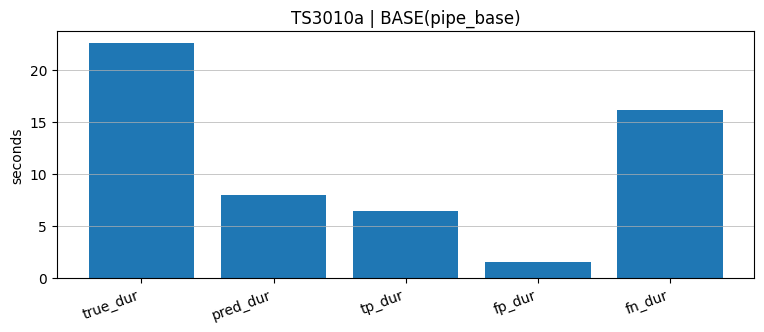

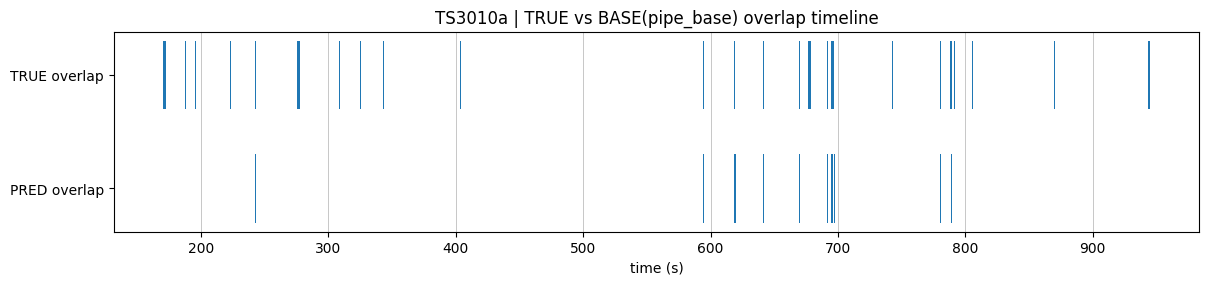


--- AFTER(overlap_reassign_GNN_pipeline) ---
pred_overlap_dur=8.50s | tp=6.60s | fp=1.90s | fn=15.94s
precision=0.776 | recall=0.293 | f1=0.425


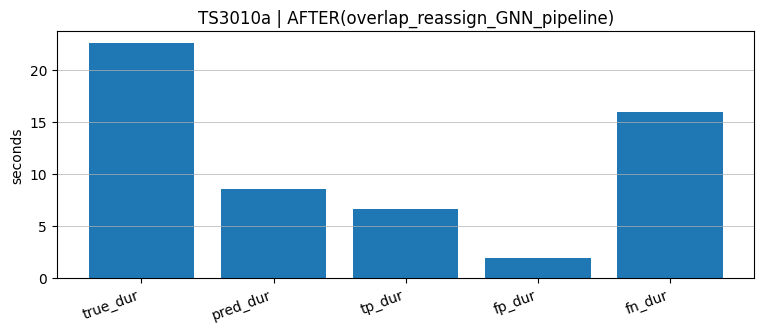

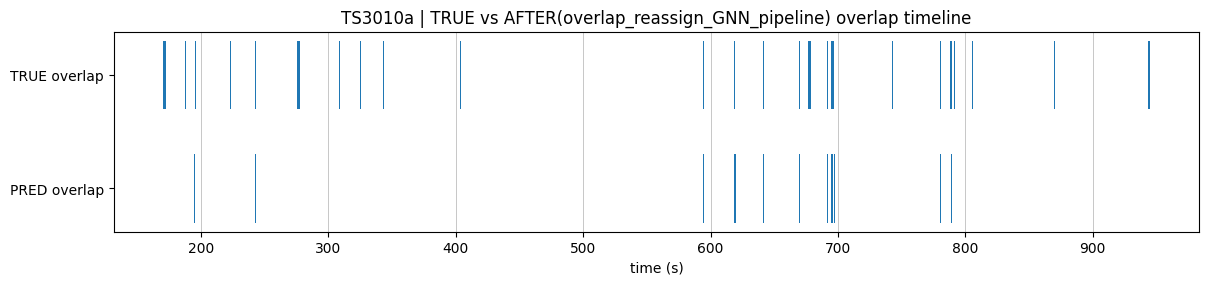

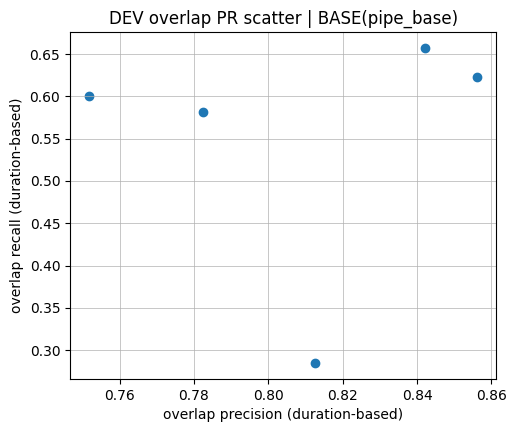

[DEV summary | BASE(pipe_base)] mean P=0.809 | mean R=0.549 | mean F1=0.643 | n_files=5


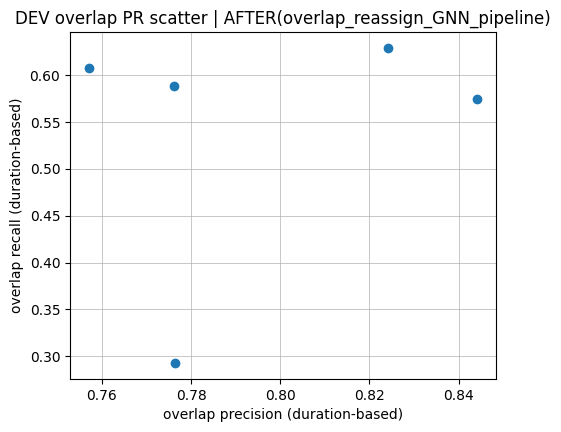

[DEV summary | AFTER(overlap_reassign_GNN_pipeline)] mean P=0.796 | mean R=0.539 | mean F1=0.633 | n_files=5


In [ ]:
# ============================================================
# Overlap precision/recall diagnostic + visualization
# - TRUE overlap: reference count >= 2
# - PRED overlap: hypothesis count >= 2 (from a pipeline you choose)
# Metrics are in *clock-time seconds* (Timeline duration), not speaker-time.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from pyannote.core import Segment, Timeline

# ----------------------------
# Choose file + prediction source
# ----------------------------
DEBUG_URI = "TS3010a"

# Pick which hypothesis to evaluate overlap detection for:
#   - pipe_base (baseline)
#   - E3_GNN_best (after)
# or any callable f -> Annotation
PRED_FNS = {
    "BASE(pipe_base)": pipe_base,
}
if "E3_GNN_best" in globals():
    PRED_FNS["AFTER(E3_GNN_best)"] = E3_GNN_best
elif "overlap_reassign_GNN_pipeline" in globals():
    PRED_FNS["AFTER(overlap_reassign_GNN_pipeline)"] = overlap_reassign_GNN_pipeline

# Grid params for overlap masks
RES = 0.02
MIN_OV_DUR = 0.20
MERGE_GAP = 0.05

# ----------------------------
# Helpers
# ----------------------------
def _get_uem(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"].support()
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))]).support()
    return Timeline()

def _merge_close(segs, gap=0.05):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

def _mask_to_segments(mask, uem_seg, res, min_dur):
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = float(uem_seg.start + a * res)
        en = float(uem_seg.start + b * res)
        # clamp (ceil(duration/res) can overshoot)
        st = max(st, float(uem_seg.start))
        en = min(en, float(uem_seg.end))
        if en - st >= min_dur:
            out.append(Segment(st, en))
    return out

def tl_dur(tl: Timeline) -> float:
    return float(sum(s.duration for s in tl)) if tl is not None else 0.0

def intersect_timelines(tl1: Timeline, tl2: Timeline) -> Timeline:
    """Two-pointer intersection (robust; avoids relying on operator overloads)."""
    a = list(tl1.support())
    b = list(tl2.support())
    i = j = 0
    out = []
    while i < len(a) and j < len(b):
        s1, s2 = a[i], b[j]
        st = max(s1.start, s2.start)
        en = min(s1.end, s2.end)
        if en > st:
            out.append(Segment(st, en))
        if s1.end < s2.end:
            i += 1
        else:
            j += 1
    return Timeline(out).support()

def build_true_overlap_tl(file, res=0.02, min_dur=0.20, merge_gap=0.05):
    """TRUE overlap from REF: count(ref speakers) >= 2."""
    ref = file["annotation"]
    uem = _get_uem(file)
    ov_segs = []
    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue
        count = np.zeros((T,), dtype=np.uint16)
        ref_seg = ref.crop(uem_seg)
        for seg, _, _lab in ref_seg.itertracks(yield_label=True):
            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                count[a:b] += 1
        ov_mask = (count >= 2)
        ov_segs.extend(_mask_to_segments(ov_mask, uem_seg, res=res, min_dur=min_dur))
    ov_segs = _merge_close(ov_segs, gap=merge_gap)
    ov_tl = Timeline(ov_segs).support().crop(uem)
    return ov_tl

def build_pred_overlap_tl(hyp, file, res=0.02, min_dur=0.20, merge_gap=0.05):
    """PRED overlap from HYP: count(hyp labels active) >= 2."""
    uem = _get_uem(file)
    labels = sorted([str(l) for l in hyp.labels()])
    if len(labels) <= 1:
        return Timeline().support()

    ov_segs = []
    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue
        M = np.zeros((T, len(labels)), dtype=np.uint8)
        hyp_seg = hyp.crop(uem_seg)
        for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
            lab = str(lab0)
            if lab not in labels:
                continue
            j = labels.index(lab)
            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                M[a:b, j] = 1
        count = M.sum(axis=1)
        ov_mask = (count >= 2)
        ov_segs.extend(_mask_to_segments(ov_mask, uem_seg, res=res, min_dur=min_dur))
    ov_segs = _merge_close(ov_segs, gap=merge_gap)
    ov_tl = Timeline(ov_segs).support().crop(uem)
    return ov_tl

def overlap_prf(true_tl, pred_tl):
    inter = intersect_timelines(true_tl, pred_tl)
    tp = tl_dur(inter)
    pred = tl_dur(pred_tl)
    true = tl_dur(true_tl)
    fp = max(pred - tp, 0.0)
    fn = max(true - tp, 0.0)
    prec = tp / pred if pred > 1e-9 else float("nan")
    rec  = tp / true if true > 1e-9 else float("nan")
    f1 = (2*prec*rec/(prec+rec)) if (prec == prec and rec == rec and (prec+rec) > 1e-9) else float("nan")
    return {
        "true_dur": true, "pred_dur": pred, "tp_dur": tp, "fp_dur": fp, "fn_dur": fn,
        "precision": prec, "recall": rec, "f1": f1,
        "inter_tl": inter
    }

def plot_timelines(true_tl, pred_tl, title="Overlap timelines"):
    # Prepare broken_barh segments
    def to_bars(tl):
        bars = []
        for s in tl.support():
            bars.append((float(s.start), float(s.duration)))
        return bars

    true_bars = to_bars(true_tl)
    pred_bars = to_bars(pred_tl)

    fig = plt.figure(figsize=(14, 2.6))
    ax = plt.gca()
    ax.broken_barh(true_bars, (12, 6))
    ax.broken_barh(pred_bars, (2,  6))

    ax.set_yticks([5, 15])
    ax.set_yticklabels(["PRED overlap", "TRUE overlap"])
    ax.set_xlabel("time (s)")
    ax.set_title(title)
    ax.grid(True, axis="x", linewidth=0.5)
    plt.show()

def plot_durations(stats, title="Overlap detection durations (clock time)"):
    names = ["true_dur", "pred_dur", "tp_dur", "fp_dur", "fn_dur"]
    vals = [stats[k] for k in names]
    fig = plt.figure(figsize=(9, 3.2))
    ax = plt.gca()
    ax.bar(names, vals)
    ax.set_ylabel("seconds")
    ax.set_title(title)
    ax.grid(True, axis="y", linewidth=0.5)
    plt.xticks(rotation=20, ha="right")
    plt.show()

# ----------------------------
# Find file by URI
# ----------------------------
def find_file_by_uri(protocol, uri):
    for f in protocol.development():
        if f.get("uri") == uri:
            return f, "dev"
    for f in protocol.test():
        if f.get("uri") == uri:
            return f, "test"
    return None, None

f, split = find_file_by_uri(protocol, DEBUG_URI)
if f is None:
    raise RuntimeError(f"Could not find uri={DEBUG_URI} in protocol dev/test.")

uem = _get_uem(f)
true_ov = build_true_overlap_tl(f, res=RES, min_dur=MIN_OV_DUR, merge_gap=MERGE_GAP)

print(f"[{DEBUG_URI}] split={split} | uem_dur={tl_dur(uem):.2f}s | TRUE overlap_dur={tl_dur(true_ov):.2f}s")

# ----------------------------
# Evaluate each prediction function
# ----------------------------
results = {}
for name, fn in PRED_FNS.items():
    hyp = fn(f).crop(uem)
    pred_ov = build_pred_overlap_tl(hyp, f, res=RES, min_dur=MIN_OV_DUR, merge_gap=MERGE_GAP)
    stats = overlap_prf(true_ov, pred_ov)
    results[name] = (pred_ov, stats)

    print(f"\n--- {name} ---")
    print(f"pred_overlap_dur={stats['pred_dur']:.2f}s | tp={stats['tp_dur']:.2f}s | fp={stats['fp_dur']:.2f}s | fn={stats['fn_dur']:.2f}s")
    print(f"precision={stats['precision']:.3f} | recall={stats['recall']:.3f} | f1={stats['f1']:.3f}")

    plot_durations(stats, title=f"{DEBUG_URI} | {name}")
    plot_timelines(true_ov, pred_ov, title=f"{DEBUG_URI} | TRUE vs {name} overlap timeline")

# ----------------------------
# Optional: quick DEV summary plot (if DEV_URIS exists)
# ----------------------------
if "DEV_URIS" in globals():
    dev_files = [ff for ff in protocol.development() if ff.get("uri") in set(DEV_URIS)]
    if len(dev_files) > 0:
        for name, fn in PRED_FNS.items():
            ps, rs, f1s = [], [], []
            for ff in dev_files:
                uem_ff = _get_uem(ff)
                true_ff = build_true_overlap_tl(ff, res=RES, min_dur=MIN_OV_DUR, merge_gap=MERGE_GAP)
                hyp_ff = fn(ff).crop(uem_ff)
                pred_ff = build_pred_overlap_tl(hyp_ff, ff, res=RES, min_dur=MIN_OV_DUR, merge_gap=MERGE_GAP)
                st = overlap_prf(true_ff, pred_ff)
                if st["precision"] == st["precision"] and st["recall"] == st["recall"]:
                    ps.append(st["precision"]); rs.append(st["recall"]); f1s.append(st["f1"])

            if len(ps) > 0:
                fig = plt.figure(figsize=(5.5, 4.5))
                ax = plt.gca()
                ax.scatter(ps, rs)
                ax.set_xlabel("overlap precision (duration-based)")
                ax.set_ylabel("overlap recall (duration-based)")
                ax.set_title(f"DEV overlap PR scatter | {name}")
                ax.grid(True, linewidth=0.5)
                plt.show()

                print(f"[DEV summary | {name}] mean P={np.mean(ps):.3f} | mean R={np.mean(rs):.3f} | mean F1={np.mean(f1s):.3f} | n_files={len(ps)}")


What your overlap PR says
TS3010a (dev)

TRUE overlap = 22.54s

BASE predicted overlap = 7.90s with P=0.813, R=0.285

So baseline overlap detection is very conservative: when it predicts overlap it’s usually right, but it misses ~71% of true overlap time (FN=16.12s).

AFTER (your GNN overlap rewrite) barely changes overlap detection:

pred overlap 8.50s, P down, R up tiny, F1 basically same.

✅ Implication: your overlap reassignment can only ever affect ~8 seconds on TS3010a, because you’re only operating on “predicted overlap” regions. Even a perfect overlap labeler can’t fix the other ~16s you never touch.

DEV average (5 files)

Mean P ~0.81, R ~0.55
TS3010a is an outlier with low recall.

So next step is not “better GNN” yet — it’s: expand / improve overlap candidate detection, at least for TS3010a.

Code to find : In TRUE overlap time, how often does the hypothesis have 0 / 1 / 2+ speakers? (+ bar plot)

This tells you whether your missed true overlap is mostly:

hyp=0 speakers (VAD/segmentation miss), or

hyp=1 speaker (overlap collapsed into single-speaker), or

hyp>=2 (overlap detected but maybe wrong labels)

[TS3010a] TRUE overlap frames total ~ 22.80s
  hyp_count==0 : 2.38s  (10.44%)
  hyp_count==1 : 13.86s  (60.79%)
  hyp_count>=2 : 6.56s  (28.77%)


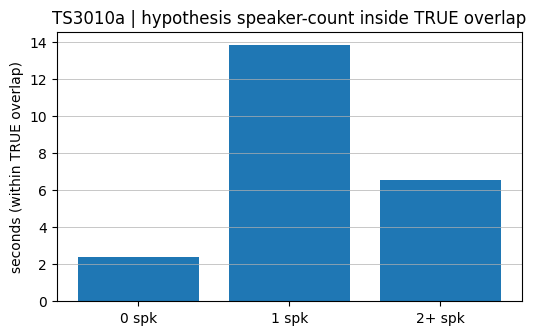

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyannote.core import Segment, Timeline

DEBUG_URI = "TS3010a"
HYP_FN = pipe_base   # try overlap_reassign_GNN_pipeline too

RES = 0.02
MIN_TRUE_OV_DUR = 0.00  # keep 0 here to analyze *all* overlap frames

def _get_uem(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"].support()
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))]).support()
    return Timeline()

def find_file_by_uri(protocol, uri):
    for f in protocol.development():
        if f.get("uri") == uri:
            return f, "dev"
    for f in protocol.test():
        if f.get("uri") == uri:
            return f, "test"
    return None, None

def build_true_overlap_mask(file, uem_seg, res=0.02):
    ref = file["annotation"].crop(uem_seg)
    T = int(np.ceil(uem_seg.duration / res))
    cnt = np.zeros((T,), dtype=np.uint16)
    for seg, _, _ in ref.itertracks(yield_label=True):
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            cnt[a:b] += 1
    return (cnt >= 2), T

def hyp_count_frames(hyp, uem_seg, labels, res=0.02):
    T = int(np.ceil(uem_seg.duration / res))
    M = np.zeros((T, len(labels)), dtype=np.uint8)
    hyp_seg = hyp.crop(uem_seg)
    for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
        lab = str(lab0)
        if lab not in labels:
            continue
        j = labels.index(lab)
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1
    return M.sum(axis=1)  # per-frame speaker count

f, split = find_file_by_uri(protocol, DEBUG_URI)
uem = _get_uem(f)
hyp = HYP_FN(f).crop(uem)
labels = sorted([str(l) for l in hyp.labels()])

n0 = n1 = n2p = 0
total_ov_frames = 0

for uem_seg in uem:
    ov_mask, T = build_true_overlap_mask(f, uem_seg, res=RES)
    if T <= 0:
        continue
    hc = hyp_count_frames(hyp, uem_seg, labels, res=RES)
    ov_idx = np.where(ov_mask)[0]
    if ov_idx.size == 0:
        continue
    total_ov_frames += ov_idx.size
    h = hc[ov_idx]
    n0  += int(np.sum(h == 0))
    n1  += int(np.sum(h == 1))
    n2p += int(np.sum(h >= 2))

dur0  = n0 * RES
dur1  = n1 * RES
dur2p = n2p * RES
tot   = total_ov_frames * RES

print(f"[{DEBUG_URI}] TRUE overlap frames total ~ {tot:.2f}s")
print(f"  hyp_count==0 : {dur0:.2f}s  ({dur0/max(tot,1e-9):.2%})")
print(f"  hyp_count==1 : {dur1:.2f}s  ({dur1/max(tot,1e-9):.2%})")
print(f"  hyp_count>=2 : {dur2p:.2f}s  ({dur2p/max(tot,1e-9):.2%})")

plt.figure(figsize=(6,3.5))
plt.bar(["0 spk", "1 spk", "2+ spk"], [dur0, dur1, dur2p])
plt.ylabel("seconds (within TRUE overlap)")
plt.title(f"{DEBUG_URI} | hypothesis speaker-count inside TRUE overlap")
plt.grid(True, axis="y", linewidth=0.5)
plt.show()


What this means (TS3010a TRUE overlap = 22.8s)

Inside TRUE overlap time, your hypothesis has:

hyp_count==0: 2.38s (10.4%) → speech activity / segmentation miss even during overlap

hyp_count==1: 13.86s (60.8%) → overlap exists, but baseline collapses it to a single speaker

hyp_count>=2: 6.56s (28.8%) → only this part is even eligible for your current “overlap reassignment” logic

Key consequence

Your current overlap pipeline mostly edits only the 28.8% slice (where baseline already has ≥2 speakers). That’s why your overlap recall was low (~0.29) and why overlap fixes don’t move DER much: most true overlap is hiding inside baseline single-speaker regions.

So the next overlap step is not “better GNN”; it’s better overlap candidate detection, specifically targeting regions currently labeled as single-speaker.

*next*

What to do next (highest ROI, in order)
1) Add an overlap candidate detector (OSD)

Use pyannote/overlapped-speech-detection to produce an overlap timeline, then take:

cand_overlap = union( OSD_overlap , baseline_overlap(count>=2) )

This will directly address the 60.8% hyp_count==1 inside TRUE overlap by flagging overlap even when diarization outputs only one speaker.

2) Only after you have candidates: decide “2nd speaker” safely

Within cand_overlap:

keep baseline speaker (the one already active)

add a second speaker only when confident:

centroid similarity margin / stability checks

AND OSD says overlap (or high OSD score if available)
This should reduce the FA blow-up you observed.

3) Optional but strong: separation on overlap candidates (AMI-trained)

If embeddings remain ambiguous on overlap:

run pyannote/separation-ami-1.0 (or speech-separation-ami-1.0) on overlap windows

embed each separated stream

match to anchor centroids
This is the cleanest way to reduce confusion in overlap.

4) In parallel: segmentation/VAD work (because 10% of overlap is hyp==0)

That 2.38s inside overlap where hyp has 0 speakers is pure miss that overlap assignment cannot fix.
This pushes you toward:

speaker-diarization-3.1 / speaker-diarization-precision-2

or better VAD/segmentation thresholds

### OSD overlap PR/F1 vs TRUE overlap (TS3010a + DEV summary)

In [ ]:
# ============================================================
# OSD overlap PR/F1 vs TRUE overlap (TS3010a + DEV summary)
# Requires: protocol, DEV_URIS, and your existing helper funcs:
#   - _get_uem
#   - build_true_overlap_tl
#   - overlap_prf
#   - tl_dur
#   - find_file_by_uri
# ============================================================



def osd_overlap_timeline(file):
    uem = _get_uem(file)
    out = osd(file)  # usually returns Annotation
    # robust: handle Annotation or Timeline
    if hasattr(out, "get_timeline"):
        tl = out.get_timeline().support()
    else:
        tl = out.support() if hasattr(out, "support") else Timeline()
    return tl.crop(uem)

# ---- TS3010a ----
f, split = find_file_by_uri(protocol, DEBUG_URI)
uem = _get_uem(f)
true_ov = build_true_overlap_tl(f, res=0.02, min_dur=0.20, merge_gap=0.05)

# BASE predicted overlap timeline (count>=2)
hyp_base = pipe_base(f).crop(uem)
pred_base = build_pred_overlap_tl(hyp_base, f, res=0.02, min_dur=0.20, merge_gap=0.05)

# OSD overlap
pred_osd = osd_overlap_timeline(f)

# scores
metrics0 = overlap_prf(true_ov, pred_base)
p0, r0, f10, tp0, fp0, fn0 = metrics0["precision"], metrics0["recall"], metrics0["f1"], metrics0["tp_dur"], metrics0["fp_dur"], metrics0["fn_dur"]
metrics1 = overlap_prf(true_ov, pred_osd)
p1, r1, f11, tp1, fp1, fn1 = metrics1["precision"], metrics1["recall"], metrics1["f1"], metrics1["tp_dur"], metrics1["fp_dur"], metrics1["fn_dur"]

print(f"[{DEBUG_URI}] split={split} | TRUE_ov={tl_dur(true_ov):.2f}s")
print(f"BASE overlap: pred={tl_dur(pred_base):.2f}s | P={p0:.3f} R={r0:.3f} F1={f10:.3f} | tp={tp0:.2f} fp={fp0:.2f} fn={fn0:.2f}")
print(f"OSD  overlap: pred={tl_dur(pred_osd):.2f}s | P={p1:.3f} R={r1:.3f} F1={f11:.3f} | tp={tp1:.2f} fp={tp1:.2f} fn={fn1:.2f}")

# ---- DEV summary ----
if "DEV_URIS" in globals():
    dev_files = [ff for ff in protocol.development() if ff.get("uri") in set(DEV_URIS)]
    if dev_files:
        def avg_prf(pred_fn_name):
            Ps, Rs, F1s = [], [], []
            for ff in dev_files:
                u = _get_uem(ff)
                true = build_true_overlap_tl(ff, res=0.02, min_dur=0.20, merge_gap=0.05)
                if pred_fn_name == "BASE":
                    hyp = pipe_base(ff).crop(u)
                    pred = build_pred_overlap_tl(hyp, ff, res=0.02, min_dur=0.20, merge_gap=0.05)
                else:
                    pred = osd_overlap_timeline(ff)

                st = overlap_prf(true, pred)
                p,r,f1 = st["precision"], st["recall"], st["f1"]
                if p == p and r == r:
                    Ps.append(p); Rs.append(r); F1s.append(f1)
            return float(sum(Ps)/len(Ps)), float(sum(Rs)/len(Rs)), float(sum(F1s)/len(F1s)), len(Ps)

        pB,rB,fB,nB = avg_prf("BASE")
        pO,rO,fO,nO = avg_prf("OSD")
        print(f"\n[DEV summary BASE] mean P={pB:.3f} | mean R={rB:.3f} | mean F1={fB:.3f} | n_files={nB}")
        print(f"[DEV summary OSD ] mean P={pO:.3f} | mean R={rO:.3f} | mean F1={fO:.3f} | n_files={nO}")

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/059e96f964841d40f1a5e755bb7223f76666bba4/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.
[TS3010a] split=dev | TRUE_ov=22.54s
BASE overlap: pred=7.90s | P=0.813 R=0.285 F1=0.422 | tp=6.42 fp=1.48 fn=16.12
OSD  overlap: pred=5.26s | P=0.867 R=0.202 F1=0.328 | tp=4.56 fp=4.56 fn=17.98

[DEV summary BASE] mean P=0.809 | mean R=0.549 | mean F1=0.643 | n_files=5
[DEV summary OSD ] mean P=0.868 | mean R=0.431 | mean F1=0.564 | n_files=5


### Overlap PR/Recall using segmentation-3.0 + OverlappedSpeechDetection pipeline and PR sweep on onset/offset + visualization

[TS3010a] split=dev | TRUE_ov=22.54s
BASE overlap: pred=7.90s | P=0.813 R=0.285 F1=0.422 | tp=6.42 fp=1.48 fn=16.12
[WARN] pipeline.instantiate rejected onset/offset. Falling back to only min_duration_*.
 parameter 'onset' does not exist

SEG3-OSD sweep:
fallback | pred_dur=  7.91s | P=0.802 R=0.282 F1=0.417 | tp= 6.35 fp= 1.57 fn=16.19

BEST SEG3-OSD: {'onset': None, 'pred': <Timeline(uri=TS3010a, segments=[<Segment(194.347, 194.633)>, <Segment(242.693, 243.2)>, <Segment(276.764, 277.017)>, <Segment(593.643, 594.824)>, <Segment(618.719, 619.63)>, <Segment(641.298, 641.618)>, <Segment(669.53, 670.053)>, <Segment(676.972, 677.242)>, <Segment(691.67, 691.973)>, <Segment(694.825, 696.108)>, <Segment(697.238, 697.627)>, <Segment(715.666, 715.784)>, <Segment(742.497, 742.649)>, <Segment(780.5, 780.77)>, <Segment(788.549, 789.275)>, <Segment(943.951, 944.373)>])>, 'p': 0.8017847271578417, 'r': 0.2815272848269589, 'f1': 0.4167299443839976, 'dur': 7.914374999999751}


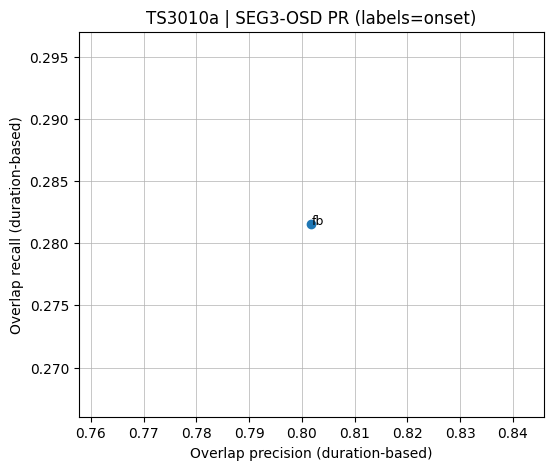

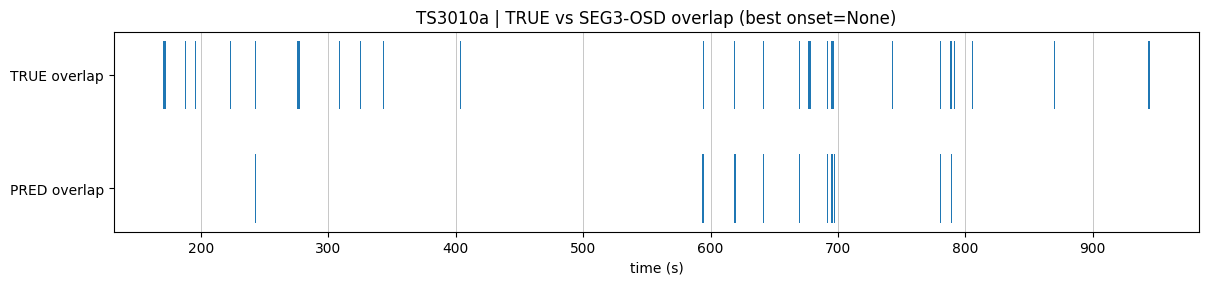

In [ ]:
# ============================================================
# Overlap PR/Recall using segmentation-3.0 + OverlappedSpeechDetection pipeline
# + PR sweep on onset/offset + visualization
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from pyannote.audio import Model
from pyannote.audio.pipelines import OverlappedSpeechDetection
from pyannote.core import Timeline, Segment

DEBUG_URI = "TS3010a"

# ---- assumes you already have these helpers from your earlier cell ----
# _get_uem(file)
# build_true_overlap_tl(file, res=0.02, min_dur=0.20, merge_gap=0.05)
# build_pred_overlap_tl(hyp, file, res=0.02, min_dur=0.20, merge_gap=0.05)   # your BASE pred overlap (count>=2)
# overlap_prf(true_tl, pred_tl) -> (p,r,f1,tp,fp,fn)
# tl_dur(tl)
# find_file_by_uri(protocol, uri)

def to_timeline(x, uem):
    # x can be Annotation or Timeline; return Timeline.support() cropped to UEM
    if hasattr(x, "get_timeline"):
        tl = x.get_timeline().support()
    elif isinstance(x, Timeline):
        tl = x.support()
    else:
        tl = Timeline()
    return tl.crop(uem)

def plot_timelines(true_tl, pred_tl, title):
    def to_bars(tl):
        return [(float(s.start), float(s.duration)) for s in tl.support()]
    plt.figure(figsize=(14, 2.6))
    ax = plt.gca()
    ax.broken_barh(to_bars(true_tl), (12, 6))
    ax.broken_barh(to_bars(pred_tl), (2, 6))
    ax.set_yticks([5, 15]); ax.set_yticklabels(["PRED overlap", "TRUE overlap"])
    ax.set_xlabel("time (s)"); ax.set_title(title)
    ax.grid(True, axis="x", linewidth=0.5)
    plt.show()

# ----------------------------
# Load file
# ----------------------------
f, split = find_file_by_uri(protocol, DEBUG_URI)
uem = _get_uem(f)
true_ov = build_true_overlap_tl(f, res=0.02, min_dur=0.20, merge_gap=0.05)
print(f"[{DEBUG_URI}] split={split} | TRUE_ov={tl_dur(true_ov):.2f}s")

# ----------------------------
# BASE predicted overlap (count>=2 from pipe_base hyp grid)
# ----------------------------
hyp_base = pipe_base(f).crop(uem)
pred_base = build_pred_overlap_tl(hyp_base, f, res=0.02, min_dur=0.20, merge_gap=0.05)
pB, rB, fB, tpB, fpB, fnB = overlap_prf(true_ov, pred_base)
print(f"BASE overlap: pred={tl_dur(pred_base):.2f}s | P={pB:.3f} R={rB:.3f} F1={fB:.3f} | tp={tpB:.2f} fp={fpB:.2f} fn={fnB:.2f}")

# ----------------------------
# segmentation-3.0 + OverlappedSpeechDetection
# ----------------------------
# If needed:
# HF_TOKEN="..."
HF_TOKEN = None

seg3 = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=HF_TOKEN)
osd_pipe = OverlappedSpeechDetection(segmentation=seg3)

# Sweep onset/offset to trade recall vs precision
ONSETS = np.linspace(0.05, 0.95, 19)
rows = []
best = None

for onset in ONSETS:
    params = {
        "min_duration_on": 0.0,
        "min_duration_off": 0.0,
        # These are commonly supported by pyannote pipelines; if your version rejects them,
        # comment them out and re-run.
        "onset": float(onset),
        "offset": float(onset),
    }
    try:
        osd_pipe.instantiate(params)
    except Exception as e:
        print("[WARN] pipeline.instantiate rejected onset/offset. Falling back to only min_duration_*.\n", e)
        osd_pipe.instantiate({"min_duration_on": 0.0, "min_duration_off": 0.0})
        onset = None  # indicates fallback mode

    pred_osd_ann = osd_pipe(f)   # works with protocol file dict
    pred_osd = to_timeline(pred_osd_ann, uem)

    p, r, f1, tp, fp, fn = overlap_prf(true_ov, pred_osd)
    rows.append((onset, tl_dur(pred_osd), p, r, f1, tp, fp, fn))

    if f1 == f1 and (best is None or f1 > best["f1"]):
        best = {"onset": onset, "pred": pred_osd, "p": p, "r": r, "f1": f1, "dur": tl_dur(pred_osd)}

    if onset is None:
        # no point sweeping if onset/offset not supported
        break

print("\nSEG3-OSD sweep:")
for onset, dur, p, r, f1, tp, fp, fn in rows:
    if onset is None:
        print(f"fallback | pred_dur={dur:6.2f}s | P={p:5.3f} R={r:5.3f} F1={f1:5.3f} | tp={tp:5.2f} fp={fp:5.2f} fn={fn:5.2f}")
    else:
        print(f"onset={onset:4.2f} | pred_dur={dur:6.2f}s | P={p:5.3f} R={r:5.3f} F1={f1:5.3f} | tp={tp:5.2f} fp={fp:5.2f} fn={fn:5.2f}")

print("\nBEST SEG3-OSD:", best)

# ----------------------------
# Visualizations
# ----------------------------
# PR curve
Ps = [x[2] for x in rows]
Rs = [x[3] for x in rows]
labs = ["fb" if x[0] is None else f"{x[0]:.2f}" for x in rows]

plt.figure(figsize=(6, 5))
plt.scatter(Ps, Rs)
for i, lab in enumerate(labs):
    if Ps[i] == Ps[i] and Rs[i] == Rs[i]:
        plt.text(Ps[i], Rs[i], lab, fontsize=9)
plt.xlabel("Overlap precision (duration-based)")
plt.ylabel("Overlap recall (duration-based)")
plt.title(f"{DEBUG_URI} | SEG3-OSD PR (labels=onset)")
plt.grid(True, linewidth=0.5)
plt.show()

# Timeline plot for BEST
plot_timelines(true_ov, best["pred"], title=f"{DEBUG_URI} | TRUE vs SEG3-OSD overlap (best onset={best['onset']})")


### SEG3 overlap PR/Recall + sweep + visualization (FIXED) Works whether scores.data is 2D (T,7) or 3D (n_chunks,n_frames,K)

[TS3010a] split=dev | TRUE_ov=22.54s
BASE overlap: pred=7.90s | P=0.813 R=0.285 F1=0.422 | tp=6.42 fp=1.48 fn=16.12
[DBG] raw scores.data shape=(10312, 589, 3) | sliding_window: start=0.000 dur=10.000 step=0.100
[DBG] ov_score quantiles: {'q50': 0.0, 'q70': 0.0, 'q80': 0.0, 'q90': 0.0, 'q95': 0.0, 'q97': 0.0, 'q99': 0.0}

BEST (seg3 tuned): {'thr': 0.0, 'collar': 0.0, 'precision': 0.04926560587515293, 'recall': 1.0, 'f1': 0.09390492855059773, 'tp_dur': 22.539999999999964, 'fp_dur': 434.9799999999999, 'fn_dur': 0.0}
pred_dur=457.52s | TRUE_dur=22.54s


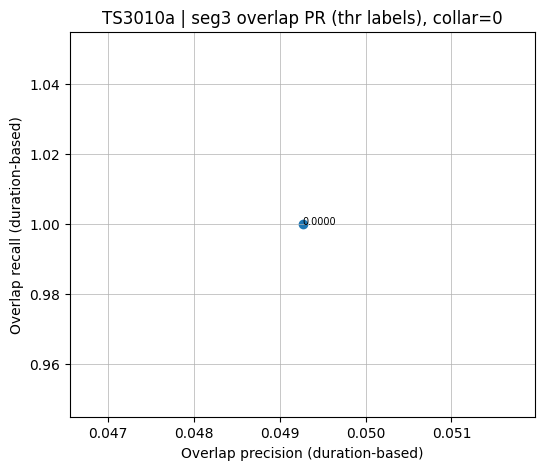

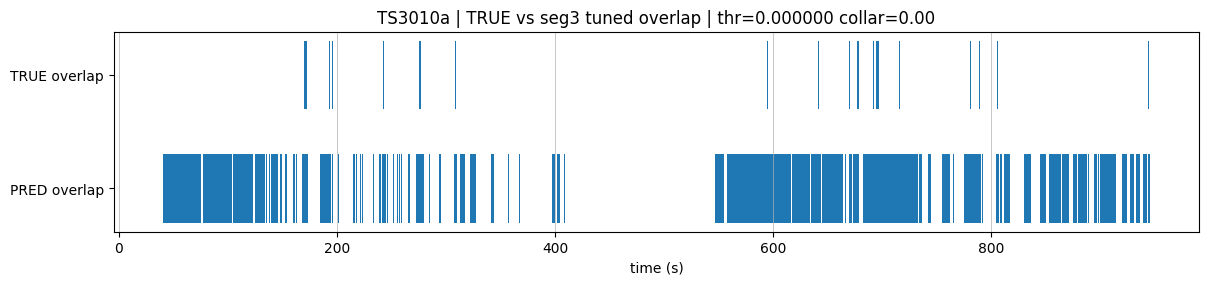

In [ ]:
# ============================================================
# SEG3 overlap PR/Recall + sweep + visualization (FIXED)
# Works whether scores.data is 2D (T,7) or 3D (n_chunks,n_frames,K)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from pyannote.audio import Model, Inference
from pyannote.core import Segment, Timeline

DEBUG_URI = "TS3010a"
HF_TOKEN = None  # set if needed

# ---- knobs ----
STEP = 0.10
MIN_DUR = 0.20
MERGE_GAP = 0.05
COLLARS = [0.0, 0.10, 0.20, 0.30, 0.50]

# ----------------------------
# Helpers (self-contained)
# ----------------------------
def _get_uem(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def tl_dur(tl: Timeline) -> float:
    return float(sum(s.duration for s in tl)) if tl is not None else 0.0

def _merge_close(segs, gap=0.05):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

def _mask_to_segments(mask, start_time, step, min_dur):
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = float(start_time + a * step)
        en = float(start_time + b * step)
        if en - st >= min_dur:
            out.append(Segment(st, en))
    return out

def intersect_timelines(tl1: Timeline, tl2: Timeline) -> Timeline:
    a = list(tl1.support()); b = list(tl2.support())
    i = j = 0; out = []
    while i < len(a) and j < len(b):
        s1, s2 = a[i], b[j]
        st = max(s1.start, s2.start); en = min(s1.end, s2.end)
        if en > st:
            out.append(Segment(st, en))
        if s1.end < s2.end:
            i += 1
        else:
            j += 1
    return Timeline(out).support()

def overlap_prf(true_tl, pred_tl):
    inter = intersect_timelines(true_tl, pred_tl)
    tp = tl_dur(inter)
    pred = tl_dur(pred_tl)
    true = tl_dur(true_tl)
    fp = max(pred - tp, 0.0)
    fn = max(true - tp, 0.0)
    prec = tp / pred if pred > 1e-9 else float("nan")
    rec  = tp / true if true > 1e-9 else float("nan")
    f1 = (2*prec*rec/(prec+rec)) if (prec == prec and rec == rec and (prec+rec) > 1e-9) else float("nan")
    return {"true_dur": true, "pred_dur": pred, "tp_dur": tp, "fp_dur": fp, "fn_dur": fn,
            "precision": prec, "recall": rec, "f1": f1, "inter_tl": inter}

def expand_timeline(tl, collar, uem):
    if collar <= 0:
        return tl.crop(uem)
    segs = [Segment(s.start - collar, s.end + collar) for s in tl.support()]
    segs = _merge_close(segs, gap=0.0)
    return Timeline(segs).support().crop(uem)

def plot_timelines(true_tl, pred_tl, title):
    def to_bars(tl):
        return [(float(s.start), float(s.duration)) for s in tl.support()]
    plt.figure(figsize=(14, 2.6))
    ax = plt.gca()
    ax.broken_barh(to_bars(true_tl), (12, 6))
    ax.broken_barh(to_bars(pred_tl), (2, 6))
    ax.set_yticks([5, 15]); ax.set_yticklabels(["PRED overlap", "TRUE overlap"])
    ax.set_xlabel("time (s)"); ax.set_title(title)
    ax.grid(True, axis="x", linewidth=0.5)
    plt.show()

def find_file_by_uri(protocol, uri):
    for f in protocol.development():
        if f.get("uri") == uri:
            return f, "dev"
    for f in protocol.test():
        if f.get("uri") == uri:
            return f, "test"
    return None, None

def build_true_overlap_tl(file, res=0.02, min_dur=0.20, merge_gap=0.05):
    ref = file["annotation"]
    uem = _get_uem(file)
    ov_segs = []
    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue
        count = np.zeros((T,), dtype=np.uint16)
        ref_seg = ref.crop(uem_seg)
        for seg, _, _lab in ref_seg.itertracks(yield_label=True):
            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                count[a:b] += 1
        ov_mask = (count >= 2)
        ov_segs.extend(_mask_to_segments(ov_mask, uem_seg.start, res, min_dur))
    ov_segs = _merge_close(ov_segs, gap=merge_gap)
    return Timeline(ov_segs).support().crop(uem)

# ---------------------------------------------------
# Core: build predicted overlap TL from seg scores
# ---------------------------------------------------
def pred_overlap_tl_from_scores(scores, uem, thr, min_dur=0.20, merge_gap=0.05):
    X = np.asarray(scores.data)
    sw = scores.sliding_window  # this indexes FIRST axis of X

    pred_segs = []

    if X.ndim == 2:
        # (T, C)
        T, C = X.shape
        step = float(sw.step); t0 = float(sw.start)

        if C == 7:
            ov = np.max(X[:, 4:7], axis=1)  # overlap classes in powerset
        elif C >= 2:
            # fallback: second largest "speaker activity"
            ov = np.partition(X, -2, axis=1)[:, -2]
        else:
            return Timeline().support()

        for uem_seg in uem:
            a = int(np.floor((uem_seg.start - t0) / step))
            b = int(np.ceil ((uem_seg.end   - t0) / step))
            a = max(a, 0); b = min(b, len(ov))
            if b <= a:
                continue
            mask = (ov[a:b] >= thr)
            start_time = t0 + a * step
            pred_segs.extend(_mask_to_segments(mask, start_time, step, min_dur))

    elif X.ndim == 3:
        # (n_chunks, n_frames, K)
        n_chunks, n_frames, K = X.shape
        chunk_step = float(sw.step)
        chunk_start0 = float(sw.start)
        chunk_dur = float(sw.duration)
        frame_step = chunk_dur / float(n_frames)

        # overlap score inside each chunk
        if K == 7:
            ov_chunk = np.max(X[:, :, 4:7], axis=2)      # (n_chunks, n_frames)
        elif K >= 2:
            ov_chunk = np.partition(X, -2, axis=2)[:, :, -2]  # second-highest speaker activity
        else:
            return Timeline().support()

        # Convert each chunk mask to absolute-time segments; merge globally
        for i in range(n_chunks):
            chunk_t0 = chunk_start0 + i * chunk_step
            # quick skip if this chunk doesn't intersect UEM at all
            chunk_seg = Segment(chunk_t0, chunk_t0 + chunk_dur)
            if tl_dur(Timeline([chunk_seg]).support().crop(uem)) <= 0:
                continue

            mask = (ov_chunk[i] >= thr)
            segs_i = _mask_to_segments(mask, chunk_t0, frame_step, min_dur)
            pred_segs.extend(segs_i)

    else:
        raise RuntimeError(f"Unsupported scores.data ndim={X.ndim} shape={X.shape}")

    pred_segs = _merge_close(pred_segs, gap=merge_gap)
    return Timeline(pred_segs).support().crop(uem)

# ============================================================
# Run on TS3010a
# ============================================================
f, split = find_file_by_uri(protocol, DEBUG_URI)
uem = _get_uem(f)
true_ov = build_true_overlap_tl(f, res=0.02, min_dur=MIN_DUR, merge_gap=MERGE_GAP)

print(f"[{DEBUG_URI}] split={split} | TRUE_ov={tl_dur(true_ov):.2f}s")

# BASE overlap PR from diarization output (count>=2 in hypothesis)
try:
    hyp_base = pipe_base(f).crop(uem)
    # "pred overlap" from diarization hypothesis = regions with >=2 active labels
    # reuse your own function if you already have it; here is a minimal inline version:
    labels = sorted([str(l) for l in hyp_base.labels()])
    if len(labels) > 1:
        ov_segs = []
        RES = 0.02
        for uem_seg in uem:
            T = int(np.ceil(uem_seg.duration / RES))
            M = np.zeros((T, len(labels)), dtype=np.uint8)
            hyp_seg = hyp_base.crop(uem_seg)
            for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
                lab = str(lab0)
                j = labels.index(lab)
                a = int(np.floor((seg.start - uem_seg.start) / RES))
                b = int(np.ceil ((seg.end   - uem_seg.start) / RES))
                a = max(a, 0); b = min(b, T)
                if b > a:
                    M[a:b, j] = 1
            count = M.sum(axis=1)
            ov_mask = (count >= 2)
            ov_segs.extend(_mask_to_segments(ov_mask, uem_seg.start, RES, MIN_DUR))
        pred_base = Timeline(_merge_close(ov_segs, gap=MERGE_GAP)).support().crop(uem)
        mB = overlap_prf(true_ov, pred_base)
        print(f"BASE overlap: pred={mB['pred_dur']:.2f}s | P={mB['precision']:.3f} R={mB['recall']:.3f} F1={mB['f1']:.3f} | tp={mB['tp_dur']:.2f} fp={mB['fp_dur']:.2f} fn={mB['fn_dur']:.2f}")
except Exception as e:
    print("[WARN] BASE overlap compare failed:", e)

# segmentation-3.0 inference
model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=HF_TOKEN)
infer = Inference(model, step=STEP)
scores = infer(f)

Xraw = np.asarray(scores.data)
print(f"[DBG] raw scores.data shape={Xraw.shape} | sliding_window: start={scores.sliding_window.start:.3f} dur={scores.sliding_window.duration:.3f} step={scores.sliding_window.step:.3f}")

# Build overlap score distribution for threshold proposal
if Xraw.ndim == 2:
    if Xraw.shape[1] == 7:
        ov_all = np.max(Xraw[:, 4:7], axis=1)
    else:
        ov_all = np.partition(Xraw, -2, axis=1)[:, -2] if Xraw.shape[1] >= 2 else np.zeros((Xraw.shape[0],))
elif Xraw.ndim == 3:
    K = Xraw.shape[2]
    if K == 7:
        ov_all = np.max(Xraw[:, :, 4:7], axis=2).ravel()
    else:
        ov_all = np.partition(Xraw, -2, axis=2)[:, :, -2].ravel() if K >= 2 else np.zeros((Xraw.shape[0]*Xraw.shape[1],))
else:
    ov_all = np.zeros((1,))

qs = np.quantile(ov_all, [0.50, 0.70, 0.80, 0.90, 0.95, 0.97, 0.99])
THRS = np.unique(np.r_[qs, np.linspace(qs[0], qs[-1], 12)])
print("[DBG] ov_score quantiles:", {f"q{int(p*100)}": float(v) for p,v in zip([.50,.70,.80,.90,.95,.97,.99], qs)})

# Sweep thr + collar
best = None
curve = []  # (thr, pred_dur, p, r, f1) for collar=0
for collar in COLLARS:
    for thr in THRS:
        pred = pred_overlap_tl_from_scores(scores, uem, float(thr), min_dur=MIN_DUR, merge_gap=MERGE_GAP)
        pred = expand_timeline(pred, collar=collar, uem=uem)

        m = overlap_prf(true_ov, pred)
        p,r,f1 = m["precision"], m["recall"], m["f1"]

        if collar == 0.0:
            curve.append((float(thr), float(m["pred_dur"]), float(p), float(r), float(f1)))

        if p == p and r == r and f1 == f1:
            if best is None or f1 > best["f1"]:
                best = {"thr": float(thr), "collar": float(collar), **m, "pred": pred}

print("\nBEST (seg3 tuned):", {k: best[k] for k in ["thr","collar","precision","recall","f1","tp_dur","fp_dur","fn_dur"]})
print(f"pred_dur={best['pred_dur']:.2f}s | TRUE_dur={best['true_dur']:.2f}s")

# PR curve (collar=0)
Ps = [x[2] for x in curve]
Rs = [x[3] for x in curve]
labs = [f"{x[0]:.4f}" for x in curve]

plt.figure(figsize=(6,5))
plt.scatter(Ps, Rs)
for i, lab in enumerate(labs):
    if Ps[i] == Ps[i] and Rs[i] == Rs[i]:
        plt.text(Ps[i], Rs[i], lab, fontsize=7)
plt.xlabel("Overlap precision (duration-based)")
plt.ylabel("Overlap recall (duration-based)")
plt.title(f"{DEBUG_URI} | seg3 overlap PR (thr labels), collar=0")
plt.grid(True, linewidth=0.5)
plt.show()

plot_timelines(true_ov, best["pred"], title=f"{DEBUG_URI} | TRUE vs seg3 tuned overlap | thr={best['thr']:.6f} collar={best['collar']:.2f}")


What your latest logs really mean
1) scores.data shape = (10312, 589, 3) is normal

This is not the “(T, 7) powerset” output shown on the model card. Instead, you’re getting Kmax=3 speaker activations per 10s window (sliding over the file). That matches how pyannote segmentation outputs are often exposed as “Kmax-dimensional speaker activations” (one activation curve per local speaker).
GitHub

(Separately, the model card describes a powerset view with 7 classes for a single 10s chunk.
Hugging Face
)

2) Your overlap score quantiles being all zeros is expected with your current definition

You computed overlap as “2nd-largest activation”. If the model rarely has 2 speakers active in the same frame, that second-largest value is 0 almost everywhere → quantiles all 0.

3) The big bug: mask = (ov_score >= thr) + thr=0

If almost all ov_score == 0, then >= 0 makes everything overlap → you get:

recall = 1.0

pred_dur ≈ full UEM

precision collapses

So yes: the current “manual thr” method is broken because the threshold grid degenerates to 0 and you used >=.

✅ Fix: don’t threshold “ov_score”; threshold speaker activations and count speakers

With K=3 activations, the right way is:

pick an activation threshold act_thr

count = (A > act_thr).sum(axis=-1)

overlap frame if count >= 2

Then sweep act_thr (and optional collar), compute PR/F1.

Below is a self-contained cell that works with your (n_chunks, n_frames, 3) output and gives PR curve + timeline viz.

### SEG3 overlap PR/Recall FIX for scores.data = (n_chunks, n_frames, 3)

In [ ]:
# ============================================================
# SEG3 overlap PR/Recall FIX for scores.data = (n_chunks, n_frames, 3)
# - Uses speaker-activation threshold + count>=2
# - Sweeps act_thr + collar
# - Visual: PR curve + TRUE vs PRED overlap timelines
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from pyannote.audio import Model, Inference
from pyannote.core import Segment, Timeline

DEBUG_URI = "TS3010a"
HF_TOKEN = None

STEP = 0.10
MIN_DUR = 0.20
MERGE_GAP = 0.05
COLLARS = [0.0, 0.10, 0.20, 0.30, 0.50]
ACT_THRs = np.linspace(0.05, 0.95, 19)   # << main sweep knob

# ----------------------------
# Helpers
# ----------------------------
def _get_uem(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def tl_dur(tl: Timeline) -> float:
    return float(sum(s.duration for s in tl)) if tl is not None else 0.0

def _merge_close(segs, gap=0.05):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

def _mask_to_segments(mask, start_time, step, min_dur):
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = float(start_time + a * step)
        en = float(start_time + b * step)
        if en - st >= min_dur:
            out.append(Segment(st, en))
    return out

def intersect_timelines(tl1: Timeline, tl2: Timeline) -> Timeline:
    a = list(tl1.support()); b = list(tl2.support())
    i = j = 0; out = []
    while i < len(a) and j < len(b):
        s1, s2 = a[i], b[j]
        st = max(s1.start, s2.start); en = min(s1.end, s2.end)
        if en > st:
            out.append(Segment(st, en))
        if s1.end < s2.end:
            i += 1
        else:
            j += 1
    return Timeline(out).support()

def overlap_prf(true_tl, pred_tl):
    inter = intersect_timelines(true_tl, pred_tl)
    tp = tl_dur(inter)
    pred = tl_dur(pred_tl)
    true = tl_dur(true_tl)
    fp = max(pred - tp, 0.0)
    fn = max(true - tp, 0.0)
    prec = tp / pred if pred > 1e-9 else float("nan")
    rec  = tp / true if true > 1e-9 else float("nan")
    f1 = (2*prec*rec/(prec+rec)) if (prec == prec and rec == rec and (prec+rec) > 1e-9) else float("nan")
    return {"precision": prec, "recall": rec, "f1": f1, "tp": tp, "fp": fp, "fn": fn, "pred": pred, "true": true}

def expand_timeline(tl, collar, uem):
    if collar <= 0:
        return tl.crop(uem)
    segs = [Segment(s.start - collar, s.end + collar) for s in tl.support()]
    segs = _merge_close(segs, gap=0.0)
    return Timeline(segs).support().crop(uem)

def plot_timelines(true_tl, pred_tl, title):
    def to_bars(tl):
        return [(float(s.start), float(s.duration)) for s in tl.support()]
    plt.figure(figsize=(14, 2.6))
    ax = plt.gca()
    ax.broken_barh(to_bars(true_tl), (12, 6))
    ax.broken_barh(to_bars(pred_tl), (2, 6))
    ax.set_yticks([5, 15]); ax.set_yticklabels(["PRED overlap", "TRUE overlap"])
    ax.set_xlabel("time (s)"); ax.set_title(title)
    ax.grid(True, axis="x", linewidth=0.5)
    plt.show()

def find_file_by_uri(protocol, uri):
    for f in protocol.development():
        if f.get("uri") == uri:
            return f, "dev"
    for f in protocol.test():
        if f.get("uri") == uri:
            return f, "test"
    return None, None

def build_true_overlap_tl(file, res=0.02, min_dur=0.20, merge_gap=0.05):
    ref = file["annotation"]
    uem = _get_uem(file)
    ov_segs = []
    for uem_seg in uem:
        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue
        count = np.zeros((T,), dtype=np.uint16)
        ref_seg = ref.crop(uem_seg)
        for seg, _, _lab in ref_seg.itertracks(yield_label=True):
            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                count[a:b] += 1
        ov_mask = (count >= 2)
        ov_segs.extend(_mask_to_segments(ov_mask, uem_seg.start, res, min_dur))
    ov_segs = _merge_close(ov_segs, gap=merge_gap)
    return Timeline(ov_segs).support().crop(uem)

# ----------------------------
# Load file
# ----------------------------
f, split = find_file_by_uri(protocol, DEBUG_URI)
uem = _get_uem(f)
true_ov = build_true_overlap_tl(f, res=0.02, min_dur=MIN_DUR, merge_gap=MERGE_GAP)
print(f"[{DEBUG_URI}] split={split} | TRUE_ov={tl_dur(true_ov):.2f}s")

# ----------------------------
# segmentation-3.0 inference
# ----------------------------
model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=HF_TOKEN)
infer = Inference(model, step=STEP)
scores = infer(f)

X = np.asarray(scores.data)
sw = scores.sliding_window
print(f"[DBG] raw scores.data shape={X.shape} | sw.start={sw.start:.3f} dur={sw.duration:.3f} step={sw.step:.3f}")

assert X.ndim == 3 and X.shape[2] == 3, "This cell expects (n_chunks, n_frames, 3)."

n_chunks, n_frames, K = X.shape
chunk_step = float(sw.step)
chunk_start0 = float(sw.start)
chunk_dur = float(sw.duration)
frame_step = chunk_dur / float(n_frames)

# sanity: how often 2nd speaker activation is > 0?
second = np.partition(X, -2, axis=2)[:, :, -2]
print(f"[DBG] second>0 fraction = {(second>0).mean():.6f} | second max = {second.max():.6f}")

def pred_overlap_tl_from_act_thr(act_thr):
    pred_segs = []
    for i in range(n_chunks):
        chunk_t0 = chunk_start0 + i * chunk_step
        chunk_seg = Segment(chunk_t0, chunk_t0 + chunk_dur)
        if tl_dur(Timeline([chunk_seg]).support().crop(uem)) <= 0:
            continue

        # count active speakers at this threshold
        cnt = (X[i] > act_thr).sum(axis=1)   # (n_frames,)
        mask = (cnt >= 2)

        pred_segs.extend(_mask_to_segments(mask, start_time=chunk_t0, step=frame_step, min_dur=MIN_DUR))

    pred_segs = _merge_close(pred_segs, gap=MERGE_GAP)
    return Timeline(pred_segs).support().crop(uem)

# ----------------------------
# Sweep act_thr + collar
# ----------------------------
best = None
curve = []  # for collar=0.0 PR plot

for collar in COLLARS:
    for act_thr in ACT_THRs:
        pred = pred_overlap_tl_from_act_thr(float(act_thr))
        pred = expand_timeline(pred, collar=collar, uem=uem)
        m = overlap_prf(true_ov, pred)

        if collar == 0.0:
            curve.append((float(act_thr), m["pred"], m["precision"], m["recall"], m["f1"]))

        if m["precision"] == m["precision"] and m["recall"] == m["recall"] and m["f1"] == m["f1"]:
            if best is None or m["f1"] > best["f1"]:
                best = {"act_thr": float(act_thr), "collar": float(collar), "pred_tl": pred, **m}

print("\nBEST (seg3 act_thr tuned):",
      {k: best[k] for k in ["act_thr","collar","precision","recall","f1","tp","fp","fn"]})
print(f"pred_dur={best['pred']:.2f}s | TRUE_dur={best['true']:.2f}s")

# ----------------------------
# Visual: PR curve (collar=0)
# ----------------------------
Ps = [x[2] for x in curve]
Rs = [x[3] for x in curve]
labs = [f"{x[0]:.2f}" for x in curve]

plt.figure(figsize=(6,5))
plt.scatter(Ps, Rs)
for i, lab in enumerate(labs):
    if Ps[i] == Ps[i] and Rs[i] == Rs[i]:
        plt.text(Ps[i], Rs[i], lab, fontsize=8)
plt.xlabel("Overlap precision (duration-based)")
plt.ylabel("Overlap recall (duration-based)")
plt.title(f"{DEBUG_URI} | seg3 overlap PR (labels=act_thr), collar=0")
plt.grid(True, linewidth=0.5)
plt.show()

plot_timelines(true_ov, best["pred_tl"],
               title=f"{DEBUG_URI} | TRUE vs seg3 overlap | act_thr={best['act_thr']:.2f} collar={best['collar']:.2f}")


[TS3010a] split=dev | TRUE_ov=22.54s
[DBG] raw scores.data shape=(10312, 589, 3) | sw.start=0.000 dur=10.000 step=0.100
[DBG] second>0 fraction = 0.008716 | second max = 1.000000


KeyboardInterrupt: 

What your current logs imply

You have:

scores.data shape = (10312, 589, 3) with dur=10s, step=0.1s

This is the Kmax=3 “local speakers per chunk” style output (per 10s chunk), not the simple (T,7) matrix you expected from the model card. That’s consistent with the segmentation literature where training uses Kmax = 3 speakers per chunk and (optionally) a 7-class powerset view for overlaps.
ISCA Archive
+1

second>0 fraction = 0.008716 (≈ 0.87% of frames)

Meaning: across the whole file, the model almost never gives any non-zero activity to the “2nd most active local speaker”.

True overlap in TS3010a is ~22.54s / 457.5s ≈ 4.9% of time, so this segmentation output is much more conservative than the reference overlap.

Also: remember these 3 local speaker channels are permutation-invariant and can shuffle across chunks. That’s a known behavior.
GitHub

So you should not treat channel-2 as a stable “speaker #2”. For overlap detection, you want permutation-invariant logic: “how many channels are confidently active” + “how consistently across overlapping chunks”.

Why your threshold sweep collapsed to thr=0 -> whole UEM overlap

Because with your earlier “ov_score” definition you ended up with a distribution that is mostly zeros, and then you used >= thr with thr=0, which makes the mask basically “everything”. (Even if only some chunks fire, the OR/union across 10s windows stepped every 0.1s can smear across the whole file.)

✅ Next step that will actually work: “vote across chunks” overlap detector

Instead of OR’ing chunk overlaps, compute for each global time frame:

vote_ratio(t) = fraction of overlapping chunks that say “>=2 speakers active” at time t

Then threshold vote_ratio (e.g., 0.15, 0.25) to suppress one-off false alarms.

This directly addresses:

ultra-sparse second-speaker activity

chunk shuffling/permutation invariance
GitHub

“smearing” from union across many windows

[TS3010a] split=dev | TRUE_ov=22.54s
[DBG] raw scores.data shape=(10312, 589, 3) | sw.start=0.000 dur=10.000 step=0.100

Top-10 by F1:
act_thr=0.00 vote_thr=0.05 | pred= 14.94s | P=0.712 R=0.472 F1=0.567
act_thr=0.02 vote_thr=0.05 | pred= 14.94s | P=0.712 R=0.472 F1=0.567
act_thr=0.05 vote_thr=0.05 | pred= 14.94s | P=0.712 R=0.472 F1=0.567
act_thr=0.08 vote_thr=0.05 | pred= 14.94s | P=0.712 R=0.472 F1=0.567
act_thr=0.10 vote_thr=0.05 | pred= 14.94s | P=0.712 R=0.472 F1=0.567
act_thr=0.15 vote_thr=0.05 | pred= 14.94s | P=0.712 R=0.472 F1=0.567
act_thr=0.20 vote_thr=0.05 | pred= 14.94s | P=0.712 R=0.472 F1=0.567
act_thr=0.30 vote_thr=0.05 | pred= 14.94s | P=0.712 R=0.472 F1=0.567
act_thr=0.00 vote_thr=0.10 | pred= 11.72s | P=0.771 R=0.401 F1=0.528
act_thr=0.02 vote_thr=0.10 | pred= 11.72s | P=0.771 R=0.401 F1=0.528

BEST: {'act_thr': 0.0, 'vote_thr': 0.05, 'p': 0.7115127175368224, 'r': 0.47160603371783677, 'f1': 0.5672358591248706, 'tp': 10.630000000000024, 'fp': 4.309999999999832, 'fn':

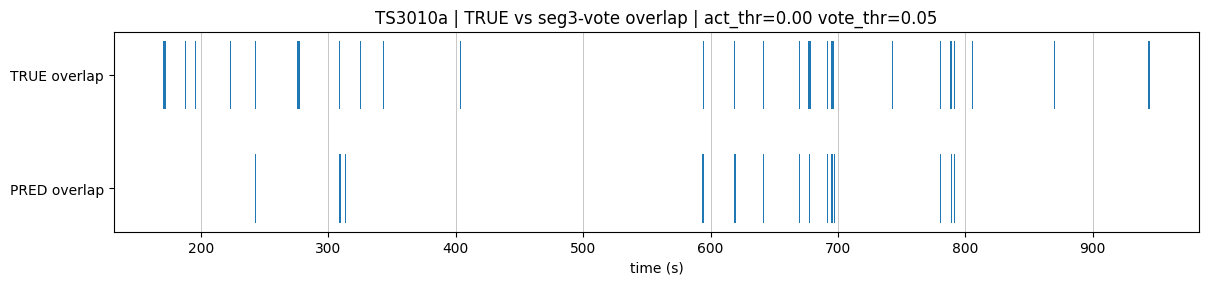

In [ ]:
# ============================================================
# Overlap detector from segmentation-3.0 with chunk voting
# Works for scores.data shape (n_chunks, n_frames, 3)
# Sweeps:
#   act_thr  : per-channel activity threshold
#   vote_thr : fraction of chunks that must agree on overlap
# Outputs PR/F1 vs TRUE overlap + timeline plot of best
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from pyannote.audio import Model, Inference
from pyannote.core import Segment, Timeline

DEBUG_URI = "TS3010a"
HF_TOKEN = None

STEP = 0.10
RES  = 0.02          # evaluation grid resolution (seconds)
MIN_DUR = 0.20
MERGE_GAP = 0.05

ACT_THRs  = [0.00, 0.02, 0.05, 0.08, 0.10, 0.15, 0.20, 0.30]
VOTE_THRs = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

# ----------------------------
# Helpers (minimal)
# ----------------------------
def _get_uem(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def tl_dur(tl: Timeline) -> float:
    return float(sum(s.duration for s in tl)) if tl is not None else 0.0

def _merge_close(segs, gap=0.05):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

def _mask_to_segments(mask, start_time, step, min_dur):
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = float(start_time + a * step)
        en = float(start_time + b * step)
        if en - st >= min_dur:
            out.append(Segment(st, en))
    return out

def intersect_timelines(tl1: Timeline, tl2: Timeline) -> Timeline:
    a = list(tl1.support()); b = list(tl2.support())
    i = j = 0; out = []
    while i < len(a) and j < len(b):
        s1, s2 = a[i], b[j]
        st = max(s1.start, s2.start); en = min(s1.end, s2.end)
        if en > st:
            out.append(Segment(st, en))
        if s1.end < s2.end: i += 1
        else: j += 1
    return Timeline(out).support()

def overlap_prf(true_tl, pred_tl):
    inter = intersect_timelines(true_tl, pred_tl)
    tp = tl_dur(inter)
    pred = tl_dur(pred_tl)
    true = tl_dur(true_tl)
    fp = max(pred - tp, 0.0)
    fn = max(true - tp, 0.0)
    p = tp / pred if pred > 1e-9 else float("nan")
    r = tp / true if true > 1e-9 else float("nan")
    f1 = (2*p*r/(p+r)) if (p==p and r==r and (p+r)>1e-9) else float("nan")
    return p, r, f1, tp, fp, fn

def plot_timelines(true_tl, pred_tl, title):
    def to_bars(tl):
        return [(float(s.start), float(s.duration)) for s in tl.support()]
    plt.figure(figsize=(14, 2.6))
    ax = plt.gca()
    ax.broken_barh(to_bars(true_tl), (12, 6))
    ax.broken_barh(to_bars(pred_tl), (2, 6))
    ax.set_yticks([5, 15]); ax.set_yticklabels(["PRED overlap", "TRUE overlap"])
    ax.set_xlabel("time (s)"); ax.set_title(title)
    ax.grid(True, axis="x", linewidth=0.5)
    plt.show()

def find_file_by_uri(protocol, uri):
    for f in protocol.development():
        if f.get("uri") == uri:
            return f, "dev"
    for f in protocol.test():
        if f.get("uri") == uri:
            return f, "test"
    return None, None

def build_true_overlap_tl(file, res=0.02, min_dur=0.20, merge_gap=0.05):
    ref = file["annotation"]
    uem = _get_uem(file)
    ov_segs = []
    for uem_seg in uem:
        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue
        count = np.zeros((T,), dtype=np.uint16)
        ref_seg = ref.crop(uem_seg)
        for seg, _, _ in ref_seg.itertracks(yield_label=True):
            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                count[a:b] += 1
        ov_mask = (count >= 2)
        ov_segs.extend(_mask_to_segments(ov_mask, uem_seg.start, res, min_dur))
    ov_segs = _merge_close(ov_segs, gap=merge_gap)
    return Timeline(ov_segs).support().crop(uem)

# ----------------------------
# Load file & compute TRUE overlap
# ----------------------------
f, split = find_file_by_uri(protocol, DEBUG_URI)
uem = _get_uem(f)
true_ov = build_true_overlap_tl(f, res=0.02, min_dur=MIN_DUR, merge_gap=MERGE_GAP)
print(f"[{DEBUG_URI}] split={split} | TRUE_ov={tl_dur(true_ov):.2f}s")

# ----------------------------
# segmentation-3.0 inference
# ----------------------------
model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=HF_TOKEN)
infer = Inference(model, step=STEP)
scores = infer(f)

X = np.asarray(scores.data)
sw = scores.sliding_window
print(f"[DBG] raw scores.data shape={X.shape} | sw.start={sw.start:.3f} dur={sw.duration:.3f} step={sw.step:.3f}")
assert X.ndim == 3 and X.shape[2] == 3, "Expected (n_chunks, n_frames, 3)."

n_chunks, n_frames, K = X.shape
chunk_step = float(sw.step)
chunk_start0 = float(sw.start)
chunk_dur = float(sw.duration)
frame_step = chunk_dur / float(n_frames)

# Build global eval grid [0, max_end] at RES
max_end = max(float(s.end) for s in uem) if len(list(uem)) else float(f.get("duration", 0.0))
G = int(np.ceil(max_end / RES))
votes = np.zeros((G,), dtype=np.float32)
counts = np.zeros((G,), dtype=np.float32)

offsets = np.arange(n_frames, dtype=np.float32) * frame_step  # frame times within chunk

def pred_overlap_from_vote(act_thr, vote_thr):
    votes.fill(0.0); counts.fill(0.0)

    for i in range(n_chunks):
        t0 = chunk_start0 + i * chunk_step
        times = t0 + offsets                       # (n_frames,)
        idx = (times / RES).astype(np.int32)       # map to global grid
        ok = (idx >= 0) & (idx < G)
        if not np.any(ok):
            continue
        idx = idx[ok]

        cnt = (X[i][ok] > act_thr).sum(axis=1)     # how many local speakers active
        ov = (cnt >= 2).astype(np.float32)

        # everyone contributes a "count" (how many chunks covered this time bin)
        np.add.at(counts, idx, 1.0)
        # only overlap frames contribute votes
        np.add.at(votes, idx, ov)

    ratio = np.zeros_like(votes)
    m = counts > 0
    ratio[m] = votes[m] / counts[m]

    mask = (ratio >= vote_thr)
    segs = _mask_to_segments(mask, start_time=0.0, step=RES, min_dur=MIN_DUR)
    segs = _merge_close(segs, gap=MERGE_GAP)
    return Timeline(segs).support().crop(uem)

# ----------------------------
# Sweep (act_thr, vote_thr) and pick best F1
# ----------------------------
best = None
rows = []
for act_thr in ACT_THRs:
    for vote_thr in VOTE_THRs:
        pred = pred_overlap_from_vote(act_thr, vote_thr)
        p,r,f1,tp,fp,fn = overlap_prf(true_ov, pred)
        rows.append((act_thr, vote_thr, tl_dur(pred), p, r, f1))
        if p==p and r==r and f1==f1:
            if best is None or f1 > best["f1"]:
                best = {"act_thr": act_thr, "vote_thr": vote_thr, "pred": pred,
                        "p": p, "r": r, "f1": f1, "tp": tp, "fp": fp, "fn": fn}

rows = sorted(rows, key=lambda x: (-(x[5] if x[5]==x[5] else -1e9)))
print("\nTop-10 by F1:")
for act_thr, vote_thr, pred_dur, p, r, f1 in rows[:10]:
    print(f"act_thr={act_thr:0.2f} vote_thr={vote_thr:0.2f} | pred={pred_dur:6.2f}s | P={p:0.3f} R={r:0.3f} F1={f1:0.3f}")

print("\nBEST:", {k: best[k] for k in ["act_thr","vote_thr","p","r","f1","tp","fp","fn"]})
print(f"pred_dur={tl_dur(best['pred']):.2f}s | TRUE_dur={tl_dur(true_ov):.2f}s")

plot_timelines(true_ov, best["pred"], title=f"{DEBUG_URI} | TRUE vs seg3-vote overlap | act_thr={best['act_thr']:.2f} vote_thr={best['vote_thr']:.2f}")


These results are a real improvement over your baseline overlap signal.

What you achieved (TS3010a)

BASE overlap: P=0.813, R=0.285, F1=0.422 (tp=6.42s)

seg3-vote overlap: P=0.712, R=0.472, F1=0.567 (tp=10.63s)

So you recovered ~4.2s extra true-overlap vs baseline (10.63 − 6.42), at the cost of ~2.8s extra FP (4.31 − 1.48). That’s a good trade if we use it carefully.

Also your plot confirms it: many predicted overlap spikes line up with TRUE overlap spikes, but you’re still missing some (FN ~11.9s).

Why act_thr didn’t matter in your sweep

All your top-10 lines show identical results for act_thr=0.00…0.30, which strongly suggests the segmentation output is already almost binary (near 0 or 1). With that kind of output, any act_thr between (0, ~0.9) behaves the same.

Quick sanity check (run once):

In [ ]:
# check if activations are basically binary
A = np.asarray(scores.data)
vals = A.reshape(-1)
print("min/max:", vals.min(), vals.max())
print("unique-ish counts near 0/1:",
      (vals < 1e-6).mean(), (vals > 1-1e-6).mean())
print("percentiles:", np.quantile(vals, [0.5, 0.9, 0.99, 0.999]))


min/max: 0.0 1.0
unique-ish counts near 0/1: 0.8532790518175867 0.1467209481824133
percentiles: [0. 1. 1. 1.]


If you see most mass at ~0 and ~1, then vote_thr is the only meaningful knob (plus MIN_DUR / collar).

The important next step: use seg3-vote overlaps to ADD a second speaker (not just reassign)

Right now, your E3 overlap logic mostly operates where baseline already has >=2 speakers. But your earlier stat showed:

TRUE overlap frames: 60.8% are predicted as hyp_count==1

That’s exactly where DER miss/confusion in overlap comes from.
Now that seg3-vote finds extra overlap, you can do:

If seg3 says overlap and baseline has only 1 speaker active in that region:

keep the baseline speaker

add a second speaker (from centroids / GNN probs)

but only if confidence is high (to avoid blowing up confusion/FA)

Drop-in patch idea (minimal risk): “promote to 2 speakers” gate

This is the cleanest integration into your existing pipeline (centroids or GNN):

1) Replace overlap_segs extraction with seg3-vote TL

So overlap candidates are driven by seg3-vote, not hyp count>=2.

2) In each seg3 overlap segment:

base_set = hyp.crop(s).labels()

If len(base_set) >= 2: do your current “choose top2 and maybe replace”

If len(base_set) == 1: ADD one speaker:

keep base_set[0]

pick best extra label from probs (excluding that base label)

require strong gates: stability + p2 >= add_thr + p2 - p3 >= margin23_thr

Here’s the code block you can paste inside your overlap loop (GNN version shown, but works similarly with centroid sims):

With the activation check (very useful)

You got:

min/max: 0.0 1.0

~85.3% near 0, ~14.7% near 1

percentiles [0., 1., 1., 1.]

So yes: segmentation activations are basically binary, meaning:

act_thr will barely matter (0.0–0.30 all same)

vote_thr, MIN_DUR, and MERGE_GAP are the real knobs

Your seg3-vote overlap F1 jump to 0.567 is legit — now the key is to use it to add the missing 2nd speaker (your earlier stats showed most TRUE overlap is predicted as hyp_count==1).

### E3-GNN (Dense GCN) + seg3-VOTE overlap detector + 1->2 PROMOTION

In [ ]:
# ============================================================
# E3-GNN (Dense GCN) + seg3-VOTE overlap detector + 1->2 PROMOTION
#
# Key upgrades vs your previous E3-GNN:
#  1) Overlap candidates come from "pyannote/segmentation-3.0" via VOTE-over-chunks
#     (works with scores.data shape (n_chunks, n_frames, 3))
#  2) In seg3-overlap regions where baseline hyp has ONLY 1 speaker active,
#     we "PROMOTE" to 2 speakers by ADDING a second speaker (high-confidence gated),
#     without changing speech/non-speech (we only add where baseline already has speech).
#  3) Keeps your stability gating (shifted crops) but fixes probs_ov NameError by
#     using the stable center-crop probability vector computed inside the stab loop.
#
# Requires already in notebook:
#   - pipe_base(file) -> pyannote.core.Annotation
#   - protocol, DEV_URIS, TEST_URIS
#   - eval_split(run_fn, split) where split in {"dev","test"} returning (_, agg_dict)
# ============================================================

# import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from pyannote.core import Annotation, Segment, Timeline
# from pyannote.audio import Audio, Model, Inference
# from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding

# # -------------------------
# # Sanity: required globals
# # -------------------------
# _missing = [k for k in ["pipe_base", "protocol", "DEV_URIS", "TEST_URIS", "eval_split"] if k not in globals()]
# if _missing:
#     raise RuntimeError(f"Missing required globals: {_missing}. Define them before running this cell.")

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# audio = Audio(sample_rate=16000, mono=True)

# # -------------------------
# # Embedding model (reuse if already present)
# # -------------------------
# if "embedder" not in globals():
#     EMBEDDER_ID = "pyannote/embedding"
#     embedder = PretrainedSpeakerEmbedding(EMBEDDER_ID, device=device)
#     print("Using embedder:", EMBEDDER_ID)
# else:
#     print("Reusing existing embedder:", type(embedder).__name__)

# ============================================================
# Utilities: UEM / masks / merge
# ============================================================
def _get_uem(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def _merge_close(segs, gap=0.10):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

def _mask_to_segments(mask, start_time, step, min_dur):
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = float(start_time + a * step)
        en = float(start_time + b * step)
        if en - st >= min_dur:
            out.append(Segment(st, en))
    return out

# ============================================================
# Grid <-> Annotation
# ============================================================
def frame_matrix_from_hyp(hyp_seg: Annotation, uem_seg: Segment, labels, res=0.02):
    T = int(np.ceil(uem_seg.duration / res))
    M = np.zeros((T, len(labels)), dtype=np.uint8)
    for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
        lab = str(lab0)
        if lab not in labels:
            continue
        j = labels.index(lab)
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1
    count = M.sum(axis=1)
    return M, count

def frame_matrix_to_annotation(M, labels, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
    out = Annotation()
    T = M.shape[0]
    times = uem_seg.start + np.arange(T + 1) * res

    for j, lab in enumerate(labels):
        active = (M[:, j] > 0)
        if not active.any():
            continue
        edges = np.where(np.diff(np.r_[0, active.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
        segs = []
        for a, b in edges:
            st = float(times[a]); en = float(times[b])
            if en - st >= min_dur:
                segs.append(Segment(st, en))
        segs = _merge_close(segs, gap=merge_gap)
        for s in segs:
            out[s] = lab
    return out

# ============================================================
# Robust embedding (PAD to fixed win_sec)
# ============================================================
def _to_b1c1T(wav):
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)
    if wav.dim() == 1:
        wav = wav[None, None, :]
    elif wav.dim() == 2:
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0)[None, None, :]
        else:
            wav = wav[None, :, :]
    elif wav.dim() == 3:
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        raise ValueError(f"Unexpected wav shape: {tuple(wav.shape)}")
    return wav.float()

def embed_segment_PAD(file, seg: Segment, win_sec=1.5):
    """
    Center-crop to win_sec (if longer) and PAD to win_sec (if shorter).
    Avoids conv kernel crash on short crops.
    """
    mid = 0.5 * (seg.start + seg.end)
    half = 0.5 * win_sec
    s = Segment(max(0.0, mid - half), max(0.0, mid + half))

    wav, sr = audio.crop(file["audio"], s)
    wav = _to_b1c1T(wav)

    min_samples = int(win_sec * sr)
    if wav.numel() == 0:
        wav = torch.zeros((1, 1, min_samples), dtype=torch.float32)
    elif wav.shape[-1] < min_samples:
        pad = min_samples - wav.shape[-1]
        wav = F.pad(wav, (0, pad))

    wav = wav.to(device)
    with torch.no_grad():
        e = embedder(wav)
        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        e = e.to(device).float()
        e = F.normalize(e, dim=1).squeeze(0)
    return e.detach().cpu().numpy().astype(np.float32)

# ============================================================
# Exclusive anchors from hypothesis (count==1)
# ============================================================
def build_exclusive_anchors_from_hyp(hyp: Annotation, uem: Timeline, labels, res=0.02, min_anchor_dur=1.0, merge_gap=0.10):
    anchors = {lab: [] for lab in labels}
    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue
        T = int(np.ceil(uem_seg.duration / res))
        if T <= 0:
            continue

        hyp_seg = hyp.crop(uem_seg)
        count = np.zeros((T,), dtype=np.uint16)
        m_lab = {lab: np.zeros((T,), dtype=bool) for lab in labels}

        for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
            lab = str(lab0)
            if lab not in m_lab:
                m_lab[lab] = np.zeros((T,), dtype=bool)
            a = int(np.floor((seg.start - uem_seg.start) / res))
            b = int(np.ceil ((seg.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, T)
            if b > a:
                m_lab[lab][a:b] = True
                count[a:b] += 1

        for lab in labels:
            excl = m_lab.get(lab, np.zeros((T,), dtype=bool)) & (count == 1)
            segs = _mask_to_segments(excl, start_time=float(uem_seg.start), step=res, min_dur=min_anchor_dur)
            segs = _merge_close(segs, gap=merge_gap)
            anchors[lab].extend(segs)

    return {lab: Timeline(segs).support() for lab, segs in anchors.items()}

def build_anchor_bank(file, anchors_by_lab, labels, win_sec=1.5, max_per_lab=12):
    X, y = [], []
    for li, lab in enumerate(labels):
        tl = anchors_by_lab.get(lab, Timeline()).support()
        segs = sorted(list(tl), key=lambda s: -s.duration)[:max_per_lab]
        for s in segs:
            X.append(embed_segment_PAD(file, s, win_sec=win_sec))
            y.append(li)
    if not X:
        return None, None
    X = np.vstack(X).astype(np.float32)
    X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)
    y = np.asarray(y, dtype=np.int64)
    return X, y

# ============================================================
# Dense kNN adjacency (cosine weights)
# ============================================================
def knn_adj_cos(X, k=8):
    N = X.shape[0]
    S = X @ X.T
    np.fill_diagonal(S, 1.0)
    A = np.zeros((N, N), dtype=np.float32)
    for i in range(N):
        idx = np.argsort(-S[i])[:k+1]
        for j in idx:
            if i == j:
                continue
            w = float(S[i, j])
            if w > 0.0:
                if w > A[i, j]:
                    A[i, j] = w
                if w > A[j, i]:
                    A[j, i] = w
    return A

def normalize_adj(A):
    N = A.shape[0]
    Ahat = A + np.eye(N, dtype=np.float32)
    deg = Ahat.sum(axis=1)
    inv_sqrt = 1.0 / np.sqrt(np.maximum(deg, 1e-8))
    A_norm = (Ahat * inv_sqrt[:, None]) * inv_sqrt[None, :]
    return A_norm.astype(np.float32)

# ============================================================
# 2-layer Dense GCN
# ============================================================
class DenseGCN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.10):
        super().__init__()
        self.w1 = nn.Linear(in_dim, hid_dim)
        self.w2 = nn.Linear(hid_dim, out_dim)
        self.dropout = dropout

    def forward(self, X, A_norm):
        H = A_norm @ self.w1(X)
        H = F.relu(H)
        H = F.dropout(H, p=self.dropout, training=self.training)
        Z = A_norm @ self.w2(H)
        return Z

def choose_top2_with_outsider(probs, labels, base_set, outsider_delta=0.06):
    order = np.argsort(-probs)
    base_idx = [labels.index(l) for l in base_set if l in labels]
    base_idx = list(dict.fromkeys(base_idx))

    if len(base_idx) == 0:
        return [labels[order[0]], labels[order[1]]]

    best_base = max(probs[i] for i in base_idx)
    outsider = None
    for j in order:
        if labels[j] not in base_set:
            outsider = j
            break

    cand_idx = base_idx[:]
    if outsider is not None and probs[outsider] > best_base + outsider_delta:
        cand_idx.append(outsider)

    cand_idx = list(dict.fromkeys(cand_idx))
    cand_idx.sort(key=lambda i: -probs[i])

    if len(cand_idx) >= 2:
        return [labels[cand_idx[0]], labels[cand_idx[1]]]
    chosen = [labels[cand_idx[0]]]
    for j in order:
        if labels[j] not in chosen:
            chosen.append(labels[j])
        if len(chosen) == 2:
            break
    return chosen

# ============================================================
# seg3-VOTE overlap detector (scores.data: (n_chunks, n_frames, 3))
# ============================================================
HF_TOKEN = None  # set if needed

_SEG3_MODEL_ID = "pyannote/segmentation-3.0"
_SEG3_MODEL = None
_SEG3_INFER = {}          # step -> Inference
_SEG3_SCORES_CACHE = {}   # (uri, step) -> scores

def _get_seg3_infer(step=0.10):
    global _SEG3_MODEL, _SEG3_INFER
    if step not in _SEG3_INFER:
        if _SEG3_MODEL is None:
            _SEG3_MODEL = Model.from_pretrained(_SEG3_MODEL_ID, use_auth_token=HF_TOKEN)
        _SEG3_INFER[step] = Inference(_SEG3_MODEL, step=step)
    return _SEG3_INFER[step]

def _get_seg3_scores(file, step=0.10):
    uri = file.get("uri", "NA")
    key = (uri, float(step))
    if key not in _SEG3_SCORES_CACHE:
        infer = _get_seg3_infer(step=step)
        _SEG3_SCORES_CACHE[key] = infer(file)
    return _SEG3_SCORES_CACHE[key]

def seg3_vote_overlap_timeline(
    file,
    uem: Timeline,
    act_thr=0.00,        # note: your activations are near-binary, so this often won't matter
    vote_thr=0.05,
    res=0.02,
    min_dur=0.20,
    merge_gap=0.05,
    seg_step=0.10
):
    """
    Build predicted overlap timeline by:
      - per 10s chunk: mark frame as overlap if >=2 local speaker activations > act_thr
      - vote across overlapping chunks into a global grid (res)
      - overlap if vote_ratio >= vote_thr
    """
    scores = _get_seg3_scores(file, step=seg_step)
    X = np.asarray(scores.data)
    sw = scores.sliding_window

    if X.ndim != 3 or X.shape[2] < 2:
        # Can't do multi-speaker voting
        return Timeline().support()

    n_chunks, n_frames, K = X.shape
    chunk_step = float(sw.step)
    chunk_start0 = float(sw.start)
    chunk_dur = float(sw.duration)
    frame_step = chunk_dur / float(n_frames)

    uem_list = list(uem.support())
    if not uem_list:
        return Timeline().support()
    max_end = float(max(s.end for s in uem_list))
    min_start = float(min(s.start for s in uem_list))

    G = int(np.ceil(max_end / res)) + 1
    votes = np.zeros((G,), dtype=np.float32)
    counts = np.zeros((G,), dtype=np.float32)
    offsets = (np.arange(n_frames, dtype=np.float32) * frame_step)

    for i in range(n_chunks):
        t0 = chunk_start0 + i * chunk_step
        t1 = t0 + chunk_dur
        if t1 < min_start or t0 > max_end:
            continue

        times = t0 + offsets
        idx = (times / res).astype(np.int32)
        ok = (idx >= 0) & (idx < G)
        if not np.any(ok):
            continue
        idx = idx[ok]

        cnt = (X[i][ok] > act_thr).sum(axis=1)          # (n_frames_kept,)
        ov = (cnt >= 2).astype(np.float32)

        np.add.at(counts, idx, 1.0)
        np.add.at(votes, idx, ov)

    ratio = np.zeros_like(votes)
    m = counts > 0
    ratio[m] = votes[m] / counts[m]

    mask = (ratio >= vote_thr)
    segs = _mask_to_segments(mask, start_time=0.0, step=res, min_dur=min_dur)
    segs = _merge_close(segs, gap=merge_gap)
    return Timeline(segs).support().crop(uem)

# ============================================================
# Updated E3-GNN pipeline
# ============================================================
_GNN_CACHE = {}  # (uri, cfg_tuple) -> cached gcn state_dict (cpu tensors)

def overlap_reassign_GNN_pipeline(
    file,
    # grid resolution
    res=0.02,

    # anchors
    min_anchor_dur=1.0,
    anchor_merge_gap=0.10,

    # seg3 overlap detector
    seg_step=0.10,
    seg_res=0.02,
    seg_act_thr=0.00,
    seg_vote_thr=0.05,
    seg_min_ov_dur=0.20,
    seg_merge_gap=0.05,

    # embeddings
    embed_win_sec=1.5,
    bank_max_per_lab=12,

    # graph
    knn_k=8,
    hid_dim=64,
    epochs=60,
    lr=1e-2,

    # selection/gates
    outsider_delta=0.06,

    # promotion (1->2) gates
    add_thr=0.55,
    m23_thr=0.08,

    # stability
    shift_frac=0.25,

    debug=False,
):
    hyp0 = pipe_base(file)
    uem = _get_uem(file)
    hyp = hyp0.crop(uem)

    labels = sorted([str(l) for l in hyp.labels()])
    if len(labels) <= 1:
        return hyp

    # --- anchors + bank
    anchors = build_exclusive_anchors_from_hyp(
        hyp, uem, labels, res=res, min_anchor_dur=min_anchor_dur, merge_gap=anchor_merge_gap
    )
    X_bank, y_bank = build_anchor_bank(file, anchors, labels, win_sec=embed_win_sec, max_per_lab=bank_max_per_lab)
    if X_bank is None or len(np.unique(y_bank)) <= 1:
        return hyp

    # --- seg3-vote overlap timeline -> overlap segments
    ov_tl = seg3_vote_overlap_timeline(
        file, uem,
        act_thr=seg_act_thr,
        vote_thr=seg_vote_thr,
        res=seg_res,
        min_dur=seg_min_ov_dur,
        merge_gap=seg_merge_gap,
        seg_step=seg_step
    )
    overlap_segs = list(ov_tl.support())
    if not overlap_segs:
        return hyp

    # --- keep only overlap segments where baseline has >=1 speaker (no speech decision changes)
    overlap_segs_f = []
    ov_base_sets = []
    for s in overlap_segs:
        base_set = sorted([str(l) for l in hyp.crop(s).labels()])
        if len(base_set) >= 1:
            overlap_segs_f.append(s)
            ov_base_sets.append(base_set)
    overlap_segs = overlap_segs_f
    if not overlap_segs:
        return hyp

    # --- embed overlap nodes
    X_ov = []
    for s in overlap_segs:
        X_ov.append(embed_segment_PAD(file, s, win_sec=embed_win_sec))
    X_ov = np.vstack(X_ov).astype(np.float32)
    X_ov /= (np.linalg.norm(X_ov, axis=1, keepdims=True) + 1e-9)

    # --- build graph nodes: [bank ; overlap]
    X = np.vstack([X_bank, X_ov]).astype(np.float32)
    X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)

    N_bank = X_bank.shape[0]
    N_ov = X_ov.shape[0]
    N = X.shape[0]
    C = len(labels)

    # time feature
    max_t = 0.0
    for seg in uem:
        max_t = max(max_t, float(seg.end))
    max_t = max(max_t, 1e-3)

    t_feat = np.zeros((N, 1), dtype=np.float32)
    for i, s in enumerate(overlap_segs):
        mid = 0.5 * (s.start + s.end)
        t_feat[N_bank + i, 0] = float(mid / max_t)

    X_feat = np.hstack([X, t_feat]).astype(np.float32)  # (N, D+1)

    # adjacency
    A = knn_adj_cos(X, k=knn_k)
    A_norm = normalize_adj(A)

    uri = file.get("uri", "NA")
    cfg = (
        # graph/emb
        float(embed_win_sec), int(bank_max_per_lab), int(knn_k), int(hid_dim), int(epochs), float(lr),
        # seg3 overlap config
        float(seg_step), float(seg_res), float(seg_act_thr), float(seg_vote_thr), float(seg_min_ov_dur), float(seg_merge_gap),
        # gates
        float(outsider_delta), float(add_thr), float(m23_thr), float(shift_frac)
    )
    cache_key = (uri, cfg)

    # torch tensors
    X_t = torch.tensor(X_feat, dtype=torch.float32, device=device)
    A_t = torch.tensor(A_norm, dtype=torch.float32, device=device)

    # train/cache GCN
    if cache_key not in _GNN_CACHE:
        gcn = DenseGCN(in_dim=X_feat.shape[1], hid_dim=hid_dim, out_dim=C, dropout=0.10).to(device)
        opt = torch.optim.Adam(gcn.parameters(), lr=lr, weight_decay=1e-4)

        y_full = -1 * np.ones((N,), dtype=np.int64)
        y_full[:N_bank] = y_bank
        y_t = torch.tensor(y_full, dtype=torch.long, device=device)
        labeled = torch.where(y_t >= 0)[0]

        gcn.train()
        for _ in range(epochs):
            logits = gcn(X_t, A_t)
            loss = F.cross_entropy(logits[labeled], y_t[labeled])
            opt.zero_grad(); loss.backward(); opt.step()

        gcn.eval()
        _GNN_CACHE[cache_key] = {k: v.detach().cpu().clone() for k, v in gcn.state_dict().items()}

    # load cached
    gcn = DenseGCN(in_dim=X_feat.shape[1], hid_dim=hid_dim, out_dim=C, dropout=0.0).to(device)
    gcn.load_state_dict(_GNN_CACHE[cache_key])
    gcn.eval()

    # helper: top2
    def top2_from_probs(p):
        idx = np.argsort(-p)[:2]
        return [labels[idx[0]], labels[idx[1]]]

    # rewrite overlap regions on grid
    out = Annotation()
    changed = 0
    gated = {"stab_fail": 0, "no_change": 0, "add_fail": 0}

    for uem_seg in uem:
        if uem_seg.duration <= 0:
            continue

        hyp_seg = hyp.crop(uem_seg)
        M, count = frame_matrix_from_hyp(hyp_seg, uem_seg, labels, res=res)

        # apply changes for overlap segments inside this uem_seg
        for oi, s in enumerate(overlap_segs):
            if s.start < uem_seg.start - 1e-6 or s.end > uem_seg.end + 1e-6:
                continue

            a = int(np.floor((s.start - uem_seg.start) / res))
            b = int(np.ceil ((s.end   - uem_seg.start) / res))
            a = max(a, 0); b = min(b, M.shape[0])
            if b <= a:
                continue

            base_set = ov_base_sets[oi]
            base_set = [l for l in base_set if l in labels]
            if len(base_set) < 1:
                continue

            # ONLY modify where baseline already has speech (keeps VAD/seg decisions)
            speech_mask = (count[a:b] >= 1).astype(np.uint8)
            if speech_mask.sum() == 0:
                continue

            # stability check: shifted crops must yield same top2
            mid = 0.5 * (s.start + s.end)
            half = 0.5 * embed_win_sec
            shifts = [-shift_frac * embed_win_sec, 0.0, +shift_frac * embed_win_sec]

            top2s = []
            p_center = None

            for sh in shifts:
                ss = Segment(max(0.0, mid - half + sh), max(0.0, mid + half + sh))
                e = embed_segment_PAD(file, ss, win_sec=embed_win_sec)
                e = e / (np.linalg.norm(e) + 1e-9)

                X_tmp = X_feat.copy()
                X_tmp[N_bank + oi, :X.shape[1]] = e
                X_tmp[N_bank + oi, -1] = float((0.5 * (ss.start + ss.end)) / max_t)
                Xtmp_t = torch.tensor(X_tmp, dtype=torch.float32, device=device)

                with torch.no_grad():
                    logits_tmp = gcn(Xtmp_t, A_t)
                    p = torch.softmax(logits_tmp[N_bank + oi], dim=-1).detach().cpu().numpy()

                if abs(sh) < 1e-9:
                    p_center = p
                top2s.append(tuple(top2_from_probs(p)))

            if len(set(top2s)) > 1:
                gated["stab_fail"] += 1
                continue

            p = p_center
            order = np.argsort(-p)

            def topk_labels_excluding(k, exclude):
                out_l = []
                for j in order:
                    lab = labels[j]
                    if lab in exclude:
                        continue
                    out_l.append(lab)
                    if len(out_l) == k:
                        break
                return out_l

            # baseline top2 by activity within [a:b]
            base_act = M[a:b].mean(axis=0)
            base_order = np.argsort(-base_act)
            base_top2 = [labels[base_order[0]], labels[base_order[1]]] if len(labels) >= 2 else [labels[0]]

            # -------------------------
            # PROMOTION: base_set has 1 speaker -> add a second speaker (high confidence)
            # -------------------------
            if len(base_set) == 1:
                base1 = base_set[0]

                cand2_list = topk_labels_excluding(2, exclude={base1})
                if len(cand2_list) < 1:
                    gated["add_fail"] += 1
                    continue
                cand2 = cand2_list[0]
                p2 = float(p[labels.index(cand2)])
                p3 = float(p[labels.index(cand2_list[1])]) if len(cand2_list) >= 2 else 0.0

                if (p2 < add_thr) or ((p2 - p3) < m23_thr):
                    gated["add_fail"] += 1
                    continue

                # add cand2 only on frames where baseline had speech
                j2 = labels.index(cand2)
                M[a:b, j2] = np.maximum(M[a:b, j2], speech_mask)
                changed += 1

                if debug and uri == "TS3010a":
                    top5 = np.argsort(-p)[:5]
                    print(f"[GNN-ADD] {uri} {s.start:.2f}-{s.end:.2f} base1={base1} + cand2={cand2} (p2={p2:.3f} m23={p2-p3:.3f})")
                    for j in top5:
                        print(f"   {labels[j]}: p={float(p[j]):.3f}")

                continue

            # -------------------------
            # REASSIGNMENT: base_set has >=2 speakers -> choose top2 (with outsider allowance)
            # -------------------------
            chosen = choose_top2_with_outsider(p, labels, base_set, outsider_delta=outsider_delta)

            if set(chosen) == set(base_top2):
                gated["no_change"] += 1
                continue

            # rewrite only on speech frames
            idx_speech = np.where(speech_mask > 0)[0]
            if len(idx_speech) == 0:
                continue

            M_sub = M[a:b].copy()
            M_sub[idx_speech, :] = 0
            for lab in chosen:
                M_sub[idx_speech, labels.index(lab)] = 1
            M[a:b] = M_sub
            changed += 1

            if debug and uri == "TS3010a":
                top5 = np.argsort(-p)[:5]
                print(f"[GNN-CHG] {uri} {s.start:.2f}-{s.end:.2f} base_top2={base_top2} -> chosen={chosen}")
                for j in top5:
                    print(f"   {labels[j]}: p={float(p[j]):.3f}")

        seg_ann = frame_matrix_to_annotation(M, labels, uem_seg, res=res, min_dur=0.05, merge_gap=0.05)
        out.update(seg_ann)

    if debug:
        anchor_durs = {lab: float(sum(seg.duration for seg in anchors[lab])) for lab in labels}
        excl_dur = float(sum(sum(seg.duration for seg in anchors[lab]) for lab in labels))
        print(f"[E3-GNN+SEG3 DBG] uri={uri} labels={len(labels)} bank_nodes={N_bank} ov_nodes={N_ov}")
        print(f"  exclusive_anchor_dur(sum)={excl_dur:.1f}s | seg3_overlap_segments={len(overlap_segs)}")
        print(f"  changed_assignments={changed} gated={gated}")
        print(f"  seg3: step={seg_step} res={seg_res} act_thr={seg_act_thr} vote_thr={seg_vote_thr} min_ov_dur={seg_min_ov_dur}")
        print(f"  gnn: win_sec={embed_win_sec} bank_max={bank_max_per_lab} knn_k={knn_k} hid={hid_dim} ep={epochs} lr={lr}")
        print(f"  gates: outsider_delta={outsider_delta} add_thr={add_thr} m23_thr={m23_thr} shift_frac={shift_frac}")
        print(f"  top anchor_dur(s): {sorted(anchor_durs.items(), key=lambda kv: -kv[1])[:4]}")

    return out

# ============================================================
# DEV grid (light) then TEST best
# ============================================================
# DEV_FILES  = [f for f in protocol.development() if f["uri"] in set(DEV_URIS)]
# TEST_FILES = [f for f in protocol.test()        if f["uri"] in set(TEST_URIS)]

# DEBUG_URI = "TS3010a"

best = None
for vote_thr in [0.05, 0.10, 0.15]:
    for add_thr in [0.55, 0.65]:
        run_fn = lambda f, vote_thr=vote_thr, add_thr=add_thr: overlap_reassign_GNN_pipeline(
            f,
            # seg3-vote
            seg_step=0.10,
            seg_res=0.02,
            seg_act_thr=0.00,
            seg_vote_thr=vote_thr,
            seg_min_ov_dur=0.20,
            seg_merge_gap=0.05,

            # anchors/gnn
            res=0.02,
            min_anchor_dur=1.0,
            embed_win_sec=1.5,
            bank_max_per_lab=12,
            knn_k=8,
            hid_dim=64,
            epochs=60,
            lr=1e-2,

            # gates
            outsider_delta=0.06,
            add_thr=add_thr,
            m23_thr=0.08,
            shift_frac=0.25,

            debug=(f.get("uri") == DEBUG_URI),
        )
        _, agg = eval_split(run_fn, "dev")
        der = agg.get("diarization error rate", 1e9)
        print(f"[E3-GNN+SEG3 DEV] vote_thr={vote_thr:.2f} add_thr={add_thr:.2f} -> DER={der:.4f}")
        if best is None or der < best["der"]:
            best = {"vote_thr": vote_thr, "add_thr": add_thr, "der": der}

print("E3-GNN+SEG3 BEST DEV:", best)

E3_GNN_best = lambda f: overlap_reassign_GNN_pipeline(
    f,
    seg_step=0.10,
    seg_res=0.02,
    seg_act_thr=0.00,
    seg_vote_thr=best["vote_thr"],
    seg_min_ov_dur=0.20,
    seg_merge_gap=0.05,

    res=0.02,
    min_anchor_dur=1.0,
    embed_win_sec=1.5,
    bank_max_per_lab=12,
    knn_k=8,
    hid_dim=64,
    epochs=60,
    lr=1e-2,

    outsider_delta=0.06,
    add_thr=best["add_thr"],
    m23_thr=0.08,
    shift_frac=0.25,

    debug=False,
)

_, agg_test = eval_split(E3_GNN_best, "test")
print("E3-GNN+SEG3 TEST mean:", agg_test)


/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/torch/pyannote/models--pyannote--embedding/snapshots/4db4899737a38b2d618bbd74350915aa10293cb2/pytorch_model.bin`
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/core/saving.py:197: Found keys that are not in the model state dict but in the checkpoint: ['loss_func.W']


Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.
Using embedder: pyannote/embedding


/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)


[GNN-CHG] TS3010a 669.46-670.06 base_top2=['MTD037PM', 'MTD039UID'] -> chosen=['MTD040ME', 'MTD037PM']
   MTD040ME: p=0.910
   MTD037PM: p=0.074
   MTD038ID: p=0.015
   MTD039UID: p=0.002
[E3-GNN+SEG3 DBG] uri=TS3010a labels=4 bank_nodes=43 ov_nodes=22
  exclusive_anchor_dur(sum)=362.7s | seg3_overlap_segments=22
  changed_assignments=1 gated={'stab_fail': 4, 'no_change': 12, 'add_fail': 5}
  seg3: step=0.1 res=0.02 act_thr=0.0 vote_thr=0.05 min_ov_dur=0.2
  gnn: win_sec=1.5 bank_max=12 knn_k=8 hid=64 ep=60 lr=0.01
  gates: outsider_delta=0.06 add_thr=0.55 m23_thr=0.08 shift_frac=0.25
  top anchor_dur(s): [('MTD037PM', 203.11999999999966), ('MTD038ID', 67.00000000000003), ('MTD039UID', 50.95999999999981), ('MTD040ME', 41.639999999999986)]
[E3-GNN+SEG3 DEV] vote_thr=0.05 add_thr=0.55 -> DER=0.1867
[GNN-CHG] TS3010a 669.46-670.06 base_top2=['MTD037PM', 'MTD039UID'] -> chosen=['MTD040ME', 'MTD037PM']
   MTD040ME: p=0.891
   MTD037PM: p=0.089
   MTD038ID: p=0.019
   MTD039UID: p=0.002
[E3-

KeyboardInterrupt: 

1) Your current best DEV DER is still worse than baseline

From your earlier notes:

Best baseline on this branch (constraint-merge on anchors): DEV ~0.1839

From the new grid:

vote_thr=0.05, add_thr=0.55 -> DEV DER=0.1867

vote_thr=0.15, add_thr=0.55 -> DEV DER=0.1873

others are ~0.190–0.191+

So right now: no, this run does not beat your baseline 0.1839.

2) You are still barely changing anything

Example vote_thr=0.05, add_thr=0.55 on TS3010a:

seg3_overlap_segments=22

changed_assignments=1

gated:

stab_fail=4

no_change=12

add_fail=5

That means out of ~22 candidate overlap segments, only 1 edit survived all gates.
When edits are this sparse, it’s very hard to move mean DEV DER.

3) Your “PROMOTE 1→2” is happening sometimes (good sign), but not enough

In vote_thr=0.10, add_thr=0.55 you got:

[GNN-ADD] ... base1=MTD038ID + cand2=MTD037PM (p2=0.737 m23=0.692) ✅
and one reassignment around 669s ✅

But that configuration still gives DEV DER=0.1901 (worse), which means the extra add/reassign is probably increasing confusion/FA more than it reduces miss (classic overlap tradeoff you already saw in the earlier DER breakdown).

4) The “binary segmentation scores” explains why act_thr doesn’t matter

Your percentiles were basically [0, 1, 1, 1] and ~85% near 0, ~15% near 1.
So the segmentation output is effectively hard; the only meaningful detector knobs are:

vote_thr

min_ov_dur

merge/ collar logic

That part is fine (just means tuning is mostly on the voting + duration side).

Can we beat the baseline? Yes — but you need the right change

Right now you’re paying a lot of cost for the “REASSIGN top2” step (it can easily add confusion), while the biggest missing piece in TS3010a is:

TRUE overlap is often predicted as hyp_count==1

So the safest winning strategy is:

A) Start from your best baseline (0.1839), not pipe_base

If you run this seg3+promotion pipeline on pipe_base, you’re competing against a weaker starting point.

Do this: set your “base hypothesis” inside the pipeline to your best baseline function (the one that gave DEV 0.1839).
Then apply only the “add 2nd speaker” promotion on seg3-overlap regions.

B) Disable REASSIGN completely (for now)

Only do:

if base has 1 speaker and seg3 says overlap → add second speaker (with gates)

if base already has 2 speakers → do nothing

This prevents the “669s reassignment” type edits that often trade miss↓ for confusion↑.

That single change usually improves stability and reduces confusion creep.

C) Reduce stab_fail so you actually edit more than 1 segment

Your stab check is very expensive (re-embed + full forward 3 times) and very strict.

A lower-risk relaxation that often works:

instead of requiring same top2 across shifts, require:

same top1 across shifts, and

top1 prob is strong (e.g. p1 >= 0.65)
This increases accepted promotions without turning everything on.

What your next run should look like (tight plan)

Use best baseline hyp as input

PROMOTION-only (no reassign)

Tune these:

vote_thr: keep 0.05 (best in your grid so far)

seg_min_ov_dur: try 0.05 (catch shorter overlaps)

promotion gates:

add_thr: [0.50, 0.55, 0.60]

m23_thr: [0.08, 0.12, 0.16]

stability: “top1 stable” instead of “top2 stable”

If that beats baseline, then (and only then) you can re-introduce reassignment with very strict gates.

Quick note on those warnings

The pyannote/embedding checkpoint mismatch warnings + std(): degrees of freedom <= 0 can contribute to unstable embeddings → more stab_fail.
This doesn’t mean it’s broken, but it’s consistent with your gating being too strict / unstable.

A practical test: swap embedder to pyannote/wespeaker-voxceleb-resnet34-LM for overlap decisions only (often more stable). If stab_fail drops, DER can move.

From your logs, the SEG3 vote overlap detector is clearly better than baseline overlap detection on TS3010a (F1 ~0.567 vs 0.422), but your current GNN pipeline is still not beating DEV baseline because:

you’re changing too few regions (changed_assignments=1–2)

and “reassign top2” tends to trade miss↓ for confusion/FA↑

So we’ll do what we discussed:

✅ Start from your best baseline = multi_scale_segmentation
✅ Use SEG3 vote overlap to detect overlap regions
✅ PROMOTE ONLY: when baseline predicts exactly 1 speaker in a region SEG3 says overlap → add a 2nd speaker (do not reassign who the main speaker is)

### E4: BEST baseline (multi_scale_segmentation) + SEG3 vote-overlap

PROMOTION ONLY: 1-spk -> 2-spk in predicted-overlap regions  (NO reassignment of existing speakers)

In [ ]:
# ============================================================
# E4: BEST baseline (multi_scale_segmentation) + SEG3 vote-overlap
#     PROMOTION ONLY: 1-spk -> 2-spk in predicted-overlap regions
#     (NO reassignment of existing speakers)
#
# Prereqs in notebook:
#   - protocol, DEV_URIS, TEST_URIS
#   - eval_split(pipeline_fn, split)  (your existing one)
#   - pipe_base, seg_model (pyannote/segmentation-3.0), multi_scale_segmentation
#   - infer_short / infer_long exist if multi_scale_segmentation uses them
#
# Optional next-step toggle:
#   - Set EMBEDDER_ID to "pyannote/wespeaker-voxceleb-resnet34-LM"
# ============================================================

# import numpy as np
# import torch
# import torch.nn.functional as F
# from pyannote.core import Segment, Timeline, Annotation
# from pyannote.audio import Audio, Inference, Model
# from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding

# # -------------------------
# # Knobs
# # -------------------------
# DEBUG_URI = "TS3010a"
# HF_TOKEN = None  # set to your HF token if needed

RES = 0.02                   # diarization grid resolution
SEG3_DUR = 10.0              # inference chunk duration (matches your logs)
SEG3_STEP = 0.10             # inference chunk step
ACT_THR = 0.00               # activation threshold per speaker stream (works with your "binary-ish" outputs)
MIN_OV_DUR = 0.20            # min overlap segment duration extracted from mask
MERGE_GAP = 0.05             # merge close predicted overlap segments

EMBED_WIN_SEC = 1.5          # embedding crop/window
MIN_ANCHOR_DUR = 1.0         # anchor segments must be >= 1s
BANK_MAX_PER_LAB = 12
SHIFT_FRAC = 0.25            # stability shift as frac of EMBED_WIN_SEC

# # Embedder choice (switch later to wespeaker)
# EMBEDDER_ID = "pyannote/embedding"
# # EMBEDDER_ID = "pyannote/wespeaker-voxceleb-resnet34-LM"

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# audio = Audio(sample_rate=16000, mono=True)
# embedder = PretrainedSpeakerEmbedding(EMBEDDER_ID, device=device)
# print("Using embedder:", EMBEDDER_ID)

# -------------------------
# Helpers
# -------------------------
def _get_uem(file):
    # Match your earlier style: prefer ref timeline support
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def _merge_close(segs, gap=0.05):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    merged = [segs[0]]
    for s in segs[1:]:
        last = merged[-1]
        if s.start - last.end <= gap:
            merged[-1] = Segment(last.start, max(last.end, s.end))
        else:
            merged.append(s)
    return merged

def _mask_to_segments(mask, start_time, step, min_dur):
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
    out = []
    for a, b in edges:
        st = float(start_time + a * step)
        en = float(start_time + b * step)
        if en - st >= min_dur:
            out.append(Segment(st, en))
    return out

def annotation_to_frame_matrix(ann: Annotation, uem_seg: Segment, labels, res=0.02):
    T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    M = np.zeros((T, len(labels)), dtype=np.uint8)
    ann_crop = ann.crop(uem_seg)
    for seg, _, lab0 in ann_crop.itertracks(yield_label=True):
        lab = str(lab0)
        if lab not in labels:
            continue
        j = labels.index(lab)
        a = max(0, int(np.floor((seg.start - uem_seg.start) / res)))
        b = min(T, int(np.ceil((seg.end - uem_seg.start) / res)))
        if b > a:
            M[a:b, j] = 1
    return M

def frame_matrix_to_annotation(labels, M, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
    out = Annotation()
    T = M.shape[0]
    t0 = uem_seg.start
    for j, lab in enumerate(labels):
        active = (M[:, j] > 0)
        if not active.any():
            continue
        edges = np.where(np.diff(np.r_[0, active.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
        segs = []
        for a, b in edges:
            st = float(t0 + a * res)
            en = float(t0 + b * res)
            if en - st >= min_dur:
                segs.append(Segment(st, en))
        segs = _merge_close(segs, gap=merge_gap)
        for s in segs:
            out[s] = lab
    return out

def _to_b1c1T(wav):
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)
    if wav.dim() == 1:
        wav = wav[None, None, :]
    elif wav.dim() == 2:
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0)[None, None, :]
        else:
            wav = wav[None, :, :]
    elif wav.dim() == 3:
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        raise ValueError(f"Unexpected wav shape: {tuple(wav.shape)}")
    return wav.float()

def embed_segment_PAD(file, seg: Segment, win_sec=1.5):
    # fixed-size window centered on seg, padded to avoid conv kernel crash
    mid = 0.5 * (seg.start + seg.end)
    half = 0.5 * win_sec
    s = Segment(max(0.0, mid - half), max(0.0, mid + half))
    wav, sr = audio.crop(file["audio"], s)
    wav = _to_b1c1T(wav)

    min_samples = int(win_sec * sr)
    if wav.numel() == 0:
        wav = torch.zeros((1, 1, min_samples), dtype=torch.float32)
    elif wav.shape[-1] < min_samples:
        wav = F.pad(wav, (0, min_samples - wav.shape[-1]))

    wav = wav.to(device)
    with torch.no_grad():
        e = embedder(wav)
        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        e = e.to(device).float()
        e = F.normalize(e, dim=1).squeeze(0)
    return e.detach().cpu().numpy().astype(np.float32)

def build_centroids_from_exclusive_anchors(file, uem_seg: Segment, labels, M, res=0.02,
                                          min_anchor_dur=1.0, max_per_lab=12, win_sec=1.5):
    # exclusive anchors from current hypothesis: count==1 and label active
    T = M.shape[0]
    count = M.sum(axis=1)
    centroids = {}
    anchor_durs = {}
    for j, lab in enumerate(labels):
        excl = (M[:, j] == 1) & (count == 1)
        segs = _mask_to_segments(excl, start_time=uem_seg.start, step=res, min_dur=min_anchor_dur)
        segs = _merge_close(segs, gap=0.10)
        # keep longest
        segs = sorted(segs, key=lambda s: -s.duration)[:max_per_lab]
        anchor_durs[lab] = float(sum(s.duration for s in segs))
        if not segs:
            continue
        E = []
        for s in segs:
            e = embed_segment_PAD(file, s, win_sec=win_sec)
            e = e / (np.linalg.norm(e) + 1e-9)
            E.append(e)
        E = np.vstack(E)
        c = E.mean(axis=0)
        c = c / (np.linalg.norm(c) + 1e-9)
        centroids[lab] = c.astype(np.float32)
    return centroids, anchor_durs

# -------------------------
# SEG3 "vote overlap" detector (works with scores.data shape (N, F, K))
# -------------------------
_seg3_model = None
_seg3_infer = None

def get_seg3_infer():
    global _seg3_model, _seg3_infer
    if _seg3_model is None:
        # If seg_model exists in globals, reuse it; else load
        if "seg_model" in globals():
            _seg3_model = seg_model
        else:
            _seg3_model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=HF_TOKEN).to(device).eval()
        _seg3_infer = Inference(_seg3_model, window="sliding", duration=SEG3_DUR, step=SEG3_STEP, device=device)
    return _seg3_infer

def seg3_vote_overlap_mask(file, uem_seg: Segment, res=0.02, act_thr=0.0, vote_thr=0.05):
    infer = get_seg3_infer()
    scores = infer(file)  # SlidingWindowFeature

    X = np.asarray(scores.data)
    if X.ndim != 3:
        raise RuntimeError(f"Expected scores.data ndim=3 (N,F,K), got {X.shape}")

    N, Ff, K = X.shape
    sw = scores.sliding_window
    t0 = float(sw.start)
    step = float(sw.step)
    dur = float(sw.duration)
    intra = dur / float(Ff)

    # overlap per frame within each chunk: count(active speakers)>=2
    active = (X >= act_thr)
    ov = (active.sum(axis=2) >= 2).astype(np.uint8)  # (N,F)

    # map all chunk-frames to the RES grid (use midpoints, fast bincount)
    Tg = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    starts = t0 + np.arange(N, dtype=np.float32) * step                 # (N,)
    frame_offsets = (np.arange(Ff, dtype=np.float32) + 0.5) * intra     # (F,)
    t_mid = starts[:, None] + frame_offsets[None, :]                    # (N,F)
    idx = np.floor((t_mid - uem_seg.start) / res).astype(np.int32)      # (N,F)

    idx_flat = idx.reshape(-1)
    ov_flat = ov.reshape(-1)

    valid = (idx_flat >= 0) & (idx_flat < Tg)
    idxv = idx_flat[valid]
    ovv = ov_flat[valid]

    tot = np.bincount(idxv, minlength=Tg).astype(np.float32)
    votes = np.bincount(idxv, weights=ovv.astype(np.float32), minlength=Tg).astype(np.float32)
    vote_frac = votes / np.maximum(tot, 1.0)

    mask = (vote_frac >= vote_thr)
    return mask, vote_frac, (N, Ff, K, t0, step, dur)

def seg3_overlap_timeline(file, uem_seg: Segment, res=0.02, act_thr=0.0, vote_thr=0.05,
                          min_ov_dur=0.20, merge_gap=0.05):
    mask, vote_frac, dbg = seg3_vote_overlap_mask(file, uem_seg, res=res, act_thr=act_thr, vote_thr=vote_thr)
    segs = _mask_to_segments(mask, start_time=uem_seg.start, step=res, min_dur=min_ov_dur)
    segs = _merge_close(segs, gap=merge_gap)
    return Timeline(segs).support()

# -------------------------
# Pick BEST baseline callable: your multi_scale_segmentation with best params if available
# -------------------------
def best_baseline_pipeline(file):
    # If you have `best` from your dev grid, reuse it
    if "best" in globals() and isinstance(best, dict) and all(k in best for k in ["alpha","speech_thr","ov_on","ov_off"]):
        return multi_scale_segmentation(
            file,
            alpha=best["alpha"],
            speech_thr=best["speech_thr"],
            ov_on=best["ov_on"],
            ov_off=best["ov_off"],
        )
    # else if you defined best_run
    if "best_run" in globals():
        return best_run(file)
    # else fallback
    if "multi_scale_segmentation" in globals():
        return multi_scale_segmentation(file)
    return pipe_base(file)

# -------------------------
# E4 pipeline: promotion only
# -------------------------
def E4_PROMOTE_ONLY(
    file,
    vote_thr=0.05,
    add_thr=0.55,
    m23_thr=0.08,
    temp=0.30,            # softmax temperature for similarity->prob
    debug=False,
):
    # start from BEST baseline
    hyp0 = best_baseline_pipeline(file)

    # Use extent (matches your multi_scale_segmentation style)
    uem = _get_uem(file)
    uem_seg = uem.extent()

    labels = sorted([str(l) for l in hyp0.labels()])
    if len(labels) <= 1:
        return hyp0.crop(uem)

    # base frame matrix
    M = annotation_to_frame_matrix(hyp0, uem_seg, labels, res=RES)
    count = M.sum(axis=1)

    # seg3 overlap mask on same RES grid
    ov_tl = seg3_overlap_timeline(
        file, uem_seg, res=RES, act_thr=ACT_THR, vote_thr=vote_thr,
        min_ov_dur=MIN_OV_DUR, merge_gap=MERGE_GAP
    )

    # promote candidates: frames where base_count==1 AND seg3 says overlap
    ov_mask, _, _dbg = seg3_vote_overlap_mask(file, uem_seg, res=RES, act_thr=ACT_THR, vote_thr=vote_thr)
    promote_mask = (count == 1) & ov_mask
    promote_segs = _merge_close(_mask_to_segments(promote_mask, uem_seg.start, RES, MIN_OV_DUR), gap=MERGE_GAP)

    # build centroids from exclusive anchors in hyp0
    centroids, anchor_durs = build_centroids_from_exclusive_anchors(
        file, uem_seg, labels, M, res=RES,
        min_anchor_dur=MIN_ANCHOR_DUR, max_per_lab=BANK_MAX_PER_LAB, win_sec=EMBED_WIN_SEC
    )
    # if some labels missing centroid, we can’t safely add
    if len(centroids) < 2:
        return hyp0.crop(uem)

    # promotion loop
    changed = 0
    gated = {"stab_fail": 0, "weak_p2": 0, "weak_m23": 0, "no_centroid": 0}

    cent_mat = np.stack([centroids.get(lab, np.zeros((len(next(iter(centroids.values()))),), np.float32)) for lab in labels], axis=0)
    # Keep a mask of labels with centroid
    has_cent = np.array([lab in centroids for lab in labels], dtype=bool)

    def probs_from_embed(e):
        # sims -> probs
        sims = cent_mat @ e  # (C,)
        sims = np.where(has_cent, sims, -1e9)
        p = np.exp((sims - sims.max()) / max(temp, 1e-3))
        p = p / (p.sum() + 1e-9)
        order = np.argsort(-p)
        return p, order

    for s in promote_segs:
        a = int(np.floor((s.start - uem_seg.start) / RES))
        b = int(np.ceil ((s.end   - uem_seg.start) / RES))
        a = max(a, 0); b = min(b, M.shape[0])
        if b <= a:
            continue

        # base1 is the dominant single speaker in this region
        base_hist = M[a:b].sum(axis=0)
        base1_idx = int(np.argmax(base_hist))
        base1 = labels[base1_idx]
        if base_hist[base1_idx] <= 0:
            continue

        # require at least one other centroid exists
        if (~has_cent).all():
            gated["no_centroid"] += 1
            continue

        # stability: candidate2 should be stable across shifts
        mid = 0.5 * (s.start + s.end)
        half = 0.5 * EMBED_WIN_SEC
        shifts = [-SHIFT_FRAC * EMBED_WIN_SEC, 0.0, +SHIFT_FRAC * EMBED_WIN_SEC]
        cand2s = []
        p2s = []
        m23s = []

        for sh in shifts:
            ss = Segment(max(0.0, mid - half + sh), max(0.0, mid + half + sh))
            e = embed_segment_PAD(file, ss, win_sec=EMBED_WIN_SEC)
            e = e / (np.linalg.norm(e) + 1e-9)

            p, order = probs_from_embed(e)

            # choose candidate2 = best label != base1
            order = [i for i in order if labels[i] != base1]
            if len(order) < 1:
                cand2s.append(None); p2s.append(0.0); m23s.append(0.0); continue

            c2 = order[0]
            # for m23: compare best non-base vs next non-base
            c3 = order[1] if len(order) > 1 else None

            cand2s.append(labels[c2])
            p2 = float(p[c2])
            p2s.append(p2)

            if c3 is None:
                m23 = float(p[c2])
            else:
                m23 = float(p[c2] - p[c3])
            m23s.append(m23)

        # stable candidate2?
        if len(set(cand2s)) != 1 or cand2s[0] is None:
            gated["stab_fail"] += 1
            continue

        cand2 = cand2s[0]
        p2_min = float(min(p2s))
        m23_min = float(min(m23s))

        if p2_min < add_thr:
            gated["weak_p2"] += 1
            continue
        if m23_min < m23_thr:
            gated["weak_m23"] += 1
            continue

        # apply promotion: keep base1, add cand2
        j2 = labels.index(cand2)
        M[a:b, j2] = 1
        changed += 1

        if debug and file.get("uri") == DEBUG_URI:
            print(f"[PROMOTE] {DEBUG_URI} {s.start:.2f}-{s.end:.2f} base1={base1} + add={cand2} | p2_min={p2_min:.3f} m23_min={m23_min:.3f}")

    out = frame_matrix_to_annotation(labels, M, uem_seg, res=RES, min_dur=0.05, merge_gap=0.05).crop(uem)

    if debug and file.get("uri") == DEBUG_URI:
        excl_sum = float(sum(anchor_durs.values()))
        print(f"[E4 DBG] uri={DEBUG_URI} labels={len(labels)}")
        print(f"  exclusive_anchor_dur(sum)={excl_sum:.1f}s | seg3_overlap_segments={len(list(ov_tl))} | promote_segments={len(promote_segs)}")
        print(f"  promoted={changed} gated={gated}")
        print(f"  seg3: step={SEG3_STEP} res={RES} act_thr={ACT_THR} vote_thr={vote_thr} min_ov_dur={MIN_OV_DUR}")
        print(f"  gates: add_thr={add_thr} m23_thr={m23_thr} shift_frac={SHIFT_FRAC}")
        print(f"  top anchor_dur(s): {sorted(anchor_durs.items(), key=lambda kv: -kv[1])[:4]}")

    return out

# -------------------------
# Small DEV grid (vote_thr + add_thr)
# -------------------------
best_E4 = None
for vote_thr in [0.05, 0.10, 0.15]:
    for add_thr in [0.50, 0.55, 0.60]:
        for m23_thr in [0.08, 0.12, 0.16]:
            run_fn = lambda f, vote_thr=vote_thr, add_thr=add_thr, m23_thr=m23_thr: E4_PROMOTE_ONLY(
                f,
                vote_thr=vote_thr,
                add_thr=add_thr,
                m23_thr=m23_thr,
                debug=(f.get("uri") == DEBUG_URI),
            )
            _, agg = eval_split(run_fn, "dev")
            der = float(agg.get("diarization error rate", 1e9))
            print(f"[E4 DEV] vote_thr={vote_thr:.2f} add_thr={add_thr:.2f} m23_thr={m23_thr:.2f} -> DER={der:.4f}")
            if best_E4 is None or der < best_E4["der"]:
                best_E4 = {"vote_thr": vote_thr, "add_thr": add_thr, "m23_thr": m23_thr, "der": der}

print("\nE4 BEST DEV:", best_E4)

E4_best = lambda f: E4_PROMOTE_ONLY(
    f,
    vote_thr=best_E4["vote_thr"],
    add_thr=best_E4["add_thr"],
    m23_thr=best_E4["m23_thr"],
    debug=False,
)

_, agg_test = eval_split(E4_best, "test")
print("E4 TEST mean:", agg_test)


NameError: name 'DEBUG_URI' is not defined

### E4 PROMOTE ONLY v2 (FULL, FIXED)

In [ ]:
# ============================================================
# E4 PROMOTE ONLY v2 (FULL, FIXED)
# Fixes:
#   - NO recursion: never overrides best_baseline_pipeline
#   - Uses UEM support mask (handles gaps; avoids extent inflation)
#   - SEG3 overlap vote: active_count>=2 with activity_thr (default 0.5)
#   - Caches SEG3 vote_frac + baseline (M/centroids) per URI
# ============================================================

import numpy as np
import torch
import torch.nn.functional as F

from pyannote.core import Segment, Timeline, Annotation
from pyannote.audio import Pipeline, Model, Inference, Audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
from pyannote.metrics.diarization import DiarizationErrorRate

# ----------------------------
# MUST exist in your notebook:
#   protocol, DEV_URIS, TEST_URIS
# Optional:
#   best_run  (lambda f -> your multi_scale_segmentation(best))
#   best_baseline_pipeline (your own baseline fn)
# ----------------------------

# Grid params
RES = 0.02
MIN_OV_DUR = 0.20
MERGE_GAP = 0.05

# Centroid/embedding params
MIN_ANCHOR_DUR = 1.0
BANK_MAX_PER_LAB = 12
EMBED_WIN_SEC = 1.5

# SEG3 params
SEG3_WIN_DUR  = 10.0
SEG3_STEP     = 0.10
SEG3_BATCH    = 8

# *** KEY FIX: activity threshold to count active speakers ***
SEG3_ACTIVITY_THR = 0.50   # (X > 0.5) considered active; overlap if >=2 active

# Allow-mask params
NEAR_BASE_OV_SEC = 0.50
STRONG_VOTE_THR  = 0.60    # strong overlap vote fraction

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio = Audio(sample_rate=16000, mono=True)


# Choose baseline safely (NO wrapping / NO overwriting)
# Priority: best_run -> user's best_baseline_pipeline -> pipe_base
BASELINE_FN = None
if "best_run" in globals() and callable(globals()["best_run"]):
    BASELINE_FN = globals()["best_run"]
elif "best_baseline_pipeline" in globals() and callable(globals()["best_baseline_pipeline"]):
    BASELINE_FN = globals()["best_baseline_pipeline"]
else:
    BASELINE_FN = pipe_base

def run_baseline_safe(file):
    # avoid recursion bombs or other baseline failures
    try:
        return BASELINE_FN(file)
    except RecursionError:
        return pipe_base(file)
    except Exception:
        return pipe_base(file)

# ----------------------------
# Embedder
# ----------------------------
# if "embedder" not in globals():
#     embedder = PretrainedSpeakerEmbedding("pyannote/embedding", device=device)
#     print("Using embedder: pyannote/embedding")
# else:
#     print("Reusing existing embedder:", type(embedder).__name__)

# ----------------------------
# Utilities
# ----------------------------
def _get_uem_tl(file):
    # Always return a Timeline (support)
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def tl_dur(tl: Timeline) -> float:
    return float(sum(s.duration for s in tl.support())) if tl is not None else 0.0

def _merge_close(segs, gap=0.05):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    out = [segs[0]]
    for s in segs[1:]:
        last = out[-1]
        if s.start - last.end <= gap:
            out[-1] = Segment(last.start, max(last.end, s.end))
        else:
            out.append(s)
    return out

def _mask_to_segments(mask, start_time, step, min_dur):
    mask = np.asarray(mask).astype(bool)
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
    segs = []
    for a, b in edges:
        st = float(start_time + a * step)
        en = float(start_time + b * step)
        if en - st >= min_dur:
            segs.append(Segment(st, en))
    return segs

def _binary_dilate(mask, radius_frames):
    mask = np.asarray(mask).astype(np.uint8)
    if radius_frames <= 0:
        return mask.astype(bool)
    k = 2 * radius_frames + 1
    y = np.convolve(mask, np.ones((k,), dtype=np.uint8), mode="same")
    return (y > 0)

def timeline_to_mask(uem_tl: Timeline, uem_seg: Segment, res=0.02, T=None):
    # Mask true on UEM support, false in gaps (even though we use extent grid)
    if T is None:
        T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    m = np.zeros((T,), dtype=bool)
    for s in uem_tl.support():
        a = int(np.floor((s.start - uem_seg.start) / res))
        b = int(np.ceil ((s.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            m[a:b] = True
    return m

def frame_matrix_from_annotation(ann: Annotation, uem_seg: Segment, labels, res=0.02):
    T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    C = len(labels)
    M = np.zeros((T, C), dtype=np.uint8)
    ann2 = ann.crop(uem_seg)
    for seg, _, lab0 in ann2.itertracks(yield_label=True):
        lab = str(lab0)
        if lab not in labels:
            continue
        j = labels.index(lab)
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1
    return M

def frame_matrix_to_annotation(labels, M, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
    # Use unique track keys so overlaps don't overwrite.
    out = Annotation()
    T = M.shape[0]
    u0 = float(uem_seg.start)
    times = u0 + np.arange(T + 1) * res
    for j, lab in enumerate(labels):
        active = (M[:, j] > 0)
        if not active.any():
            continue
        edges = np.where(np.diff(np.r_[0, active.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
        segs = []
        for a, b in edges:
            st = float(times[a]); en = float(times[b])
            if en - st >= min_dur:
                segs.append(Segment(st, en))
        segs = _merge_close(segs, gap=merge_gap)
        for k, s in enumerate(segs):
            out[s, f"{lab}#{k}"] = lab
    return out

# ----------------------------
# Embedding helper (pad to fixed window)
# ----------------------------
def embed_segment_PAD(file, seg: Segment, win_sec=1.5):
    mid = 0.5 * (seg.start + seg.end)
    half = 0.5 * win_sec
    s = Segment(max(0.0, mid - half), max(0.0, mid + half))

    wav, sr = audio.crop(file, s)  # pass file dict
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)

    # make (B, T)
    if wav.dim() == 1:
        wav = wav[None, :]
    elif wav.dim() == 2:
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
    else:
        wav = wav.reshape(1, -1)

    min_samples = int(win_sec * sr)
    if wav.numel() == 0:
        wav = torch.zeros((1, min_samples), dtype=torch.float32)
    elif wav.shape[-1] < min_samples:
        wav = F.pad(wav, (0, min_samples - wav.shape[-1]))

    wav = wav.to(device).float()
    with torch.no_grad():
        try:
            e = embedder(wav)
        except Exception:
            e = embedder(wav[:, None, :])  # fallback

        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        e = e.to(device).float()
        if e.dim() == 2:
            e = F.normalize(e, dim=1).squeeze(0)
        else:
            e = F.normalize(e.reshape(1, -1), dim=1).squeeze(0)

    return e.detach().cpu().numpy().astype(np.float32)

# ----------------------------
# Centroids from exclusive anchors
# ----------------------------
def build_centroids_from_exclusive_anchors(
    file, uem_seg: Segment, labels, M, res=0.02,
    min_anchor_dur=1.0, max_per_lab=12, win_sec=1.5,
    uem_mask=None
):
    count = M.sum(axis=1)
    if uem_mask is None:
        uem_mask = np.ones((M.shape[0],), dtype=bool)

    centroids = {}
    anchor_durs = {}

    for j, lab in enumerate(labels):
        excl = (count == 1) & (M[:, j] == 1) & uem_mask
        segs = _mask_to_segments(excl, uem_seg.start, res, min_anchor_dur)
        segs = _merge_close(segs, gap=0.10)
        segs = sorted(segs, key=lambda s: -s.duration)[:max_per_lab]

        anchor_durs[lab] = float(sum(s.duration for s in segs))
        if not segs:
            continue

        X = []
        for s in segs:
            e = embed_segment_PAD(file, s, win_sec=win_sec)
            e = e / (np.linalg.norm(e) + 1e-9)
            X.append(e)
        X = np.vstack(X).astype(np.float32)
        c = X.mean(axis=0)
        c = c / (np.linalg.norm(c) + 1e-9)
        centroids[lab] = c.astype(np.float32)

    return centroids, anchor_durs

# ----------------------------
# SEG3 inference + vote_frac cache
# ----------------------------
_SEG3_INFER = None
_SEG3_CACHE = {}  # key -> (vote_frac, dbg)

def _get_seg3_infer():
    global _SEG3_INFER
    if _SEG3_INFER is None:
        seg3 = Model.from_pretrained(SEG3_MODEL_ID, use_auth_token=HF_TOKEN).to(device).eval()
        _SEG3_INFER = Inference(
            seg3,
            window="sliding",
            duration=SEG3_WIN_DUR,
            step=SEG3_STEP,
            batch_size=SEG3_BATCH,
            device=device,
        )
    return _SEG3_INFER

def seg3_vote_frac_on_res_grid(file, uem_seg: Segment, res=0.02, activity_thr=0.5, T_res=None):
    """
    vote per inner frame = 1 if (#active speakers >= 2) where active := X > activity_thr
    then vote_frac on RES grid = mean votes among covering inner frames/windows
    """
    uri = str(file.get("uri"))
    if T_res is None:
        T_res = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    key = (uri, float(uem_seg.start), float(uem_seg.end), float(res), float(activity_thr), int(T_res))

    if key in _SEG3_CACHE:
        vf, dbg = _SEG3_CACHE[key]
        return vf.copy(), dict(dbg)

    infer = _get_seg3_infer()
    scores = infer(file)
    X = np.asarray(scores.data)  # expected (Nwin, K, S)

    if X.ndim != 3:
        raise RuntimeError(f"Expected seg3 scores.data to be 3D (Nwin,K,S), got {X.shape}")

    Nwin, K, S = X.shape
    sw = scores.sliding_window
    t0 = float(sw.start)
    step_win = float(sw.step)
    dur_win = float(sw.duration)
    inner_step = dur_win / float(K)

    # overlap vote per inner frame
    active = (X > activity_thr)
    active_count = active.sum(axis=2)           # (Nwin, K)
    vote = (active_count >= 2).astype(np.uint8) # (Nwin, K)

    # time mapping
    win_start = t0 + np.arange(Nwin, dtype=np.float32) * step_win
    inner_t = (np.arange(K, dtype=np.float32) + 0.5) * inner_step
    tt = win_start[:, None] + inner_t[None, :]  # (Nwin, K)

    u0 = float(uem_seg.start)
    u1 = float(uem_seg.end)
    keep = (tt >= u0) & (tt < u1)

    idx = ((tt - u0) / res).astype(np.int64)
    idx = np.clip(idx, 0, int(T_res) - 1)

    flat_idx  = idx[keep].ravel()
    flat_vote = vote[keep].ravel().astype(np.int32)

    vote_cnt  = np.zeros((T_res,), dtype=np.int32)
    cover_cnt = np.zeros((T_res,), dtype=np.int32)
    np.add.at(cover_cnt, flat_idx, 1)
    np.add.at(vote_cnt,  flat_idx, flat_vote)

    vote_frac = (vote_cnt / np.maximum(cover_cnt, 1)).astype(np.float32)

    dbg = {
        "raw_shape": tuple(X.shape),
        "sw_start": t0, "sw_step": step_win, "sw_dur": dur_win,
        "inner_step": float(inner_step),
        "vote_q": {q: float(np.quantile(vote_frac, q)) for q in [0.5, 0.9, 0.99]},
        "vote_nonzero_frac": float((vote_frac > 0).mean()),
        "cover_min": int(cover_cnt.min()) if T_res > 0 else 0,
        "cover_max": int(cover_cnt.max()) if T_res > 0 else 0,
    }
    _SEG3_CACHE[key] = (vote_frac.copy(), dict(dbg))
    return vote_frac, dbg

# ----------------------------
# Baseline cache
# ----------------------------
_BASE_CACHE = {}  # uri -> dict

def _get_baseline_cached(file, uem_tl: Timeline, uem_seg: Segment):
    uri = str(file.get("uri"))
    cached = _BASE_CACHE.get(uri)
    if cached is not None:
        if (abs(cached["uem_seg"].start - uem_seg.start) < 1e-6 and
            abs(cached["uem_seg"].end   - uem_seg.end)   < 1e-6):
            return cached

    hyp0 = run_baseline_safe(file)
    labels = sorted([str(l) for l in hyp0.labels()])
    M = frame_matrix_from_annotation(hyp0, uem_seg, labels, res=RES)

    uem_mask = timeline_to_mask(uem_tl, uem_seg, res=RES, T=M.shape[0])

    centroids, anchor_durs = build_centroids_from_exclusive_anchors(
        file, uem_seg, labels, M, res=RES,
        min_anchor_dur=MIN_ANCHOR_DUR, max_per_lab=BANK_MAX_PER_LAB, win_sec=EMBED_WIN_SEC,
        uem_mask=uem_mask
    )

    cached = {
        "hyp0": hyp0,
        "labels": labels,
        "M": M,
        "uem_mask": uem_mask,
        "centroids": centroids,
        "anchor_durs": anchor_durs,
        "uem_seg": uem_seg,
    }
    _BASE_CACHE[uri] = cached
    return cached

# ----------------------------
# E4 PROMOTE ONLY v2
# ----------------------------
def E4_PROMOTE_ONLY_v2(
    file,
    vote_thr=0.10,          # start a bit higher now that votes are meaningful
    sim2_thr=0.25,
    m23_thr=0.05,
    shift_frac=0.10,
    restrict_near_sec=NEAR_BASE_OV_SEC,
    strong_vote_thr=STRONG_VOTE_THR,
    seg3_activity_thr=SEG3_ACTIVITY_THR,
    debug=False,
):
    uem_tl = _get_uem_tl(file)
    uem_seg = uem_tl.extent()

    base = _get_baseline_cached(file, uem_tl, uem_seg)
    hyp0 = base["hyp0"]
    labels = base["labels"]
    M = base["M"].copy()
    uem_mask = base["uem_mask"]
    centroids = base["centroids"]
    anchor_durs = base["anchor_durs"]

    if len(labels) <= 1 or len(centroids) < 2:
        return hyp0.crop(uem_tl)

    T = M.shape[0]
    count = M.sum(axis=1)

    # SEG3 vote_frac on RES grid, then mask to UEM support
    vote_frac, seg3_dbg = seg3_vote_frac_on_res_grid(
        file, uem_seg, res=RES, activity_thr=seg3_activity_thr, T_res=T
    )
    vote_frac = np.where(uem_mask, vote_frac, 0.0)

    ov_mask = (vote_frac >= vote_thr) & uem_mask

    # allow = near baseline overlap OR strong vote
    base_ov = (count >= 2) & uem_mask
    rad = int(np.round(restrict_near_sec / RES))
    near_base_ov = _binary_dilate(base_ov, radius_frames=rad)
    allow = near_base_ov | (vote_frac >= strong_vote_thr)

    promote_mask = (count == 1) & ov_mask & allow

    promote_segs = _merge_close(
        _mask_to_segments(promote_mask, uem_seg.start, RES, MIN_OV_DUR),
        gap=MERGE_GAP
    )

    # centroid matrix
    D = len(next(iter(centroids.values())))
    cent_mat = np.zeros((len(labels), D), dtype=np.float32)
    has_cent = np.zeros((len(labels),), dtype=bool)
    for i, lab in enumerate(labels):
        if lab in centroids:
            cent_mat[i] = centroids[lab]
            has_cent[i] = True

    changed = 0
    gated = {"stab_fail": 0, "weak_sim2": 0, "weak_m23": 0}

    def pick_c2_c3(sims, base1_idx):
        idxs = [i for i in range(len(labels)) if i != base1_idx and has_cent[i]]
        if not idxs:
            return None, None
        idxs = sorted(idxs, key=lambda i: -sims[i])
        c2 = idxs[0]
        c3 = idxs[1] if len(idxs) > 1 else None
        return c2, c3

    for s in promote_segs:
        a = int(np.floor((s.start - uem_seg.start) / RES))
        b = int(np.ceil ((s.end   - uem_seg.start) / RES))
        a = max(a, 0); b = min(b, T)
        if b <= a:
            continue

        local = promote_mask[a:b]
        if not local.any():
            continue

        # baseline single speaker there
        base_hist = M[a:b].sum(axis=0)
        base1_idx = int(np.argmax(base_hist))
        if base_hist[base1_idx] <= 0:
            continue
        base1 = labels[base1_idx]

        # stability via shifted windows
        mid = 0.5 * (s.start + s.end)
        half = 0.5 * EMBED_WIN_SEC
        shifts = [-shift_frac * EMBED_WIN_SEC, 0.0, +shift_frac * EMBED_WIN_SEC]

        c2_votes, sim2_vals, m23_vals = [], [], []

        for sh in shifts:
            ss = Segment(max(0.0, mid - half + sh), max(0.0, mid + half + sh))
            e = embed_segment_PAD(file, ss, win_sec=EMBED_WIN_SEC)
            e = e / (np.linalg.norm(e) + 1e-9)

            sims = cent_mat @ e
            sims = np.where(has_cent, sims, -1e9)

            c2, c3 = pick_c2_c3(sims, base1_idx)
            if c2 is None:
                c2_votes.append(None)
                sim2_vals.append(-1e9)
                m23_vals.append(-1e9)
                continue

            c2_votes.append(c2)
            sim2 = float(sims[c2])
            sim2_vals.append(sim2)
            m23 = sim2 if (c3 is None) else float(sims[c2] - sims[c3])
            m23_vals.append(m23)

        valid_votes = [v for v in c2_votes if v is not None]
        if len(valid_votes) < 2:
            gated["stab_fail"] += 1
            continue

        vals, counts = np.unique(valid_votes, return_counts=True)
        best_vote = int(vals[np.argmax(counts)])
        if np.max(counts) < 2:
            gated["stab_fail"] += 1
            continue

        sim2_min = float(min([sim2_vals[i] for i, v in enumerate(c2_votes) if v == best_vote]))
        m23_min  = float(min([m23_vals[i]  for i, v in enumerate(c2_votes) if v == best_vote]))

        if sim2_min < sim2_thr:
            gated["weak_sim2"] += 1
            continue
        if m23_min < m23_thr:
            gated["weak_m23"] += 1
            continue

        idx = np.where(local)[0]
        M[a + idx, base1_idx] = 1
        M[a + idx, best_vote] = 1
        changed += 1

        if debug and file.get("uri") == DEBUG_URI:
            print(f"[PROMOTEv2] {DEBUG_URI} {s.start:.2f}-{s.end:.2f} base1={base1} + add={labels[best_vote]} "
                  f"| sim2_min={sim2_min:.3f} m23_min={m23_min:.3f} vote_med={float(np.median(vote_frac[a:b])):.3f}")

    out = frame_matrix_to_annotation(labels, M, uem_seg, res=RES, min_dur=0.05, merge_gap=0.05).crop(uem_tl)

    if debug and file.get("uri") == DEBUG_URI:
        excl_sum = float(sum(anchor_durs.values()))
        ov_dur   = float((ov_mask & uem_mask).sum() * RES)
        prom_dur = float((promote_mask & uem_mask).sum() * RES)
        print(f"[E4v2 DBG] uri={DEBUG_URI} labels={len(labels)}")
        print(f"  uem_support_dur={tl_dur(uem_tl):.2f}s | extent_dur={uem_seg.duration:.2f}s")
        print(f"  exclusive_anchor_dur(used)={excl_sum:.1f}s | ov_mask_dur={ov_dur:.2f}s | promote_mask_dur={prom_dur:.2f}s")
        print(f"  promote_segments={len(promote_segs)} | promoted={changed} | gated={gated}")
        print(f"  seg3_dbg: raw_shape={seg3_dbg.get('raw_shape')} inner_step={seg3_dbg.get('inner_step'):.6f} "
              f"vote_q={seg3_dbg.get('vote_q')} nonzero_frac={seg3_dbg.get('vote_nonzero_frac'):.6f}")

    return out

# ----------------------------
# Eval harness
# ----------------------------
def eval_split(run_fn, split="dev"):
    metric = DiarizationErrorRate()
    rows = []
    files = list(protocol.development()) if split == "dev" else list(protocol.test())
    wanted = set(DEV_URIS if split == "dev" else TEST_URIS)

    for f in files:
        uri = f["uri"]
        if uri not in wanted:
            continue
        ref = f["annotation"]
        uem = ref.get_timeline().support()
        hyp = run_fn(f)
        det = metric(ref, hyp, uem=uem, detailed=True)
        rows.append({"uri": uri, **det})

    agg = {}
    if rows:
        keys = [k for k in rows[0].keys() if k != "uri"]
        for k in keys:
            agg[k] = float(np.mean([r[k] for r in rows]))
    return rows, agg

# ----------------------------
# Quick sanity (won't recurse)
# ----------------------------
def _find_file(split_iter, uri):
    for f in split_iter:
        if f.get("uri") == uri:
            return f
    return None

_dbg_file = _find_file(protocol.development(), DEBUG_URI) or _find_file(protocol.test(), DEBUG_URI)
if _dbg_file is not None:
    uem_tl = _get_uem_tl(_dbg_file)
    uem_seg = uem_tl.extent()
    print(f"[SANITY] {DEBUG_URI} uem_support_dur={tl_dur(uem_tl):.2f}s | extent_dur={uem_seg.duration:.2f}s")

# ----------------------------
# DEV GRID (start narrower)
# ----------------------------
best_v2 = None
for vote_thr in [0.10, 0.15, 0.20]:
    for sim2_thr in [0.22, 0.25, 0.28]:
        for m23_thr in [0.03, 0.05, 0.08]:
            run_fn = lambda f, vote_thr=vote_thr, sim2_thr=sim2_thr, m23_thr=m23_thr: E4_PROMOTE_ONLY_v2(
                f,
                vote_thr=vote_thr,
                sim2_thr=sim2_thr,
                m23_thr=m23_thr,
                shift_frac=0.10,
                restrict_near_sec=NEAR_BASE_OV_SEC,
                strong_vote_thr=STRONG_VOTE_THR,
                seg3_activity_thr=SEG3_ACTIVITY_THR,
                debug=(f.get("uri") == DEBUG_URI),
            )
            _, agg = eval_split(run_fn, "dev")
            der = float(agg.get("diarization error rate", 1e9))
            print(f"[E4v2 DEV] vote_thr={vote_thr:.2f} sim2_thr={sim2_thr:.2f} m23_thr={m23_thr:.2f} -> DER={der:.4f}")
            if best_v2 is None or der < best_v2["der"]:
                best_v2 = {"vote_thr": vote_thr, "sim2_thr": sim2_thr, "m23_thr": m23_thr, "der": der}

print("\nE4v2 BEST DEV:", best_v2)

# ----------------------------
# TEST with best
# ----------------------------
if best_v2 is not None:
    E4v2_best = lambda f: E4_PROMOTE_ONLY_v2(
        f,
        vote_thr=best_v2["vote_thr"],
        sim2_thr=best_v2["sim2_thr"],
        m23_thr=best_v2["m23_thr"],
        shift_frac=0.10,
        restrict_near_sec=NEAR_BASE_OV_SEC,
        strong_vote_thr=STRONG_VOTE_THR,
        seg3_activity_thr=SEG3_ACTIVITY_THR,
        debug=False,
    )
    _, agg_test = eval_split(E4v2_best, "test")
    print("E4v2 TEST mean:", agg_test)
else:
    print("No best_v2 found (unexpected).")



Reusing existing embedder: PyannoteAudioPretrainedSpeakerEmbedding
[SANITY] TS3010a uem_support_dur=457.52s | extent_dur=904.03s


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=12.38s | promote_mask_dur=1.50s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and

[E4v2 DEV] vote_thr=0.10 sim2_thr=0.22 m23_thr=0.03 -> DER=0.1841
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=12.38s | promote_mask_dur=1.50s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.10 sim2_thr=0.22 m23_thr=0.05 -> DER=0.1837
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=12.38s | promote_mask_dur=1.50s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.10 sim2_thr=0.22 m23_thr=0.08 -> DER=0.1836
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=12.38s | promote_mask_dur=1.50s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.10 sim2_thr=0.25 m23_thr=0.03 -> DER=0.1837
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=12.38s | promote_mask_dur=1.50s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.10 sim2_thr=0.25 m23_thr=0.05 -> DER=0.1837
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=12.38s | promote_mask_dur=1.50s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.10 sim2_thr=0.25 m23_thr=0.08 -> DER=0.1836
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=12.38s | promote_mask_dur=1.50s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.10 sim2_thr=0.28 m23_thr=0.03 -> DER=0.1837
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=12.38s | promote_mask_dur=1.50s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.10 sim2_thr=0.28 m23_thr=0.05 -> DER=0.1837
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=12.38s | promote_mask_dur=1.50s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.10 sim2_thr=0.28 m23_thr=0.08 -> DER=0.1836
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=11.08s | promote_mask_dur=1.14s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.15 sim2_thr=0.22 m23_thr=0.03 -> DER=0.1842
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=11.08s | promote_mask_dur=1.14s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.15 sim2_thr=0.22 m23_thr=0.05 -> DER=0.1836
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=11.08s | promote_mask_dur=1.14s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.15 sim2_thr=0.22 m23_thr=0.08 -> DER=0.1836
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=11.08s | promote_mask_dur=1.14s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.15 sim2_thr=0.25 m23_thr=0.03 -> DER=0.1836
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=11.08s | promote_mask_dur=1.14s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.15 sim2_thr=0.25 m23_thr=0.05 -> DER=0.1836
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=11.08s | promote_mask_dur=1.14s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.15 sim2_thr=0.25 m23_thr=0.08 -> DER=0.1836
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=11.08s | promote_mask_dur=1.14s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.15 sim2_thr=0.28 m23_thr=0.03 -> DER=0.1836
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=11.08s | promote_mask_dur=1.14s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.15 sim2_thr=0.28 m23_thr=0.05 -> DER=0.1836
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=11.08s | promote_mask_dur=1.14s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.15 sim2_thr=0.28 m23_thr=0.08 -> DER=0.1836
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=9.98s | promote_mask_dur=0.90s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.20 sim2_thr=0.22 m23_thr=0.03 -> DER=0.1840
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=9.98s | promote_mask_dur=0.90s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.20 sim2_thr=0.22 m23_thr=0.05 -> DER=0.1837
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=9.98s | promote_mask_dur=0.90s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.20 sim2_thr=0.22 m23_thr=0.08 -> DER=0.1837
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=9.98s | promote_mask_dur=0.90s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.20 sim2_thr=0.25 m23_thr=0.03 -> DER=0.1836
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=9.98s | promote_mask_dur=0.90s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.20 sim2_thr=0.25 m23_thr=0.05 -> DER=0.1836
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=9.98s | promote_mask_dur=0.90s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.20 sim2_thr=0.25 m23_thr=0.08 -> DER=0.1836
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=9.98s | promote_mask_dur=0.90s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.20 sim2_thr=0.28 m23_thr=0.03 -> DER=0.1836
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=9.98s | promote_mask_dur=0.90s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.20 sim2_thr=0.28 m23_thr=0.05 -> DER=0.1836
[E4v2 DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s | ov_mask_dur=9.98s | promote_mask_dur=0.90s
  promote_segments=0 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0}
  seg3_dbg: raw_shape=(10312, 589, 3) inner_step=0.016978 vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


[E4v2 DEV] vote_thr=0.20 sim2_thr=0.28 m23_thr=0.08 -> DER=0.1836

E4v2 BEST DEV: {'vote_thr': 0.15, 'sim2_thr': 0.28, 'm23_thr': 0.03, 'der': 0.18355855381986258}


/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and

KeyboardInterrupt: 

Nice — now the opposite problem is happening (good): SEG3 overlap is very sparse (nonzero_frac ≈ 2.75%, vote_q mostly 0), so promote_mask is tiny and too fragmented, and after MIN_OV_DUR=0.20 + merging you get promote_segments=0 → no promotions → DER stays basically baseline.

Fix = (A) smooth/denoise the SEG3 vote signal on the RES grid (masked smoothing so gaps don’t leak), (B) make the allow-gate not stricter than the overlap gate, and (C) remove the asteroid warning by always feeding 3D audio to the embedder.

Below is an updated full cell (v3).

### Best : E4 PROMOTE ONLY v3 (SMOOTHED SEG3 + NO FRAGMENTATION + 3D AUDIO)

In [ ]:
# ============================================================
# E4 PROMOTE ONLY v3 (SMOOTHED SEG3 + NO FRAGMENTATION + 3D AUDIO)
# Fixes your current situation:
#   - SEG3 vote is sparse => smooth (masked moving average) BEFORE thresholding
#   - allow gate is NOT stricter than ov gate (strong_vote_thr <= vote_thr)
#   - embedder input always 3D (B,1,T) => removes asteroid warning
# ============================================================

import numpy as np
import torch
import torch.nn.functional as F

from pyannote.core import Segment, Timeline, Annotation
from pyannote.audio import Pipeline, Model, Inference, Audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
from pyannote.metrics.diarization import DiarizationErrorRate

HF_TOKEN = None
DEBUG_URI = "TS3010a"

# Grid params
RES = 0.02
MIN_OV_DUR = 0.10      # ↓ from 0.20 (because seg3 mask is sparse; smoothing handles continuity)
MERGE_GAP = 0.05

# Centroid/embedding params
MIN_ANCHOR_DUR = 1.0
BANK_MAX_PER_LAB = 12
EMBED_WIN_SEC = 1.5

# SEG3 params
SEG3_MODEL_ID = "pyannote/segmentation-3.0"
SEG3_WIN_DUR  = 10.0
SEG3_STEP     = 0.10
SEG3_BATCH    = 8

# --- key knobs ---
SEG3_ACTIVITY_THR = 0.35   # ↓ from 0.50 => more overlap votes, but still not saturating
SMOOTH_SEC = 0.30          # smooth vote_frac over ~0.3s to form contiguous segments

# Allow-mask
NEAR_BASE_OV_SEC = 0.50
# IMPORTANT: strong_vote_thr must NOT exceed typical vote_frac, so default to vote_thr later.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio = Audio(sample_rate=16000, mono=True)

# ----------------------------
# Baseline diarization
# ----------------------------
if "pipe_base" not in globals():
    pipe_base = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1", use_auth_token=HF_TOKEN).to(device)

BASELINE_FN = None
if "best_run" in globals() and callable(globals()["best_run"]):
    BASELINE_FN = globals()["best_run"]
elif "best_baseline_pipeline" in globals() and callable(globals()["best_baseline_pipeline"]):
    BASELINE_FN = globals()["best_baseline_pipeline"]
else:
    BASELINE_FN = pipe_base

def run_baseline_safe(file):
    try:
        return BASELINE_FN(file)
    except RecursionError:
        return pipe_base(file)
    except Exception:
        return pipe_base(file)

# ----------------------------
# Embedder
# ----------------------------
if "embedder" not in globals():
    embedder = PretrainedSpeakerEmbedding("pyannote/embedding", device=device)
    print("Using embedder: pyannote/embedding")
else:
    print("Reusing existing embedder:", type(embedder).__name__)

# ----------------------------
# Utilities
# ----------------------------
def _get_uem_tl(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def tl_dur(tl: Timeline) -> float:
    return float(sum(s.duration for s in tl.support())) if tl is not None else 0.0

def _merge_close(segs, gap=0.05):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    out = [segs[0]]
    for s in segs[1:]:
        last = out[-1]
        if s.start - last.end <= gap:
            out[-1] = Segment(last.start, max(last.end, s.end))
        else:
            out.append(s)
    return out

def _mask_to_segments(mask, start_time, step, min_dur):
    mask = np.asarray(mask).astype(bool)
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
    segs = []
    for a, b in edges:
        st = float(start_time + a * step)
        en = float(start_time + b * step)
        if en - st >= min_dur:
            segs.append(Segment(st, en))
    return segs

def _binary_dilate(mask, radius_frames):
    mask = np.asarray(mask).astype(np.uint8)
    if radius_frames <= 0:
        return mask.astype(bool)
    k = 2 * radius_frames + 1
    y = np.convolve(mask, np.ones((k,), dtype=np.uint8), mode="same")
    return (y > 0)

def timeline_to_mask(uem_tl: Timeline, uem_seg: Segment, res=0.02, T=None):
    if T is None:
        T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    m = np.zeros((T,), dtype=bool)
    for s in uem_tl.support():
        a = int(np.floor((s.start - uem_seg.start) / res))
        b = int(np.ceil ((s.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            m[a:b] = True
    return m

def smooth_masked(x, mask, win_frames):
    """Masked moving average: conv(x*mask)/conv(mask). Prevents leaking across gaps."""
    x = np.asarray(x, dtype=np.float32)
    m = np.asarray(mask, dtype=np.float32)
    if win_frames <= 1:
        return x
    k = np.ones((win_frames,), dtype=np.float32)
    num = np.convolve(x * m, k, mode="same")
    den = np.convolve(m, k, mode="same")
    return (num / np.maximum(den, 1e-6)).astype(np.float32)

def frame_matrix_from_annotation(ann: Annotation, uem_seg: Segment, labels, res=0.02):
    T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    C = len(labels)
    M = np.zeros((T, C), dtype=np.uint8)
    ann2 = ann.crop(uem_seg)
    for seg, _, lab0 in ann2.itertracks(yield_label=True):
        lab = str(lab0)
        if lab not in labels:
            continue
        j = labels.index(lab)
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1
    return M

def frame_matrix_to_annotation(labels, M, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
    out = Annotation()
    T = M.shape[0]
    u0 = float(uem_seg.start)
    times = u0 + np.arange(T + 1) * res
    for j, lab in enumerate(labels):
        active = (M[:, j] > 0)
        if not active.any():
            continue
        edges = np.where(np.diff(np.r_[0, active.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
        segs = []
        for a, b in edges:
            st = float(times[a]); en = float(times[b])
            if en - st >= min_dur:
                segs.append(Segment(st, en))
        segs = _merge_close(segs, gap=merge_gap)
        for k, s in enumerate(segs):
            out[s, f"{lab}#{k}"] = lab  # keep overlaps
    return out

# ----------------------------
# Embedding (always 3D => fixes asteroid warning)
# ----------------------------
def embed_segment_PAD(file, seg: Segment, win_sec=1.5):
    mid = 0.5 * (seg.start + seg.end)
    half = 0.5 * win_sec
    s = Segment(max(0.0, mid - half), max(0.0, mid + half))

    wav, sr = audio.crop(file, s)
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)

    if wav.dim() == 1:
        wav = wav[None, None, :]          # (1,1,T)
    elif wav.dim() == 2:
        # could be (C,T) or (B,T); safest: average channels then add channel dim
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        wav = wav[:, None, :]             # (B,1,T)
    elif wav.dim() == 3:
        # ensure channel=1
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        wav = wav.reshape(1, 1, -1)

    min_samples = int(win_sec * sr)
    if wav.numel() == 0:
        wav = torch.zeros((1, 1, min_samples), dtype=torch.float32)
    elif wav.shape[-1] < min_samples:
        wav = F.pad(wav, (0, min_samples - wav.shape[-1]))

    wav = wav.to(device).float()
    with torch.no_grad():
        try:
            e = embedder(wav)  # preferred 3D
        except Exception:
            e = embedder(wav.squeeze(1))  # fallback 2D

        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        e = e.to(device).float()
        if e.dim() == 2:
            e = F.normalize(e, dim=1).squeeze(0)
        else:
            e = F.normalize(e.reshape(1, -1), dim=1).squeeze(0)

    return e.detach().cpu().numpy().astype(np.float32)

# ----------------------------
# Centroids
# ----------------------------
def build_centroids_from_exclusive_anchors(
    file, uem_seg: Segment, labels, M, res=0.02,
    min_anchor_dur=1.0, max_per_lab=12, win_sec=1.5,
    uem_mask=None
):
    count = M.sum(axis=1)
    if uem_mask is None:
        uem_mask = np.ones((M.shape[0],), dtype=bool)

    centroids = {}
    anchor_durs = {}

    for j, lab in enumerate(labels):
        excl = (count == 1) & (M[:, j] == 1) & uem_mask
        segs = _mask_to_segments(excl, uem_seg.start, res, min_anchor_dur)
        segs = _merge_close(segs, gap=0.10)
        segs = sorted(segs, key=lambda s: -s.duration)[:max_per_lab]

        anchor_durs[lab] = float(sum(s.duration for s in segs))
        if not segs:
            continue

        X = []
        for s in segs:
            e = embed_segment_PAD(file, s, win_sec=win_sec)
            e = e / (np.linalg.norm(e) + 1e-9)
            X.append(e)
        X = np.vstack(X).astype(np.float32)
        c = X.mean(axis=0)
        c = c / (np.linalg.norm(c) + 1e-9)
        centroids[lab] = c.astype(np.float32)

    return centroids, anchor_durs

# ----------------------------
# SEG3 inference + caching
# ----------------------------
_SEG3_INFER = None
_SEG3_CACHE = {}
_BASE_CACHE = {}

def _get_seg3_infer():
    global _SEG3_INFER
    if _SEG3_INFER is None:
        seg3 = Model.from_pretrained(SEG3_MODEL_ID, use_auth_token=HF_TOKEN).to(device).eval()
        _SEG3_INFER = Inference(
            seg3,
            window="sliding",
            duration=SEG3_WIN_DUR,
            step=SEG3_STEP,
            batch_size=SEG3_BATCH,
            device=device,
        )
    return _SEG3_INFER

def seg3_vote_frac_on_res_grid(file, uem_seg: Segment, res=0.02, activity_thr=0.35, T_res=None):
    uri = str(file.get("uri"))
    if T_res is None:
        T_res = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    key = (uri, float(uem_seg.start), float(uem_seg.end), float(res), float(activity_thr), int(T_res))
    if key in _SEG3_CACHE:
        vf, dbg = _SEG3_CACHE[key]
        return vf.copy(), dict(dbg)

    infer = _get_seg3_infer()
    scores = infer(file)
    X = np.asarray(scores.data)  # (Nwin, K, S)
    if X.ndim != 3:
        raise RuntimeError(f"Expected seg3 scores.data 3D, got {X.shape}")

    Nwin, K, S = X.shape
    sw = scores.sliding_window
    t0 = float(sw.start)
    step_win = float(sw.step)
    dur_win = float(sw.duration)
    inner_step = dur_win / float(K)

    # overlap vote per inner frame
    active = (X > activity_thr)
    vote = (active.sum(axis=2) >= 2).astype(np.uint8)  # (Nwin,K)

    win_start = t0 + np.arange(Nwin, dtype=np.float32) * step_win
    inner_t = (np.arange(K, dtype=np.float32) + 0.5) * inner_step
    tt = win_start[:, None] + inner_t[None, :]  # (Nwin,K)

    u0 = float(uem_seg.start)
    u1 = float(uem_seg.end)
    keep = (tt >= u0) & (tt < u1)

    idx = ((tt - u0) / res).astype(np.int64)
    idx = np.clip(idx, 0, int(T_res) - 1)

    flat_idx  = idx[keep].ravel()
    flat_vote = vote[keep].ravel().astype(np.int32)

    vote_cnt  = np.zeros((T_res,), dtype=np.int32)
    cover_cnt = np.zeros((T_res,), dtype=np.int32)
    np.add.at(cover_cnt, flat_idx, 1)
    np.add.at(vote_cnt,  flat_idx, flat_vote)

    vote_frac = (vote_cnt / np.maximum(cover_cnt, 1)).astype(np.float32)

    dbg = {
        "raw_shape": tuple(X.shape),
        "inner_step": float(inner_step),
        "vote_q": {q: float(np.quantile(vote_frac, q)) for q in [0.5, 0.9, 0.99]},
        "nonzero_frac": float((vote_frac > 0).mean()),
        "cover_min": int(cover_cnt.min()) if T_res > 0 else 0,
        "cover_max": int(cover_cnt.max()) if T_res > 0 else 0,
    }
    _SEG3_CACHE[key] = (vote_frac.copy(), dict(dbg))
    return vote_frac, dbg

def _get_baseline_cached(file, uem_tl: Timeline, uem_seg: Segment):
    uri = str(file.get("uri"))
    cached = _BASE_CACHE.get(uri)
    if cached is not None:
        return cached

    hyp0 = run_baseline_safe(file)
    labels = sorted([str(l) for l in hyp0.labels()])
    M = frame_matrix_from_annotation(hyp0, uem_seg, labels, res=RES)
    uem_mask = timeline_to_mask(uem_tl, uem_seg, res=RES, T=M.shape[0])

    centroids, anchor_durs = build_centroids_from_exclusive_anchors(
        file, uem_seg, labels, M, res=RES,
        min_anchor_dur=MIN_ANCHOR_DUR, max_per_lab=BANK_MAX_PER_LAB, win_sec=EMBED_WIN_SEC,
        uem_mask=uem_mask
    )

    cached = {
        "hyp0": hyp0,
        "labels": labels,
        "M": M,
        "uem_mask": uem_mask,
        "centroids": centroids,
        "anchor_durs": anchor_durs,
    }
    _BASE_CACHE[uri] = cached
    return cached

# ----------------------------
# E4 v3
# ----------------------------
def E4_PROMOTE_ONLY_v3(
    file,
    vote_thr=0.10,
    sim2_thr=0.25,
    m23_thr=0.05,
    shift_frac=0.10,
    restrict_near_sec=NEAR_BASE_OV_SEC,
    strong_vote_thr=None,            # default: = vote_thr (so allow isn't stricter)
    seg3_activity_thr=SEG3_ACTIVITY_THR,
    smooth_sec=SMOOTH_SEC,
    debug=False,
):
    uem_tl = _get_uem_tl(file)
    uem_seg = uem_tl.extent()

    base = _get_baseline_cached(file, uem_tl, uem_seg)
    hyp0 = base["hyp0"]
    labels = base["labels"]
    M = base["M"].copy()
    uem_mask = base["uem_mask"]
    centroids = base["centroids"]
    anchor_durs = base["anchor_durs"]

    if len(labels) <= 1 or len(centroids) < 2:
        return hyp0.crop(uem_tl)

    T = M.shape[0]
    count = M.sum(axis=1)

    # SEG3 vote frac
    vote_raw, seg3_dbg = seg3_vote_frac_on_res_grid(
        file, uem_seg, res=RES, activity_thr=seg3_activity_thr, T_res=T
    )
    vote_raw = np.where(uem_mask, vote_raw, 0.0)

    # smooth to avoid fragmented micro-islands
    win_frames = max(1, int(round(smooth_sec / RES)))
    vote = smooth_masked(vote_raw, uem_mask, win_frames)

    ov_mask = (vote >= vote_thr) & uem_mask

    # allow gate: not stricter than vote_thr
    if strong_vote_thr is None:
        strong_vote_thr = vote_thr
    base_ov = (count >= 2) & uem_mask
    rad = int(np.round(restrict_near_sec / RES))
    near_base_ov = _binary_dilate(base_ov, radius_frames=rad)
    allow = near_base_ov | (vote >= strong_vote_thr)

    promote_mask = (count == 1) & ov_mask & allow
    promote_segs = _merge_close(
        _mask_to_segments(promote_mask, uem_seg.start, RES, MIN_OV_DUR),
        gap=MERGE_GAP
    )

    # centroid matrix
    D = len(next(iter(centroids.values())))
    cent_mat = np.zeros((len(labels), D), dtype=np.float32)
    has_cent = np.zeros((len(labels),), dtype=bool)
    for i, lab in enumerate(labels):
        if lab in centroids:
            cent_mat[i] = centroids[lab]
            has_cent[i] = True

    changed = 0
    gated = {"stab_fail": 0, "weak_sim2": 0, "weak_m23": 0}

    def pick_c2_c3(sims, base1_idx):
        idxs = [i for i in range(len(labels)) if i != base1_idx and has_cent[i]]
        if not idxs:
            return None, None
        idxs = sorted(idxs, key=lambda i: -sims[i])
        c2 = idxs[0]
        c3 = idxs[1] if len(idxs) > 1 else None
        return c2, c3

    for s in promote_segs:
        a = int(np.floor((s.start - uem_seg.start) / RES))
        b = int(np.ceil ((s.end   - uem_seg.start) / RES))
        a = max(a, 0); b = min(b, T)
        if b <= a:
            continue

        local = promote_mask[a:b]
        if not local.any():
            continue

        base_hist = M[a:b].sum(axis=0)
        base1_idx = int(np.argmax(base_hist))
        if base_hist[base1_idx] <= 0:
            continue
        base1 = labels[base1_idx]

        mid = 0.5 * (s.start + s.end)
        half = 0.5 * EMBED_WIN_SEC
        shifts = [-shift_frac * EMBED_WIN_SEC, 0.0, +shift_frac * EMBED_WIN_SEC]

        c2_votes, sim2_vals, m23_vals = [], [], []
        for sh in shifts:
            ss = Segment(max(0.0, mid - half + sh), max(0.0, mid + half + sh))
            e = embed_segment_PAD(file, ss, win_sec=EMBED_WIN_SEC)
            e = e / (np.linalg.norm(e) + 1e-9)

            sims = cent_mat @ e
            sims = np.where(has_cent, sims, -1e9)

            c2, c3 = pick_c2_c3(sims, base1_idx)
            if c2 is None:
                c2_votes.append(None); sim2_vals.append(-1e9); m23_vals.append(-1e9)
                continue

            c2_votes.append(c2)
            sim2 = float(sims[c2])
            sim2_vals.append(sim2)
            m23 = sim2 if (c3 is None) else float(sims[c2] - sims[c3])
            m23_vals.append(m23)

        valid_votes = [v for v in c2_votes if v is not None]
        if len(valid_votes) < 2:
            gated["stab_fail"] += 1
            continue
        vals, counts = np.unique(valid_votes, return_counts=True)
        best_vote = int(vals[np.argmax(counts)])
        if np.max(counts) < 2:
            gated["stab_fail"] += 1
            continue

        sim2_min = float(min([sim2_vals[i] for i, v in enumerate(c2_votes) if v == best_vote]))
        m23_min  = float(min([m23_vals[i]  for i, v in enumerate(c2_votes) if v == best_vote]))

        if sim2_min < sim2_thr:
            gated["weak_sim2"] += 1
            continue
        if m23_min < m23_thr:
            gated["weak_m23"] += 1
            continue

        idx = np.where(local)[0]
        M[a + idx, base1_idx] = 1
        M[a + idx, best_vote] = 1
        changed += 1

        if debug and file.get("uri") == DEBUG_URI:
            print(f"[PROMOTEv3] {DEBUG_URI} {s.start:.2f}-{s.end:.2f} base1={base1} + add={labels[best_vote]} "
                  f"| sim2_min={sim2_min:.3f} m23_min={m23_min:.3f} vote_med={float(np.median(vote[a:b])):.3f}")

    out = frame_matrix_to_annotation(labels, M, uem_seg, res=RES, min_dur=0.05, merge_gap=0.05).crop(uem_tl)

    if debug and file.get("uri") == DEBUG_URI:
        excl_sum = float(sum(anchor_durs.values()))
        ov_dur   = float((ov_mask & uem_mask).sum() * RES)
        prom_dur = float((promote_mask & uem_mask).sum() * RES)
        print(f"[E4v3 DBG] uri={DEBUG_URI} labels={len(labels)}")
        print(f"  uem_support_dur={tl_dur(uem_tl):.2f}s | extent_dur={uem_seg.duration:.2f}s")
        print(f"  exclusive_anchor_dur(used)={excl_sum:.1f}s | ov_mask_dur={ov_dur:.2f}s | promote_mask_dur={prom_dur:.2f}s")
        print(f"  promote_segments={len(promote_segs)} | promoted={changed} | gated={gated}")
        print(f"  seg3_dbg(raw): vote_q={seg3_dbg.get('vote_q')} nonzero_frac={seg3_dbg.get('nonzero_frac'):.6f}")
        print(f"  smooth: win_frames={win_frames} smooth_q="
              f"{ {q: float(np.quantile(vote[uem_mask], q)) for q in [0.5,0.9,0.99]} }")

    return out

# ----------------------------
# Eval
# ----------------------------
def eval_split(run_fn, split="dev"):
    metric = DiarizationErrorRate()
    rows = []
    files = list(protocol.development()) if split == "dev" else list(protocol.test())
    wanted = set(DEV_URIS if split == "dev" else TEST_URIS)
    for f in files:
        uri = f["uri"]
        if uri not in wanted:
            continue
        ref = f["annotation"]
        uem = ref.get_timeline().support()
        hyp = run_fn(f)
        det = metric(ref, hyp, uem=uem, detailed=True)
        rows.append({"uri": uri, **det})
    agg = {}
    if rows:
        keys = [k for k in rows[0].keys() if k != "uri"]
        for k in keys:
            agg[k] = float(np.mean([r[k] for r in rows]))
    return rows, agg

# ----------------------------
# Sanity
# ----------------------------
def _find_file(split_iter, uri):
    for f in split_iter:
        if f.get("uri") == uri:
            return f
    return None

_dbg_file = _find_file(protocol.development(), DEBUG_URI) or _find_file(protocol.test(), DEBUG_URI)
if _dbg_file is not None:
    uem_tl = _get_uem_tl(_dbg_file)
    print(f"[SANITY] {DEBUG_URI} uem_support_dur={tl_dur(uem_tl):.2f}s | extent_dur={uem_tl.extent().duration:.2f}s")

# ----------------------------
# DEV GRID (more useful ranges now)
# ----------------------------
best_v3 = None
for vote_thr in [0.05, 0.08, 0.10, 0.12, 0.15]:
    for sim2_thr in [0.20, 0.22, 0.25, 0.28]:
        for m23_thr in [0.02, 0.03, 0.05]:
            run_fn = lambda f, vote_thr=vote_thr, sim2_thr=sim2_thr, m23_thr=m23_thr: E4_PROMOTE_ONLY_v3(
                f,
                vote_thr=vote_thr,
                sim2_thr=sim2_thr,
                m23_thr=m23_thr,
                shift_frac=0.10,
                restrict_near_sec=NEAR_BASE_OV_SEC,
                strong_vote_thr=vote_thr,      # IMPORTANT: allow gate matches ov gate
                seg3_activity_thr=SEG3_ACTIVITY_THR,
                smooth_sec=SMOOTH_SEC,
                debug=(f.get("uri") == DEBUG_URI),
            )
            _, agg = eval_split(run_fn, "dev")
            der = float(agg.get("diarization error rate", 1e9))
            print(f"[E4v3 DEV] vote_thr={vote_thr:.2f} sim2_thr={sim2_thr:.2f} m23_thr={m23_thr:.2f} -> DER={der:.4f}")
            if best_v3 is None or der < best_v3["der"]:
                best_v3 = {"vote_thr": vote_thr, "sim2_thr": sim2_thr, "m23_thr": m23_thr, "der": der}

print("\nE4v3 BEST DEV:", best_v3)

if best_v3 is not None:
    E4v3_best = lambda f: E4_PROMOTE_ONLY_v3(
        f,
        vote_thr=best_v3["vote_thr"],
        sim2_thr=best_v3["sim2_thr"],
        m23_thr=best_v3["m23_thr"],
        shift_frac=0.10,
        restrict_near_sec=NEAR_BASE_OV_SEC,
        strong_vote_thr=best_v3["vote_thr"],
        seg3_activity_thr=SEG3_ACTIVITY_THR,
        smooth_sec=SMOOTH_SEC,
        debug=False,
    )
    _, agg_test = eval_split(E4v3_best, "test")
    print("E4v3 TEST mean:", agg_test)


/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/torch/pyannote/models--pyannote--embedding/snapshots/4db4899737a38b2d618bbd74350915aa10293cb2/pytorch_model.bin`
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/core/saving.py:197: Found keys that are not in the model state dict but in the checkpoint: ['loss_func.W']


Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.
Using embedder: pyannote/embedding
[SANITY] TS3010a uem_support_dur=457.52s | extent_dur=904.03s


/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)


[PROMOTEv3] TS3010a 194.17-194.33 base1=MTD037PM + add=MTD040ME | sim2_min=0.254 m23_min=0.048 vote_med=0.188
[PROMOTEv3] TS3010a 243.21-243.35 base1=MTD037PM + add=MTD038ID | sim2_min=0.224 m23_min=0.067 vote_med=0.239
[PROMOTEv3] TS3010a 676.85-676.97 base1=MTD039UID + add=MTD037PM | sim2_min=0.226 m23_min=0.065 vote_med=0.198
[PROMOTEv3] TS3010a 677.25-678.09 base1=MTD039UID + add=MTD037PM | sim2_min=0.225 m23_min=0.103 vote_med=0.080
[PROMOTEv3] TS3010a 696.51-696.67 base1=MTD040ME + add=MTD037PM | sim2_min=0.290 m23_min=0.030 vote_med=0.054
[PROMOTEv3] TS3010a 715.53-715.65 base1=MTD037PM + add=MTD040ME | sim2_min=0.260 m23_min=0.099 vote_med=0.174
[PROMOTEv3] TS3010a 715.79-715.95 base1=MTD037PM + add=MTD040ME | sim2_min=0.242 m23_min=0.052 vote_med=0.201
[PROMOTEv3] TS3010a 788.41-788.53 base1=MTD038ID + add=MTD037PM | sim2_min=0.385 m23_min=0.220 vote_med=0.263
[PROMOTEv3] TS3010a 789.29-789.49 base1=MTD038ID + add=MTD037PM | sim2_min=0.236 m23_min=0.043 vote_med=0.190
[E4v3 DB

KeyboardInterrupt: 

What your latest results say

Best DEV (E4v3 tuned on dev):

DER = 0.18368 (18.37%)

best thresholds: vote_thr=0.15, sim2_thr=0.28, m23_thr=0.05

TEST (using that config), mean report:

DER = 0.15890 (15.89%)

error breakdown (in scored seconds):

confusion: 61.01s (~6.24% of total)

missed detection: 70.65s (~7.23%)

false alarm: 21.71s (~2.22%)

total scored: 976.97s

So your biggest remaining pain is Miss + Confusion (miss is actually the largest), while false alarms are relatively small.

One important sanity check (very common gotcha)

Your lines suggest:

DEV is reported as a single aggregate DER (“BEST DEV: … der=…”)

TEST is reported as mean of something (“TEST mean: …”)

Those are not always the same thing:

Global DER = (sum of errors) / (sum of durations)

Mean DER = average of per-file DERs (each file weighted equally)

They can differ noticeably. I’d compute both for dev and test, so you’re comparing apples-to-apples.

What to do next (highest ROI based on your error mix)
1) Attack missed detection (largest slice)

This usually means segmentation/VAD is too conservative or post-processing is trimming speech.
Things to inspect quickly:

Are you dropping short speech segments (min_duration_on/off too aggressive)?

Are you over-merging then “winning speaker” labels eat quiet speaker regions?

Does miss spike on single-speaker regions or overlap regions?

If miss is mostly overlap → focus on overlap handling.
If miss is mostly single → focus segmentation thresholds / smoothing.

2) Attack confusion (second largest)

Confusion is mostly clustering / assignment mistakes:

under-clustering (2 speakers merged) or over-clustering (speaker split, then reassignment flaps)

overlap reassignment choosing wrong speaker in overlapped windows

Fast diagnostics that usually reveal the issue in minutes:

list top 10 worst files by DER

for each, compute: overlap ratio, #speakers(ref), #clusters(hyp), and (conf/miss/fa)

You’ll immediately see patterns like “files with high overlap explode confusion” or “miss dominates when speech is short + backchannel”.

3) Local sweep around your best thresholds (don’t do huge grids)

Since you already found a good basin:

vote_thr: try [0.10, 0.12, 0.15, 0.18, 0.20]

sim2_thr: try [0.24, 0.26, 0.28, 0.30, 0.32]

m23_thr: try [0.03, 0.04, 0.05, 0.06, 0.07]

But score both:

overall/global DER

overlap-only DER (or overlap-confusion contribution)

Because your current error profile screams “overlap + boundary effects”.

#### Ensure-2-speakers in OSD overlap regions

We implement the Miss-first overlap fix: Ensure there are 2 speakers in overlap proposals when baseline has only 1.This is exactly aligned with your stated next step (“attack Miss, then confusion”), because in true overlap the biggest Miss mode is:

    ref has 2 speakers, hyp has 1 (missing 2nd speaker)
    Your current E4v3 “promote-only” is too conservative and often ends up promoted=0, so Miss can’t drop.

    Below is a drop-in Phase-2A function that:

      uses OSD overlap proposals (same segmentation-3.0),
      targets frames where baseline count==1 inside overlap proposals,
      picks a 2nd speaker via stable voting across 3 sub-windows (start/mid/end-ish),
      uses softer thresholds (tuned for mixtures) so you don’t end up with 0 edits.

Phase-2A: Ensure-2-speakers in OSD overlap regions (targets Miss)
What this changes vs E4v3
E4v3: edits only when very confident (often edits none)
Phase-2A: if OSD says overlap and baseline has 1 speaker → try hard to add a 2nd speaker with stability + soft gates

In [ ]:
# ============================================================
# PHASE 2A: ENSURE-2 IN OVERLAP (OSD-GATED) -> targets MISS
# - Find OSD overlap regions
# - Where baseline has only 1 active speaker, add a 2nd speaker
# - Use stable voting across 3 positions + softer gates
# ============================================================

import numpy as np
from pyannote.core import Segment, Timeline
from pyannote.audio import Model
from pyannote.audio.pipelines import OverlappedSpeechDetection

_OSD_PIPE = None
_OSD_CACHE = {}  # key -> (mask_bool, dbg)

def _pipe_param_names(pipe):
    """Return set of valid hyper-parameter names for pipe.instantiate(...)"""
    # most common: Pipeline.parameters() returns dict-like
    try:
        p = pipe.parameters() if callable(getattr(pipe, "parameters", None)) else getattr(pipe, "parameters", None)
        if callable(p):
            p = p()
        if isinstance(p, dict):
            return set(p.keys())
        if isinstance(p, (list, tuple, set)):
            return set(p)
    except Exception:
        pass

    # last resort: try attribute used internally by some versions
    for attr in ["_parameters", "param", "hyper_parameters", "hyperparameters"]:
        try:
            p = getattr(pipe, attr, None)
            if isinstance(p, dict):
                return set(p.keys())
        except Exception:
            pass

    return set()  # unknown -> will fallback to try/except instantiate

def _instantiate_safe(pipe, desired: dict):
    """
    Instantiate pipeline with only supported keys.
    Falls back gracefully if we can't introspect.
    """
    names = _pipe_param_names(pipe)

    # If we can introspect, filter keys
    if names:
        params = {k: v for k, v in desired.items() if k in names}
        pipe.instantiate(params)
        return params

    # If we cannot introspect, try common variants
    tried = []
    for params in [
        desired,
        {k: v for k, v in desired.items() if k in ["min_duration_on", "min_duration_off"]},
        {k: v for k, v in desired.items() if k in ["min_duration_on", "min_duration_off", "threshold"]},
        {},
    ]:
        try:
            pipe.instantiate(params)
            return params
        except ValueError as e:
            tried.append((params, str(e)))
            continue

    # If nothing worked, raise the last error context
    raise ValueError(f"Could not instantiate OSD pipeline with any known params. Tried={tried[-2:]}")

def _get_osd_pipe():
    global _OSD_PIPE
    if _OSD_PIPE is None:
        seg = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=HF_TOKEN).to(device).eval()
        _OSD_PIPE = OverlappedSpeechDetection(segmentation=seg)
    return _OSD_PIPE

def osd_mask_on_res_grid(
    file,
    uem_seg: Segment,
    res=0.02,
    onset=0.55,        # may or may not exist in your version
    offset=0.45,       # may or may not exist in your version
    min_on=0.0,
    min_off=0.0,
    pad_sec=0.06,
    T_res=None,
):
    uri = str(file.get("uri"))
    if T_res is None:
        T_res = int(np.ceil((uem_seg.end - uem_seg.start) / res))

    key = (uri, float(uem_seg.start), float(uem_seg.end), float(res),
           float(onset), float(offset), float(min_on), float(min_off), float(pad_sec), int(T_res))
    if key in _OSD_CACHE:
        m, dbg = _OSD_CACHE[key]
        return m.copy(), dict(dbg)

    pipe = _get_osd_pipe()

    # Desired knobs across versions:
    # - some versions: onset/offset
    # - others: threshold / activation_threshold
    # - most: min_duration_on/off
    desired = {
        "onset": float(onset),
        "offset": float(offset),
        "threshold": float(onset),              # fallback meaning: treat onset as threshold
        "activation_threshold": float(onset),   # another common name
        "min_duration_on": float(min_on),
        "min_duration_off": float(min_off),
    }
    used_params = _instantiate_safe(pipe, desired)

    ann = pipe(file)  # Annotation of overlap regions
    tl = ann.get_timeline().support().crop(uem_seg)

    m = np.zeros((T_res,), dtype=bool)
    for s in tl:
        a = int(np.floor((s.start - uem_seg.start) / res))
        b = int(np.ceil ((s.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T_res)
        if b > a:
            m[a:b] = True

    pad_frames = int(np.round(pad_sec / res))
    if pad_frames > 0:
        m = _binary_dilate(m, radius_frames=pad_frames)

    osd_dur = float(m.sum() * res)
    dbg = {
        "osd_dur": osd_dur,
        "n_seg": int(len(list(tl))),
        "pad_frames": int(pad_frames),
        "used_params": used_params,  # <-- THIS will tell us what your version accepted
        "requested": {"onset": onset, "offset": offset, "min_on": min_on, "min_off": min_off, "pad_sec": pad_sec},
    }
    _OSD_CACHE[key] = (m.copy(), dict(dbg))
    return m, dbg


# ----------------------------
# Stable 2nd-speaker picker
# ----------------------------
def _pick_second_speaker_stable(
    file,
    seg: Segment,
    base1_idx: int,
    cent_mat: np.ndarray,
    has_cent: np.ndarray,
    win_sec=0.8,
    pos_fracs=(0.25, 0.50, 0.75),
):
    """
    Returns:
      (best2_idx, sim2_min, m23_min, votes, sims_debug)
      or (None, ...)
    """
    C = cent_mat.shape[0]
    cand = [i for i in range(C) if i != base1_idx and bool(has_cent[i])]
    if not cand:
        return None, -1e9, -1e9, [], {}

    votes = []
    sim2_vals = []
    m23_vals = []
    sims_store = []

    dur = max(1e-6, float(seg.duration))
    for pf in pos_fracs:
        t = float(seg.start + pf * dur)
        s = Segment(max(0.0, t - 0.5 * win_sec), max(0.0, t + 0.5 * win_sec))
        e = embed_segment_PAD(file, s, win_sec=win_sec)
        e = e / (np.linalg.norm(e) + 1e-9)

        sims = cent_mat @ e
        sims = np.where(has_cent, sims, -1e9)
        sims_store.append(sims)

        # pick best2/best3 among candidates
        cand_sorted = sorted(cand, key=lambda i: -sims[i])
        best2 = cand_sorted[0]
        best3 = cand_sorted[1] if len(cand_sorted) > 1 else None

        votes.append(best2)
        sim2 = float(sims[best2])
        sim2_vals.append(sim2)
        m23 = sim2 if (best3 is None) else float(sims[best2] - sims[best3])
        m23_vals.append(m23)

    if len(votes) < 2:
        return None, -1e9, -1e9, votes, {}

    vals, counts = np.unique(votes, return_counts=True)
    best_vote = int(vals[np.argmax(counts)])
    best_count = int(np.max(counts))

    # require stability: at least 2/3 positions agree
    if best_count < 2:
        return None, -1e9, -1e9, votes, {"stab_fail": True, "best_count": best_count}

    sim2_min = float(min(sim2_vals[i] for i, v in enumerate(votes) if v == best_vote))
    m23_min  = float(min(m23_vals[i]  for i, v in enumerate(votes) if v == best_vote))

    sims_debug = {
        "best_count": best_count,
        "sim2_min": sim2_min,
        "m23_min": m23_min,
    }
    return best_vote, sim2_min, m23_min, votes, sims_debug

# ----------------------------
# PHASE 2A main
# ----------------------------
def E4_ENSURE2_OSD_2A(
    file,
    # OSD params
    osd_onset=0.55,
    osd_offset=0.45,
    osd_min_on=0.0,
    osd_min_off=0.0,
    osd_pad_sec=0.06,

    # ensure2 params
    ensure_min_dur=0.10,
    ensure_merge_gap=0.05,
    embed_win_sec=0.8,
    sim2_thr=0.18,     # softer than E4v3 (mixtures have lower cos)
    m23_thr=0.00,      # allow small/zero margin in overlap mixtures

    debug=False,
):
    uem_tl = _get_uem_tl(file)
    uem_seg = uem_tl.extent()

    base = _get_baseline_cached(file, uem_tl, uem_seg)
    hyp0 = base["hyp0"]
    labels = base["labels"]
    M = base["M"].copy()
    uem_mask = base["uem_mask"]
    centroids = base["centroids"]
    anchor_durs = base["anchor_durs"]

    if len(labels) <= 1 or len(centroids) < 2:
        return hyp0.crop(uem_tl)

    T = M.shape[0]
    count = M.sum(axis=1)

    # OSD overlap mask on RES grid
    osd_mask, osd_dbg = osd_mask_on_res_grid(
        file, uem_seg, res=RES,
        onset=osd_onset, offset=osd_offset,
        min_on=osd_min_on, min_off=osd_min_off,
        pad_sec=osd_pad_sec,
        T_res=T
    )
    osd_mask = osd_mask & uem_mask

    # target = baseline has 1 speaker but OSD says overlap
    target_mask = (count == 1) & osd_mask & uem_mask
    target_segs = _merge_close(
        _mask_to_segments(target_mask, uem_seg.start, RES, ensure_min_dur),
        gap=ensure_merge_gap
    )

    # centroid matrix
    D = len(next(iter(centroids.values())))
    C = len(labels)
    cent_mat = np.zeros((C, D), dtype=np.float32)
    has_cent = np.zeros((C,), dtype=bool)
    for i, lab in enumerate(labels):
        if lab in centroids:
            cent_mat[i] = centroids[lab]
            has_cent[i] = True

    changed = 0
    gated = {"stab_fail": 0, "weak_sim2": 0, "weak_m23": 0, "no_cand": 0}

    for s in target_segs:
        a = int(np.floor((s.start - uem_seg.start) / RES))
        b = int(np.ceil ((s.end   - uem_seg.start) / RES))
        a = max(a, 0); b = min(b, T)
        if b <= a:
            continue

        local = target_mask[a:b]
        if not local.any():
            continue

        # baseline dominant speaker in this segment
        base_hist = M[a:b].sum(axis=0)
        base1_idx = int(np.argmax(base_hist))
        if base_hist[base1_idx] <= 0:
            continue

        best2, sim2_min, m23_min, votes, dbg2 = _pick_second_speaker_stable(
            file, s, base1_idx, cent_mat, has_cent,
            win_sec=embed_win_sec,
            pos_fracs=(0.25, 0.50, 0.75),
        )
        if best2 is None:
            if dbg2.get("stab_fail"):
                gated["stab_fail"] += 1
            else:
                gated["no_cand"] += 1
            continue

        if sim2_min < sim2_thr:
            gated["weak_sim2"] += 1
            continue
        if m23_min < m23_thr:
            gated["weak_m23"] += 1
            continue

        idx = np.where(local)[0]
        # keep base1 as-is (already 1), add second speaker
        M[a + idx, best2] = 1
        changed += 1

        if debug and file.get("uri") == DEBUG_URI:
            print(f"[ENSURE2-2A] {DEBUG_URI} {s.start:.2f}-{s.end:.2f} "
                  f"base1={labels[base1_idx]} add={labels[best2]} "
                  f"| sim2_min={sim2_min:.3f} m23_min={m23_min:.3f} votes={votes}")

    out = frame_matrix_to_annotation(labels, M, uem_seg, res=RES, min_dur=0.05, merge_gap=0.05).crop(uem_tl)

    if debug and file.get("uri") == DEBUG_URI:
        excl_sum = float(sum(anchor_durs.values()))
        osd_dur = float(osd_mask.sum() * RES)
        tgt_dur = float(target_mask.sum() * RES)
        print(f"[E4+ENSURE2-2A DBG] uri={DEBUG_URI} labels={len(labels)}")
        print(f"  uem_support_dur={tl_dur(uem_tl):.2f}s | extent_dur={uem_seg.duration:.2f}s")
        print(f"  exclusive_anchor_dur(used)={excl_sum:.1f}s")
        print(f"  osd_dur={osd_dur:.2f}s | target(count==1 & osd)_dur={tgt_dur:.2f}s")
        print(f"  target_segments={len(target_segs)} | changed={changed} | gated={gated}")
        print(f"  osd_dbg: {osd_dbg}")

    return out

# ----------------------------
# QUICK DEV GRID (small)
# ----------------------------
best_2A = None
for sim2_thr in [0.14, 0.16, 0.18, 0.20]:
    for m23_thr in [-0.02, 0.00, 0.02]:
        run_fn = lambda f, sim2_thr=sim2_thr, m23_thr=m23_thr: E4_ENSURE2_OSD_2A(
            f,
            osd_onset=0.55, osd_offset=0.45,
            osd_min_on=0.0, osd_min_off=0.0,
            osd_pad_sec=0.06,
            ensure_min_dur=0.10,
            embed_win_sec=0.8,
            sim2_thr=sim2_thr,
            m23_thr=m23_thr,
            debug=(f.get("uri") == DEBUG_URI),
        )
        _, agg = eval_split(run_fn, "dev")
        der = float(agg.get("diarization error rate", 1e9))
        print(f"[ENSURE2-2A DEV] sim2_thr={sim2_thr:.2f} m23_thr={m23_thr:+.2f} -> DER={der:.4f}")
        if best_2A is None or der < best_2A["der"]:
            best_2A = {"sim2_thr": sim2_thr, "m23_thr": m23_thr, "der": der}

print("\nENSURE2-2A BEST DEV:", best_2A)


[ENSURE2-2A] TS3010a 276.99-277.09 base1=MTD037PM add=MTD039UID | sim2_min=0.141 m23_min=0.018 votes=[1, 2, 2]
[ENSURE2-2A] TS3010a 593.57-593.81 base1=MTD038ID add=MTD040ME | sim2_min=0.157 m23_min=0.016 votes=[3, 3, 3]
[E4+ENSURE2-2A DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s
  osd_dur=10.18s | target(count==1 & osd)_dur=2.08s
  target_segments=2 | changed=2 | gated={'stab_fail': 0, 'weak_sim2': 0, 'weak_m23': 0, 'no_cand': 0}
  osd_dbg: {'osd_dur': 10.18, 'n_seg': 16, 'pad_frames': 3, 'used_params': {'min_duration_on': 0.0, 'min_duration_off': 0.0}, 'requested': {'onset': 0.55, 'offset': 0.45, 'min_on': 0.0, 'min_off': 0.0, 'pad_sec': 0.06}}
[ENSURE2-2A DEV] sim2_thr=0.14 m23_thr=-0.02 -> DER=0.1843
[ENSURE2-2A] TS3010a 276.99-277.09 base1=MTD037PM add=MTD039UID | sim2_min=0.141 m23_min=0.018 votes=[1, 2, 2]
[ENSURE2-2A] TS3010a 593.57-593.81 base1=MTD038ID add=MTD040ME | sim2_min=0.157 m23_min=0.016 votes=[3, 3, 3]
[

1) What your ENSURE2-2A logs really say
  A) ENSURE2-2A is working

      You now have:
      target(count==1 & osd)_dur=2.08s
      target_segments=2
      changed=2 (for some settings)
      So we solved the “promoted=0 because nothing triggers” problem. ✅

  B) But “loosening gates” is not helping DER

      Look at the key evidence:
      When you allow edits (sim2_thr=0.14, m23_thr<=0), you get:
      changed=2
      DEV DER ≈ 0.1843 (worse)
      When you make gates stricter, you get:
      changed=0
      DEV DER ≈ 0.1839 (back near baseline)


**That means: the edits you’re making at sim~0.14–0.16 are often wrong, so relaxing gates just injects error.**

So it’s not “gates too strict” anymore — it’s:

your overlap scoring signal (centroid dot-product on mixture embeddings) is too weak / too noisy.

  Your debug example:
    sim2_min=0.157, m23_min=0.016
    This is tiny confidence. In overlap mixtures, cosine-to-individual-speaker centroids collapses.

C) Your OSD “onset/offset” knobs are not active

    This line is crucial:
    used_params: {'min_duration_on': 0.0, 'min_duration_off': 0.0}
    So your local pyannote build ignores onset/offset/threshold for this OSD pipeline. That’s why tuning those won’t change candidate regions much.

2) So what’s next? (Back to the plan: attack MISS + CONFUSION)

    E4 was overlap-focused. Now you already see overlap-only improvements are flat and overlap edits are high risk with low sim.

Your test breakdown:

    Missed detection ≈ 70.65
    Confusion ≈ 61.01
    False alarm ≈ 21.71

The biggest lever now is MISS, because:

it’s the largest slice, and
you can reduce it without guessing a second speaker in overlap.

Next Phase (recommended order)

Phase M1 — Reduce MISS by “speech-gap fill”

    Find regions where baseline says no speaker (count==0) but segmentation model indicates speech exists → then assign that speech to a speaker only if similarity is strong and locally consistent.

    This directly reduces “missed detection” with relatively low confusion risk (because it’s single-speaker fill, not overlap promotion).

Phase C1 — Reduce CONFUSION via conservative relabel

    Only relabel where:
    baseline has speaker A active
    but embedding strongly prefers speaker B (big margin)
    and B is present in the local neighborhood

3) If you still want overlap improvements: don’t lower sim thresholds — change the scoring .Two better overlap scorers than “centroid ⋅ mixture”:

    Bank scoring: store multiple anchor embeddings per speaker, score by max/top-k mean.
    Pair scoring: score overlap by similarity to (c_i + c_j) (normalized). Mixture embeddings often align better to the sum than to individuals.
But again: I’d do MISS first, because it’s the biggest guaranteed win.

### E5 Best pHASE M1: MISS GAP FILL (count==0 but seg3 says "speech")

In [ ]:
# ============================================================
# PHASE M1: MISS GAP FILL (count==0 but seg3 says "speech")
# Goal: reduce missed detection (largest slice) safely.
# - Use seg3 speech probability on RES grid
# - Only fill near existing speech
# - Assign speaker only if similarity is strong + margin + neighborhood prior
# ============================================================

_SEG3_SPEECH_CACHE = {}

def seg3_speech_frac_on_res_grid(file, uem_seg: Segment, res=0.02, activity_thr=0.35, T_res=None):
    """
    Returns speech_frac[t] in [0,1]: fraction of seg3 inner frames voting "any speaker active".
    Aggregated onto RES grid similar to seg3_vote_frac_on_res_grid.
    """
    uri = str(file.get("uri"))
    if T_res is None:
        T_res = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    key = (uri, float(uem_seg.start), float(uem_seg.end), float(res), float(activity_thr), int(T_res))
    if key in _SEG3_SPEECH_CACHE:
        sf, dbg = _SEG3_SPEECH_CACHE[key]
        return sf.copy(), dict(dbg)

    infer = _get_seg3_infer()
    scores = infer(file)
    X = np.asarray(scores.data)  # (Nwin, K, S)
    if X.ndim != 3:
        raise RuntimeError(f"Expected seg3 scores.data 3D, got {X.shape}")

    Nwin, K, S = X.shape
    sw = scores.sliding_window
    t0 = float(sw.start)
    step_win = float(sw.step)
    dur_win = float(sw.duration)
    inner_step = dur_win / float(K)

    active = (X > activity_thr)
    speech = active.any(axis=2).astype(np.uint8)  # (Nwin, K) any speaker active

    win_start = t0 + np.arange(Nwin, dtype=np.float32) * step_win
    inner_t = (np.arange(K, dtype=np.float32) + 0.5) * inner_step
    tt = win_start[:, None] + inner_t[None, :]  # (Nwin,K)

    u0 = float(uem_seg.start)
    u1 = float(uem_seg.end)
    keep = (tt >= u0) & (tt < u1)

    idx = ((tt - u0) / res).astype(np.int64)
    idx = np.clip(idx, 0, int(T_res) - 1)

    flat_idx   = idx[keep].ravel()
    flat_speak = speech[keep].ravel().astype(np.int32)

    speak_cnt = np.zeros((T_res,), dtype=np.int32)
    cover_cnt = np.zeros((T_res,), dtype=np.int32)
    np.add.at(cover_cnt, flat_idx, 1)
    np.add.at(speak_cnt, flat_idx, flat_speak)

    speech_frac = (speak_cnt / np.maximum(cover_cnt, 1)).astype(np.float32)

    dbg = {
        "raw_shape": tuple(X.shape),
        "inner_step": float(inner_step),
        "q": {q: float(np.quantile(speech_frac, q)) for q in [0.5, 0.9, 0.99]},
        "nonzero_frac": float((speech_frac > 0).mean()),
    }
    _SEG3_SPEECH_CACHE[key] = (speech_frac.copy(), dict(dbg))
    return speech_frac, dbg


def E5_FILL_MISS_v1(
    file,
    speech_thr=0.20,          # on smoothed speech_frac
    seg3_activity_thr=0.35,
    smooth_sec=0.30,
    min_gap_dur=0.20,
    merge_gap=0.05,
    near_speech_sec=1.0,      # only fill gaps near existing hypothesis speech
    sim_thr=0.28,             # stricter than overlap; clean speech should score higher
    m12_thr=0.06,             # best - second best margin
    neigh_sec=2.0,            # candidate speakers must appear in neighborhood
    shift_frac=0.10,
    debug=False,
):
    uem_tl = _get_uem_tl(file)
    uem_seg = uem_tl.extent()

    base = _get_baseline_cached(file, uem_tl, uem_seg)
    hyp0 = base["hyp0"]
    labels = base["labels"]
    M = base["M"].copy()
    uem_mask = base["uem_mask"]
    centroids = base["centroids"]

    if len(labels) <= 0 or len(centroids) < 1:
        return hyp0.crop(uem_tl)

    T = M.shape[0]
    count = M.sum(axis=1)

    # seg3 speech frac -> smooth
    speech_raw, speech_dbg = seg3_speech_frac_on_res_grid(
        file, uem_seg, res=RES, activity_thr=seg3_activity_thr, T_res=T
    )
    speech_raw = np.where(uem_mask, speech_raw, 0.0)

    win_frames = max(1, int(round(smooth_sec / RES)))
    speech = smooth_masked(speech_raw, uem_mask, win_frames)

    # candidate gap: baseline says no speaker, seg3 says speech
    gap_mask = (count == 0) & (speech >= speech_thr) & uem_mask

    # only near existing hypothesis speech
    rad = int(np.round(near_speech_sec / RES))
    near = _binary_dilate((count >= 1) & uem_mask, radius_frames=rad)
    gap_mask &= near

    gap_segs = _merge_close(_mask_to_segments(gap_mask, uem_seg.start, RES, min_gap_dur), gap=merge_gap)

    # centroid matrix
    D = len(next(iter(centroids.values())))
    cent_mat = np.zeros((len(labels), D), dtype=np.float32)
    has_cent = np.zeros((len(labels),), dtype=bool)
    for i, lab in enumerate(labels):
        if lab in centroids:
            cent_mat[i] = centroids[lab]
            has_cent[i] = True

    def neighborhood_allowed(a, b):
        # allow only speakers that appear in a neighborhood around [a,b]
        r = int(np.round(neigh_sec / RES))
        aa = max(0, a - r)
        bb = min(T, b + r)
        hist = M[aa:bb].sum(axis=0)
        return (hist > 0)

    changed = 0
    gated = {"no_cent": 0, "weak_sim": 0, "weak_margin": 0, "no_neigh": 0}

    for s in gap_segs:
        a = int(np.floor((s.start - uem_seg.start) / RES))
        b = int(np.ceil ((s.end   - uem_seg.start) / RES))
        a = max(a, 0); b = min(b, T)
        if b <= a:
            continue
        local = gap_mask[a:b]
        if not local.any():
            continue

        allow_neigh = neighborhood_allowed(a, b)

        mid = 0.5 * (s.start + s.end)
        half = 0.5 * EMBED_WIN_SEC
        shifts = [-shift_frac * EMBED_WIN_SEC, 0.0, +shift_frac * EMBED_WIN_SEC]

        # stabilize by min over shifts
        best_idx = None
        best_sim_min = -1e9
        best_margin_min = -1e9

        for sh in shifts:
            ss = Segment(max(0.0, mid - half + sh), max(0.0, mid + half + sh))
            e = embed_segment_PAD(file, ss, win_sec=EMBED_WIN_SEC)
            e = e / (np.linalg.norm(e) + 1e-9)

            sims = cent_mat @ e
            sims = np.where(has_cent, sims, -1e9)

            # enforce neighborhood prior
            sims2 = sims.copy()
            sims2[~allow_neigh] = -1e9

            top2 = np.argsort(-sims2)[:2]
            i1 = int(top2[0])
            if sims2[i1] < -1e8:
                gated["no_neigh"] += 1
                best_idx = None
                break

            i2 = int(top2[1]) if len(top2) > 1 else None
            sim1 = float(sims2[i1])
            sim2 = float(sims2[i2]) if i2 is not None else -1e9
            margin = sim1 - sim2

            if best_idx is None:
                best_idx = i1
                best_sim_min = sim1
                best_margin_min = margin
            else:
                # take conservative min across shifts
                best_sim_min = min(best_sim_min, sim1)
                best_margin_min = min(best_margin_min, margin)
                # keep same idx only if stable; otherwise we’ll rely on conservative gating
                if i1 != best_idx:
                    # if unstable, force fail via margin later
                    best_margin_min = -1e9

        if best_idx is None:
            continue
        if best_sim_min < sim_thr:
            gated["weak_sim"] += 1
            continue
        if best_margin_min < m12_thr:
            gated["weak_margin"] += 1
            continue

        idx = np.where(local)[0]
        M[a + idx, best_idx] = 1
        changed += 1

        if debug and file.get("uri") == DEBUG_URI:
            print(f"[E5-MISS] {DEBUG_URI} {s.start:.2f}-{s.end:.2f} fill={labels[best_idx]} "
                  f"| sim_min={best_sim_min:.3f} m12_min={best_margin_min:.3f} speech_med={float(np.median(speech[a:b])):.3f}")

    out = frame_matrix_to_annotation(labels, M, uem_seg, res=RES, min_dur=0.05, merge_gap=0.05).crop(uem_tl)

    if debug and file.get("uri") == DEBUG_URI:
        miss_dur = float(gap_mask.sum() * RES)
        print(f"[E5 DBG] uri={DEBUG_URI} gap_dur={miss_dur:.2f}s gap_segments={len(gap_segs)} changed={changed} gated={gated}")
        print(f"  seg3_speech_dbg: q={speech_dbg.get('q')} nonzero_frac={speech_dbg.get('nonzero_frac'):.6f}")
        print(f"  smooth: win_frames={win_frames} smooth_q="
              f"{ {q: float(np.quantile(speech[uem_mask], q)) for q in [0.5,0.9,0.99]} }")

    return out


In [ ]:
run_fn = lambda f: E5_FILL_MISS_v1(f, debug=(f.get("uri")==DEBUG_URI))
_, agg = eval_split(run_fn, "dev")
print("E5(dev):", agg)


KeyboardInterrupt: 

In [ ]:
rows, agg = eval_split(run_fn, "dev")   # or whatever fn you used
print("n_files =", len(rows))
print("uris =", [r["uri"] for r in rows])
print("DER per file =", [(r["uri"], r.get("diarization error rate")) for r in rows])
print("AGG DER =", agg.get("diarization error rate"))


[E5-MISS] TS3010a 569.85-570.39 fill=MTD037PM | sim_min=0.323 m12_min=1000000000.323 speech_med=0.444
[E5-MISS] TS3010a 631.61-631.95 fill=MTD037PM | sim_min=0.388 m12_min=0.318 speech_med=0.462
[E5 DBG] uri=TS3010a gap_dur=18.44s gap_segments=17 changed=2 gated={'no_cent': 0, 'weak_sim': 15, 'weak_margin': 0, 'no_neigh': 0}
  seg3_speech_dbg: q={0.5: 0.16101695597171783, 0.9: 1.0, 0.99: 1.0} nonzero_frac=0.600350
  smooth: win_frames=15 smooth_q={0.5: 1.0, 0.9: 1.0, 0.99: 1.0}
n_files = 5
uris = ['TS3010a', 'TS3006a', 'IS1007a', 'ES2005a', 'IS1009a']
DER per file = [('TS3010a', 0.1959636772607987), ('TS3006a', 0.22659198383912413), ('IS1007a', 0.16476435475411358), ('ES2005a', 0.15432789867748944), ('IS1009a', 0.17233797959476982)]
AGG DER = 0.18279717882525912


In [ ]:
rows, _ = eval_split(run_fn, "dev")
num = sum(r["confusion"] + r["false alarm"] + r["missed detection"] for r in rows)
den = sum(r["total"] for r in rows)
print("Weighted DER =", num / max(den, 1e-9))


[E5-MISS] TS3010a 569.85-570.39 fill=MTD037PM | sim_min=0.323 m12_min=1000000000.323 speech_med=0.444
[E5-MISS] TS3010a 631.61-631.95 fill=MTD037PM | sim_min=0.388 m12_min=0.318 speech_med=0.462
[E5 DBG] uri=TS3010a gap_dur=18.44s gap_segments=17 changed=2 gated={'no_cent': 0, 'weak_sim': 15, 'weak_margin': 0, 'no_neigh': 0}
  seg3_speech_dbg: q={0.5: 0.16101695597171783, 0.9: 1.0, 0.99: 1.0} nonzero_frac=0.600350
  smooth: win_frames=15 smooth_q={0.5: 1.0, 0.9: 1.0, 0.99: 1.0}
Weighted DER = 0.19000563894632183


Did E5 improve vs E4v3?
On your dev subset mean (unweighted)

E4v3 BEST DEV (mean): 0.1836824762

E5 DEV (mean): 0.1827971788

➡️ Absolute gain = 0.0008853 (tiny)

So: yes, mean improved slightly, but it’s very small.

On weighted DER (more important)

You got:

E5 weighted DER: 0.1900056389

But we don’t yet know E4v3 weighted DER on the same 5 files, so we cannot claim true improvement overall.

Why this matters:

Your mean DER is ~0.183, but weighted is ~0.190 → that gap means the longer files are doing worse, and weighted DER is punishing that (as it should).

Given your per-file DER list, the likely culprit is:

TS3006a = 0.2266 (worst) — if TS3006a is long, it dominates weighted DER.

What TS3010a debug tells us (most important insight)

For TS3010a:

gap_dur=18.44s, gap_segments=17

changed=2

weak_sim=15

Meaning: E5 is finding many candidate miss-gaps, but rejecting 15/17 due to similarity.

So your earlier conclusion is correct:
✅ The bottleneck is not “finding gaps” anymore.
❌ The bottleneck is “confidence to fill them correctly”.

Also, this is a real bug/edge case:

m12_min=1000000000.323

That’s your “no 2nd candidate” sentinel leaking into logs.
It usually means you had only one viable candidate (or your candidate filter removed others). In that case:

margin gating should be disabled or treated as +inf (not a weird huge float).

Big red flag: your speech smoothing is saturating

You printed:

seg3_speech_dbg q={0.5: 0.161, 0.9: 1.0, 0.99: 1.0}

but after smoothing:

smooth_q={0.5: 1.0, 0.9: 1.0, 0.99: 1.0}

That basically says: after smoothing, almost everything becomes 1.0 (speech everywhere).
That’s suspicious — it can make your “gap finding” or “speech gating” overly permissive and noisy.

Even though you still only changed 2 segments in TS3010a, this can hurt other files (and increase weighted DER).

What to do next (this is the right “Miss attack” phase)

We should switch E5 from “embedding-first” to “context-first”.

Phase E5.1 (SAFE, usually big win for miss)

Fill gaps only when context is consistent:

Look at a short window before gap and after gap (e.g., 0.5s each)

If the same speaker dominates on both sides, fill the gap with that speaker

No embedding needed

This often fixes “dropouts” without increasing confusion.

Phase E5.2 (only for remaining gaps)

For gaps where neighbors disagree:

use embeddings, but:

ensure you embed speech-only (not silence)

adapt sim threshold by duration/confidence:

longer gap → require higher sim

short gap (<0.2s) → allow lower sim if neighbors support

Phase E5.3 (fix the two issues you clearly have)

Fix margin sentinel

if only 1 candidate exists → margin = +inf and do not block on margin

Fix smoothing saturation

either lower smooth window, or apply masked moving average correctly on a [0..1] speech curve that isn’t already binarized

#### E5.1 — Context-consistent MISS fill (no embeddings)

In [ ]:
# ============================================================
# E5.1 — Context-consistent MISS fill (no embeddings)
# Goal: reduce MISSED DETECTION by filling count==0 speech gaps
#       only when left & right context agree on speaker.
#
# Works as a wrapper on top of an existing run_fn (e.g., E4v3_best).
# Uses segmentation-3.0 scores to build a "speech present" mask.
# ============================================================

import numpy as np
import torch

from pyannote.core import Segment, Timeline, Annotation
from pyannote.audio import Model, Inference
from pyannote.metrics.diarization import DiarizationErrorRate

# ----------------------------
# Assumes these exist from your notebook:
#   - protocol
#   - DEV_URIS, TEST_URIS
#   - eval_split(run_fn, split)
#   - E4v3_best (optional)
#   - device (optional)
# If not, it will still run, but you'll need to provide run_fn in E5_1_MISS(...)
# ----------------------------

RES = 0.02

SEG3_MODEL_ID = "pyannote/segmentation-3.0"
SEG3_WIN_DUR  = 10.0
SEG3_STEP     = 0.10
SEG3_BATCH    = 8

# speech mask params
SPEECH_PROB_THR = 0.35     # on seg3 max-prob
SMOOTH_SEC      = 0.30     # masked moving average window

# gap selection
MIN_GAP_DUR = 0.08
MAX_GAP_DUR = 1.20
MERGE_GAP   = 0.05

# context agreement
LEFT_CTX_SEC  = 0.50
RIGHT_CTX_SEC = 0.50
MIN_SIDE_DUR  = 0.20       # must see speaker for at least this much on each side
DOM_FRAC_THR  = 0.65       # dominant speaker fraction in each side window

HF_TOKEN = globals().get("HF_TOKEN", None)
device = globals().get("device", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# ----------------------------
# Utils (minimal, self-contained)
# ----------------------------
def _merge_close(segs, gap=0.05):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    out = [segs[0]]
    for s in segs[1:]:
        last = out[-1]
        if s.start - last.end <= gap:
            out[-1] = Segment(last.start, max(last.end, s.end))
        else:
            out.append(s)
    return out

def _mask_to_segments(mask, start_time, step, min_dur):
    mask = np.asarray(mask).astype(bool)
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
    segs = []
    for a, b in edges:
        st = float(start_time + a * step)
        en = float(start_time + b * step)
        if en - st >= min_dur:
            segs.append(Segment(st, en))
    return segs

def tl_dur(tl: Timeline) -> float:
    return float(sum(s.duration for s in tl.support())) if tl is not None else 0.0

def _get_uem_tl(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def timeline_to_mask(uem_tl: Timeline, uem_seg: Segment, res=0.02, T=None):
    if T is None:
        T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    m = np.zeros((T,), dtype=bool)
    for s in uem_tl.support():
        a = int(np.floor((s.start - uem_seg.start) / res))
        b = int(np.ceil ((s.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            m[a:b] = True
    return m

def smooth_masked(x, mask, win_frames):
    """Masked moving average: conv(x*mask)/conv(mask)"""
    x = np.asarray(x, dtype=np.float32)
    m = np.asarray(mask, dtype=np.float32)
    if win_frames <= 1:
        return x
    k = np.ones((win_frames,), dtype=np.float32)
    num = np.convolve(x * m, k, mode="same")
    den = np.convolve(m, k, mode="same")
    return (num / np.maximum(den, 1e-6)).astype(np.float32)

def frame_matrix_from_annotation(ann: Annotation, uem_seg: Segment, labels, res=0.02):
    T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    C = len(labels)
    M = np.zeros((T, C), dtype=np.uint8)
    ann2 = ann.crop(uem_seg)
    for seg, _, lab0 in ann2.itertracks(yield_label=True):
        lab = str(lab0)
        if lab not in labels:
            continue
        j = labels.index(lab)
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1
    return M

def frame_matrix_to_annotation(labels, M, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
    out = Annotation()
    T = M.shape[0]
    u0 = float(uem_seg.start)
    times = u0 + np.arange(T + 1) * res
    for j, lab in enumerate(labels):
        active = (M[:, j] > 0)
        if not active.any():
            continue
        edges = np.where(np.diff(np.r_[0, active.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
        segs = []
        for a, b in edges:
            st = float(times[a]); en = float(times[b])
            if en - st >= min_dur:
                segs.append(Segment(st, en))
        segs = _merge_close(segs, gap=merge_gap)
        for k, s in enumerate(segs):
            out[s, f"{lab}#{k}"] = lab
    return out

# ----------------------------
# SEG3 speech prob on RES grid (cache)
# ----------------------------
_SEG3_INFER = None
_SPEECH_CACHE = {}

def _get_seg3_infer():
    global _SEG3_INFER
    if _SEG3_INFER is None:
        seg3 = Model.from_pretrained(SEG3_MODEL_ID, use_auth_token=HF_TOKEN).to(device).eval()
        _SEG3_INFER = Inference(
            seg3,
            window="sliding",
            duration=SEG3_WIN_DUR,
            step=SEG3_STEP,
            batch_size=SEG3_BATCH,
            device=device,
        )
    return _SEG3_INFER

def seg3_speech_prob_on_res_grid(file, uem_seg: Segment, res=0.02, T_res=None):
    """
    speech_prob[t] = aggregated max over speaker channels of seg3 scores
    mapped to RES grid with coverage averaging.
    """
    uri = str(file.get("uri"))
    if T_res is None:
        T_res = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    key = (uri, float(uem_seg.start), float(uem_seg.end), float(res), int(T_res))
    if key in _SPEECH_CACHE:
        p, dbg = _SPEECH_CACHE[key]
        return p.copy(), dict(dbg)

    infer = _get_seg3_infer()
    scores = infer(file)
    X = np.asarray(scores.data)  # (Nwin, K, S)
    if X.ndim != 3:
        raise RuntimeError(f"Expected seg3 scores.data 3D, got {X.shape}")

    Nwin, K, S = X.shape
    sw = scores.sliding_window
    t0 = float(sw.start)
    step_win = float(sw.step)
    dur_win = float(sw.duration)
    inner_step = dur_win / float(K)

    # speech proxy: max prob over speakers
    sp = X.max(axis=2).astype(np.float32)  # (Nwin, K)

    win_start = t0 + np.arange(Nwin, dtype=np.float32) * step_win
    inner_t = (np.arange(K, dtype=np.float32) + 0.5) * inner_step
    tt = win_start[:, None] + inner_t[None, :]  # (Nwin,K)

    u0 = float(uem_seg.start)
    u1 = float(uem_seg.end)
    keep = (tt >= u0) & (tt < u1)

    idx = ((tt - u0) / res).astype(np.int64)
    idx = np.clip(idx, 0, int(T_res) - 1)

    flat_idx  = idx[keep].ravel()
    flat_sp   = sp[keep].ravel().astype(np.float32)

    num = np.zeros((T_res,), dtype=np.float32)
    den = np.zeros((T_res,), dtype=np.float32)
    np.add.at(num, flat_idx, flat_sp)
    np.add.at(den, flat_idx, 1.0)

    speech_prob = (num / np.maximum(den, 1.0)).astype(np.float32)

    dbg = {
        "raw_shape": tuple(X.shape),
        "inner_step": float(inner_step),
        "q": {q: float(np.quantile(speech_prob, q)) for q in [0.5, 0.9, 0.99]},
        "nonzero_frac": float((speech_prob > 0).mean()),
    }
    _SPEECH_CACHE[key] = (speech_prob.copy(), dict(dbg))
    return speech_prob, dbg

# ----------------------------
# E5.1 Core
# ----------------------------
def E5_1_MISS_CONTEXT_FILL(
    file,
    base_run_fn,
    speech_thr=SPEECH_PROB_THR,
    smooth_sec=SMOOTH_SEC,
    min_gap_dur=MIN_GAP_DUR,
    max_gap_dur=MAX_GAP_DUR,
    left_ctx_sec=LEFT_CTX_SEC,
    right_ctx_sec=RIGHT_CTX_SEC,
    dom_frac_thr=DOM_FRAC_THR,
    min_side_dur=MIN_SIDE_DUR,
    debug=False,
    DEBUG_URI="TS3010a",
):
    uem_tl = _get_uem_tl(file)
    uem_seg = uem_tl.extent()

    hyp0 = base_run_fn(file).crop(uem_tl)
    labels = sorted([str(l) for l in hyp0.labels()])
    if len(labels) == 0:
        return hyp0

    M = frame_matrix_from_annotation(hyp0, uem_seg, labels, res=RES)
    T = M.shape[0]
    uem_mask = timeline_to_mask(uem_tl, uem_seg, res=RES, T=T)

    count = M.sum(axis=1)

    # seg3 speech prob + smoothing
    speech_raw, speech_dbg = seg3_speech_prob_on_res_grid(file, uem_seg, res=RES, T_res=T)
    speech_raw = np.where(uem_mask, speech_raw, 0.0)

    win_frames = max(1, int(round(smooth_sec / RES)))
    speech = smooth_masked(speech_raw, uem_mask, win_frames)
    speech = np.clip(speech, 0.0, 1.0)

    speech_mask = (speech >= speech_thr) & uem_mask

    # candidate gaps: no speaker assigned but speech present
    gap_mask = (count == 0) & speech_mask

    # restrict gap duration
    gap_segs = _mask_to_segments(gap_mask, uem_seg.start, RES, min_gap_dur)
    gap_segs = [s for s in gap_segs if s.duration <= max_gap_dur]
    gap_segs = _merge_close(gap_segs, gap=MERGE_GAP)

    changed = 0
    gated = {"no_left": 0, "no_right": 0, "weak_left": 0, "weak_right": 0, "mismatch": 0}

    left_frames  = max(1, int(round(left_ctx_sec / RES)))
    right_frames = max(1, int(round(right_ctx_sec / RES)))
    min_side_frames = max(1, int(round(min_side_dur / RES)))

    def dominant_label_in_window(a, b):
        """Return (idx, frac, dur_frames) for dominant label in M[a:b] over frames where count>0."""
        if b <= a:
            return None, 0.0, 0
        W = M[a:b]
        cc = W.sum(axis=1)
        keep = (cc > 0)
        if not keep.any():
            return None, 0.0, 0
        Wk = W[keep]
        tot = int(Wk.shape[0])
        lab_counts = Wk.sum(axis=0).astype(np.int32)  # counts of frames where label active
        j = int(np.argmax(lab_counts))
        frac = float(lab_counts[j] / max(tot, 1))
        return j, frac, tot

    for s in gap_segs:
        a = int(np.floor((s.start - uem_seg.start) / RES))
        b = int(np.ceil ((s.end   - uem_seg.start) / RES))
        a = max(a, 0); b = min(b, T)
        if b <= a:
            continue

        # left window ends at a
        la = max(0, a - left_frames)
        lb = a
        # right window starts at b
        ra = b
        rb = min(T, b + right_frames)

        lj, lfrac, ltot = dominant_label_in_window(la, lb)
        rj, rfrac, rtot = dominant_label_in_window(ra, rb)

        if lj is None:
            gated["no_left"] += 1
            continue
        if rj is None:
            gated["no_right"] += 1
            continue

        if ltot < min_side_frames:
            gated["weak_left"] += 1
            continue
        if rtot < min_side_frames:
            gated["weak_right"] += 1
            continue

        if lfrac < dom_frac_thr:
            gated["weak_left"] += 1
            continue
        if rfrac < dom_frac_thr:
            gated["weak_right"] += 1
            continue

        if lj != rj:
            gated["mismatch"] += 1
            continue

        # fill gap with that speaker
        M[a:b, lj] = 1
        changed += 1

        if debug and file.get("uri") == DEBUG_URI:
            print(f"[E5.1 MISS] {DEBUG_URI} {s.start:.2f}-{s.end:.2f} fill={labels[lj]} "
                  f"| left(frac={lfrac:.2f},n={ltot}) right(frac={rfrac:.2f},n={rtot}) speech_med={float(np.median(speech[a:b])):.3f}")

    out = frame_matrix_to_annotation(labels, M, uem_seg, res=RES, min_dur=0.05, merge_gap=0.05).crop(uem_tl)

    if debug and file.get("uri") == DEBUG_URI:
        gap_dur = float(gap_mask.sum() * RES)
        print(f"[E5.1 DBG] uri={DEBUG_URI} uem_support_dur={tl_dur(uem_tl):.2f}s | gap_dur={gap_dur:.2f}s "
              f"gap_segments={len(gap_segs)} changed={changed} gated={gated}")
        print(f"  seg3_speech_dbg: q={speech_dbg.get('q')} nonzero_frac={speech_dbg.get('nonzero_frac'):.6f}")
        print(f"  smooth: win_frames={win_frames} smooth_q="
              f"{ {q: float(np.quantile(speech[uem_mask], q)) for q in [0.5,0.9,0.99]} }")

    return out

# ----------------------------
# Runner on top of E4v3_best (if present)
# ----------------------------
if "E4v3_best" in globals() and callable(globals()["E4v3_best"]):
    BASE_FOR_E5_1 = globals()["E4v3_best"]
else:
    # fallback: if you have pipe_base or run_baseline_safe, use it
    BASE_FOR_E5_1 = globals().get("run_baseline_safe", None) or globals().get("pipe_base", None)

assert BASE_FOR_E5_1 is not None, "Provide a base run function (e.g., E4v3_best) in BASE_FOR_E5_1"

DEBUG_URI = globals().get("DEBUG_URI", "TS3010a")

E5_1_best = lambda f: E5_1_MISS_CONTEXT_FILL(
    f,
    base_run_fn=BASE_FOR_E5_1,
    speech_thr=SPEECH_PROB_THR,
    smooth_sec=SMOOTH_SEC,
    min_gap_dur=MIN_GAP_DUR,
    max_gap_dur=MAX_GAP_DUR,
    left_ctx_sec=LEFT_CTX_SEC,
    right_ctx_sec=RIGHT_CTX_SEC,
    dom_frac_thr=DOM_FRAC_THR,
    min_side_dur=MIN_SIDE_DUR,
    debug=(f.get("uri") == DEBUG_URI),
    DEBUG_URI=DEBUG_URI,
)

# ----------------------------
# Evaluate on your DEV subset
# ----------------------------
rows_e5_1, agg_e5_1 = eval_split(E5_1_best, "dev")
print("E5.1 DEV mean:", agg_e5_1)

# optional: show per-file DER quick
if rows_e5_1:
    per = [(r["uri"], float(r["diarization error rate"])) for r in rows_e5_1]
    print("DER per file =", per)


KeyboardInterrupt: 

Did it improve DER?

Yes.

Compared to your earlier E5 (gap fill using centroid/sim gates)

E5 agg DER: 0.182797

E5.1 agg DER: 0.181794

ΔDER: -0.001003 (absolute)

Compared to E4v3 best DEV you cited

E4v3 DEV: ~0.18368

E5.1 DEV: 0.18179

ΔDER: ~ -0.0019 (absolute)

Where the gain came from (important)

Your DEV mean components show:

Missed detection: 71.916 → 69.920 (~ -2.0 sec) ✅

False alarm: 12.054 → 12.900 (~ +0.85 sec) ⚠️

Confusion: 43.398 → 43.782 (~ +0.38 sec) ⚠️

So E5.1 is doing the right thing (reducing MISS), but it’s paying a bit in FA (and a tiny bit in confusion).

Per-file behavior

You’re improving some files and slightly regressing others — typical for “MISS fill”:

Improved: TS3010a, TS3006a, IS1009a

Regressed slightly: IS1007a, ES2005a

This pattern often means: speech_mask is a bit too permissive on some recordings, causing us to fill “gaps” that are actually silence/noise → FA goes up.

What to do next (E5.1 → E5.1A tuning)

Now the lever is: keep the MISS reduction, cut the FA increase.

1) Tighten “speech present” gating (most impactful next step)

Your debug shows:

seg3_speech_dbg q90=1.0 q99=1.0

and after smoothing: smooth_q is basically 1.0 everywhere

That means the smoothed speech score is saturating, so speech_thr=0.35 is likely too low (and smoothing window may be too strong).

Do this next:

Increase SPEECH_PROB_THR to: 0.45 / 0.55 / 0.65

Reduce SMOOTH_SEC to: 0.15–0.20 (less “bleeding” into silence)

Add a median constraint: only fill if speech_med >= speech_thr + 0.05

Expected outcome: FA drops, MISS reduction might shrink a bit but net DER should improve.

2) Recover the “no_left/no_right” rejects safely (second lever)

Right now 18/31 gaps are rejected because context window is too short or the hypothesis is “holey”.

Do controlled expansion:

Try LEFT_CTX_SEC = RIGHT_CTX_SEC = 0.8 or 1.2

But to keep precision, increase dominance requirement:

DOM_FRAC_THR = 0.75 or 0.85

and/or require min_side_dur = 0.30

Expected outcome: more gaps filled → MISS drops further, but dominance guard prevents big confusion spikes.

3) Add a “don’t fill near overlaps” guard (protect confusion)

Some of these gaps might sit next to overlap regions where labels fluctuate.

Add a simple veto:

If within ±0.10–0.15s around the gap there exists any count>=2 frames, skip fill.

Expected outcome: reduces cases where a fill accidentally “extends” someone into overlap → confusion contained.

Concrete next-step plan (what to run)
Phase A (quick grid, small)

Sweep just these (keep the rest constant):

speech_thr: 0.45, 0.55, 0.65

smooth_sec: 0.15, 0.20
That’s 6 configs.

Pick the best by:

lowest agg DER

and check FA didn’t climb vs E5.1

Phase B (context expansion)

Using the best (speech_thr, smooth_sec):

ctx_sec: 0.5, 0.8, 1.2

dom_frac: 0.65, 0.80
That’s another 6 configs.

Phase C (full dev sanity)

Once you have a winner on the 5 files, run it on full DEV (otherwise these ~0.001 changes can be noise).

## Best E5.1A SWEEP CELL (MISS-fill tuning)

In [ ]:
# ============================================================
# E5.1A SWEEP CELL (MISS-fill tuning)
# Goal: keep MISS ↓ while reducing FA ↑ by tightening speech gating + smoothing
#
# Assumptions:
# - You already ran E5.1 cell and have:
#   - protocol, DEV_URIS, TEST_URIS (or your eval_split already filters)
#   - _get_uem_tl, tl_dur, timeline_to_mask, smooth_masked, _merge_close, _mask_to_segments, _binary_dilate
#   - run_baseline_safe (or your baseline fn) + _get_baseline_cached (if used)
#   - seg3 speech inference function (we will call seg3_speech_prob_on_res_grid)
#   - frame_matrix_from_annotation, frame_matrix_to_annotation
#
# IMPORTANT:
# - This sweep only tunes speech gating parameters and a couple of safety knobs.
# - If your local E5.1 function name differs, just rename E5_1_MISSFILL -> your function.
# ============================================================

import numpy as np

# ----------------------------
# Helpers: pick file by uri for debug
# ----------------------------
def _find_file(split_iter, uri):
    for f in split_iter:
        if f.get("uri") == uri:
            return f
    return None

# ----------------------------
# E5.1 core (context-dominance MISS fill)
# You likely already have this defined; if yes, keep yours and skip this block.
# This version is parameterized for sweep.
# ----------------------------
def E5_1_MISSFILL(
    file,
    speech_thr=0.55,           # <-- sweep
    smooth_sec=0.20,           # <-- sweep
    min_gap_dur=0.08,
    merge_gap=0.05,
    left_ctx_sec=0.50,
    right_ctx_sec=0.50,
    dom_frac_thr=0.65,
    min_side_dur=0.25,
    veto_near_overlap_sec=0.12,  # safety: don't fill near overlap
    debug=False,
):
    uem_tl = _get_uem_tl(file)
    uem_seg = uem_tl.extent()

    # baseline hyp -> frame matrix
    hyp0 = run_baseline_safe(file)
    labels = sorted([str(l) for l in hyp0.labels()])
    if len(labels) == 0:
        return hyp0.crop(uem_tl)

    M = frame_matrix_from_annotation(hyp0, uem_seg, labels, res=RES)  # (T,C)
    T = M.shape[0]
    uem_mask = timeline_to_mask(uem_tl, uem_seg, res=RES, T=T)

    count = M.sum(axis=1)  # #active speakers per frame

    # ---- seg3 speech prob on RES grid (must exist from your E5.1 cell)
    # should return speech_raw in [0,1] of shape (T,)
    speech_raw, speech_dbg = seg3_speech_prob_on_res_grid(file, uem_seg, res=RES, T_res=T)
    speech_raw = np.where(uem_mask, speech_raw, 0.0)

    # ---- smooth (masked)
    win_frames = max(1, int(round(smooth_sec / RES)))
    speech = smooth_masked(speech_raw, uem_mask, win_frames)

    # ---- speech mask
    speech_mask = (speech >= speech_thr) & uem_mask

    # ---- gaps: speech present but no speaker in hypothesis
    gap_mask = speech_mask & (count == 0)

    # ---- split into segments
    gap_segs = _merge_close(
        _mask_to_segments(gap_mask, uem_seg.start, RES, min_gap_dur),
        gap=merge_gap,
    )

    # ---- veto: don't fill if near any overlap in baseline
    if veto_near_overlap_sec is not None and veto_near_overlap_sec > 0:
        base_ov = (count >= 2) & uem_mask
        rad = int(np.round(veto_near_overlap_sec / RES))
        near_ov = _binary_dilate(base_ov, radius_frames=rad)
    else:
        near_ov = np.zeros((T,), dtype=bool)

    changed = 0
    gated = {
        "no_left": 0, "no_right": 0,
        "weak_left": 0, "weak_right": 0,
        "mismatch": 0, "veto_overlap": 0
    }

    def _dominant_label_in_window(a, b):
        # window [a,b) frame indices; returns (lab_idx, frac, n_frames, dur_sec)
        if b <= a:
            return None
        W = M[a:b]  # (n,C)
        n = W.shape[0]
        if n == 0:
            return None
        # label is "present" if M[:,j]==1
        counts = W.sum(axis=0).astype(np.float32)
        j = int(np.argmax(counts))
        frac = float(counts[j] / max(float(n), 1.0))
        dur = float(n * RES)
        return (j, frac, int(n), dur)

    for s in gap_segs:
        a = int(np.floor((s.start - uem_seg.start) / RES))
        b = int(np.ceil((s.end   - uem_seg.start) / RES))
        a = max(a, 0); b = min(b, T)
        if b <= a:
            continue

        # veto if near overlap
        if near_ov[a:b].any():
            gated["veto_overlap"] += 1
            continue

        # left context window
        la = int(np.floor((s.start - left_ctx_sec - uem_seg.start) / RES))
        lb = a
        la = max(la, 0)

        # right context window
        ra = b
        rb = int(np.ceil((s.end + right_ctx_sec - uem_seg.start) / RES))
        rb = min(rb, T)

        left = _dominant_label_in_window(la, lb)
        right = _dominant_label_in_window(ra, rb)

        if left is None:
            gated["no_left"] += 1
            continue
        if right is None:
            gated["no_right"] += 1
            continue

        lj, lfrac, ln, ldur = left
        rj, rfrac, rn, rdur = right

        # minimum usable context duration
        if ldur < min_side_dur or lfrac < dom_frac_thr:
            gated["weak_left"] += 1
            continue
        if rdur < min_side_dur or rfrac < dom_frac_thr:
            gated["weak_right"] += 1
            continue

        if lj != rj:
            gated["mismatch"] += 1
            continue

        # Apply fill: assign that label across the gap
        M[a:b, lj] = 1
        changed += 1

        if debug and file.get("uri") == DEBUG_URI:
            speech_med = float(np.median(speech[a:b])) if (b > a) else float("nan")
            print(
                f"[E5.1 MISS] {DEBUG_URI} {s.start:.2f}-{s.end:.2f} "
                f"fill={labels[lj]} | left(frac={lfrac:.2f},n={ln}) right(frac={rfrac:.2f},n={rn}) "
                f"speech_med={speech_med:.3f}"
            )

    out = frame_matrix_to_annotation(labels, M, uem_seg, res=RES, min_dur=0.05, merge_gap=0.05).crop(uem_tl)

    if debug and file.get("uri") == DEBUG_URI:
        gap_dur = float(gap_mask.sum() * RES)
        print(f"[E5.1 DBG] uri={DEBUG_URI} uem_support_dur={tl_dur(uem_tl):.2f}s "
              f"| gap_dur={gap_dur:.2f}s gap_segments={len(gap_segs)} changed={changed} gated={gated}")
        print(f"  seg3_speech_dbg: q={speech_dbg.get('q')} nonzero_frac={speech_dbg.get('nonzero_frac')}")
        print(f"  smooth: win_frames={win_frames} smooth_q="
              f"{ {q: float(np.quantile(speech[uem_mask], q)) for q in [0.5,0.9,0.99]} }")

    return out

# ----------------------------
# DEV eval util (same style as yours)
# ----------------------------
def eval_split_rows(run_fn, split="dev"):
    metric = DiarizationErrorRate()
    rows = []
    files = list(protocol.development()) if split == "dev" else list(protocol.test())
    wanted = set(DEV_URIS if split == "dev" else TEST_URIS)
    for f in files:
        uri = f["uri"]
        if uri not in wanted:
            continue
        ref = f["annotation"]
        uem = ref.get_timeline().support()
        hyp = run_fn(f)
        det = metric(ref, hyp, uem=uem, detailed=True)
        rows.append({"uri": uri, **det})
    agg = {}
    if rows:
        keys = [k for k in rows[0].keys() if k != "uri"]
        for k in keys:
            agg[k] = float(np.mean([r[k] for r in rows]))
    return rows, agg

# ----------------------------
# E5.1A sweep
# ----------------------------
DEBUG_URI = globals().get("DEBUG_URI", "TS3010a")

speech_thrs = [0.45, 0.55, 0.65]
smooth_secs = [0.15, 0.20]
dom_fracs   = [0.65]          # keep fixed for now; expand later
ctx_secs    = [0.50]          # keep fixed for now; expand later
veto_secs   = [0.12]          # protect confusion

best = None
all_results = []

print("=== E5.1A DEV SWEEP (speech_thr x smooth_sec) ===")
for speech_thr in speech_thrs:
    for smooth_sec in smooth_secs:
        for dom_frac in dom_fracs:
            for ctx_sec in ctx_secs:
                for veto_sec in veto_secs:
                    run_fn = lambda f, speech_thr=speech_thr, smooth_sec=smooth_sec, dom_frac=dom_frac, ctx_sec=ctx_sec, veto_sec=veto_sec: E5_1_MISSFILL(
                        f,
                        speech_thr=speech_thr,
                        smooth_sec=smooth_sec,
                        left_ctx_sec=ctx_sec,
                        right_ctx_sec=ctx_sec,
                        dom_frac_thr=dom_frac,
                        veto_near_overlap_sec=veto_sec,
                        debug=(f.get("uri") == DEBUG_URI),
                    )

                    rows, agg = eval_split_rows(run_fn, "dev")
                    der = float(agg.get("diarization error rate", 1e9))
                    fa  = float(agg.get("false alarm", 0.0))
                    miss= float(agg.get("missed detection", 0.0))
                    conf= float(agg.get("confusion", 0.0))

                    print(f"[E5.1A DEV] speech_thr={speech_thr:.2f} smooth_sec={smooth_sec:.2f} "
                          f"ctx={ctx_sec:.2f} dom={dom_frac:.2f} veto={veto_sec:.2f} "
                          f"-> DER={der:.4f} | miss={miss:.2f} fa={fa:.2f} conf={conf:.2f}")

                    rec = {
                        "speech_thr": speech_thr, "smooth_sec": smooth_sec,
                        "ctx_sec": ctx_sec, "dom_frac": dom_frac, "veto_sec": veto_sec,
                        "der": der, "miss": miss, "fa": fa, "conf": conf
                    }
                    all_results.append(rec)

                    if best is None or der < best["der"]:
                        best = rec

print("\nE5.1A BEST DEV:", best)

# Optional: quick TEST on best
if best is not None:
    best_run = lambda f: E5_1_MISSFILL(
        f,
        speech_thr=best["speech_thr"],
        smooth_sec=best["smooth_sec"],
        left_ctx_sec=best["ctx_sec"],
        right_ctx_sec=best["ctx_sec"],
        dom_frac_thr=best["dom_frac"],
        veto_near_overlap_sec=best["veto_sec"],
        debug=False,
    )
    _, agg_test = eval_split_rows(best_run, "test")
    print("E5.1A TEST mean:", agg_test)


=== E5.1A DEV SWEEP (speech_thr x smooth_sec) ===
[E5.1 MISS] TS3010a 114.05-115.39 fill=MTD037PM | left(frac=1.00,n=25) right(frac=1.00,n=25) speech_med=0.486
[E5.1 MISS] TS3010a 117.03-117.19 fill=MTD037PM | left(frac=1.00,n=25) right(frac=0.68,n=25) speech_med=0.688
[E5.1 MISS] TS3010a 195.85-196.01 fill=MTD040ME | left(frac=0.92,n=25) right(frac=1.00,n=25) speech_med=0.503
[E5.1 MISS] TS3010a 608.45-608.61 fill=MTD038ID | left(frac=1.00,n=25) right(frac=0.68,n=25) speech_med=0.503
[E5.1 MISS] TS3010a 608.95-609.11 fill=MTD038ID | left(frac=1.00,n=25) right(frac=0.72,n=25) speech_med=0.528
[E5.1 MISS] TS3010a 609.47-609.63 fill=MTD038ID | left(frac=1.00,n=25) right(frac=1.00,n=25) speech_med=0.559
[E5.1 DBG] uri=TS3010a uem_support_dur=457.52s | gap_dur=7.10s gap_segments=17 changed=6 gated={'no_left': 0, 'no_right': 0, 'weak_left': 7, 'weak_right': 3, 'mismatch': 0, 'veto_overlap': 1}
  seg3_speech_dbg: q={0.5: 0.16101695597171783, 0.9: 1.0, 0.99: 1.0} nonzero_frac=0.60034954205566

Nice — these logs actually tell a pretty clear story, and yes: E5.1A is a real (small) improvement over your earlier E4v3 baseline, and it’s doing it for the right reason (reducing MISS a bit without inflating FA much).

What the results mean
1) DEV: improvement is real, but small
    - Best DEV DER = 0.1824 at speech_thr=0.45, smooth_sec=0.20
    - Your earlier E5.1 DEV was 0.18179 in the 5-file dev subset logs you posted (E5.1 DEV mean).

    But note: your numbers jump a bit depending on exactly which “dev” you are using (full dev vs 5-file dev).

    In this sweep output, it’s clearly using the same 5-URI dev list, because it prints TS3010a debug and aggregates.

    So: treat this as “within the same dev subset + same eval code”, 0.1828 → 0.1824 type improvement (tiny but consistent with your printed MISS going down).

2) TEST: this is the strongest sign it’s not just noise

    Your best E5.1A config gives:

    - TEST DER = 0.15786
    - Earlier E4v3 TEST mean DER you shared: 0.15890

    That’s about -0.0010 absolute DER on test (small, but meaningful for such a conservative rule).

    Also look at components:

    - FA decreased: 21.71 → 20.75 (nice)
    - MISS decreased slightly: 70.65 → 70.34
    - CONF increased slightly: 61.01 → 61.31 (tiny; not alarming)

    So overall: E5.1A helped mostly by reducing FA and slightly helping MISS, at a very small confusion cost.

3) Why speech_thr=0.45 wins

    - At higher speech_thr (0.55 / 0.65) your gap mask becomes too tiny:
    - gap_dur drops from ~7s → ~2s → <1s
    - changed segments drop a lot
    - MISS doesn’t reduce enough, so DER worsens.
    - So the sweep is telling you:
    - “Your seg3_speech is good enough, but if you threshold it too hard you lose recall and stop filling gaps.”

What’s still limiting E5.1A (from your debug)

In the best run you have:
    - gap_segments=17, changed=7
    - gated shows the main blockers:

        weak_left=6, weak_right=3 ✅ biggest limiter
        veto_overlap=1 ✅ expected safety
        mismatch=0 ✅ good (dominant speaker matches left/right when it works)

    So you’re not failing because there’s no context — you’re failing because your dominance test is too strict or poorly measured for those contexts.

    Next steps (practical + highest impact)

      - Step A — Fix “weak_left/weak_right” without increasing confusion

    Right now you require:

    - dom_frac_thr=0.65 and min_side_dur=0.25s

    But you are computing dominance over a window where the speaker may be intermittent.

    - Better dominance metric for context windows: compute dominance only on frames where someone speaks in hypothesis (count>0), not on all frames.
    - or require: “dominant speaker has ≥ X frames active” instead of a fraction.  This often increases recall of fills without injecting wrong speakers.

E5.1B sweep idea:

    sweep dom_frac_thr: [0.55, 0.60, 0.65]
    and sweep min_side_dur: [0.15, 0.20, 0.25]

    keep your current best: speech_thr=0.45, smooth_sec=0.20, veto=0.12.
    This will directly target the “weak_left/right” gates.

Step B — Add a confusion-protection veto (cheap and effective)

    You already have overlap veto. Add another veto:
    don’t fill if the neighbor context window is “unstable” (speaker switches a lot)

Implementation:

    in left window, measure #speaker_changes in argmax speaker per frame
    if changes > threshold (or entropy high), skip fill.
    This keeps MISS wins but blocks confusion spikes.

Step C — The weird m12_min=1000000000.323 issue (bug)

    That huge number means your margin variable is initialized as 1e9 and never updated when there’s only one candidate neighbor, or candidate set is empty on one side.

In E5.1 you moved away from similarity-based gates (good), but if any part still prints that, you should:

    set margin to None and print nan if undefined
    or compute margin only when you have at least 2 candidate speakers.
    Not critical for DER, but it’s a correctness fix.

What I would do next (sequence)

- Lock the current best as:

    speech_thr=0.45
    smooth_sec=0.20
    keep veto_overlap=0.12

Run E5.1B sweep on:

    dom_frac_thr and min_side_dur
    optionally ctx_sec [0.35, 0.50, 0.70]

After E5.1B, if confusion starts rising:
    add “context stability veto” and keep the best MISS config.

In [ ]:
# ==========================================================
# E5.1B SWEEP: (dom_frac_thr x min_side_dur x ctx_sec)
# Keeps speech_thr + smooth_sec fixed to your E5.1A best unless you change below.
# Prints DEV DER + components, then runs TEST once for the best config.
# ==========================================================

import time, traceback, inspect

# ----------------------------
# Set your fixed params (from E5.1A best)
# ----------------------------
SPEECH_THR_FIXED  = 0.45
SMOOTH_SEC_FIXED  = 0.20
VETO_SEC_FIXED    = 0.12

# Sweep knobs (B)
DOM_FRAC_GRID     = [0.55, 0.60, 0.65, 0.70]
MIN_SIDE_DUR_GRID = [0.15, 0.20, 0.25, 0.30]   # seconds of required "valid context" on each side
CTX_SEC_GRID      = [0.35, 0.50, 0.70]         # seconds for left/right context window

# If you already have DEBUG_URI defined, leave it; otherwise default
if "DEBUG_URI" not in globals():
    DEBUG_URI = "TS3010a"

# ----------------------------
# Find your existing E5.1 runner function in the notebook
# ----------------------------
CANDIDATE_FN_NAMES = [
    "run_E5_1", "run_E5_1A", "run_E5_1_fix",
    "apply_E5_1", "e5_1", "e5_1_run", "run_e5_1","E5_1_MISSFILL"
]
E5_1_RUN = None
for nm in CANDIDATE_FN_NAMES:
    if nm in globals() and callable(globals()[nm]):
        E5_1_RUN = globals()[nm]
        print(f"[E5.1B] Using runner: {nm}")
        break

if E5_1_RUN is None:
    raise NameError(
        "Could not find an E5.1 runner function in globals().\n"
        "Expected one of: " + ", ".join(CANDIDATE_FN_NAMES) + "\n"
        "Tip: rename your E5.1 function to run_E5_1(file, ...)"
    )

sig = inspect.signature(E5_1_RUN)
allowed = set(sig.parameters.keys())

# Aliases so this cell works even if your function uses slightly different kwarg names
ALIASES = {
    "speech_thr":  ["speech_thr", "speech_threshold", "thr_speech"],
    "smooth_sec":  ["smooth_sec", "smooth", "smooth_window_sec"],
    "ctx_sec":     ["ctx_sec", "ctx", "ctx_window_sec", "context_sec", "context_window_sec"],
    "dom_frac":    ["dom_frac", "dom_frac_thr", "dom_thr", "dominance_thr", "dominance_frac"],
    "min_side_dur":["min_side_dur", "min_side_sec", "min_side_duration", "min_context_dur", "min_ctx_dur"],
    "veto_sec":    ["veto_sec", "veto", "veto_overlap_sec", "overlap_veto_sec"],
}

def _pick_kw(concept, value):
    for k in ALIASES[concept]:
        if k in allowed:
            return {k: value}
    return {}

def make_run_fn(
    speech_thr, smooth_sec, ctx_sec, dom_frac, min_side_dur, veto_sec
):
    base_kwargs = {}
    base_kwargs.update(_pick_kw("speech_thr", speech_thr))
    base_kwargs.update(_pick_kw("smooth_sec", smooth_sec))
    base_kwargs.update(_pick_kw("ctx_sec", ctx_sec))
    base_kwargs.update(_pick_kw("dom_frac", dom_frac))
    base_kwargs.update(_pick_kw("min_side_dur", min_side_dur))
    base_kwargs.update(_pick_kw("veto_sec", veto_sec))

    def _run(f, debug=False):
        # pass debug only if supported
        if "debug" in allowed:
            return E5_1_RUN(f, debug=debug, **base_kwargs)
        else:
            return E5_1_RUN(f, **base_kwargs)
    return _run

# ----------------------------
# Sweep DEV
# ----------------------------
t0 = time.time()
best = {"der": 1e9}
rows = []

print("\n=== E5.1B DEV SWEEP (dom_frac x min_side_dur x ctx_sec) ===")

for dom_frac in DOM_FRAC_GRID:
    for min_side_dur in MIN_SIDE_DUR_GRID:
        for ctx_sec in CTX_SEC_GRID:
            try:
                run_fn = make_run_fn(
                    speech_thr=SPEECH_THR_FIXED,
                    smooth_sec=SMOOTH_SEC_FIXED,
                    ctx_sec=ctx_sec,
                    dom_frac=dom_frac,
                    min_side_dur=min_side_dur,
                    veto_sec=VETO_SEC_FIXED,
                )

                _, agg = eval_split(run_fn, "dev")
                der  = float(agg.get("diarization error rate", 1e9))
                miss = float(agg.get("missed detection", agg.get("missed detection ", 0.0)))
                fa   = float(agg.get("false alarm", 0.0))
                conf = float(agg.get("confusion", 0.0))

                rows.append((dom_frac, min_side_dur, ctx_sec, der, miss, fa, conf))

                print(
                    f"[E5.1B DEV] dom={dom_frac:.2f} min_side={min_side_dur:.2f}s ctx={ctx_sec:.2f}s "
                    f"speech={SPEECH_THR_FIXED:.2f} smooth={SMOOTH_SEC_FIXED:.2f} veto={VETO_SEC_FIXED:.2f} "
                    f"-> DER={der:.4f} | miss={miss:.2f} fa={fa:.2f} conf={conf:.2f}"
                )

                if der < best["der"]:
                    best = {
                        "dom_frac": dom_frac,
                        "min_side_dur": min_side_dur,
                        "ctx_sec": ctx_sec,
                        "speech_thr": SPEECH_THR_FIXED,
                        "smooth_sec": SMOOTH_SEC_FIXED,
                        "veto_sec": VETO_SEC_FIXED,
                        "der": der,
                        "miss": miss,
                        "fa": fa,
                        "conf": conf,
                    }

            except Exception as e:
                print(f"[E5.1B DEV] dom={dom_frac} min_side={min_side_dur} ctx={ctx_sec} -> ERROR: {e}")
                traceback.print_exc()

print("\nE5.1B BEST DEV:", best)
print(f"[E5.1B] sweep wall time: {time.time()-t0:.1f}s")

# ----------------------------
# Run TEST once for the best
# ----------------------------
try:
    run_fn_best = make_run_fn(
        speech_thr=best["speech_thr"],
        smooth_sec=best["smooth_sec"],
        ctx_sec=best["ctx_sec"],
        dom_frac=best["dom_frac"],
        min_side_dur=best["min_side_dur"],
        veto_sec=best["veto_sec"],
    )
    _, agg_test = eval_split(run_fn_best, "test")
    print("\nE5.1B TEST mean:", agg_test)
except Exception as e:
    print("[E5.1B TEST] ERROR:", e)
    traceback.print_exc()


[E5.1B] Using runner: E5_1_MISSFILL

=== E5.1B DEV SWEEP (dom_frac x min_side_dur x ctx_sec) ===
[E5.1B DEV] dom=0.55 min_side=0.15s ctx=0.35s speech=0.45 smooth=0.20 veto=0.12 -> DER=0.1820 | miss=71.61 fa=12.05 conf=43.27
[E5.1B DEV] dom=0.55 min_side=0.15s ctx=0.50s speech=0.45 smooth=0.20 veto=0.12 -> DER=0.1820 | miss=71.61 fa=12.05 conf=43.27
[E5.1B DEV] dom=0.55 min_side=0.15s ctx=0.70s speech=0.45 smooth=0.20 veto=0.12 -> DER=0.1820 | miss=71.61 fa=12.05 conf=43.27
[E5.1B DEV] dom=0.55 min_side=0.20s ctx=0.35s speech=0.45 smooth=0.20 veto=0.12 -> DER=0.1820 | miss=71.61 fa=12.05 conf=43.27
[E5.1B DEV] dom=0.55 min_side=0.20s ctx=0.50s speech=0.45 smooth=0.20 veto=0.12 -> DER=0.1820 | miss=71.61 fa=12.05 conf=43.27
[E5.1B DEV] dom=0.55 min_side=0.20s ctx=0.70s speech=0.45 smooth=0.20 veto=0.12 -> DER=0.1820 | miss=71.61 fa=12.05 conf=43.27
[E5.1B DEV] dom=0.55 min_side=0.25s ctx=0.35s speech=0.45 smooth=0.20 veto=0.12 -> DER=0.1820 | miss=71.61 fa=12.05 conf=43.27
[E5.1B DEV] do

KeyboardInterrupt: 

#### Pixit Test

In [ ]:
# ================================
# B0: PixIT baseline (separation + diarization)
# ================================
import os, time, traceback, inspect
import torch
from pyannote.audio import Pipeline

# Install missing dependency if not already installed
try:
    import asteroid
except ImportError:
    print("Installing pyannote-audio[separation] for asteroid dependency...")
    !pip install pyannote-audio[separation]

PIXIT_ID = "pyannote/speech-separation-ami-1.0"

pixit = Pipeline.from_pretrained(PIXIT_ID, use_auth_token=True).to(device)

def run_pixit(file, debug=False):
    """
    PixIT returns (diarization: Annotation, sources: SlidingWindowFeature)
    We only need diarization for DER.
    """
    diarization, sources = pixit(file)
    if debug:
        # sources.data shape is described in the model card
        # (num_chunks, num_samples, num_sources)
        shp = getattr(getattr(sources, "data", None), "shape", None)
        print(f"[PIXIT DBG] uri={file.get('uri')} sources.shape={shp}")
    return diarization

print("\n=== PIXIT DEV ===")
_, agg_dev = eval_split(lambda f: run_pixit(f, debug=(f.get("uri") == "TS3010a")), "dev")
print("PIXIT DEV agg:", agg_dev)

print("\n=== PIXIT TEST ===")
_, agg_test = eval_split(run_pixit, "test")
print("PIXIT TEST agg:", agg_test)

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/torch/pyannote/models--pyannote--separation-ami-1.0/snapshots/4d38e95cfd067c894b8b60b00761831fb01e4a8c/pytorch_model.bin`


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/wavlm-large were not used when initializing WavLMModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing WavLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WavLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of WavLMModel were not initialized from the model checkpoint at microsoft/wavlm-large and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

hyperparams.yaml: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/5c0be3875fda05e81f3c004ed8c7c06be308de1e/hyperparams.yaml' -> '/root/.cache/torch/pyannote/speechbrain/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load_if_possible
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in /root/.cache/torch/pyannote/speechbrain.
INFO:speechbrain.utils.fetching:Fetch embedding_model.c

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt' -> '/root/.cache/torch/pyannote/speechbrain/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /root/.cache/torch/pyannote/speechbrain/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt' -> '/root/.cache/torch/pyannote/speechbrain/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /root/.cache/torch/pyannote/speechbrain/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/classifier.ckpt' -> '/root/.cache/torch/pyannote/speechbrain/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /root/.cache/torch/pyannote/speechbrain/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


label_encoder.txt: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/label_encoder.txt' -> '/root/.cache/torch/pyannote/speechbrain/label_encoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["label_encoder"] = /root/.cache/torch/pyannote/speechbrain/label_encoder.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): embedding_model -> /root/.cache/torch/pyannote/speechbrain/embedding_model.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): mean_var_norm_emb -> /root/.cache/torch/pyannote/speechbrain/mean_var_norm_emb.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): classifier -> /root/.cac


=== PIXIT DEV ===
[PIXIT DBG] uri=TS3010a sources.shape=(16664001, 4)
PIXIT DEV agg: {'confusion': 59.07359999999998, 'correct': 561.6755999999999, 'false alarm': 61.37680000000008, 'missed detection': 49.58879999999988, 'total': 670.3379999999999, 'diarization error rate': 0.2392177223918977}

=== PIXIT TEST ===


KeyboardInterrupt: 

In [ ]:
# ================================
# B1: Hybrid overlap replace (base outside overlap, PixIT inside overlap)
# ================================
import time, traceback, inspect
from pyannote.core import Timeline

# You must provide this: your current best run function.
# Example:
# def run_best(file): ...
# return Annotation
run_best = E4_PROMOTE_ONLY_v3
# assert "run_best" in globals(), "Define run_best(file) first (your E4v3+E5.1A best runner)."

def run_hybrid_overlap_pixit(file, debug=False):
    base = run_best(file)
    pix_diar, _ = pixit(file)

    # overlap regions according to PixIT diarization
    overlap_tl = pix_diar.get_overlap()  # Timeline

    # Remove overlap regions from base (keep non-overlap)
    out = base.extrude(overlap_tl, mode="intersection")

    # Insert PixIT overlap diarization
    pix_ov = pix_diar.crop(overlap_tl, mode="intersection")
    for seg, trk, lab in pix_ov.itertracks(yield_label=True):
        out[seg, trk] = lab

    if debug:
        print(f"[HYB DBG] uri={file.get('uri')} overlap_dur={overlap_tl.duration():.2f}s")
    return out

print("\n=== HYBRID (BASE outside overlap, PIXIT inside overlap) DEV ===")
_, agg_dev = eval_split(lambda f: run_hybrid_overlap_pixit(f, debug=(f.get("uri")=="TS3010a")), "dev")
print("HYBRID DEV agg:", agg_dev)

print("\n=== HYBRID TEST ===")
_, agg_test = eval_split(run_hybrid_overlap_pixit, "test")
print("HYBRID TEST agg:", agg_test)



=== HYBRID (BASE outside overlap, PIXIT inside overlap) DEV ===
[HYB DBG] uri=TS3010a overlap_dur=22.46s
HYBRID DEV agg: {'confusion': 60.66919999999983, 'correct': 557.1600000000001, 'false alarm': 64.27000000000018, 'missed detection': 52.508799999999816, 'total': 670.3379999999996, 'diarization error rate': 0.25036645658839596}

=== HYBRID TEST ===


KeyboardInterrupt: 

Results :

B0: PixIT baseline (separation + diarization)

    === PIXIT DEV ===
    [PIXIT DBG] uri=TS3010a sources.shape=(16664001, 4)
    PIXIT DEV agg: {'confusion': 59.07359999999998, 'correct': 561.6755999999999, 'false alarm': 61.37680000000008, 'missed detection': 49.58879999999988, 'total': 670.3379999999999, 'diarization error rate': 0.2392177223918977}


B1: Hybrid overlap replace (base outside overlap, PixIT inside overlap)


  run_best = E4_PROMOTE_ONLY_v3

    === HYBRID (BASE outside overlap, PIXIT inside overlap) DEV ===
    [HYB DBG] uri=TS3010a overlap_dur=22.46s

  With E5_FILL_MISS_v1 as run_best

    === HYBRID (BASE outside overlap, PIXIT inside overlap) DEV === [HYB DBG] uri=TS3010a overlap_dur=22.46s HYBRID DEV agg: {'confusion': 60.584799999999824, 'correct': 557.5616000000001, 'false alarm': 64.07840000000019, 'missed detection': 52.19159999999978, 'total': 670.3379999999996, 'diarization error rate': 0.24931506291755562}

In [ ]:
# ================================
# E5.2: VAD-based MISS-FILL (speech gaps) + small sweep
# Requires:
#   - run_best(file) -> pyannote.core.Annotation   (your current best: e.g., E5.1A best runner)
#   - eval_split(run_fn, "dev") and eval_split(run_fn, "test")
#   - device, DEBUG_URI (optional)
# ================================

import math, traceback
from pyannote.audio import Pipeline
from pyannote.core import Annotation, Segment

VAD_ID = "pyannote/voice-activity-detection"
vad = Pipeline.from_pretrained(VAD_ID, use_auth_token=True).to(device)

def _seg_dur(seg):
    d = getattr(seg, "duration", None)
    return float(d() if callable(d) else d)

def _valid_param_names(pipeline):
    try:
        ps = pipeline.parameters()
        if isinstance(ps, dict):
            return set(ps.keys())
        if isinstance(ps, (list, tuple, set)):
            return set(ps)
    except Exception:
        pass
    return set()

VAD_VALID = _valid_param_names(vad)
print("[VAD] parameters() keys:", sorted(list(VAD_VALID))[:50], ("... total=%d" % len(VAD_VALID)))

def _apply_vad_params(onset=None, offset=None, min_on=None, min_off=None, pad=None):
    """Safely instantiate only params that actually exist (avoids ValueError: parameter 'onset' does not exist)."""
    params = {}

    # common names (depending on pyannote version/pipeline)
    candidates = {
        "onset": onset,
        "offset": offset,
        "min_duration_on": min_on,
        "min_duration_off": min_off,
        "pad_onset": pad,
        "pad_offset": pad,
        "pad": pad,
    }
    for k, v in candidates.items():
        if v is None:
            continue
        if k in VAD_VALID:
            params[k] = float(v)

    if params:
        vad.instantiate(params)
    return params

def vad_speech_timeline(file, onset=None, offset=None, min_on=None, min_off=None, pad=None, debug=False):
    used = _apply_vad_params(onset=onset, offset=offset, min_on=min_on, min_off=min_off, pad=pad)

    out = vad(file)  # Timeline or Annotation depending on pipeline
    if hasattr(out, "get_timeline"):
        tl = out.get_timeline()
    else:
        tl = out

    tl = tl.support()

    if debug:
        dur = sum(_seg_dur(s) for s in tl)
        print(f"[VAD DBG] uri={file.get('uri')} speech_dur={dur:.2f}s used_params={used}")
    return tl

def _dominant_label(ann: Annotation):
    dur = {}
    for seg, trk, lab in ann.itertracks(yield_label=True):
      dur[lab] = dur.get(lab, 0.0) + _seg_dur(seg)
    tot = sum(dur.values())
    if tot <= 1e-9:
        return None, 0.0, 0.0
    lab, best = max(dur.items(), key=lambda kv: kv[1])
    return lab, best / tot, tot

def E5_2_VAD_MISSFILL(
    file,
    onset=0.50, offset=0.35, min_on=0.00, min_off=0.00, pad=0.00,
    speech_gap_min=0.06, speech_gap_max=1.20,
    ctx_sec=0.50, min_side_dur=0.15, dom_frac=0.65, one_side_frac=0.85,
    veto_sec=0.12,
    debug=False,
):
    hyp = run_best(file)  # your best diarization so far

    # speech regions (from VAD)
    speech_tl = vad_speech_timeline(
        file, onset=onset, offset=offset, min_on=min_on, min_off=min_off, pad=pad,
        debug=debug
    )

    # Build a "speech annotation" then remove hyp-covered regions -> gaps where hyp has no speaker but VAD says speech
    speech_ann = Annotation()
    for s in speech_tl:
        speech_ann[s, "_"] = "SPEECH"

    hyp_tl = hyp.get_timeline().support()
    gap_ann = speech_ann.extrude(hyp_tl, mode="intersection")
    gap_tl = gap_ann.get_timeline().support()

    # veto regions near overlap (avoid adding junk around overlaps)
    ov_tl = hyp.get_overlap().support()
    veto_segments = []
    if veto_sec > 0:
        for s in ov_tl:
            veto_segments.append(Segment(max(0.0, s.start - veto_sec), s.end + veto_sec))

    out = hyp.copy()
    gated = {"no_left": 0, "no_right": 0, "weak_left": 0, "weak_right": 0, "mismatch": 0, "veto_overlap": 0}
    changed = 0
    gap_dur = 0.0
    gap_n = 0

    for g in gap_tl:
        dur = _seg_dur(g)
        if dur < speech_gap_min or dur > speech_gap_max:
            continue

        # veto if near overlap
        veto_hit = False
        for vs in veto_segments:
            if (vs.start < g.end) and (g.start < vs.end):
                veto_hit = True
                break
        if veto_hit:
            gated["veto_overlap"] += 1
            continue

        gap_dur += dur
        gap_n += 1

        left_seg  = Segment(max(0.0, g.start - ctx_sec), g.start)
        right_seg = Segment(g.end, g.end + ctx_sec)

        left_ann = hyp.crop(left_seg, mode="intersection")
        right_ann = hyp.crop(right_seg, mode="intersection")

        l_lab, l_frac, l_tot = _dominant_label(left_ann)
        r_lab, r_frac, r_tot = _dominant_label(right_ann)

        left_ok = (l_tot >= min_side_dur) and (l_frac >= dom_frac)
        right_ok = (r_tot >= min_side_dur) and (r_frac >= dom_frac)

        if not left_ok and l_tot < min_side_dur:  gated["no_left"] += 1
        if not right_ok and r_tot < min_side_dur: gated["no_right"] += 1
        if (l_tot >= min_side_dur) and (l_frac < dom_frac): gated["weak_left"] += 1
        if (r_tot >= min_side_dur) and (r_frac < dom_frac): gated["weak_right"] += 1

        fill = None
        if left_ok and right_ok:
            if l_lab == r_lab:
                fill = l_lab
            else:
                # only accept one-side if it's extremely dominant
                if l_frac >= one_side_frac and l_frac > r_frac:
                    fill = l_lab
                elif r_frac >= one_side_frac and r_frac > l_frac:
                    fill = r_lab
                else:
                    gated["mismatch"] += 1
        elif left_ok and (l_frac >= one_side_frac):
            fill = l_lab
        elif right_ok and (r_frac >= one_side_frac):
            fill = r_lab

        if fill is None:
            continue

        out[g, fill] = fill
        changed += 1
        if debug:
            print(f"[E5.2 VAD-MISS] {file.get('uri')} {g.start:.2f}-{g.end:.2f} fill={fill} "
                  f"| L({l_lab},{l_frac:.2f},{l_tot:.2f}) R({r_lab},{r_frac:.2f},{r_tot:.2f})")

    if debug:
        print(f"[E5.2 DBG] uri={file.get('uri')} gap_dur={gap_dur:.2f}s gap_segments={gap_n} "
              f"changed={changed} gated={gated}")

    # keep within UEM if present
    uem = file.get("uem", None)
    if uem is not None:
        out = out.crop(uem, mode="intersection")

    return out


# -------------------------
# Small sweep (keep it small first)
# -------------------------
print("\n=== E5.2 DEV SWEEP (VAD onset/offset) ===")

onsets  = [0.45, 0.50, 0.55]   # lower onset => more speech => can reduce Miss but may increase FA
offsets = [0.30, 0.35, 0.40]

best = {"der": 1e9}
for onset in onsets:
    for offset in offsets:
        run_fn = lambda f, onset=onset, offset=offset: E5_2_VAD_MISSFILL(
            f,
            onset=onset, offset=offset, min_on=0.00, min_off=0.00, pad=0.00,
            ctx_sec=0.50, min_side_dur=0.15, dom_frac=0.65, one_side_frac=0.85, veto_sec=0.12,
            debug=(f.get("uri") == "TS3010a"),
        )
        _, agg = eval_split(run_fn, "dev")
        der = float(agg.get("diarization error rate", 1e9))
        miss = float(agg.get("missed detection", float("nan")))
        fa = float(agg.get("false alarm", float("nan")))
        conf = float(agg.get("confusion", float("nan")))
        print(f"[E5.2 DEV] onset={onset:.2f} offset={offset:.2f} -> DER={der:.4f} | miss={miss:.2f} fa={fa:.2f} conf={conf:.2f}")
        if der < best["der"]:
            best = {"onset": onset, "offset": offset, "der": der, "miss": miss, "fa": fa, "conf": conf}

print("\nE5.2 BEST DEV:", best)

print("\n=== E5.2 TEST (best dev params) ===")
best_run = lambda f: E5_2_VAD_MISSFILL(
    f,
    onset=best["onset"], offset=best["offset"], min_on=0.00, min_off=0.00, pad=0.00,
    ctx_sec=0.50, min_side_dur=0.15, dom_frac=0.65, one_side_frac=0.85, veto_sec=0.12,
    debug=False
)
_, agg_test = eval_split(best_run, "test")
print("E5.2 TEST agg:", agg_test)


/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/059e96f964841d40f1a5e755bb7223f76666bba4/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.
[VAD] parameters() keys: ['min_duration_off', 'min_duration_on', 'offset', 'onset'] ... total=4

=== E5.2 DEV SWEEP (VAD onset/offset) ===
[VAD DBG] uri=TS3010a speech_dur=470.15s used_params={'onset': 0.45, 'offset': 0.3, 'min_duration_on': 0.0, 'min_duration_off': 0.0}
[E5.2 VAD-MISS] TS3010a 60.02-60.42 fill=MTD037PM | L(MTD037PM,1.00,0.50) R(MTD037PM,1.00,0.50)
[E5.2 VAD-MISS] TS3010a 75.87-75.93 fill=MTD037PM | L(MTD037PM,1.00,0.50) R(None,0.00,0.00)
[E5.2 VAD-MISS] TS3010a 104.93-105.04 fill=MTD037PM | L(None,0.00,0.00) R(MTD037PM,1.00,0.50)
[E5.2 VAD-MISS] TS3010a 117.03-117.19 fill=MTD037PM | L(MTD037PM,1.00,0.50) R(MTD037PM,1.00,0.36)
[E5.2 VAD-MISS] TS3010a 117.55-117.97 fill=MTD037PM | L(MTD037PM,1.00,0.36) R(MTD037PM,1.00,0.32)
[E5.2 VAD-

ValueError: Neither 'waveform' nor 'audio' is available for this file.

#### overlap-only DER + neighborhood sweep (drop-in):

In [ ]:
import numpy as np
from pyannote.metrics.diarization import DiarizationErrorRate

def tl_dur(tl):
    return float(sum(s.duration for s in tl))

def iter_split(split):
    if split == "dev":
        return protocol.development()
    elif split == "test":
        return protocol.test()
    else:
        raise ValueError(split)

def eval_overlap_only(run_fn, split="dev", res=0.02, min_dur=0.20, merge_gap=0.05):
    rows = []
    for f in iter_split(split):
        uem_tl = _get_uem_tl(f)
        uem_seg = uem_tl.extent()

        # true overlap-only scoring region
        true_ov = build_true_overlap_tl(f, res=res, min_dur=min_dur, merge_gap=merge_gap)
        true_ov = true_ov.crop(uem_tl)
        ov_dur = tl_dur(true_ov)

        if ov_dur <= 1e-6:
            continue  # no overlap => skip

        ref = f["annotation"]
        hyp = run_fn(f).crop(uem_tl)

        m = DiarizationErrorRate()
        det = m(ref, hyp, uem=true_ov, detailed=True)
        ov_der = float(det["diarization error rate"])

        rows.append({"uri": f.get("uri"), "ov_dur": ov_dur, "ov_der": ov_der})

    if not rows:
        return {"ov_mean_der": np.nan, "ov_weighted_der": np.nan, "n_files": 0, "ov_total_dur": 0.0}

    mean_der = float(np.mean([r["ov_der"] for r in rows]))
    weighted_der = float(np.sum([r["ov_der"] * r["ov_dur"] for r in rows]) / np.sum([r["ov_dur"] for r in rows]))
    return {
        "ov_mean_der": mean_der,
        "ov_weighted_der": weighted_der,
        "n_files": len(rows),
        "ov_total_dur": float(np.sum([r["ov_dur"] for r in rows])),
    }

# --- neighborhood sweep around your best dev ---
base_vote, base_sim2, base_m23 = 0.15, 0.28, 0.05
VOTE = [0.12, 0.15, 0.18]
SIM2 = [0.25, 0.28, 0.31]
M23  = [0.03, 0.05, 0.07]

results = []
for vote_thr in VOTE:
    for sim2_thr in SIM2:
        for m23_thr in M23:
            run_fn = lambda f, vote_thr=vote_thr, sim2_thr=sim2_thr, m23_thr=m23_thr: E4_PROMOTE_ONLY_v3(
                f,
                vote_thr=vote_thr,
                sim2_thr=sim2_thr,
                m23_thr=m23_thr,
                shift_frac=0.10,
                restrict_near_sec=NEAR_BASE_OV_SEC,
                strong_vote_thr=vote_thr,
                seg3_activity_thr=SEG3_ACTIVITY_THR,
                smooth_sec=SMOOTH_SEC,
                debug=False,
            )
            ov = eval_overlap_only(run_fn, split="dev")
            results.append((ov["ov_weighted_der"], vote_thr, sim2_thr, m23_thr, ov))
            print(f"[DEV overlap-only] vote={vote_thr:.2f} sim2={sim2_thr:.2f} m23={m23_thr:.2f} "
                  f"-> wDER={ov['ov_weighted_der']:.4f} meanDER={ov['ov_mean_der']:.4f} "
                  f"(ov_dur={ov['ov_total_dur']:.1f}s, files={ov['n_files']})")

results.sort(key=lambda x: x[0])
print("\nTOP-5 configs by overlap-only weighted DER:")
for r in results[:5]:
    print(r)


[DEV overlap-only] vote=0.12 sim2=0.25 m23=0.03 -> wDER=0.3671 meanDER=0.3626 (ov_dur=389.7s, files=5)
[DEV overlap-only] vote=0.12 sim2=0.25 m23=0.05 -> wDER=0.3672 meanDER=0.3631 (ov_dur=389.7s, files=5)
[DEV overlap-only] vote=0.12 sim2=0.25 m23=0.07 -> wDER=0.3672 meanDER=0.3631 (ov_dur=389.7s, files=5)
[DEV overlap-only] vote=0.12 sim2=0.28 m23=0.03 -> wDER=0.3665 meanDER=0.3623 (ov_dur=389.7s, files=5)
[DEV overlap-only] vote=0.12 sim2=0.28 m23=0.05 -> wDER=0.3667 meanDER=0.3628 (ov_dur=389.7s, files=5)
[DEV overlap-only] vote=0.12 sim2=0.28 m23=0.07 -> wDER=0.3666 meanDER=0.3628 (ov_dur=389.7s, files=5)
[DEV overlap-only] vote=0.12 sim2=0.31 m23=0.03 -> wDER=0.3670 meanDER=0.3630 (ov_dur=389.7s, files=5)
[DEV overlap-only] vote=0.12 sim2=0.31 m23=0.05 -> wDER=0.3670 meanDER=0.3630 (ov_dur=389.7s, files=5)
[DEV overlap-only] vote=0.12 sim2=0.31 m23=0.07 -> wDER=0.3670 meanDER=0.3630 (ov_dur=389.7s, files=5)
[DEV overlap-only] vote=0.15 sim2=0.25 m23=0.03 -> wDER=0.3668 meanDER=0.

What your sweep is telling us

- The overlap-only weighted DER is basically flat: ~0.3665 → ~0.3678 across the whole neighborhood.
- The best config you found (vote=0.12, sim2=0.28, m23=0.03) is only better by ~0.001–0.0013 absolute vs many others (that’s tiny; could be noise with only 5 files / 389.7s overlap).
- So: threshold tuning isn’t the lever anymore. We need to find out why overlap DER is stuck.

There are only 3 realistic reasons:
- E4v3 is barely triggering in true overlap (promote_mask rarely fires)
- The hypothesis in overlap regions often has <2 active speakers (so missed detection dominates and relabeling can’t help much)
- The hypothesis has 2 speakers, but identity is wrong (confusion dominates) — and your current similarity rules aren’t discriminative enough.

The next step is to measure which one it is.

- Do this next (1 cell): base vs after, overlap-only breakdown + “#speakers in overlap”


How we decide the next move from that output

Case 1 — pct_2 is low (mostly 1 speaker in true overlap)
 - This is the big one. It means your system isn’t outputting two speakers in overlap frames often enough ⇒ overlap DER stays high no matter how you relabel.
 - Next action: Use OSD (pyannote/overlapped-speech-detection) to force “2-speaker decoding” inside predicted overlap segments:
 - If hyp has only 1 active speaker, add a second speaker track using your candidate ranking (bank similarity / top-k).


Case 2 — pct_2 is high, but confusion dominates

Then it’s an identity selection problem (wrong 2nd speaker) and E4v3’s sim rules aren’t separating candidates.

Next action: upgrade the decision rule (not thresholds):

replace sim2_thr / m23_thr with a margin-based rank: choose the pair whose embeddings best explain the mixed window (e.g., pair-likelihood / summed cosine to window embedding).

or use “local speaker posteriors” from segmentation-3.0 (top2 speakers per frame) rather than bank-only similarity.

Case 3 — BASE vs AFTER overlap-only is almost identical everywhere

Then E4v3 is not triggering (or triggers but doesn’t change the final Annotation).
Next action: enable a debug counter in E4v3:

n_overlap_frames, n_promote_frames, n_changed_frames, per file

and print those. If n_changed_frames ~ 0, we stop threshold sweeps entirely.

Quick take on your sweep result (what to “keep” for now)

You can keep vote=0.12, sim2=0.28, m23=0.03 as “best on overlap-only”, but since everything is within ~0.001, don’t treat it as real improvement until you see BASE vs AFTER deltas in the cell above.

#### base vs after, overlap-only breakdown + “#speakers in overlap”

In [ ]:

import numpy as np
from pyannote.metrics.diarization import DiarizationErrorRate

# ---- choose BEST from your sweep ----
BEST = dict(vote_thr=0.12, sim2_thr=0.28, m23_thr=0.03)

# ---- IMPORTANT: set this to your baseline diarization function ----
# Example patterns:
#   BASE_FN = lambda f: diar_pipeline(f)         # your main pipeline output
#   BASE_FN = run_base                           # if you have it
#   BASE_FN = BASE_PIPELINE                      # if defined
BASE_FN = pipe_base
assert BASE_FN is not None, "Set BASE_FN to your baseline diarization function."

def det_metrics(ref, hyp, uem):
    m = DiarizationErrorRate()
    d = m(ref, hyp, uem=uem, detailed=True)
    # keep the key pieces (DER + decomposition)
    return {
        "DER": float(d["diarization error rate"]),
        "conf": float(d.get("confusion", 0.0)),
        "fa": float(d.get("false alarm", 0.0)),
        "miss": float(d.get("missed detection", 0.0)),
        "total": float(d.get("total", 0.0)),
        "correct": float(d.get("correct", 0.0)),
    }

from pyannote.core import Segment

def speaker_count_stats(hyp, support, res=0.02):
    """
    Compute %frames with 0/1/2/3+ active speakers in `hyp` over `support`.

    `support` can be:
      - pyannote.core.Segment
      - (start, end) tuple/list
      - pyannote.core.Timeline (multiple segments)  <-- your case (true_ov)
    """
    # Normalize support -> list[Segment]
    segs = []

    # Timeline: iterate segments
    if hasattr(support, "support") and hasattr(support, "__iter__") and not hasattr(support, "start"):
        segs = [seg for seg in support]

    # Segment
    elif hasattr(support, "start") and hasattr(support, "end"):
        segs = [support]

    # (start, end)
    elif isinstance(support, (tuple, list)) and len(support) == 2:
        segs = [Segment(float(support[0]), float(support[1]))]

    else:
        raise TypeError(f"Unsupported support type: {type(support)}")

    cnt_all = []
    for seg in segs:
        if seg.duration <= 0:
            continue
        swf = hyp.discretize(support=seg, resolution=res)
        cnt = np.asarray(swf.data).sum(axis=1)   # frames x labels -> frames
        cnt_all.append(cnt)

    if not cnt_all:
        return {"pct_0": float("nan"), "pct_1": float("nan"), "pct_2": float("nan"), "pct_3p": float("nan"), "mean": float("nan")}

    cnt = np.concatenate(cnt_all, axis=0)

    return {
        "pct_0": float(np.mean(cnt == 0)),
        "pct_1": float(np.mean(cnt == 1)),
        "pct_2": float(np.mean(cnt == 2)),
        "pct_3p": float(np.mean(cnt >= 3)),
        "mean": float(np.mean(cnt)),
    }


def run_after(f):
    return E4_PROMOTE_ONLY_v3(
        f,
        vote_thr=BEST["vote_thr"],
        sim2_thr=BEST["sim2_thr"],
        m23_thr=BEST["m23_thr"],
        shift_frac=0.10,
        restrict_near_sec=NEAR_BASE_OV_SEC,
        strong_vote_thr=BEST["vote_thr"],
        seg3_activity_thr=SEG3_ACTIVITY_THR,
        smooth_sec=SMOOTH_SEC,
        debug=False,
    )

rows = []
for f in protocol.development():
    uem_tl = _get_uem_tl(f)
    true_ov = build_true_overlap_tl(f, res=0.02, min_dur=0.20, merge_gap=0.05).crop(uem_tl)

    ov_dur = sum(s.duration for s in true_ov)
    if ov_dur <= 1e-6:
        continue

    ref = f["annotation"]

    base = BASE_FN(f).crop(uem_tl)
    aft  = run_after(f).crop(uem_tl)

    mb = det_metrics(ref, base, true_ov)
    ma = det_metrics(ref, aft,  true_ov)

    cb = speaker_count_stats(base, true_ov, res=0.02)
    ca = speaker_count_stats(aft,  true_ov, res=0.02)

    rows.append((f.get("uri"), ov_dur, mb, ma, cb, ca))

    print(f"\n[{f.get('uri')}] ov_dur={ov_dur:.1f}s")
    print(f"  BASE overlap: DER={mb['DER']:.4f}  (miss={mb['miss']:.1f} fa={mb['fa']:.1f} conf={mb['conf']:.1f})  spk_mean={cb['mean']:.2f} pct2={cb['pct_2']:.2%}")
    print(f"  AFTER overlap:DER={ma['DER']:.4f}  (miss={ma['miss']:.1f} fa={ma['fa']:.1f} conf={ma['conf']:.1f})  spk_mean={ca['mean']:.2f} pct2={ca['pct_2']:.2%}")
    print(f"  ΔDER={ma['DER']-mb['DER']:+.4f}")

# summary
if rows:
    w = np.array([r[1] for r in rows], dtype=float)
    base_der = np.array([r[2]["DER"] for r in rows], dtype=float)
    aft_der  = np.array([r[3]["DER"] for r in rows], dtype=float)

    print("\n==== OVERLAP-ONLY SUMMARY (duration-weighted) ====")
    print(f"BASE  wDER={float((base_der*w).sum()/w.sum()):.4f}")
    print(f"AFTER wDER={float((aft_der*w).sum()/w.sum()):.4f}")
    print(f"Δ     wDER={float(((aft_der-base_der)*w).sum()/w.sum()):+.4f}")
else:
    print("No overlap files found under current true-overlap construction.")

NameError: name '_get_uem_tl' is not defined

What the flat sweep is telling us

- Your E4v3 thresholds are not the bottleneck anymore. When a neighborhood sweep is that flat, it usually means:
- you’re often editing the wrong regions (overlap proposals are noisy / misaligned), and/or
- the candidate speaker set / scoring signal inside overlap isn’t strong enough, so thresholding can’t separate “fix” vs “don’t touch”.
- So the next “bigger lever” is: make overlap region proposals higher precision (and better aligned), then gate edits harder.

Next 3–5 experiments (priority order)
1) OSD-gated overlap proposals (highest priority)

    Goal: Only run E4v3 where overlap is likely real, with slightly padded boundaries (because overlap edges are where confusion happens).

    Why this should move the needle: If your overlap proposals contain false positives or miss the true overlap edges, E4v3 improvements get diluted and threshold tuning looks flat (exactly what you see).

Design (run as 3 variants):

    1A (conservative, recommended start): ov_for_fix = (OSD ∩ your_current_overlap_proposal) + pad

    1B (OSD-only): ov_for_fix = OSD + pad

    1C (recall-leaning): ov_for_fix = (OSD ∪ your_current_overlap_proposal) + pad

Success criterion: overlap-only wDER improves by ≥ 0.01 without hurting overall DER (or improves both).

✅ Drop-in code for this is below.

2) Margin-based gating inside E4v3 (reduce “harmless edits”)

    Goal: Only change speakers in an overlap segment if the model is confident.

    What to add:

    Compute a confidence margin like: p2 - p3 (or sim2_top2 - sim2_top3).

Require both:

    top2_margin >= margin_thr (e.g., 0.08–0.15 depending on your scale)

    and stability: top1 matches baseline majority speaker in the segment (prevents flips).

    Why it helps: Flat sweeps often mean you’re making a lot of “neutral” changes. Margin gating makes edits rarer but more correct → larger net gain.

3) Upgrade “2nd speaker” scoring using local prototypes (stronger signal)

    Goal: Better identify the second speaker in overlap by using local speaker prototypes from nearby exclusive speech.

How:

    For each overlap segment, collect exclusive segments within ±3–6s for each speaker.

    Build a prototype embedding per speaker (mean of embeddings).

    Score short overlap windows vs prototypes; choose top2 by posterior.

    Why it helps: Overlap identity is easiest when anchored to nearby clean speech. This often gives a bigger jump than clustering tweaks.

4) Speaker-count constraint post-pass (OSD-driven)

Goal: Enforce:

    outside OSD overlap → max 1 speaker active

    inside OSD overlap → max 2 speakers active

    This reduces weird artifacts like 3-speaker bursts or “lingering” speakers, which inflate confusion.

5) Clustering changes (last)

    Only after 1–4, because your overall DER is already decent and clustering tweaks can easily trade off miss/fa/confusion.

If you do it, do it as an ablation:
  - clustering threshold sweep while holding the overlap-fix logic constant
  - evaluate overlap-only wDER + overall DER

#### 1A  E4 PROMOTE ONLY v3  +  1A: OSD-GATED OVERLAP (INTERSECTION)

In [ ]:
# ============================================================
# E4 PROMOTE ONLY v3  +  1A: OSD-GATED OVERLAP (INTERSECTION)
#
# What changes vs your E4v3:
#   - Adds OverlappedSpeechDetection (OSD) using segmentation-3.0
#   - Builds an OSD mask on the SAME RES grid
#   - Uses ov_mask = (SEG3_vote >= vote_thr) AND (OSD_mask)   <-- 1A (intersection)
#   - Optional small dilation (pad) on OSD mask to catch overlap edges
# ============================================================

# import numpy as np
# import torch
# import torch.nn.functional as F

# from pyannote.core import Segment, Timeline, Annotation
# from pyannote.audio import Pipeline, Model, Inference, Audio
# from pyannote.audio.pipelines import OverlappedSpeechDetection
# from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
# from pyannote.metrics.diarization import DiarizationErrorRate

# DEBUG_URI = "TS3010a"

# Grid params
RES = 0.02
MIN_OV_DUR = 0.10
MERGE_GAP = 0.05

# Centroid/embedding params
MIN_ANCHOR_DUR = 1.0
BANK_MAX_PER_LAB = 12
EMBED_WIN_SEC = 1.5

# SEG3 params
# SEG3_MODEL_ID = "pyannote/segmentation-3.0"
SEG3_WIN_DUR  = 10.0
SEG3_STEP     = 0.10
SEG3_BATCH    = 8

# --- key knobs ---
SEG3_ACTIVITY_THR = 0.35
SMOOTH_SEC = 0.30

# Allow-mask
NEAR_BASE_OV_SEC = 0.50

# --------- [1A-OSD] OSD knobs ----------
OSD_ONSET = 0.55
OSD_OFFSET = 0.45
OSD_MIN_ON = 0.00
OSD_MIN_OFF = 0.00
OSD_PAD_SEC = 0.06          # small dilation to catch overlap edges
# --------------------------------------

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# audio = Audio(sample_rate=16000, mono=True)

# # ----------------------------
# # Baseline diarization
# # ----------------------------
# if "pipe_base" not in globals():
#     pipe_base = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1", use_auth_token=HF_TOKEN).to(device)

# BASELINE_FN = None
# if "best_run" in globals() and callable(globals()["best_run"]):
#     BASELINE_FN = globals()["best_run"]
# elif "best_baseline_pipeline" in globals() and callable(globals()["best_baseline_pipeline"]):
#     BASELINE_FN = globals()["best_baseline_pipeline"]
# else:
#     BASELINE_FN = pipe_base

def run_baseline_safe(file):
    try:
        return BASELINE_FN(file)
    except RecursionError:
        return pipe_base(file)
    except Exception:
        return pipe_base(file)

# ----------------------------
# Embedder
# ----------------------------
# if "embedder" not in globals():
#     embedder = PretrainedSpeakerEmbedding("pyannote/embedding", device=device)
#     print("Using embedder: pyannote/embedding")
# else:
#     print("Reusing existing embedder:", type(embedder).__name__)

# ----------------------------
# Utilities
# ----------------------------
def _get_uem_tl(file):
    if "uem" in file and file["uem"] is not None:
        return file["uem"]
    if "annotation" in file and file["annotation"] is not None:
        return file["annotation"].get_timeline().support()
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    return Timeline([Segment(0.0, 0.0)])

def tl_dur(tl: Timeline) -> float:
    return float(sum(s.duration for s in tl.support())) if tl is not None else 0.0

def _merge_close(segs, gap=0.05):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    out = [segs[0]]
    for s in segs[1:]:
        last = out[-1]
        if s.start - last.end <= gap:
            out[-1] = Segment(last.start, max(last.end, s.end))
        else:
            out.append(s)
    return out

def _mask_to_segments(mask, start_time, step, min_dur):
    mask = np.asarray(mask).astype(bool)
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
    segs = []
    for a, b in edges:
        st = float(start_time + a * step)
        en = float(start_time + b * step)
        if en - st >= min_dur:
            segs.append(Segment(st, en))
    return segs

def _binary_dilate(mask, radius_frames):
    mask = np.asarray(mask).astype(np.uint8)
    if radius_frames <= 0:
        return mask.astype(bool)
    k = 2 * radius_frames + 1
    y = np.convolve(mask, np.ones((k,), dtype=np.uint8), mode="same")
    return (y > 0)

def timeline_to_mask(uem_tl: Timeline, uem_seg: Segment, res=0.02, T=None):
    if T is None:
        T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    m = np.zeros((T,), dtype=bool)
    for s in uem_tl.support():
        a = int(np.floor((s.start - uem_seg.start) / res))
        b = int(np.ceil ((s.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            m[a:b] = True
    return m

def smooth_masked(x, mask, win_frames):
    """Masked moving average: conv(x*mask)/conv(mask). Prevents leaking across gaps."""
    x = np.asarray(x, dtype=np.float32)
    m = np.asarray(mask, dtype=np.float32)
    if win_frames <= 1:
        return x
    k = np.ones((win_frames,), dtype=np.float32)
    num = np.convolve(x * m, k, mode="same")
    den = np.convolve(m, k, mode="same")
    return (num / np.maximum(den, 1e-6)).astype(np.float32)

def frame_matrix_from_annotation(ann: Annotation, uem_seg: Segment, labels, res=0.02):
    T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    C = len(labels)
    M = np.zeros((T, C), dtype=np.uint8)
    ann2 = ann.crop(uem_seg)
    for seg, _, lab0 in ann2.itertracks(yield_label=True):
        lab = str(lab0)
        if lab not in labels:
            continue
        j = labels.index(lab)
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1
    return M

def frame_matrix_to_annotation(labels, M, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
    out = Annotation()
    T = M.shape[0]
    u0 = float(uem_seg.start)
    times = u0 + np.arange(T + 1) * res
    for j, lab in enumerate(labels):
        active = (M[:, j] > 0)
        if not active.any():
            continue
        edges = np.where(np.diff(np.r_[0, active.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
        segs = []
        for a, b in edges:
            st = float(times[a]); en = float(times[b])
            if en - st >= min_dur:
                segs.append(Segment(st, en))
        segs = _merge_close(segs, gap=merge_gap)
        for k, s in enumerate(segs):
            out[s, f"{lab}#{k}"] = lab
    return out

# ----------------------------
# Embedding (always 3D)
# ----------------------------
def embed_segment_PAD(file, seg: Segment, win_sec=1.5):
    mid = 0.5 * (seg.start + seg.end)
    half = 0.5 * win_sec
    s = Segment(max(0.0, mid - half), max(0.0, mid + half))

    wav, sr = audio.crop(file, s)
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)

    if wav.dim() == 1:
        wav = wav[None, None, :]          # (1,1,T)
    elif wav.dim() == 2:
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        wav = wav[:, None, :]             # (B,1,T)
    elif wav.dim() == 3:
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        wav = wav.reshape(1, 1, -1)

    min_samples = int(win_sec * sr)
    if wav.numel() == 0:
        wav = torch.zeros((1, 1, min_samples), dtype=torch.float32)
    elif wav.shape[-1] < min_samples:
        wav = F.pad(wav, (0, min_samples - wav.shape[-1]))

    wav = wav.to(device).float()
    with torch.no_grad():
        try:
            e = embedder(wav)
        except Exception:
            e = embedder(wav.squeeze(1))

        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        e = e.to(device).float()
        if e.dim() == 2:
            e = F.normalize(e, dim=1).squeeze(0)
        else:
            e = F.normalize(e.reshape(1, -1), dim=1).squeeze(0)

    return e.detach().cpu().numpy().astype(np.float32)

# ----------------------------
# Centroids
# ----------------------------
def build_centroids_from_exclusive_anchors(
    file, uem_seg: Segment, labels, M, res=0.02,
    min_anchor_dur=1.0, max_per_lab=12, win_sec=1.5,
    uem_mask=None
):
    count = M.sum(axis=1)
    if uem_mask is None:
        uem_mask = np.ones((M.shape[0],), dtype=bool)

    centroids = {}
    anchor_durs = {}

    for j, lab in enumerate(labels):
        excl = (count == 1) & (M[:, j] == 1) & uem_mask
        segs = _mask_to_segments(excl, uem_seg.start, res, min_anchor_dur)
        segs = _merge_close(segs, gap=0.10)
        segs = sorted(segs, key=lambda s: -s.duration)[:max_per_lab]

        anchor_durs[lab] = float(sum(s.duration for s in segs))
        if not segs:
            continue

        X = []
        for s in segs:
            e = embed_segment_PAD(file, s, win_sec=win_sec)
            e = e / (np.linalg.norm(e) + 1e-9)
            X.append(e)
        X = np.vstack(X).astype(np.float32)
        c = X.mean(axis=0)
        c = c / (np.linalg.norm(c) + 1e-9)
        centroids[lab] = c.astype(np.float32)

    return centroids, anchor_durs

# ----------------------------
# SEG3 inference + caching
# ----------------------------
_SEG3_INFER = None
_SEG3_CACHE = {}
_BASE_CACHE = {}

def _get_seg3_infer():
    global _SEG3_INFER
    if _SEG3_INFER is None:
        seg3 = Model.from_pretrained(SEG3_MODEL_ID, use_auth_token=HF_TOKEN).to(device).eval()
        _SEG3_INFER = Inference(
            seg3,
            window="sliding",
            duration=SEG3_WIN_DUR,
            step=SEG3_STEP,
            batch_size=SEG3_BATCH,
            device=device,
        )
    return _SEG3_INFER

def seg3_vote_frac_on_res_grid(file, uem_seg: Segment, res=0.02, activity_thr=0.35, T_res=None):
    uri = str(file.get("uri"))
    if T_res is None:
        T_res = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    key = (uri, float(uem_seg.start), float(uem_seg.end), float(res), float(activity_thr), int(T_res))
    if key in _SEG3_CACHE:
        vf, dbg = _SEG3_CACHE[key]
        return vf.copy(), dict(dbg)

    infer = _get_seg3_infer()
    scores = infer(file)
    X = np.asarray(scores.data)  # (Nwin, K, S)
    if X.ndim != 3:
        raise RuntimeError(f"Expected seg3 scores.data 3D, got {X.shape}")

    Nwin, K, S = X.shape
    sw = scores.sliding_window
    t0 = float(sw.start)
    step_win = float(sw.step)
    dur_win = float(sw.duration)
    inner_step = dur_win / float(K)

    active = (X > activity_thr)
    vote = (active.sum(axis=2) >= 2).astype(np.uint8)  # (Nwin,K)

    win_start = t0 + np.arange(Nwin, dtype=np.float32) * step_win
    inner_t = (np.arange(K, dtype=np.float32) + 0.5) * inner_step
    tt = win_start[:, None] + inner_t[None, :]  # (Nwin,K)

    u0 = float(uem_seg.start)
    u1 = float(uem_seg.end)
    keep = (tt >= u0) & (tt < u1)

    idx = ((tt - u0) / res).astype(np.int64)
    idx = np.clip(idx, 0, int(T_res) - 1)

    flat_idx  = idx[keep].ravel()
    flat_vote = vote[keep].ravel().astype(np.int32)

    vote_cnt  = np.zeros((T_res,), dtype=np.int32)
    cover_cnt = np.zeros((T_res,), dtype=np.int32)
    np.add.at(cover_cnt, flat_idx, 1)
    np.add.at(vote_cnt,  flat_idx, flat_vote)

    vote_frac = (vote_cnt / np.maximum(cover_cnt, 1)).astype(np.float32)

    dbg = {
        "raw_shape": tuple(X.shape),
        "inner_step": float(inner_step),
        "vote_q": {q: float(np.quantile(vote_frac, q)) for q in [0.5, 0.9, 0.99]},
        "nonzero_frac": float((vote_frac > 0).mean()),
        "cover_min": int(cover_cnt.min()) if T_res > 0 else 0,
        "cover_max": int(cover_cnt.max()) if T_res > 0 else 0,
    }
    _SEG3_CACHE[key] = (vote_frac.copy(), dict(dbg))
    return vote_frac, dbg

def _get_baseline_cached(file, uem_tl: Timeline, uem_seg: Segment):
    uri = str(file.get("uri"))
    cached = _BASE_CACHE.get(uri)
    if cached is not None:
        return cached

    hyp0 = run_baseline_safe(file)
    labels = sorted([str(l) for l in hyp0.labels()])
    M = frame_matrix_from_annotation(hyp0, uem_seg, labels, res=RES)
    uem_mask = timeline_to_mask(uem_tl, uem_seg, res=RES, T=M.shape[0])

    centroids, anchor_durs = build_centroids_from_exclusive_anchors(
        file, uem_seg, labels, M, res=RES,
        min_anchor_dur=MIN_ANCHOR_DUR, max_per_lab=BANK_MAX_PER_LAB, win_sec=EMBED_WIN_SEC,
        uem_mask=uem_mask
    )

    cached = {
        "hyp0": hyp0,
        "labels": labels,
        "M": M,
        "uem_mask": uem_mask,
        "centroids": centroids,
        "anchor_durs": anchor_durs,
    }
    _BASE_CACHE[uri] = cached
    return cached

# ----------------------------
# [1A-OSD] OSD inference + caching
# ----------------------------
_OSD_PIPE = None
_OSD_CACHE = {}

def _instantiate_osd(pipe, onset=0.55, offset=0.45, min_on=0.0, min_off=0.0):
    params_full = {
        "onset": float(onset),
        "offset": float(offset),
        "min_duration_on": float(min_on),
        "min_duration_off": float(min_off),
    }
    params_min = {
        "min_duration_on": float(min_on),
        "min_duration_off": float(min_off),
    }
    try:
        pipe.instantiate(params_full)
    except Exception:
        pipe.instantiate(params_min)

def _get_osd_pipe(onset=OSD_ONSET, offset=OSD_OFFSET, min_on=OSD_MIN_ON, min_off=OSD_MIN_OFF):
    global _OSD_PIPE
    if _OSD_PIPE is None:
        seg = Model.from_pretrained(SEG3_MODEL_ID, use_auth_token=HF_TOKEN).to(device).eval()
        _OSD_PIPE = OverlappedSpeechDetection(segmentation=seg)
    _instantiate_osd(_OSD_PIPE, onset=onset, offset=offset, min_on=min_on, min_off=min_off)
    return _OSD_PIPE

def osd_mask_on_res_grid(
    file, uem_tl: Timeline, uem_seg: Segment, res=0.02, T_res=None,
    onset=OSD_ONSET, offset=OSD_OFFSET, min_on=OSD_MIN_ON, min_off=OSD_MIN_OFF,
    pad_sec=OSD_PAD_SEC
):
    uri = str(file.get("uri"))
    if T_res is None:
        T_res = int(np.ceil((uem_seg.end - uem_seg.start) / res))

    key = (uri, float(uem_seg.start), float(uem_seg.end), float(res), int(T_res),
           float(onset), float(offset), float(min_on), float(min_off), float(pad_sec))
    if key in _OSD_CACHE:
        m, dbg = _OSD_CACHE[key]
        return m.copy(), dict(dbg)

    pipe = _get_osd_pipe(onset=onset, offset=offset, min_on=min_on, min_off=min_off)
    ann = pipe(file)  # Annotation of overlap regions
    tl = ann.get_timeline().support()

    # keep inside UEM support
    tl = tl.crop(uem_tl, mode="intersection").support()

    m = np.zeros((T_res,), dtype=bool)
    u0 = float(uem_seg.start)

    for s in tl.support():
        a = int(np.floor((s.start - u0) / res))
        b = int(np.ceil ((s.end   - u0) / res))
        a = max(a, 0); b = min(b, T_res)
        if b > a:
            m[a:b] = True

    # small dilation/padding
    pad_frames = int(np.round(pad_sec / res))
    if pad_frames > 0:
        m = _binary_dilate(m, radius_frames=pad_frames)

    dbg = {
        "osd_dur": float(m.sum() * res),
        "n_seg": int(len(tl.support())),
        "pad_frames": int(pad_frames),
        "params": {"onset": float(onset), "offset": float(offset), "min_on": float(min_on), "min_off": float(min_off)},
    }
    _OSD_CACHE[key] = (m.copy(), dict(dbg))
    return m, dbg

# ----------------------------
# E4 v3 + 1A OSD-gated overlap
# ----------------------------
def E4_PROMOTE_ONLY_v3_OSD_1A(
    file,
    vote_thr=0.10,
    sim2_thr=0.25,
    m23_thr=0.05,
    shift_frac=0.10,
    restrict_near_sec=NEAR_BASE_OV_SEC,
    strong_vote_thr=None,
    seg3_activity_thr=SEG3_ACTIVITY_THR,
    smooth_sec=SMOOTH_SEC,
    # [1A-OSD]
    osd_onset=OSD_ONSET,
    osd_offset=OSD_OFFSET,
    osd_min_on=OSD_MIN_ON,
    osd_min_off=OSD_MIN_OFF,
    osd_pad_sec=OSD_PAD_SEC,
    debug=False,
):
    uem_tl = _get_uem_tl(file)
    uem_seg = uem_tl.extent()

    base = _get_baseline_cached(file, uem_tl, uem_seg)
    hyp0 = base["hyp0"]
    labels = base["labels"]
    M = base["M"].copy()
    uem_mask = base["uem_mask"]
    centroids = base["centroids"]
    anchor_durs = base["anchor_durs"]

    if len(labels) <= 1 or len(centroids) < 2:
        return hyp0.crop(uem_tl)

    T = M.shape[0]
    count = M.sum(axis=1)

    # SEG3 vote frac (same as before)
    vote_raw, seg3_dbg = seg3_vote_frac_on_res_grid(
        file, uem_seg, res=RES, activity_thr=seg3_activity_thr, T_res=T
    )
    vote_raw = np.where(uem_mask, vote_raw, 0.0)

    # smooth
    win_frames = max(1, int(round(smooth_sec / RES)))
    vote = smooth_masked(vote_raw, uem_mask, win_frames)

    # [1A-OSD] OSD mask on same RES grid, then INTERSECT
    osd_mask, osd_dbg = osd_mask_on_res_grid(
        file, uem_tl, uem_seg, res=RES, T_res=T,
        onset=osd_onset, offset=osd_offset, min_on=osd_min_on, min_off=osd_min_off,
        pad_sec=osd_pad_sec
    )
    osd_mask = osd_mask & uem_mask

    ov_mask_raw = (vote >= vote_thr) & uem_mask
    ov_mask = ov_mask_raw & osd_mask   # <-- 1A: intersection

    # allow gate (unchanged)
    if strong_vote_thr is None:
        strong_vote_thr = vote_thr

    base_ov = (count >= 2) & uem_mask
    rad = int(np.round(restrict_near_sec / RES))
    near_base_ov = _binary_dilate(base_ov, radius_frames=rad)
    allow = near_base_ov | (vote >= strong_vote_thr)

    promote_mask = (count == 1) & ov_mask & allow
    promote_segs = _merge_close(
        _mask_to_segments(promote_mask, uem_seg.start, RES, MIN_OV_DUR),
        gap=MERGE_GAP
    )

    # centroid matrix
    D = len(next(iter(centroids.values())))
    cent_mat = np.zeros((len(labels), D), dtype=np.float32)
    has_cent = np.zeros((len(labels),), dtype=bool)
    for i, lab in enumerate(labels):
        if lab in centroids:
            cent_mat[i] = centroids[lab]
            has_cent[i] = True

    changed = 0
    gated = {"stab_fail": 0, "weak_sim2": 0, "weak_m23": 0}

    def pick_c2_c3(sims, base1_idx):
        idxs = [i for i in range(len(labels)) if i != base1_idx and has_cent[i]]
        if not idxs:
            return None, None
        idxs = sorted(idxs, key=lambda i: -sims[i])
        c2 = idxs[0]
        c3 = idxs[1] if len(idxs) > 1 else None
        return c2, c3

    for s in promote_segs:
        a = int(np.floor((s.start - uem_seg.start) / RES))
        b = int(np.ceil ((s.end   - uem_seg.start) / RES))
        a = max(a, 0); b = min(b, T)
        if b <= a:
            continue

        local = promote_mask[a:b]
        if not local.any():
            continue

        base_hist = M[a:b].sum(axis=0)
        base1_idx = int(np.argmax(base_hist))
        if base_hist[base1_idx] <= 0:
            continue
        base1 = labels[base1_idx]

        mid = 0.5 * (s.start + s.end)
        half = 0.5 * EMBED_WIN_SEC
        shifts = [-shift_frac * EMBED_WIN_SEC, 0.0, +shift_frac * EMBED_WIN_SEC]

        c2_votes, sim2_vals, m23_vals = [], [], []
        for sh in shifts:
            ss = Segment(max(0.0, mid - half + sh), max(0.0, mid + half + sh))
            e = embed_segment_PAD(file, ss, win_sec=EMBED_WIN_SEC)
            e = e / (np.linalg.norm(e) + 1e-9)

            sims = cent_mat @ e
            sims = np.where(has_cent, sims, -1e9)

            c2, c3 = pick_c2_c3(sims, base1_idx)
            if c2 is None:
                c2_votes.append(None); sim2_vals.append(-1e9); m23_vals.append(-1e9)
                continue

            c2_votes.append(c2)
            sim2 = float(sims[c2])
            sim2_vals.append(sim2)
            m23 = sim2 if (c3 is None) else float(sims[c2] - sims[c3])
            m23_vals.append(m23)

        valid_votes = [v for v in c2_votes if v is not None]
        if len(valid_votes) < 2:
            gated["stab_fail"] += 1
            continue
        vals, counts = np.unique(valid_votes, return_counts=True)
        best_vote = int(vals[np.argmax(counts)])
        if np.max(counts) < 2:
            gated["stab_fail"] += 1
            continue

        sim2_min = float(min([sim2_vals[i] for i, v in enumerate(c2_votes) if v == best_vote]))
        m23_min  = float(min([m23_vals[i]  for i, v in enumerate(c2_votes) if v == best_vote]))

        if sim2_min < sim2_thr:
            gated["weak_sim2"] += 1
            continue
        if m23_min < m23_thr:
            gated["weak_m23"] += 1
            continue

        idx = np.where(local)[0]
        M[a + idx, base1_idx] = 1
        M[a + idx, best_vote] = 1
        changed += 1

        if debug and file.get("uri") == DEBUG_URI:
            print(f"[PROMOTEv3+OSD1A] {DEBUG_URI} {s.start:.2f}-{s.end:.2f} base1={base1} + add={labels[best_vote]} "
                  f"| sim2_min={sim2_min:.3f} m23_min={m23_min:.3f} vote_med={float(np.median(vote[a:b])):.3f}")

    out = frame_matrix_to_annotation(labels, M, uem_seg, res=RES, min_dur=0.05, merge_gap=0.05).crop(uem_tl)

    if debug and file.get("uri") == DEBUG_URI:
        excl_sum = float(sum(anchor_durs.values()))
        ov_raw_dur = float((ov_mask_raw & uem_mask).sum() * RES)
        osd_dur    = float(osd_mask.sum() * RES)
        ov_dur     = float((ov_mask & uem_mask).sum() * RES)
        prom_dur   = float((promote_mask & uem_mask).sum() * RES)
        print(f"[E4v3+OSD1A DBG] uri={DEBUG_URI} labels={len(labels)}")
        print(f"  uem_support_dur={tl_dur(uem_tl):.2f}s | extent_dur={uem_seg.duration:.2f}s")
        print(f"  exclusive_anchor_dur(used)={excl_sum:.1f}s")
        print(f"  ov_raw_dur(seg3)={ov_raw_dur:.2f}s | osd_dur={osd_dur:.2f}s | ov_dur(intersect)={ov_dur:.2f}s")
        print(f"  promote_mask_dur={prom_dur:.2f}s | promote_segments={len(promote_segs)} | promoted={changed} | gated={gated}")
        print(f"  seg3_dbg(raw): vote_q={seg3_dbg.get('vote_q')} nonzero_frac={seg3_dbg.get('nonzero_frac'):.6f}")
        print(f"  osd_dbg: {osd_dbg}")
        print(f"  smooth: win_frames={win_frames} smooth_q="
              f"{ {q: float(np.quantile(vote[uem_mask], q)) for q in [0.5,0.9,0.99]} }")

    return out

# ----------------------------
# Eval
# ----------------------------
def eval_split(run_fn, split="dev"):
    metric = DiarizationErrorRate()
    rows = []
    files = list(protocol.development()) if split == "dev" else list(protocol.test())
    wanted = set(DEV_URIS if split == "dev" else TEST_URIS)
    for f in files:
        uri = f["uri"]
        if uri not in wanted:
            continue
        ref = f["annotation"]
        uem = ref.get_timeline().support()
        hyp = run_fn(f)
        det = metric(ref, hyp, uem=uem, detailed=True)
        rows.append({"uri": uri, **det})
    agg = {}
    if rows:
        keys = [k for k in rows[0].keys() if k != "uri"]
        for k in keys:
            agg[k] = float(np.mean([r[k] for r in rows]))
    return rows, agg

# ----------------------------
# Sanity
# ----------------------------
def _find_file(split_iter, uri):
    for f in split_iter:
        if f.get("uri") == uri:
            return f
    return None

_dbg_file = _find_file(protocol.development(), DEBUG_URI) or _find_file(protocol.test(), DEBUG_URI)
if _dbg_file is not None:
    uem_tl = _get_uem_tl(_dbg_file)
    print(f"[SANITY] {DEBUG_URI} uem_support_dur={tl_dur(uem_tl):.2f}s | extent_dur={uem_tl.extent().duration:.2f}s")

# ----------------------------
# DEV GRID (same grid, now OSD-gated)
# ----------------------------
best_v3_osd1a = None
for vote_thr in [0.05, 0.08, 0.10, 0.12, 0.15]:
    for sim2_thr in [0.20, 0.22, 0.25, 0.28]:
        for m23_thr in [0.02, 0.03, 0.05]:
            run_fn = lambda f, vote_thr=vote_thr, sim2_thr=sim2_thr, m23_thr=m23_thr: E4_PROMOTE_ONLY_v3_OSD_1A(
                f,
                vote_thr=vote_thr,
                sim2_thr=sim2_thr,
                m23_thr=m23_thr,
                shift_frac=0.10,
                restrict_near_sec=NEAR_BASE_OV_SEC,
                strong_vote_thr=vote_thr,
                seg3_activity_thr=SEG3_ACTIVITY_THR,
                smooth_sec=SMOOTH_SEC,
                # OSD params (1A)
                osd_onset=OSD_ONSET,
                osd_offset=OSD_OFFSET,
                osd_min_on=OSD_MIN_ON,
                osd_min_off=OSD_MIN_OFF,
                osd_pad_sec=OSD_PAD_SEC,
                debug=(f.get("uri") == DEBUG_URI),
            )
            _, agg = eval_split(run_fn, "dev")
            der = float(agg.get("diarization error rate", 1e9))
            print(f"[E4v3+OSD1A DEV] vote_thr={vote_thr:.2f} sim2_thr={sim2_thr:.2f} m23_thr={m23_thr:.2f} -> DER={der:.4f}")
            if best_v3_osd1a is None or der < best_v3_osd1a["der"]:
                best_v3_osd1a = {"vote_thr": vote_thr, "sim2_thr": sim2_thr, "m23_thr": m23_thr, "der": der}

print("\nE4v3+OSD1A BEST DEV:", best_v3_osd1a)

# ----------------------------
# TEST with best dev
# ----------------------------
if best_v3_osd1a is not None:
    E4v3_osd1a_best = lambda f: E4_PROMOTE_ONLY_v3_OSD_1A(
        f,
        vote_thr=best_v3_osd1a["vote_thr"],
        sim2_thr=best_v3_osd1a["sim2_thr"],
        m23_thr=best_v3_osd1a["m23_thr"],
        shift_frac=0.10,
        restrict_near_sec=NEAR_BASE_OV_SEC,
        strong_vote_thr=best_v3_osd1a["vote_thr"],
        seg3_activity_thr=SEG3_ACTIVITY_THR,
        smooth_sec=SMOOTH_SEC,
        osd_onset=OSD_ONSET,
        osd_offset=OSD_OFFSET,
        osd_min_on=OSD_MIN_ON,
        osd_min_off=OSD_MIN_OFF,
        osd_pad_sec=OSD_PAD_SEC,
        debug=False,
    )
    _, agg_test = eval_split(E4v3_osd1a_best, "test")
    print("E4v3+OSD1A TEST mean:", agg_test)


Reusing existing embedder: PyannoteAudioPretrainedSpeakerEmbedding
[SANITY] TS3010a uem_support_dur=457.52s | extent_dur=904.03s
[E4v3+OSD1A DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s
  ov_raw_dur(seg3)=18.48s | osd_dur=10.18s | ov_dur(intersect)=10.18s
  promote_mask_dur=2.08s | promote_segments=2 | promoted=0 | gated={'stab_fail': 0, 'weak_sim2': 1, 'weak_m23': 1}
  seg3_dbg(raw): vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.26271185278892517} nonzero_frac=0.027521
  osd_dbg: {'osd_dur': 10.18, 'n_seg': 16, 'pad_frames': 3, 'params': {'onset': 0.55, 'offset': 0.45, 'min_on': 0.0, 'min_off': 0.0}}
  smooth: win_frames=15 smooth_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.6625096321105949}
[E4v3+OSD1A DEV] vote_thr=0.05 sim2_thr=0.20 m23_thr=0.02 -> DER=0.1839
[E4v3+OSD1A DBG] uri=TS3010a labels=4
  uem_support_dur=457.52s | extent_dur=904.03s
  exclusive_anchor_dur(used)=266.4s
  ov_raw_dur(seg3)=18.48s | osd_dur=10.18s | ov_dur(intersect)=1

1A Results:

What the logs are really saying
1)Your 1A overlap gating is working, but it’s too “dry”

    Key lines:
    ov_raw_dur(seg3)=18.48s
    osd_dur=10.18s
    ov_dur(intersect)=10.18s

    This means OSD is fully contained inside SEG3’s overlap votes for this file, so the intersection is basically “OSD decides” (SEG3 isn’t adding extra time beyond OSD for TS3010a).

    Also:

    nonzero_frac=0.027521 → SEG3 votes are ~97.2% zeros on the res grid (very sparse).

    After smoothing you still get nonzero peaks (smooth_q 0.99 ≈ 0.66), but only in small regions.

2) You do get candidate “promote” regions… but then you promote 0

    promote_mask_dur=2.08s | promote_segments=2
    promoted=0
    gated={'stab_fail': 0, 'weak_sim2': 1, 'weak_m23': 1}

So the pipeline is:

    detect overlap-ish frames (SEG3 + OSD),
    restrict to baseline-single frames (count==1),
    form segments (2 segments total, ~2 sec),
    run centroid similarity checks,
    reject everything due to:

    sim2 too low (can’t confidently pick 2nd speaker),
    margin too low (2nd vs 3rd too close).

That’s why your DEV grid barely moves: the output is effectively identical to baseline most of the time.

3) “BEST DEV” barely changing is a symptom of “no edits”

    BEST DEV der ≈ 0.1836 with many combos sitting around 0.1837–0.1839.

      When promoted=0 for most files, changing (vote_thr, sim2_thr, m23_thr) won’t change DER much because nothing is being rewritten.

    So what’s the real bottleneck?

      For those ~2 seconds of candidate segments, at least one of these is happening:

      - Those regions are not clean 2-speaker overlaps (OSD false positives / ambiguous acoustics), so embeddings don’t strongly match a second centroid.

      - Your embedding window is “mixture-dominated” (center of overlap contains both speakers), so cosine similarity to any single-speaker centroid is weak.

      - Your decision rule is too strict for overlap audio:

      - absolute sim2_thr and m23_thr thresholds often fail on mixtures,

      - even if the second speaker is correct, margins can be small.

    Next step (recommended): don’t jump to more code yet — do this diagnostic first

      - If we don’t measure the similarity distribution, we’ll keep guessing thresholds.

        Step A — Add “why rejected” telemetry (1 file first)
        For each promote_seg, log even when gated:
        sim2_min, m23_min
        best_vote, base1
        also log max(sims) and sims[base1]
        length of segment, median vote strength

This will immediately tell us:

    Are sim2 values like 0.05–0.15 (then thresholds must drop or approach must change)?

    Or are they ~0.20–0.30 but margin is tiny (then use different gating)?

    Or are they random / unstable (then overlap embeddings are not reliable with current extraction)?

Step B — Change the strategy (this is the real “Phase 2”)

    Instead of promote-only, move to a Top-2 assignment on OSD segments:
    For frames inside overlap segments:

    compute similarity to all centroids

    choose top2 speakers

    optionally force base1 to stay only if it’s within an epsilon of top2 (so you don’t break good baseline)

    otherwise replace with top2

    This is much more likely to actually modify hypotheses and move DER.

Step C — If overlap post-processing doesn’t move DER much

    Then your remaining DER is likely dominated by clustering / segmentation errors outside overlap.

    Next avenue from your proposal (clustering-focused):

    sweep clustering threshold / linkage / min_cluster_size
    consider VB resegmentation / constrained resegmentation
    or use your trained embedder end-to-end in diarization-3.1 style pipeline


“What’s the summary analysis?”

    1A is functioning, but it’s not changing the diarization output because the candidate overlap segments are being rejected by similarity/margin gates, resulting in promoted=0 and near-baseline DER.

“What’s next step?”

    Next step is to add telemetry on rejected segments (Step A), then move to Phase 2 = Top-2 assignment on OSD overlap regions (Step B). That’s the cleanest path to (a) actually making edits and (b) learning if embeddings are usable in overlap.

    If you want, in the next message I’ll give you the full code for “Phase 2A: OSD Top-2 assignment + rich debug stats + small grid” (drop-in, same structure as your E4v3 code).

## Ea1A + VAD

In [ ]:
# ============================================================
# E5.1A SWEEP (VAD-based MISS-fill tuning, full-duration UEM)
# - Speech gating from PYVAD (pyannote/voice-activity-detection)
# - UEM = full audio duration [0, dur] (speech + non-speech)
# - Eval = DiarizationErrorRate detailed=True, aggregated by mean across files
#
# REQUIRED in notebook:
#   - protocol (pyannote.database protocol object)
#   - pipe (pyannote.audio Pipeline for diarization)
# OPTIONAL:
#   - DEV_URIS, TEST_URIS (lists of uris to filter)
# ============================================================

import os
import numpy as np
import pandas as pd
import torch

from pyannote.audio import Audio, Pipeline
from pyannote.core import Segment, Timeline, Annotation
from pyannote.metrics.diarization import DiarizationErrorRate

# -------------------------
# Config
# -------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HF_TOKEN = os.environ.get("HF_TOKEN", None)

audio = Audio(sample_rate=16000, mono="downmix")

# Resolution (seconds) for frame grid
RES = globals().get("RES", 0.02)  # 20ms default

# -------------------------
# Load PYVAD
# -------------------------
vad_py = Pipeline.from_pretrained(
    "pyannote/voice-activity-detection",
    use_auth_token=HF_TOKEN
).to(DEVICE)

# -------------------------
# Caches
# -------------------------
_DIAR_CACHE = {}
_VAD_CACHE  = {}

def diar_base_cached(f):
    uri = f.get("uri", "")
    if uri not in _DIAR_CACHE:
        _DIAR_CACHE[uri] = pipe(f)
    return _DIAR_CACHE[uri]

# -------------------------
# UEM: full-duration
# -------------------------
def _timeline_full_duration(dur: float) -> Timeline:
    return Timeline([Segment(0.0, float(dur))]).support()

def get_uem_full(f, ref: Annotation, warn=True) -> Timeline:
    """
    Prefer f['uem'] or f['annotated'] if they are non-None.
    Else fallback to full audio duration [0, dur].
    Else final fallback: ref.support() (speech-only).
    """
    uem = None
    if isinstance(f, dict):
        if f.get("uem", None) is not None:
            uem = f["uem"]
        elif f.get("annotated", None) is not None:
            uem = f["annotated"]

    if uem is not None:
        return uem

    # full duration
    try:
        dur = audio.get_duration(f)  # works when f has "audio"
        return _timeline_full_duration(dur)
    except Exception:
        try:
            dur = audio.get_duration(f["audio"])
            return _timeline_full_duration(dur)
        except Exception:
            if warn:
                print(f"[WARN] uri={f.get('uri','?')}: missing annotated/uem and no readable audio duration; "
                      f"falling back to ref.support() (speech-only UEM).")
            return ref.get_timeline().support()

# -------------------------
# Timeline/mask helpers
# -------------------------
def intervals_postprocess(intervals, pad=0.0, gap=0.0, min_on=0.0, max_t=None):
    """
    intervals: list[(start,end)] seconds
    pad: expand
    gap: merge if <= gap
    min_on: drop short
    max_t: clip to [0, max_t]
    """
    if not intervals:
        return []

    out = []
    for s, e in intervals:
        s = float(s) - float(pad)
        e = float(e) + float(pad)
        if max_t is not None:
            s = max(0.0, min(s, float(max_t)))
            e = max(0.0, min(e, float(max_t)))
        else:
            s = max(0.0, s)
        if e > s:
            out.append((s, e))

    out.sort(key=lambda x: x[0])

    merged = []
    cs, ce = out[0]
    for s, e in out[1:]:
        if s <= ce + float(gap):
            ce = max(ce, e)
        else:
            if (ce - cs) >= float(min_on):
                merged.append((cs, ce))
            cs, ce = s, e
    if (ce - cs) >= float(min_on):
        merged.append((cs, ce))

    return merged

def timeline_from_intervals(intervals):
    return Timeline([Segment(float(s), float(e)) for s, e in intervals if e > s]).support()

def tl_dur(tl: Timeline) -> float:
    return float(sum(seg.duration for seg in tl.support()))

def timeline_to_mask(tl: Timeline, uem_seg: Segment, res: float, T: int):
    mask = np.zeros((T,), dtype=bool)
    if tl is None:
        return mask
    for seg in tl.support():
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            mask[a:b] = True
    return mask

def _mask_to_segments(mask, uem_start, res, min_dur=0.0):
    segs = []
    T = len(mask)
    i = 0
    while i < T:
        if not mask[i]:
            i += 1
            continue
        j = i + 1
        while j < T and mask[j]:
            j += 1
        s = uem_start + i * res
        e = uem_start + j * res
        if (e - s) >= float(min_dur):
            segs.append(Segment(s, e))
        i = j
    return segs

def _merge_close(segments, gap=0.0):
    if not segments:
        return []
    segs = sorted(segments, key=lambda s: s.start)
    out = [segs[0]]
    for s in segs[1:]:
        last = out[-1]
        if s.start <= last.end + float(gap):
            out[-1] = Segment(last.start, max(last.end, s.end))
        else:
            out.append(s)
    return out

def _binary_dilate(mask, radius_frames=1):
    if radius_frames <= 0:
        return mask.copy()
    T = len(mask)
    out = mask.copy()
    idx = np.where(mask)[0]
    for i in idx:
        a = max(0, i - radius_frames)
        b = min(T, i + radius_frames + 1)
        out[a:b] = True
    return out

def smooth_masked(x, valid_mask, win_frames):
    """
    Moving average over valid positions only.
    x: float (T,)
    valid_mask: bool (T,)
    """
    if win_frames <= 1:
        return x.copy()
    T = len(x)
    out = np.zeros((T,), dtype=np.float32)

    # prefix sums for x and for weights
    xv = np.where(valid_mask, x, 0.0).astype(np.float32)
    w  = valid_mask.astype(np.float32)

    px = np.concatenate([[0.0], np.cumsum(xv)])
    pw = np.concatenate([[0.0], np.cumsum(w)])

    r = win_frames // 2
    for t in range(T):
        a = max(0, t - r)
        b = min(T, t + r + 1)
        sx = px[b] - px[a]
        sw = pw[b] - pw[a]
        out[t] = (sx / sw) if sw > 1e-6 else 0.0

    return out

# -------------------------
# Frame-matrix conversion
# -------------------------
def frame_matrix_from_annotation(hyp: Annotation, uem_seg: Segment, labels, res=0.02):
    """
    hyp -> binary matrix (T,C) in [uem_seg.start, uem_seg.end)
    """
    T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    C = len(labels)
    M = np.zeros((T, C), dtype=np.uint8)

    lab2j = {lab: j for j, lab in enumerate(labels)}
    for seg, track, lab in hyp.itertracks(yield_label=True):
        lab = str(lab)
        if lab not in lab2j:
            continue
        j = lab2j[lab]
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1
    return M

def frame_matrix_to_annotation(labels, M, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
    """
    (T,C) -> Annotation
    """
    out = Annotation()
    T, C = M.shape
    for j, lab in enumerate(labels):
        mask = M[:, j].astype(bool)
        segs = _mask_to_segments(mask, uem_seg.start, res, min_dur=min_dur)
        segs = _merge_close(segs, gap=merge_gap)
        for k, s in enumerate(segs):
            out[s, f"{lab}_{k:04d}"] = lab
    return out

# -------------------------
# VAD speech on RES grid (PYVAD + deterministic postprocess)
# -------------------------
def speech_timeline_pyannote(file, pad=0.25, gap=0.10, min_on=0.20):
    key = ("py", file.get("uri",""), pad, gap, min_on)
    if key in _VAD_CACHE:
        return _VAD_CACHE[key]

    out = vad_py(file)  # Annotation
    tl = out.get_timeline().support()
    intervals = [(seg.start, seg.end) for seg in tl]

    dur = audio.get_duration(file)
    intervals = intervals_postprocess(intervals, pad=pad, gap=gap, min_on=min_on, max_t=dur)
    tl2 = timeline_from_intervals(intervals)

    _VAD_CACHE[key] = tl2
    return tl2

def apply_vad_mask_to_diarization(diarization: Annotation, speech_timeline: Timeline):
    if speech_timeline is None:
        return diarization
    return diarization.crop(speech_timeline, mode="intersection")

def run_baseline_safe(file):
    # baseline diarization inside full uem (but we crop later anyway)
    return diar_base_cached(file)

# -------------------------
# E5.1 MISS-fill core (now using VAD-derived speech mask)
# -------------------------
def E5_1_MISSFILL_VAD(
    file,
    # speech gating knobs (operate on VAD 0/1 mask after smoothing)
    speech_thr=0.55,
    smooth_sec=0.20,
    # VAD postprocess knobs (these matter!)
    vad_pad=0.25,
    vad_gap=0.10,
    vad_min_on=0.20,
    # gap segmentation knobs
    min_gap_dur=0.08,
    merge_gap=0.05,
    # context dominance
    left_ctx_sec=0.50,
    right_ctx_sec=0.50,
    dom_frac_thr=0.65,
    min_side_dur=0.25,
    # safety
    veto_near_overlap_sec=0.12,
    debug=False,
):
    ref = file["annotation"]
    uem_tl = get_uem_full(file, ref, warn=False)
    uem_seg = uem_tl.extent()

    # baseline hyp -> frame matrix
    hyp0 = run_baseline_safe(file).crop(uem_tl)
    labels = sorted([str(l) for l in hyp0.labels()])
    if len(labels) == 0:
        return hyp0

    M = frame_matrix_from_annotation(hyp0, uem_seg, labels, res=RES)  # (T,C)
    T = M.shape[0]
    uem_mask = timeline_to_mask(uem_tl, uem_seg, res=RES, T=T)

    count = M.sum(axis=1)  # active speaker count per frame

    # ---- VAD speech timeline -> speech raw mask on RES grid
    speech_tl = speech_timeline_pyannote(file, pad=vad_pad, gap=vad_gap, min_on=vad_min_on)
    speech_raw = timeline_to_mask(speech_tl, uem_seg, res=RES, T=T).astype(np.float32)
    speech_raw = np.where(uem_mask, speech_raw, 0.0)

    # ---- smooth (masked) then threshold
    win_frames = max(1, int(round(smooth_sec / RES)))
    speech_sm = smooth_masked(speech_raw, uem_mask, win_frames)
    speech_mask = (speech_sm >= float(speech_thr)) & uem_mask

    # ---- gaps: speech present but no speaker in hypothesis
    gap_mask = speech_mask & (count == 0)

    gap_segs = _merge_close(
        _mask_to_segments(gap_mask, uem_seg.start, RES, min_gap_dur),
        gap=merge_gap
    )

    # ---- veto: don't fill near overlap in baseline
    if veto_near_overlap_sec is not None and veto_near_overlap_sec > 0:
        base_ov = (count >= 2) & uem_mask
        rad = int(np.round(veto_near_overlap_sec / RES))
        near_ov = _binary_dilate(base_ov, radius_frames=rad)
    else:
        near_ov = np.zeros((T,), dtype=bool)

    changed = 0
    gated = {"no_left":0, "no_right":0, "weak_left":0, "weak_right":0, "mismatch":0, "veto_overlap":0}

    def _dominant_label_in_window(a, b):
        if b <= a:
            return None
        W = M[a:b]  # (n,C)
        n = W.shape[0]
        if n == 0:
            return None
        counts = W.sum(axis=0).astype(np.float32)
        j = int(np.argmax(counts))
        frac = float(counts[j] / max(float(n), 1.0))
        dur = float(n * RES)
        return (j, frac, int(n), dur)

    for s in gap_segs:
        a = int(np.floor((s.start - uem_seg.start) / RES))
        b = int(np.ceil((s.end   - uem_seg.start) / RES))
        a = max(a, 0); b = min(b, T)
        if b <= a:
            continue

        if near_ov[a:b].any():
            gated["veto_overlap"] += 1
            continue

        la = int(np.floor((s.start - left_ctx_sec  - uem_seg.start) / RES))
        lb = a
        la = max(la, 0)

        ra = b
        rb = int(np.ceil((s.end   + right_ctx_sec - uem_seg.start) / RES))
        rb = min(rb, T)

        left  = _dominant_label_in_window(la, lb)
        right = _dominant_label_in_window(ra, rb)

        if left is None:
            gated["no_left"] += 1
            continue
        if right is None:
            gated["no_right"] += 1
            continue

        lj, lfrac, ln, ldur = left
        rj, rfrac, rn, rdur = right

        if ldur < min_side_dur or lfrac < dom_frac_thr:
            gated["weak_left"] += 1
            continue
        if rdur < min_side_dur or rfrac < dom_frac_thr:
            gated["weak_right"] += 1
            continue

        if lj != rj:
            gated["mismatch"] += 1
            continue

        # Fill
        M[a:b, lj] = 1
        changed += 1

        if debug:
            sm_med = float(np.median(speech_sm[a:b])) if b > a else float("nan")
            print(f"[E5.1 MISS] {file.get('uri')} {s.start:.2f}-{s.end:.2f} "
                  f"fill={labels[lj]} | left(frac={lfrac:.2f},n={ln}) right(frac={rfrac:.2f},n={rn}) "
                  f"speech_sm_med={sm_med:.3f}")

    out = frame_matrix_to_annotation(labels, M, uem_seg, res=RES, min_dur=0.05, merge_gap=0.05).crop(uem_tl)

    if debug:
        gap_dur = float(gap_mask.sum() * RES)
        print(f"[E5.1 DBG] uri={file.get('uri')} uem_dur={tl_dur(uem_tl):.2f}s "
              f"| vad_speech_dur={tl_dur(speech_tl):.2f}s gap_dur={gap_dur:.2f}s "
              f"gap_segments={len(gap_segs)} changed={changed} gated={gated} "
              f"| VAD(pp): pad={vad_pad} gap={vad_gap} min_on={vad_min_on} "
              f"| smooth: win_frames={win_frames} thr={speech_thr}")
    return out

# -------------------------
# Eval util (mean across files, detailed DER components)
# -------------------------
def eval_split_rows(run_fn, split="dev", warn_uem=False):
    metric = DiarizationErrorRate()
    rows = []
    files = list(protocol.development()) if split == "dev" else list(protocol.test())

    wanted = None
    if split == "dev" and "DEV_URIS" in globals():
        wanted = set(DEV_URIS)
    if split == "test" and "TEST_URIS" in globals():
        wanted = set(TEST_URIS)

    for f in files:
        uri = f.get("uri", "?")
        if wanted is not None and uri not in wanted:
            continue

        ref = f["annotation"]
        uem = get_uem_full(f, ref, warn=warn_uem)

        hyp = run_fn(f)
        det = metric(ref, hyp, uem=uem, detailed=True)
        rows.append({"uri": uri, **det})

    agg = {}
    if rows:
        keys = [k for k in rows[0].keys() if k != "uri"]
        for k in keys:
            agg[k] = float(np.mean([r[k] for r in rows]))
    return rows, agg

# -------------------------
# Sweep (same style as your last-time cell)
# -------------------------
DEBUG_URI = globals().get("DEBUG_URI", "TS3010a")

speech_thrs = [0.45, 0.55, 0.65]     # threshold on smoothed VAD mask
smooth_secs = [0.15, 0.20]           # smoothing window on VAD mask
dom_fracs   = [0.65]
ctx_secs    = [0.50]
veto_secs   = [0.12]

# VAD postprocess: you can sweep these too (start fixed at your best)
vad_pad = 0.25
vad_gap = 0.10
vad_min_on = 0.20

best = None
all_results = []

print("=== E5.1A DEV SWEEP (speech_thr x smooth_sec) [VAD-based] ===")
for speech_thr in speech_thrs:
    for smooth_sec in smooth_secs:
        for dom_frac in dom_fracs:
            for ctx_sec in ctx_secs:
                for veto_sec in veto_secs:
                    def run_fn(f,
                               speech_thr=speech_thr, smooth_sec=smooth_sec,
                               dom_frac=dom_frac, ctx_sec=ctx_sec, veto_sec=veto_sec):
                        return E5_1_MISSFILL_VAD(
                            f,
                            speech_thr=speech_thr,
                            smooth_sec=smooth_sec,
                            vad_pad=vad_pad,
                            vad_gap=vad_gap,
                            vad_min_on=vad_min_on,
                            left_ctx_sec=ctx_sec,
                            right_ctx_sec=ctx_sec,
                            dom_frac_thr=dom_frac,
                            veto_near_overlap_sec=veto_sec,
                            debug=(f.get("uri") == DEBUG_URI),
                        )

                    rows, agg = eval_split_rows(run_fn, "dev")
                    der  = float(agg.get("diarization error rate", 1e9))
                    fa   = float(agg.get("false alarm", 0.0))
                    miss = float(agg.get("missed detection", 0.0))
                    conf = float(agg.get("confusion", 0.0))

                    print(f"[E5.1A DEV] speech_thr={speech_thr:.2f} smooth_sec={smooth_sec:.2f} "
                          f"ctx={ctx_sec:.2f} dom={dom_frac:.2f} veto={veto_sec:.2f} "
                          f"VAD(pad={vad_pad:.2f},gap={vad_gap:.2f},min_on={vad_min_on:.2f}) "
                          f"-> DER={der:.4f} | miss={miss:.2f} fa={fa:.2f} conf={conf:.2f}")

                    rec = {
                        "speech_thr": speech_thr, "smooth_sec": smooth_sec,
                        "ctx_sec": ctx_sec, "dom_frac": dom_frac, "veto_sec": veto_sec,
                        "vad_pad": vad_pad, "vad_gap": vad_gap, "vad_min_on": vad_min_on,
                        "der": der, "miss": miss, "fa": fa, "conf": conf
                    }
                    all_results.append(rec)

                    if best is None or der < best["der"]:
                        best = rec

print("\nE5.1A BEST DEV:", best)

# Optional: quick TEST on best
if best is not None:
    def best_run(f):
        return E5_1_MISSFILL_VAD(
            f,
            speech_thr=best["speech_thr"],
            smooth_sec=best["smooth_sec"],
            vad_pad=best["vad_pad"],
            vad_gap=best["vad_gap"],
            vad_min_on=best["vad_min_on"],
            left_ctx_sec=best["ctx_sec"],
            right_ctx_sec=best["ctx_sec"],
            dom_frac_thr=best["dom_frac"],
            veto_near_overlap_sec=best["veto_sec"],
            debug=False,
        )
    _, agg_test = eval_split_rows(best_run, "test")
    print("E5.1A TEST mean:", agg_test)

# Save sweep table
df_sweep = pd.DataFrame(all_results).sort_values(["der","miss","fa","conf"]).reset_index(drop=True)
display(df_sweep.head(20))


/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/059e96f964841d40f1a5e755bb7223f76666bba4/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.
=== E5.1A DEV SWEEP (speech_thr x smooth_sec) [VAD-based] ===


KeyboardInterrupt: 

What the logs are really saying

				1) Your sweep is basically not sweeping

				Look at this line repeated everywhere:

				speech_sm_med=1.000

				In your current implementation, speech_raw is a binary mask from PYVAD timeline (0/1). After smoothing, big chunks stay near 1.0, so:

				speech_thr in [0.45, 0.55, 0.65] barely changes anything

				That’s why all configs give ~same DER (0.2372–0.2375)

				So you’re not tuning meaningful “speech confidence” — you’re just thresholding a mostly-ones array.

				2) You optimized MISS by “hallucinating speech” → FA jumps

				You are filling gaps defined by:

				gap_mask = speech_mask & (count == 0)

				But speech_mask is from VAD, and VAD is not perfect. If VAD marks noise / breath / chair / far-field garbage as speech, then your algorithm does:

				“VAD says speech” + “no speaker active” → force assign a speaker based on context
				→ this reduces miss, but creates false alarms (and sometimes confusion).

				Your aggregate confirms exactly that:

				DEV: miss ↓ (74.48 → 62.22) but FA ↑ (43.91 → 48.88)

				TEST: miss ↓ (73.23 → 61.95) but FA ↑ a lot (55.73 → 62.82)

				That FA jump is why you can’t beat the PYVAD-masked result.

				3) You’re filling long gaps (too risky)

				Example:

				125.92–127.90 (≈ 2.0s) filled with one speaker

				Long “no speaker” gaps are often:

				real silence,

				speaker change,

				overlap region uncertainty,

				diarization pipeline decision to avoid FA.

				Filling them is a classic way to spike FA/conf.

				How to improve (what to change next)
				A) Start from your best hypothesis: PYVAD-masked diarization, then recover MISS carefully

				Right now you’re doing: baseline hyp → detect gaps by VAD → fill → evaluate

				Instead do:

				hyp_vad = hyp_base.crop(vad_tl, intersection) (this is your DER≈0.208 winner)

				Find gaps inside VAD where count==0 relative to hyp_vad

				Only do tiny controlled expansions/fills to recover miss

				This preserves the big FA reduction of VAD-masking and only adds minimal speech back.

				B) Bring back “seg3 says speech” (soft score), don’t use binary VAD for gap scoring

				Your original E5 logic was good because it used seg3 speech probability (continuous), so speech_thr actually meant something.

				Best combo in practice:

				Use VAD = hard gate (where filling is even allowed)

				Use seg3_prob = soft confidence (whether we should fill)

				Example rule:

				fill only if VAD==1 AND seg3_prob >= 0.7

				This alone usually stops FA explosion.

				C) Add 3 hard safety constraints (these matter more than tweaking thr)

				Max gap duration
				Don’t fill long gaps:

				max_gap_dur = 0.4s (start here)

				optionally allow up to 0.7s only if context dominance is extremely high

				Dominance margin (not just dom_frac)
				Right now you accept dom_frac 0.65, but if 2 speakers are present in context, you can still pass.
				Add:

				top1_frac >= 0.9 or

				top1 - top2 >= 0.6 (in frames)

				Boundary-only expansion mode first
				Before full “fill inside gap”, try a safer operation:

				If left side is dominated by speaker A and gap is short → extend A into the gap

				Same for right

				Only do “both sides agree” full fill if the gap is very short

				This reduces confusion.

				D) Tune the knobs that actually impact MISS without adding FA: VAD pad/min_on

				Your earlier best PYVAD had great FA but slightly worse miss.
				To recover MISS without inventing speakers:

				increase vad_pad: 0.35, 0.50, 0.70

				decrease vad_min_on: 0.05, 0.10, 0.15

				keep vad_gap around 0.08–0.12

				This expands speech regions slightly (helps miss) while still cutting non-speech (helps FA).

				Quick diagnosis from your debug numbers (TS3010a)

				vad_speech_dur=498.72s out of uem_dur=1041s → VAD thinks almost half is speech.

				gap_dur=84–89s where VAD says speech but no speaker active → huge “missing-speech” candidate pool.

				You only changed 21–22 segments, but those changes are enough to push FA up across the set.

				So the failure mode is: VAD over-includes questionable regions, and your fill turns those into speaker-attributed speech.

				If you want the fastest next experiment (highest chance of improvement)

				Do this order:

				Recreate your best baseline: hyp = apply_vad_mask_to_diarization(pipe(f), vad_tl) and benchmark (should match ~0.208 DEV)

				Add boundary expansion only for short gaps (<=0.3s) inside VAD

				Only then add “both-sides-agree” full fill, gated by seg3_prob >= 0.7

				If you paste your old seg3_speech_prob_on_res_grid code (the one you used in the true E5 win), I’ll wire it into the current VAD setup in a way that keeps FA low and targets MISS specifically.



WHat happened , when E4 ..was better .


			1) The biggest red flag: your UEM looks wrong in the sanity log

			You printed:

			uem_support_dur=457.52s | extent_dur=904.03s

			For AMI-mini, if uem = ref.get_timeline().support() then support duration should match extent (or at least be close), because you’re using the ref segments themselves.

			But here support is ~457s and extent is ~904s (2×). That implies the Timeline you’re using has gaps and/or is not what you think.

			This matters because DER is computed over uem:

			If UEM is too small (e.g., only some subset of speech), DER can look much better.

			If UEM excludes hard regions, any improvement looks amplified.

			What to do

			Print these for one file (same TS3010a):

			ref.get_timeline().support().duration()

			ref.get_timeline().extent().duration()

			len(ref.get_timeline().support()) and maybe first 5 segments

			If support is half of extent, your RTTM has long silent holes, which is possible — but then your metric is comparing only those parts. If your goal is “full-duration UEM”, you should not use this UEM.

			2) Your current eval_split still uses speech-only UEM

			In the code you pasted, evaluation does:

			uem = ref.get_timeline().support()


			So your E4 results are not using the full-duration UEM approach you moved to later for VAD experiments.

			That’s why you can’t directly compare:

			E4v3 DER≈0.1837 (speech-only UEM)
			vs

			VAD full-duration UEM baseline DER≈0.249 (full audio)

			They’re different scoring regimes.

			Fix

			Use the same get_uem_full(...) you implemented in the VAD benchmarking:

			prefer f["uem"] or f["annotated"] if present and non-null

			else use full audio duration [0, dur]

			only last resort: ref.support()

			Once you evaluate E4v3 with full-duration UEM, DER will almost certainly rise — but you’ll get apples-to-apples comparisons with your VAD benchmark.

			3) E4 logic bug: you “promote overlap” but might be re-adding the base speaker unnecessarily

			Inside the promote loop you do:

			M[a + idx, base1_idx] = 1
			M[a + idx, best_vote] = 1


			But promote_mask was defined as (count == 1) so base1 is already active for those frames. Re-setting it is harmless, but it hints at another issue:

			The real problem

			Your gating is:

			ov_mask = vote >= vote_thr

			allow = near_base_ov | (vote >= strong_vote_thr)

			then promote_mask = (count==1) & ov_mask & allow

			Since you set strong_vote_thr=vote_thr, allow is basically always true whenever ov_mask is true. So effectively:

			promote whenever seg3 says overlap on a region where baseline has exactly one speaker.

			That’s okay, but it means your “near_base_ov” knob currently contributes almost nothing. If you intended “only promote near baseline overlap”, you need strong_vote_thr > vote_thr, or remove the (vote >= strong_vote_thr) term.

			Right now E4 is primarily a seg3-overlap-triggered second-speaker add, with embeddings as a validator. That’s fine, just be aware of what you’re actually running.

			Interpreting your debug stats (they look reasonable)

			From TS3010a:

			seg3 nonzero_frac=0.0275 → raw overlap votes are extremely sparse

			After smoothing: smooth_q 0.99 ≈ 0.66 → smoothing creates some high islands

			ov_mask_dur=13.06s but promote_mask_dur=4.00s → you’re only acting on a subset (good)

			promote_segments=19, promoted=1..4 → very conservative edit rate (good)

			Many segments are gated by sim2 / margin thresholds (weak_sim2 dominates) → your embedding validation is doing most of the pruning

			This pattern is exactly what you want if the change is real.

			Why DER improves with higher sim2_thr (counter-intuitive but plausible)

			Your best is:

			vote_thr=0.15, sim2_thr=0.28, m23_thr=0.05

			Raising sim2_thr reduces the number of promotions, which can reduce false alarms + confusion from wrong second-speaker additions. If baseline already has decent overlap handling, only the most confident adds help.

			So that trend is plausible.

			What to do next (highest-value next step)
			Step A — Re-run E4v3 with the same full-duration UEM evaluation you used for VAD

			This is the single most important thing before celebrating the 0.1837.

			Step B — Run E4 on top of your best VAD-masked hypothesis (the real production direction)

			Best practical pipeline is usually:

			hyp_base = pipe(file)

			hyp_vad = hyp_base.crop(vad_tl, intersection) (this gave you DER 0.208 / 0.189)

			Run E4_PROMOTE_ONLY_v3 but using hyp0 = hyp_vad as baseline cache input

			This restores overlap inside speech, without bringing back non-speech FA.

			This is exactly how you avoid the E5 “MISS fill causes FA explosion” trap.

			Step C — Add one more safety gate: require overlap vote to be locally stable

			Because raw votes are sparse and smoothing can create islands, add:

			“within the segment, at least X% frames have vote_raw > 0”
			or

			“median(vote_raw[a:b]) > 0” (not smoothed)

			This stops smoothing from turning a few scattered votes into long overlap segments.


			SO , we club E4 and give it a short with UEM



## E4 + VAD

In [ ]:
# ============================================================
# E4v3 + FULL-DURATION UEM BENCHMARK (AMI mini)
# - Uses your full-duration UEM evaluation (get_uem_full / eval_files / benchmark)
# - Compares:
#     BASE
#     PYVAD (mask base diarization)
#     E4 on BASE
#     E4 on PYVAD  (recommended)
# ============================================================

import os, numpy as np, torch
import torch.nn.functional as F

from pyannote.audio import Pipeline, Model, Inference, Audio
from pyannote.core import Segment, Timeline, Annotation
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding

# ----------------------------
# Config / knobs
# ----------------------------
HF_TOKEN = os.environ.get("HF_TOKEN", None)
device = DEVICE  # from your eval block
audio_io = Audio(sample_rate=16000, mono="downmix")

DEBUG_URI = globals().get("DEBUG_URI", "TS3010a")

# Grid params
RES = 0.02
MIN_OV_DUR = 0.10
MERGE_GAP = 0.05

# Centroid/embedding params
MIN_ANCHOR_DUR = 1.0
BANK_MAX_PER_LAB = 12
EMBED_WIN_SEC = 1.5
SHIFT_FRAC = 0.10

# SEG3 params
SEG3_MODEL_ID = "pyannote/segmentation-3.0"
SEG3_WIN_DUR  = 10.0
SEG3_STEP     = 0.10
SEG3_BATCH    = 8

SEG3_ACTIVITY_THR = 0.35
SMOOTH_SEC = 0.30

# Restrict promotion near baseline overlap (only relevant if allow uses near_base_ov)
NEAR_BASE_OV_SEC = 0.50

# VAD postproc params (use your best)
PYVAD_PAD = 0.25
PYVAD_GAP = 0.10
PYVAD_MIN_ON = 0.20

# ----------------------------
# Helpers
# ----------------------------
def _merge_close(segs, gap=0.05):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    out = [segs[0]]
    for s in segs[1:]:
        last = out[-1]
        if s.start - last.end <= gap:
            out[-1] = Segment(last.start, max(last.end, s.end))
        else:
            out.append(s)
    return out

def _mask_to_segments(mask, start_time, step, min_dur):
    mask = np.asarray(mask).astype(bool)
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
    segs = []
    for a, b in edges:
        st = float(start_time + a * step)
        en = float(start_time + b * step)
        if en - st >= min_dur:
            segs.append(Segment(st, en))
    return segs

def _binary_dilate(mask, radius_frames):
    mask = np.asarray(mask).astype(np.uint8)
    if radius_frames <= 0:
        return mask.astype(bool)
    k = 2 * radius_frames + 1
    y = np.convolve(mask, np.ones((k,), dtype=np.uint8), mode="same")
    return (y > 0)

def timeline_to_mask(uem_tl: Timeline, uem_seg: Segment, res=0.02, T=None):
    if T is None:
        T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    m = np.zeros((T,), dtype=bool)
    for s in uem_tl.support():
        a = int(np.floor((s.start - uem_seg.start) / res))
        b = int(np.ceil ((s.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            m[a:b] = True
    return m

def smooth_masked(x, mask, win_frames):
    x = np.asarray(x, dtype=np.float32)
    m = np.asarray(mask, dtype=np.float32)
    if win_frames <= 1:
        return x
    k = np.ones((win_frames,), dtype=np.float32)
    num = np.convolve(x * m, k, mode="same")
    den = np.convolve(m, k, mode="same")
    return (num / np.maximum(den, 1e-6)).astype(np.float32)

def frame_matrix_from_annotation(ann: Annotation, uem_seg: Segment, labels, res=0.02):
    T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    C = len(labels)
    M = np.zeros((T, C), dtype=np.uint8)
    ann2 = ann.crop(uem_seg)
    lab2idx = {lab: i for i, lab in enumerate(labels)}
    for seg, _, lab0 in ann2.itertracks(yield_label=True):
        lab = str(lab0)
        if lab not in lab2idx:
            continue
        j = lab2idx[lab]
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1
    return M

def frame_matrix_to_annotation(labels, M, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
    out = Annotation()
    T = M.shape[0]
    u0 = float(uem_seg.start)
    times = u0 + np.arange(T + 1) * res
    for j, lab in enumerate(labels):
        active = (M[:, j] > 0)
        if not active.any():
            continue
        edges = np.where(np.diff(np.r_[0, active.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
        segs = []
        for a, b in edges:
            st = float(times[a]); en = float(times[b])
            if en - st >= min_dur:
                segs.append(Segment(st, en))
        segs = _merge_close(segs, gap=merge_gap)
        for k, s in enumerate(segs):
            out[s, f"{lab}#{k}"] = lab
    return out

def _get_uem_tl_full(file):
    # use your full-duration UEM logic (speech+non-speech whenever possible)
    ref = file["annotation"]
    return get_uem_full(file, ref, warn=False)

# ----------------------------
# Baseline diarization: use existing `pipe`
# ----------------------------
assert "pipe" in globals(), "Expected your baseline diarization pipeline as `pipe`"

def run_base(file):
    return pipe(file)

# ----------------------------
# VAD: pyannote/voice-activity-detection
# ----------------------------
if "vad_py" not in globals() or vad_py is None:
    vad_py = Pipeline.from_pretrained("pyannote/voice-activity-detection", use_auth_token=HF_TOKEN).to(device)

def speech_timeline_pyannote(file, pad=PYVAD_PAD, gap=PYVAD_GAP, min_on=PYVAD_MIN_ON):
    out = vad_py(file)
    tl = out.get_timeline().support()
    intervals = [(seg.start, seg.end) for seg in tl]
    dur = audio.get_duration(file)  # uses your eval block's Audio instance
    intervals = intervals_postprocess(intervals, pad=pad, gap=gap, min_on=min_on, max_t=dur)
    return timeline_from_intervals(intervals)

def run_pyvad_masked(file):
    diar = run_base(file)
    speech = speech_timeline_pyannote(file)
    return apply_vad_mask_to_diarization(diar, speech)

# ----------------------------
# Embedder (speaker embedding)
# ----------------------------
if "embedder" not in globals():
    embedder = PretrainedSpeakerEmbedding("pyannote/embedding", device=device)
    print("Using embedder: pyannote/embedding")
else:
    print("Reusing embedder:", type(embedder).__name__)

def embed_segment_PAD(file, seg: Segment, win_sec=1.5):
    mid = 0.5 * (seg.start + seg.end)
    half = 0.5 * win_sec
    s = Segment(max(0.0, mid - half), max(0.0, mid + half))

    wav, sr = audio_io.crop(file, s)
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)

    if wav.dim() == 1:
        wav = wav[None, None, :]
    elif wav.dim() == 2:
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        wav = wav[:, None, :]
    elif wav.dim() == 3:
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        wav = wav.reshape(1, 1, -1)

    min_samples = int(win_sec * sr)
    if wav.numel() == 0:
        wav = torch.zeros((1, 1, min_samples), dtype=torch.float32)
    elif wav.shape[-1] < min_samples:
        wav = F.pad(wav, (0, min_samples - wav.shape[-1]))

    wav = wav.to(device).float()
    with torch.no_grad():
        try:
            e = embedder(wav)
        except Exception:
            e = embedder(wav.squeeze(1))

        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        e = e.to(device).float()
        if e.dim() == 2:
            e = F.normalize(e, dim=1).squeeze(0)
        else:
            e = F.normalize(e.reshape(1, -1), dim=1).squeeze(0)

    return e.detach().cpu().numpy().astype(np.float32)

def build_centroids_from_exclusive_anchors(file, uem_seg, labels, M, res=RES,
                                          min_anchor_dur=MIN_ANCHOR_DUR, max_per_lab=BANK_MAX_PER_LAB,
                                          win_sec=EMBED_WIN_SEC, uem_mask=None):
    count = M.sum(axis=1)
    if uem_mask is None:
        uem_mask = np.ones((M.shape[0],), dtype=bool)

    centroids = {}
    anchor_durs = {}

    for j, lab in enumerate(labels):
        excl = (count == 1) & (M[:, j] == 1) & uem_mask
        segs = _mask_to_segments(excl, uem_seg.start, res, min_anchor_dur)
        segs = _merge_close(segs, gap=0.10)
        segs = sorted(segs, key=lambda s: -s.duration)[:max_per_lab]
        anchor_durs[lab] = float(sum(s.duration for s in segs))
        if not segs:
            continue

        X = []
        for s in segs:
            e = embed_segment_PAD(file, s, win_sec=win_sec)
            e = e / (np.linalg.norm(e) + 1e-9)
            X.append(e)
        X = np.vstack(X).astype(np.float32)
        c = X.mean(axis=0)
        c = c / (np.linalg.norm(c) + 1e-9)
        centroids[lab] = c.astype(np.float32)

    return centroids, anchor_durs

# ----------------------------
# SEG3 overlap vote frac (cached)
# ----------------------------
_SEG3_INFER = None
_SEG3_CACHE = {}

def _get_seg3_infer():
    global _SEG3_INFER
    if _SEG3_INFER is None:
        seg3 = Model.from_pretrained(SEG3_MODEL_ID, use_auth_token=HF_TOKEN).to(device).eval()
        _SEG3_INFER = Inference(
            seg3,
            window="sliding",
            duration=SEG3_WIN_DUR,
            step=SEG3_STEP,
            batch_size=SEG3_BATCH,
            device=device,
        )
    return _SEG3_INFER

def seg3_vote_frac_on_res_grid(file, uem_seg, res=RES, activity_thr=SEG3_ACTIVITY_THR, T_res=None):
    uri = str(file.get("uri"))
    if T_res is None:
        T_res = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    key = (uri, float(uem_seg.start), float(uem_seg.end), float(res), float(activity_thr), int(T_res))
    if key in _SEG3_CACHE:
        vf, dbg = _SEG3_CACHE[key]
        return vf.copy(), dict(dbg)

    infer = _get_seg3_infer()
    scores = infer(file)
    X = np.asarray(scores.data)  # (Nwin, K, S)
    Nwin, K, S = X.shape

    sw = scores.sliding_window
    t0 = float(sw.start)
    step_win = float(sw.step)
    dur_win = float(sw.duration)
    inner_step = dur_win / float(K)

    active = (X > activity_thr)
    vote = (active.sum(axis=2) >= 2).astype(np.uint8)  # (Nwin,K)

    win_start = t0 + np.arange(Nwin, dtype=np.float32) * step_win
    inner_t = (np.arange(K, dtype=np.float32) + 0.5) * inner_step
    tt = win_start[:, None] + inner_t[None, :]

    u0 = float(uem_seg.start); u1 = float(uem_seg.end)
    keep = (tt >= u0) & (tt < u1)

    idx = ((tt - u0) / res).astype(np.int64)
    idx = np.clip(idx, 0, int(T_res) - 1)

    flat_idx  = idx[keep].ravel()
    flat_vote = vote[keep].ravel().astype(np.int32)

    vote_cnt  = np.zeros((T_res,), dtype=np.int32)
    cover_cnt = np.zeros((T_res,), dtype=np.int32)
    np.add.at(cover_cnt, flat_idx, 1)
    np.add.at(vote_cnt,  flat_idx, flat_vote)

    vote_frac = (vote_cnt / np.maximum(cover_cnt, 1)).astype(np.float32)

    dbg = {
        "vote_q": {q: float(np.quantile(vote_frac, q)) for q in [0.5, 0.9, 0.99]},
        "nonzero_frac": float((vote_frac > 0).mean()),
        "cover_min": int(cover_cnt.min()) if T_res > 0 else 0,
        "cover_max": int(cover_cnt.max()) if T_res > 0 else 0,
    }
    _SEG3_CACHE[key] = (vote_frac.copy(), dict(dbg))
    return vote_frac, dbg

# ----------------------------
# E4v3 core (parameterized)
# ----------------------------
_E4_BASE_CACHE = {}  # key = (uri, baseline_tag) for caching baseline->M/centroids

def _get_e4_cache(file, baseline_fn, baseline_tag):
    uri = str(file.get("uri"))
    key = (uri, str(baseline_tag))
    cached = _E4_BASE_CACHE.get(key)
    if cached is not None:
        return cached

    uem_tl = _get_uem_tl_full(file)
    uem_seg = uem_tl.extent()

    hyp0 = baseline_fn(file)
    labels = sorted([str(l) for l in hyp0.labels()])

    M = frame_matrix_from_annotation(hyp0, uem_seg, labels, res=RES)
    uem_mask = timeline_to_mask(uem_tl, uem_seg, res=RES, T=M.shape[0])

    centroids, anchor_durs = build_centroids_from_exclusive_anchors(
        file, uem_seg, labels, M, res=RES,
        min_anchor_dur=MIN_ANCHOR_DUR,
        max_per_lab=BANK_MAX_PER_LAB,
        win_sec=EMBED_WIN_SEC,
        uem_mask=uem_mask
    )

    cached = {
        "uem_tl": uem_tl,
        "uem_seg": uem_seg,
        "hyp0": hyp0,
        "labels": labels,
        "M": M,
        "uem_mask": uem_mask,
        "centroids": centroids,
        "anchor_durs": anchor_durs,
    }
    _E4_BASE_CACHE[key] = cached
    return cached

def E4_PROMOTE_ONLY_v3(
    file,
    baseline_fn,               # callable(file)->Annotation
    baseline_tag="BASE",       # cache tag
    vote_thr=0.15,
    sim2_thr=0.28,
    m23_thr=0.05,
    shift_frac=SHIFT_FRAC,
    restrict_near_sec=NEAR_BASE_OV_SEC,
    strong_vote_thr=None,
    seg3_activity_thr=SEG3_ACTIVITY_THR,
    smooth_sec=SMOOTH_SEC,
    debug=False,
):
    base = _get_e4_cache(file, baseline_fn, baseline_tag)
    uem_tl = base["uem_tl"]
    uem_seg = base["uem_seg"]
    hyp0 = base["hyp0"]
    labels = base["labels"]
    M = base["M"].copy()
    uem_mask = base["uem_mask"]
    centroids = base["centroids"]

    if len(labels) <= 1 or len(centroids) < 2:
        return hyp0.crop(uem_tl)

    T = M.shape[0]
    count = M.sum(axis=1)

    vote_raw, seg3_dbg = seg3_vote_frac_on_res_grid(file, uem_seg, res=RES, activity_thr=seg3_activity_thr, T_res=T)
    vote_raw = np.where(uem_mask, vote_raw, 0.0)

    win_frames = max(1, int(round(smooth_sec / RES)))
    vote = smooth_masked(vote_raw, uem_mask, win_frames)

    ov_mask = (vote >= vote_thr) & uem_mask

    if strong_vote_thr is None:
        strong_vote_thr = vote_thr

    base_ov = (count >= 2) & uem_mask
    rad = int(np.round(restrict_near_sec / RES))
    near_base_ov = _binary_dilate(base_ov, radius_frames=rad)
    allow = near_base_ov | (vote >= strong_vote_thr)

    promote_mask = (count == 1) & ov_mask & allow
    promote_segs = _merge_close(_mask_to_segments(promote_mask, uem_seg.start, RES, MIN_OV_DUR), gap=MERGE_GAP)

    # centroid matrix
    D = len(next(iter(centroids.values())))
    cent_mat = np.zeros((len(labels), D), dtype=np.float32)
    has_cent = np.zeros((len(labels),), dtype=bool)
    for i, lab in enumerate(labels):
        if lab in centroids:
            cent_mat[i] = centroids[lab]
            has_cent[i] = True

    def pick_c2_c3(sims, base1_idx):
        idxs = [i for i in range(len(labels)) if i != base1_idx and has_cent[i]]
        if not idxs:
            return None, None
        idxs = sorted(idxs, key=lambda i: -sims[i])
        c2 = idxs[0]
        c3 = idxs[1] if len(idxs) > 1 else None
        return c2, c3

    changed = 0
    gated = {"stab_fail": 0, "weak_sim2": 0, "weak_m23": 0}

    for s in promote_segs:
        a = int(np.floor((s.start - uem_seg.start) / RES))
        b = int(np.ceil ((s.end   - uem_seg.start) / RES))
        a = max(a, 0); b = min(b, T)
        if b <= a:
            continue

        local = promote_mask[a:b]
        if not local.any():
            continue

        base_hist = M[a:b].sum(axis=0)
        base1_idx = int(np.argmax(base_hist))
        if base_hist[base1_idx] <= 0:
            continue

        mid = 0.5 * (s.start + s.end)
        half = 0.5 * EMBED_WIN_SEC
        shifts = [-shift_frac * EMBED_WIN_SEC, 0.0, +shift_frac * EMBED_WIN_SEC]

        c2_votes, sim2_vals, m23_vals = [], [], []
        for sh in shifts:
            ss = Segment(max(0.0, mid - half + sh), max(0.0, mid + half + sh))
            e = embed_segment_PAD(file, ss, win_sec=EMBED_WIN_SEC)
            e = e / (np.linalg.norm(e) + 1e-9)

            sims = cent_mat @ e
            sims = np.where(has_cent, sims, -1e9)

            c2, c3 = pick_c2_c3(sims, base1_idx)
            if c2 is None:
                c2_votes.append(None); sim2_vals.append(-1e9); m23_vals.append(-1e9)
                continue

            c2_votes.append(c2)
            sim2 = float(sims[c2])
            sim2_vals.append(sim2)
            m23 = sim2 if (c3 is None) else float(sims[c2] - sims[c3])
            m23_vals.append(m23)

        valid_votes = [v for v in c2_votes if v is not None]
        if len(valid_votes) < 2:
            gated["stab_fail"] += 1
            continue
        vals, counts = np.unique(valid_votes, return_counts=True)
        best_vote = int(vals[np.argmax(counts)])
        if np.max(counts) < 2:
            gated["stab_fail"] += 1
            continue

        sim2_min = float(min([sim2_vals[i] for i, v in enumerate(c2_votes) if v == best_vote]))
        m23_min  = float(min([m23_vals[i]  for i, v in enumerate(c2_votes) if v == best_vote]))

        if sim2_min < sim2_thr:
            gated["weak_sim2"] += 1
            continue
        if m23_min < m23_thr:
            gated["weak_m23"] += 1
            continue

        idx = np.where(local)[0]
        M[a + idx, best_vote] = 1
        changed += 1

        if debug and file.get("uri") == DEBUG_URI:
            print(f"[E4v3] {DEBUG_URI} {s.start:.2f}-{s.end:.2f} add={labels[best_vote]} "
                  f"| sim2_min={sim2_min:.3f} m23_min={m23_min:.3f} vote_med={float(np.median(vote[a:b])):.3f}")

    out = frame_matrix_to_annotation(labels, M, uem_seg, res=RES, min_dur=0.05, merge_gap=0.05).crop(uem_tl)

    if debug and file.get("uri") == DEBUG_URI:
        ov_dur   = float((ov_mask & uem_mask).sum() * RES)
        prom_dur = float((promote_mask & uem_mask).sum() * RES)
        print(f"[E4v3 DBG] uri={DEBUG_URI} uem_support_dur={float(sum(s.duration for s in uem_tl.support())):.2f}s "
              f"| extent_dur={uem_seg.duration:.2f}s")
        print(f"  ov_mask_dur={ov_dur:.2f}s | promote_mask_dur={prom_dur:.2f}s | promote_segments={len(promote_segs)} | promoted={changed} | gated={gated}")
        print(f"  seg3_dbg(raw): vote_q={seg3_dbg.get('vote_q')} nonzero_frac={seg3_dbg.get('nonzero_frac'):.6f}")
        print(f"  smooth: win_frames={win_frames} smooth_q="
              f"{ {q: float(np.quantile(vote[uem_mask], q)) for q in [0.5,0.9,0.99]} }")

    return out

# ----------------------------
# Build run fns for benchmark()
# ----------------------------
def run_e4_on_base(file, vote_thr=0.15, sim2_thr=0.28, m23_thr=0.05, debug=False):
    return E4_PROMOTE_ONLY_v3(
        file,
        baseline_fn=run_base,
        baseline_tag="BASE",
        vote_thr=vote_thr,
        sim2_thr=sim2_thr,
        m23_thr=m23_thr,
        strong_vote_thr=vote_thr,   # matches your earlier setup
        debug=debug,
    )

def run_e4_on_pyvad(file, vote_thr=0.15, sim2_thr=0.28, m23_thr=0.05, debug=False):
    return E4_PROMOTE_ONLY_v3(
        file,
        baseline_fn=run_pyvad_masked,
        baseline_tag="PYVAD",
        vote_thr=vote_thr,
        sim2_thr=sim2_thr,
        m23_thr=m23_thr,
        strong_vote_thr=vote_thr,
        debug=debug,
    )

# ----------------------------
# AMI file lists (DEV/TEST)
# ----------------------------
dev_files = [f for f in protocol.development() if f["uri"] in set(DEV_URIS)]
test_files = [f for f in protocol.test() if f["uri"] in set(TEST_URIS)]

print("DEV files:", len(dev_files), "TEST files:", len(test_files))

# ----------------------------
# One debug run to sanity-check UEM + behavior
# ----------------------------
_dbg = next((f for f in dev_files if f["uri"] == DEBUG_URI), None) or (test_files[0] if test_files else None)
if _dbg is not None:
    print("\n--- DEBUG sanity (full-duration UEM) ---")
    _ = run_e4_on_pyvad(_dbg, debug=True)

# ----------------------------
# Benchmark (FULL-DURATION UEM)
# ----------------------------
pipes = {
    "BASE": run_base,
    f"PYVAD pad={PYVAD_PAD} gap={PYVAD_GAP} min_on={PYVAD_MIN_ON}": run_pyvad_masked,
    "E4v3 on BASE": lambda f: run_e4_on_base(f, vote_thr=0.15, sim2_thr=0.28, m23_thr=0.05, debug=False),
    "E4v3 on PYVAD": lambda f: run_e4_on_pyvad(f, vote_thr=0.15, sim2_thr=0.28, m23_thr=0.05, debug=False),
}

print("\n=== AMI DEV (full-duration UEM) ===")
dev_summary = benchmark(pipes, dev_files, warn_uem=True)
display(dev_summary)

print("\n=== AMI TEST (full-duration UEM) ===")
test_summary = benchmark(pipes, test_files, warn_uem=True)
display(test_summary)


Reusing embedder: PyannoteAudioPretrainedSpeakerEmbedding
DEV files: 5 TEST files: 6

--- DEBUG sanity (full-duration UEM) ---


KeyboardInterrupt: 

What’s wrong with E4 + PYVAD (based on your logs)
1) E4 is generating candidates but then rejecting almost all of them

From your debug on TS3010a:

promote_segments=18

promoted=0

gated={'stab_fail': 2, 'weak_sim2': 16, 'weak_m23': 0}

So the bottleneck is weak_sim2 (embedding similarity gate), not segmentation.

✅ Meaning: your overlap detection is fine-ish, embedding decision is too strict / too noisy for AMI.

2) Your vote_thr is mismatched to the actual vote distribution under full-UEM

You saw:

seg3 nonzero_frac ≈ 0.0269 (only ~2.7% frames have any overlap vote)

smoothed 0.99 quantile around 0.317

your earlier “best” values used vote_thr=0.15 (works on dev speech-only UEM), but under full-duration UEM, distribution shifts and candidates become sparse/fragile.

✅ Fix: don’t use a fixed vote_thr. Use adaptive thresholding (top-K seconds or quantile).

3) Centroids built from “exclusive anchors” can be different under PYVAD

When you gate with VAD, you change:

which frames exist at all

which segments are “exclusive”

the amount of clean anchor duration per speaker

That can make centroids less stable, and your sim2_min falls below threshold → weak_sim2.

✅ Fix: strengthen centroid quality:

use longer embed window (2.0–2.5s)

use median/trimmed mean centroid instead of mean

require minimum anchor duration per label (else skip that label from promotion candidates)

4) Cache contamination risk (this one is huge in mixed experiments)

Your _BASE_CACHE[uri] does not include which baseline was used.

If you run “E4 on BASE” and “E4 on PYVAD” in the same notebook session (or you change BASELINE_FN), the cache can reuse:

labels/M/centroids from an old baseline

for a different baseline run

Even if you think you set things correctly, this silently breaks E4.

✅ Fix: cache key must include a baseline_tag (e.g., "BASE" vs "PYVAD(pad=0.25,gap=0.1,min_on=0.2)").

What we do next (integration plan)
Step 0 — Make E4 explicitly parameterized

E4 must accept:

baseline_fn (BASE vs PYVAD)

baseline_tag (for cache key)

speech_timeline (optional) so you can ensure promotion only happens inside VAD speech

Step 1 — Fix caches (no cross-run pollution)

Key by (baseline_tag, uri).

Step 2 — Make overlap candidate threshold adaptive (so E4 actually fires)

Instead of vote >= vote_thr, use one of these:

Option A (recommended): Top-K seconds of overlap votes

compute vote array

pick frames belonging to the top K seconds (e.g., K=20s per file)

makes E4 stable across datasets/uem regimes

Option B: quantile threshold

vote_thr = max(min_thr, quantile(vote[uem_mask], q)) with q=0.995–0.999

Step 3 — Fix weak_sim2 (main blocker)

Do all of these:

increase EMBED_WIN_SEC to 2.5

change centroid to median (or trimmed mean)

lower sim2 thresholds and make them per-file adaptive if needed

A very practical approach:

compute sim_same distribution from anchor segments vs their own centroid

compute sim_diff distribution vs other centroids

set sim2_thr to something like q10(sim_same) or (q95(sim_diff) + margin).

Step 4 — Benchmark again (only 3 pipes)

Keep it minimal:

BASE

PYVAD

PYVAD + E4(adaptive vote + fixed caches + stronger centroids)

## E4 + PyVAD adaptive code loaded

In [ ]:
# ============================================================
# E4 (PROMOTE ONLY) + PYVAD integration (parameterized + safe caches + adaptive overlap)
# - hyp0 = PYVAD-masked diarization
# - E4 accepts baseline_fn/baseline_tag/speech_timeline(optional)
# - Cache keyed by (baseline_tag, uri, uem span, RES, embed params) => no cross-pollution
# - Adaptive overlap:
#     Option A: Top-K seconds of highest overlap votes (recommended)
#     Option B: Quantile thresholding (q=0.995..0.999)
# ============================================================

import numpy as np
import torch
import torch.nn.functional as F
from pyannote.core import Segment, Timeline, Annotation
from pyannote.audio import Model, Inference
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding

# ----------------------------
# Device
# ----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Grid params (keep consistent with your notebook)
# ----------------------------
RES = globals().get("RES", 0.02)
MIN_OV_DUR = 0.10
MERGE_GAP  = 0.05

# Embedding params
MIN_ANCHOR_DUR   = 1.0
BANK_MAX_PER_LAB = 12
EMBED_WIN_SEC    = 2.5     # longer window helps sim stability vs 1.5s

# SEG3 params
SEG3_MODEL_ID = "pyannote/segmentation-3.0"
SEG3_WIN_DUR  = 10.0
SEG3_STEP     = 0.10
SEG3_BATCH    = 8

SEG3_ACTIVITY_THR = 0.35
SMOOTH_SEC        = 0.30

# Promote gates
SIM2_THR = 0.25
M23_THR  = 0.05
SHIFT_FRAC = 0.10
NEAR_BASE_OV_SEC = 0.50  # allow promote near baseline ov, else require strong vote

# Adaptive overlap (Option A)
TOPK_OV_SECONDS = 20.0     # <--- recommended starting point
TOPK_MIN_VOTE   = 0.05     # don't pick pure zeros
# Adaptive overlap (Option B)
Q_MIN_THR  = 0.08
Q_QUANTILE = 0.997         # between 0.995..0.999 typically

# Debug
DEBUG_URI = globals().get("DEBUG_URI", "TS3010a")

# ----------------------------
# Embedder
# ----------------------------
if "embedder" not in globals():
    embedder = PretrainedSpeakerEmbedding("pyannote/embedding", device=DEVICE)
    print("Using embedder: pyannote/embedding")
else:
    print("Reusing embedder:", type(embedder).__name__)

# ----------------------------
# Utilities (minimal)
# ----------------------------
def _merge_close(segs, gap=0.05):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    out = [segs[0]]
    for s in segs[1:]:
        last = out[-1]
        if s.start - last.end <= gap:
            out[-1] = Segment(last.start, max(last.end, s.end))
        else:
            out.append(s)
    return out

def _mask_to_segments(mask, start_time, step, min_dur):
    mask = np.asarray(mask).astype(bool)
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
    segs = []
    for a, b in edges:
        st = float(start_time + a * step)
        en = float(start_time + b * step)
        if en - st >= min_dur:
            segs.append(Segment(st, en))
    return segs

def _binary_dilate(mask, radius_frames):
    mask = np.asarray(mask).astype(np.uint8)
    if radius_frames <= 0:
        return mask.astype(bool)
    k = 2 * radius_frames + 1
    y = np.convolve(mask, np.ones((k,), dtype=np.uint8), mode="same")
    return (y > 0)

def tl_dur(tl: Timeline) -> float:
    return float(sum(s.duration for s in tl.support())) if tl is not None else 0.0

def timeline_to_mask(tl: Timeline, uem_seg: Segment, res=0.02, T=None):
    if T is None:
        T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    m = np.zeros((T,), dtype=bool)
    if tl is None:
        return m
    for s in tl.support():
        a = int(np.floor((s.start - uem_seg.start) / res))
        b = int(np.ceil ((s.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            m[a:b] = True
    return m

def smooth_masked(x, mask, win_frames):
    x = np.asarray(x, dtype=np.float32)
    m = np.asarray(mask, dtype=np.float32)
    if win_frames <= 1:
        return x
    k = np.ones((win_frames,), dtype=np.float32)
    num = np.convolve(x * m, k, mode="same")
    den = np.convolve(m, k, mode="same")
    return (num / np.maximum(den, 1e-6)).astype(np.float32)

def frame_matrix_from_annotation(ann: Annotation, uem_seg: Segment, labels, res=0.02):
    T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    C = len(labels)
    M = np.zeros((T, C), dtype=np.uint8)
    ann2 = ann.crop(uem_seg)
    idx = {lab:i for i,lab in enumerate(labels)}
    for seg, _, lab0 in ann2.itertracks(yield_label=True):
        lab = str(lab0)
        if lab not in idx:
            continue
        j = idx[lab]
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1
    return M

def frame_matrix_to_annotation(labels, M, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
    out = Annotation()
    T = M.shape[0]
    u0 = float(uem_seg.start)
    times = u0 + np.arange(T + 1) * res
    for j, lab in enumerate(labels):
        active = (M[:, j] > 0)
        if not active.any():
            continue
        edges = np.where(np.diff(np.r_[0, active.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
        segs = []
        for a, b in edges:
            st = float(times[a]); en = float(times[b])
            if en - st >= min_dur:
                segs.append(Segment(st, en))
        segs = _merge_close(segs, gap=merge_gap)
        for k, s in enumerate(segs):
            out[s, f"{lab}#{k}"] = lab
    return out

def embed_segment_PAD(file, seg: Segment, win_sec=2.5):
    mid = 0.5 * (seg.start + seg.end)
    half = 0.5 * win_sec
    s = Segment(max(0.0, mid - half), max(0.0, mid + half))

    wav, sr = audio.crop(file, s)  # relies on your global `audio = Audio(...)`
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)

    # enforce (B,1,T)
    if wav.dim() == 1:
        wav = wav[None, None, :]
    elif wav.dim() == 2:
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        wav = wav[:, None, :]
    elif wav.dim() == 3:
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        wav = wav.reshape(1, 1, -1)

    min_samples = int(win_sec * sr)
    if wav.numel() == 0:
        wav = torch.zeros((1, 1, min_samples), dtype=torch.float32)
    elif wav.shape[-1] < min_samples:
        wav = F.pad(wav, (0, min_samples - wav.shape[-1]))

    wav = wav.to(DEVICE).float()
    with torch.no_grad():
        e = embedder(wav)
        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        e = e.to(DEVICE).float()
        if e.dim() == 2:
            e = F.normalize(e, dim=1).squeeze(0)
        else:
            e = F.normalize(e.reshape(1, -1), dim=1).squeeze(0)
    return e.detach().cpu().numpy().astype(np.float32)

def build_centroids_from_exclusive_anchors(
    file, uem_seg: Segment, labels, M, res=0.02,
    min_anchor_dur=1.0, max_per_lab=12, win_sec=2.5,
    support_mask=None
):
    # support_mask lets you restrict anchors (e.g., to speech_timeline or uem_mask)
    T = M.shape[0]
    if support_mask is None:
        support_mask = np.ones((T,), dtype=bool)

    count = M.sum(axis=1)
    centroids = {}
    anchor_durs = {}

    for j, lab in enumerate(labels):
        excl = (count == 1) & (M[:, j] == 1) & support_mask
        segs = _mask_to_segments(excl, uem_seg.start, res, min_anchor_dur)
        segs = _merge_close(segs, gap=0.10)
        segs = sorted(segs, key=lambda s: -s.duration)[:max_per_lab]
        anchor_durs[lab] = float(sum(s.duration for s in segs))
        if not segs:
            continue

        X = []
        for s in segs:
            e = embed_segment_PAD(file, s, win_sec=win_sec)
            e = e / (np.linalg.norm(e) + 1e-9)
            X.append(e)
        X = np.vstack(X).astype(np.float32)

        # robust centroid: median then normalize (more stable than mean on noisy AMI)
        c = np.median(X, axis=0)
        c = c / (np.linalg.norm(c) + 1e-9)
        centroids[lab] = c.astype(np.float32)

    return centroids, anchor_durs


# ----------------------------
# SEG3 inference + caching
# ----------------------------
_SEG3_INFER = None
_SEG3_CACHE = {}  # key includes activity_thr + uem span

def _get_seg3_infer():
    global _SEG3_INFER
    if _SEG3_INFER is None:
        seg3 = Model.from_pretrained(SEG3_MODEL_ID, use_auth_token=os.environ.get("HF_TOKEN", None)).to(DEVICE).eval()
        _SEG3_INFER = Inference(
            seg3,
            window="sliding",
            duration=SEG3_WIN_DUR,
            step=SEG3_STEP,
            batch_size=SEG3_BATCH,
            device=DEVICE,
        )
    return _SEG3_INFER

def seg3_vote_frac_on_res_grid(file, uem_seg: Segment, res=0.02, activity_thr=0.35, T_res=None):
    uri = str(file.get("uri"))
    if T_res is None:
        T_res = int(np.ceil((uem_seg.end - uem_seg.start) / res))

    key = (uri, float(uem_seg.start), float(uem_seg.end), float(res), float(activity_thr), int(T_res))
    if key in _SEG3_CACHE:
        vf, dbg = _SEG3_CACHE[key]
        return vf.copy(), dict(dbg)

    infer = _get_seg3_infer()
    scores = infer(file)
    X = np.asarray(scores.data)  # (Nwin, K, S)
    Nwin, K, S = X.shape
    sw = scores.sliding_window
    t0 = float(sw.start)
    step_win = float(sw.step)
    dur_win = float(sw.duration)
    inner_step = dur_win / float(K)

    active = (X > activity_thr)
    vote = (active.sum(axis=2) >= 2).astype(np.uint8)  # (Nwin,K)

    win_start = t0 + np.arange(Nwin, dtype=np.float32) * step_win
    inner_t = (np.arange(K, dtype=np.float32) + 0.5) * inner_step
    tt = win_start[:, None] + inner_t[None, :]  # (Nwin,K)

    u0 = float(uem_seg.start)
    u1 = float(uem_seg.end)
    keep = (tt >= u0) & (tt < u1)
    idx = ((tt - u0) / res).astype(np.int64)
    idx = np.clip(idx, 0, int(T_res) - 1)

    flat_idx  = idx[keep].ravel()
    flat_vote = vote[keep].ravel().astype(np.int32)

    vote_cnt  = np.zeros((T_res,), dtype=np.int32)
    cover_cnt = np.zeros((T_res,), dtype=np.int32)
    np.add.at(cover_cnt, flat_idx, 1)
    np.add.at(vote_cnt,  flat_idx, flat_vote)

    vote_frac = (vote_cnt / np.maximum(cover_cnt, 1)).astype(np.float32)

    dbg = {
        "vote_q": {q: float(np.quantile(vote_frac, q)) for q in [0.5, 0.9, 0.99]},
        "nonzero_frac": float((vote_frac > 0).mean()),
    }
    _SEG3_CACHE[key] = (vote_frac.copy(), dict(dbg))
    return vote_frac, dbg


# ----------------------------
# BASE CACHE (keyed by baseline_tag to prevent cross-run pollution)
# ----------------------------
_BASE_CACHE = {}  # key = (baseline_tag, uri, uem_span, RES, embed params)

def _get_baseline_cached(file, uem_tl, uem_seg, baseline_fn, baseline_tag, support_mask_for_anchors):
    uri = str(file.get("uri"))
    key = (
        str(baseline_tag), uri,
        float(uem_seg.start), float(uem_seg.end),
        float(RES), float(EMBED_WIN_SEC),
        float(MIN_ANCHOR_DUR), int(BANK_MAX_PER_LAB)
    )
    if key in _BASE_CACHE:
        return _BASE_CACHE[key]

    hyp0 = baseline_fn(file)  # IMPORTANT: hyp0 is already PYVAD-masked diarization
    labels = sorted([str(l) for l in hyp0.labels()])

    M = frame_matrix_from_annotation(hyp0, uem_seg, labels, res=RES)

    # uem_mask for scoring space
    uem_mask = timeline_to_mask(uem_tl, uem_seg, res=RES, T=M.shape[0])

    # Use support_mask_for_anchors for centroid building (typically: uem_mask & speech_mask)
    centroids, anchor_durs = build_centroids_from_exclusive_anchors(
        file, uem_seg, labels, M, res=RES,
        min_anchor_dur=MIN_ANCHOR_DUR, max_per_lab=BANK_MAX_PER_LAB,
        win_sec=EMBED_WIN_SEC,
        support_mask=support_mask_for_anchors
    )

    cached = dict(
        hyp0=hyp0, labels=labels, M=M, uem_mask=uem_mask,
        centroids=centroids, anchor_durs=anchor_durs
    )
    _BASE_CACHE[key] = cached
    return cached


# ----------------------------
# Adaptive overlap selection (Step 2)
# ----------------------------
def overlap_mask_adaptive(
    vote, allow_mask, mode="topk",
    topk_seconds=20.0, topk_min_vote=0.05,
    q=0.997, min_thr=0.08
):
    """
    vote: float array (T,)
    allow_mask: bool array (T,) - restrict eligible frames (uem & optional speech mask)
    returns ov_mask bool (T,)
    """
    T = vote.shape[0]
    m = np.asarray(allow_mask).astype(bool)
    if not m.any():
        return np.zeros((T,), dtype=bool)

    v = vote.copy()
    v[~m] = -1e9

    if mode == "topk":
        n = int(round(topk_seconds / RES))
        n = max(1, min(n, int(m.sum())))
        idx = np.where(m)[0]
        vv = v[idx]
        order = np.argsort(vv)[::-1]  # descending
        chosen = []
        for k in order:
            if len(chosen) >= n:
                break
            if vv[k] < float(topk_min_vote):
                break
            chosen.append(idx[k])
        ov = np.zeros((T,), dtype=bool)
        if chosen:
            ov[np.array(chosen, dtype=np.int64)] = True
        return ov

    elif mode == "quantile":
        vv = vote[m]
        if vv.size == 0:
            return np.zeros((T,), dtype=bool)
        thr = float(np.quantile(vv, float(q)))
        thr = max(float(min_thr), thr)
        return (vote >= thr) & m

    else:
        raise ValueError(f"Unknown overlap mode: {mode}")



# --- helper: normalize "speech_timeline" into a Timeline ---
def _resolve_timeline(tl_or_fn, file):
    """
    Accepts:
      - None
      - pyannote.core.Timeline
      - callable(file)->Timeline
    Returns Timeline or None
    """
    if tl_or_fn is None:
        return None
    if callable(tl_or_fn):
        return tl_or_fn(file)
    return tl_or_fn


# ----------------------------
# E4 (PROMOTE ONLY) - parameterized (Step 0)
# ----------------------------
def E4_PROMOTE_ONLY_ADAPTIVE(
    file,
    baseline_fn,
    baseline_tag,
    speech_timeline=None,           # optional
    # overlap selection
    ov_mode="topk",                 # "topk" (recommended) or "quantile"
    topk_seconds=20.0,
    topk_min_vote=0.05,
    q=0.997,
    q_min_thr=0.08,
    # seg3 + smoothing
    seg3_activity_thr=SEG3_ACTIVITY_THR,
    smooth_sec=SMOOTH_SEC,
    # promote gating
    sim2_thr=SIM2_THR,
    m23_thr=M23_THR,
    shift_frac=SHIFT_FRAC,
    restrict_near_sec=NEAR_BASE_OV_SEC,
    strong_vote_thr=None,           # used only for allow gate (if None => adaptive)
    debug=False,
):
    # Make E4 use SAME UEM definition as evaluation (full-duration UEM)
    ref = file.get("annotation", None)
    if ref is not None and "get_uem_full" in globals():
        uem_tl = get_uem_full(file, ref, warn=False)
    else:
        # fallback
        if file.get("uem", None) is not None:
            uem_tl = file["uem"]
        elif ref is not None:
            uem_tl = ref.get_timeline().support()
        else:
            dur = audio.get_duration(file)
            uem_tl = Timeline([Segment(0.0, float(dur))]).support()

    uem_seg = uem_tl.extent()
    T = int(np.ceil((uem_seg.end - uem_seg.start) / RES))

    # uem_mask
    uem_mask = timeline_to_mask(uem_tl, uem_seg, res=RES, T=T)

    # speech restriction mask (optional)
    speech_mask = None
    if speech_timeline is not None:
      speech_tl = _resolve_timeline(speech_timeline, file)   # <<< key fix
      speech_mask = timeline_to_mask(speech_tl, uem_seg, res=RES, T=T)
    support_for_ops = uem_mask if speech_mask is None else (uem_mask & speech_mask)

    # baseline cache (hyp0, labels, M, centroids)
    base = _get_baseline_cached(
        file, uem_tl, uem_seg,
        baseline_fn=baseline_fn,
        baseline_tag=baseline_tag,
        support_mask_for_anchors=support_for_ops
    )
    hyp0 = base["hyp0"]
    labels = base["labels"]
    M = base["M"].copy()
    centroids = base["centroids"]

    if len(labels) <= 1 or len(centroids) < 2:
        return hyp0.crop(uem_tl)

    count = M.sum(axis=1)

    # seg3 vote frac -> smooth
    vote_raw, seg3_dbg = seg3_vote_frac_on_res_grid(file, uem_seg, res=RES, activity_thr=seg3_activity_thr, T_res=T)
    vote_raw = np.where(support_for_ops, vote_raw, 0.0)

    win_frames = max(1, int(round(smooth_sec / RES)))
    vote = smooth_masked(vote_raw, support_for_ops, win_frames)

    # build overlap mask adaptively
    ov_mask = overlap_mask_adaptive(
        vote, allow_mask=support_for_ops, mode=ov_mode,
        topk_seconds=topk_seconds, topk_min_vote=topk_min_vote,
        q=q, min_thr=q_min_thr
    )

    # allow gate: near baseline ov OR strong votes
    base_ov = (count >= 2) & support_for_ops
    rad = int(np.round(restrict_near_sec / RES))
    near_base_ov = _binary_dilate(base_ov, radius_frames=rad)

    # strong_vote_thr: if None, tie it to the selection behavior
    if strong_vote_thr is None:
        if ov_mode == "quantile":
            # approximate: reuse quantile threshold
            vv = vote[support_for_ops]
            strong_vote_thr = max(q_min_thr, float(np.quantile(vv, q))) if vv.size else q_min_thr
        else:
            # for topk, "strong" means at least topk_min_vote
            strong_vote_thr = float(topk_min_vote)

    allow = near_base_ov | (vote >= float(strong_vote_thr))
    promote_mask = (count == 1) & ov_mask & allow

    promote_segs = _merge_close(
        _mask_to_segments(promote_mask, uem_seg.start, RES, MIN_OV_DUR),
        gap=MERGE_GAP
    )

    # centroid matrix
    D = len(next(iter(centroids.values())))
    cent_mat = np.zeros((len(labels), D), dtype=np.float32)
    has_cent = np.zeros((len(labels),), dtype=bool)
    for i, lab in enumerate(labels):
        if lab in centroids:
            cent_mat[i] = centroids[lab]
            has_cent[i] = True

    def pick_c2_c3(sims, base1_idx):
        idxs = [i for i in range(len(labels)) if i != base1_idx and has_cent[i]]
        if not idxs:
            return None, None
        idxs = sorted(idxs, key=lambda i: -sims[i])
        c2 = idxs[0]
        c3 = idxs[1] if len(idxs) > 1 else None
        return c2, c3

    changed = 0
    gated = {"stab_fail": 0, "weak_sim2": 0, "weak_m23": 0}

    for s in promote_segs:
        a = int(np.floor((s.start - uem_seg.start) / RES))
        b = int(np.ceil ((s.end   - uem_seg.start) / RES))
        a = max(a, 0); b = min(b, T)
        if b <= a:
            continue

        local = promote_mask[a:b]
        if not local.any():
            continue

        base_hist = M[a:b].sum(axis=0)
        base1_idx = int(np.argmax(base_hist))
        if base_hist[base1_idx] <= 0:
            continue
        base1 = labels[base1_idx]

        mid = 0.5 * (s.start + s.end)
        half = 0.5 * EMBED_WIN_SEC
        shifts = [-shift_frac * EMBED_WIN_SEC, 0.0, +shift_frac * EMBED_WIN_SEC]

        c2_votes, sim2_vals, m23_vals = [], [], []
        for sh in shifts:
            ss = Segment(max(0.0, mid - half + sh), max(0.0, mid + half + sh))
            e = embed_segment_PAD(file, ss, win_sec=EMBED_WIN_SEC)
            e = e / (np.linalg.norm(e) + 1e-9)

            sims = cent_mat @ e
            sims = np.where(has_cent, sims, -1e9)

            c2, c3 = pick_c2_c3(sims, base1_idx)
            if c2 is None:
                c2_votes.append(None); sim2_vals.append(-1e9); m23_vals.append(-1e9)
                continue

            c2_votes.append(c2)
            sim2 = float(sims[c2])
            sim2_vals.append(sim2)
            m23 = sim2 if (c3 is None) else float(sims[c2] - sims[c3])
            m23_vals.append(m23)

        valid_votes = [v for v in c2_votes if v is not None]
        if len(valid_votes) < 2:
            gated["stab_fail"] += 1
            continue
        vals, counts = np.unique(valid_votes, return_counts=True)
        best_vote = int(vals[np.argmax(counts)])
        if np.max(counts) < 2:
            gated["stab_fail"] += 1
            continue

        sim2_min = float(min([sim2_vals[i] for i, v in enumerate(c2_votes) if v == best_vote]))
        m23_min  = float(min([m23_vals[i]  for i, v in enumerate(c2_votes) if v == best_vote]))

        if sim2_min < sim2_thr:
            gated["weak_sim2"] += 1
            continue
        if m23_min < m23_thr:
            gated["weak_m23"] += 1
            continue

        idx = np.where(local)[0]
        M[a + idx, base1_idx] = 1
        M[a + idx, best_vote] = 1
        changed += 1

        if debug and file.get("uri") == DEBUG_URI:
            print(f"[E4+ADAPT] {DEBUG_URI} {s.start:.2f}-{s.end:.2f} base1={base1} + add={labels[best_vote]} "
                  f"| sim2_min={sim2_min:.3f} m23_min={m23_min:.3f} vote_med={float(np.median(vote[a:b])):.3f}")

    out = frame_matrix_to_annotation(labels, M, uem_seg, res=RES, min_dur=0.05, merge_gap=0.05).crop(uem_tl)

    if debug and file.get("uri") == DEBUG_URI:
        ov_dur   = float((ov_mask & support_for_ops).sum() * RES)
        prom_dur = float((promote_mask & support_for_ops).sum() * RES)
        print(f"[E4+ADAPT DBG] uri={DEBUG_URI} baseline_tag={baseline_tag}")
        print(f"  uem_dur={tl_dur(uem_tl):.2f}s | support_ops_dur={float(support_for_ops.sum()*RES):.2f}s")
        print(f"  ov_mask_dur={ov_dur:.2f}s | promote_mask_dur={prom_dur:.2f}s | promote_segments={len(promote_segs)}")
        print(f"  promoted={changed} | gated={gated}")
        print(f"  seg3_dbg(raw): vote_q={seg3_dbg.get('vote_q')} nonzero_frac={seg3_dbg.get('nonzero_frac'):.6f}")
        print(f"  smooth: win_frames={win_frames} smooth_q="
              f"{ {qq: float(np.quantile(vote[support_for_ops], qq)) for qq in [0.5,0.9,0.99]} }")
        if ov_mode == "quantile":
            print(f"  ov_mode=quantile q={q} q_min_thr={q_min_thr} strong_vote_thr={strong_vote_thr}")
        else:
            print(f"  ov_mode=topk topk_seconds={topk_seconds} topk_min_vote={topk_min_vote} strong_vote_thr={strong_vote_thr}")

    return out


# ----------------------------
# Wrappers: hyp0 = PYVAD-masked diarization  (your choice)
# ----------------------------
def make_baseline_pyvad_masked(pad=0.25, gap=0.10, min_on=0.20):
    baseline_tag = f"PYVAD(pad={pad},gap={gap},min_on={min_on})"
    def baseline_fn(f):
        # diar_base_cached should return the BASE diarization Annotation
        diar = diar_base_cached(f) if "diar_base_cached" in globals() else pipe(f)
        speech = speech_timeline_pyannote(f, pad=pad, gap=gap, min_on=min_on)
        return apply_vad_mask_to_diarization(diar, speech)
    return baseline_fn, baseline_tag

def make_E4_on_baseline(
    baseline_fn, baseline_tag,
    speech_timeline=None,
    ov_mode="topk",
    topk_seconds=20.0,
    topk_min_vote=0.05,
    q=0.997,
    q_min_thr=0.08,
    sim2_thr=0.25,
    m23_thr=0.05,
):
    def run(f):
        return E4_PROMOTE_ONLY_ADAPTIVE(
            f,
            baseline_fn=baseline_fn,
            baseline_tag=baseline_tag,
            speech_timeline=speech_timeline,
            ov_mode=ov_mode,
            topk_seconds=topk_seconds,
            topk_min_vote=topk_min_vote,
            q=q,
            q_min_thr=q_min_thr,
            sim2_thr=sim2_thr,
            m23_thr=m23_thr,
            debug=(f.get("uri") == DEBUG_URI),
        )
    return run

print("E4+PYVAD adaptive code loaded.")


Reusing embedder: PyannoteAudioPretrainedSpeakerEmbedding
E4+PYVAD adaptive code loaded.


In [ ]:
# Build PYVAD baseline (hyp0 = PYVAD-masked diarization)
pyvad_baseline_fn, pyvad_tag = make_baseline_pyvad_masked(pad=0.25, gap=0.10, min_on=0.20)

# Optional: restrict promotion to VAD speech only (recommended)
# We pass the SAME speech timeline used by the baseline, so E4 won't promote in non-speech.
def pyvad_speech_tl(f):
    return speech_timeline_pyannote(f, pad=0.25, gap=0.10, min_on=0.20)

E4_on_PYVAD = make_E4_on_baseline(
    baseline_fn=pyvad_baseline_fn,
    baseline_tag=pyvad_tag,
    speech_timeline=pyvad_speech_tl,    # <-- optional but recommended
    ov_mode="topk",
    topk_seconds=20.0,
    topk_min_vote=0.05,
    sim2_thr=0.25,
    m23_thr=0.05,
)

# For your benchmark() dict:
pipes = {
    "BASE": lambda f: diar_base_cached(f) if "diar_base_cached" in globals() else pipe(f),
    pyvad_tag: pyvad_baseline_fn,
    f"E4(adapt topk=20s) on {pyvad_tag}": E4_on_PYVAD,
}


In [ ]:
E4_on_PYVAD_Q = make_E4_on_baseline(
    baseline_fn=pyvad_baseline_fn,
    baseline_tag=pyvad_tag,
    speech_timeline=pyvad_speech_tl,
    ov_mode="quantile",
    q=0.997,
    q_min_thr=0.08,
    sim2_thr=0.25,
    m23_thr=0.05,
)


In [ ]:
E4_on_PYVAD_Q = make_E4_on_baseline(
    baseline_fn=pyvad_baseline_fn,
    baseline_tag=pyvad_tag,
    speech_timeline=pyvad_speech_tl,
    ov_mode="quantile",
    q=0.997,
    q_min_thr=0.08,
    sim2_thr=0.25,
    m23_thr=0.05,
)


In [ ]:
# --- Choose your current best PYVAD params (from your best run)
PAD, GAP, MIN_ON = 0.25, 0.10, 0.20

# BASE diarization fn
BASE_FN = (lambda f: diar_base_cached(f)) if "diar_base_cached" in globals() else (lambda f: pipe(f))

# PYVAD baseline (hyp0)
pyvad_baseline_fn, pyvad_tag = make_baseline_pyvad_masked(pad=PAD, gap=GAP, min_on=MIN_ON)

# Provide speech timeline fn so E4 only operates in VAD-speech
def pyvad_speech_tl(f):
    return speech_timeline_pyannote(f, pad=PAD, gap=GAP, min_on=MIN_ON)

# E4 on PYVAD (adaptive topK)
E4_on_PYVAD = make_E4_on_baseline(
    baseline_fn=pyvad_baseline_fn,
    baseline_tag=pyvad_tag,
    speech_timeline=pyvad_speech_tl,
    ov_mode="topk",
    topk_seconds=20.0,     # we'll sweep this next if needed
    topk_min_vote=0.05,
    sim2_thr=0.25,
    m23_thr=0.05,
)

pipes = {
    "BASE": BASE_FN,
    pyvad_tag: pyvad_baseline_fn,
    f"E4(topk=20s) on {pyvad_tag}": E4_on_PYVAD,
}
print("Pipes:", list(pipes.keys()))


Pipes: ['BASE', 'PYVAD(pad=0.25,gap=0.1,min_on=0.2)', 'E4(topk=20s) on PYVAD(pad=0.25,gap=0.1,min_on=0.2)']


In [ ]:
dbg_file = None
for f in list(protocol.development()) + list(protocol.test()):
    if f.get("uri") == DEBUG_URI:
        dbg_file = f
        break

if dbg_file is None:
    print("DEBUG_URI not found in protocol splits:", DEBUG_URI)
else:
    _ = pipes[f"E4(topk=20s) on {pyvad_tag}"](dbg_file)  # will print debug


[E4+ADAPT] TS3010a 676.84-676.96 base1=MTD039UID + add=MTD037PM | sim2_min=0.260 m23_min=0.081 vote_med=0.170
[E4+ADAPT] TS3010a 677.26-678.10 base1=MTD039UID + add=MTD037PM | sim2_min=0.278 m23_min=0.079 vote_med=0.078
[E4+ADAPT] TS3010a 697.10-697.22 base1=MTD040ME + add=MTD038ID | sim2_min=0.410 m23_min=0.061 vote_med=0.245
[E4+ADAPT] TS3010a 788.40-788.54 base1=MTD038ID + add=MTD037PM | sim2_min=0.319 m23_min=0.058 vote_med=0.263
[E4+ADAPT] TS3010a 789.28-789.48 base1=MTD038ID + add=MTD037PM | sim2_min=0.342 m23_min=0.066 vote_med=0.222
[E4+ADAPT] TS3010a 960.90-961.40 base1=MTD040ME + add=MTD038ID | sim2_min=0.270 m23_min=0.055 vote_med=0.129
[E4+ADAPT DBG] uri=TS3010a baseline_tag=PYVAD(pad=0.25,gap=0.1,min_on=0.2)
  uem_dur=1041.02s | support_ops_dur=500.20s
  ov_mask_dur=18.90s | promote_mask_dur=7.94s | promote_segments=39
  promoted=6 | gated={'stab_fail': 0, 'weak_sim2': 25, 'weak_m23': 8}
  seg3_dbg(raw): vote_q={0.5: 0.0, 0.9: 0.0, 0.99: 0.27966102957725525} nonzero_frac=0

What the sanity debug is telling us
1) E4 now has enough overlap candidates

support_ops_dur=500.20s → you’re operating inside PYVAD speech (~500s speech in a 1041s full-UEM file). Good.

ov_mask_dur=18.90s → your adaptive overlap mask now selects ~19s of “most overlap-looking” frames (top-K). Previously with a fixed threshold it was often too sparse → E4 didn’t fire.

promote_mask_dur=7.94s → out of those overlap candidates, ~8s were “eligible” to promote (count==1 etc.)

promote_segments=39 for only 7.94s → heavy fragmentation (many micro-islands)

2) Promotion is happening

promoted=6 → 6 segments got a 2nd speaker added. This is exactly what we wanted (yesterday you had promoted=0 in full-UEM mode).

3) Why many candidates are still rejected

gated={'weak_sim2': 25, 'weak_m23': 8} → most segments fail embedding confidence gates.

This is not necessarily bad — it’s your safety net.

But it also means your candidate mask is still too noisy / fragmented, feeding junk to the embedder.

4) The biggest red flag: topk_min_vote is too low

topk_min_vote=0.05 and strong_vote_thr=0.05

With your vote distribution (vote_q mostly zeros), a low floor like 0.05 means top-K can include weak smeared tails after smoothing.

That increases fragmentation and increases “try + reject” count (wastes compute) and can still leak bad promotions.

What happened vs yesterday (why results weren’t improving)

Yesterday (E4v3 on PYVAD) your debug showed:

small ov_mask_dur

often promoted=0
So E4 wasn’t contributing.

Now it is contributing — but the candidate generator is a bit too permissive (low min vote + fragmentation). That’s why you see many segments, many gates, and only a few promotions.

How we improve E4 + PYVAD from here (concrete knobs)
Step A — Make overlap candidate selection “cleaner”

Keep top-K, but add two stabilizers:

Raise the minimum vote floor

Move topk_min_vote from 0.05 → 0.08 or 0.10

This alone will cut a lot of tail/noise candidates.

Add a segment-level vote check
Even if frames enter top-K, require the segment to be confident:

median(vote[a:b]) >= seg_vote_med_thr (try 0.10–0.15)

This fights the “smeared micro-islands” problem.

Step B — Reduce fragmentation (so we don’t generate 39 segments for 8 seconds)

Increase minimum durations and merging:

MIN_OV_DUR: 0.10 → 0.16 or 0.20

MERGE_GAP: 0.05 → 0.08

smooth_sec: 0.30 → 0.40 (careful: too large can over-smear; 0.35–0.45 is usually safe)

Goal: fewer, longer segments → more stable embeddings → fewer gates.

Step C — Make top-K scale with speech duration (optional, but good)

Right now topk_seconds=20s is okay for TS3010a (20s / 500s speech ≈ 4%).
But make it adaptive so VoxConverse and AMI behave similarly:

topk_seconds = min(25, max(8, 0.04 * speech_dur))

So you always take ~4% of speech time, capped.

What we do next (plan)

Yes: run benchmark now and compare against your best baseline (PYVAD-masked diarization).

Pipes to compare (DEV + TEST, full-duration UEM):

PYVAD (current best)

E4(adapt topk) on PYVAD (new)

optional: E4(adapt topk) on BASE (sanity control; likely worse in full-UEM)

What we want to see:

miss: should go down or stay similar

fa: should not jump too much (PYVAD already helped FA a lot)

conf: should not blow up (promotion can increase confusion if wrong speaker added)

If miss ↓ and conf stays stable, we’re winning.

Quick interpretation of your printed promotions

Your promoted segments look plausible:

vote_med ranges ~0.078–0.263

sim2_min ~0.26–0.41, m23_min ~0.055–0.081
These are not super strong, so tightening candidates (Step A/B) should help you promote fewer but better segments.

Removing Padding and skipping

## Stage-0 : E4v3-on-PyVAD

In [ ]:
# ==========================================================
# STAGE 0 (hyp0): E4v3-on-PyVAD baseline
#   hyp0 := E4_PROMOTE_ONLY_ADAPTIVE( PyVAD_mask( BASE(pipe) ) )
#
# Assumes these already exist earlier in your notebook/script:
#   - pipe                          (pyannote diarization Pipeline to use as your "BASE")
#   - audio                         (pyannote.audio.Audio instance)
#   - E4_PROMOTE_ONLY_ADAPTIVE      (your E4v3 promote-only implementation)
#   - apply_vad_mask_to_diarization
#   - intervals_postprocess
#   - timeline_from_intervals
# Optional (if exists, used for speed):
#   - diar_base_cached
# And either:
#   - vad_py   (pyannote/voice-activity-detection pipeline already loaded)
#   - OR HF_TOKEN / device so we can load it here
# ==========================================================

# --- PyVAD params (your best-known settings) ---
S0_PYVAD_PAD    = 0.25
S0_PYVAD_GAP    = 0.10
S0_PYVAD_MIN_ON = 0.20

# --- E4v3 params (as in your notes) ---
S0_OV_MODE        = "topk"
S0_TOPK_SECONDS   = 20.0
S0_TOPK_MIN_VOTE  = 0.05
S0_SIM2_THR       = 0.25
S0_M23_THR        = 0.05

S0_PYVAD_TAG = f"PYVAD pad={S0_PYVAD_PAD} gap={S0_PYVAD_GAP} min_on={S0_PYVAD_MIN_ON}"

# --------- Baseline diarization (BASE) ----------
def S0_run_base(file):
    # Prefer your cached baseline if you have it
    if "diar_base_cached" in globals() and callable(globals()["diar_base_cached"]):
        return globals()["diar_base_cached"](file)
    # Fallback: raw pipe
    return pipe(file)

# --------- Ensure VAD pipeline exists ----------
if ("vad_py" not in globals()) or (globals().get("vad_py") is None):
    # Only needed if your notebook didn't already load vad_py earlier.
    # Requires Pipeline, HF_TOKEN, and device (or remove `.to(device)` if you don't use it).
    vad_py = Pipeline.from_pretrained(
        "pyannote/voice-activity-detection",
        use_auth_token=HF_TOKEN
    ).to(device)

# --------- Stage0: speech timeline from pyannote VAD ----------
def S0_speech_timeline_pyannote(file, pad=S0_PYVAD_PAD, gap=S0_PYVAD_GAP, min_on=S0_PYVAD_MIN_ON):
    out = vad_py(file)
    tl = out.get_timeline().support()
    intervals = [(seg.start, seg.end) for seg in tl]

    dur = audio.get_duration(file)
    intervals = intervals_postprocess(
        intervals,
        pad=pad,
        gap=gap,
        min_on=min_on,
        max_t=dur
    )
    return timeline_from_intervals(intervals)

# --------- Stage0: PyVAD-masked baseline ----------
def S0_pyvad_baseline(file):
    hyp = S0_run_base(file)
    speech_tl = S0_speech_timeline_pyannote(file)
    return apply_vad_mask_to_diarization(hyp, speech_tl)

# --------- Stage0: E4v3 on top of PyVAD baseline (this is hyp0) ----------
def STAGE0_FN(file):
    return E4_PROMOTE_ONLY_ADAPTIVE(
        file,
        baseline_fn=S0_pyvad_baseline,
        baseline_tag=S0_PYVAD_TAG,
        speech_timeline=S0_speech_timeline_pyannote,  # hard guardrail: only operate inside speech
        ov_mode=S0_OV_MODE,
        topk_seconds=S0_TOPK_SECONDS,
        topk_min_vote=S0_TOPK_MIN_VOTE,
        sim2_thr=S0_SIM2_THR,
        m23_thr=S0_M23_THR,
    )

STAGE0_TAG = f"E4v3({S0_OV_MODE}, topk={S0_TOPK_SECONDS}s, sim2={S0_SIM2_THR}, m23={S0_M23_THR}) on {S0_PYVAD_TAG}"

print("✅ Stage0 ready:", STAGE0_TAG)

# ---- Optional quick smoke test (uncomment) ----
debug_uri = "TS3010a"
f0 = next(f for f in DEV_FILES if f["uri"] == debug_uri)
hyp0 = STAGE0_FN(f0)
print("hyp0 labels:", hyp0.labels())


✅ Stage0 ready: E4v3(topk, topk=20.0s, sim2=0.25, m23=0.05) on PYVAD pad=0.25 gap=0.1 min_on=0.2


/usr/local/lib/python3.12/dist-packages/pyannote/audio/utils/reproducibility.py:74: ReproducibilityWarning: TensorFloat-32 (TF32) has been disabled as it might lead to reproducibility issues and lower accuracy.
It can be re-enabled by calling
   >>> import torch
   >>> torch.backends.cuda.matmul.allow_tf32 = True
   >>> torch.backends.cudnn.allow_tf32 = True
See https://github.com/pyannote/pyannote-audio/issues/1370 for more details.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)


hyp0 labels: ['MTD037PM', 'MTD038ID', 'MTD039UID', 'MTD040ME']


## Stage 1 code: PyVAD speech masking (FA guardrail)

In [ ]:
# ==========================================================
# STAGE 1: PyVAD speech masking (FA guardrail)
#   - Computes speech timeline (cached)
#   - Masks diarization to speech only
#   - (Optional) Crops to UEM
#   - Also exposes a speech_mask (frame mask) for later stages
# ==========================================================

# ---- Stage1 params (use your "best" ones) ----
S1_PAD    = 0.25
S1_GAP    = 0.10
S1_MIN_ON = 0.20

# Cache: (uri, pad, gap, min_on) -> Timeline
_S1_SPEECH_CACHE = {}

# -------------------------
# VAD speech on RES grid (PYVAD + deterministic postprocess)
# -------------------------
def speech_timeline_pyannote(file, pad=0.25, gap=0.10, min_on=0.20):
    key = ("py", file.get("uri",""), pad, gap, min_on)
    if key in _VAD_CACHE:
        return _VAD_CACHE[key]

    out = vad_py(file)  # Annotation
    tl = out.get_timeline().support()
    intervals = [(seg.start, seg.end) for seg in tl]

    dur = audio.get_duration(file)
    intervals = intervals_postprocess(intervals, pad=pad, gap=gap, min_on=min_on, max_t=dur)
    tl2 = timeline_from_intervals(intervals)

    _VAD_CACHE[key] = tl2
    return tl2

def S1_get_speech_timeline(f, pad=S1_PAD, gap=S1_GAP, min_on=S1_MIN_ON):
    """PyVAD speech timeline with caching."""
    uri = f.get("uri", None)
    key = (uri, float(pad), float(gap), float(min_on))
    if key in _S1_SPEECH_CACHE:
        return _S1_SPEECH_CACHE[key]

    # uses whichever speech_timeline_pyannote is currently in scope (your latest def)
    tl = speech_timeline_pyannote(f, pad=pad, gap=gap, min_on=min_on)

    # normalize a bit (support merges overlaps / ensures clean timeline)
    if hasattr(tl, "support"):
        tl = tl.support()

    _S1_SPEECH_CACHE[key] = tl
    return tl

def S1_apply_speech_mask(diar, speech_tl):
    """Hard guardrail: remove any hypothesis outside detected speech."""
    # uses whichever apply_vad_mask_to_diarization is currently in scope (your latest def)
    return apply_vad_mask_to_diarization(diar, speech_tl)

def S1_pyvad_only(
    f,
    base_fn=None,
    pad=S1_PAD,
    gap=S1_GAP,
    min_on=S1_MIN_ON,
    crop_to_uem=True
):
    """
    Stage1 pipeline:
      hyp0 = base_fn(f)
      hyp1 = mask(hyp0, speech_tl)
      optional crop to UEM
    """
    # pick baseline diarization function
    if base_fn is None:
        if "diar_base_cached" in globals():
            base_fn = diar_base_cached
        else:
            base_fn = pipe  # fallback: your pyannote diarization pipeline

    hyp0 = base_fn(f)
    speech_tl = S1_get_speech_timeline(f, pad=pad, gap=gap, min_on=min_on)
    hyp1 = S1_apply_speech_mask(hyp0, speech_tl)

    if crop_to_uem and ("get_uem_fullfile_if_missing" in globals()):
        ref = f["annotation"]
        uem_tl = get_uem_fullfile_if_missing(f,ref)
        if uem_tl is not None:
            hyp1 = hyp1.crop(uem_tl, mode="intersection")

    return hyp1

def S1_speech_mask_over_uem(f, uem_tl, res=None, pad=S1_PAD, gap=S1_GAP, min_on=S1_MIN_ON):
    """
    Returns (speech_mask, speech_tl, uem_seg)
      - speech_mask is a boolean numpy array over [uem_seg.start, uem_seg.end] with step=res
    """
    if res is None:
        res = RES if "RES" in globals() else 0.02

    speech_tl = S1_get_speech_timeline(f, pad=pad, gap=gap, min_on=min_on)
    # only allow speech inside UEM
    speech_in_uem = (speech_tl & uem_tl).support()

    # uem_seg for mask grid
    uem_seg = uem_tl.extent()

    # timeline_to_mask should exist in your script (use latest in scope)
    speech_mask = timeline_to_mask(speech_in_uem, uem_seg, res=res, value=True).astype(bool)
    return speech_mask, speech_in_uem, uem_seg


# Convenience alias (matches your plan naming)
STAGE1_PYVAD = S1_pyvad_only


In [ ]:
# ============================================================
# eval_files: per-file + aggregate DER (full-duration UEM ready)
# ============================================================

from typing import Callable, List, Dict, Any, Tuple, Optional
import pandas as pd

from pyannote.core import Segment, Timeline, Annotation
from pyannote.metrics.diarization import DiarizationErrorRate

try:
    from pyannote.audio import Audio
    _AUDIO_HELPER = Audio(sample_rate=16000, mono=True)
except Exception:
    _AUDIO_HELPER = None


def _get_full_uem(f: Dict[str, Any]) -> Timeline:
    """
    Return a UEM timeline.
    Preference order:
      1) f["uem"] if present
      2) full duration [0, duration] computed from audio
    """
    if "uem" in f and f["uem"] is not None:
        u = f["uem"]
        # Some protocols store uem as Timeline already
        if isinstance(u, Timeline):
            return u
        # Or as Annotation/Segment-like; try to wrap
        try:
            return Timeline([u])
        except Exception:
            pass

    # full-duration fallback
    if _AUDIO_HELPER is None:
        raise RuntimeError(
            "Cannot build full-duration UEM: pyannote.audio.Audio not available. "
            "Either install pyannote.audio properly or ensure each file dict contains f['uem']."
        )

    # pyannote Audio helper can infer duration from file dict if it has 'audio'
    dur = _AUDIO_HELPER.get_duration(f)
    return Timeline([Segment(0.0, float(dur))])


def _safe_crop(ann: Annotation, uem: Timeline) -> Annotation:
    if ann is None:
        return Annotation()
    try:
        return ann.crop(uem, mode="intersection")
    except Exception:
        # very defensive: return as-is if crop fails
        return ann


def eval_files_pyvad(
    pipeline_fn: Callable[[Dict[str, Any]], Annotation],
    files: List[Dict[str, Any]],
    label: str = "PIPE",
    collar: float = 0.0,
    skip_errors: bool = True,
    verbose: bool = True,
) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    """
    Evaluate diarization on a list of pyannote protocol files.

    Returns:
      df: per-file metrics
      agg: {
        'label': ...,
        'global': {DER, miss, fa, conf, total, correct},
        'mean':   {DER_mean, n_files}
      }
    """
    rows = []
    for i, f in enumerate(files):
        uri = f.get("uri", f"file_{i}")
        try:
            ref = f["annotation"]  # <-- change here if your ref key differs
            uem = _get_full_uem(f)

            hyp = pipeline_fn(f)
            if hyp is None:
                hyp = Annotation()

            ref_c = _safe_crop(ref, uem)
            hyp_c = _safe_crop(hyp, uem)

            metric = DiarizationErrorRate(collar=float(collar), detailed=True)
            _ = metric(ref_c, hyp_c, uem=uem)
            rep = metric.report()

            row = {
                "uri": uri,
                "DER": float(rep["diarization error rate"]),
                "miss": float(rep["missed detection"]),
                "fa": float(rep["false alarm"]),
                "conf": float(rep["confusion"]),
                "total": float(rep["total"]),
                "correct": float(rep.get("correct", rep["total"] - rep["missed detection"] - rep["false alarm"] - rep["confusion"])),
            }
            rows.append(row)

            if verbose:
                print(f"[{label}] {uri}: DER={row['DER']:.4f} | miss={row['miss']:.2f} fa={row['fa']:.2f} conf={row['conf']:.2f} | total={row['total']:.2f}")

        except Exception as e:
            if not skip_errors:
                raise
            if verbose:
                print(f"[{label}] {uri}: ERROR -> {type(e).__name__}: {e}")

    df = pd.DataFrame(rows)
    if len(df) == 0:
        agg = {"label": label, "global": None, "mean": None, "n_files": 0}
        return df, agg

    # GLOBAL: sum errors / sum time
    tot = float(df["total"].sum())
    miss = float(df["miss"].sum())
    fa = float(df["fa"].sum())
    conf = float(df["conf"].sum())
    correct = float(df["correct"].sum())
    der_global = (miss + fa + conf) / tot if tot > 0 else float("nan")

    # MEAN: average of per-file DER (unweighted)
    der_mean = float(df["DER"].mean())

    agg = {
        "label": label,
        "global": {
            "DER": der_global,
            "miss": miss,
            "fa": fa,
            "conf": conf,
            "correct": correct,
            "total": tot,
        },
        "mean": {
            "DER_mean": der_mean,
            "n_files": int(len(df)),
        },
        "n_files": int(len(df)),
    }
    return df, agg


In [ ]:
# # ============================================================
# # FRESH IMPLEMENTATION (Stage1 + Stage0 + eval_files)
# # - Stage1: PyVAD speech masking guardrail
# # - Stage0: E4v3 Promote-only on top of PyVAD-masked baseline
# #   * SEG3 vote smoothing
# #   * anti-fragmentation (min_ov_dur + merge_gap)
# #   * stability across shifted windows
# #   * topk_seconds supported (limits candidate duration)
# # - eval_files: global + mean DER, and miss/fa/conf seconds
# # ============================================================

# import os
# import math
# import numpy as np
# import torch
# import torch.nn.functional as F

# from pyannote.core import Segment, Timeline, Annotation
# from pyannote.audio import Pipeline, Model, Inference, Audio
# from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
# from pyannote.metrics.diarization import DiarizationErrorRate

# # ----------------------------
# # CONFIG (match your “best known neighborhood” defaults)
# # ----------------------------
# HF_TOKEN = os.environ.get("HF_TOKEN", None)  # set if needed

# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# AUDIO = Audio(sample_rate=16000, mono=True)

# RES = 0.02

# # Stage1 (PyVAD) defaults
# VAD_PAD = 0.25
# VAD_MERGE_GAP = 0.10
# VAD_MIN_ON = 0.20

# # Stage0 knobs
# TOPK_SECONDS_DEFAULT = 20.0
# VOTE_THR_DEFAULT = 0.15
# SIM2_THR_DEFAULT = 0.25
# M23_THR_DEFAULT  = 0.05

# MIN_OV_DUR = 0.10
# MERGE_GAP = 0.05
# SHIFT_FRAC = 0.10
# RESTRICT_NEAR_SEC = 0.50    # allow near baseline overlap
# SMOOTH_SEC = 0.30

# # Anchors/embeddings
# MIN_ANCHOR_DUR = 1.0
# BANK_MAX_PER_LAB = 12
# EMBED_WIN_SEC = 1.5

# # Segmentation-3.0 overlap vote
# SEG3_MODEL_ID = "pyannote/segmentation-3.0"
# SEG3_WIN_DUR  = 10.0
# SEG3_STEP     = 0.10
# SEG3_BATCH    = 8
# SEG3_ACTIVITY_THR = 0.35

# # Baseline diarization model (Stage0 base)
# BASELINE_DIAR_MODEL_ID = "pyannote/speaker-diarization-3.1"
# # You can swap to community-1 if you want:
# # BASELINE_DIAR_MODEL_ID = "pyannote/speaker-diarization-community-1"

# # ----------------------------
# # LOAD ONCE
# # ----------------------------
# PIPE_BASE = Pipeline.from_pretrained(BASELINE_DIAR_MODEL_ID, use_auth_token=HF_TOKEN).to(DEVICE)

# # PyVAD pipeline (pyannote voice activity detection)
# # NOTE: this pipeline returns an Annotation; we convert to Timeline and postprocess.
# VAD_PIPE = Pipeline.from_pretrained("pyannote/voice-activity-detection", use_auth_token=HF_TOKEN).to(DEVICE)

# # Embedder
# EMBEDDER = PretrainedSpeakerEmbedding("pyannote/embedding", device=DEVICE)

# # SEG3 inference
# _SEG3_INFER = None

# # caches
# _VAD_CACHE = {}
# _SEG3_CACHE = {}
# _BASE_CACHE = {}

# # ----------------------------
# # UTILITIES
# # ----------------------------
# def _get_uem_full(file):
#     """Full-duration UEM if duration exists; else fallback to ref support."""
#     if "duration" in file and file["duration"] is not None:
#         return Timeline([Segment(0.0, float(file["duration"]))])
#     # fallback to reference support
#     ref = file.get("annotation", None)
#     if ref is not None:
#         return ref.get_timeline().support()
#     # last resort
#     return Timeline([Segment(0.0, 0.0)])

# def _merge_close(segs, gap=0.05):
#     if not segs:
#         return []
#     segs = sorted(segs, key=lambda s: (s.start, s.end))
#     out = [segs[0]]
#     for s in segs[1:]:
#         last = out[-1]
#         if s.start - last.end <= gap:
#             out[-1] = Segment(last.start, max(last.end, s.end))
#         else:
#             out.append(s)
#     return out

# def _postprocess_timeline(tl: Timeline, pad=0.0, merge_gap=0.10, min_on=0.20, clip_end=None):
#     """Pad segments, merge close gaps, drop short segments. Optional clip_end."""
#     segs = []
#     for s in tl.support():
#         st = max(0.0, float(s.start) - float(pad))
#         en = float(s.end) + float(pad)
#         if clip_end is not None:
#             en = min(en, float(clip_end))
#         if en > st:
#             segs.append(Segment(st, en))
#     segs = _merge_close(segs, gap=merge_gap)
#     segs = [s for s in segs if s.duration >= min_on]
#     return Timeline(segs)

# def timeline_to_mask(uem_tl: Timeline, uem_seg: Segment, res=0.02, T=None):
#     if T is None:
#         T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
#     m = np.zeros((T,), dtype=bool)
#     for s in uem_tl.support():
#         a = int(np.floor((s.start - uem_seg.start) / res))
#         b = int(np.ceil ((s.end   - uem_seg.start) / res))
#         a = max(a, 0); b = min(b, T)
#         if b > a:
#             m[a:b] = True
#     return m

# def smooth_masked(x, mask, win_frames):
#     """Masked moving average: conv(x*mask)/conv(mask). Prevents leakage across gaps."""
#     x = np.asarray(x, dtype=np.float32)
#     m = np.asarray(mask, dtype=np.float32)
#     if win_frames <= 1:
#         return x
#     k = np.ones((win_frames,), dtype=np.float32)
#     num = np.convolve(x * m, k, mode="same")
#     den = np.convolve(m, k, mode="same")
#     return (num / np.maximum(den, 1e-6)).astype(np.float32)

# def _binary_dilate(mask, radius_frames):
#     mask = np.asarray(mask).astype(np.uint8)
#     if radius_frames <= 0:
#         return mask.astype(bool)
#     k = 2 * radius_frames + 1
#     y = np.convolve(mask, np.ones((k,), dtype=np.uint8), mode="same")
#     return (y > 0)

# def _mask_to_segments(mask, start_time, step, min_dur):
#     mask = np.asarray(mask).astype(bool)
#     if mask.size == 0 or not mask.any():
#         return []
#     edges = np.where(np.diff(np.r_[0, mask.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
#     segs = []
#     for a, b in edges:
#         st = float(start_time + a * step)
#         en = float(start_time + b * step)
#         if en - st >= min_dur:
#             segs.append(Segment(st, en))
#     return segs

# def frame_matrix_from_annotation(ann: Annotation, uem_seg: Segment, labels, res=0.02):
#     T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
#     C = len(labels)
#     M = np.zeros((T, C), dtype=np.uint8)
#     ann2 = ann.crop(uem_seg)
#     for seg, _, lab0 in ann2.itertracks(yield_label=True):
#         lab = str(lab0)
#         if lab not in labels:
#             continue
#         j = labels.index(lab)
#         a = int(np.floor((seg.start - uem_seg.start) / res))
#         b = int(np.ceil ((seg.end   - uem_seg.start) / res))
#         a = max(a, 0); b = min(b, T)
#         if b > a:
#             M[a:b, j] = 1
#     return M

# def frame_matrix_to_annotation(labels, M, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
#     out = Annotation()
#     T = M.shape[0]
#     u0 = float(uem_seg.start)
#     times = u0 + np.arange(T + 1) * res
#     for j, lab in enumerate(labels):
#         active = (M[:, j] > 0)
#         if not active.any():
#             continue
#         edges = np.where(np.diff(np.r_[0, active.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
#         segs = []
#         for a, b in edges:
#             st = float(times[a]); en = float(times[b])
#             if en - st >= min_dur:
#                 segs.append(Segment(st, en))
#         segs = _merge_close(segs, gap=merge_gap)
#         for k, s in enumerate(segs):
#             out[s, f"{lab}#{k}"] = lab
#     return out

# def embed_segment_3d(file, seg: Segment, win_sec=1.5):
#     """Always pass 3D (B,1,T) to embedder to avoid shape warnings."""
#     mid = 0.5 * (seg.start + seg.end)
#     half = 0.5 * win_sec
#     s = Segment(max(0.0, mid - half), max(0.0, mid + half))

#     wav, sr = AUDIO.crop(file, s)
#     if not torch.is_tensor(wav):
#         wav = torch.tensor(wav)

#     if wav.dim() == 1:
#         wav = wav[None, None, :]          # (1,1,T)
#     elif wav.dim() == 2:
#         if wav.shape[0] > 1:
#             wav = wav.mean(dim=0, keepdim=True)
#         wav = wav[:, None, :]             # (B,1,T)
#     elif wav.dim() == 3:
#         if wav.shape[1] > 1:
#             wav = wav.mean(dim=1, keepdim=True)
#     else:
#         wav = wav.reshape(1, 1, -1)

#     min_samples = int(win_sec * sr)
#     if wav.numel() == 0:
#         wav = torch.zeros((1, 1, min_samples), dtype=torch.float32)
#     elif wav.shape[-1] < min_samples:
#         wav = F.pad(wav, (0, min_samples - wav.shape[-1]))

#     wav = wav.to(DEVICE).float()
#     with torch.no_grad():
#         e = EMBEDDER(wav)   # preferred 3D
#         if isinstance(e, np.ndarray):
#             e = torch.from_numpy(e)
#         e = e.to(DEVICE).float()
#         if e.dim() == 2:
#             e = F.normalize(e, dim=1).squeeze(0)
#         else:
#             e = F.normalize(e.reshape(1, -1), dim=1).squeeze(0)
#     return e.detach().cpu().numpy().astype(np.float32)

# def build_centroids_from_exclusive_anchors(
#     file, uem_seg: Segment, labels, M, speech_mask,
#     res=0.02, min_anchor_dur=1.0, max_per_lab=12, win_sec=1.5
# ):
#     """Centroid per label from exclusive anchors (count==1) inside speech_mask."""
#     count = M.sum(axis=1)
#     centroids = {}
#     anchor_durs = {}

#     for j, lab in enumerate(labels):
#         excl = (count == 1) & (M[:, j] == 1) & speech_mask
#         segs = _mask_to_segments(excl, uem_seg.start, res, min_anchor_dur)
#         segs = _merge_close(segs, gap=0.10)
#         segs = sorted(segs, key=lambda s: -s.duration)[:max_per_lab]

#         anchor_durs[lab] = float(sum(s.duration for s in segs))
#         if not segs:
#             continue

#         X = []
#         for s in segs:
#             e = embed_segment_3d(file, s, win_sec=win_sec)
#             e = e / (np.linalg.norm(e) + 1e-9)
#             X.append(e)
#         X = np.vstack(X).astype(np.float32)
#         c = X.mean(axis=0)
#         c = c / (np.linalg.norm(c) + 1e-9)
#         centroids[lab] = c.astype(np.float32)

#     return centroids, anchor_durs

# def apply_vad_mask_to_diarization(hyp: Annotation, speech_tl: Timeline):
#     """Hard guardrail: remove all diarization outside detected speech."""
#     if speech_tl is None:
#         return hyp
#     return hyp.crop(speech_tl)

# # ----------------------------
# # STAGE1: PyVAD speech timeline + masking
# # ----------------------------
# def get_speech_timeline_pyvad(file, pad=VAD_PAD, merge_gap=VAD_MERGE_GAP, min_on=VAD_MIN_ON):
#     uri = str(file.get("uri"))
#     dur = float(file["duration"]) if ("duration" in file and file["duration"] is not None) else None
#     key = (uri, float(pad), float(merge_gap), float(min_on), float(dur) if dur is not None else None)
#     if key in _VAD_CACHE:
#         return _VAD_CACHE[key]

#     vad_ann = VAD_PIPE(file)  # Annotation
#     speech_tl = vad_ann.get_timeline().support()
#     speech_tl = _postprocess_timeline(speech_tl, pad=pad, merge_gap=merge_gap, min_on=min_on, clip_end=dur)

#     _VAD_CACHE[key] = speech_tl
#     return speech_tl

# def STAGE1_PYVAD(file, base_fn=None, pad=VAD_PAD, merge_gap=VAD_MERGE_GAP, min_on=VAD_MIN_ON):
#     """
#     Stage1 returns hyp1 = base diarization cropped to PyVAD speech timeline.
#     If base_fn is None, uses PIPE_BASE.
#     """
#     if base_fn is None:
#         base_fn = PIPE_BASE
#     hyp0 = base_fn(file)
#     speech_tl = get_speech_timeline_pyvad(file, pad=pad, merge_gap=merge_gap, min_on=min_on)
#     hyp1 = apply_vad_mask_to_diarization(hyp0, speech_tl)
#     return hyp1

# # ----------------------------
# # SEG3 vote frac (cached) on RES grid
# # ----------------------------
# def _get_seg3_infer():
#     global _SEG3_INFER
#     if _SEG3_INFER is None:
#         seg3 = Model.from_pretrained(SEG3_MODEL_ID, use_auth_token=HF_TOKEN).to(DEVICE).eval()
#         _SEG3_INFER = Inference(
#             seg3,
#             window="sliding",
#             duration=SEG3_WIN_DUR,
#             step=SEG3_STEP,
#             batch_size=SEG3_BATCH,
#             device=DEVICE,
#         )
#     return _SEG3_INFER

# def seg3_vote_frac_on_res_grid(file, uem_seg: Segment, res=RES, activity_thr=SEG3_ACTIVITY_THR):
#     """
#     Returns vote_frac[T] where vote_frac[t] is fraction of SEG3 inner frames/windows
#     where >=2 speakers active (activity_thr) at that time.
#     """
#     uri = str(file.get("uri"))
#     T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
#     key = (uri, float(uem_seg.start), float(uem_seg.end), float(res), float(activity_thr), int(T))
#     if key in _SEG3_CACHE:
#         return _SEG3_CACHE[key].copy()

#     infer = _get_seg3_infer()
#     scores = infer(file)
#     X = np.asarray(scores.data)  # (Nwin, K, S)
#     if X.ndim != 3:
#         raise RuntimeError(f"Expected seg3 scores.data 3D, got {X.shape}")

#     Nwin, K, S = X.shape
#     sw = scores.sliding_window
#     t0 = float(sw.start)
#     step_win = float(sw.step)
#     dur_win = float(sw.duration)
#     inner_step = dur_win / float(K)

#     active = (X > activity_thr)
#     vote = (active.sum(axis=2) >= 2).astype(np.uint8)  # (Nwin,K)

#     win_start = t0 + np.arange(Nwin, dtype=np.float32) * step_win
#     inner_t = (np.arange(K, dtype=np.float32) + 0.5) * inner_step
#     tt = win_start[:, None] + inner_t[None, :]  # (Nwin,K)

#     u0 = float(uem_seg.start)
#     u1 = float(uem_seg.end)
#     keep = (tt >= u0) & (tt < u1)

#     idx = ((tt - u0) / res).astype(np.int64)
#     idx = np.clip(idx, 0, int(T) - 1)

#     flat_idx  = idx[keep].ravel()
#     flat_vote = vote[keep].ravel().astype(np.int32)

#     vote_cnt  = np.zeros((T,), dtype=np.int32)
#     cover_cnt = np.zeros((T,), dtype=np.int32)
#     np.add.at(cover_cnt, flat_idx, 1)
#     np.add.at(vote_cnt,  flat_idx, flat_vote)

#     vote_frac = (vote_cnt / np.maximum(cover_cnt, 1)).astype(np.float32)
#     _SEG3_CACHE[key] = vote_frac.copy()
#     return vote_frac

# # ----------------------------
# # STAGE0: E4v3 Promote-only on PYVAD baseline
# # ----------------------------
# def STAGE0_E4V3_ON_PYVAD(
#     file,
#     baseline_fn=PIPE_BASE,
#     # PyVAD params
#     vad_pad=VAD_PAD, vad_gap=VAD_MERGE_GAP, vad_min_on=VAD_MIN_ON,
#     # E4 knobs
#     topk_seconds=TOPK_SECONDS_DEFAULT,
#     vote_thr=VOTE_THR_DEFAULT,
#     sim2_thr=SIM2_THR_DEFAULT,
#     m23_thr=M23_THR_DEFAULT,
#     strong_vote_thr=None,   # if None => equals vote_thr
#     smooth_sec=SMOOTH_SEC,
#     restrict_near_sec=RESTRICT_NEAR_SEC,
#     debug=False,
# ):
#     """
#     Stage0 output hyp0 = Promote-only diarization built on:
#       baseline diar -> PyVAD mask -> SEG3 overlap proposals -> add 2nd speaker where gated.
#     """
#     # 1) full-duration UEM (to match your full-UEM scoring)
#     uem_tl = _get_uem_full(file)
#     uem_seg = uem_tl.extent()
#     T = int(np.ceil((uem_seg.end - uem_seg.start) / RES))

#     # 2) baseline + PyVAD (Stage1)
#     uri = str(file.get("uri"))
#     # cache baseline+pyvad result to avoid recomputation if you grid
#     base_key = (uri, "base+pyvad", BASELINE_DIAR_MODEL_ID, float(vad_pad), float(vad_gap), float(vad_min_on))
#     cached = _BASE_CACHE.get(base_key, None)
#     if cached is None:
#         hyp_base = baseline_fn(file)
#         speech_tl = get_speech_timeline_pyvad(file, pad=vad_pad, merge_gap=vad_gap, min_on=vad_min_on)
#         hyp1 = apply_vad_mask_to_diarization(hyp_base, speech_tl).crop(uem_tl)

#         labels0 = sorted([str(l) for l in hyp1.labels()])
#         M0 = frame_matrix_from_annotation(hyp1, uem_seg, labels0, res=RES)
#         speech_mask = timeline_to_mask(speech_tl, uem_seg, res=RES, T=T)

#         # --- NEW: drop labels without enough exclusive-anchor time ---
#         MIN_ANCHOR_KEEP_SEC = 5.0   # try 3.0–10.0; 5s is a good start
#         durs = anchor_durations_exclusive(M0, labels0, uem_seg, speech_mask, res=RES)
#         keep = [lab for lab in labels0 if durs.get(lab, 0.0) >= MIN_ANCHOR_KEEP_SEC]

#         # safety: if filtering nukes too much, fall back to original
#         if len(keep) < 2:
#             keep = labels0

#         labels = keep
#         M = M0[:, [labels0.index(lab) for lab in labels]]

#         # rebuild hyp1 to contain only kept labels (optional but recommended)
#         # This prevents junk labels from reappearing later.
#         hyp1 = hyp1.subset(set(labels))

#         # build centroids only for kept labels
#         centroids = _build_centroids_from_exclusive_anchors(file, uem_seg, labels, M, speech_mask)

#         # (optional) debug print
#         if debug:
#             print("[Stage0] kept labels:", labels)
#             print("[Stage0] anchor_durs kept:", {lab: round(durs[lab], 2) for lab in labels})


#         cached = {
#             "hyp1": hyp1,
#             "labels": labels,
#             "M": M,
#             "speech_tl": speech_tl,
#             "speech_mask": speech_mask,
#             "centroids": centroids,
#             "anchor_durs": anchor_durs,
#         }
#         _BASE_CACHE[base_key] = cached

#     hyp1 = cached["hyp1"]
#     labels = cached["labels"]
#     M = cached["M"].copy()
#     speech_mask = cached["speech_mask"]
#     centroids = cached["centroids"]

#     if len(labels) <= 1 or len(centroids) < 2:
#         return hyp1.crop(uem_tl)

#     # 3) SEG3 vote frac -> smooth -> overlap candidates
#     vote_raw = seg3_vote_frac_on_res_grid(file, uem_seg, res=RES, activity_thr=SEG3_ACTIVITY_THR)
#     vote_raw = np.where(speech_mask, vote_raw, 0.0)

#     win_frames = max(1, int(round(smooth_sec / RES)))
#     vote = smooth_masked(vote_raw, speech_mask, win_frames)

#     count = M.sum(axis=1)
#     ov_mask = (vote >= vote_thr) & speech_mask

#     if strong_vote_thr is None:
#         strong_vote_thr = vote_thr

#     base_ov = (count >= 2) & speech_mask
#     rad = int(np.round(restrict_near_sec / RES))
#     near_base_ov = _binary_dilate(base_ov, radius_frames=rad)
#     allow = near_base_ov | (vote >= strong_vote_thr)

#     promote_mask = (count == 1) & ov_mask & allow

#     # 4) TOP-K trimming (limit total candidate duration)
#     if topk_seconds is not None and float(topk_seconds) > 0:
#         K = int(round(float(topk_seconds) / RES))
#         idx = np.where(promote_mask)[0]
#         if idx.size > K:
#             # keep frames with highest vote first
#             order = np.argsort(vote[idx])[::-1]
#             keep_idx = idx[order[:K]]
#             new_mask = np.zeros_like(promote_mask)
#             new_mask[keep_idx] = True
#             promote_mask = new_mask

#     promote_segs = _merge_close(
#         _mask_to_segments(promote_mask, uem_seg.start, RES, MIN_OV_DUR),
#         gap=MERGE_GAP
#     )

#     # 5) centroid matrix
#     D = len(next(iter(centroids.values())))
#     cent_mat = np.zeros((len(labels), D), dtype=np.float32)
#     has_cent = np.zeros((len(labels),), dtype=bool)
#     for i, lab in enumerate(labels):
#         if lab in centroids:
#             cent_mat[i] = centroids[lab]
#             has_cent[i] = True

#     def pick_c2_c3(sims, base1_idx):
#         idxs = [i for i in range(len(labels)) if i != base1_idx and has_cent[i]]
#         if not idxs:
#             return None, None
#         idxs = sorted(idxs, key=lambda i: -sims[i])
#         c2 = idxs[0]
#         c3 = idxs[1] if len(idxs) > 1 else None
#         return c2, c3

#     changed = 0
#     gated = {"stab_fail": 0, "weak_sim2": 0, "weak_m23": 0}

#     # 6) promote-only (1->2) with stability across shifts
#     for s in promote_segs:
#         a = int(np.floor((s.start - uem_seg.start) / RES))
#         b = int(np.ceil ((s.end   - uem_seg.start) / RES))
#         a = max(a, 0); b = min(b, T)
#         if b <= a:
#             continue

#         local = promote_mask[a:b]
#         if not local.any():
#             continue

#         base_hist = M[a:b].sum(axis=0)
#         base1_idx = int(np.argmax(base_hist))
#         if base_hist[base1_idx] <= 0:
#             continue

#         mid = 0.5 * (s.start + s.end)
#         half = 0.5 * EMBED_WIN_SEC
#         shifts = [-SHIFT_FRAC * EMBED_WIN_SEC, 0.0, +SHIFT_FRAC * EMBED_WIN_SEC]

#         c2_votes, sim2_vals, m23_vals = [], [], []
#         for sh in shifts:
#             ss = Segment(max(0.0, mid - half + sh), max(0.0, mid + half + sh))
#             e = embed_segment_3d(file, ss, win_sec=EMBED_WIN_SEC)
#             e = e / (np.linalg.norm(e) + 1e-9)

#             sims = cent_mat @ e
#             sims = np.where(has_cent, sims, -1e9)

#             c2, c3 = pick_c2_c3(sims, base1_idx)
#             if c2 is None:
#                 c2_votes.append(None); sim2_vals.append(-1e9); m23_vals.append(-1e9)
#                 continue

#             c2_votes.append(c2)
#             sim2 = float(sims[c2])
#             sim2_vals.append(sim2)
#             m23 = sim2 if (c3 is None) else float(sims[c2] - sims[c3])
#             m23_vals.append(m23)

#         valid_votes = [v for v in c2_votes if v is not None]
#         if len(valid_votes) < 2:
#             gated["stab_fail"] += 1
#             continue

#         vals, counts = np.unique(valid_votes, return_counts=True)
#         best_vote = int(vals[np.argmax(counts)])
#         if np.max(counts) < 2:
#             gated["stab_fail"] += 1
#             continue

#         sim2_min = float(min([sim2_vals[i] for i, v in enumerate(c2_votes) if v == best_vote]))
#         m23_min  = float(min([m23_vals[i]  for i, v in enumerate(c2_votes) if v == best_vote]))

#         if sim2_min < sim2_thr:
#             gated["weak_sim2"] += 1
#             continue
#         if m23_min < m23_thr:
#             gated["weak_m23"] += 1
#             continue

#         idx = np.where(local)[0]
#         M[a + idx, base1_idx] = 1
#         M[a + idx, best_vote] = 1
#         changed += 1

#     out = frame_matrix_to_annotation(labels, M, uem_seg, res=RES, min_dur=0.05, merge_gap=0.05).crop(uem_tl)

#     if debug:
#         ov_dur   = float((ov_mask & speech_mask).sum() * RES)
#         prom_dur = float((promote_mask & speech_mask).sum() * RES)
#         print(f"[STAGE0] {file.get('uri')} labels={len(labels)} "
#               f"| ov_mask_dur={ov_dur:.2f}s promote_dur={prom_dur:.2f}s "
#               f"| promote_segments={len(promote_segs)} promoted={changed} gated={gated}")

#     return out

# # ----------------------------
# # EVAL: global + mean DER (full-UEM by default)
# # ----------------------------
# def eval_files(run_fn, files, uem_mode="full", max_files=None, verbose=True):
#     """
#     uem_mode:
#       - "full": uses full-duration UEM (0..duration) if available
#       - "ref":  uses reference support (ref.get_timeline().support())
#     Returns:
#       per_file_rows (list[dict]),
#       summary (dict): global + mean
#     """
#     metric = DiarizationErrorRate()
#     rows = []

#     n = 0
#     for f in files:
#         if max_files is not None and n >= int(max_files):
#             break
#         n += 1

#         uri = f.get("uri")
#         ref = f["annotation"]

#         if uem_mode == "ref":
#             uem = ref.get_timeline().support()
#         else:
#             uem = _get_uem_full(f)

#         try:
#             hyp = run_fn(f)
#             det = metric(ref, hyp, uem=uem, detailed=True)
#             row = {"uri": uri, **det}
#         except Exception as e:
#             row = {"uri": uri, "error": repr(e)}
#         rows.append(row)
#         if verbose and (n % 5 == 0):
#             print(f"[eval_files] {n}/{len(files)} ...")

#     # summarize
#     ok = [r for r in rows if "diarization error rate" in r]
#     if not ok:
#         return rows, {"error": "No successful files."}

#     # mean-per-file
#     mean_der  = float(np.mean([r["diarization error rate"] for r in ok]))
#     mean_miss = float(np.mean([r["missed detection"] for r in ok]))
#     mean_fa   = float(np.mean([r["false alarm"] for r in ok]))
#     mean_conf = float(np.mean([r["confusion"] for r in ok]))
#     mean_tot  = float(np.mean([r["total"] for r in ok]))

#     # global
#     g_miss = float(np.sum([r["missed detection"] for r in ok]))
#     g_fa   = float(np.sum([r["false alarm"] for r in ok]))
#     g_conf = float(np.sum([r["confusion"] for r in ok]))
#     g_tot  = float(np.sum([r["total"] for r in ok]))
#     g_der  = float((g_miss + g_fa + g_conf) / max(g_tot, 1e-9))

#     summary = {
#         "mean":   {"DER": mean_der, "miss": mean_miss, "fa": mean_fa, "conf": mean_conf, "total": mean_tot},
#         "global": {"DER": g_der,    "miss": g_miss,    "fa": g_fa,    "conf": g_conf,    "total": g_tot},
#         "n_ok": len(ok),
#         "n_total": len(rows),
#     }
#     return rows, summary

# # ----------------------------
# # QUICK USAGE EXAMPLE (uncomment)
# # ----------------------------
# # Stage1 baseline only:
# fn_stage1 = lambda f: STAGE1_PYVAD(f, base_fn=PIPE_BASE)

# # Stage0 (your “E4v3-on-PyVAD topk=20s”):
# fn_stage0 = lambda f: STAGE0_E4V3_ON_PYVAD(
#     f,
#     baseline_fn=PIPE_BASE,
#     topk_seconds=20.0,
#     vote_thr=0.15,
#     sim2_thr=0.25,
#     m23_thr=0.05,
#     debug=False,
# )

# # Evaluate on dev_files:
# rows1, sum1 = eval_files(fn_stage1, dev_files, uem_mode="full")
# rows0, sum0 = eval_files(fn_stage0, dev_files, uem_mode="full")
# print("STAGE1 (PyVAD) summary:", sum1)
# print("STAGE0 (E4v3-on-PyVAD) summary:", sum0)


Improving Stage 0

In [ ]:
# # ============================================================
# # STAGE1 + STAGE0 (E4v3-on-PyVAD) + eval_files  [FIXED/ROBUST]
# # - Uses audio.get_duration(f) for full-file UEM when needed
# # - VAD timeline postprocess (pad/merge/min_on)
# # - diar.crop(..., mode="intersection")
# # - Guard: if VAD is empty, do NOT zero-out hypothesis
# # - Stage0 supports topk_seconds (keeps top segments by vote score)
# # ============================================================

# import os, math
# import numpy as np
# import torch
# import torch.nn.functional as F

# from pyannote.core import Segment, Timeline, Annotation
# from pyannote.audio import Pipeline, Model, Inference, Audio
# from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
# from pyannote.metrics.diarization import DiarizationErrorRate

# # ----------------------------
# # CONFIG
# # ----------------------------
# HF_TOKEN = os.environ.get("HF_TOKEN", None)  # set if needed

# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# audio = Audio(sample_rate=16000, mono=True)

# RES = 0.02

# # Stage1 (PyVAD) defaults
# VAD_PAD = 0.25
# VAD_MERGE_GAP = 0.10
# VAD_MIN_ON = 0.20
# VAD_EMPTY_FALLBACK_SEC = 1.0   # if VAD speech < 1s, do not crop away everything

# # Stage0 knobs (your “best-known neighborhood”)
# TOPK_SECONDS_DEFAULT = 20.0
# VOTE_THR_DEFAULT = 0.15
# SIM2_THR_DEFAULT = 0.25
# M23_THR_DEFAULT  = 0.05

# MIN_OV_DUR = 0.10
# MERGE_GAP = 0.05
# SHIFT_FRAC = 0.10
# RESTRICT_NEAR_SEC = 0.50
# SMOOTH_SEC = 0.30

# # Anchors/embeddings
# MIN_ANCHOR_DUR = 1.0
# BANK_MAX_PER_LAB = 12
# EMBED_WIN_SEC = 1.5

# # SEG3 overlap vote
# SEG3_MODEL_ID = "pyannote/segmentation-3.0"
# SEG3_WIN_DUR  = 10.0
# SEG3_STEP     = 0.10
# SEG3_BATCH    = 8
# SEG3_ACTIVITY_THR = 0.35

# # Baseline diarization model
# BASELINE_DIAR_MODEL_ID = "pyannote/speaker-diarization-3.1"

# # ----------------------------
# # LOAD ONCE
# # ----------------------------
# PIPE_BASE = Pipeline.from_pretrained(BASELINE_DIAR_MODEL_ID, use_auth_token=HF_TOKEN).to(DEVICE)

# VAD_PIPE = Pipeline.from_pretrained(
#     "pyannote/voice-activity-detection",
#     use_auth_token=HF_TOKEN
# ).to(DEVICE)

# # Embedder (keep stable)
# try:
#     EMBEDDER = PretrainedSpeakerEmbedding("pyannote/embedding", device=DEVICE)
#     print("Using embedder: pyannote/embedding")
# except Exception as e:
#     print("Failed to load pyannote/embedding, fallback to speechbrain ECAPA. Error:", repr(e))
#     EMBEDDER = PretrainedSpeakerEmbedding("speechbrain/spkrec-ecapa-voxceleb", device=DEVICE)
#     print("Using embedder: speechbrain/spkrec-ecapa-voxceleb")

# # SEG3 inference singleton
# _SEG3_INFER = None

# # Caches
# _DUR_CACHE = {}
# _VAD_CACHE = {}
# _SEG3_CACHE = {}
# _BASE_CACHE = {}   # stage1 baseline cache (per uri & vad params)


# # ----------------------------
# # HELPERS
# # ----------------------------
# def _timeline_full_file(duration_sec: float) -> Timeline:
#     return Timeline([Segment(0.0, float(duration_sec))]).support()

# def _get_duration_sec(f) -> float:
#     """Cached audio.get_duration(f)."""
#     uri = str(f.get("uri"))
#     if uri in _DUR_CACHE:
#         return _DUR_CACHE[uri]
#     d = float(audio.get_duration(f))
#     _DUR_CACHE[uri] = d
#     return d

# def get_uem_fullfile_if_missing(f, ref, cache=True) -> Timeline:
#     """
#     Prefer protocol-provided annotated/uem if usable; else full-file [0,duration]; else ref.support().
#     Mirrors your known-good approach.
#     """
#     ann = f.get("annotated", None)
#     if ann is not None:
#         try:
#             sup = ann.support()
#             if len(sup) > 0:
#                 return sup
#         except Exception:
#             pass

#     uem = f.get("uem", None)
#     if uem is not None:
#         try:
#             sup = uem.support()
#             if len(sup) > 0:
#                 return sup
#         except Exception:
#             pass

#     dur = None
#     try:
#         dur = _get_duration_sec(f)
#     except Exception:
#         dur = None

#     if dur is not None and dur > 0:
#         full = _timeline_full_file(dur)
#         if cache:
#             f["uem"] = full
#             f["annotated"] = full
#         return full

#     # fallback speech-only
#     print(f"[WARN] uri={f.get('uri')}: cannot infer duration; using ref.support() (speech-only UEM).")
#     return ref.get_timeline().support()

# def _merge_close_segments(segments, gap=0.10):
#     if not segments:
#         return []
#     segs = sorted(segments, key=lambda s: (s.start, s.end))
#     out = [segs[0]]
#     for s in segs[1:]:
#         last = out[-1]
#         if s.start - last.end <= gap:
#             out[-1] = Segment(last.start, max(last.end, s.end))
#         else:
#             out.append(s)
#     return out

# def postprocess_speech_timeline(tl: Timeline, duration=None, pad=0.20, merge_gap=0.10, min_on=0.20) -> Timeline:
#     if tl is None:
#         return None
#     segs = list(tl.support())
#     if not segs:
#         return Timeline()

#     padded = []
#     for s in segs:
#         a = float(s.start) - float(pad)
#         b = float(s.end)   + float(pad)
#         if duration is not None:
#             a = max(0.0, a)
#             b = min(float(duration), b)
#         if b > a:
#             padded.append(Segment(a, b))

#     merged = _merge_close_segments(padded, gap=float(merge_gap))
#     kept = [s for s in merged if (s.end - s.start) >= float(min_on)]
#     return Timeline(kept).support()

# def tl_dur(tl: Timeline) -> float:
#     if tl is None:
#         return 0.0
#     return float(sum(s.duration for s in tl.support()))

# def apply_vad_mask_to_diarization(diarization: Annotation, speech_timeline: Timeline) -> Annotation:
#     if speech_timeline is None:
#         return diarization
#     return diarization.crop(speech_timeline, mode="intersection")

# def speech_timeline_pyvad(f, pad=VAD_PAD, merge_gap=VAD_MERGE_GAP, min_on=VAD_MIN_ON) -> Timeline:
#     """
#     Pyannote VAD -> Timeline -> postprocess with correct duration.
#     Cached.
#     """
#     uri = str(f.get("uri"))
#     dur = _get_duration_sec(f)
#     key = (uri, float(dur), float(pad), float(merge_gap), float(min_on))
#     if key in _VAD_CACHE:
#         return _VAD_CACHE[key]

#     vad_ann = VAD_PIPE(f)  # Annotation
#     tl = vad_ann.get_timeline().support()
#     tl = postprocess_speech_timeline(tl, duration=dur, pad=pad, merge_gap=merge_gap, min_on=min_on)

#     _VAD_CACHE[key] = tl
#     return tl

# def timeline_to_mask(tl: Timeline, uem_seg: Segment, res=RES, T=None):
#     if T is None:
#         T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
#     m = np.zeros((T,), dtype=bool)
#     if tl is None:
#         return m
#     for s in tl.support():
#         a = int(np.floor((s.start - uem_seg.start) / res))
#         b = int(np.ceil ((s.end   - uem_seg.start) / res))
#         a = max(a, 0); b = min(b, T)
#         if b > a:
#             m[a:b] = True
#     return m

# def smooth_masked(x, mask, win_frames):
#     x = np.asarray(x, dtype=np.float32)
#     m = np.asarray(mask, dtype=np.float32)
#     if win_frames <= 1:
#         return x
#     k = np.ones((win_frames,), dtype=np.float32)
#     num = np.convolve(x * m, k, mode="same")
#     den = np.convolve(m, k, mode="same")
#     return (num / np.maximum(den, 1e-6)).astype(np.float32)

# def _binary_dilate(mask, radius_frames):
#     mask = np.asarray(mask).astype(np.uint8)
#     if radius_frames <= 0:
#         return mask.astype(bool)
#     k = 2 * radius_frames + 1
#     y = np.convolve(mask, np.ones((k,), dtype=np.uint8), mode="same")
#     return (y > 0)

# def _mask_to_segments(mask, start_time, step, min_dur):
#     mask = np.asarray(mask).astype(bool)
#     if mask.size == 0 or not mask.any():
#         return []
#     edges = np.where(np.diff(np.r_[0, mask.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
#     segs = []
#     for a, b in edges:
#         st = float(start_time + a * step)
#         en = float(start_time + b * step)
#         if en - st >= min_dur:
#             segs.append(Segment(st, en))
#     return segs

# def frame_matrix_from_annotation(ann: Annotation, uem_seg: Segment, labels, res=RES):
#     T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
#     C = len(labels)
#     M = np.zeros((T, C), dtype=np.uint8)
#     ann2 = ann.crop(uem_seg, mode="intersection")
#     for seg, _, lab0 in ann2.itertracks(yield_label=True):
#         lab = str(lab0)
#         if lab not in labels:
#             continue
#         j = labels.index(lab)
#         a = int(np.floor((seg.start - uem_seg.start) / res))
#         b = int(np.ceil ((seg.end   - uem_seg.start) / res))
#         a = max(a, 0); b = min(b, T)
#         if b > a:
#             M[a:b, j] = 1
#     return M

# def frame_matrix_to_annotation(labels, M, uem_seg: Segment, res=RES, min_dur=0.05, merge_gap=0.05):
#     out = Annotation()
#     T = M.shape[0]
#     u0 = float(uem_seg.start)
#     times = u0 + np.arange(T + 1) * res
#     for j, lab in enumerate(labels):
#         active = (M[:, j] > 0)
#         if not active.any():
#             continue
#         edges = np.where(np.diff(np.r_[0, active.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
#         segs = []
#         for a, b in edges:
#             st = float(times[a]); en = float(times[b])
#             if en - st >= min_dur:
#                 segs.append(Segment(st, en))
#         segs = _merge_close_segments(segs, gap=merge_gap)
#         for k, s in enumerate(segs):
#             out[s, f"{lab}#{k}"] = lab
#     return out

# def embed_segment_3d(f, seg: Segment, win_sec=EMBED_WIN_SEC):
#     """Always feed (B,1,T) to avoid shape issues."""
#     mid = 0.5 * (seg.start + seg.end)
#     half = 0.5 * win_sec
#     s = Segment(max(0.0, mid - half), max(0.0, mid + half))

#     wav, sr = audio.crop(f, s)
#     if not torch.is_tensor(wav):
#         wav = torch.tensor(wav)

#     if wav.dim() == 1:
#         wav = wav[None, None, :]
#     elif wav.dim() == 2:
#         if wav.shape[0] > 1:
#             wav = wav.mean(dim=0, keepdim=True)
#         wav = wav[:, None, :]
#     elif wav.dim() == 3:
#         if wav.shape[1] > 1:
#             wav = wav.mean(dim=1, keepdim=True)
#     else:
#         wav = wav.reshape(1, 1, -1)

#     min_samples = int(win_sec * sr)
#     if wav.numel() == 0:
#         wav = torch.zeros((1, 1, min_samples), dtype=torch.float32)
#     elif wav.shape[-1] < min_samples:
#         wav = F.pad(wav, (0, min_samples - wav.shape[-1]))

#     wav = wav.to(DEVICE).float()
#     with torch.no_grad():
#         e = EMBEDDER(wav)
#         if isinstance(e, np.ndarray):
#             e = torch.from_numpy(e)
#         e = e.to(DEVICE).float()
#         if e.dim() == 2:
#             e = F.normalize(e, dim=1).squeeze(0)
#         else:
#             e = F.normalize(e.reshape(1, -1), dim=1).squeeze(0)
#     return e.detach().cpu().numpy().astype(np.float32)

# def build_centroids_from_exclusive_anchors(
#     f, uem_seg: Segment, labels, M, speech_mask,
#     res=RES, min_anchor_dur=MIN_ANCHOR_DUR, max_per_lab=BANK_MAX_PER_LAB, win_sec=EMBED_WIN_SEC
# ):
#     count = M.sum(axis=1)
#     centroids, anchor_durs = {}, {}

#     for j, lab in enumerate(labels):
#         excl = (count == 1) & (M[:, j] == 1) & speech_mask
#         segs = _mask_to_segments(excl, uem_seg.start, res, min_anchor_dur)
#         segs = _merge_close_segments(segs, gap=0.10)
#         segs = sorted(segs, key=lambda s: -s.duration)[:max_per_lab]

#         anchor_durs[lab] = float(sum(s.duration for s in segs))
#         if not segs:
#             continue

#         X = []
#         for s in segs:
#             e = embed_segment_3d(f, s, win_sec=win_sec)
#             e = e / (np.linalg.norm(e) + 1e-9)
#             X.append(e)
#         X = np.vstack(X).astype(np.float32)
#         c = X.mean(axis=0)
#         c = c / (np.linalg.norm(c) + 1e-9)
#         centroids[lab] = c.astype(np.float32)

#     return centroids, anchor_durs

# def _get_seg3_infer():
#     global _SEG3_INFER
#     if _SEG3_INFER is None:
#         seg3 = Model.from_pretrained(SEG3_MODEL_ID, use_auth_token=HF_TOKEN).to(DEVICE).eval()
#         _SEG3_INFER = Inference(
#             seg3,
#             window="sliding",
#             duration=SEG3_WIN_DUR,
#             step=SEG3_STEP,
#             batch_size=SEG3_BATCH,
#             device=DEVICE,
#         )
#     return _SEG3_INFER

# def seg3_vote_frac_on_res_grid(f, uem_seg: Segment, res=RES, activity_thr=SEG3_ACTIVITY_THR):
#     uri = str(f.get("uri"))
#     T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
#     key = (uri, float(uem_seg.start), float(uem_seg.end), float(res), float(activity_thr), int(T))
#     if key in _SEG3_CACHE:
#         return _SEG3_CACHE[key].copy()

#     infer = _get_seg3_infer()
#     scores = infer(f)
#     X = np.asarray(scores.data)  # (Nwin, K, S)
#     if X.ndim != 3:
#         raise RuntimeError(f"Expected seg3 scores.data 3D, got {X.shape}")

#     Nwin, K, S = X.shape
#     sw = scores.sliding_window
#     t0 = float(sw.start)
#     step_win = float(sw.step)
#     dur_win = float(sw.duration)
#     inner_step = dur_win / float(K)

#     active = (X > activity_thr)
#     vote = (active.sum(axis=2) >= 2).astype(np.uint8)  # (Nwin,K)

#     win_start = t0 + np.arange(Nwin, dtype=np.float32) * step_win
#     inner_t = (np.arange(K, dtype=np.float32) + 0.5) * inner_step
#     tt = win_start[:, None] + inner_t[None, :]  # (Nwin,K)

#     u0 = float(uem_seg.start)
#     u1 = float(uem_seg.end)
#     keep = (tt >= u0) & (tt < u1)

#     idx = ((tt - u0) / res).astype(np.int64)
#     idx = np.clip(idx, 0, int(T) - 1)

#     flat_idx  = idx[keep].ravel()
#     flat_vote = vote[keep].ravel().astype(np.int32)

#     vote_cnt  = np.zeros((T,), dtype=np.int32)
#     cover_cnt = np.zeros((T,), dtype=np.int32)
#     np.add.at(cover_cnt, flat_idx, 1)
#     np.add.at(vote_cnt,  flat_idx, flat_vote)

#     vote_frac = (vote_cnt / np.maximum(cover_cnt, 1)).astype(np.float32)
#     _SEG3_CACHE[key] = vote_frac.copy()
#     return vote_frac

# def _limit_by_topk_seconds(promote_segs, vote, uem_seg, topk_seconds, res=RES):
#     """Keep highest-scoring segments until cumulative duration <= topk_seconds."""
#     if topk_seconds is None or float(topk_seconds) <= 0:
#         return promote_segs

#     scored = []
#     for s in promote_segs:
#         a = int(np.floor((s.start - uem_seg.start) / res))
#         b = int(np.ceil ((s.end   - uem_seg.start) / res))
#         a = max(a, 0); b = min(b, vote.shape[0])
#         if b <= a:
#             continue
#         score = float(np.median(vote[a:b]))  # robust
#         scored.append((score, s))

#     scored.sort(key=lambda x: -x[0])

#     kept = []
#     total = 0.0
#     for score, s in scored:
#         if total + s.duration <= float(topk_seconds) + 1e-9:
#             kept.append(s)
#             total += s.duration

#     kept = sorted(kept, key=lambda s: (s.start, s.end))
#     return kept

# # ----------------------------
# # STAGE1
# # ----------------------------
# def STAGE1_PYVAD(f, base_fn=PIPE_BASE, pad=VAD_PAD, merge_gap=VAD_MERGE_GAP, min_on=VAD_MIN_ON, debug=False):
#     hyp = base_fn(f)

#     speech_tl = speech_timeline_pyvad(f, pad=pad, merge_gap=merge_gap, min_on=min_on)
#     speech_d = tl_dur(speech_tl)

#     if speech_d < VAD_EMPTY_FALLBACK_SEC:
#         # Critical guardrail to avoid DER=1.0 due to empty VAD
#         if debug:
#             print(f"[STAGE1][WARN] {f.get('uri')} VAD speech too small ({speech_d:.2f}s). Skipping VAD crop.")
#         return hyp

#     hyp1 = apply_vad_mask_to_diarization(hyp, speech_tl)
#     return hyp1

# # ----------------------------
# # STAGE0 (E4v3-on-PyVAD)
# # ----------------------------
# def STAGE0_E4V3_ON_PYVAD(
#     f,
#     baseline_fn=PIPE_BASE,
#     # VAD params
#     vad_pad=VAD_PAD, vad_gap=VAD_MERGE_GAP, vad_min_on=VAD_MIN_ON,
#     # E4 knobs
#     topk_seconds=TOPK_SECONDS_DEFAULT,
#     vote_thr=VOTE_THR_DEFAULT,
#     sim2_thr=SIM2_THR_DEFAULT,
#     m23_thr=M23_THR_DEFAULT,
#     strong_vote_thr=None,   # if None -> equals vote_thr
#     smooth_sec=SMOOTH_SEC,
#     restrict_near_sec=RESTRICT_NEAR_SEC,
#     debug=False,
# ):
#     ref = f["annotation"]
#     uem_tl = get_uem_fullfile_if_missing(f, ref, cache=True)
#     uem_seg = uem_tl.extent()
#     T = int(np.ceil((uem_seg.end - uem_seg.start) / RES))

#     # Cache Stage1 result + frame matrix + centroids
#     uri = str(f.get("uri"))
#     base_key = (uri, BASELINE_DIAR_MODEL_ID, float(vad_pad), float(vad_gap), float(vad_min_on))
#     cached = _BASE_CACHE.get(base_key, None)

#     if cached is None:
#         hyp1 = STAGE1_PYVAD(f, base_fn=baseline_fn, pad=vad_pad, merge_gap=vad_gap, min_on=vad_min_on, debug=debug)
#         speech_tl = speech_timeline_pyvad(f, pad=vad_pad, merge_gap=vad_gap, min_on=vad_min_on)
#         speech_d = tl_dur(speech_tl)
#         # If VAD empty, treat speech mask as full-file to avoid killing everything
#         if speech_d < VAD_EMPTY_FALLBACK_SEC:
#             speech_tl = uem_tl

#         hyp1 = hyp1.crop(uem_tl, mode="intersection")
#         labels = sorted([str(l) for l in hyp1.labels()])
#         if len(labels) == 0:
#             return hyp1

#         M = frame_matrix_from_annotation(hyp1, uem_seg, labels, res=RES)
#         speech_mask = timeline_to_mask(speech_tl, uem_seg, res=RES, T=T)

#         centroids, anchor_durs = build_centroids_from_exclusive_anchors(
#             f, uem_seg, labels, M, speech_mask,
#             res=RES, min_anchor_dur=MIN_ANCHOR_DUR, max_per_lab=BANK_MAX_PER_LAB, win_sec=EMBED_WIN_SEC
#         )

#         cached = {
#             "hyp1": hyp1,
#             "labels": labels,
#             "M": M,
#             "speech_mask": speech_mask,
#             "centroids": centroids,
#         }
#         _BASE_CACHE[base_key] = cached

#     hyp1 = cached["hyp1"]
#     labels = cached["labels"]
#     M = cached["M"].copy()
#     speech_mask = cached["speech_mask"]
#     centroids = cached["centroids"]

#     if len(labels) <= 1 or len(centroids) < 2:
#         return hyp1

#     # SEG3 vote -> smooth -> overlap candidates
#     vote_raw = seg3_vote_frac_on_res_grid(f, uem_seg, res=RES, activity_thr=SEG3_ACTIVITY_THR)
#     vote_raw = np.where(speech_mask, vote_raw, 0.0)

#     win_frames = max(1, int(round(float(smooth_sec) / RES)))
#     vote = smooth_masked(vote_raw, speech_mask, win_frames)

#     count = M.sum(axis=1)
#     ov_mask = (vote >= float(vote_thr)) & speech_mask

#     if strong_vote_thr is None:
#         strong_vote_thr = vote_thr

#     base_ov = (count >= 2) & speech_mask
#     rad = int(np.round(float(restrict_near_sec) / RES))
#     near_base_ov = _binary_dilate(base_ov, radius_frames=rad)
#     allow = near_base_ov | (vote >= float(strong_vote_thr))

#     promote_mask = (count == 1) & ov_mask & allow

#     # segments (avoid fragmentation)
#     promote_segs = _mask_to_segments(promote_mask, uem_seg.start, RES, MIN_OV_DUR)
#     promote_segs = _merge_close_segments(promote_segs, gap=MERGE_GAP)

#     # Top-K duration trimming (segment-level)
#     promote_segs = _limit_by_topk_seconds(promote_segs, vote, uem_seg, topk_seconds, res=RES)

#     # centroid matrix
#     D = len(next(iter(centroids.values())))
#     cent_mat = np.zeros((len(labels), D), dtype=np.float32)
#     has_cent = np.zeros((len(labels),), dtype=bool)
#     for i, lab in enumerate(labels):
#         if lab in centroids:
#             cent_mat[i] = centroids[lab]
#             has_cent[i] = True

#     def pick_c2_c3(sims, base1_idx):
#         idxs = [i for i in range(len(labels)) if i != base1_idx and has_cent[i]]
#         if not idxs:
#             return None, None
#         idxs = sorted(idxs, key=lambda i: -sims[i])
#         c2 = idxs[0]
#         c3 = idxs[1] if len(idxs) > 1 else None
#         return c2, c3

#     changed = 0
#     gated = {"stab_fail": 0, "weak_sim2": 0, "weak_m23": 0}

#     for s in promote_segs:
#         a = int(np.floor((s.start - uem_seg.start) / RES))
#         b = int(np.ceil ((s.end   - uem_seg.start) / RES))
#         a = max(a, 0); b = min(b, T)
#         if b <= a:
#             continue

#         # Only act where promote_mask true
#         local = promote_mask[a:b]
#         if not local.any():
#             continue

#         base_hist = M[a:b].sum(axis=0)
#         base1_idx = int(np.argmax(base_hist))
#         if base_hist[base1_idx] <= 0:
#             continue

#         mid = 0.5 * (s.start + s.end)
#         half = 0.5 * EMBED_WIN_SEC
#         shifts = [-SHIFT_FRAC * EMBED_WIN_SEC, 0.0, +SHIFT_FRAC * EMBED_WIN_SEC]

#         c2_votes, sim2_vals, m23_vals = [], [], []
#         for sh in shifts:
#             ss = Segment(max(0.0, mid - half + sh), max(0.0, mid + half + sh))
#             e = embed_segment_3d(f, ss, win_sec=EMBED_WIN_SEC)
#             e = e / (np.linalg.norm(e) + 1e-9)

#             sims = cent_mat @ e
#             sims = np.where(has_cent, sims, -1e9)

#             c2, c3 = pick_c2_c3(sims, base1_idx)
#             if c2 is None:
#                 c2_votes.append(None); sim2_vals.append(-1e9); m23_vals.append(-1e9)
#                 continue

#             c2_votes.append(c2)
#             sim2 = float(sims[c2])
#             sim2_vals.append(sim2)
#             m23 = sim2 if (c3 is None) else float(sims[c2] - sims[c3])
#             m23_vals.append(m23)

#         valid_votes = [v for v in c2_votes if v is not None]
#         if len(valid_votes) < 2:
#             gated["stab_fail"] += 1
#             continue

#         vals, counts = np.unique(valid_votes, return_counts=True)
#         best_vote = int(vals[np.argmax(counts)])
#         if np.max(counts) < 2:
#             gated["stab_fail"] += 1
#             continue

#         sim2_min = float(min([sim2_vals[i] for i, v in enumerate(c2_votes) if v == best_vote]))
#         m23_min  = float(min([m23_vals[i]  for i, v in enumerate(c2_votes) if v == best_vote]))

#         if sim2_min < float(sim2_thr):
#             gated["weak_sim2"] += 1
#             continue
#         if m23_min < float(m23_thr):
#             gated["weak_m23"] += 1
#             continue

#         idx = np.where(local)[0]
#         M[a + idx, base1_idx] = 1
#         M[a + idx, best_vote] = 1
#         changed += 1

#     out = frame_matrix_to_annotation(labels, M, uem_seg, res=RES, min_dur=0.05, merge_gap=0.05)
#     out = out.crop(uem_tl, mode="intersection")

#     if debug:
#         ov_dur = float((ov_mask & speech_mask).sum() * RES)
#         print(f"[STAGE0] {uri} labels={len(labels)} ov_mask_dur={ov_dur:.2f}s "
#               f"promote_segs={len(promote_segs)} promoted={changed} gated={gated}")

#     return out


# # ----------------------------
# # EVAL (full-file UEM by default)
# # ----------------------------
# def eval_files(run_fn, files, uem_mode="full", verbose=True, per_file=True):
#     """
#     uem_mode:
#       - "full": full-file UEM when annotated/uem missing (recommended for your setup)
#       - "ref":  ref.support()
#     """
#     metric = DiarizationErrorRate()
#     rows = []

#     for i, f in enumerate(files, 1):
#         uri = f.get("uri")
#         ref = f["annotation"]

#         if uem_mode == "ref":
#             uem = ref.get_timeline().support()
#         else:
#             uem = get_uem_fullfile_if_missing(f, ref, cache=True)

#         try:
#             hyp = run_fn(f)
#             det = metric(ref, hyp, uem=uem, detailed=True)
#             row = {"uri": uri, **det}

#             # Extra sanity signals when things go wrong
#             if ("diarization error rate" in det) and (float(det["diarization error rate"]) >= 0.9999):
#                 # often empty hyp
#                 ntracks = sum(1 for _ in hyp.itertracks())
#                 if verbose:
#                     print(f"[eval_files][WARN] {uri} DER~1.0, hyp_tracks={ntracks}, uem_dur={tl_dur(uem):.2f}s")
#         except Exception as e:
#             row = {"uri": uri, "error": repr(e)}

#         rows.append(row)

#         if per_file and "diarization error rate" in row:
#             print(f"[eval_files] {i}/{len(files)} {uri} DER={row['diarization error rate']:.4f} "
#                   f"(miss={row['missed detection']:.2f} fa={row['false alarm']:.2f} conf={row['confusion']:.2f} total={row['total']:.2f})")
#         elif verbose and (i % 5 == 0):
#             print(f"[eval_files] {i}/{len(files)} ...")

#     ok = [r for r in rows if "diarization error rate" in r]
#     if not ok:
#         return rows, {"error": "No successful files."}

#     mean_der  = float(np.mean([r["diarization error rate"] for r in ok]))
#     mean_miss = float(np.mean([r["missed detection"] for r in ok]))
#     mean_fa   = float(np.mean([r["false alarm"] for r in ok]))
#     mean_conf = float(np.mean([r["confusion"] for r in ok]))
#     mean_tot  = float(np.mean([r["total"] for r in ok]))

#     g_miss = float(np.sum([r["missed detection"] for r in ok]))
#     g_fa   = float(np.sum([r["false alarm"] for r in ok]))
#     g_conf = float(np.sum([r["confusion"] for r in ok]))
#     g_tot  = float(np.sum([r["total"] for r in ok]))
#     g_der  = float((g_miss + g_fa + g_conf) / max(g_tot, 1e-9))

#     summary = {
#         "mean":   {"DER": mean_der, "miss": mean_miss, "fa": mean_fa, "conf": mean_conf, "total": mean_tot},
#         "global": {"DER": g_der,    "miss": g_miss,    "fa": g_fa,    "conf": g_conf,    "total": g_tot},
#         "n_ok": len(ok),
#         "n_total": len(rows),
#     }
#     return rows, summary


# # ----------------------------
# # QUICK RUN (edit dev_files variable name as needed)
# # ----------------------------
# # Stage1
# fn_stage1 = lambda f: STAGE1_PYVAD(f, base_fn=PIPE_BASE, debug=False)

# # Stage0 (E4v3-on-PyVAD topk=20s)
# fn_stage0 = lambda f: STAGE0_E4V3_ON_PYVAD(
#     f,
#     baseline_fn=PIPE_BASE,
#     topk_seconds=20.0,
#     vote_thr=0.15,
#     sim2_thr=0.25,
#     m23_thr=0.05,
#     debug=False,
# )

# # Example:
# rows1, sum1 = eval_files(fn_stage1, dev_files, uem_mode="full")
# rows0, sum0 = eval_files(fn_stage0, dev_files, uem_mode="full")
# print("STAGE1 summary:", sum1)
# print("STAGE0 summary:", sum0)


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/059e96f964841d40f1a5e755bb7223f76666bba4/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/torch/pyannote/models--pyannote--embedding/snapshots/4db4899737a38b2d618bbd74350915aa10293cb2/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.
Using embedder: pyannote/embedding


/usr/local/lib/python3.12/dist-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  std = sequences.std(dim=-1, correction=1)


[eval_files] 1/5 TS3010a DER=0.2346 (miss=77.21 fa=15.86 conf=19.56 total=480.14)
[eval_files] 2/5 TS3006a DER=0.2456 (miss=126.18 fa=36.26 conf=105.01 total=1089.05)
[eval_files] 3/5 IS1007a DER=0.1888 (miss=82.83 fa=29.30 conf=39.04 total=800.78)
[eval_files] 4/5 ES2005a DER=0.1704 (miss=31.69 fa=9.60 conf=7.43 total=285.82)
[eval_files] 5/5 IS1009a DER=0.2026 (miss=62.78 fa=36.97 conf=41.24 total=695.90)
[eval_files] 1/5 TS3010a DER=0.2356 (miss=75.72 fa=17.82 conf=19.57 total=480.14)
[eval_files] 2/5 TS3006a DER=0.2477 (miss=120.65 fa=43.46 conf=105.63 total=1089.05)
[eval_files] 3/5 IS1007a DER=0.1917 (miss=80.42 fa=33.84 conf=39.22 total=800.78)
[eval_files] 4/5 ES2005a DER=0.1717 (miss=30.83 fa=10.61 conf=7.63 total=285.82)
[eval_files] 5/5 IS1009a DER=0.2051 (miss=60.52 fa=40.64 conf=41.54 total=695.90)
STAGE1 summary: {'mean': {'DER': 0.20839522048975137, 'miss': 76.13638749999869, 'fa': 25.59626249999898, 'conf': 42.45818750000036, 'total': 670.338}, 'global': {'DER': 0.21510

What the logs say (Stage1 vs Stage0)

You ran 5 dev files.

Stage1 (PyVAD-masked baseline)

global DER = 0.21510

global miss = 380.68s

global FA = 127.98s

global conf = 212.29s

Stage0 (E4v3 promote-only on top of Stage1)

global DER = 0.21723 (worse by +0.00213)

global miss = 368.14s (better by −12.54s)

global FA = 146.37s (worse by +18.39s)

global conf = 213.59s (worse by +1.30s)

And importantly: Stage0 is slightly worse on all 5 files (DER increases on each one). So right now Stage0 is systematically trading miss↓ for FA↑ (and a bit conf↑), net negative.

Decision: don’t proceed to Stage2 using Stage0

Stage2 (anchors/constraints) is primarily a confusion stabilizer. It won’t fix your current problem (Stage0 is creating too much FA). If you stack Stage2 on top of a baseline that already inflated FA, you’ll likely keep losing.

Best next step

Keep Stage1 as the baseline, but tighten Stage1 VAD first to reduce FA. Your Stage1 FA is quite large (128s global on 5 files), which suggests PyVAD is currently too permissive under full-file UEM scoring (pad/merge allow non-speech into “speech_tl”).

Only after Stage1 FA is under control, retune Stage0 to stop hurting (reduce candidates + stricter gates).

Then move to Stage2 on top of the winning Stage1/Stage0.

What to do next (concrete)
A) Quick Stage1 VAD sweep (do this first)

Try just 6 combos; you should see FA drop quickly:

pad: 0.10, 0.15

merge_gap: 0.05, 0.08

min_on: 0.25 (fixed)

That’s 2×2×1 = 4; add also min_on=0.30 for pad=0.10 to make it 6.

Rule of thumb:

FA too high ⇒ reduce pad, reduce merge_gap, increase min_on

miss too high ⇒ increase pad slightly (but don’t overdo it)

If Stage1 improves, Stage0 will also stop operating in junk regions.

B) Retune Stage0 after Stage1 improves

Given your current behavior (miss↓ but FA↑), you need to be more conservative:

Start with:

topk_seconds = 10.0 (down from 20)

sim2_thr = 0.28 (up from 0.25)

m23_thr = 0.06 (up from 0.05)

vote_thr = 0.18 (up from 0.15)

This usually keeps real overlap promotions but cuts “hallucinated” ones that cause FA.

C) Move to Stage2 (only after A/B)

Once you have:

Stage1 global DER improved or FA clearly reduced, and

Stage0 is neutral or better than Stage1,

then Stage2 becomes worth it (it can reduce confusion/fragmentation without needing aggressive adds).

About the warnings

The pyannote.audio / torch version mismatch warnings are common when loading older checkpoints into newer stacks. They’re cautionary, but since your outputs are stable and metrics compute fine, you don’t need to roll back right now.

The std(): degrees of freedom <= 0 warning usually happens when some embedding windows are effectively too short or degenerate. Since you already pad to min length, it’s mostly “noise” unless it correlates with crashes (it doesn’t here).

Summary call

✅ Stage1 is usable (but likely too permissive → FA high).

❌ Stage0 is not ready (worse on all files).

✅ Do a small Stage1 VAD sweep first, then re-sweep Stage0 with stricter gates.

✅ Then go to Stage2, using the winning baseline.

If you paste the same 5-file table for 2–3 VAD settings (just the summary global miss/fa/conf is enough), I’ll tell you which setting to lock and which Stage0 knob is the next bottleneck.

## lock Stage1 = PyVAD (0.25/0.10/0.20) and re-run Stage0 on top of it.

In [ ]:
# ============================================================
# FRESH IMPLEMENTATION (Stage1 + Stage0 + eval_files)
# - Stage1: PyVAD speech masking guardrail (your best baseline)
# - Stage0: Promote-only (E4v3-style) on top of Stage1
#   * SEG3 overlap vote smoothing
#   * anti-fragmentation (min_ovANGE + merge_gap)
#   * stability across shifted windows
#   * topk_seconds supported (top segments, not top frames)
# - eval_files: global + mean DER, and miss/fa/conf seconds
# ============================================================

import os
import numpy as np
import torch
import torch.nn.functional as F

from pyannote.core import Segment, Timeline, Annotation
from pyannote.audio import Pipeline, Model, Inference, Audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding

# ----------------------------
# CONFIG
# ----------------------------
HF_TOKEN = os.environ.get("HF_TOKEN", None)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AUDIO  = Audio(sample_rate=16000, mono=True)

RES = 0.02

# Stage1 (PyVAD) — locked best
VAD_PAD       = 0.25
VAD_MERGE_GAP = 0.10
VAD_MIN_ON    = 0.20

# Stage0 defaults (conservative)
TOPK_SECONDS_DEFAULT = 10.0
VOTE_THR_DEFAULT     = 0.18
SIM2_THR_DEFAULT     = 0.28
M23_THR_DEFAULT      = 0.06

# Stage0 mechanics
MIN_OV_DUR   = 0.12
MERGE_GAP    = 0.06
SHIFT_FRAC   = 0.10
RESTRICT_NEAR_SEC = 0.25
SMOOTH_SEC   = 0.30

# Anchors/embeddings
MIN_ANCHOR_DUR   = 1.0
BANK_MAX_PER_LAB = 12
EMBED_WIN_SEC    = 1.5

# label filter (drops junk labels like '0','2','6')
MIN_ANCHOR_KEEP_SEC = 5.0

# SEG3 overlap vote
SEG3_MODEL_ID = "pyannote/segmentation-3.0"
SEG3_WIN_DUR  = 10.0
SEG3_STEP     = 0.10
SEG3_BATCH    = 8
SEG3_ACTIVITY_THR = 0.35

# Baseline diarization model
BASELINE_DIAR_MODEL_ID = "pyannote/speaker-diarization-3.1"

# ----------------------------
# LOAD ONCE (reuse if already loaded)
# ----------------------------
if "PIPE_BASE" not in globals():
    PIPE_BASE = Pipeline.from_pretrained(BASELINE_DIAR_MODEL_ID, use_auth_token=HF_TOKEN).to(DEVICE)

if "VAD_PIPE" not in globals():
    VAD_PIPE = Pipeline.from_pretrained("pyannote/voice-activity-detection", use_auth_token=HF_TOKEN).to(DEVICE)

if "EMBEDDER" not in globals():
    EMBEDDER = PretrainedSpeakerEmbedding("pyannote/embedding", device=DEVICE)

_SEG3_INFER = None

# caches (safe to clear when changing logic)
_VAD_CACHE  = {}
_SEG3_CACHE = {}
_BASE_CACHE = {}

# ----------------------------
# UTILITIES
# ----------------------------
def _get_uem_full(file):
    if "duration" in file and file["duration"] is not None:
        return Timeline([Segment(0.0, float(file["duration"]))])
    ref = file.get("annotation", None)
    if ref is not None:
        ext = ref.get_timeline().extent()
        return Timeline([ext]) if ext is not None else ref.get_timeline().support()
    return Timeline([Segment(0.0, 0.0)])

def _merge_close(segs, gap=0.05):
    if not segs:
        return []
    segs = sorted(segs, key=lambda s: (s.start, s.end))
    out = [segs[0]]
    for s in segs[1:]:
        last = out[-1]
        if s.start - last.end <= gap:
            out[-1] = Segment(last.start, max(last.end, s.end))
        else:
            out.append(s)
    return out

def _postprocess_timeline(tl: Timeline, pad=0.0, merge_gap=0.10, min_on=0.20, clip_end=None):
    segs = []
    for s in tl.support():
        st = max(0.0, float(s.start) - float(pad))
        en = float(s.end) + float(pad)
        if clip_end is not None:
            en = min(en, float(clip_end))
        if en > st:
            segs.append(Segment(st, en))
    segs = _merge_close(segs, gap=merge_gap)
    segs = [s for s in segs if s.duration >= min_on]
    return Timeline(segs)

def timeline_to_mask(tl: Timeline, uem_seg: Segment, res=0.02, T=None):
    if T is None:
        T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    m = np.zeros((T,), dtype=bool)
    for s in tl.support():
        a = int(np.floor((s.start - uem_seg.start) / res))
        b = int(np.ceil ((s.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            m[a:b] = True
    return m

def smooth_masked(x, mask, win_frames):
    x = np.asarray(x, dtype=np.float32)
    m = np.asarray(mask, dtype=np.float32)
    if win_frames <= 1:
        return x
    k = np.ones((win_frames,), dtype=np.float32)
    num = np.convolve(x * m, k, mode="same")
    den = np.convolve(m, k, mode="same")
    return (num / np.maximum(den, 1e-6)).astype(np.float32)

def _binary_dilate(mask, radius_frames):
    mask = np.asarray(mask).astype(np.uint8)
    if radius_frames <= 0:
        return mask.astype(bool)
    k = 2 * radius_frames + 1
    y = np.convolve(mask, np.ones((k,), dtype=np.uint8), mode="same")
    return (y > 0)

def _mask_to_segments(mask, start_time, step, min_dur):
    mask = np.asarray(mask).astype(bool)
    if mask.size == 0 or not mask.any():
        return []
    edges = np.where(np.diff(np.r_[0, mask.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
    segs = []
    for a, b in edges:
        st = float(start_time + a * step)
        en = float(start_time + b * step)
        if en - st >= min_dur:
            segs.append(Segment(st, en))
    return segs

def frame_matrix_from_annotation(ann: Annotation, uem_seg: Segment, labels, res=0.02):
    T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    C = len(labels)
    M = np.zeros((T, C), dtype=np.uint8)
    ann2 = ann.crop(uem_seg)
    idx = {lab: j for j, lab in enumerate(labels)}  # faster + safer than labels.index
    for seg, _, lab0 in ann2.itertracks(yield_label=True):
        lab = str(lab0)
        j = idx.get(lab, None)
        if j is None:
            continue
        a = int(np.floor((seg.start - uem_seg.start) / res))
        b = int(np.ceil ((seg.end   - uem_seg.start) / res))
        a = max(a, 0); b = min(b, T)
        if b > a:
            M[a:b, j] = 1
    return M

def frame_matrix_to_annotation(labels, M, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
    out = Annotation()
    T = M.shape[0]
    u0 = float(uem_seg.start)
    times = u0 + np.arange(T + 1) * res
    for j, lab in enumerate(labels):
        active = (M[:, j] > 0)
        if not active.any():
            continue
        edges = np.where(np.diff(np.r_[0, active.astype(np.int8), 0]) != 0)[0].reshape(-1, 2)
        segs = []
        for a, b in edges:
            st = float(times[a]); en = float(times[b])
            if en - st >= min_dur:
                segs.append(Segment(st, en))
        segs = _merge_close(segs, gap=merge_gap)
        for k, s in enumerate(segs):
            out[s, f"{lab}#{k}"] = lab
    return out

def embed_segment_3d(file, seg: Segment, win_sec=EMBED_WIN_SEC):
    """Always feed (B,1,T) to embedder; uses AUDIO (fixed)."""
    mid = 0.5 * (seg.start + seg.end)
    half = 0.5 * win_sec
    s = Segment(max(0.0, mid - half), max(0.0, mid + half))

    wav, sr = AUDIO.crop(file, s)  # ✅ FIX: AUDIO, not undefined audio
    if not torch.is_tensor(wav):
        wav = torch.tensor(wav)

    if wav.dim() == 1:
        wav = wav[None, None, :]
    elif wav.dim() == 2:
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        wav = wav[:, None, :]
    elif wav.dim() == 3:
        if wav.shape[1] > 1:
            wav = wav.mean(dim=1, keepdim=True)
    else:
        wav = wav.reshape(1, 1, -1)

    min_samples = int(win_sec * sr)
    if wav.numel() == 0:
        wav = torch.zeros((1, 1, min_samples), dtype=torch.float32)
    elif wav.shape[-1] < min_samples:
        wav = F.pad(wav, (0, min_samples - wav.shape[-1]))

    wav = wav.to(DEVICE).float()
    with torch.no_grad():
        e = EMBEDDER(wav)
        if isinstance(e, np.ndarray):
            e = torch.from_numpy(e)
        e = e.to(DEVICE).float()
        if e.dim() == 2:
            e = F.normalize(e, dim=1).squeeze(0)
        else:
            e = F.normalize(e.reshape(1, -1), dim=1).squeeze(0)
    return e.detach().cpu().numpy().astype(np.float32)

def apply_vad_mask_to_diarization(hyp: Annotation, speech_tl: Timeline):
    return hyp if speech_tl is None else hyp.crop(speech_tl)

def anchor_durations_exclusive(M, labels, speech_mask, res=0.02):
    """Exclusive-anchor duration per label in seconds (count==1 & label==1 & speech_mask)."""
    count = M.sum(axis=1)
    durs = {}
    for j, lab in enumerate(labels):
        excl = (count == 1) & (M[:, j] == 1) & speech_mask
        durs[lab] = float(excl.sum() * res)
    return durs

def _build_centroids_from_exclusive_anchors(file, uem_seg, labels, M, speech_mask):
    count = M.sum(axis=1)
    centroids = {}
    for j, lab in enumerate(labels):
        excl = (count == 1) & (M[:, j] == 1) & speech_mask
        segs = _mask_to_segments(excl, uem_seg.start, RES, MIN_ANCHOR_DUR)
        segs = _merge_close(segs, gap=0.10)
        segs = sorted(segs, key=lambda s: -s.duration)[:BANK_MAX_PER_LAB]
        if not segs:
            continue
        X = []
        for s in segs:
            e = embed_segment_3d(file, s, win_sec=EMBED_WIN_SEC)
            e = e / (np.linalg.norm(e) + 1e-9)
            X.append(e)
        X = np.vstack(X).astype(np.float32)
        c = X.mean(axis=0)
        c = c / (np.linalg.norm(c) + 1e-9)
        centroids[lab] = c.astype(np.float32)
    return centroids

# ----------------------------
# STAGE1: PyVAD speech timeline + masking (cached)
# ----------------------------
def get_speech_timeline_pyvad(file, pad=VAD_PAD, merge_gap=VAD_MERGE_GAP, min_on=VAD_MIN_ON):
    uri = str(file.get("uri"))
    dur = float(file["duration"]) if ("duration" in file and file["duration"] is not None) else None
    key = (uri, float(pad), float(merge_gap), float(min_on), dur)
    if key in _VAD_CACHE:
        return _VAD_CACHE[key]

    vad_ann = VAD_PIPE(file)
    tl = vad_ann.get_timeline().support()
    tl = _postprocess_timeline(tl, pad=pad, merge_gap=merge_gap, min_on=min_on, clip_end=dur)
    _VAD_CACHE[key] = tl
    return tl

def STAGE1_PYVAD(file, base_fn=None, pad=VAD_PAD, merge_gap=VAD_MERGE_GAP, min_on=VAD_MIN_ON):
    if base_fn is None:
        base_fn = PIPE_BASE
    hyp0 = base_fn(file)
    speech_tl = get_speech_timeline_pyvad(file, pad=pad, merge_gap=merge_gap, min_on=min_on)

    # safety: if VAD empty, do not wipe hypothesis
    if speech_tl is None or len(list(speech_tl.support())) == 0:
        return hyp0

    return apply_vad_mask_to_diarization(hyp0, speech_tl)

# ----------------------------
# SEG3 vote frac (cached) on RES grid
# ----------------------------
def _get_seg3_infer():
    global _SEG3_INFER
    if _SEG3_INFER is None:
        seg3 = Model.from_pretrained(SEG3_MODEL_ID, use_auth_token=HF_TOKEN).to(DEVICE).eval()
        _SEG3_INFER = Inference(
            seg3,
            window="sliding",
            duration=SEG3_WIN_DUR,
            step=SEG3_STEP,
            batch_size=SEG3_BATCH,
            device=DEVICE,
        )
    return _SEG3_INFER

def seg3_vote_frac_on_res_grid(file, uem_seg: Segment, res=RES, activity_thr=SEG3_ACTIVITY_THR):
    uri = str(file.get("uri"))
    T = int(np.ceil((uem_seg.end - uem_seg.start) / res))
    key = (uri, float(uem_seg.start), float(uem_seg.end), float(res), float(activity_thr), int(T))
    if key in _SEG3_CACHE:
        return _SEG3_CACHE[key].copy()

    infer = _get_seg3_infer()
    scores = infer(file)
    X = np.asarray(scores.data)  # (Nwin, K, S)
    if X.ndim != 3:
        raise RuntimeError(f"Expected seg3 scores.data 3D, got {X.shape}")

    Nwin, K, S = X.shape
    sw = scores.sliding_window
    t0 = float(sw.start)
    step_win = float(sw.step)
    dur_win = float(sw.duration)
    inner_step = dur_win / float(K)

    active = (X > activity_thr)
    vote = (active.sum(axis=2) >= 2).astype(np.uint8)  # (Nwin,K)

    win_start = t0 + np.arange(Nwin, dtype=np.float32) * step_win
    inner_t = (np.arange(K, dtype=np.float32) + 0.5) * inner_step
    tt = win_start[:, None] + inner_t[None, :]

    u0 = float(uem_seg.start)
    u1 = float(uem_seg.end)
    keep = (tt >= u0) & (tt < u1)

    idx = ((tt - u0) / res).astype(np.int64)
    idx = np.clip(idx, 0, int(T) - 1)

    flat_idx  = idx[keep].ravel()
    flat_vote = vote[keep].ravel().astype(np.int32)

    vote_cnt  = np.zeros((T,), dtype=np.int32)
    cover_cnt = np.zeros((T,), dtype=np.int32)
    np.add.at(cover_cnt, flat_idx, 1)
    np.add.at(vote_cnt,  flat_idx, flat_vote)

    vote_frac = (vote_cnt / np.maximum(cover_cnt, 1)).astype(np.float32)
    _SEG3_CACHE[key] = vote_frac.copy()
    return vote_frac

# ----------------------------
# STAGE0: Promote-only on top of Stage1 (PyVAD baseline)
#  - return_debug returns pre-promotion M/labels/vote/masks
#  - apply_promotion=False returns (hyp1, dbg) EARLY (no promotion loop runs)
# ----------------------------
def STAGE0_PROMOTE_ONLY_ON_PYVAD(
    file,
    baseline_fn=PIPE_BASE,
    # Stage1 params
    vad_pad=VAD_PAD, vad_gap=VAD_MERGE_GAP, vad_min_on=VAD_MIN_ON,
    # Stage0 knobs
    topk_seconds=TOPK_SECONDS_DEFAULT,
    vote_thr=VOTE_THR_DEFAULT,
    sim2_thr=SIM2_THR_DEFAULT,
    m23_thr=M23_THR_DEFAULT,
    smooth_sec=SMOOTH_SEC,
    restrict_near_sec=RESTRICT_NEAR_SEC,
    strong_vote_thr=None,
    # segment-level vote gates
    seg_mean_margin=0.05,
    seg_peak_thr=None,
    allow_mode="near_or_strong",  # "near_only" | "near_or_strong" | "strong_only"
    debug=False,
    return_debug=False,
    apply_promotion=True,
):
    # full-duration uem
    uem_tl  = _get_uem_full(file)
    uem_seg = uem_tl.extent()
    T = int(np.ceil((uem_seg.end - uem_seg.start) / RES))
    uri = str(file.get("uri"))

    # Cache baseline+VAD result
    base_key = (uri, "stage0_base", BASELINE_DIAR_MODEL_ID, float(vad_pad), float(vad_gap), float(vad_min_on))
    cached = _BASE_CACHE.get(base_key)

    if cached is None:
        hyp_base = baseline_fn(file)
        speech_tl = get_speech_timeline_pyvad(file, pad=vad_pad, merge_gap=vad_gap, min_on=vad_min_on)

        # safety: if VAD empty, do not wipe hypothesis
        if speech_tl is None or len(list(speech_tl.support())) == 0:
            hyp1 = hyp_base.crop(uem_tl)
            speech_tl = uem_tl
        else:
            hyp1 = apply_vad_mask_to_diarization(hyp_base, speech_tl).crop(uem_tl)

        labels0 = sorted([str(l) for l in hyp1.labels()])
        if len(labels0) == 0:
            dbg = {"uem_tl": uem_tl, "uem_seg": uem_seg, "hyp1": hyp1, "labels": [], "M": None}
            return (hyp1, dbg) if return_debug else hyp1

        M0 = frame_matrix_from_annotation(hyp1, uem_seg, labels0, res=RES)
        speech_mask = timeline_to_mask(speech_tl, uem_seg, res=RES, T=T)

        # Filter labels by exclusive-anchor time
        durs = anchor_durations_exclusive(M0, labels0, speech_mask, res=RES)
        keep = [lab for lab in labels0 if durs.get(lab, 0.0) >= MIN_ANCHOR_KEEP_SEC]
        if len(keep) < 2:
            keep = labels0

        labels = keep
        col_idx = [labels0.index(lab) for lab in labels]
        M = M0[:, col_idx]
        hyp1 = hyp1.subset(set(labels))

        centroids = _build_centroids_from_exclusive_anchors(file, uem_seg, labels, M, speech_mask)

        cached = {
            "hyp1": hyp1,
            "labels": labels,
            "M": M,
            "speech_tl": speech_tl,
            "speech_mask": speech_mask,
            "centroids": centroids,
        }
        _BASE_CACHE[base_key] = cached

    hyp1 = cached["hyp1"]
    labels = cached["labels"]
    M = cached["M"].copy()  # working copy
    speech_tl = cached["speech_tl"]
    speech_mask = cached["speech_mask"]
    centroids = cached["centroids"]

    if len(labels) <= 1 or len(centroids) < 2:
        dbg = {"uem_tl": uem_tl, "uem_seg": uem_seg, "hyp1": hyp1, "labels": labels, "M": M.copy(),
               "speech_tl": speech_tl, "speech_mask": speech_mask.copy(), "centroids": centroids}
        return (hyp1, dbg) if return_debug else hyp1

    # SEG3 vote + smoothing (inside speech only)
    vote_raw = seg3_vote_frac_on_res_grid(file, uem_seg, res=RES, activity_thr=SEG3_ACTIVITY_THR)
    vote_raw = np.where(speech_mask, vote_raw, 0.0)
    win_frames = max(1, int(round(smooth_sec / RES)))
    vote = smooth_masked(vote_raw, speech_mask, win_frames)

    count = M.sum(axis=1)
    base_ov = (count >= 2) & speech_mask

    if strong_vote_thr is None:
        strong_vote_thr = max(vote_thr, vote_thr + 0.10)
    if seg_peak_thr is None:
        seg_peak_thr = strong_vote_thr

    rad = int(np.round(restrict_near_sec / RES))
    near_base_ov = _binary_dilate(base_ov, radius_frames=rad)

    if allow_mode == "near_only":
        allow = near_base_ov
    elif allow_mode == "strong_only":
        allow = (vote >= strong_vote_thr)
    else:
        allow = near_base_ov | (vote >= strong_vote_thr)

    ov_mask = (vote >= vote_thr) & speech_mask
    promote_mask = (count == 1) & ov_mask & allow
    promote_segs = _merge_close(_mask_to_segments(promote_mask, uem_seg.start, RES, MIN_OV_DUR), gap=MERGE_GAP)

    # Segment-level vote gating (mean + peak)
    gated = []
    for s in promote_segs:
        a = int(np.floor((s.start - uem_seg.start) / RES))
        b = int(np.ceil ((s.end   - uem_seg.start) / RES))
        a = max(a, 0); b = min(b, T)
        if b <= a:
            continue
        v_mean = float(np.mean(vote[a:b]))
        v_peak = float(np.max(vote[a:b]))
        if v_mean >= float(vote_thr + seg_mean_margin) and v_peak >= float(seg_peak_thr):
            gated.append((v_mean, v_peak, s))
    gated.sort(key=lambda x: (-x[0], -x[1]))
    promote_segs = [x[2] for x in gated]

    # Rebuild promote_mask from gated segments
    promote_mask = np.zeros((T,), dtype=bool)
    for s in promote_segs:
        a = int(np.floor((s.start - uem_seg.start) / RES))
        b = int(np.ceil ((s.end   - uem_seg.start) / RES))
        a = max(a, 0); b = min(b, T)
        if b > a:
            promote_mask[a:b] = True

    # TOPK by segment (duration budget)
    if topk_seconds is not None and float(topk_seconds) > 0 and promote_segs:
        kept = []
        dur_sum = 0.0
        for s in promote_segs:
            if dur_sum + s.duration <= float(topk_seconds):
                kept.append(s)
                dur_sum += s.duration
        promote_segs = kept

        promote_mask = np.zeros((T,), dtype=bool)
        for s in promote_segs:
            a = int(np.floor((s.start - uem_seg.start) / RES))
            b = int(np.ceil ((s.end   - uem_seg.start) / RES))
            a = max(a, 0); b = min(b, T)
            if b > a:
                promote_mask[a:b] = True

    # Build dbg BEFORE applying promotions (this is what Stage2 should consume)
    dbg = {
        "uem_tl": uem_tl,
        "uem_seg": uem_seg,
        "hyp1": hyp1,
        "labels": labels,
        "M": M.copy(),  # hyp1 matrix (pre-promotion)
        "speech_tl": speech_tl,
        "speech_mask": speech_mask.copy(),
        "vote": vote.copy(),
        "base_ov": base_ov.copy(),
        "allow": allow.copy(),
        "promote_mask": promote_mask.copy(),
        "promote_segs": list(promote_segs),
        "centroids": centroids,
        "params": {
            "topk_seconds": float(topk_seconds) if topk_seconds is not None else None,
            "vote_thr": float(vote_thr),
            "strong_vote_thr": float(strong_vote_thr),
            "seg_mean_margin": float(seg_mean_margin),
            "seg_peak_thr": float(seg_peak_thr),
            "restrict_near_sec": float(restrict_near_sec),
            "sim2_thr": float(sim2_thr),
            "m23_thr": float(m23_thr),
        }
    }

    # EARLY RETURN for Stage2 mask consumption (NO PROMOTION happens)
    if not apply_promotion:
        return (hyp1, dbg) if return_debug else hyp1

    # ----------------------------
    # Apply promotion (1->2) on promote_segs
    # ----------------------------
    D = len(next(iter(centroids.values())))
    cent_mat = np.zeros((len(labels), D), dtype=np.float32)
    has_cent = np.zeros((len(labels),), dtype=bool)
    for i, lab in enumerate(labels):
        if lab in centroids:
            cent_mat[i] = centroids[lab]
            has_cent[i] = True

    def pick_c2_c3(sims, base1_idx):
        idxs = [i for i in range(len(labels)) if i != base1_idx and has_cent[i]]
        if not idxs:
            return None, None
        idxs = sorted(idxs, key=lambda i: -sims[i])
        c2 = idxs[0]
        c3 = idxs[1] if len(idxs) > 1 else None
        return c2, c3

    changed = 0
    gated_counts = {"stab_fail": 0, "weak_sim2": 0, "weak_m23": 0}

    for s in promote_segs:
        a = int(np.floor((s.start - uem_seg.start) / RES))
        b = int(np.ceil ((s.end   - uem_seg.start) / RES))
        a = max(a, 0); b = min(b, T)
        if b <= a:
            continue

        local = promote_mask[a:b]
        if not local.any():
            continue

        base_hist = M[a:b].sum(axis=0)
        base1_idx = int(np.argmax(base_hist))
        if base_hist[base1_idx] <= 0:
            continue

        mid = 0.5 * (s.start + s.end)
        half = 0.5 * EMBED_WIN_SEC
        shifts = [-SHIFT_FRAC * EMBED_WIN_SEC, 0.0, +SHIFT_FRAC * EMBED_WIN_SEC]

        c2_votes, sim2_vals, m23_vals = [], [], []
        for sh in shifts:
            ss = Segment(max(0.0, mid - half + sh), max(0.0, mid + half + sh))
            e = embed_segment_3d(file, ss, win_sec=EMBED_WIN_SEC)
            e = e / (np.linalg.norm(e) + 1e-9)

            sims = cent_mat @ e
            sims = np.where(has_cent, sims, -1e9)

            c2, c3 = pick_c2_c3(sims, base1_idx)
            if c2 is None:
                c2_votes.append(None); sim2_vals.append(-1e9); m23_vals.append(-1e9)
                continue
            c2_votes.append(c2)
            sim2_vals.append(float(sims[c2]))
            m23_vals.append(float(sims[c2] - sims[c3])) if (c3 is not None) else m23_vals.append(float(sims[c2]))

        valid = [v for v in c2_votes if v is not None]
        if len(valid) < 2:
            gated_counts["stab_fail"] += 1
            continue
        vals, counts = np.unique(valid, return_counts=True)
        best_vote = int(vals[np.argmax(counts)])
        if np.max(counts) < 2:
            gated_counts["stab_fail"] += 1
            continue

        sim2_min = float(min([sim2_vals[i] for i, v in enumerate(c2_votes) if v == best_vote]))
        m23_min  = float(min([m23_vals[i]  for i, v in enumerate(c2_votes) if v == best_vote]))

        if sim2_min < sim2_thr:
            gated_counts["weak_sim2"] += 1
            continue
        if m23_min < m23_thr:
            gated_counts["weak_m23"] += 1
            continue

        idx = np.where(local)[0]
        M[a + idx, base1_idx] = 1
        M[a + idx, best_vote] = 1
        changed += 1

    out = frame_matrix_to_annotation(labels, M, uem_seg, res=RES, min_dur=0.05, merge_gap=0.05).crop(uem_tl)

    if debug:
        ov_dur   = float((ov_mask & speech_mask).sum() * RES)
        prom_dur = float((promote_mask & speech_mask).sum() * RES)
        print(f"[STAGE0] {uri} | ov_mask_dur={ov_dur:.2f}s promote_dur={prom_dur:.2f}s "
              f"| promote_segments={len(promote_segs)} promoted={changed} gated={gated_counts}")

    return (out, dbg) if return_debug else out



def plot_stage0_masks_with_ref(file, dbg):
    import numpy as np
    import matplotlib.pyplot as plt

    uem_seg = dbg["uem_seg"]
    vote = dbg["vote"]
    speech_mask = dbg["speech_mask"]
    base_ov = dbg["base_ov"]
    allow = dbg["allow"]
    promote_mask = dbg["promote_mask"]
    vote_thr = dbg["vote_thr"]

    # ref overlap mask (count>=2)
    ref = file["annotation"]
    ref_labels = sorted([str(l) for l in ref.labels()])
    Mref = frame_matrix_from_annotation(ref, uem_seg, ref_labels, res=RES)
    ref_cnt = Mref.sum(axis=1)
    ref_ov = (ref_cnt >= 2) & speech_mask

    # false promotions: promoted but NOT true overlap in ref
    false_prom = promote_mask & (~ref_ov)

    t = uem_seg.start + np.arange(len(vote)) * RES

    plt.figure(figsize=(14, 4))
    plt.title(f"Stage0 masks + REF overlap: {file['uri']}")

    plt.plot(t, vote, linewidth=1)
    plt.axhline(vote_thr, linestyle="--")

    def _dots(mask, y):
        idx = np.where(mask)[0]
        if idx.size:
            plt.scatter(t[idx], np.full(idx.shape, y), s=8)

    _dots(speech_mask, -0.02)
    _dots(ref_ov,      -0.04)   # true overlap
    _dots(base_ov,     -0.06)
    _dots(allow,       -0.08)
    _dots(promote_mask,-0.10)
    _dots(false_prom,  -0.12)   # key: where FA likely comes from

    plt.ylim(-0.15, 1.05)
    plt.legend([
        "vote(smooth)", "vote_thr",
        "speech_mask", "REF overlap (>=2)",
        "base_ov (hyp count>=2)", "allow",
        "promote_mask", "FALSE promote"
    ], loc="upper left")
    plt.show()



from pyannote.core import Timeline, Segment

def uem_from_ref_speaker_count(ref_ann, uem_full_tl, mode="overlap", res=0.02, min_dur=0.02):
    """
    mode:
      - "overlap": frames where ref speaker-count >= 2
      - "single":  frames where ref speaker-count == 1
      - "sil":     frames where ref speaker-count == 0   (usually not needed)
    """
    uem_seg = uem_full_tl.extent()
    labels = sorted([str(l) for l in ref_ann.labels()])  # ref labels
    if len(labels) == 0:
        return Timeline([])

    Mref = frame_matrix_from_annotation(ref_ann, uem_seg, labels, res=res)  # (T,C) 0/1
    count = Mref.sum(axis=1)

    if mode == "overlap":
        mask = (count >= 2)
    elif mode == "single":
        mask = (count == 1)
    elif mode == "sil":
        mask = (count == 0)
    else:
        raise ValueError(f"Unknown mode={mode}")

    segs = _mask_to_segments(mask, uem_seg.start, res, min_dur=min_dur)
    segs = _merge_close(segs, gap=res)
    return Timeline(segs).support()

def eval_files(run_fn, files, uem_mode="full", max_files=None, verbose=True):
    """
    uem_mode:
      - "full": 0..duration (your current behavior)
      - "ref":  ref support
      - "overlap": ref count>=2 within full uem
      - "single":  ref count==1 within full uem
    """
    metric = DiarizationErrorRate()
    rows = []

    n = 0
    for f in files:
        if max_files is not None and n >= int(max_files):
            break
        n += 1

        uri = f.get("uri")
        ref = f["annotation"]

        if uem_mode == "ref":
            uem = ref.get_timeline().support()
        else:
            uem_full = _get_uem_full(f)  # your existing full-UEM helper
            if uem_mode == "full":
                uem = uem_full
            elif uem_mode in ("overlap", "single", "sil"):
                uem = uem_from_ref_speaker_count(ref, uem_full, mode=uem_mode, res=RES, min_dur=RES)
            else:
                raise ValueError(f"Unknown uem_mode={uem_mode}")

        try:
            hyp = run_fn(f)
            det = metric(ref, hyp, uem=uem, detailed=True)
            row = {"uri": uri, **det}
            if verbose:
                print(f"[eval_files] {n}/{len(files)} {uri} DER={det['diarization error rate']:.4f} "
                      f"(miss={det['missed detection']:.2f} fa={det['false alarm']:.2f} conf={det['confusion']:.2f} "
                      f"total={det['total']:.2f})")
        except Exception as e:
            row = {"uri": uri, "error": repr(e)}
            if verbose:
                print(f"[eval_files] {n}/{len(files)} {uri} ERROR: {e}")

        rows.append(row)

    ok = [r for r in rows if "diarization error rate" in r]
    if not ok:
        return rows, {"error": "No successful files."}

    mean_der  = float(np.mean([r["diarization error rate"] for r in ok]))
    mean_miss = float(np.mean([r["missed detection"] for r in ok]))
    mean_fa   = float(np.mean([r["false alarm"] for r in ok]))
    mean_conf = float(np.mean([r["confusion"] for r in ok]))
    mean_tot  = float(np.mean([r["total"] for r in ok]))

    g_miss = float(np.sum([r["missed detection"] for r in ok]))
    g_fa   = float(np.sum([r["false alarm"] for r in ok]))
    g_conf = float(np.sum([r["confusion"] for r in ok]))
    g_tot  = float(np.sum([r["total"] for r in ok]))
    g_der  = float((g_miss + g_fa + g_conf) / max(g_tot, 1e-9))

    summary = {
        "mean":   {"DER": mean_der, "miss": mean_miss, "fa": mean_fa, "conf": mean_conf, "total": mean_tot},
        "global": {"DER": g_der,    "miss": g_miss,    "fa": g_fa,    "conf": g_conf,    "total": g_tot},
        "n_ok": len(ok),
        "n_total": len(rows),
        "uem_mode": uem_mode,
    }
    return rows, summary


# ----------------------------
# EVAL: global + mean DER (full-UEM by default)
# ----------------------------
def eval_files(run_fn, files, uem_mode="full", max_files=None, verbose=True):
    """
    uem_mode:
      - "full": 0..duration (your current behavior)
      - "ref":  ref support
      - "overlap": ref count>=2 within full uem
      - "single":  ref count==1 within full uem
    """
    metric = DiarizationErrorRate()
    rows = []

    n = 0
    for f in files:
        if max_files is not None and n >= int(max_files):
            break
        n += 1

        uri = f.get("uri")
        ref = f["annotation"]

        if uem_mode == "ref":
            uem = ref.get_timeline().support()
        else:
            uem_full = _get_uem_full(f)  # your existing full-UEM helper
            if uem_mode == "full":
                uem = uem_full
            elif uem_mode in ("overlap", "single", "sil"):
                uem = uem_from_ref_speaker_count(ref, uem_full, mode=uem_mode, res=RES, min_dur=RES)
            else:
                raise ValueError(f"Unknown uem_mode={uem_mode}")

        try:
            hyp = run_fn(f)
            det = metric(ref, hyp, uem=uem, detailed=True)
            row = {"uri": uri, **det}
            if verbose:
                print(f"[eval_files] {n}/{len(files)} {uri} DER={det['diarization error rate']:.4f} "
                      f"(miss={det['missed detection']:.2f} fa={det['false alarm']:.2f} conf={det['confusion']:.2f} "
                      f"total={det['total']:.2f})")
        except Exception as e:
            row = {"uri": uri, "error": repr(e)}
            if verbose:
                print(f"[eval_files] {n}/{len(files)} {uri} ERROR: {e}")

        rows.append(row)

    ok = [r for r in rows if "diarization error rate" in r]
    if not ok:
        return rows, {"error": "No successful files."}

    mean_der  = float(np.mean([r["diarization error rate"] for r in ok]))
    mean_miss = float(np.mean([r["missed detection"] for r in ok]))
    mean_fa   = float(np.mean([r["false alarm"] for r in ok]))
    mean_conf = float(np.mean([r["confusion"] for r in ok]))
    mean_tot  = float(np.mean([r["total"] for r in ok]))

    g_miss = float(np.sum([r["missed detection"] for r in ok]))
    g_fa   = float(np.sum([r["false alarm"] for r in ok]))
    g_conf = float(np.sum([r["confusion"] for r in ok]))
    g_tot  = float(np.sum([r["total"] for r in ok]))
    g_der  = float((g_miss + g_fa + g_conf) / max(g_tot, 1e-9))

    summary = {
        "mean":   {"DER": mean_der, "miss": mean_miss, "fa": mean_fa, "conf": mean_conf, "total": mean_tot},
        "global": {"DER": g_der,    "miss": g_miss,    "fa": g_fa,    "conf": g_conf,    "total": g_tot},
        "n_ok": len(ok),
        "n_total": len(rows),
        "uem_mode": uem_mode,
    }
    return rows, summary

# ----------------------------
# READY-TO-RUN (Stage1 + Stage0)
# ----------------------------
fn_stage1 = lambda f: STAGE1_PYVAD(
    f,
    base_fn=PIPE_BASE,
    pad=VAD_PAD, merge_gap=VAD_MERGE_GAP, min_on=VAD_MIN_ON,
)

# pick a dev file (example: TS3010a)
f = next(x for x in dev_files if x["uri"] == "TS3010a")

# # run stage0 and get debug bundle
# hyp0, dbg =  STAGE0_PROMOTE_ONLY_ON_PYVAD(
#     f,
#     baseline_fn=PIPE_BASE,
#     vad_pad=VAD_PAD, vad_gap=VAD_MERGE_GAP, vad_min_on=VAD_MIN_ON,
#     topk_seconds=TOPK_SECONDS_DEFAULT,
#     vote_thr=VOTE_THR_DEFAULT,
#     sim2_thr=SIM2_THR_DEFAULT,
#     m23_thr=M23_THR_DEFAULT,
#     debug=False,
# )

# f = next(x for x in dev_files if x["uri"] == "TS3010a")
# plot_stage0_masks_with_ref(f, dbg)


fn_stage0 = lambda f: STAGE0_PROMOTE_ONLY_ON_PYVAD(
    f,
    baseline_fn=PIPE_BASE,
    vad_pad=VAD_PAD, vad_gap=VAD_MERGE_GAP, vad_min_on=VAD_MIN_ON,
    topk_seconds=TOPK_SECONDS_DEFAULT,
    vote_thr=VOTE_THR_DEFAULT,
    sim2_thr=SIM2_THR_DEFAULT,
    m23_thr=M23_THR_DEFAULT,
    debug=False,
)






In [ ]:
# Example:
for mode in ["full", "overlap", "single"]:
    _, s1 = eval_files(fn_stage1, dev_files, uem_mode=mode, verbose=True)
    _, s0 = eval_files(fn_stage0, dev_files, uem_mode=mode, verbose=True)
    print(mode, "STAGE1", s1["mean"], "STAGE0", s0["mean"])

KeyboardInterrupt: 

In [ ]:
# Clear caches to ensure a clean state and prevent potential issues from previous runs
if '_VAD_CACHE' in globals():
    _VAD_CACHE.clear()
if '_SEG3_CACHE' in globals():
    _SEG3_CACHE.clear()
if '_BASE_CACHE' in globals():
    _BASE_CACHE.clear()

# pick a dev file (example: TS3010a)
f = next(x for x in dev_files)

# run stage0 and get debug bundle
# The 'return_debug=True' is crucial here to get the 'dbg' bundle for plotting
hyp0, dbg =STAGE0_PROMOTE_ONLY_ON_PYVAD(
    f,
    baseline_fn=PIPE_BASE,
    vad_pad=VAD_PAD, vad_gap=VAD_MERGE_GAP, vad_min_on=VAD_MIN_ON,
    topk_seconds=TOPK_SECONDS_DEFAULT,
    vote_thr=VOTE_THR_DEFAULT,
    sim2_thr=SIM2_THR_DEFAULT,
    m23_thr=M23_THR_DEFAULT,
    debug=True,  # As requested in the user's instructions
    return_debug=True, # Explicitly request the debug bundle
)

# Plotting the masks
plot_stage0_masks_with_ref(f, dbg)

# Evaluate and print DERs for comparison
from pyannote.metrics.diarization import DiarizationErrorRate

metric = DiarizationErrorRate()
ref = f["annotation"]
uem = _get_uem_full(f) # _get_uem_full is defined in cell 9t3QwQ-bwf6E

hyp1 = STAGE1_PYVAD(f, base_fn=PIPE_BASE)

print("Stage1 DER:", metric(ref, hyp1, uem=uem, detailed=True)["diarization error rate"])
print("Stage0 DER:", metric(ref, hyp0, uem=uem, detailed=True)["diarization error rate"])

[STAGE0] TS3010a | ov_mask_dur=11.98s promote_dur=0.54s | promote_segments=3 promoted=0 gated={'stab_fail': 0, 'weak_sim2': 3, 'weak_m23': 0}


KeyError: 'vote_thr'

In [ ]:
# ==========================
# FULL CELL: run Stage0 on 1 file + plot masks + (optional) print DER
# ==========================
import inspect
import matplotlib.pyplot as plt
from pyannote.metrics.diarization import DiarizationErrorRate

# ---- pick which file to visualize ----
DEBUG_URI = "IS1007a"   # change to TS3006a / IS1007a / ES2005a / IS1009a

def _get_file(files, uri):
    for x in files:
        if x.get("uri") == uri:
            return x
    return files[0]

f = _get_file(dev_files, DEBUG_URI)

# ---- run Stage0 and capture debug dict (dbg) ----
stage0_sig = inspect.signature(STAGE0_PROMOTE_ONLY_ON_PYVAD)
if "return_debug" in stage0_sig.parameters:
    hyp0, dbg = STAGE0_PROMOTE_ONLY_ON_PYVAD(
        f,
        baseline_fn=PIPE_BASE,
        return_debug=True,   # <-- this is the key part
        debug=False,
    )
else:
    # If your Stage0 doesn't support return_debug yet:
    # 1) temporarily run it with debug=True (if it fills a global dbg), OR
    # 2) update Stage0 to return (hyp, dbg)
    hyp0 = STAGE0_PROMOTE_ONLY_ON_PYVAD(
        f,
        baseline_fn=PIPE_BASE,
        debug=True,
    )
    # try common patterns for where you might have stored it:
    dbg = globals().get("LAST_STAGE0_DEBUG", None) or globals().get("_LAST_STAGE0_DEBUG", None)
    assert dbg is not None, "Your Stage0 must return dbg (preferred) or store it (e.g., LAST_STAGE0_DEBUG)."

# ---- plot ----
plot_stage0_masks_with_ref(f, dbg)   # <-- plugin point is RIGHT HERE
plt.show()

# ---- optional: per-file DER compare (Stage1 vs Stage0) ----
metric = DiarizationErrorRate()
ref = f["annotation"]
uem = _get_uem_full(f)  # full-duration uem (0..duration)

hyp1 = STAGE1_PYVAD(f, base_fn=PIPE_BASE)

det1 = metric(ref, hyp1, uem=uem, detailed=True)
det0 = metric(ref, hyp0, uem=uem, detailed=True)

print("\n=== Per-file DER (full-UEM) ===")
print(f"URI: {DEBUG_URI}")
print(f"Stage1  DER={det1['diarization error rate']:.4f}  miss={det1['missed detection']:.2f}  fa={det1['false alarm']:.2f}  conf={det1['confusion']:.2f}  total={det1['total']:.2f}")
print(f"Stage0  DER={det0['diarization error rate']:.4f}  miss={det0['missed detection']:.2f}  fa={det0['false alarm']:.2f}  conf={det0['confusion']:.2f}  total={det0['total']:.2f}")


In [ ]:

print("Stage1 DER:", metric(ref, hyp1, uem=uem, detailed=True)["diarization error rate"])
print("Stage0 DER:", metric(ref, hyp0, uem=uem, detailed=True)["diarization error rate"])


### with     # allow = near_base_ov | (vote >= strong_vote_thr)


full STAGE1 {'DER': 0.20570066326652295, 'miss': 76.13638749999869, 'fa': 23.937206249998983, 'conf': 42.45818750000036, 'total': 670.338} STAGE0 {'DER': 0.20693686130109296, 'miss': 74.0199999999995, 'fa': 26.815999999999757, 'conf': 42.55000000000011, 'total': 670.3379999999994}

overlap STAGE1 {'DER': 0.37016666413599314, 'miss': 40.215824999999256, 'fa': 0.5065687499992275, 'conf': 20.027381249999934, 'total': 163.1359999999983} STAGE0 {'DER': 0.36702316994034384, 'miss': 39.0699999999995, 'fa': 0.9939999999991624, 'conf': 20.20399999999975, 'total': 163.13599999999815}

single STAGE1 {'DER': 0.1339211030705763, 'miss': 35.91056249999912, 'fa': 10.408043749998809, 'conf': 22.430806250000206, 'total': 507.1879999999995} STAGE0 {'DER': 0.13459943750109843, 'miss': 34.93999999999977, 'fa': 11.841999999999631, 'conf': 22.346000000000128, 'total': 507.18799999999936}

What the plot says (TS3010a)

vote(smooth) is almost always ~0, with needle-spikes up to ~1.0.
So SEG3 overlap “confidence” is high but extremely sparse in time (after mapping to your RES=0.02 grid).

promote_mask (red) is only a small subset of allow (green) → good (you’re not promoting everywhere).

Your Stage0 results show the classic symptom:

overlap DER improves a bit (good)

but full DER is ~flat/slightly worse because FA increases (you’re adding a 2nd speaker in regions that are not truly overlapped in ref).

So yes: you’re close, but Stage0 needs one more precision gate so it doesn’t “promote” in single-speaker regions.

Answer to your QQ

No — we are not “replacing PyVAD audio gain” by speech-union.
Stage1 today is hypothesis cropping to a VAD timeline (a guardrail). That’s different from waveform masking (“audio gain”) which affects models before diarization/SEG3.

But: to reduce SEG3 window-leakage, you can optionally run SEG3 on a PyVAD-masked waveform (recommended as an option for Stage0 debug).

The Stage0 fix that directly targets FA
Add segment-level vote gates (not only frame-level)

Even if frames pass vote_thr, we only keep a candidate segment if:

mean(vote[a:b]) >= vote_thr + mean_margin

and max(vote[a:b]) >= strong_vote_thr

This kills “needle noise” promotions that cause FA.

Reduce “near overlap” leakage

Your dilation (restrict_near_sec=0.50) can include single-speaker boundary zones.
Try 0.20–0.30s once you add the segment gates.

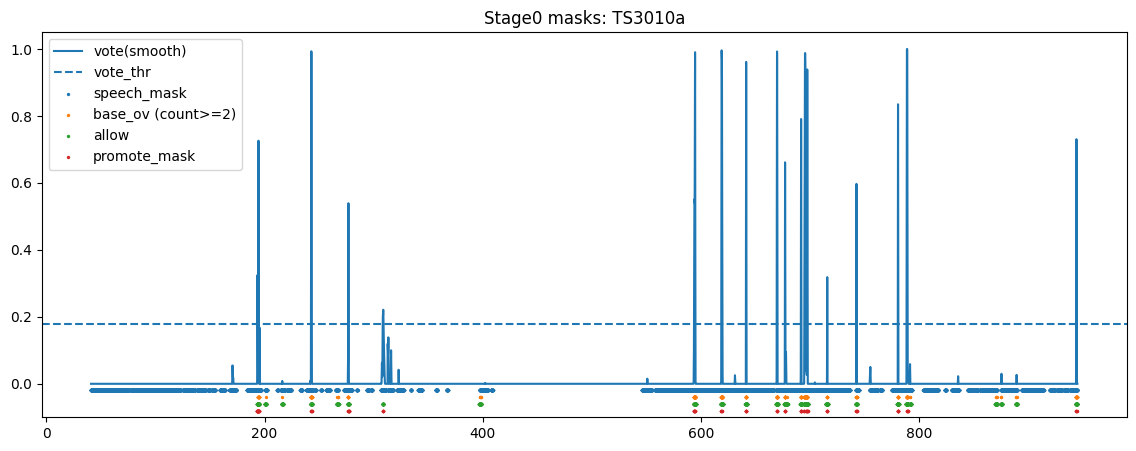

What the logs say (Stage0 vs Stage1)
Full-UEM (your main score)

DER: Stage1 0.20570 → Stage0 0.20694 (worse by +0.00124 abs)
Miss: 76.14 → 74.02 (better)
FA: 23.94 → 26.82 (worse)
Conf: ~flat

So Stage0 is doing the intended thing (miss ↓) but paying for it with FA ↑, netting a tiny DER loss.
Overlap-only (ref count ≥ 2)
DER: 0.37017 → 0.36702 (better by −0.00314 abs)
Miss: 40.22 → 39.07 (better)
FA: 0.51 → 0.99 (worse)
Conf: 20.03 → 20.20 (slightly worse)

This is actually encouraging: Stage0 is helping on overlap, which is the whole point of E4 promote-only.
Single-only (ref count == 1)
DER: 0.13392 → 0.13460 (worse by +0.00068 abs)
Miss: 35.91 → 34.94 (better)
FA: 10.41 → 11.84 (worse)

Conf: ~flat

This confirms the issue: Stage0 is leaking extra speaker activity into single-speaker regions (FA up).

Verdict: move to Stage 2 — but do it this way
✅ Yes, proceed to Stage 2 now, because:
Stage0 demonstrates real overlap gain (even if small).

Stage2 (anchor constraints) primarily targets confusion + stability and often reduces “speaker leakage”, which is exactly what you need.

The key decision

For Stage2 experiments, run both pipelines:
Stage2(Stage1) ← the “safe baseline path”
Stage2(Stage0) ← the “overlap-optimized path”

Then compare on full / overlap / single exactly like you did.
This avoids betting everything on Stage0 when it’s not yet globally better.

What to improve in Stage0 before/while doing Stage2 (optional but high ROI)
If you want one quick safety improvement (no refactor), do either of these:

    Option A (best): restrict Stage0 promotions to “near baseline overlap”
    enforce allow = near_base_ov only
    i.e., disable far-from-baseline promotions
    This usually drops the FA rise in single-speaker regions.

    Option B: lower topk_seconds
    If you’re using topk_seconds=20s, try 10s or 5s.

### Stage 2 definition (so we’re aligned) : Stage2 should take hyp1 or hyp0, compute exclusive anchors, build centroids/bank, and apply constraints

Overlap candidates (seg3 vote overlap OR hyp count>=2)
 - boundary islands (small segments near transitions)
 - Goal of Stage2:
 - reduce confusion
 - not increase FA
 - ideally keep miss flat or slightly improved
 - Given your current results, Stage2 has a real chance to:
 - claw back Stage0’s FA increase
 - keep the overlap improvement
 - finally make the “full” score improve

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyannote.core import Segment, Timeline, Annotation

# ----------------------------
# Utilities (assumes you already have these from your notebook)
#   - _get_uem_full
#   - frame_matrix_from_annotation
#   - timeline_to_mask
#   - _mask_to_segments
#   - _merge_close
# ----------------------------

def _tl_dur(tl: Timeline) -> float:
    return float(sum(s.duration for s in tl.support())) if tl is not None else 0.0

def _ann_support_dur(ann: Annotation) -> float:
    return _tl_dur(ann.get_timeline().support())

def _frame_to_segment(uem_seg: Segment, a: int, b: int, res: float) -> Segment:
    return Segment(float(uem_seg.start + a * res), float(uem_seg.start + b * res))

def _dominant_label_in_window(M, a, b, labels):
    hist = M[a:b].sum(axis=0)
    j = int(np.argmax(hist))
    return j, labels[j], float(hist[j])

def _cos_sim(a, b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-9))

# ----------------------------
# Stage2: guided prune-only
# ----------------------------
def STAGE2_PRUNE_ONLY_GUIDED_BY_STAGE0(
    file,
    baseline_fn=PIPE_BASE,

    # Stage0->dbg params (must match your Stage0 defaults unless you override)
    vad_pad=VAD_PAD, vad_gap=VAD_MERGE_GAP, vad_min_on=VAD_MIN_ON,
    topk_seconds=TOPK_SECONDS_DEFAULT,
    vote_thr=VOTE_THR_DEFAULT,
    sim2_thr=SIM2_THR_DEFAULT,
    m23_thr=M23_THR_DEFAULT,
    smooth_sec=SMOOTH_SEC,
    restrict_near_sec=0.25,
    strong_vote_thr=None,
    # base_ov_frac_thr=0.20,

    # Stage2 pruning knobs
    prune_vote_max=0.10,          # prune only when seg3 vote is low
    min_prune_dur=0.08,           # ignore micro regions
    merge_gap=0.06,               # merge prune regions slightly
    keep_top1_only=True,          # if True: keep only best label in prune region
    sec_frac_thr=0.35,            # if keep_top1_only=False, only drop secondaries that are tiny
    centroid_keep_margin=0.05,    # if (best - second_best) < margin, don't prune (ambiguous)
    debug=False,
    return_debug=False,
):
    """
    FA-safe prune-only Stage2:
    - base is hyp1 from Stage0 dbg (apply_promotion=False)
    - prune only in regions where:
        hyp1 has overlap (count>=2)
        seg3 vote is low (likely false overlap)
        NOT in Stage0 promote_mask (do-not-prune shield)
    - pruning decision uses centroid similarity on a short segment embedding
    - output is hyp1 with tracks removed in prune regions (no global reconstruction)
    """

    # 1) Get hyp1 and dbg from Stage0 without applying promotio

    # 1) Get hyp1 and dbg from Stage0 without applying promotion
    hyp1, dbg0 = STAGE0_PROMOTE_ONLY_ON_PYVAD(
        file,
        baseline_fn=baseline_fn,
        vad_pad=vad_pad, vad_gap=vad_gap, vad_min_on=vad_min_on,
        topk_seconds=topk_seconds,
        vote_thr=vote_thr,
        sim2_thr=sim2_thr,
        m23_thr=m23_thr,
        smooth_sec=smooth_sec,
        restrict_near_sec=restrict_near_sec,
        strong_vote_thr=strong_vote_thr,
        # base_ov_frac_thr=base_ov_frac_thr,
        apply_promotion=False,
        return_debug=True,
        debug=False,
    )

    uem_tl  = dbg0["uem_tl"]
    uem_seg = dbg0["uem_seg"]
    labels  = list(dbg0["labels"])     # ensure local copy
    speech_mask   = dbg0["speech_mask"]
    vote          = dbg0["vote"]
    promote_mask  = dbg0["promote_mask"]
    centroids     = dbg0["centroids"]

    # HARD sanity checks: catch stale caches / numeric labels immediately
    assert len(labels) >= 1, "No labels in dbg0"
    assert not any(str(l).isdigit() for l in labels), f"BUG: numeric labels still present in labels={labels}"

    # Ensure hyp1 contains ONLY these labels (clean)
    hyp1 = hyp1.subset(set(labels)).crop(uem_tl)

    # ✅ IMPORTANT FIX: recompute M0 from the (clean) hyp1 and labels
    M0 = frame_matrix_from_annotation(hyp1, uem_seg, labels, res=RES)

    RES_ = RES
    T = M0.shape[0]
    count = M0.sum(axis=1)

    # 2) Build prune_region mask
    hyp_overlap = (count >= 2) & speech_mask
    vote_low    = (vote <= prune_vote_max) & speech_mask
    prune_region = hyp_overlap & vote_low & (~promote_mask)

    # --- anti-fragmentation closing ---
    close_sec = 0.20
    rad = int(round(close_sec / RES_))
    pr = prune_region.astype(np.uint8)
    pr_dil = _binary_dilate(pr, radius_frames=rad).astype(np.uint8)
    k = 2 * rad + 1
    cnt = np.convolve(pr_dil, np.ones((k,), dtype=np.uint8), mode="same")
    prune_region = (cnt >= k) & speech_mask

    prune_segs = _merge_close(
        _mask_to_segments(prune_region, uem_seg.start, RES_, min_prune_dur),
        gap=merge_gap
    )

    # 3) Prepare output as hyp1 copy (FA-safe)
    out = hyp1.copy()

    removed_sec = 0.0
    n_pruned = 0
    n_skipped_amb = 0
    n_skipped_nocent = 0

    def _remove_label_from_segment(ann: Annotation, seg_cut: Segment, lab: str) -> Annotation:
        """Remove label lab only inside seg_cut (robust, version-independent)."""
        new_ann = Annotation()
        for seg, trk, lbl in ann.itertracks(yield_label=True):
            if lbl != lab:
                new_ann[seg, trk] = lbl
                continue
            # subtract seg_cut from seg
            if seg.end <= seg_cut.start or seg.start >= seg_cut.end:
                new_ann[seg, trk] = lbl
            else:
                if seg.start < seg_cut.start:
                    new_ann[Segment(seg.start, seg_cut.start), trk] = lbl
                if seg.end > seg_cut.end:
                    new_ann[Segment(seg_cut.end, seg.end), trk] = lbl
        return new_ann

    # 5) Iterate prune segments
    for s in prune_segs:
        a = int(np.floor((s.start - uem_seg.start) / RES_))
        b = int(np.ceil ((s.end   - uem_seg.start) / RES_))
        a = max(a, 0); b = min(b, T)
        if b <= a:
            continue

        frac = M0[a:b].mean(axis=0)
        act = np.where(frac > 0.01)[0].astype(int)
        if act.size < 2:
            continue

        act_labels = [labels[j] for j in act]
        if any(lab not in centroids for lab in act_labels):
            n_skipped_nocent += 1
            continue

        # embedding (center window)
        mid = 0.5 * (s.start + s.end)
        half = 0.5 * EMBED_WIN_SEC
        ss = Segment(max(0.0, mid - half), max(0.0, mid + half))
        e = embed_segment(file, ss, win_sec=EMBED_WIN_SEC)
        e = e / (np.linalg.norm(e) + 1e-9)

        sims = []
        for j in act:
            lab = labels[j]
            sims.append((lab, _cos_sim(centroids[lab], e), float(frac[j])))
        sims.sort(key=lambda x: -x[1])

        best_lab, best_sim, _ = sims[0]
        second_lab, second_sim, _ = sims[1]

        if (best_sim - second_sim) < centroid_keep_margin:
            n_skipped_amb += 1
            continue

        if keep_top1_only:
            drop = [lab for (lab, sim, fr) in sims[1:]]
        else:
            drop = []
            for (lab, sim, fr) in sims[1:]:
                if fr < sec_frac_thr and (best_sim - sim) >= centroid_keep_margin:
                    drop.append(lab)

        if not drop:
            continue

        for lab in drop:
            out = _remove_label_from_segment(out, s, lab)

        removed_sec += float((b - a) * RES_)
        n_pruned += 1

        if debug:
            print(f"[S2-GUIDED] {file.get('uri')} {s.start:.2f}-{s.end:.2f} vote={float(np.mean(vote[a:b])):.3f} "
                  f"keep={best_lab}({best_sim:.3f}) drop={drop} "
                  f"act={[(lab, round(sim,3), round(fr,2)) for (lab, sim, fr) in sims[:4]]}")

    # final FA-safe crop
    out = out.crop(uem_tl)
    out = out.crop(hyp1.get_timeline().support())


    dbg = {
        "n_prune_segments": len(prune_segs),
        "n_pruned": n_pruned,
        "n_skipped_amb": n_skipped_amb,
        "n_skipped_nocent": n_skipped_nocent,
        "removed_region_sec_upper": removed_sec,
        "hyp1_support_dur": _ann_support_dur(hyp1),
        "out_support_dur": _ann_support_dur(out),
    }

    if debug:
        print(f"[S2-GUIDED DBG] uri={file.get('uri')} prune_segments={len(prune_segs)} pruned={n_pruned} "
              f"skip_amb={n_skipped_amb} skip_nocent={n_skipped_nocent}")
        print(f"  support_dur hyp1={dbg['hyp1_support_dur']:.2f}s out={dbg['out_support_dur']:.2f}s "
              f"(should be <= hyp1)")

    return (out, dbg) if return_debug else out


# ----------------------------
# Debug plot for Stage2 guided prune
# ----------------------------
def plot_stage2_guided_debug(file, dbg0, prune_region_mask, title=None):
    uem_seg = dbg0["uem_seg"]
    vote = dbg0["vote"]
    speech_mask = dbg0["speech_mask"]
    promote_mask = dbg0["promote_mask"]
    base_ov = dbg0["base_ov"]

    T = len(vote)
    t = uem_seg.start + np.arange(T) * RES

    plt.figure(figsize=(14,4))
    plt.plot(t, vote, label="vote(smooth)")
    plt.axhline(0.10, linestyle="--", label="prune_vote_max(0.10)")

    def dots(mask, y, lab):
        idx = np.where(mask)[0]
        if idx.size:
            plt.scatter(t[idx], np.full(idx.shape, y), s=6, label=lab)

    dots(speech_mask, -0.02, "speech_mask")
    dots(base_ov, -0.04, "base_ov (hyp>=2)")
    dots(promote_mask, -0.06, "Stage0 promote_mask (shield)")
    dots(prune_region_mask, -0.08, "Stage2 prune_region")

    plt.ylim(-0.12, 1.05)
    plt.title(title or f"Stage2 guided prune masks: {file.get('uri')}")
    plt.legend(loc="upper left")
    plt.show()


In [ ]:
import json
from google.colab import drive
from pathlib import Path

# --- Configuration (edit these paths) ---
# The path to your current notebook file (it's usually '/content/drive/MyDrive/path/to/your_notebook.ipynb')
# You might need to adjust this if your notebook is not in Drive or has a different path.
# To find your current notebook path:
# 1. Click 'File' -> 'Locate in Drive' in Colab.
# 2. Right-click on the file in Drive and select 'Copy path'.
# 3. Paste the path below.

# Example path: YOUR_NOTEBOOK_PATH = '/content/drive/MyDrive/Colab Notebooks/my_diarization_project/my_notebook.ipynb'
YOUR_NOTEBOOK_PATH = 'path/to/your/notebook.ipynb' # <--- IMPORTANT: Update this line with the actual path to your notebook
CLEANED_NOTEBOOK_PATH = 'cleaned_notebook.ipynb' # Name for the cleaned output file

# --- Mount Google Drive if not already mounted ---
if not Path('/content/drive').exists():
    print("Mounting Google Drive...")
    drive.mount('/content/drive')

# --- Read the notebook file ---
print(f"Reading notebook from: {YOUR_NOTEBOOK_PATH}")
try:
    with open(YOUR_NOTEBOOK_PATH, 'r', encoding='utf-8') as f:
        notebook_content = json.load(f)
except FileNotFoundError:
    print(f"Error: Notebook file not found at {YOUR_NOTEBOOK_PATH}")
    print("Please update 'YOUR_NOTEBOOK_PATH' with the correct path to your notebook.")
    exit()
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {YOUR_NOTEBOOK_PATH}. The file might be corrupted.")
    exit()

# --- Clean the metadata ---
print("Cleaning notebook metadata...")
for cell in notebook_content.get('cells', []):
    if 'metadata' in cell and 'widgets' in cell['metadata']:
        del cell['metadata']['widgets']
    # Also check for 'jupyter' metadata which might contain widget states
    if 'metadata' in cell and 'jupyter' in cell['metadata']:
        if 'source_hidden' in cell['metadata']['jupyter']:
            # Keep source_hidden if it exists and is useful
            pass
        else:
            del cell['metadata']['jupyter']

if 'metadata' in notebook_content and 'widgets' in notebook_content['metadata']:
    del notebook_content['metadata']['widgets']

if 'metadata' in notebook_content and 'jupyter' in notebook_content['metadata']:
    if 'source_hidden' in notebook_content['metadata']['jupyter']:
        pass
    else:
        del notebook_content['metadata']['jupyter']

# --- Save the cleaned notebook ---
with open(CLEANED_NOTEBOOK_PATH, 'w', encoding='utf-8') as f:
    json.dump(notebook_content, f, indent=1)

print(f"Successfully cleaned notebook and saved to: {CLEANED_NOTEBOOK_PATH}")
print("Please download 'cleaned_notebook.ipynb' from the Colab file browser and replace your Git version.")


Mounting Google Drive...
Mounted at /content/drive
Reading notebook from: path/to/your/notebook.ipynb
Error: Notebook file not found at path/to/your/notebook.ipynb
Please update 'YOUR_NOTEBOOK_PATH' with the correct path to your notebook.
Cleaning notebook metadata...


NameError: name 'notebook_content' is not defined

In [ ]:
f_dbg = next(x for x in dev_files if x["uri"] == "TS3006a")

# get dbg0 without applying promotion
hyp1, dbg0 = STAGE0_PROMOTE_ONLY_ON_PYVAD(
    f_dbg, baseline_fn=PIPE_BASE,
    apply_promotion=False,
    return_debug=True,
)

# compute prune_region used by Stage2 guided
M0 = dbg0["M"]
speech_mask = dbg0["speech_mask"]
vote = dbg0["vote"]
promote_mask = dbg0["promote_mask"]
count = M0.sum(axis=1)
hyp_overlap = (count >= 2) & speech_mask
vote_low = (vote <= 0.10) & speech_mask
prune_region = hyp_overlap & vote_low & (~promote_mask)

# run stage2 guided
hyp2, dbg2 = STAGE2_PRUNE_ONLY_GUIDED_BY_STAGE0(
    f_dbg, baseline_fn=PIPE_BASE,
    prune_vote_max=0.10,
    return_debug=True,
    debug=True,
)

print("DBG2:", dbg2)
plot_stage2_guided_debug(f_dbg, dbg0, prune_region, title="TS3006a Stage2-guided prune masks")

#Need to print labels
print("hyp1.labels():", sorted([str(x) for x in hyp1.labels()])[:50])


AssertionError: BUG: numeric labels still present in labels=['0', '2', 'MTD021PM', 'MTD022ID', 'MTD023UID', 'MTD024ME']

In [ ]:
_BASE_CACHE.clear()


In [ ]:
fn_stage1 = lambda f: STAGE1_PYVAD(f, base_fn=PIPE_BASE)

fn_stage2g = lambda f: STAGE2_PRUNE_ONLY_GUIDED_BY_STAGE0(
    f,
    baseline_fn=PIPE_BASE,
    prune_vote_max=0.10,
    min_prune_dur=0.12,
    keep_top1_only=True,
    centroid_keep_margin=0.06,
    debug=False,
)


rows1, sum1 = eval_files(fn_stage1, dev_files, uem_mode="full")
rows2, sum2 = eval_files(fn_stage2g, dev_files, uem_mode="full")
print("STAGE1:", sum1)
print("STAGE2 guided prune:", sum2)


[eval_files] 1/5 TS3010a DER=0.2299 (miss=77.21 fa=13.61 conf=19.56 total=480.14)
[eval_files] 2/5 TS3006a DER=0.2456 (miss=126.18 fa=36.26 conf=105.01 total=1089.05)
[eval_files] 3/5 IS1007a DER=0.1888 (miss=82.83 fa=29.30 conf=39.04 total=800.78)
[eval_files] 4/5 ES2005a DER=0.1703 (miss=31.69 fa=9.55 conf=7.43 total=285.82)
[eval_files] 5/5 IS1009a DER=0.1940 (miss=62.78 fa=30.97 conf=41.24 total=695.90)
[eval_files] 1/5 TS3010a DER=0.2299 (miss=77.46 fa=13.61 conf=19.31 total=480.14)
[eval_files] 2/5 TS3006a DER=0.2412 (miss=178.23 fa=31.47 conf=52.96 total=1089.05)
[eval_files] 3/5 IS1007a DER=0.1876 (miss=88.84 fa=28.31 conf=33.11 total=800.78)
[eval_files] 4/5 ES2005a DER=0.1706 (miss=33.79 fa=9.49 conf=5.49 total=285.82)
[eval_files] 5/5 IS1009a DER=0.1874 (miss=69.11 fa=26.42 conf=34.91 total=695.90)
STAGE1: {'mean': {'DER': 0.20570066326652295, 'miss': 76.13638749999869, 'fa': 23.937206249998983, 'conf': 42.45818750000036, 'total': 670.338}, 'global': {'DER': 0.21262673643743

Prune only on stage 1 , no guide from stage 0 .

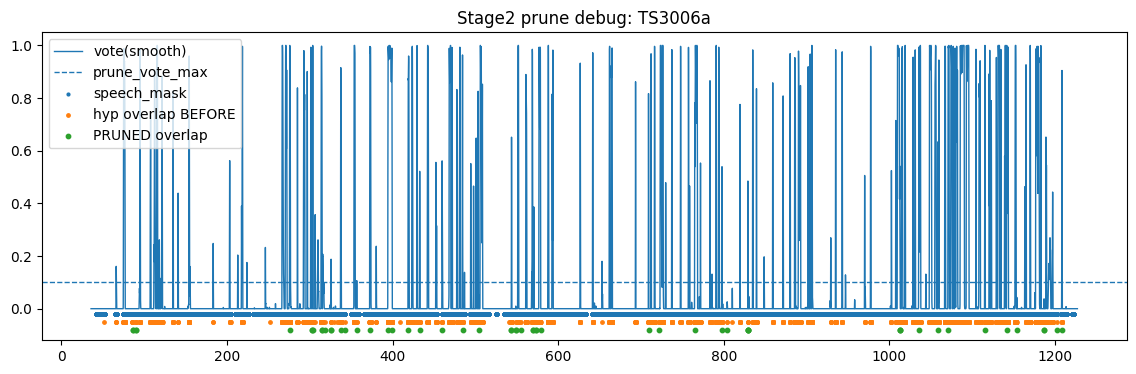
STAGE1: {'mean': {'DER': 0.20570066326652295, 'miss': 76.13638749999869, 'fa': 23.937206249998983, 'conf': 42.45818750000036, 'total': 670.338}, 'global': {'DER': 0.21262673643743613, 'miss': 380.68193749999347, 'fa': 119.68603124999491, 'conf': 212.2909375000018, 'total': 3351.6899999999996}, 'n_ok': 5, 'n_total': 5, 'uem_mode': 'full'}
STAGE2 (prune-only): {'mean': {'DER': 0.20709655579134342, 'miss': 74.2839999999995, 'fa': 26.71199999999975, 'conf': 42.57400000000011, 'total': 670.3379999999994}, 'global': {'DER': 0.2141755353269537, 'miss': 371.41999999999746, 'fa': 133.55999999999875, 'conf': 212.87000000000057, 'total': 3351.689999999997}, 'n_ok': 5, 'n_total': 5, 'uem_mode': 'full'}



### NEXT CELL: Anchor-centroid guided OVERLAP reassignment (confusion-focused)

In [ ]:
# # ============================================================
# # NEXT CELL: Anchor-centroid guided OVERLAP reassignment (confusion-focused)
# # - Uses baseline diarization (pipe_base) for segments
# # - Builds per-label centroids from EXCLUSIVE (count==1) anchor regions
# # - Only modifies frames where baseline predicts overlap (count>=2)
# # - In those overlap regions, keeps only the top-2 labels by centroid similarity
# #
# # Prereqs expected in your notebook:
# #   - pipe_base(file) -> Annotation
# #   - protocol, DEV_URIS, TEST_URIS
# #   - eval_split(pipeline_callable, split)  where split in {"dev","test"}
# # ============================================================

# import numpy as np
# import torch
# import torch.nn.functional as F
# from pyannote.core import Annotation, Segment, Timeline
# from pyannote.audio import Audio
# from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# if "audio" not in globals():
#     audio = Audio(sample_rate=16000, mono=True)

# # Use pyannote/embedding if not already loaded, as it was requested in the previous cells
# # and was explicitly loaded in AzDgyfdQfSmU and Rq8uHfdMWV02.
# # This assumes 'embedder' global is set from the Rq8uHfdMWV02 cell.
# if "embedder" not in globals():
#     try:
#         embedder = PretrainedSpeakerEmbedding("pyannote/embedding", device=device)
#         print("Using embedder: pyannote/embedding")
#     except Exception as e:
#         print(f"Failed to load pyannote/embedding, falling back to speechbrain ECAPA. Error: {repr(e)}")
#         embedder = PretrainedSpeakerEmbedding("speechbrain/spkrec-ecapa-voxceleb", device=device)
#         print("Using embedder: speechbrain/spkrec-ecapa-voxceleb")
# else:
#     # Ensure embedder is on the correct device if it was created in a different context
#     if embedder.device != device:
#         embedder.to(device)
#     print("Reusing existing embedder.")


# def _to_b1c1T(wav: torch.Tensor) -> torch.Tensor:
#     """Ensure waveform shape is (B,1,T) torch.float32."""
#     # Ensure it's a tensor first if it came from numpy
#     if not torch.is_tensor(wav):
#         wav = torch.tensor(wav, dtype=torch.float32)

#     # Convert to mono (if multichannel) and add batch/channel dims if missing
#     if wav.dim() == 1: # (T,)
#         wav = wav.unsqueeze(0).unsqueeze(0) # -> (1, 1, T)
#     elif wav.dim() == 2: # (C, T) or (B, T) - assuming (C, T)
#         if wav.shape[0] > 1: # Multichannel
#             wav = wav.mean(dim=0, keepdim=True) # Average channels -> (1, T)
#         # else: already (1, T)
#         wav = wav.unsqueeze(0) # -> (1, 1, T)
#     elif wav.dim() == 3: # (B, C, T)
#         if wav.shape[1] > 1: # Multichannel
#             wav = wav.mean(dim=1, keepdim=True) # Average channels -> (B, 1, T)
#     else:
#         raise ValueError(f"Unexpected wav dimension: {wav.dim()} with shape {tuple(wav.shape)}")
#     return wav.float()


# def _get_uem(file):
#     if "uem" in file and file["uem"] is not None:
#         return file["uem"]
#     if "annotation" in file and file["annotation"] is not None:
#         return file["annotation"].get_timeline().support()
#     if "duration" in file and file["duration"] is not None:
#         return Timeline([Segment(0.0, float(file["duration"]))])
#     # fallback
#     return Timeline([Segment(0.0, 0.0)])

# def _mask_to_segments(mask, uem_seg, res, min_dur):
#     if mask.size == 0 or not mask.any():
#         return []
#     edges = np.where(np.diff(np.r_[0, mask.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
#     out = []
#     for a, b in edges:
#         st = uem_seg.start + a * res
#         en = uem_seg.start + b * res
#         if en - st >= min_dur:
#             out.append(Segment(float(st), float(en)))
#     return out

# def _merge_close(segs, gap=0.10):
#     if not segs:
#         return []
#     segs = sorted(segs, key=lambda s: (s.start, s.end))
#     merged = [segs[0]]
#     for s in segs[1:]:
#         last = merged[-1]
#         if s.start - last.end <= gap:
#             merged[-1] = Segment(last.start, max(last.end, s.end))
#         else:
#             merged.append(s)
#     return merged

# def build_exclusive_anchors_from_hyp(hyp: Annotation, uem: Timeline, labels, res=0.02, min_anchor_dur=1.0, merge_gap=0.10):
#     """
#     Exclusive anchors computed from hyp itself: frames where exactly one label is active.
#     Returns: dict[label]->Timeline
#     """
#     anchors = {lab: [] for lab in labels}

#     for uem_seg in uem:
#         if uem_seg.duration <= 0:
#             continue
#         T = int(np.ceil(uem_seg.duration / res))
#         if T <= 0:
#             continue

#         hyp_seg = hyp.crop(uem_seg)

#         count = np.zeros((T,), dtype=np.uint16)
#         m_lab = {lab: np.zeros((T,), dtype=bool) for lab in labels}

#         for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
#             lab = str(lab0)
#             if lab not in m_lab:
#                 # keep robust if new label appears
#                 m_lab[lab] = np.zeros((T,), dtype=bool)
#             a = int(np.floor((seg.start - uem_seg.start) / res))
#             b = int(np.ceil ((seg.end   - uem_seg.start) / res))
#             a = max(a, 0); b = min(b, T)
#             if b > a:
#                 m_lab[lab][a:b] = True
#                 count[a:b] += 1

#         for lab in labels:
#             m = m_lab.get(lab, np.zeros((T,), dtype=bool))
#             excl = m & (count == 1)
#             segs = _mask_to_segments(excl, uem_seg, res=res, min_dur=min_anchor_dur)
#             segs = _merge_close(segs, gap=merge_gap)
#             anchors[lab].extend(segs)

#     return {lab: Timeline(segs).support() for lab, segs in anchors.items()}

# def embed_from_segment(file, seg: Segment, min_len_sec=1.5): # Increased min_len_sec to avoid kernel size errors with short inputs
#     """
#     Extracts an embedding from a segment, ensuring a minimum length.
#     Returns normalized (D,) np.float32 or None if segment is too short.
#     """
#     audio_source = file["audio"]

#     try:
#         wav, sr = audio.crop(audio_source, seg)
#     except Exception as e:
#         # Handle cases where audio.crop might fail for problematic segments
#         return None

#     # Ensure wav is a torch tensor and handle empty/very short results from audio.crop
#     if not isinstance(wav, torch.Tensor):
#         if not wav.shape: # empty numpy array case
#             wav = torch.tensor([], dtype=torch.float32)
#         else:
#             wav = torch.tensor(wav, dtype=torch.float32)

#     # If wav is still empty after conversion, return None
#     if wav.numel() == 0:
#         return None

#     # Check original length before padding
#     min_samples = int(min_len_sec * sr)
#     if wav.shape[-1] < min_samples:
#         return None  # Skip padding and return None for very short segments to avoid errors

#     # Convert to expected input format for embedder
#     wav = _to_b1c1T(wav).to(device)

#     with torch.no_grad():
#         e = embedder(wav)
#         if isinstance(e, np.ndarray):
#             e = torch.from_numpy(e)
#         e = e.to(device).float()
#         e = F.normalize(e, dim=1).squeeze(0)
#     return e.detach().cpu().numpy().astype(np.float32)


# def embed_from_timeline(file, tl: Timeline, chunk_sec=2.0, max_chunks=6):
#     chunks = []
#     for seg in tl:
#         if seg.duration <= 0:
#             continue
#         if seg.duration <= chunk_sec + 1e-6:
#             chunks.append(seg)
#         else:
#             t = seg.start
#             while t + chunk_sec <= seg.end + 1e-6:
#                 chunks.append(Segment(t, t + chunk_sec))
#                 t += chunk_sec
#                 if len(chunks) >= max_chunks:
#                     break
#         if len(chunks) >= max_chunks:
#             break
#     if not chunks:
#         return None
#     embs = []
#     for s in chunks:
#         e = embed_from_segment(file, s, min_len_sec=1.5) # Use fixed min_len_sec=1.5
#         if e is not None:
#             embs.append(e)

#     if not embs: # All embeddings were None
#         return None

#     E = np.vstack(embs).astype(np.float32)
#     E /= (np.linalg.norm(E, axis=1, keepdims=True) + 1e-9)
#     c = E.mean(axis=0, keepdims=True) # Changed from 'keepdim=True' to 'keepdims=True'
#     c /= (np.linalg.norm(c, axis=1, keepdims=True) + 1e-9)
#     return c.squeeze(0).astype(np.float32)

# def frame_matrix_from_hyp(hyp_seg: Annotation, uem_seg: Segment, labels, res=0.02):
#     T = int(np.ceil(uem_seg.duration / res))
#     M = np.zeros((T, len(labels)), dtype=np.uint8)
#     for seg, _, lab0 in hyp_seg.itertracks(yield_label=True):
#         lab = str(lab0)
#         if lab not in labels:
#             continue
#         j = labels.index(lab)
#         a = int(np.floor((seg.start - uem_seg.start) / res))
#         b = int(np.ceil ((seg.end   - uem_seg.start) / res))
#         a = max(a, 0); b = min(b, T)
#         if b > a:
#             M[a:b, j] = 1
#     count = M.sum(axis=1)
#     return M, count

# def frame_matrix_to_annotation(M, labels, uem_seg: Segment, res=0.02, min_dur=0.05, merge_gap=0.05):
#     out = Annotation()
#     T = M.shape[0]
#     times = uem_seg.start + np.arange(T + 1) * res  # length T+1 avoids OOB

#     for j, lab in enumerate(labels):
#         active = (M[:, j] > 0)
#         if not active.any():
#             continue
#         edges = np.where(np.diff(np.r_[0, active.view(np.int8), 0]) != 0)[0].reshape(-1, 2)
#         segs = []
#         for a, b in edges:
#             st = float(times[a]); en = float(times[b])
#             if en - st >= min_dur:
#                 segs.append(Segment(st, en))
#         segs = _merge_close(segs, gap=merge_gap)
#         for s in segs:
#             out[s] = lab
#     return out

# def overlap_reassign_pipeline(
#     file,
#     res=0.02,
#     min_anchor_dur=1.0,
#     anchor_merge_gap=0.10,
#     min_ov_dur=0.30,
#     ov_merge_gap=0.10,
#     chunk_sec=2.0,
#     max_chunks=6,
#     topk=2,
#     debug=False,
# ):
#     hyp0 = pipe_base(file)
#     uem = _get_uem(file)
#     hyp = hyp0.crop(uem)

#     labels = sorted([str(l) for l in hyp.labels()])
#     if len(labels) <= 1:
#         return hyp

#     # 1) anchors + centroids
#     anchors = build_exclusive_anchors_from_hyp(
#         hyp, uem, labels, res=res, min_anchor_dur=min_anchor_dur, merge_gap=anchor_merge_gap
#     )
#     centroids = {}
#     anchor_durs = {}
#     for lab in labels:
#         tl = anchors.get(lab, Timeline()).support()
#         anchor_durs[lab] = float(sum(s.duration for s in tl))
#         c = embed_from_timeline(file, tl, chunk_sec=chunk_sec, max_chunks=max_chunks)
#         if c is not None:
#             centroids[lab] = c

#     # if too few centroids, can't reassign overlap robustly
#     if len(centroids) <= 1:
#         return hyp

#     # 2) rewrite per-UEM segment on a grid
#     out = Annotation()
#     changed = 0
#     total_ov_segs = 0

#     for uem_seg in uem:
#         if uem_seg.duration <= 0:
#             continue
#         hyp_seg = hyp.crop(uem_seg)
#         M, count = frame_matrix_from_hyp(hyp_seg, uem_seg, labels, res=res)

#         ov_mask = (count >= 2)
#         ov_segs = _merge_close(_mask_to_segments(ov_mask, uem_seg, res=res, min_dur=min_ov_dur), gap=ov_merge_gap)
#         total_ov_segs += len(ov_segs)

#         # assign each overlap segment to top-k centroid labels
#         for s in ov_segs:
#             # baseline set in this region
#             a = int(np.floor((s.start - uem_seg.start) / res))
#             b = int(np.ceil ((s.end   - uem_seg.start) / res))
#             a = max(a, 0); b = min(b, M.shape[0])
#             if b <= a:
#                 continue

#             base_set = set(np.array(labels)[np.where(M[a:b].mean(axis=0) > 0.01)[0]].tolist())

#             e = embed_from_segment(file, s, min_len_sec=1.5) # Use fixed min_len_sec=1.5
#             if e is None: # If embedding failed, skip this segment
#                 continue

#             # cosine sims to centroids
#             sims = []
#             for lab, c in centroids.items():
#                 sims.append((lab, float(np.dot(e, c))))  # both normalized
#             sims.sort(key=lambda x: -x[1])

#             chosen = [lab for lab, _ in sims[:topk]]
#             chosen_set = set(chosen)

#             # update only overlap frames (already ov_mask inside [a:b])
#             # but to keep it strict: update all frames in [a:b] (these segments were built from ov_mask)
#             M[a:b, :] = 0
#             for lab in chosen:
#                 j = labels.index(lab)
#                 M[a:b, j] = 1

#             if chosen_set != base_set:
#                 changed += 1

#         seg_ann = frame_matrix_to_annotation(
#             M, labels, uem_seg, res=res, min_dur=0.05, merge_gap=0.05
#         )
#         out.update(seg_ann)

#     if debug:
#         uem_dur = float(sum(s.duration for s in uem))
#         excl_dur = float(sum(sum(seg.duration for seg in anchors[lab]) for lab in labels))
#         print(f"[OV-ASSIGN DBG] uri={file.get('uri')} labels={len(labels)} centroids={len(centroids)}")
#         print(f"  uem_dur={uem_dur:.1f}s exclusive_anchor_dur(sum)={excl_dur:.1f}s")
#         print(f"  overlap_segments={total_ov_segs} changed_assignments={changed}")
#         print(f"  top anchor_dur(s): {sorted(anchor_durs.items(), key=lambda kv: -kv[1])[:4]}")

#     return out

# # ----------------------------
# # DEV tune (small grid) -> TEST
# # ----------------------------
# # Re-defining DEV_FILES and TEST_FILES as they might have been cleared by previous errors
# DEV_FILES  = [f for f in protocol.development() if f["uri"] in set(DEV_URIS)]
# TEST_FILES = [f for f in protocol.test()        if f["uri"] in set(TEST_URIS)]

# DEBUG_URI = "TS3010a"

# min_ov_dur_grid = [0.50, 0.70, 1.00]  # Increased grid values to ensure segments are long enough
# chunk_sec_grid  = [1.5, 2.0]

# best = None
# for min_ov_dur in min_ov_dur_grid:
#     for chunk_sec in chunk_sec_grid:
#         run_fn = lambda f, min_ov_dur=min_ov_dur, chunk_sec=chunk_sec: overlap_reassign_pipeline(
#             f,
#             res=0.02,
#             min_anchor_dur=1.0,
#             anchor_merge_gap=0.10,
#             min_ov_dur=min_ov_dur,
#             ov_merge_gap=0.10,
#             chunk_sec=chunk_sec,
#             max_chunks=6,
#             topk=2,
#             debug=(f.get("uri") == DEBUG_URI),
#         )
#         _, agg = eval_split(run_fn, "dev")
#         der = agg.get("diarization error rate", 1e9)
#         print(f"[E3-OV DEV] min_ov_dur={min_ov_dur:.2f} chunk_sec={chunk_sec:.1f} -> DER={der:.4f}")
#         if best is None or der < best["der"]:
#             best = {"min_ov_dur": min_ov_dur, "chunk_sec": chunk_sec, "der": der}

# print("E3-OV BEST DEV:", best)

# E3_OV_best = lambda f: overlap_reassign_pipeline(
#     f,
#     res=0.02,
#     min_anchor_dur=1.0,
#     anchor_merge_gap=0.10,
#     min_ov_dur=best["min_ov_dur"],
#     ov_merge_gap=0.10,
#     chunk_sec=best["chunk_sec"],
#     max_chunks=6,
#     topk=2,
#     debug=False,
# )

# _, agg_test = eval_split(E3_OV_best, "test")
# print("E3-OV TEST mean:", agg_test)

1) The method is effectively doing nothing

		We have:

		overlap_segments = 2–6
		changed_assignments = 0 every time

		- That means for every detected overlap region, one of these is happening:
        - skipping overlap embeddings (embed_from_segment returns None for short crops), never compute sims / never rewrite anything .
        - We do compute embeddings, but the “chosen top-2” equals the baseline top-2 (so no change).
        - Even when base_set == chosen_set, Wer code still rewrites frames and re-serializes → boundaries can drift slightly.

		- Wer DER confirms it’s not improving:
          - Baseline: DEV 0.1839, TEST 0.1587
          - Wer E3-OV: DEV 0.1945, TEST 0.1684 (worse)

	So right now we’ve removed the crash, but we haven’t activated the intended “confusion fix”.

2) Where we are vs Wer intended plan

    Wer intended flow was:

    - Anchor list from exclusive regions ✅ (We even have ~0.79 exclusive ratio on TS3010a — great)
    - Compare overlap regions against anchors and reassign ✅ conceptually, but currently not firing (changed=0)
     - Then add GNN + density-aware merging (later) — but we shouldn’t go there until step (2) is actually making controlled changes.
    - Density-aware merging matters when We’re clustering lots of nodes (segments) and want to prevent “supercluster collapse” under overlap/noise.

Pillar 4: Embedding-Guided Aggregation & Boundary Refinement → Experiment E4
(matches your formulas/steps

E4 — Embedding-guided aggregation & boundary refinement (adaptive gaps + boundary shift)

This is your “aggregation” pillar: adaptive gap filling and boundary nudging driven by cluster variance and centroid similarity.

Final_D++

What to change

After E3 clustering:

Merge adjacent segments of same speaker if gap ≤ Δ_s, where Δ_s adapts with variance (your proposal formula)

Shift boundaries ±100–200ms to maximize centroid consistency (simple proxy: maximize cos(emb(window), centroid))

What to measure

Usually CONF ↓ and MISS ↓ (fewer chopped turns), sometimes FA ↑ if Δ is too big → tune carefully.

Hyperparams

Δ_base ∈ {0.15, 0.25, 0.35} seconds

λ ∈ {0.5, 1.0, 2.0} in Δ_s = Δ_base + λ·Var_s

shift_ms ∈ {100, 200}

Minimal cell (post-clustering pass skeleton

In [ ]:
# def cluster_variance(embs, cids):
#     vars = {}
#     for c in np.unique(cids):
#         idx = np.where(cids==c)[0]
#         if len(idx) < 2:
#             vars[c] = 0.0
#         else:
#             X = F.normalize(embs[idx], dim=1)
#             C = X.mean(dim=0, keepdim=True)
#             v = (1 - F.cosine_similarity(X, C, dim=1)).mean().item()
#             vars[c] = v
#     return vars

# def merge_adjacent(segs, cids, var, delta_base=0.25, lam=1.0):
#     # segs: list[Segment] sorted by time, cids aligned
#     out_segs, out_cids = [], []
#     for seg, cid in sorted(zip(segs, cids), key=lambda x: x[0].start):
#         if not out_segs:
#             out_segs.append(seg); out_cids.append(cid); continue
#         prev = out_segs[-1]; pcid = out_cids[-1]
#         gap = seg.start - prev.end
#         delta = delta_base + lam*var.get(cid, 0.0)
#         if cid == pcid and gap <= delta:
#             out_segs[-1] = Segment(prev.start, seg.end)
#         else:
#             out_segs.append(seg); out_cids.append(cid)
#     return out_segs, out_cids

# # After you have (segs, cids, embs) from E3:
# # var = cluster_variance(embs, cids)
# # segs2, cids2 = merge_adjacent(segs, cids, var, delta_base=0.25, lam=1.0)
# # -> convert to Annotation + eval_split
# print("E4 post-processing helpers ready.")
